# DQN Spaceship

Full write up soon, but there seem to be a couple of very important hyperparameters here:

- a pretty high discount (retention?) rate is important - anything lower than about `0.99` doesn't seem to find a solution at all
- the learning rate took some tuning in combination with the batch size

I've also experimented with a few depths/widths of NN and something around the current shape seems to strike the right balance with other hyperparameters/training/the complexity of the problem

In [1]:
import random
import gym
import numpy as np
from collections import deque

import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# todo cuda all the things
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
ENV_NAME = "LunarLander-v2"

GAMMA = 0.99
LEARNING_RATE = 5e-4

MEMORY_SIZE = int(1e5)
BATCH_SIZE = 64

EPSILON_MAX = 1.0
# so this is basically 10-100 random choices per epoch
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995

In [14]:
class EnvModel(nn.Module):
    def __init__(self, observation_space, action_space):
        super().__init__()
        self.fc1 = nn.Linear(observation_space, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc_out = nn.Linear(64, action_space)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [15]:
class Dqn():
    def __init__(self, observation_space, action_space):
        self.observation_space = observation_space
        self.action_space = action_space
        self.model = EnvModel(observation_space, action_space).to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.train_losses = []
        self.epsilon = EPSILON_MAX
        self.memory = deque(maxlen=MEMORY_SIZE)    
        
        
    def fit(self, state, q_values):
        self.optimizer.zero_grad()
        log_ps = self.model(state)
        loss = self.criterion(log_ps, q_values)
        loss.backward()
        self.optimizer.step()
 

    def predict_states(self, state):
        self.model.eval()
        with torch.no_grad():
            prediction = self.model(state)
        
        self.model.train()
        return prediction
    
    
    # quick wrapper :)
    def predict(self, state):
        
        self.model.eval()
        with torch.no_grad():
            state = torch.from_numpy(state).float()
            prediction = self.model(state)
        
        self.model.train()
        return prediction.numpy()
    
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        
    def get_action(self, state):  
        random_action = random.random() <= self.epsilon
        q_values = self.predict(state)
        return random.randint(0, self.action_space - 1) if random_action else np.argmax(q_values)
    
    
    def experience_replay(self):
        """
        this whole implementation feels very ham fisted, refactor
        """
        batch = random.sample(self.memory, min(BATCH_SIZE, len(self.memory)))

        state_nexts = [state_next for _, _, _, state_next, _ in batch]
        state_nexts = torch.FloatTensor(state_nexts)
        q_next_states = self.predict_states(state_nexts)
        
        terminals = [t for _, _, _, _, t in batch]
        rewards = [r for _, _, r, _, _ in batch]
        
        state_rewards = torch.FloatTensor(rewards) if terminals else (torch.FloatTensor(rewards) + GAMMA * torch.max(q_next_states, dim=1))
        
        states = [state for state, _, _, _, _ in batch]
        states = torch.FloatTensor(states)
        
        actions = torch.LongTensor([a for _, a, _, _, _ in batch])
        
        q_values_predicted = self.predict_states(states)
        q_values_predicted[np.arange(0, len(batch)), actions] = state_rewards
        
        self.fit(states, q_values_predicted)

In [16]:
env = gym.make(ENV_NAME)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [25]:
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

print(observation_space, action_space)

8 4


In [26]:
epochs = 2000
exploration_rate = EPSILON_MAX

scores = []
final_rewards = []

dqn = Dqn(observation_space, action_space)

In [27]:
%%time

for run in range(epochs):
    step = 0
    state = env.reset()
    
    score = 0

    while True:
        step += 1
        action = dqn.get_action(state)
        
        state_next, reward, terminal, info = env.step(action)
        
        dqn.remember(state, action, reward, state_next, terminal)
        
        state = state_next
        
        score += reward        
        if terminal:
            print("Epoch: " + str(run + 1) + ", epsilon: " + str(dqn.epsilon) + ", steps: " + str(step) + ", reward: " + str(reward) + ", score: " + str(score))
            scores.append(score)
            final_rewards.append(reward)
            break
            
        dqn.experience_replay()
        
    dqn.epsilon *= EPSILON_DECAY
    dqn.epsilon = max(EPSILON_MIN, dqn.epsilon)        

Epoch: 1, epsilon: 1.0, steps: 90, reward: -100, score: -170.8048934300898
Epoch: 2, epsilon: 0.995, steps: 127, reward: -100, score: -365.9327734830196
Epoch: 3, epsilon: 0.990025, steps: 64, reward: -100, score: -156.68784139978047
Epoch: 4, epsilon: 0.985074875, steps: 87, reward: -100, score: -320.41006013898203
Epoch: 5, epsilon: 0.9801495006250001, steps: 62, reward: -100, score: -170.19682624066144
Epoch: 6, epsilon: 0.9752487531218751, steps: 62, reward: -100, score: -150.04053123135145
Epoch: 7, epsilon: 0.9703725093562657, steps: 86, reward: -100, score: -359.0929326495945
Epoch: 8, epsilon: 0.9655206468094844, steps: 115, reward: -100, score: -103.76545283412132
Epoch: 9, epsilon: 0.960693043575437, steps: 119, reward: -100, score: -67.3820019420203
Epoch: 10, epsilon: 0.9558895783575597, steps: 93, reward: -100, score: -177.52136071749834
Epoch: 11, epsilon: 0.9511101304657719, steps: 69, reward: -100, score: -297.17403926518557
Epoch: 12, epsilon: 0.946354579813443, steps:

Epoch: 91, epsilon: 0.6369088258938781, steps: 161, reward: -100, score: -508.4892082136242
Epoch: 92, epsilon: 0.6337242817644086, steps: 107, reward: -100, score: -188.42164251944365
Epoch: 93, epsilon: 0.6305556603555866, steps: 85, reward: -100, score: -103.31742784421634
Epoch: 94, epsilon: 0.6274028820538087, steps: 156, reward: -100, score: -168.18499803357398
Epoch: 95, epsilon: 0.6242658676435396, steps: 106, reward: -100, score: -176.53211524626965
Epoch: 96, epsilon: 0.6211445383053219, steps: 156, reward: -100, score: -167.62694209709753
Epoch: 97, epsilon: 0.6180388156137953, steps: 92, reward: -100, score: -163.37858251845773
Epoch: 98, epsilon: 0.6149486215357263, steps: 98, reward: -100, score: -122.74824905479316
Epoch: 99, epsilon: 0.6118738784280476, steps: 139, reward: -100, score: -211.90146346144547
Epoch: 100, epsilon: 0.6088145090359074, steps: 207, reward: -100, score: -142.16655673600107
Epoch: 101, epsilon: 0.6057704364907278, steps: 168, reward: -100, score:

Epoch: 179, epsilon: 0.40974000909221303, steps: 120, reward: -100, score: -476.5439852393705
Epoch: 180, epsilon: 0.40769130904675194, steps: 214, reward: -100, score: -316.5141564592174
Epoch: 181, epsilon: 0.40565285250151817, steps: 261, reward: -100, score: -110.92612071511401
Epoch: 182, epsilon: 0.4036245882390106, steps: 161, reward: -100, score: -115.42045427533742
Epoch: 183, epsilon: 0.4016064652978155, steps: 204, reward: -100, score: -201.30736426681136
Epoch: 184, epsilon: 0.3995984329713264, steps: 110, reward: -100, score: -139.23920792340942
Epoch: 185, epsilon: 0.3976004408064698, steps: 220, reward: -100, score: -369.8716397896885
Epoch: 186, epsilon: 0.39561243860243744, steps: 114, reward: -100, score: -260.50741019867456
Epoch: 187, epsilon: 0.3936343764094253, steps: 297, reward: -100, score: -423.3383566944952
Epoch: 188, epsilon: 0.39166620452737816, steps: 173, reward: -100, score: -165.42840344036892
Epoch: 189, epsilon: 0.3897078735047413, steps: 171, reward

Epoch: 266, epsilon: 0.2649210072611673, steps: 157, reward: -100, score: -379.19254167228206
Epoch: 267, epsilon: 0.26359640222486147, steps: 346, reward: -100, score: -477.81312080478034
Epoch: 268, epsilon: 0.26227842021373715, steps: 165, reward: -100, score: -223.95389397543036
Epoch: 269, epsilon: 0.2609670281126685, steps: 226, reward: -100, score: -118.26927298871196
Epoch: 270, epsilon: 0.25966219297210513, steps: 381, reward: -100, score: -290.491191520282
Epoch: 271, epsilon: 0.2583638820072446, steps: 290, reward: -100, score: -161.9112344929701
Epoch: 272, epsilon: 0.2570720625972084, steps: 194, reward: -100, score: -460.0830226214004
Epoch: 273, epsilon: 0.25578670228422234, steps: 245, reward: -100, score: -323.42772101783555
Epoch: 274, epsilon: 0.25450776877280124, steps: 197, reward: -100, score: -396.08801610048516
Epoch: 275, epsilon: 0.2532352299289372, steps: 301, reward: -100, score: -150.97727439179778
Epoch: 276, epsilon: 0.2519690537792925, steps: 252, reward

Epoch: 353, epsilon: 0.1712870076899825, steps: 1000, reward: -0.1550507472314517, score: 67.63002610248867
Epoch: 354, epsilon: 0.17043057265153258, steps: 275, reward: -100, score: -78.41176518559334
Epoch: 355, epsilon: 0.16957841978827493, steps: 232, reward: -100, score: -211.66727729922505
Epoch: 356, epsilon: 0.16873052768933355, steps: 215, reward: -100, score: -84.71214971268039
Epoch: 357, epsilon: 0.1678868750508869, steps: 251, reward: -100, score: -227.00631119057078
Epoch: 358, epsilon: 0.16704744067563246, steps: 344, reward: -100, score: -142.45169814449113
Epoch: 359, epsilon: 0.1662122034722543, steps: 287, reward: -100, score: -94.17179223555176
Epoch: 360, epsilon: 0.16538114245489302, steps: 379, reward: -100, score: -311.267454084483
Epoch: 361, epsilon: 0.16455423674261854, steps: 495, reward: 100, score: 140.31813371438753
Epoch: 362, epsilon: 0.16373146555890544, steps: 250, reward: -100, score: -67.12579845932353
Epoch: 363, epsilon: 0.16291280823111093, steps

Epoch: 440, epsilon: 0.11074712159185099, steps: 193, reward: -100, score: -111.4966647755236
Epoch: 441, epsilon: 0.11019338598389174, steps: 313, reward: -100, score: -99.0923550928611
Epoch: 442, epsilon: 0.10964241905397228, steps: 309, reward: -100, score: -97.78864054127345
Epoch: 443, epsilon: 0.10909420695870241, steps: 299, reward: -100, score: -129.22389419224012
Epoch: 444, epsilon: 0.1085487359239089, steps: 241, reward: -100, score: -103.17859801279614
Epoch: 445, epsilon: 0.10800599224428936, steps: 210, reward: -100, score: -597.8226476229959
Epoch: 446, epsilon: 0.10746596228306791, steps: 706, reward: 100, score: 176.7967701610857
Epoch: 447, epsilon: 0.10692863247165257, steps: 324, reward: -100, score: -86.068015454577
Epoch: 448, epsilon: 0.1063939893092943, steps: 225, reward: -100, score: -245.09861885822005
Epoch: 449, epsilon: 0.10586201936274783, steps: 167, reward: -100, score: -346.16390430154104
Epoch: 450, epsilon: 0.10533270926593409, steps: 245, reward: -

Epoch: 529, epsilon: 0.0708902705368767, steps: 467, reward: 100, score: 185.1183149997596
Epoch: 530, epsilon: 0.07053581918419231, steps: 301, reward: -100, score: -246.75989850458234
Epoch: 531, epsilon: 0.07018314008827135, steps: 395, reward: 100, score: 165.09687575888415
Epoch: 532, epsilon: 0.06983222438783, steps: 256, reward: -100, score: -83.93908109850761
Epoch: 533, epsilon: 0.06948306326589085, steps: 304, reward: -100, score: -247.12165471507018
Epoch: 534, epsilon: 0.0691356479495614, steps: 277, reward: -100, score: -263.8202773688939
Epoch: 535, epsilon: 0.06878996970981359, steps: 276, reward: -100, score: -268.87724223167174
Epoch: 536, epsilon: 0.06844601986126451, steps: 358, reward: -100, score: -319.08416478793094
Epoch: 537, epsilon: 0.06810378976195819, steps: 244, reward: -100, score: -276.46873613074
Epoch: 538, epsilon: 0.0677632708131484, steps: 233, reward: -100, score: -292.1085444249053
Epoch: 539, epsilon: 0.06742445445908266, steps: 239, reward: -100,

Epoch: 617, epsilon: 0.045605554379880814, steps: 242, reward: -100, score: -58.94531486344744
Epoch: 618, epsilon: 0.04537752660798141, steps: 443, reward: 100, score: 150.38831738449545
Epoch: 619, epsilon: 0.0451506389749415, steps: 298, reward: -100, score: -321.52877243531566
Epoch: 620, epsilon: 0.044924885780066794, steps: 294, reward: -100, score: -75.91470826872427
Epoch: 621, epsilon: 0.04470026135116646, steps: 253, reward: -100, score: -128.1344873238921
Epoch: 622, epsilon: 0.04447676004441063, steps: 320, reward: -100, score: -266.8924866352163
Epoch: 623, epsilon: 0.04425437624418858, steps: 308, reward: -100, score: -94.45291678529236
Epoch: 624, epsilon: 0.04403310436296763, steps: 330, reward: 100, score: 218.59739422085613
Epoch: 625, epsilon: 0.043812938841152796, steps: 258, reward: -100, score: -91.76333772840103
Epoch: 626, epsilon: 0.04359387414694703, steps: 338, reward: -100, score: -96.92971259193281
Epoch: 627, epsilon: 0.043375904776212296, steps: 243, rewa

Epoch: 704, epsilon: 0.02948667236521416, steps: 273, reward: -100, score: -285.55977617040116
Epoch: 705, epsilon: 0.029339239003388088, steps: 330, reward: -100, score: -283.0676771544298
Epoch: 706, epsilon: 0.029192542808371146, steps: 379, reward: 100, score: 189.21842877655791
Epoch: 707, epsilon: 0.02904658009432929, steps: 288, reward: -100, score: -114.7170388377333
Epoch: 708, epsilon: 0.028901347193857643, steps: 221, reward: -100, score: -260.2911614079901
Epoch: 709, epsilon: 0.028756840457888354, steps: 274, reward: -100, score: -214.41055811085084
Epoch: 710, epsilon: 0.02861305625559891, steps: 280, reward: -100, score: -277.57409113423734
Epoch: 711, epsilon: 0.028469990974320916, steps: 107, reward: -100, score: -338.1554511675961
Epoch: 712, epsilon: 0.02832764101944931, steps: 217, reward: -100, score: -217.29048317118495
Epoch: 713, epsilon: 0.028186002814352063, steps: 293, reward: -100, score: -319.07598867354636
Epoch: 714, epsilon: 0.0280450728002803, steps: 25

Epoch: 791, epsilon: 0.019064867404770626, steps: 313, reward: -100, score: -326.58925802417036
Epoch: 792, epsilon: 0.018969543067746772, steps: 261, reward: -100, score: -94.26279986129364
Epoch: 793, epsilon: 0.018874695352408037, steps: 427, reward: -100, score: -30.91712626678715
Epoch: 794, epsilon: 0.018780321875645996, steps: 468, reward: 100, score: 156.85413158712387
Epoch: 795, epsilon: 0.018686420266267767, steps: 252, reward: -100, score: -122.93571780717151
Epoch: 796, epsilon: 0.018592988164936427, steps: 300, reward: -100, score: -41.99173612375512
Epoch: 797, epsilon: 0.018500023224111744, steps: 316, reward: -100, score: -233.02027875381074
Epoch: 798, epsilon: 0.018407523107991184, steps: 242, reward: -100, score: -60.83203704256291
Epoch: 799, epsilon: 0.01831548549245123, steps: 393, reward: -100, score: -126.61322644194746
Epoch: 800, epsilon: 0.018223908064988973, steps: 277, reward: -100, score: -280.77310815345004
Epoch: 801, epsilon: 0.018132788524664028, step

Epoch: 878, epsilon: 0.012326557729527843, steps: 338, reward: -100, score: -253.24221803985114
Epoch: 879, epsilon: 0.012264924940880204, steps: 255, reward: -100, score: -239.3045503649981
Epoch: 880, epsilon: 0.012203600316175803, steps: 209, reward: -100, score: -105.64992359471287
Epoch: 881, epsilon: 0.012142582314594924, steps: 328, reward: -100, score: -92.43102107931921
Epoch: 882, epsilon: 0.01208186940302195, steps: 443, reward: 100, score: 157.16968457092054
Epoch: 883, epsilon: 0.01202146005600684, steps: 309, reward: -100, score: -227.2454172314948
Epoch: 884, epsilon: 0.011961352755726806, steps: 351, reward: -100, score: -245.0582275281104
Epoch: 885, epsilon: 0.01190154599194817, steps: 322, reward: 100, score: 222.9976813336345
Epoch: 886, epsilon: 0.01184203826198843, steps: 858, reward: 100, score: 31.417446637925607
Epoch: 887, epsilon: 0.011782828070678488, steps: 409, reward: -100, score: -104.25881810633052
Epoch: 888, epsilon: 0.011723913930325095, steps: 350, 

Epoch: 974, epsilon: 0.01, steps: 321, reward: -100, score: -160.9278568607386
Epoch: 975, epsilon: 0.01, steps: 541, reward: 100, score: 117.298258650454
Epoch: 976, epsilon: 0.01, steps: 302, reward: -100, score: -35.97150108361632
Epoch: 977, epsilon: 0.01, steps: 292, reward: -100, score: -66.33553949758117
Epoch: 978, epsilon: 0.01, steps: 316, reward: -100, score: -42.58736341065442
Epoch: 979, epsilon: 0.01, steps: 228, reward: -100, score: -237.13702632273208
Epoch: 980, epsilon: 0.01, steps: 258, reward: -100, score: -182.69522830641276
Epoch: 981, epsilon: 0.01, steps: 379, reward: -100, score: -111.75525631077852
Epoch: 982, epsilon: 0.01, steps: 273, reward: -100, score: -61.89147674132411
Epoch: 983, epsilon: 0.01, steps: 296, reward: -100, score: -233.86563467589977
Epoch: 984, epsilon: 0.01, steps: 325, reward: -100, score: -260.14317428871675
Epoch: 985, epsilon: 0.01, steps: 458, reward: 100, score: 118.70279184902233
Epoch: 986, epsilon: 0.01, steps: 599, reward: 100,

Epoch: 1077, epsilon: 0.01, steps: 349, reward: -100, score: -325.0607766391138
Epoch: 1078, epsilon: 0.01, steps: 310, reward: -100, score: -225.33626482681
Epoch: 1079, epsilon: 0.01, steps: 507, reward: 100, score: 155.90461129989663
Epoch: 1080, epsilon: 0.01, steps: 386, reward: 100, score: 207.4768296262561
Epoch: 1081, epsilon: 0.01, steps: 219, reward: -100, score: -40.265145195318965
Epoch: 1082, epsilon: 0.01, steps: 226, reward: -100, score: -266.473908107799
Epoch: 1083, epsilon: 0.01, steps: 295, reward: -100, score: -127.79385842523308
Epoch: 1084, epsilon: 0.01, steps: 319, reward: -100, score: -219.13048809721616
Epoch: 1085, epsilon: 0.01, steps: 328, reward: 100, score: 213.02292773428374
Epoch: 1086, epsilon: 0.01, steps: 260, reward: -100, score: -249.93933663420435
Epoch: 1087, epsilon: 0.01, steps: 411, reward: 100, score: 191.32623460414743
Epoch: 1088, epsilon: 0.01, steps: 468, reward: 100, score: 197.48283694962035
Epoch: 1089, epsilon: 0.01, steps: 323, rewar

Epoch: 1180, epsilon: 0.01, steps: 342, reward: -100, score: -269.6638824089956
Epoch: 1181, epsilon: 0.01, steps: 254, reward: -100, score: -86.58605685628365
Epoch: 1182, epsilon: 0.01, steps: 310, reward: -100, score: -258.47220968312416
Epoch: 1183, epsilon: 0.01, steps: 268, reward: -100, score: -71.01436299683493
Epoch: 1184, epsilon: 0.01, steps: 255, reward: -100, score: -218.3275719553833
Epoch: 1185, epsilon: 0.01, steps: 655, reward: 100, score: 122.17023725876274
Epoch: 1186, epsilon: 0.01, steps: 321, reward: -100, score: -261.46142217664357
Epoch: 1187, epsilon: 0.01, steps: 494, reward: 100, score: 156.22621606600944
Epoch: 1188, epsilon: 0.01, steps: 302, reward: -100, score: -271.3017938594654
Epoch: 1189, epsilon: 0.01, steps: 386, reward: 100, score: 191.91099810184065
Epoch: 1190, epsilon: 0.01, steps: 298, reward: -100, score: -122.65588336002004
Epoch: 1191, epsilon: 0.01, steps: 258, reward: -100, score: -253.69840054457057
Epoch: 1192, epsilon: 0.01, steps: 68, 

Epoch: 1283, epsilon: 0.01, steps: 340, reward: 100, score: 205.86221676542314
Epoch: 1284, epsilon: 0.01, steps: 243, reward: -100, score: -324.71762928790906
Epoch: 1285, epsilon: 0.01, steps: 276, reward: -100, score: -61.94983334767336
Epoch: 1286, epsilon: 0.01, steps: 349, reward: 100, score: 206.2213382732016
Epoch: 1287, epsilon: 0.01, steps: 222, reward: -100, score: -208.7241371502959
Epoch: 1288, epsilon: 0.01, steps: 218, reward: -100, score: -270.2185777653316
Epoch: 1289, epsilon: 0.01, steps: 350, reward: 100, score: 197.75481177194357
Epoch: 1290, epsilon: 0.01, steps: 243, reward: -100, score: -50.99240163227033
Epoch: 1291, epsilon: 0.01, steps: 272, reward: 100, score: 237.63347458709168
Epoch: 1292, epsilon: 0.01, steps: 423, reward: -100, score: -315.99422142404063
Epoch: 1293, epsilon: 0.01, steps: 293, reward: -100, score: -282.35262809096787
Epoch: 1294, epsilon: 0.01, steps: 258, reward: -100, score: -244.92918735632864
Epoch: 1295, epsilon: 0.01, steps: 322, r

Epoch: 1386, epsilon: 0.01, steps: 315, reward: -100, score: -292.6746917253145
Epoch: 1387, epsilon: 0.01, steps: 281, reward: -100, score: -61.4912228357817
Epoch: 1388, epsilon: 0.01, steps: 315, reward: 100, score: 222.86624570521295
Epoch: 1389, epsilon: 0.01, steps: 246, reward: -100, score: -255.26163701446845
Epoch: 1390, epsilon: 0.01, steps: 973, reward: 100, score: 92.13335596156017
Epoch: 1391, epsilon: 0.01, steps: 338, reward: -100, score: -153.4816305964256
Epoch: 1392, epsilon: 0.01, steps: 297, reward: -100, score: -96.02308865176137
Epoch: 1393, epsilon: 0.01, steps: 381, reward: 100, score: 212.780654235889
Epoch: 1394, epsilon: 0.01, steps: 234, reward: -100, score: -216.83445932078814
Epoch: 1395, epsilon: 0.01, steps: 108, reward: -100, score: -461.8280705068401
Epoch: 1396, epsilon: 0.01, steps: 251, reward: -100, score: -71.99133505116211
Epoch: 1397, epsilon: 0.01, steps: 516, reward: 100, score: 152.24226619780734
Epoch: 1398, epsilon: 0.01, steps: 325, reward

Epoch: 1489, epsilon: 0.01, steps: 239, reward: -100, score: -231.01830012339656
Epoch: 1490, epsilon: 0.01, steps: 270, reward: -100, score: -82.00990179461118
Epoch: 1491, epsilon: 0.01, steps: 266, reward: -100, score: -253.9244755580191
Epoch: 1492, epsilon: 0.01, steps: 316, reward: -100, score: -258.69110293757615
Epoch: 1493, epsilon: 0.01, steps: 149, reward: -100, score: -307.58929821765344
Epoch: 1494, epsilon: 0.01, steps: 228, reward: -100, score: -218.0497766854434
Epoch: 1495, epsilon: 0.01, steps: 188, reward: -100, score: -47.89659026255343
Epoch: 1496, epsilon: 0.01, steps: 191, reward: -100, score: -90.98728895745396
Epoch: 1497, epsilon: 0.01, steps: 201, reward: -100, score: -209.43878383623658
Epoch: 1498, epsilon: 0.01, steps: 144, reward: -100, score: -99.5931426778488
Epoch: 1499, epsilon: 0.01, steps: 381, reward: 100, score: 210.3126486504123
Epoch: 1500, epsilon: 0.01, steps: 220, reward: -100, score: -206.0071188797736
Epoch: 1501, epsilon: 0.01, steps: 297,

Epoch: 1592, epsilon: 0.01, steps: 335, reward: -100, score: -271.48541458617603
Epoch: 1593, epsilon: 0.01, steps: 386, reward: 100, score: 159.17040361563392
Epoch: 1594, epsilon: 0.01, steps: 247, reward: -100, score: -66.11481183251
Epoch: 1595, epsilon: 0.01, steps: 256, reward: -100, score: -291.6576696622179
Epoch: 1596, epsilon: 0.01, steps: 273, reward: -100, score: -228.90143942585127
Epoch: 1597, epsilon: 0.01, steps: 225, reward: -100, score: -54.26487654722484
Epoch: 1598, epsilon: 0.01, steps: 200, reward: -100, score: -218.11546318167683
Epoch: 1599, epsilon: 0.01, steps: 289, reward: 100, score: 228.82933335010728
Epoch: 1600, epsilon: 0.01, steps: 115, reward: -100, score: -323.7714985166526
Epoch: 1601, epsilon: 0.01, steps: 225, reward: -100, score: -236.82263886825982
Epoch: 1602, epsilon: 0.01, steps: 341, reward: -100, score: -125.40492706908681
Epoch: 1603, epsilon: 0.01, steps: 237, reward: -100, score: -51.079230829998316
Epoch: 1604, epsilon: 0.01, steps: 121,

Epoch: 1695, epsilon: 0.01, steps: 295, reward: -100, score: -298.56238623001707
Epoch: 1696, epsilon: 0.01, steps: 281, reward: -100, score: -94.79885969485268
Epoch: 1697, epsilon: 0.01, steps: 193, reward: -100, score: -214.17275615921767
Epoch: 1698, epsilon: 0.01, steps: 378, reward: 100, score: 222.21527453490188
Epoch: 1699, epsilon: 0.01, steps: 376, reward: 100, score: 187.38957022255732
Epoch: 1700, epsilon: 0.01, steps: 225, reward: -100, score: -328.8617904293914
Epoch: 1701, epsilon: 0.01, steps: 351, reward: -100, score: -143.90059734353417
Epoch: 1702, epsilon: 0.01, steps: 230, reward: -100, score: -57.46752335553883
Epoch: 1703, epsilon: 0.01, steps: 227, reward: -100, score: -95.51724548638384
Epoch: 1704, epsilon: 0.01, steps: 283, reward: -100, score: -101.07743673947844
Epoch: 1705, epsilon: 0.01, steps: 261, reward: -100, score: -227.63191235344536
Epoch: 1706, epsilon: 0.01, steps: 208, reward: -100, score: -100.49041685654495
Epoch: 1707, epsilon: 0.01, steps: 2

Epoch: 1798, epsilon: 0.01, steps: 228, reward: -100, score: -244.1361299806001
Epoch: 1799, epsilon: 0.01, steps: 277, reward: -100, score: -233.71444463851415
Epoch: 1800, epsilon: 0.01, steps: 188, reward: -100, score: -70.96059964972721
Epoch: 1801, epsilon: 0.01, steps: 267, reward: -100, score: -86.30432991495
Epoch: 1802, epsilon: 0.01, steps: 207, reward: -100, score: -232.3348428963803
Epoch: 1803, epsilon: 0.01, steps: 432, reward: 100, score: 196.12560454784204
Epoch: 1804, epsilon: 0.01, steps: 226, reward: -100, score: -245.63951415525443
Epoch: 1805, epsilon: 0.01, steps: 161, reward: -100, score: -194.13969081420896
Epoch: 1806, epsilon: 0.01, steps: 241, reward: -100, score: -275.5366292964469
Epoch: 1807, epsilon: 0.01, steps: 207, reward: -100, score: -12.01055580431489
Epoch: 1808, epsilon: 0.01, steps: 285, reward: -100, score: -72.29066254752038
Epoch: 1809, epsilon: 0.01, steps: 230, reward: -100, score: -217.87980170205196
Epoch: 1810, epsilon: 0.01, steps: 242, 

Epoch: 1901, epsilon: 0.01, steps: 324, reward: 100, score: 228.75472491247484
Epoch: 1902, epsilon: 0.01, steps: 271, reward: -100, score: -252.61910482361122
Epoch: 1903, epsilon: 0.01, steps: 215, reward: -100, score: -213.1546437270768
Epoch: 1904, epsilon: 0.01, steps: 243, reward: -100, score: -125.06758993051061
Epoch: 1905, epsilon: 0.01, steps: 338, reward: -100, score: -111.40607554335679
Epoch: 1906, epsilon: 0.01, steps: 389, reward: 100, score: 211.94683750198539
Epoch: 1907, epsilon: 0.01, steps: 352, reward: -100, score: -111.35805271245749
Epoch: 1908, epsilon: 0.01, steps: 250, reward: -100, score: -218.66439383344164
Epoch: 1909, epsilon: 0.01, steps: 190, reward: -100, score: -187.96676275410198
Epoch: 1910, epsilon: 0.01, steps: 478, reward: 100, score: 174.95197980979694
Epoch: 1911, epsilon: 0.01, steps: 227, reward: -100, score: -203.4310691691312
Epoch: 1912, epsilon: 0.01, steps: 199, reward: -100, score: -35.03063694468952
Epoch: 1913, epsilon: 0.01, steps: 44

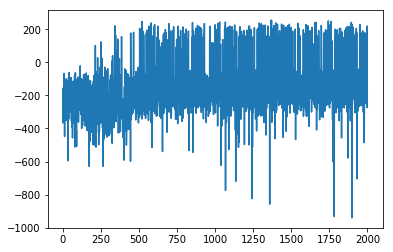

In [28]:
plt.plot(scores)

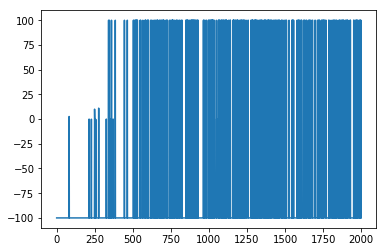

In [29]:
plt.plot(final_rewards)

In [30]:
hundred_scores = []

c = 0
acc = 0

for s in scores:
    if c % 100 == 0:
        hundred_scores.append(acc)
        acc = 0
    
    acc += s
    c += 1

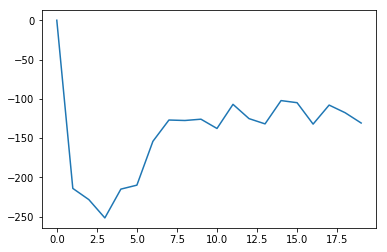

In [31]:
plt.plot(np.array(hundred_scores) / 100)

In [32]:
torch.save(dqn.model.state_dict(), './dqn.pth')

In [38]:
# from https://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

# Run a demo of the environment
state = env.reset()

frames = []
done = False
while not done:
    # Render into buffer. 
    # You will still see the window.
    frames.append(env.render(mode = 'rgb_array'))
    action = np.argmax(dqn.predict(state))
    state, reward, done, info = env.step(action)

env.close()


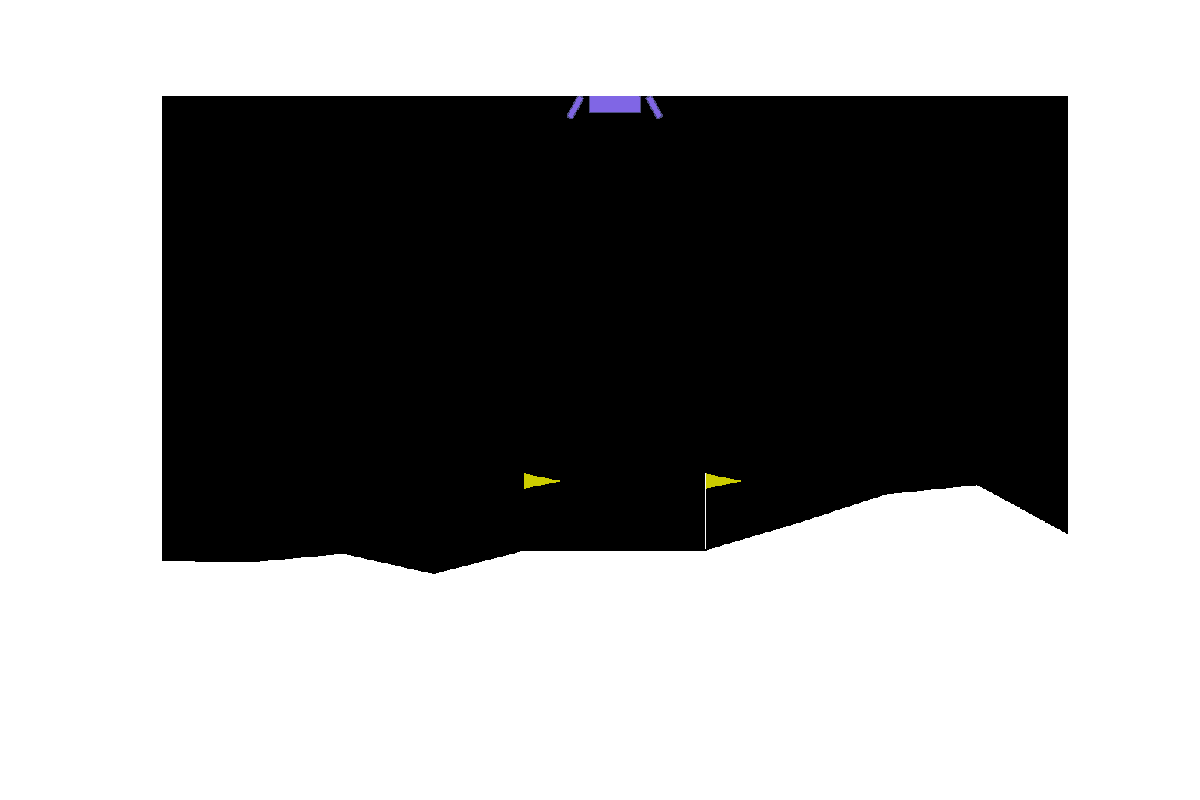
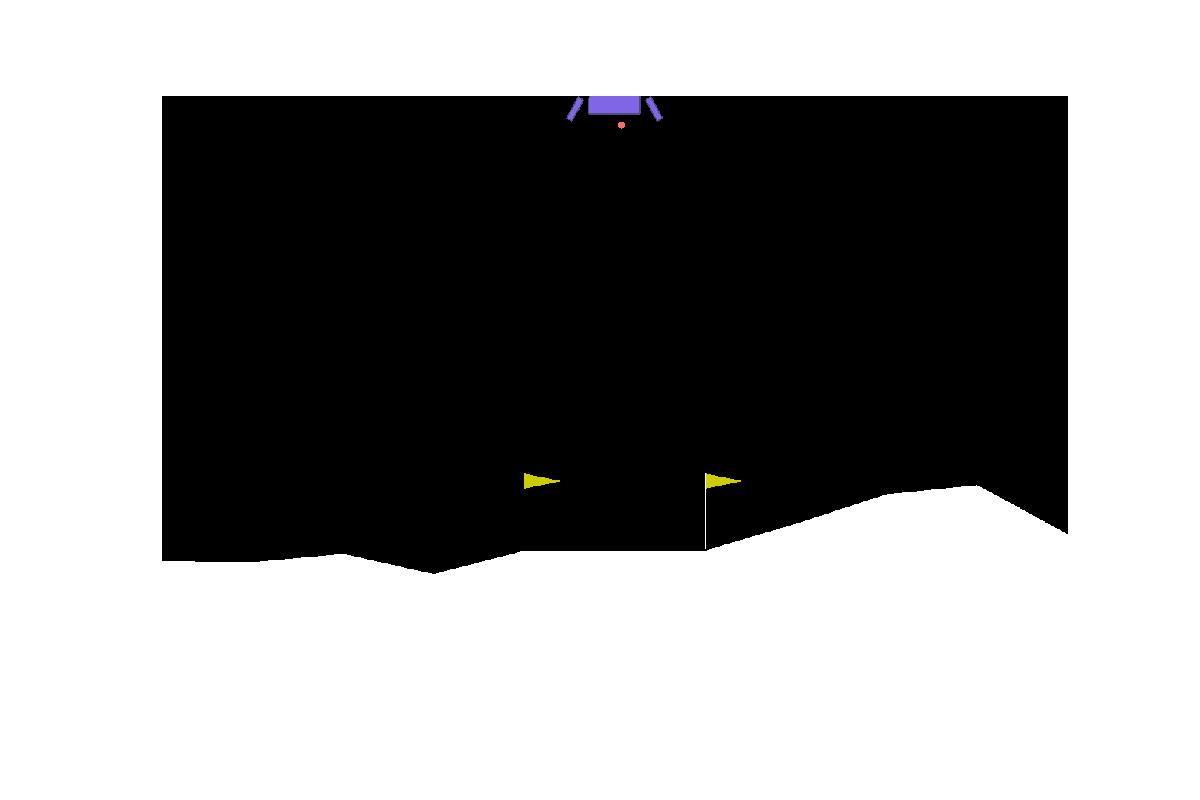
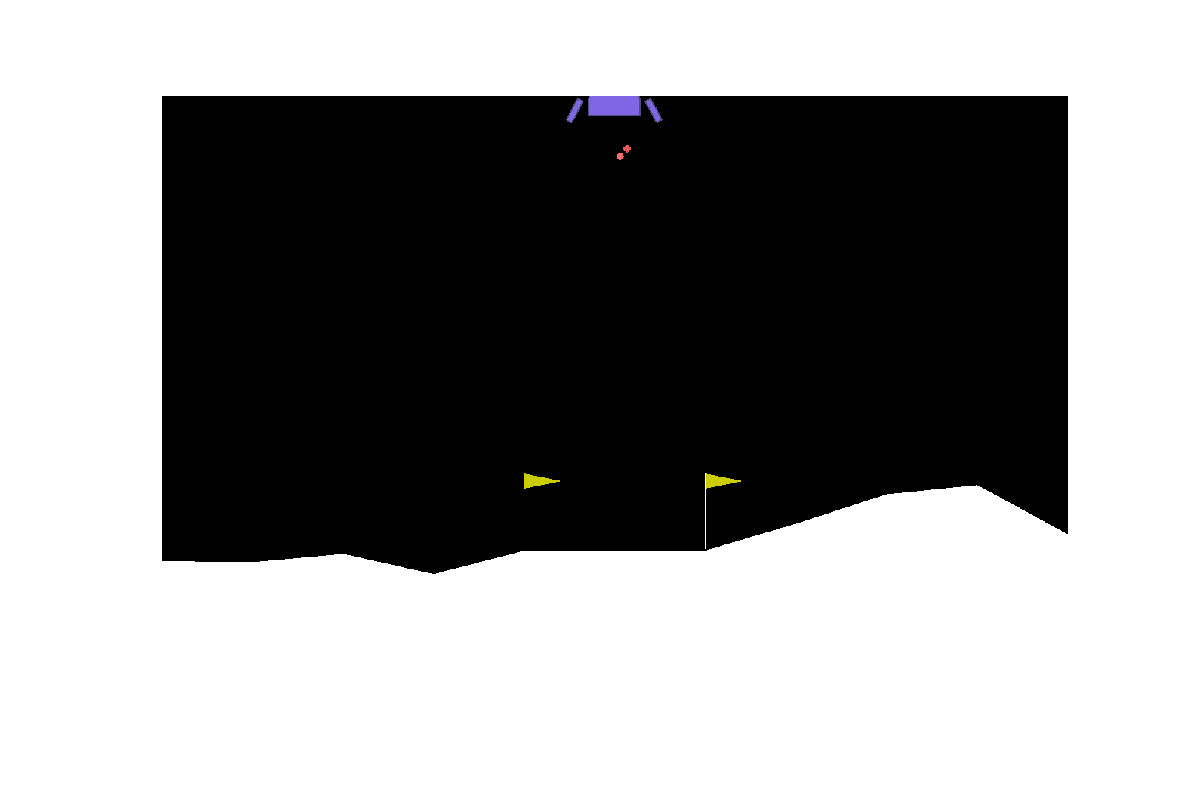
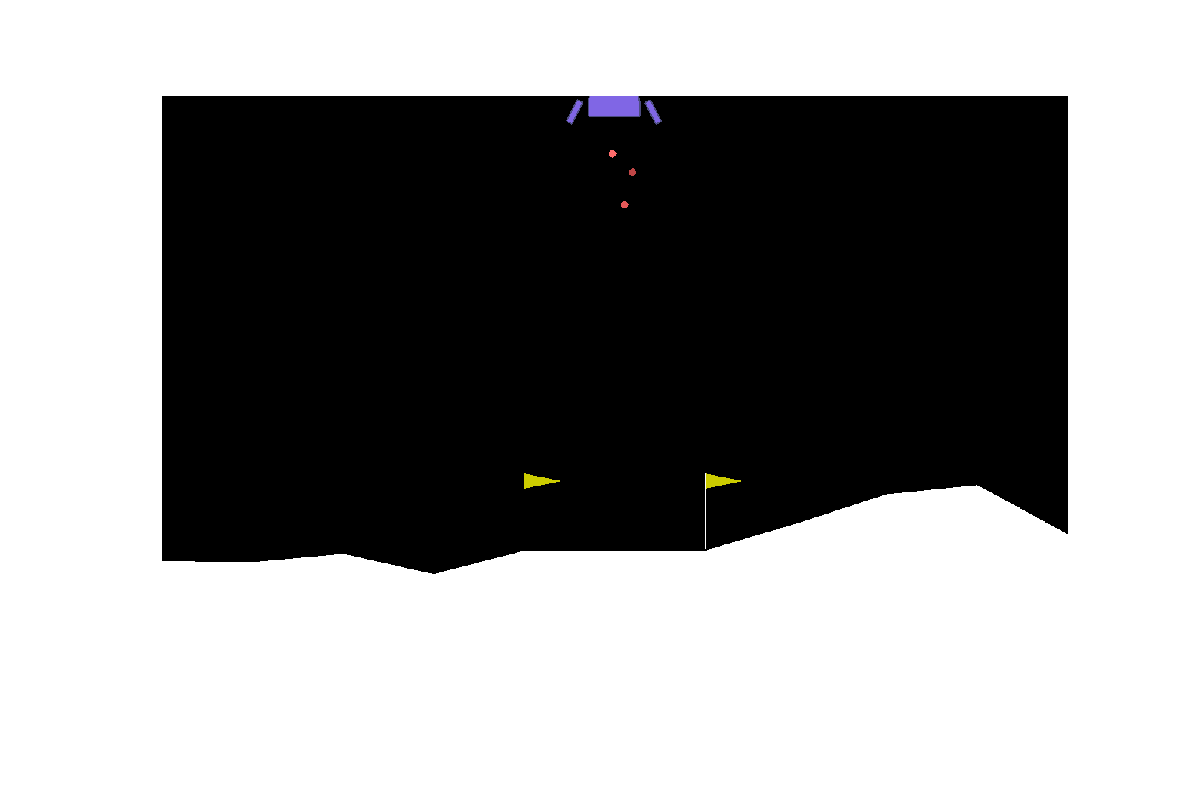
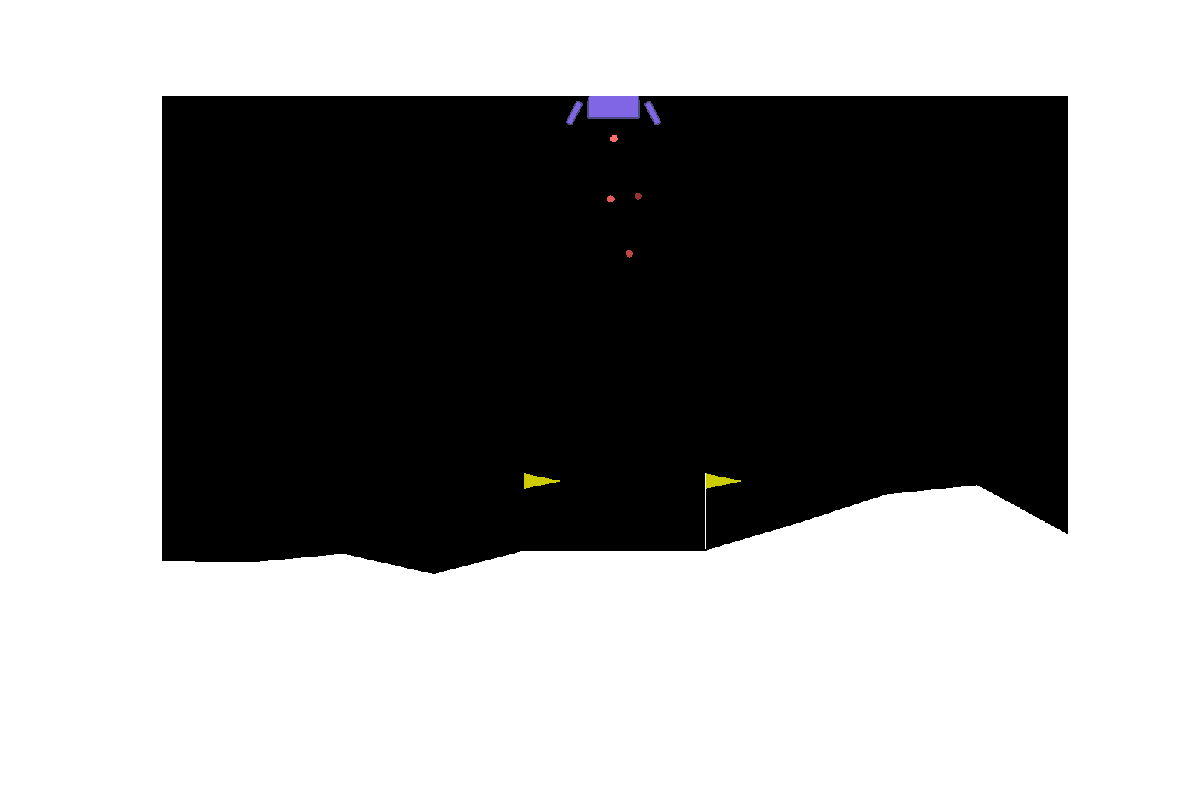
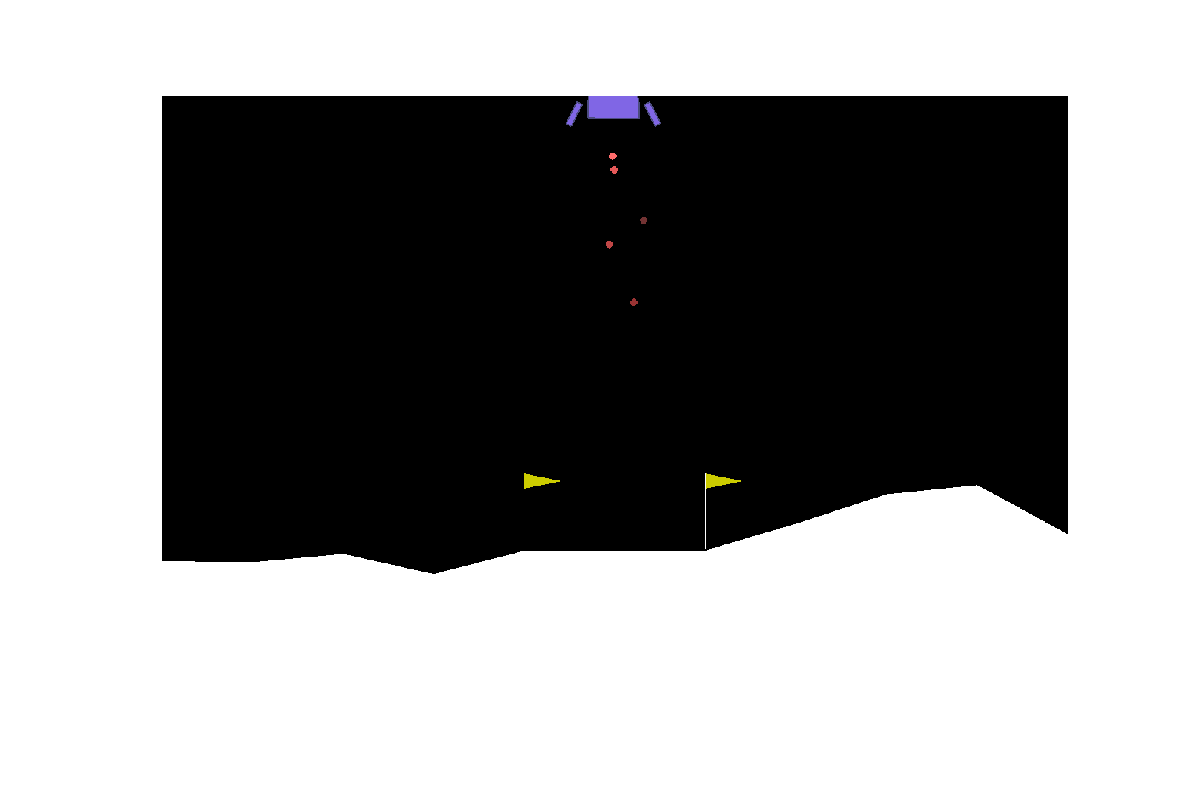
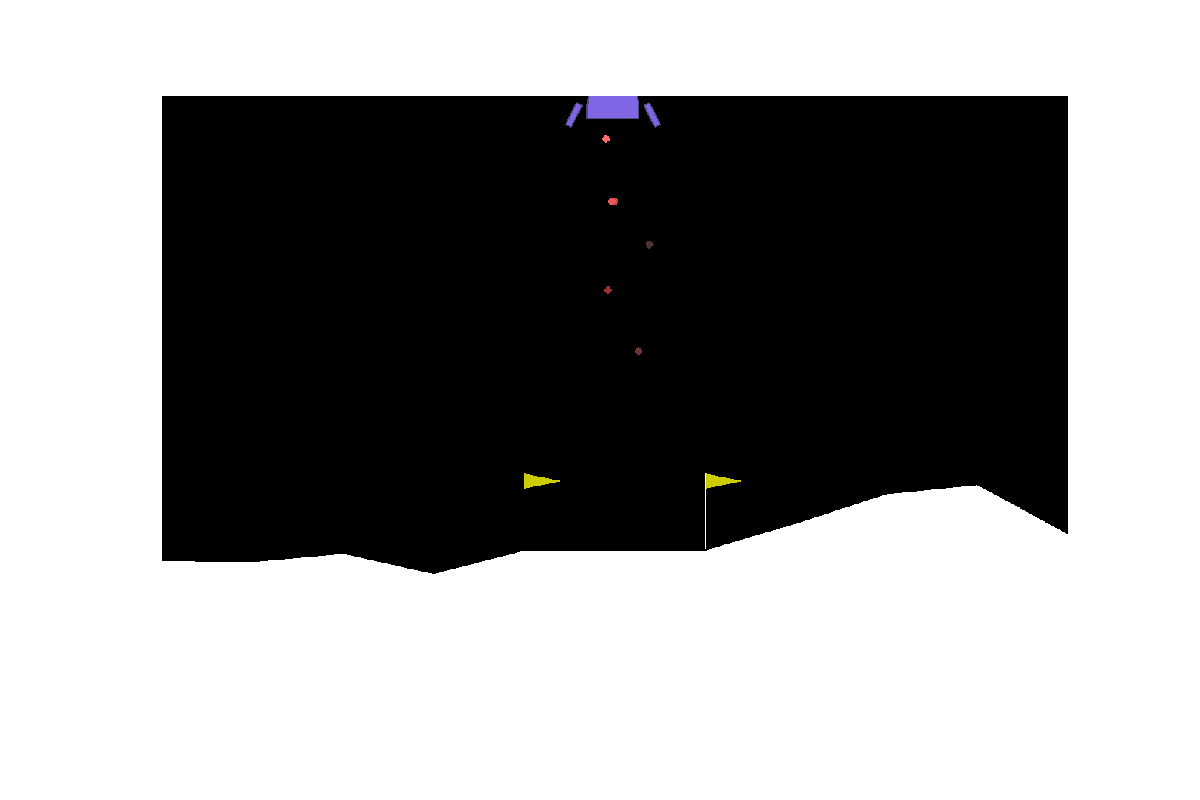
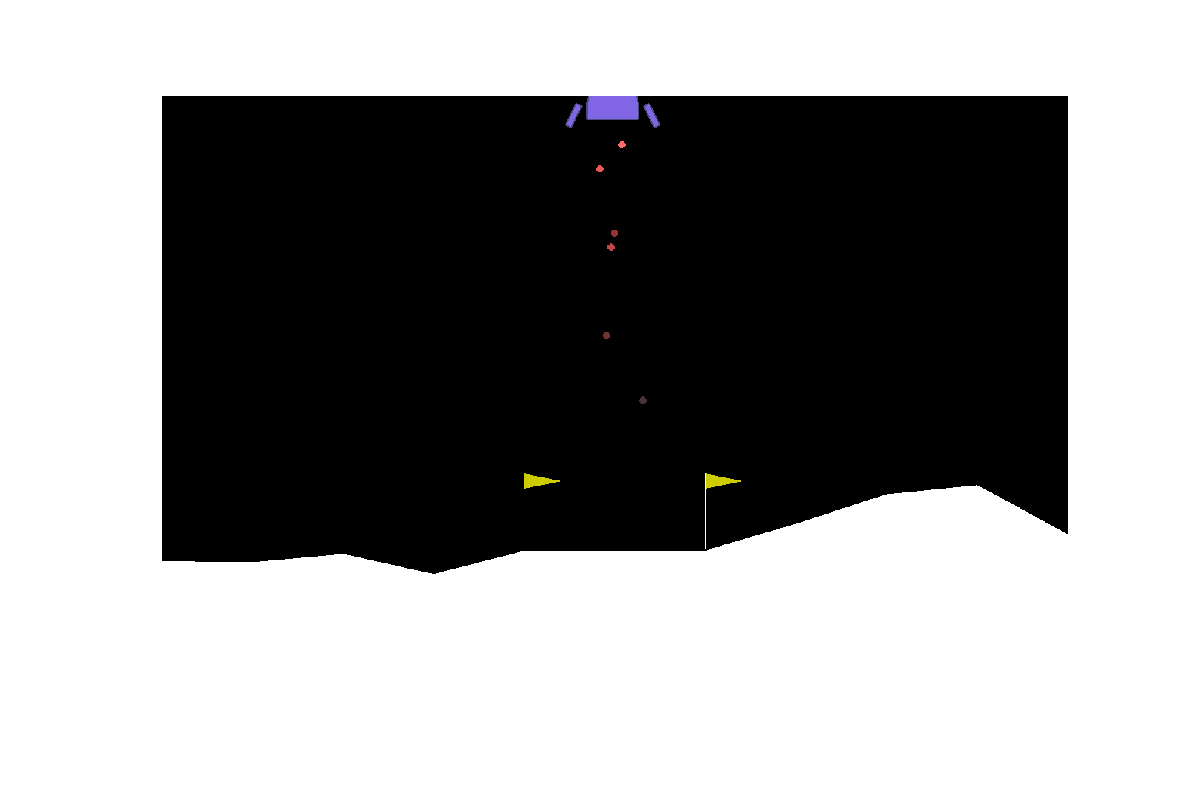
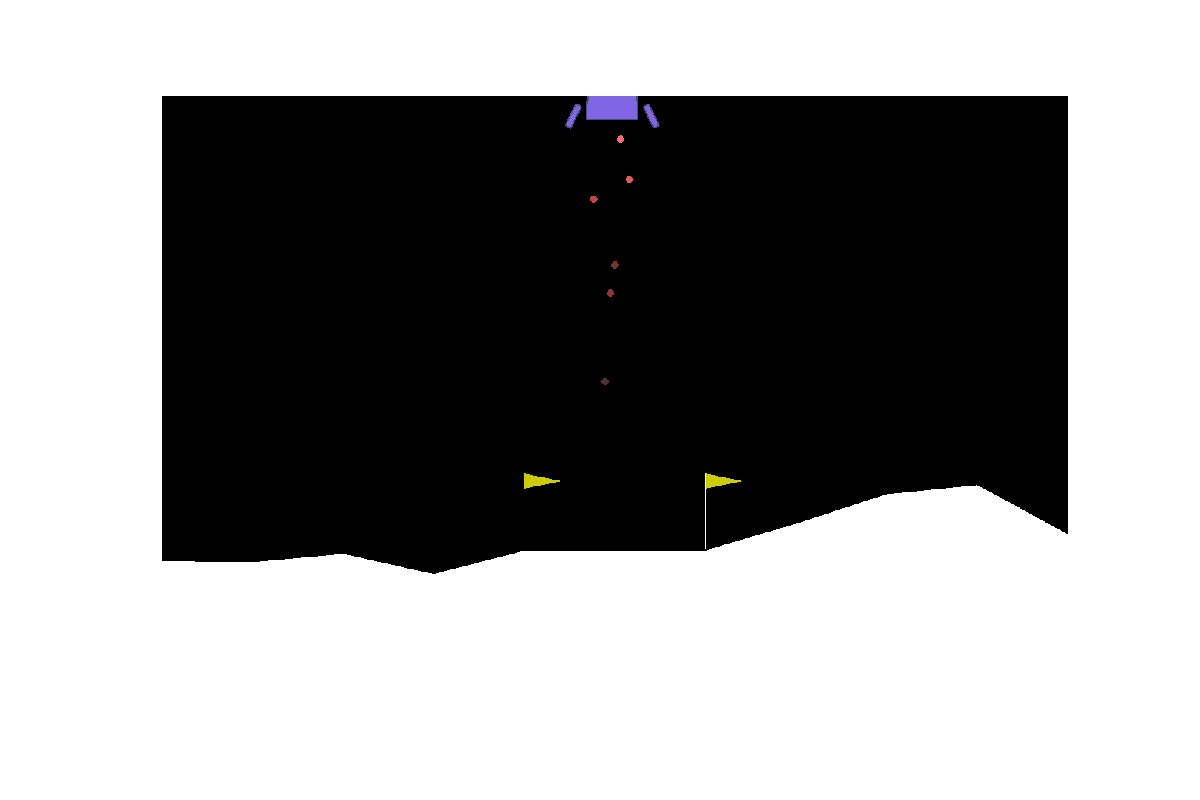
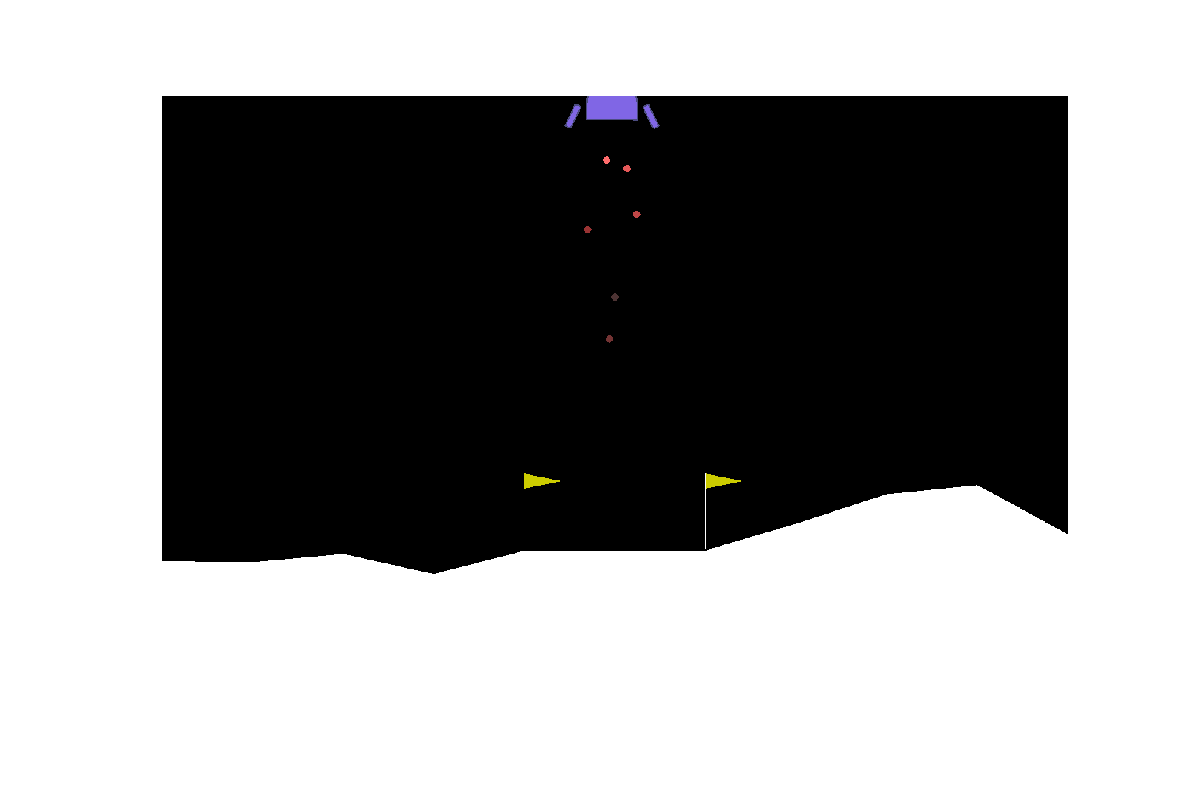
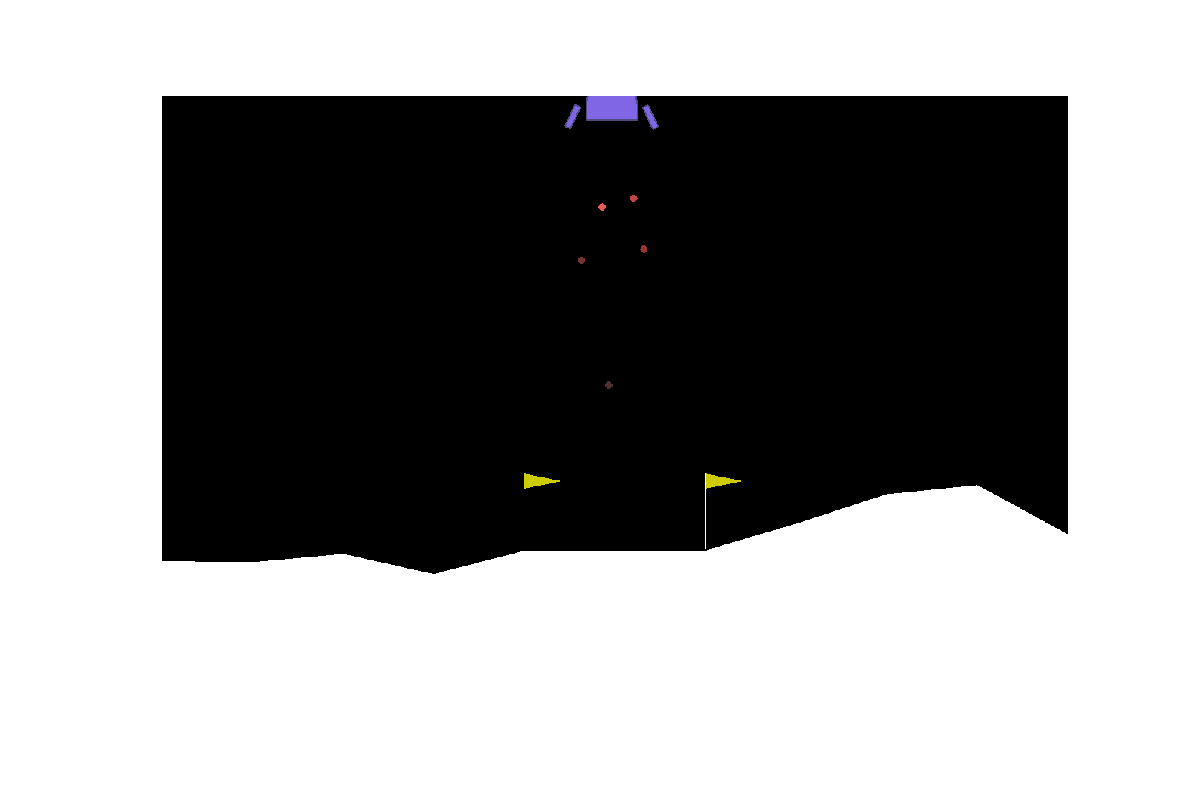
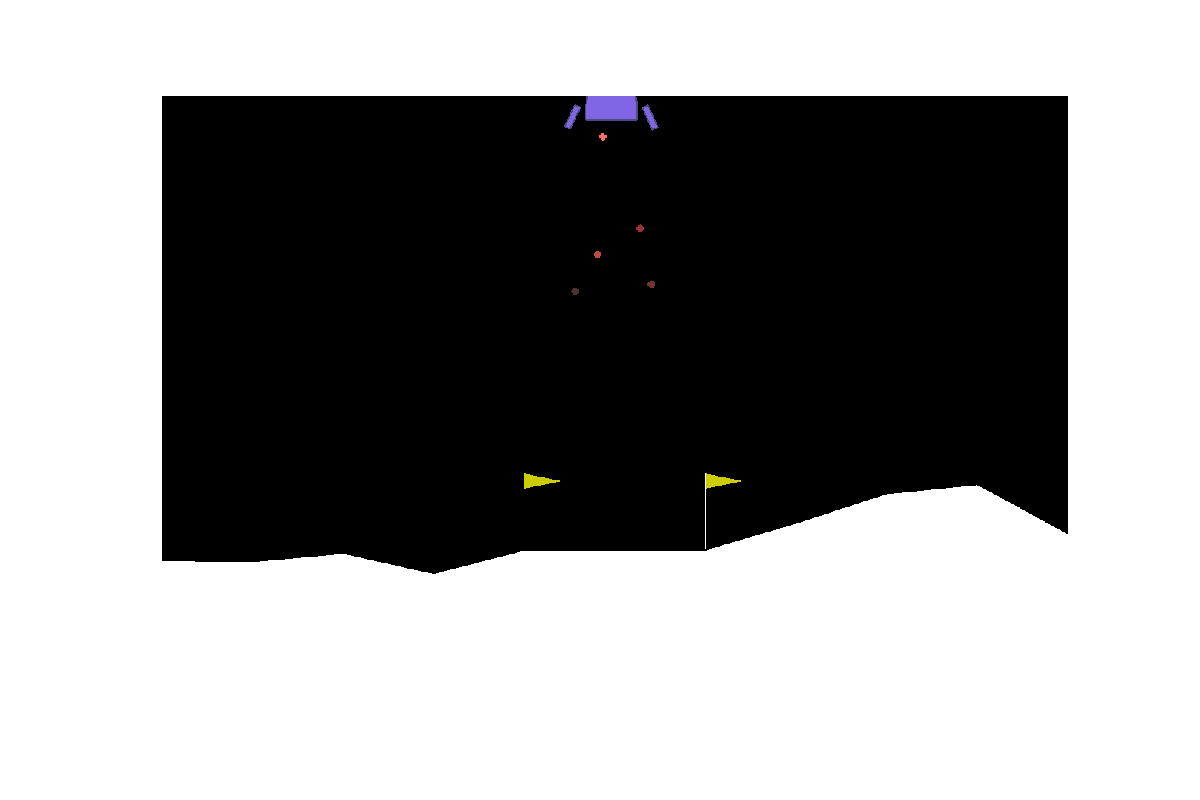
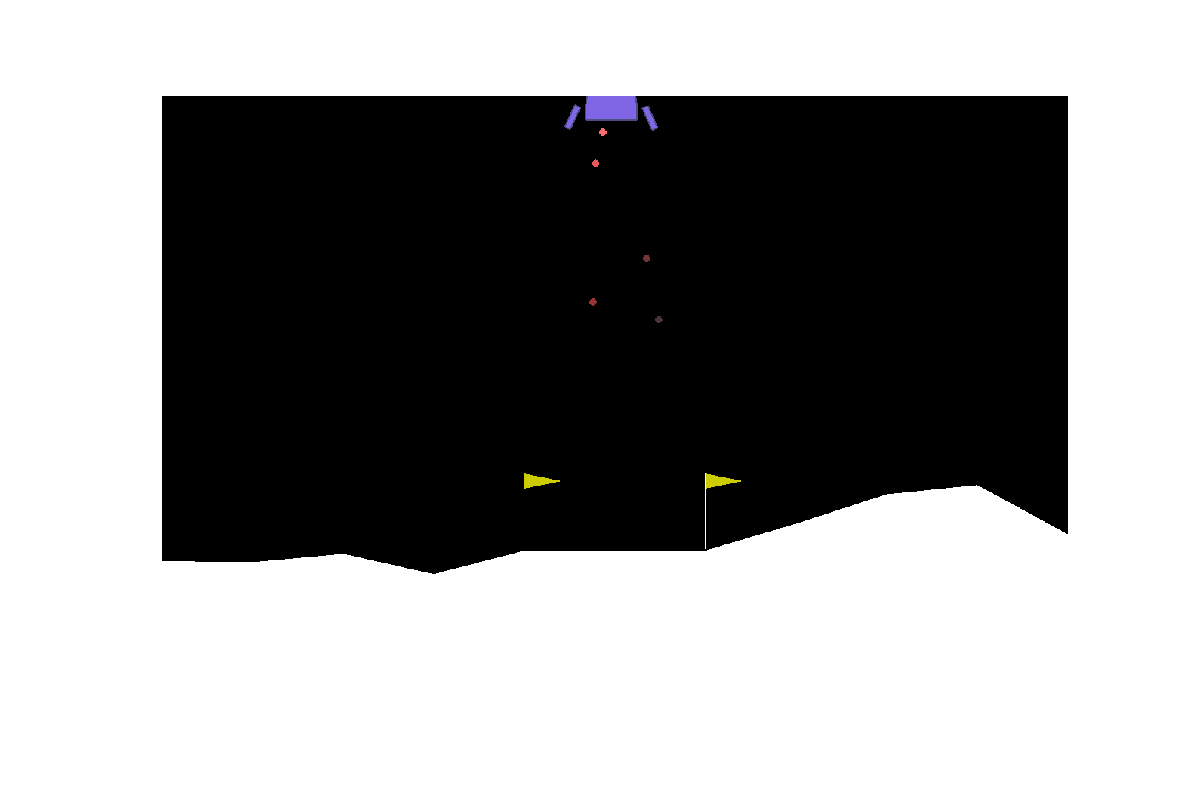
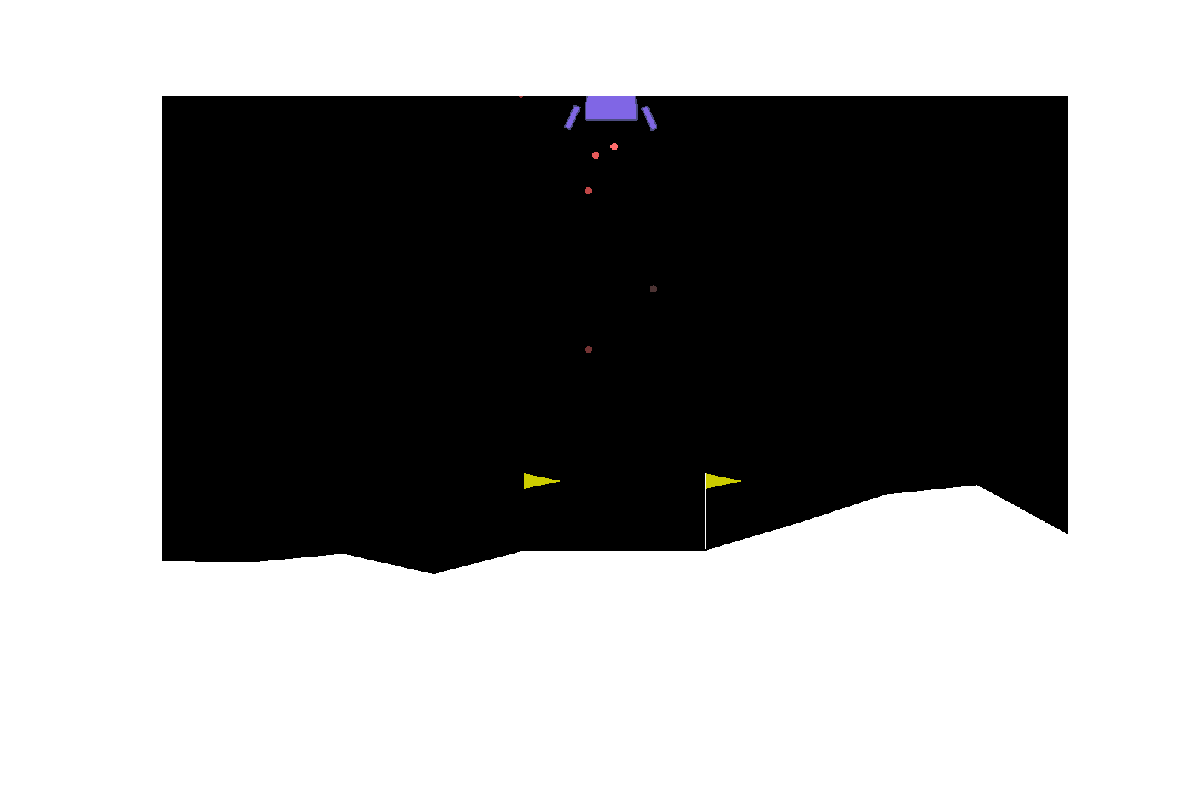
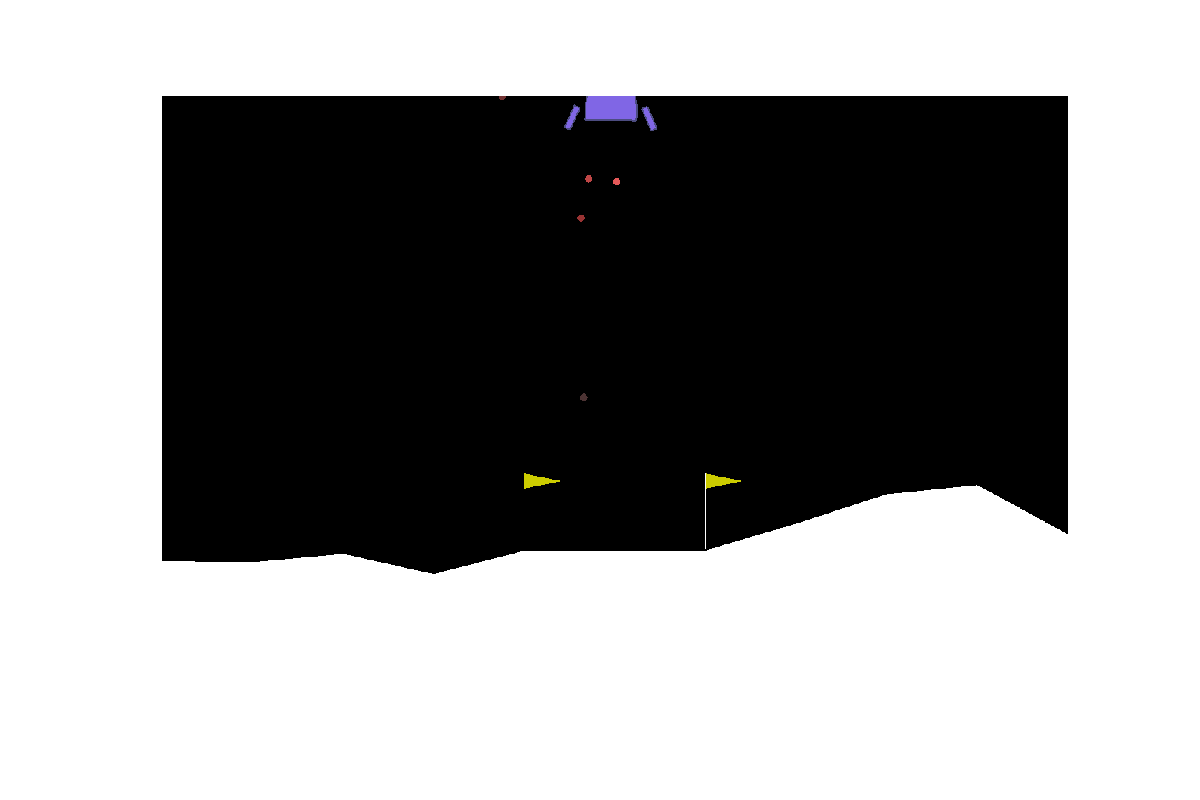
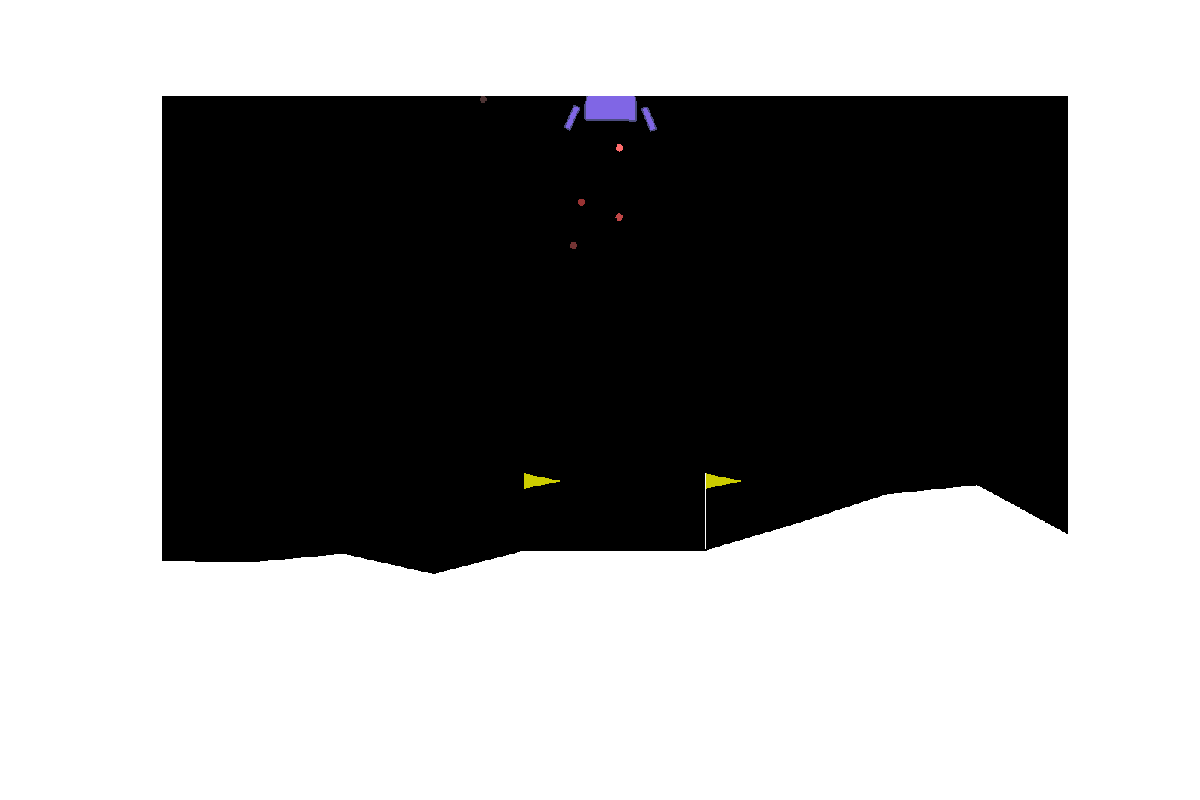
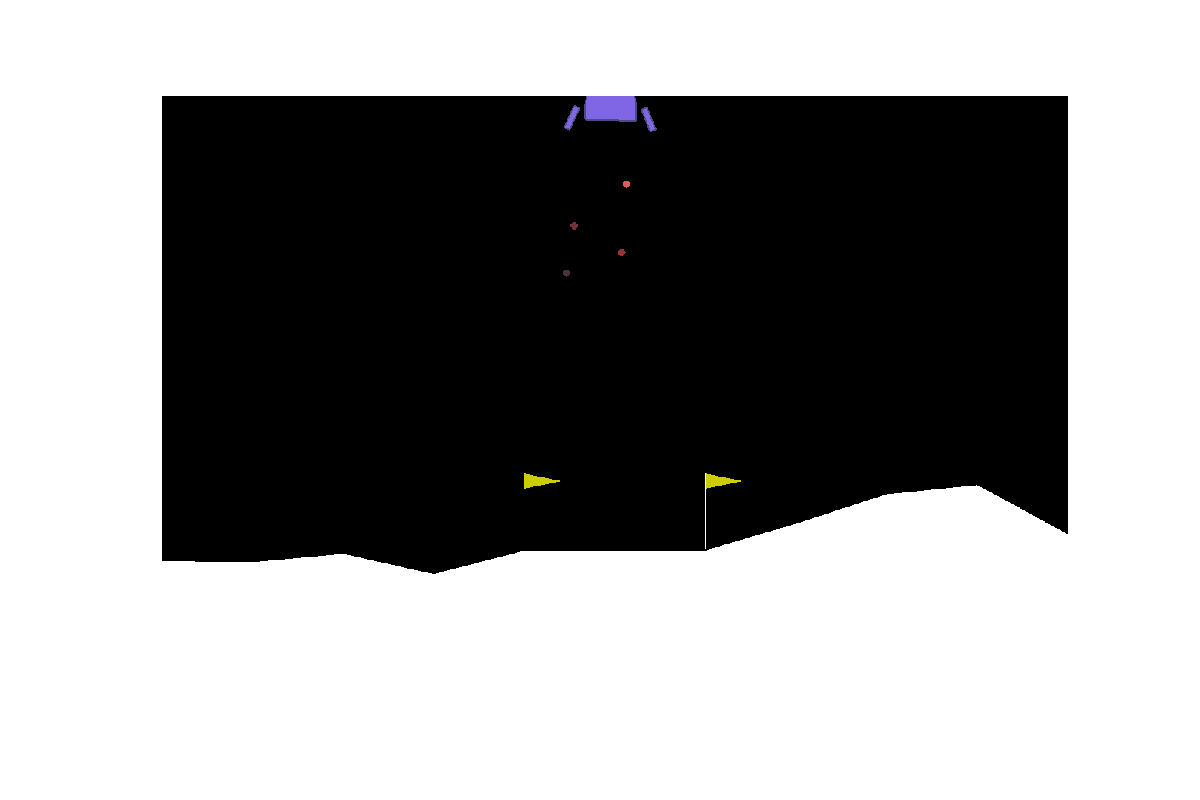
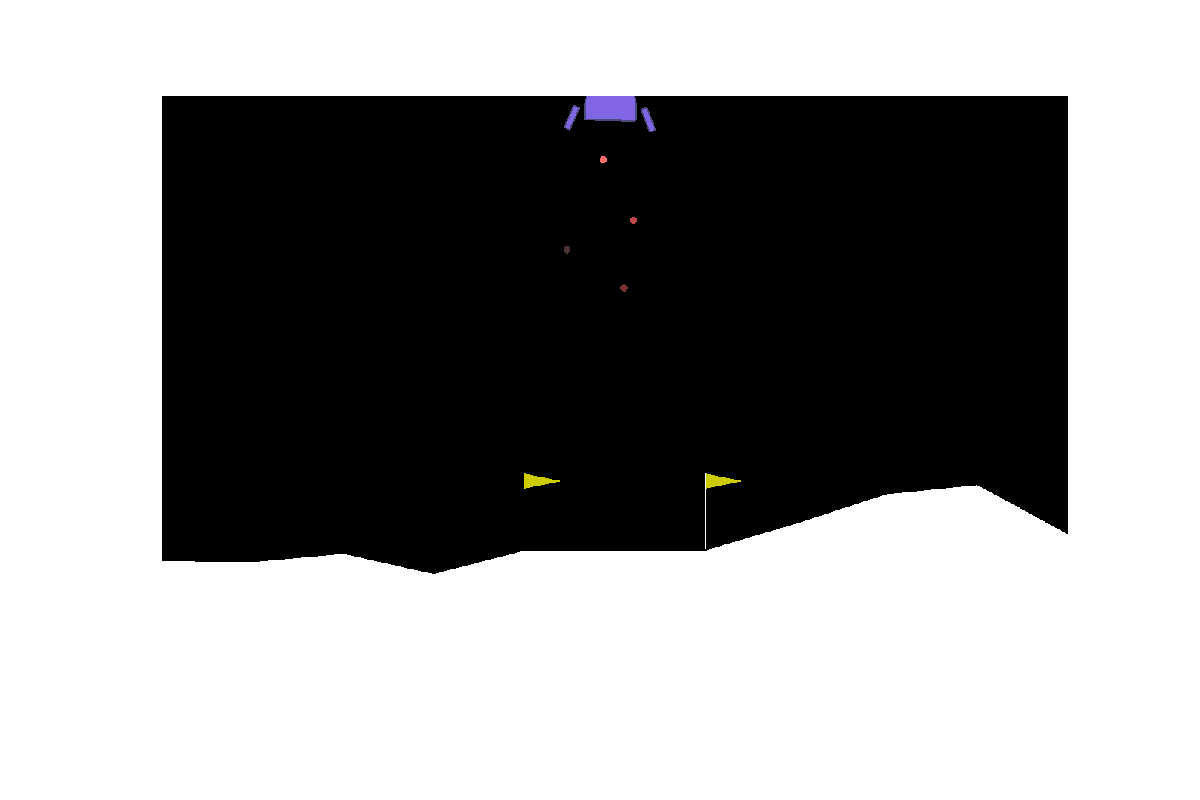
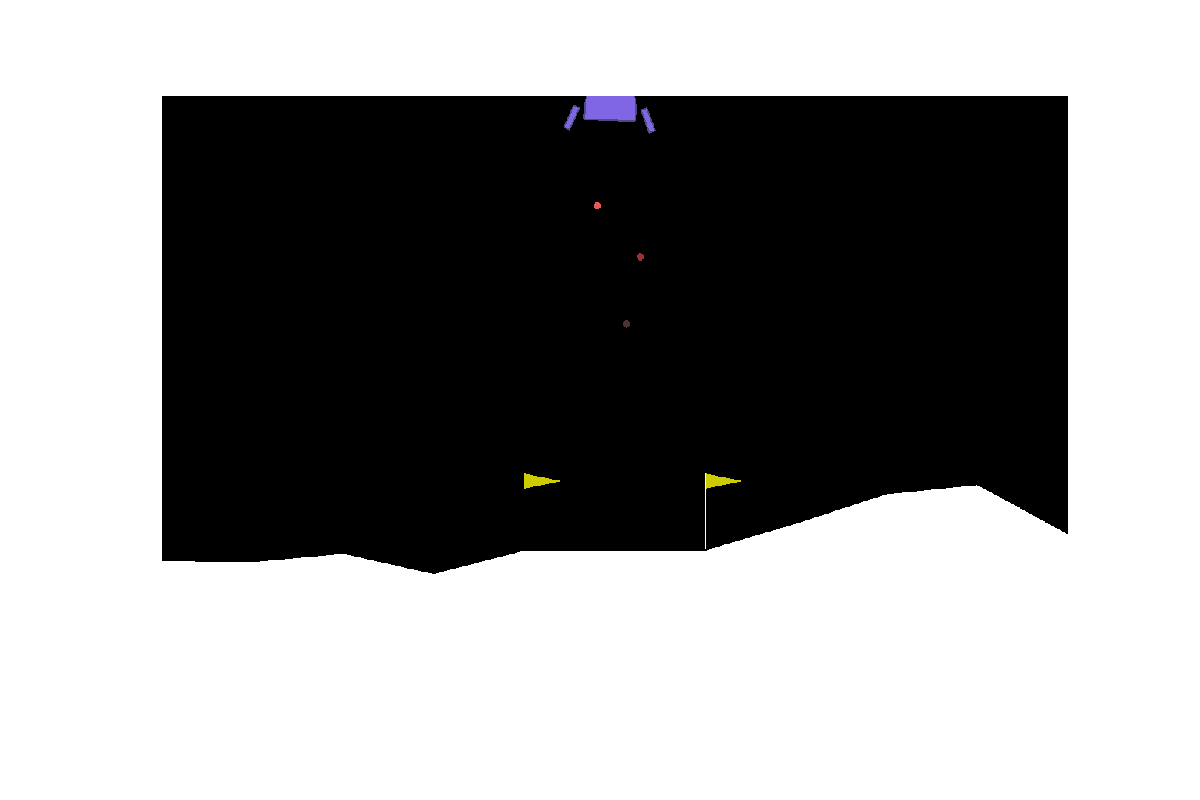
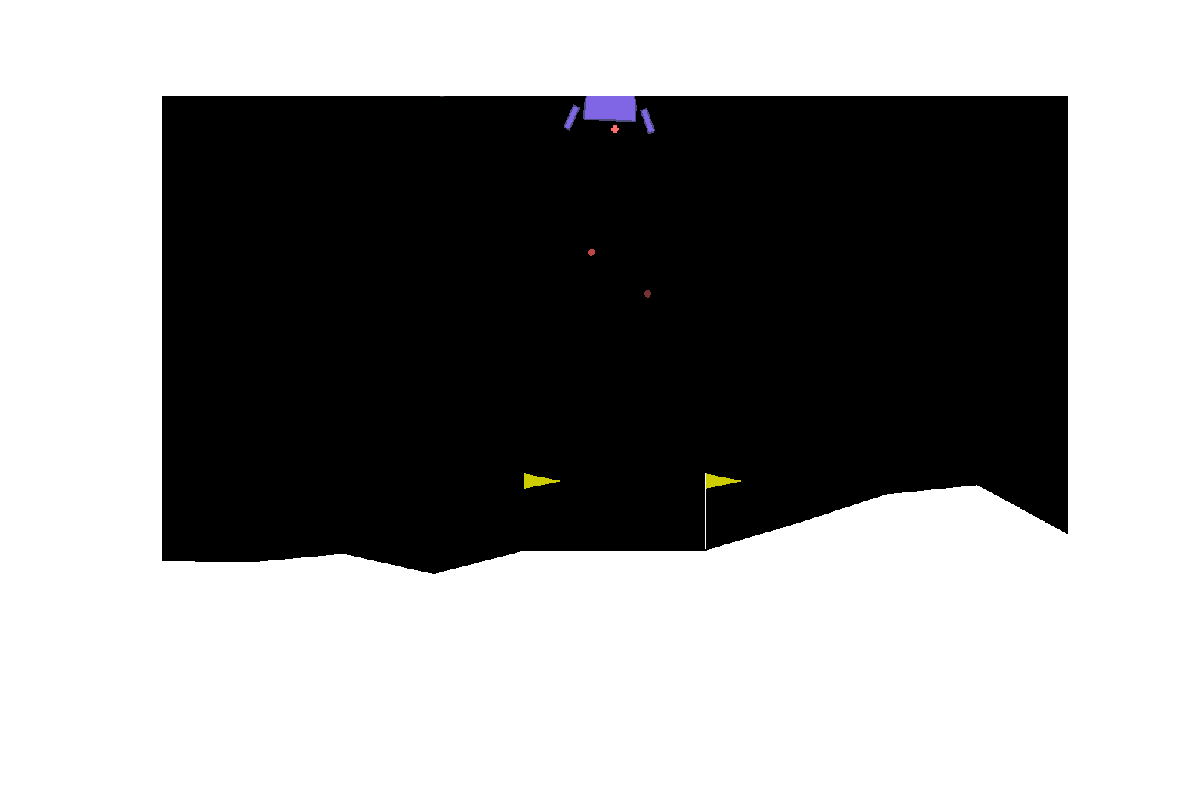
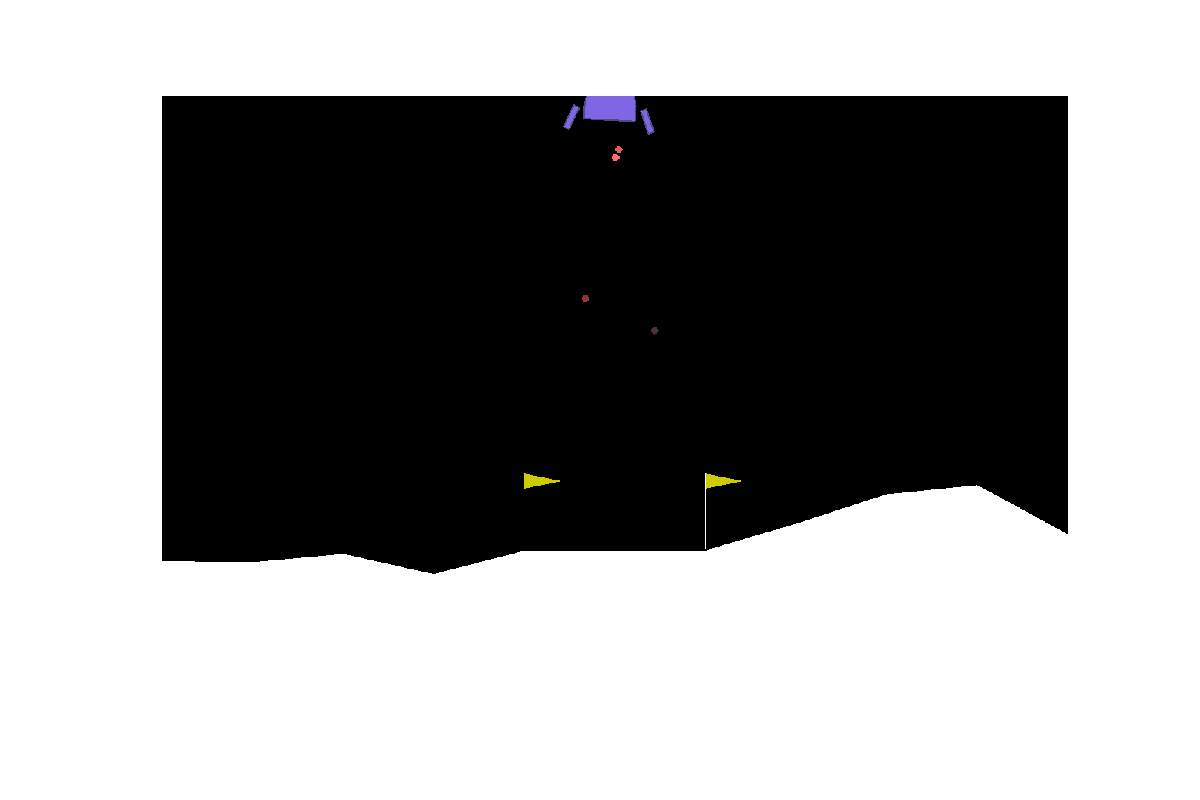
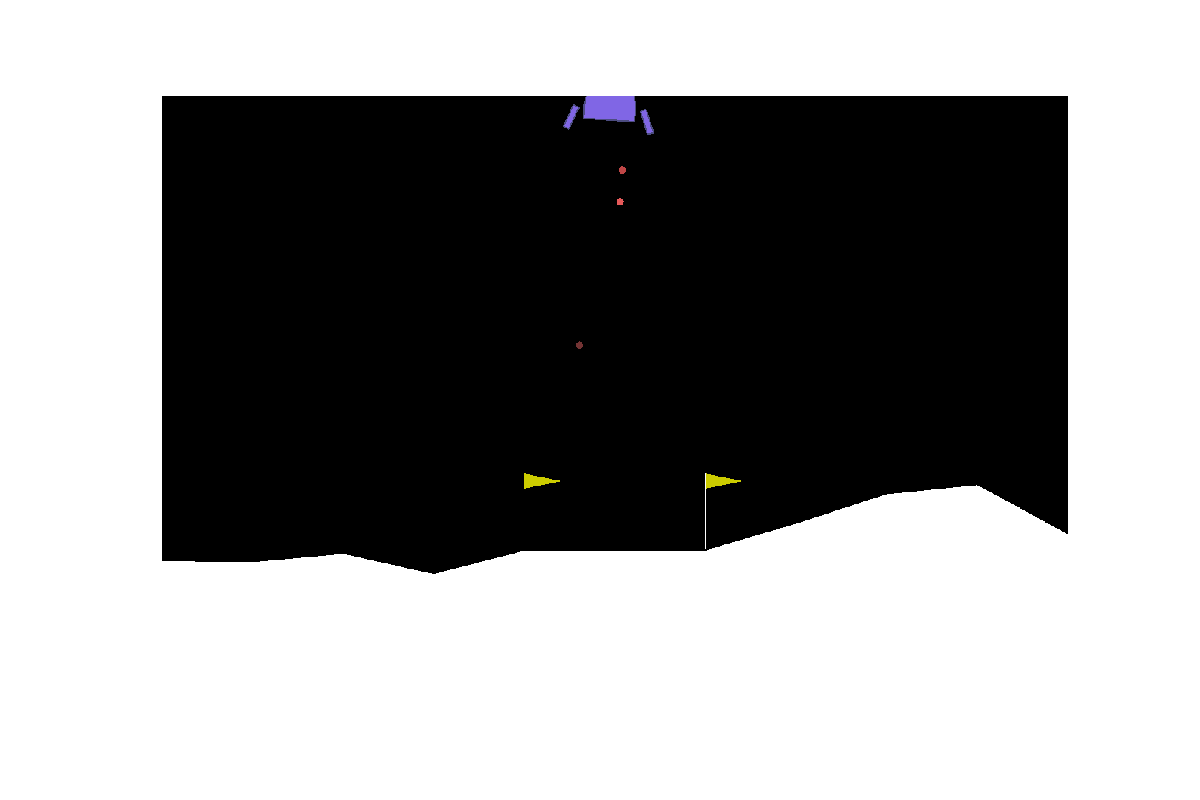
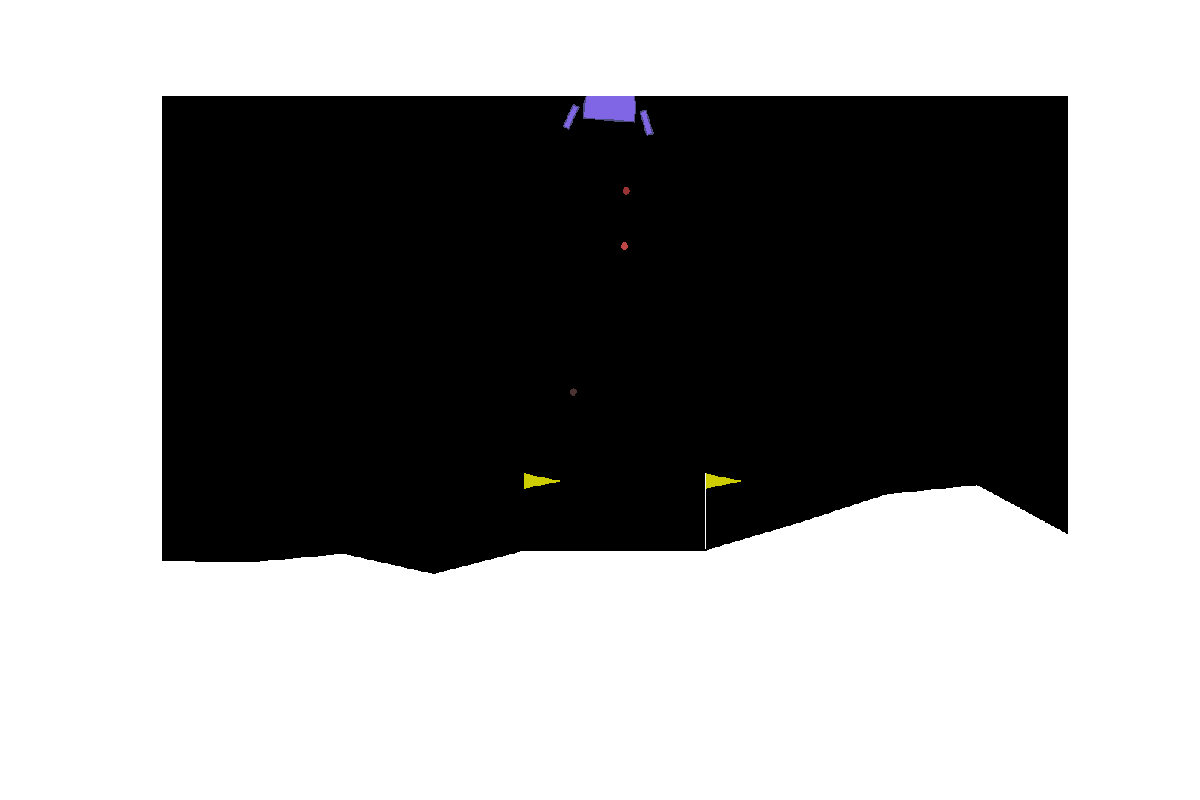
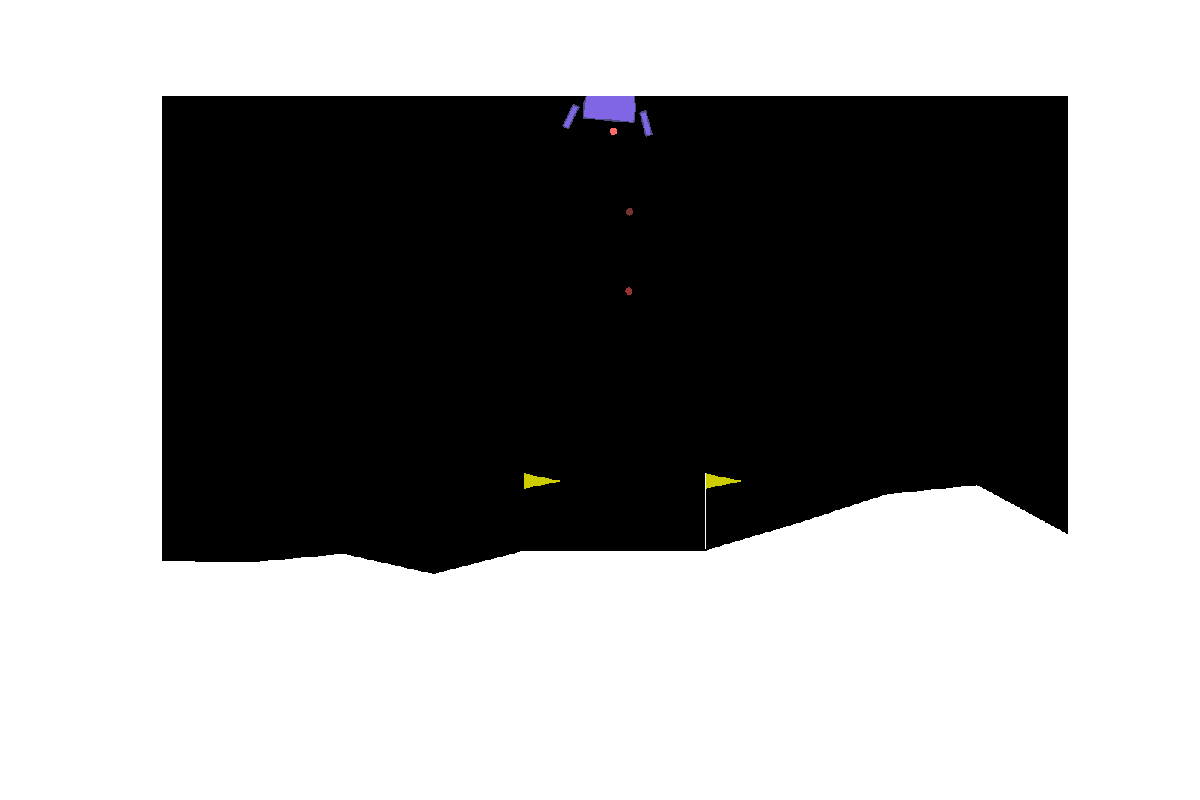
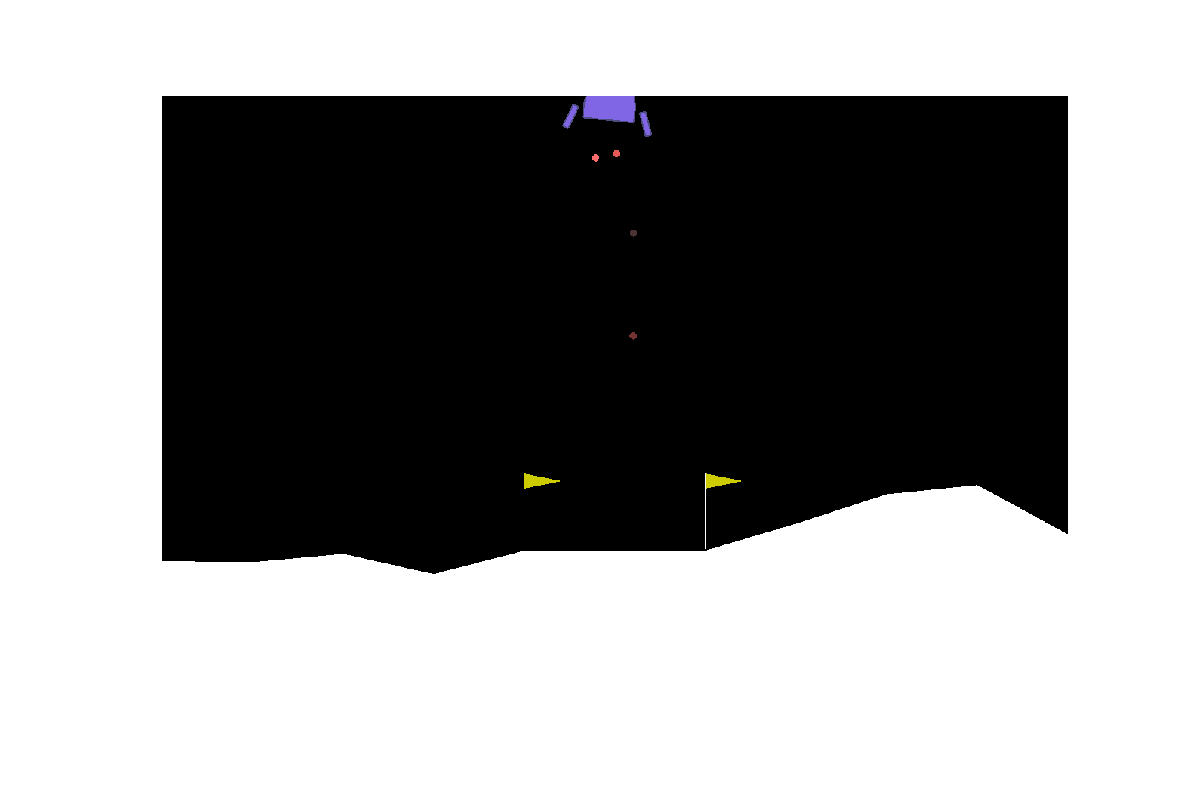
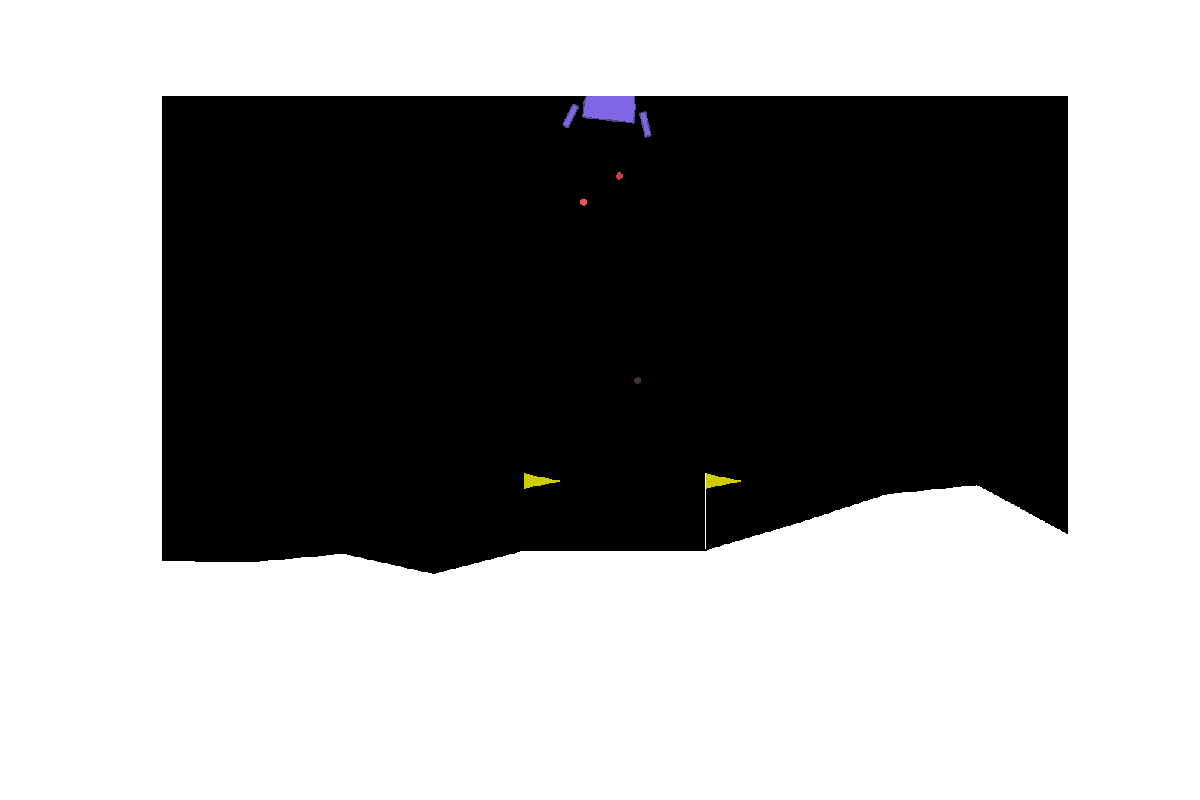
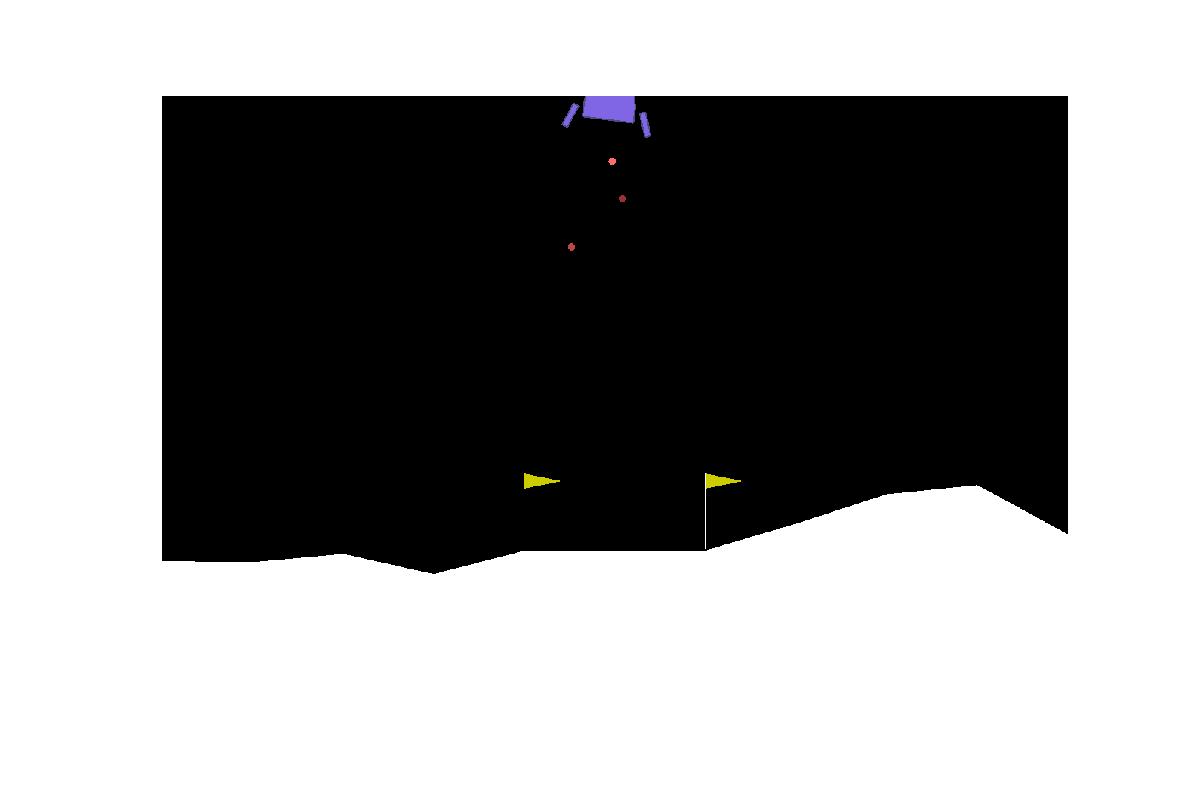
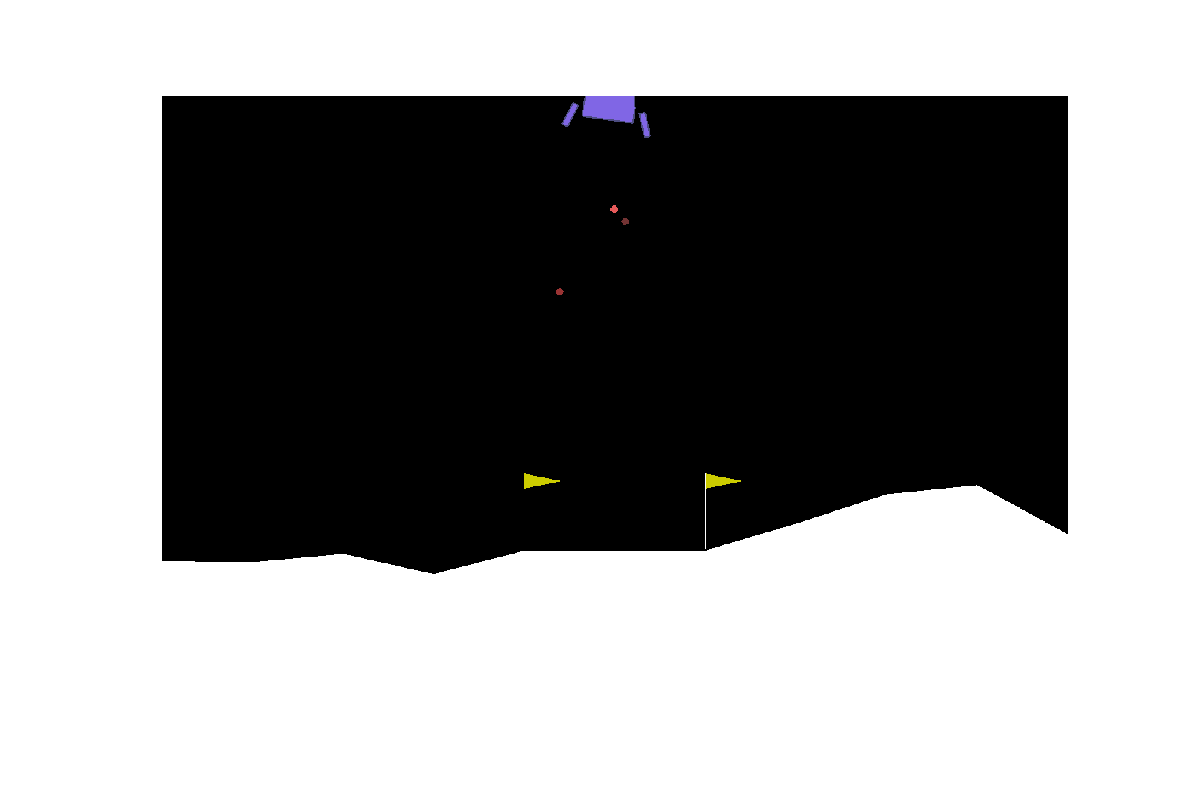
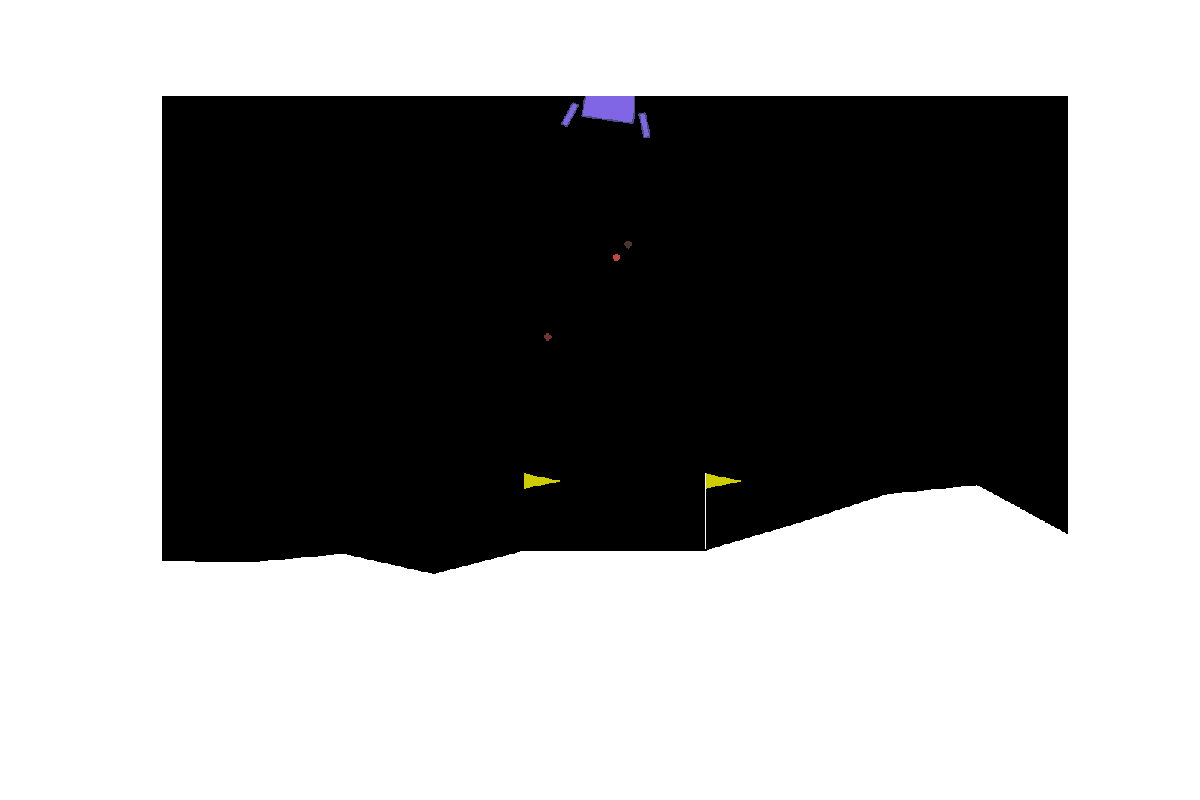
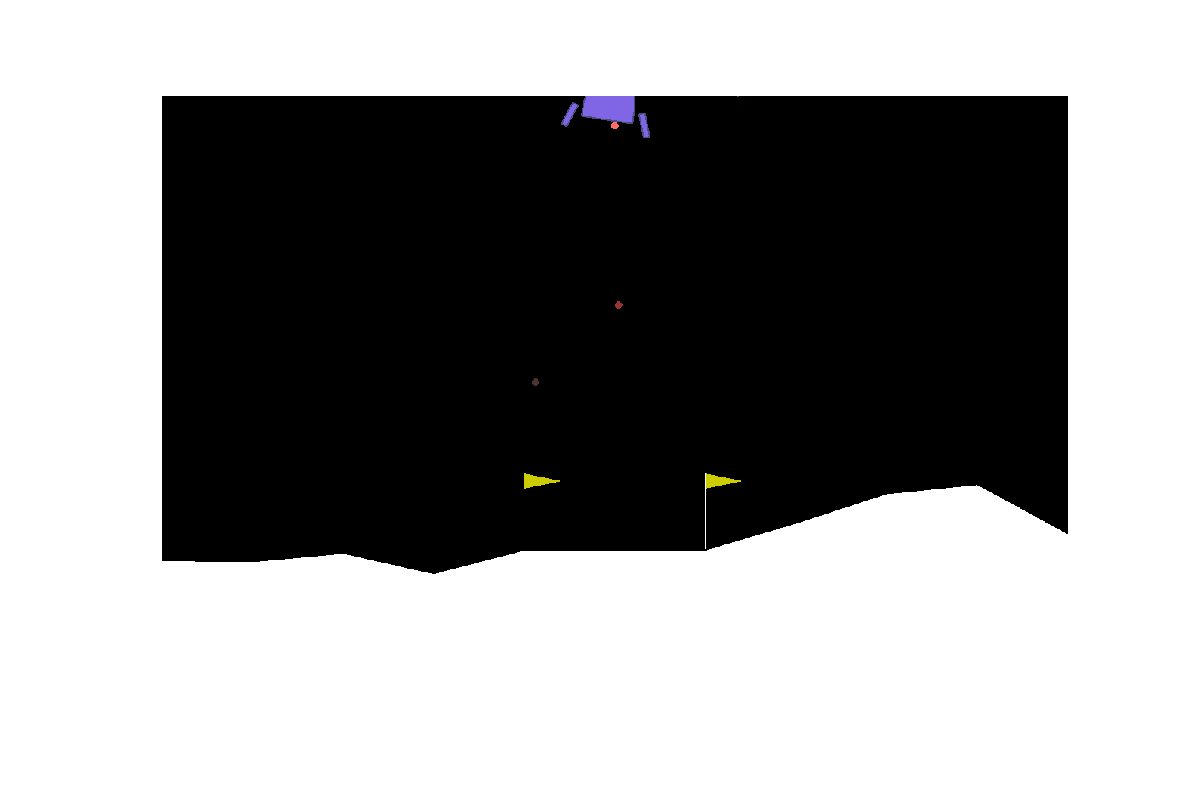
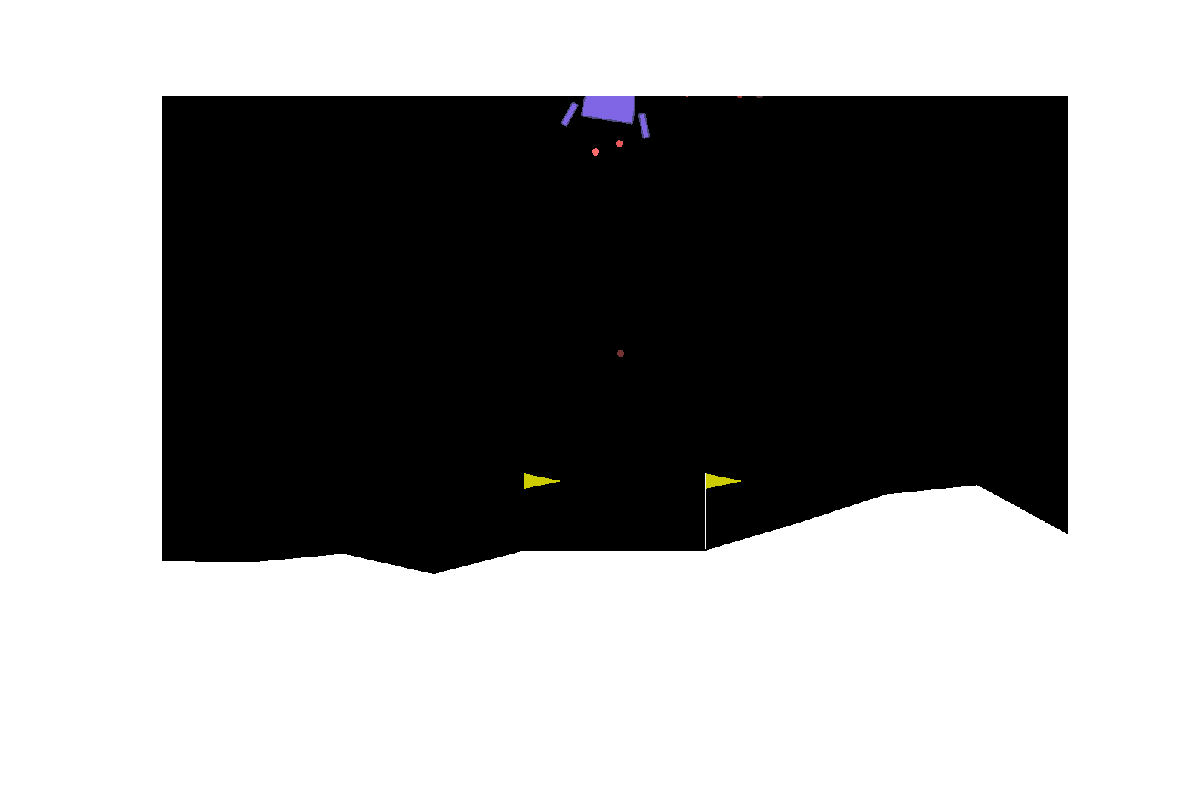
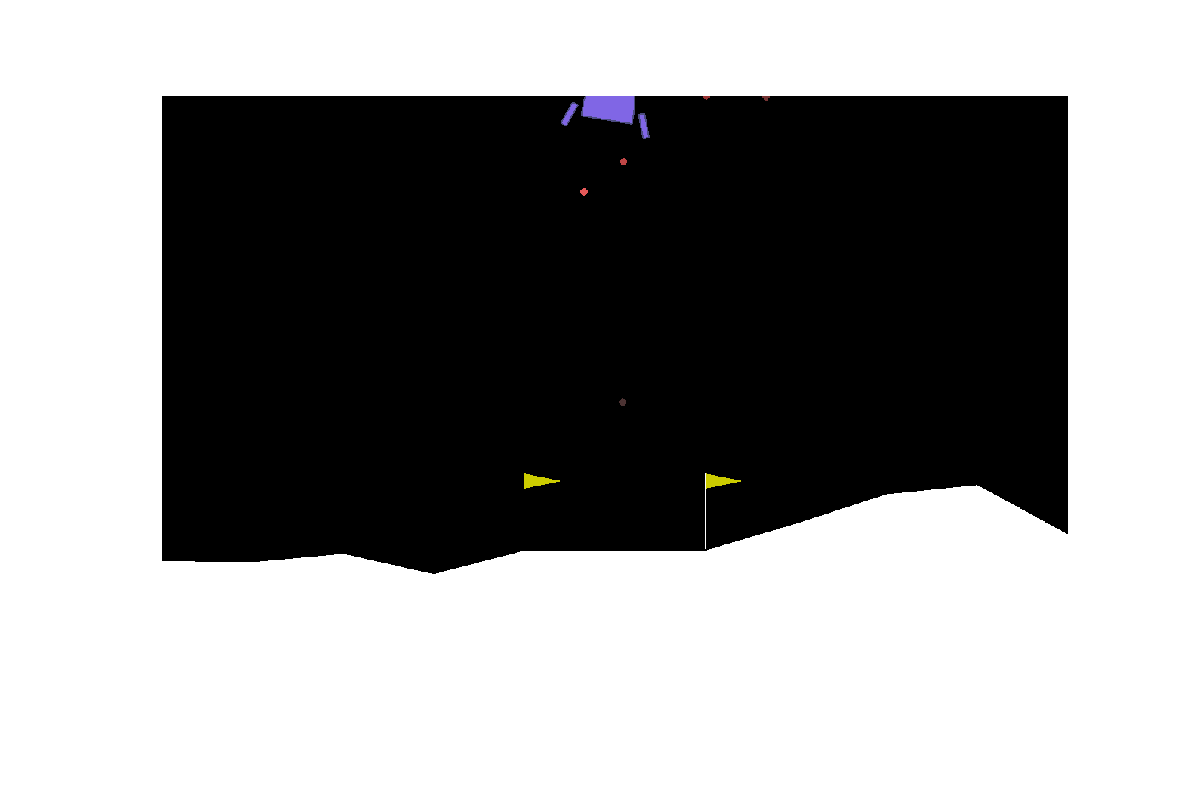
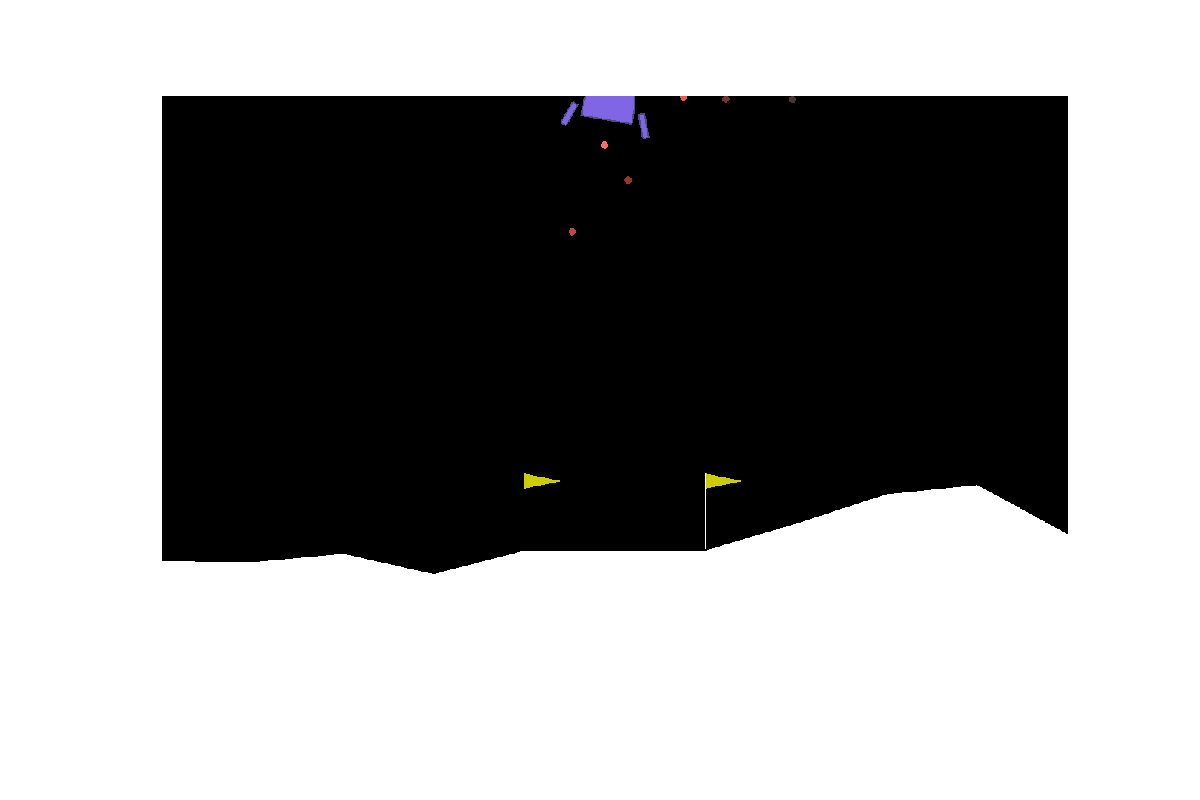
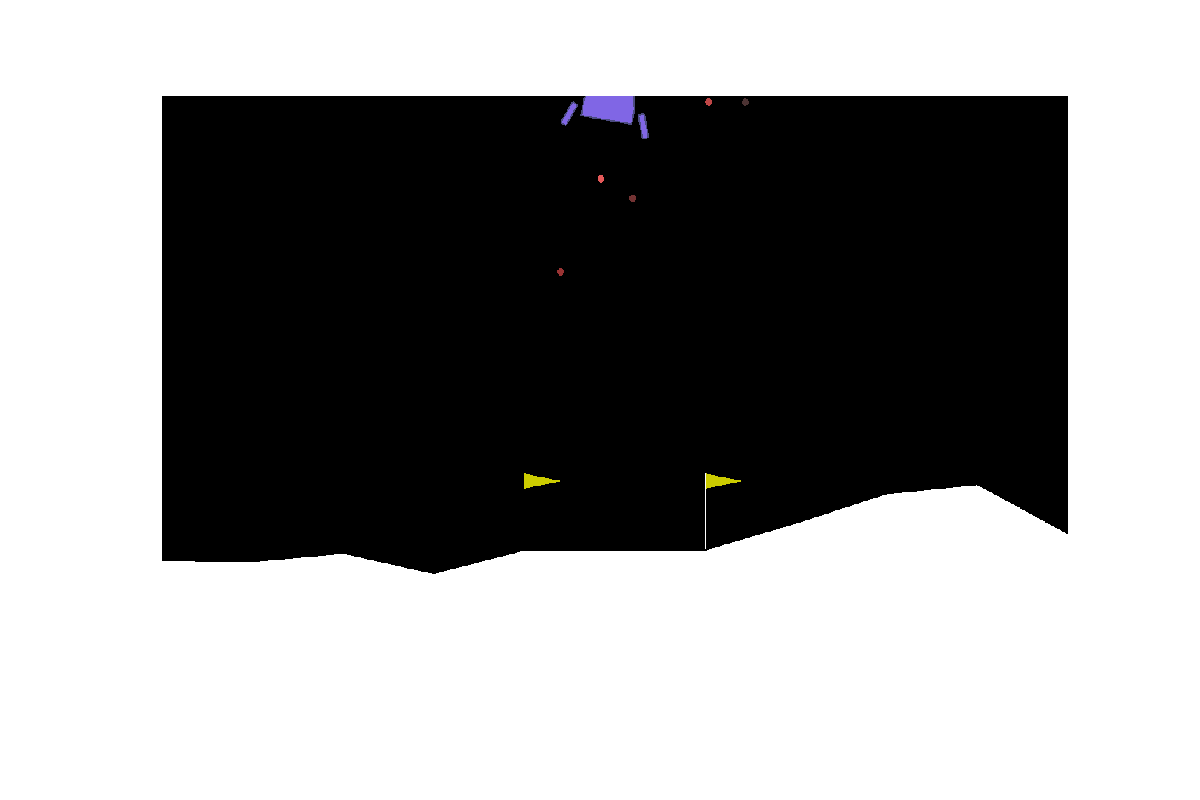
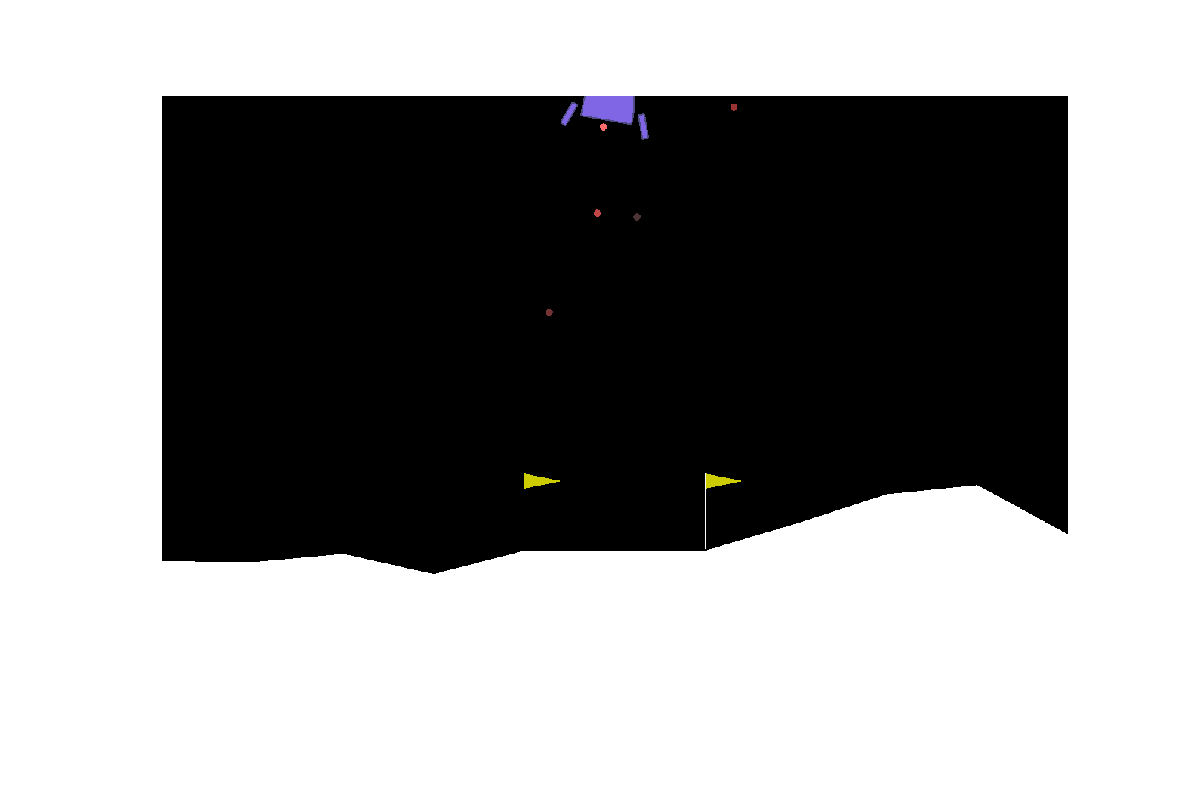
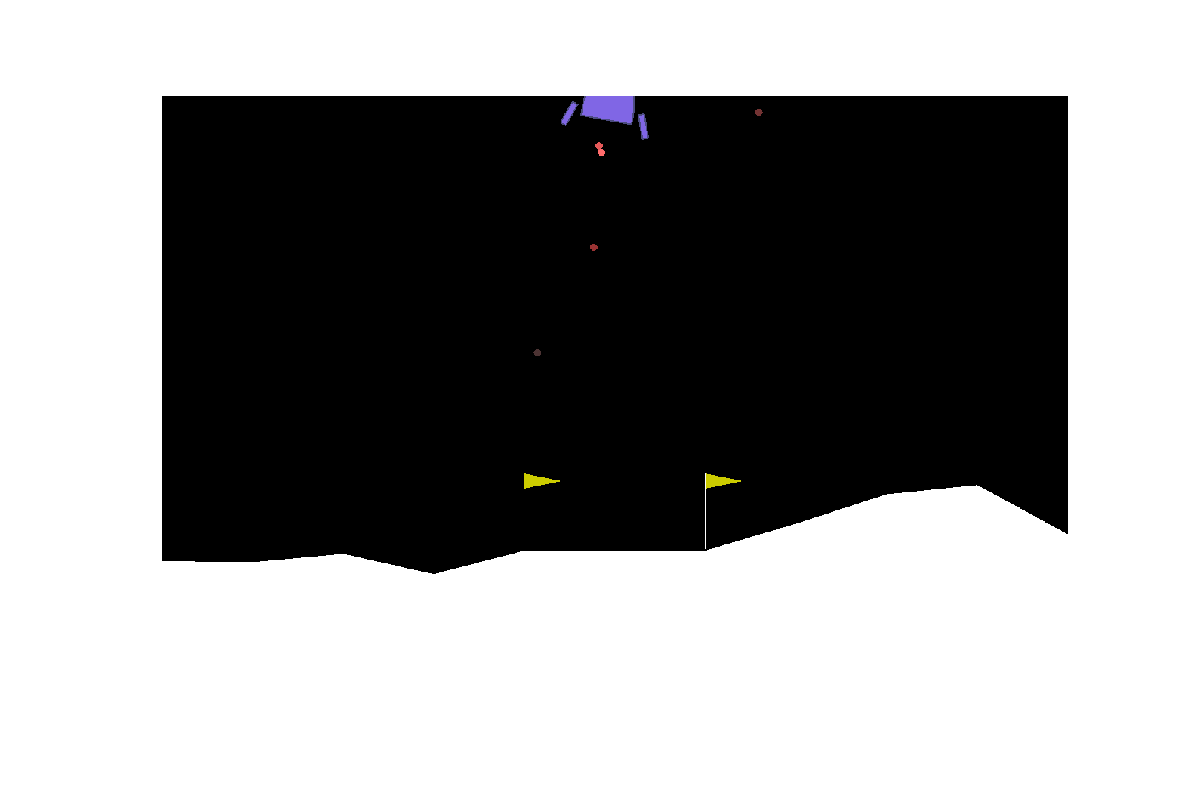
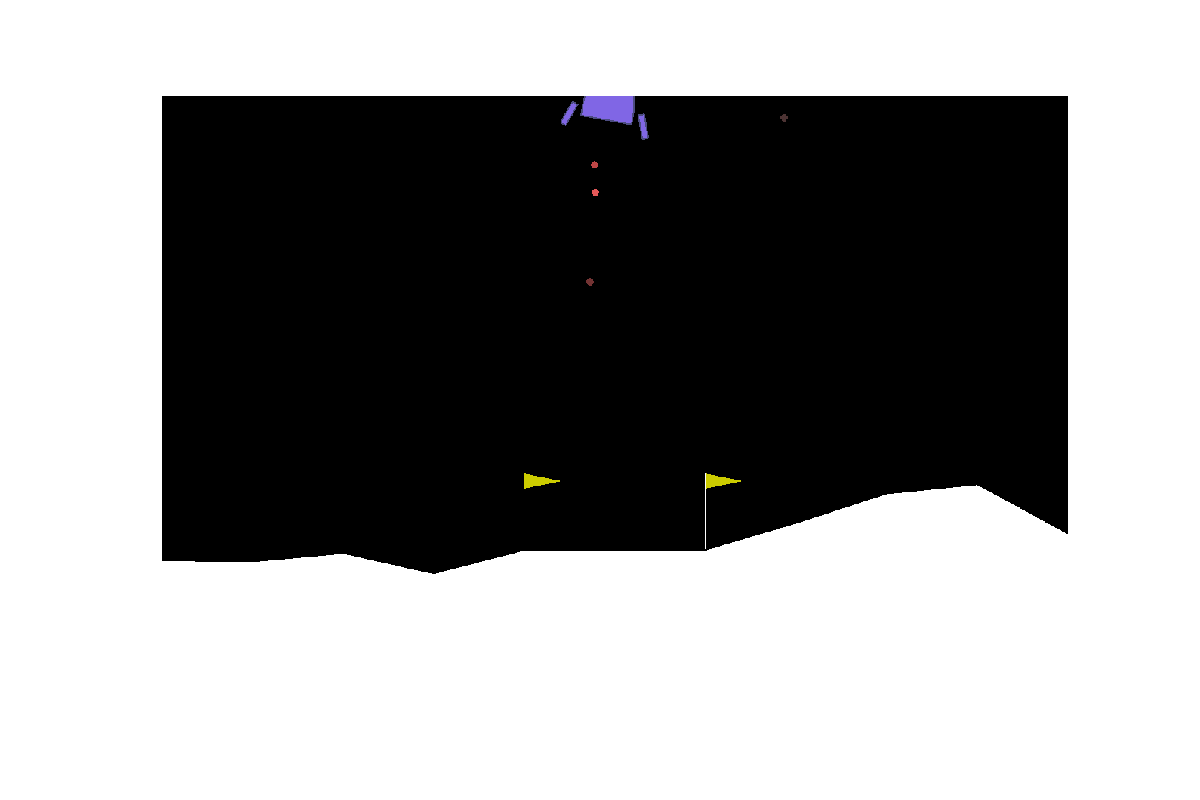
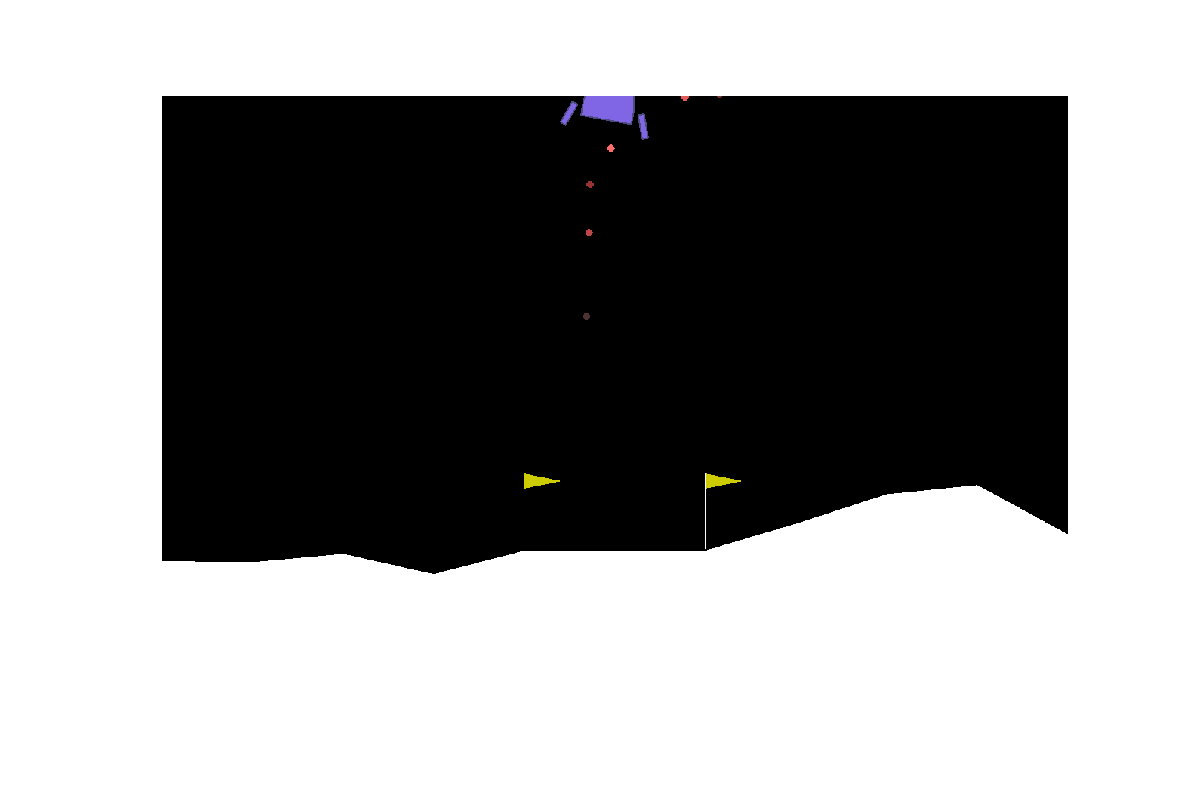
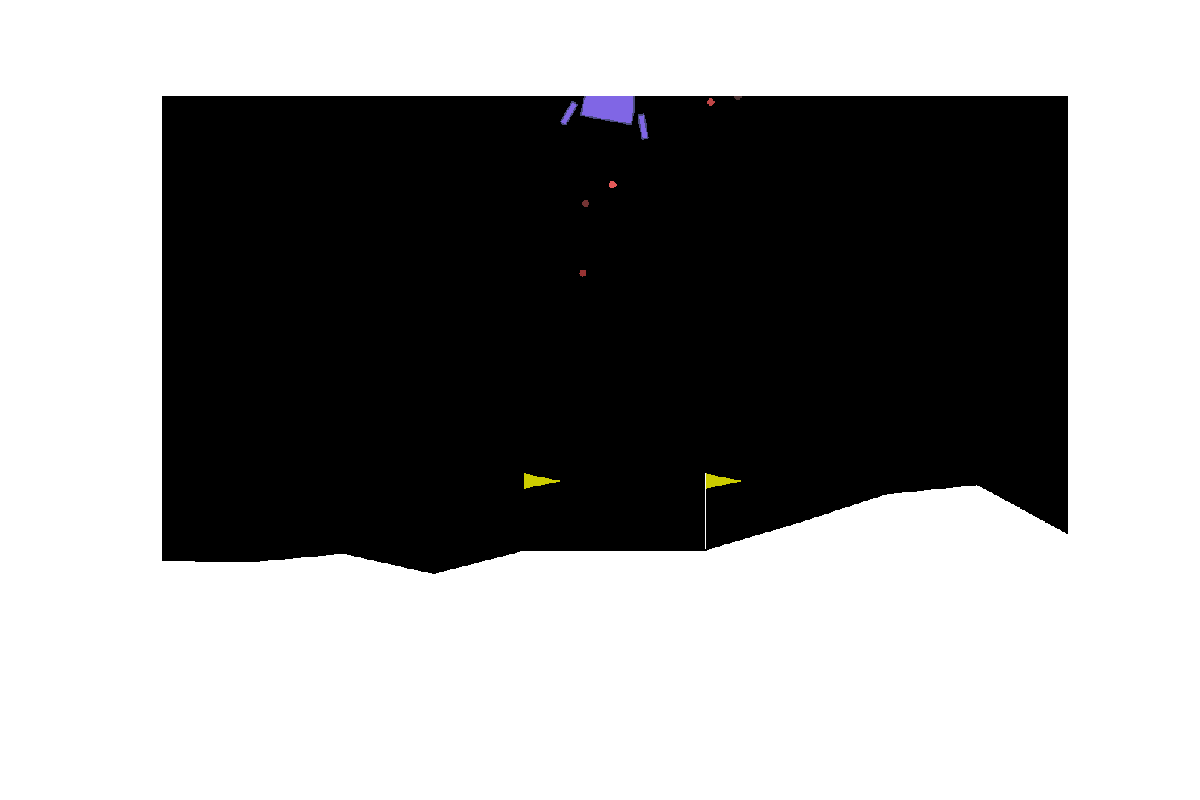
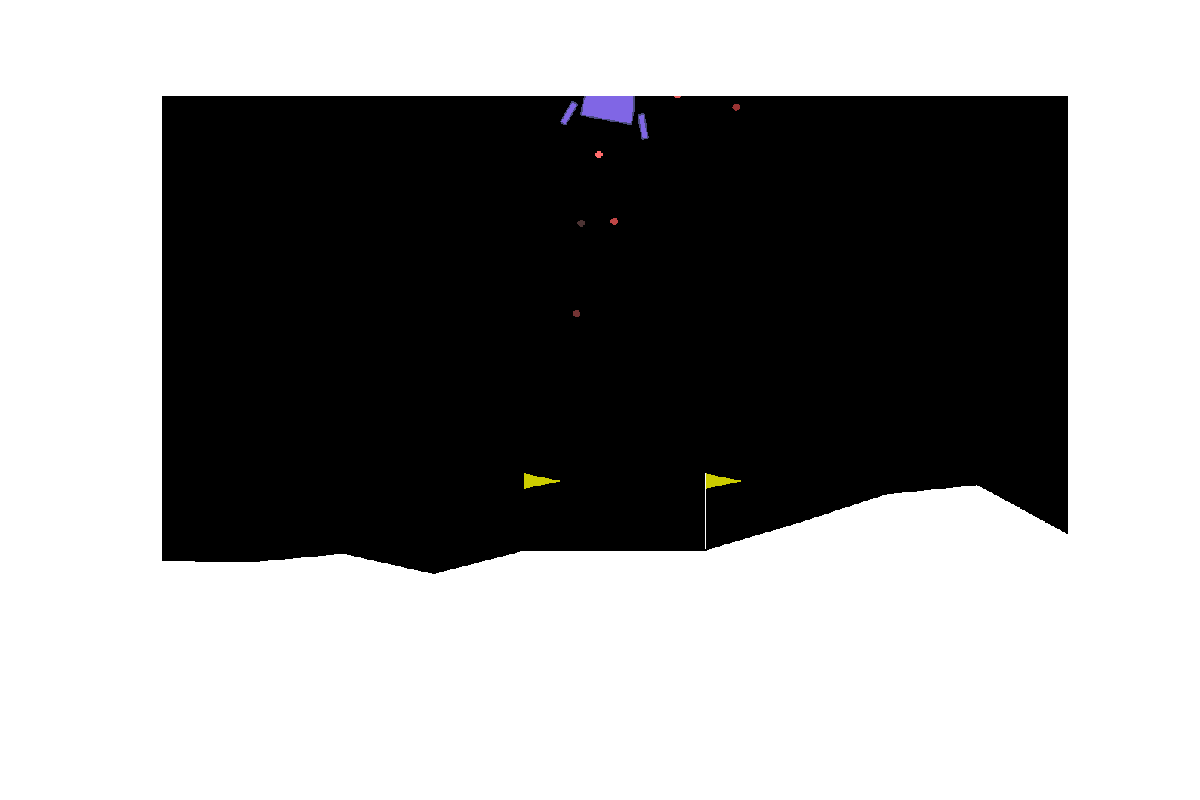
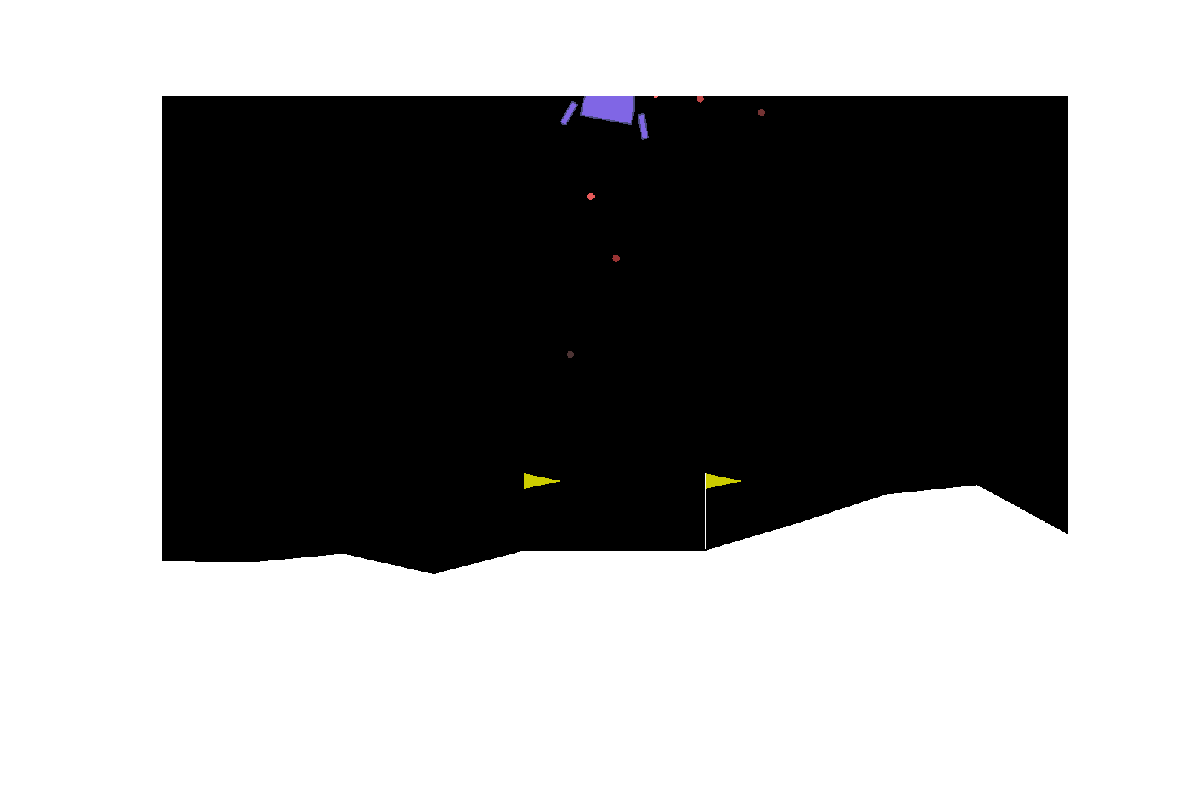
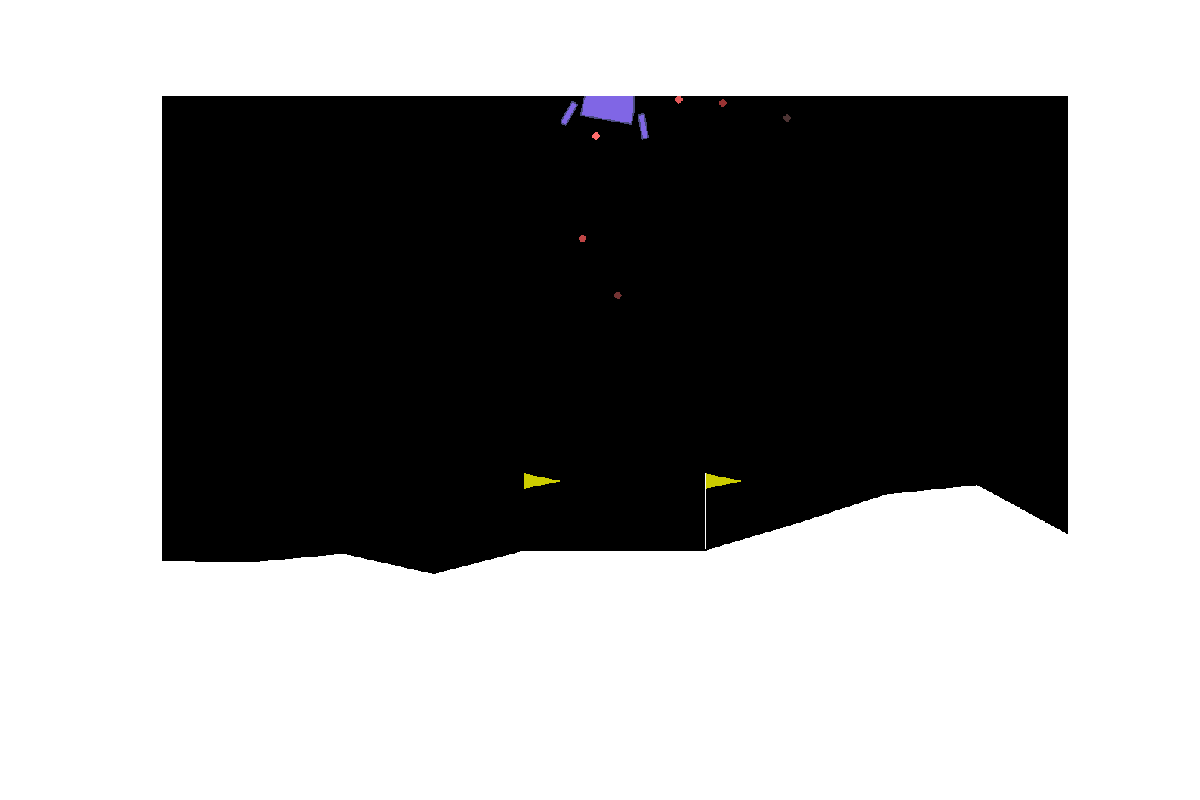
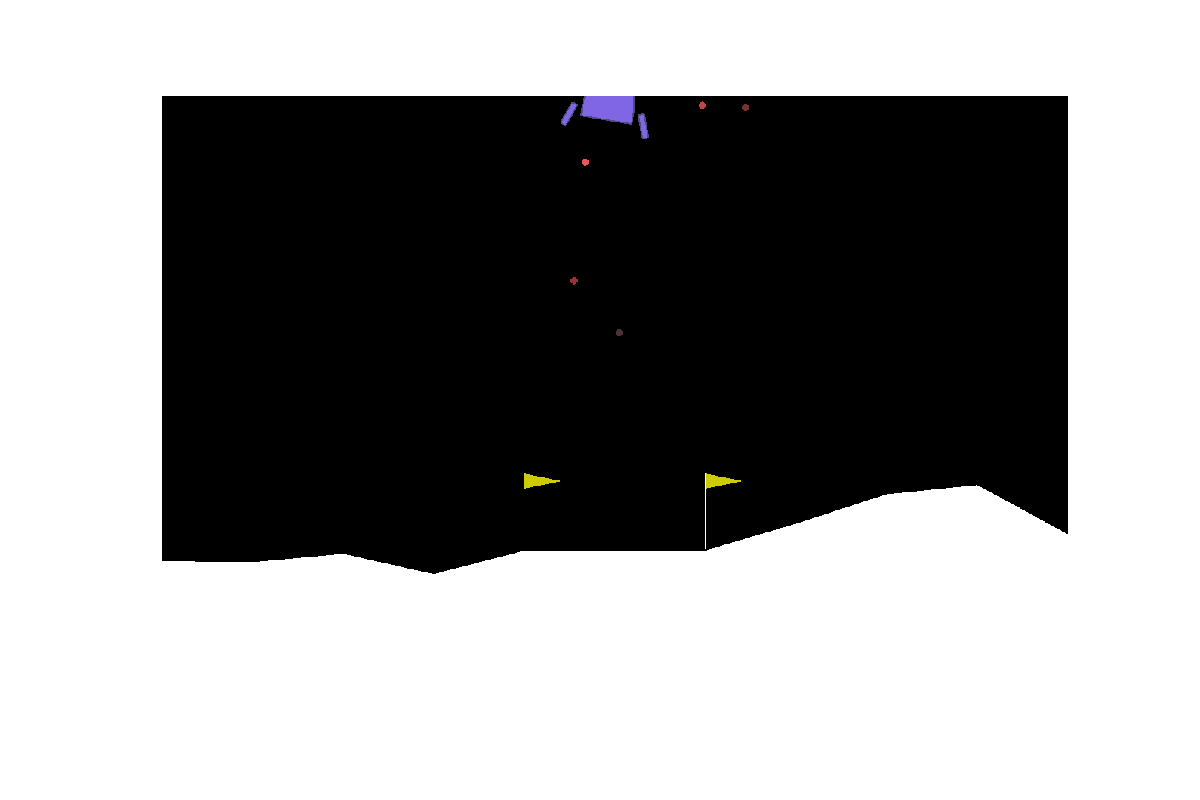
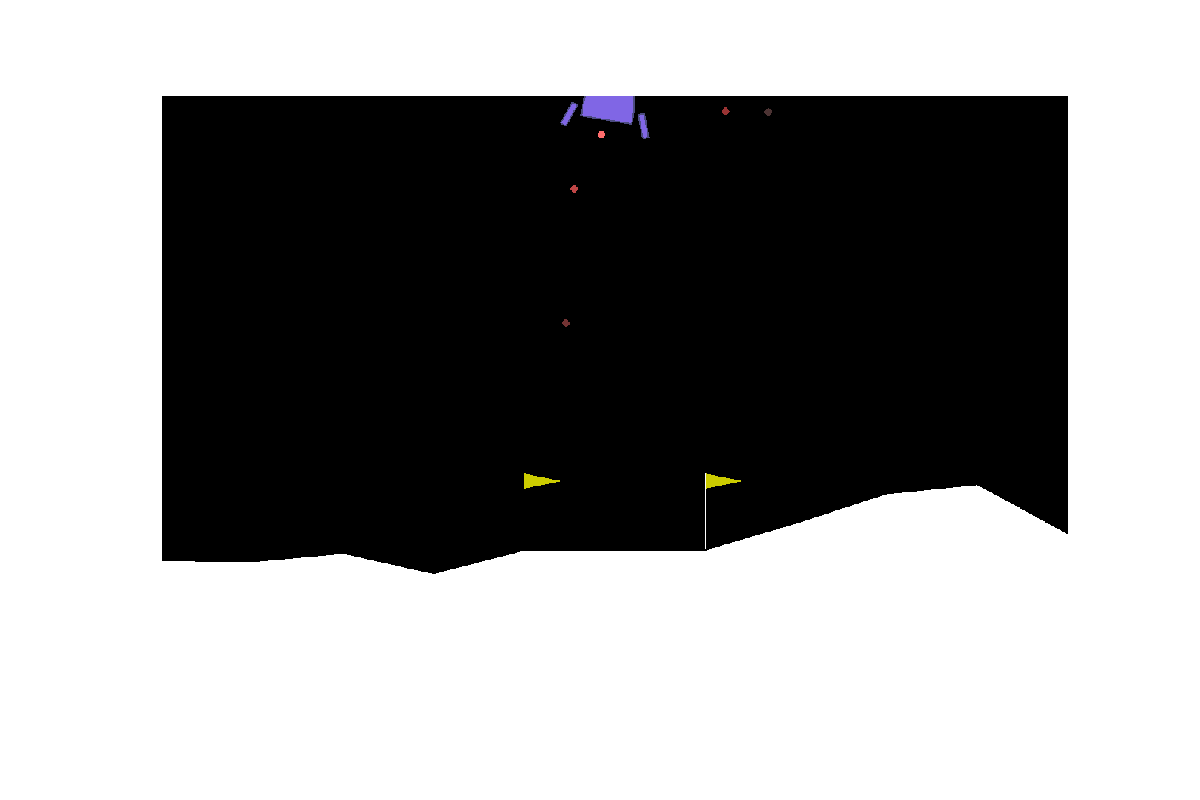
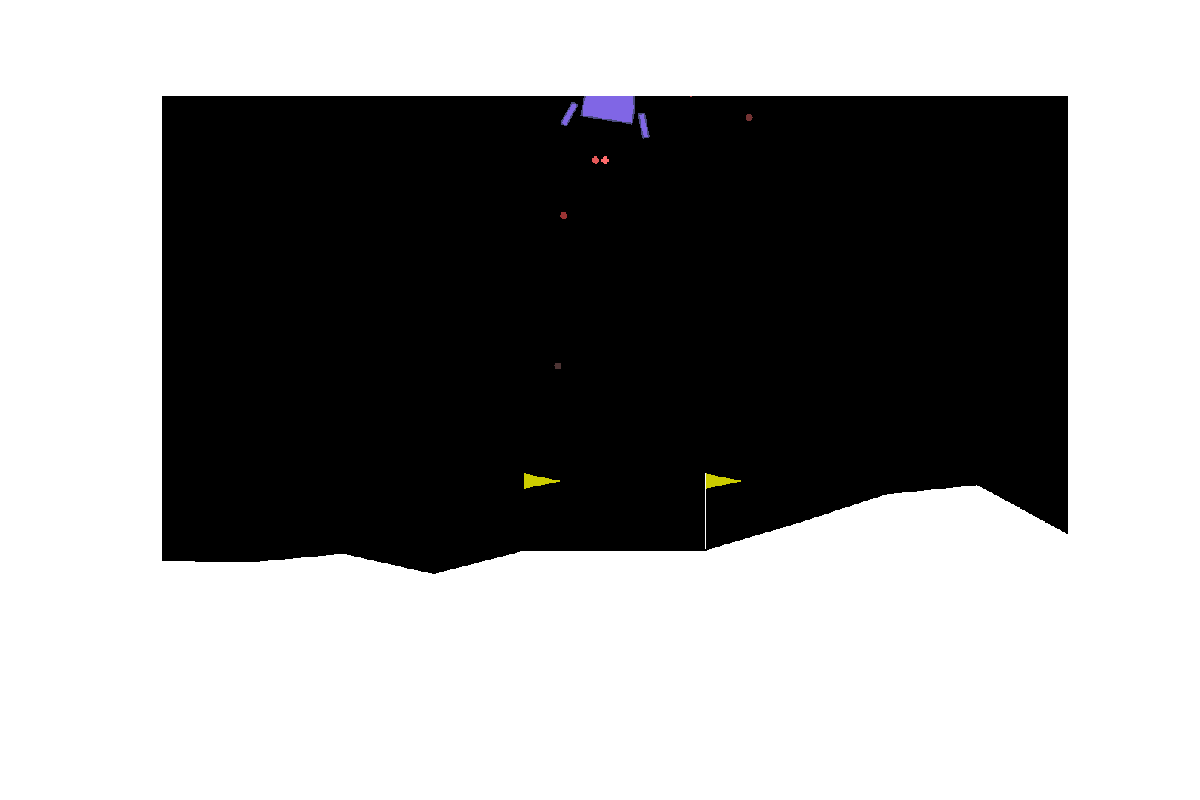
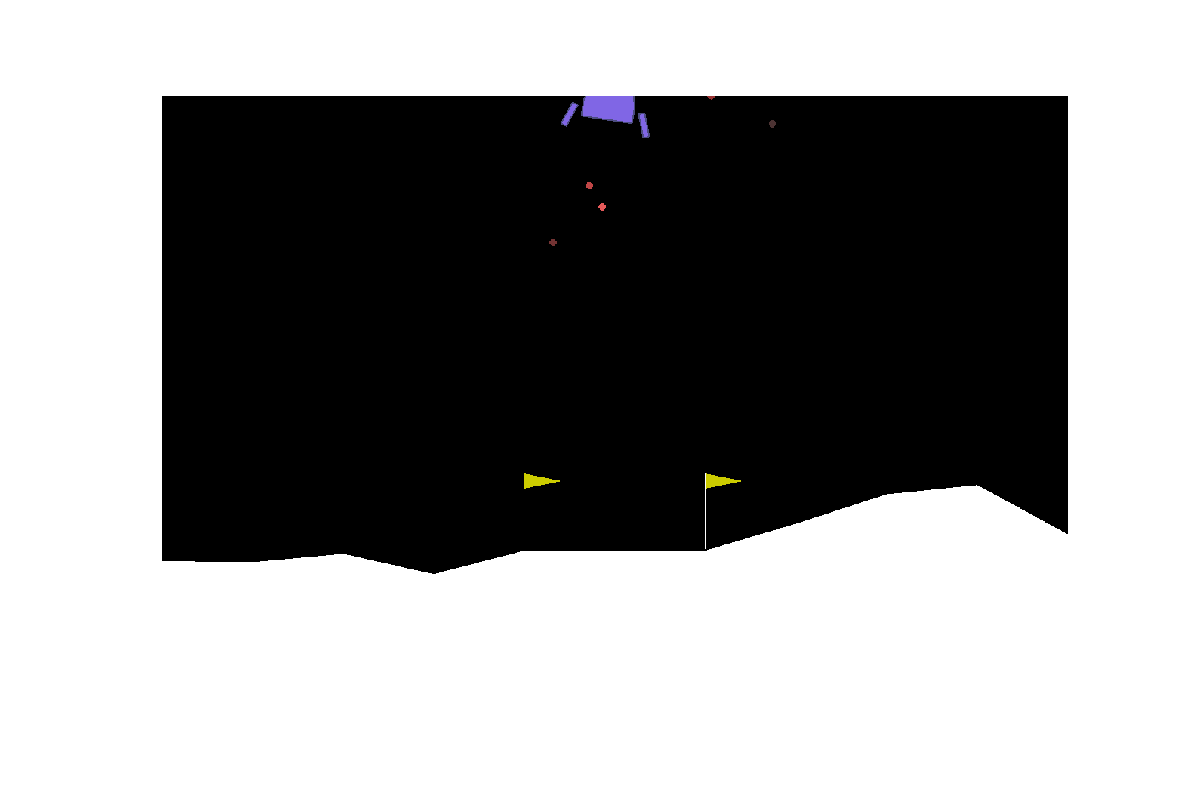
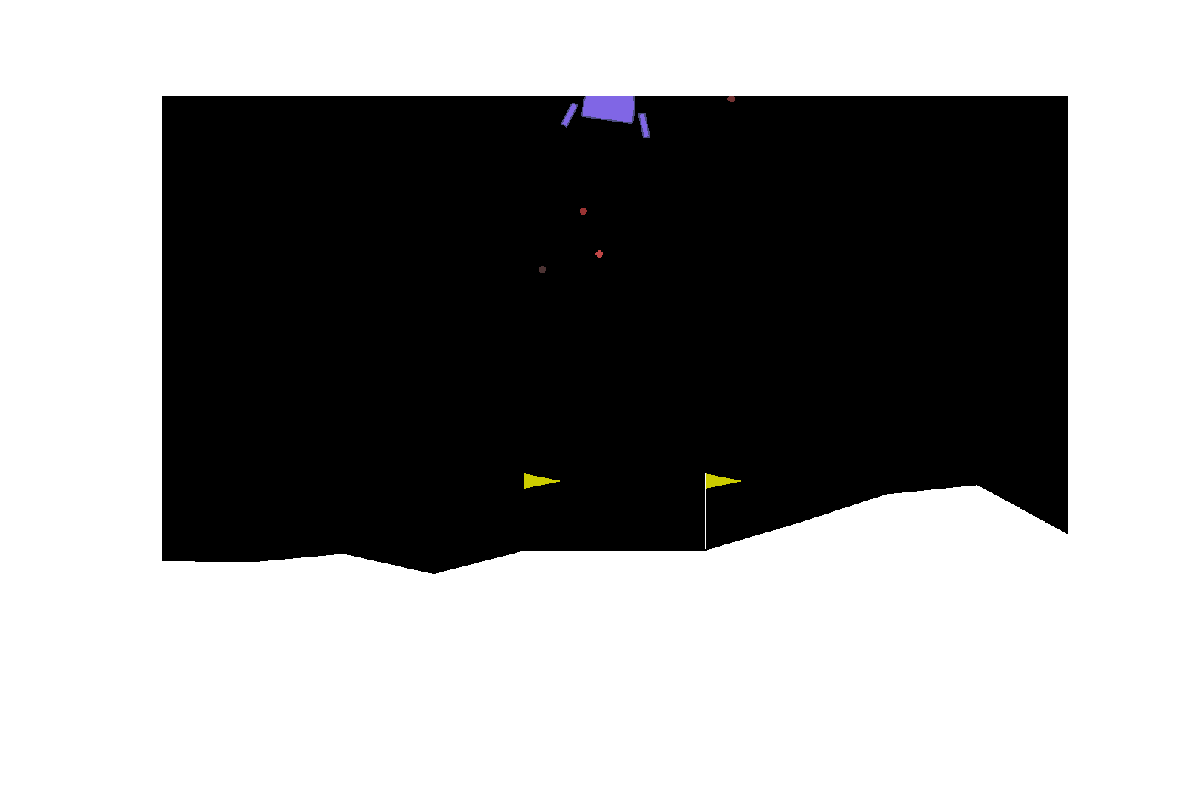
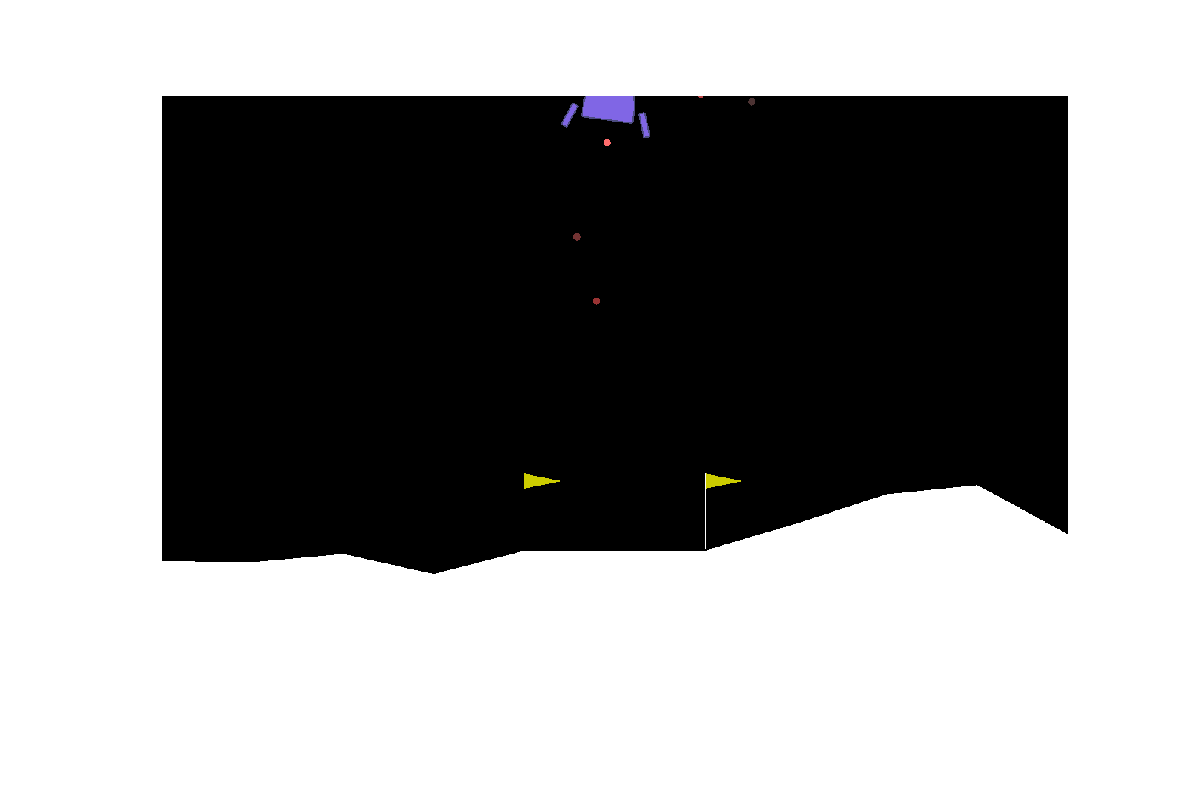
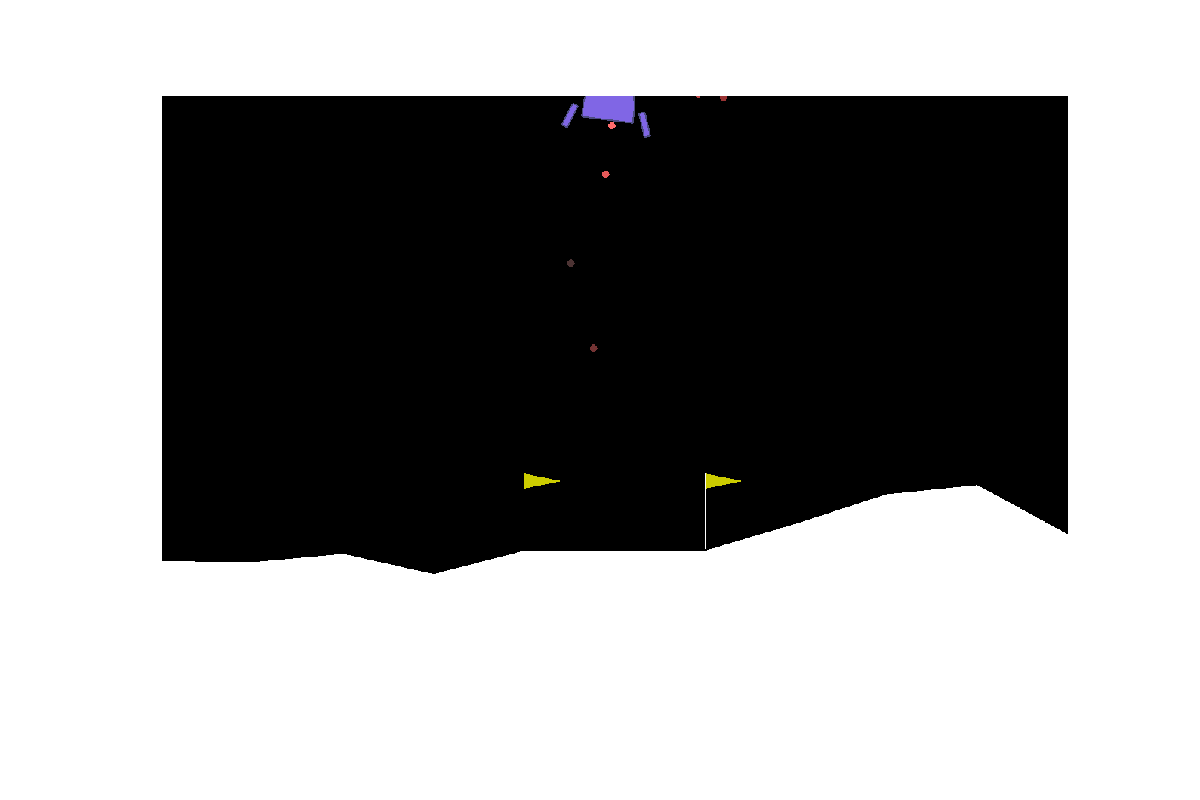
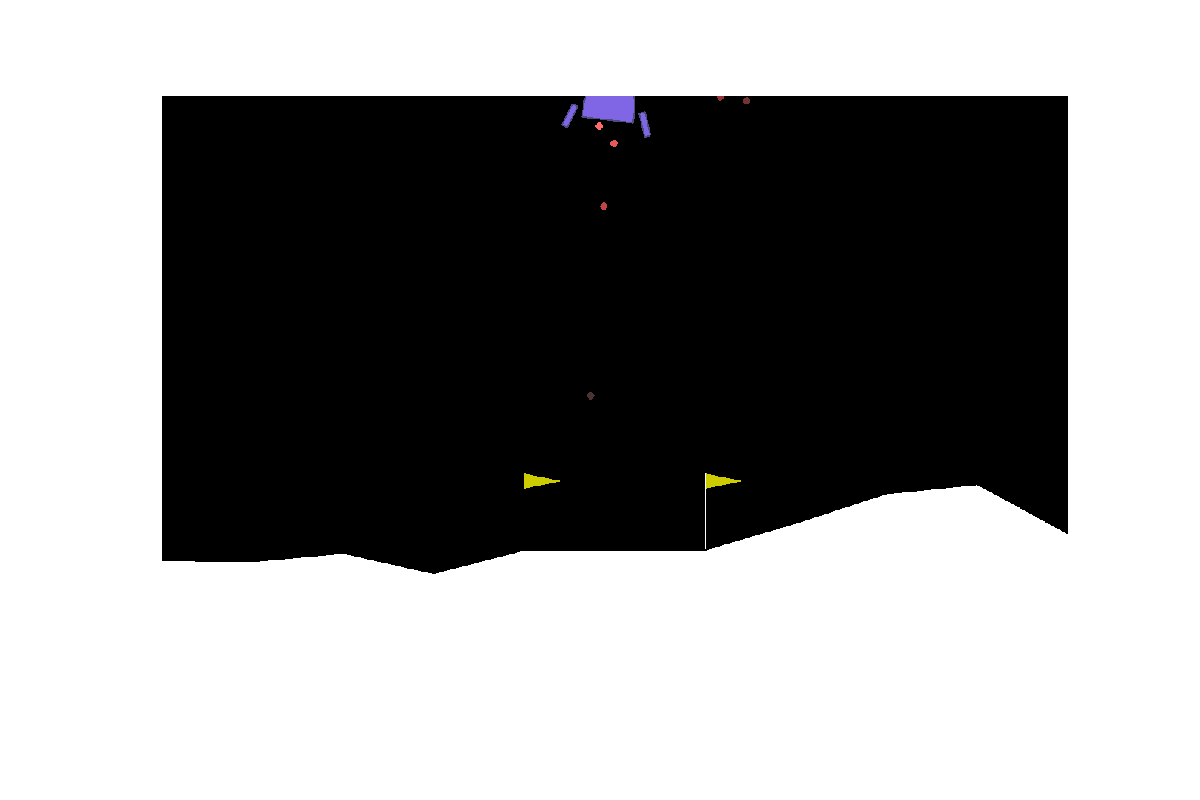
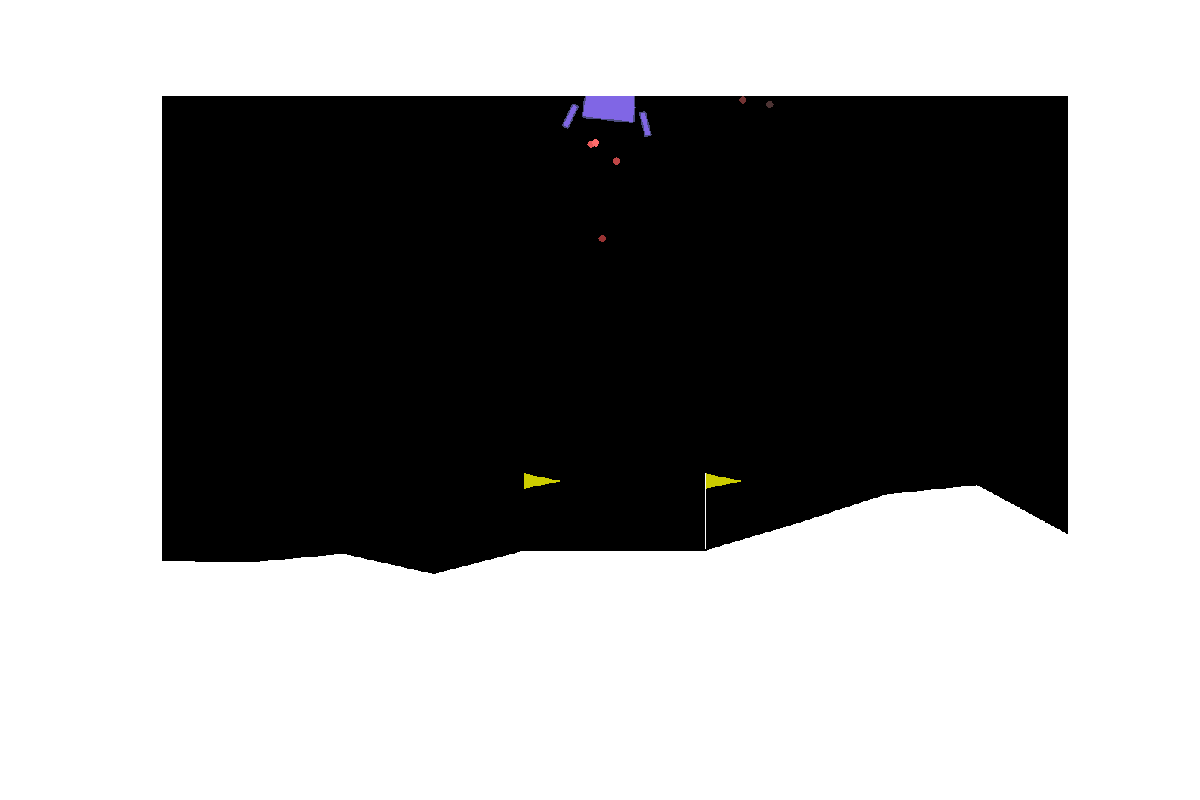
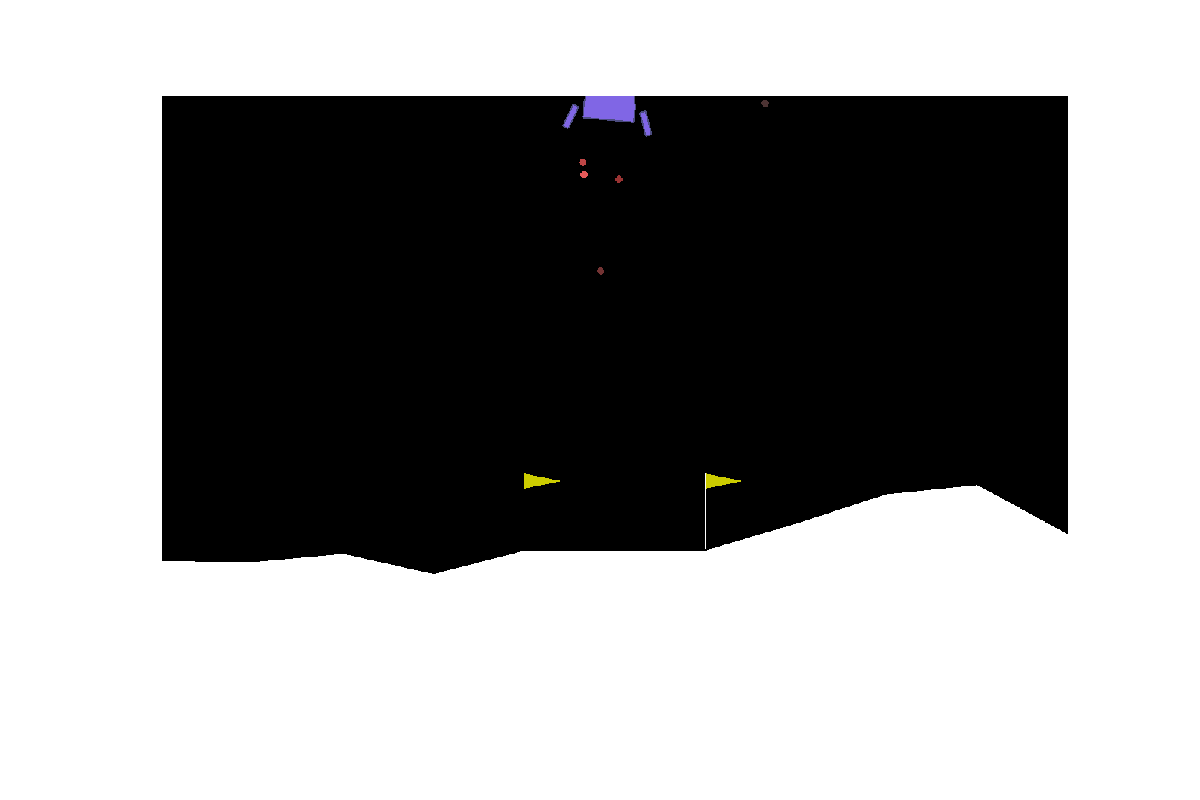
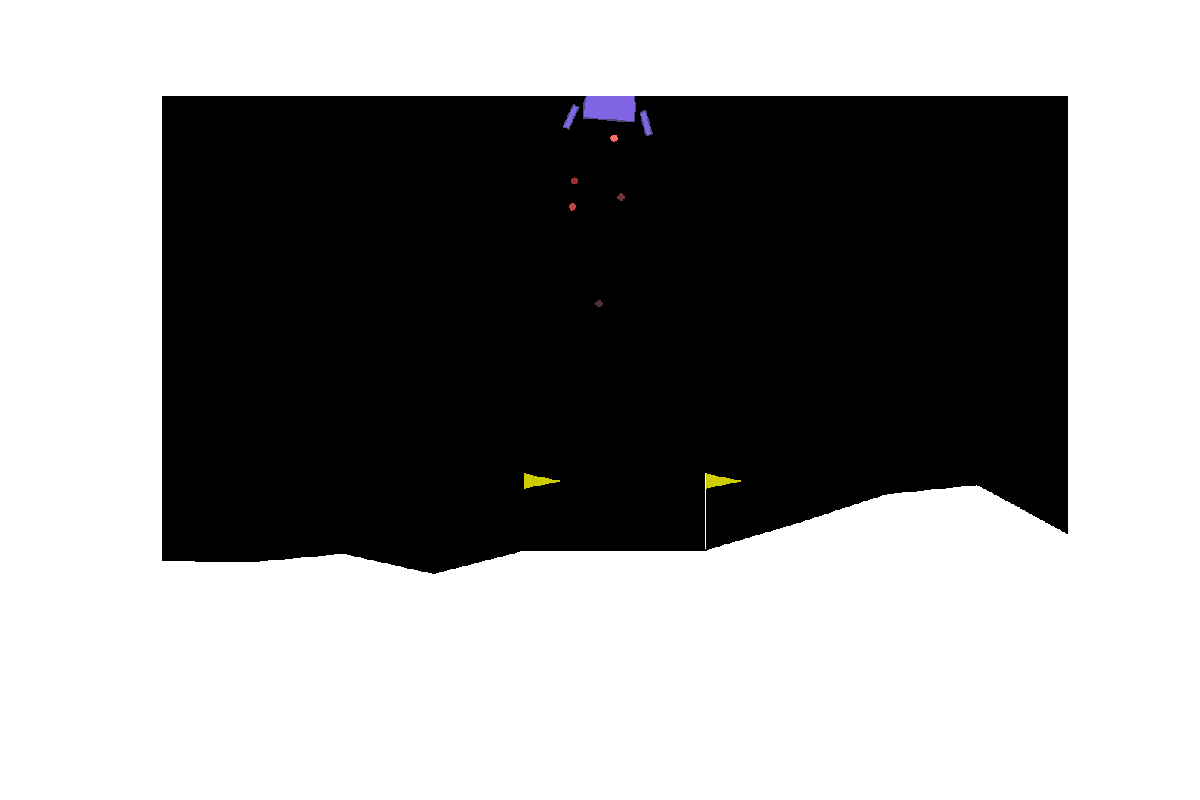
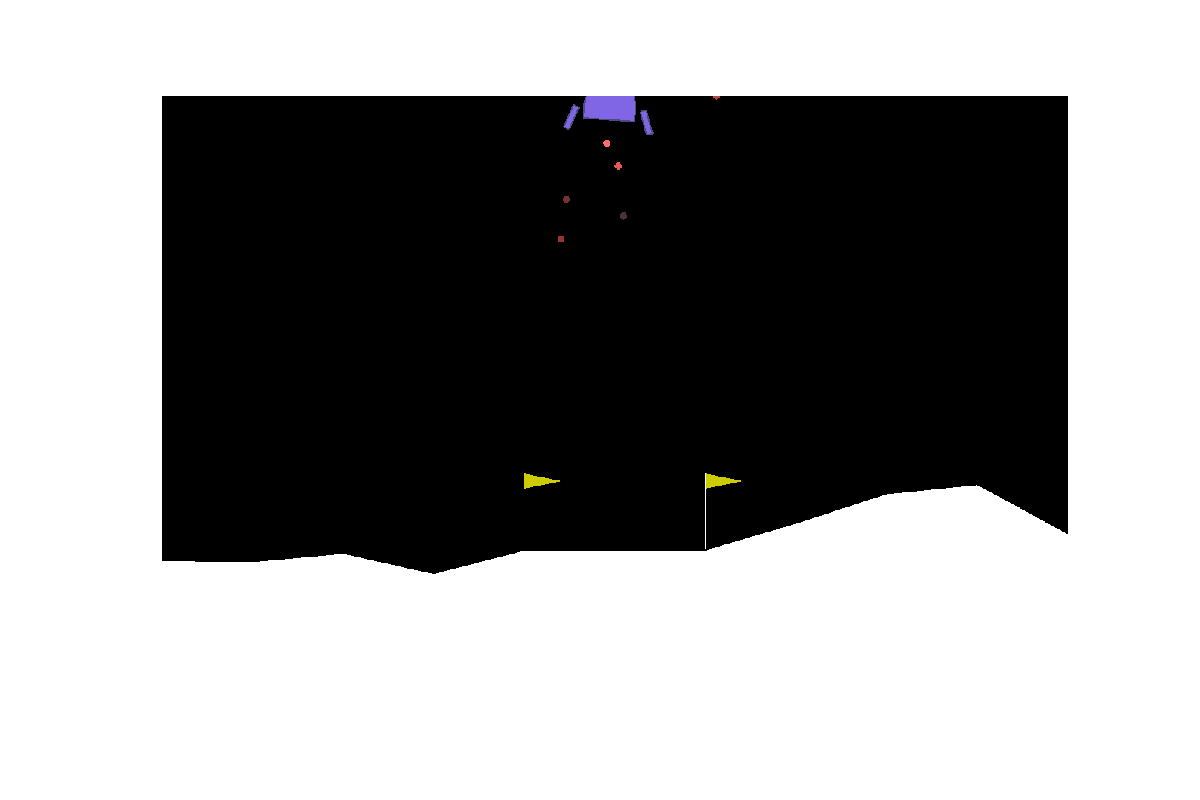
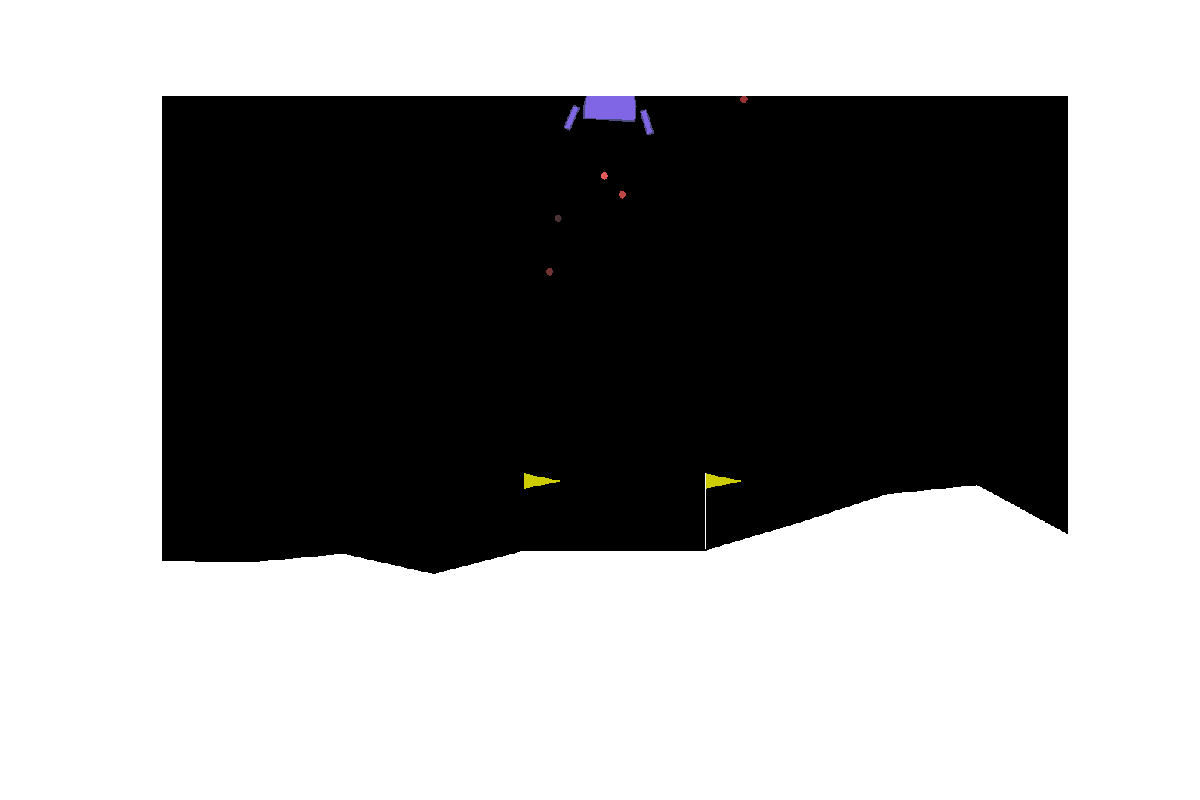
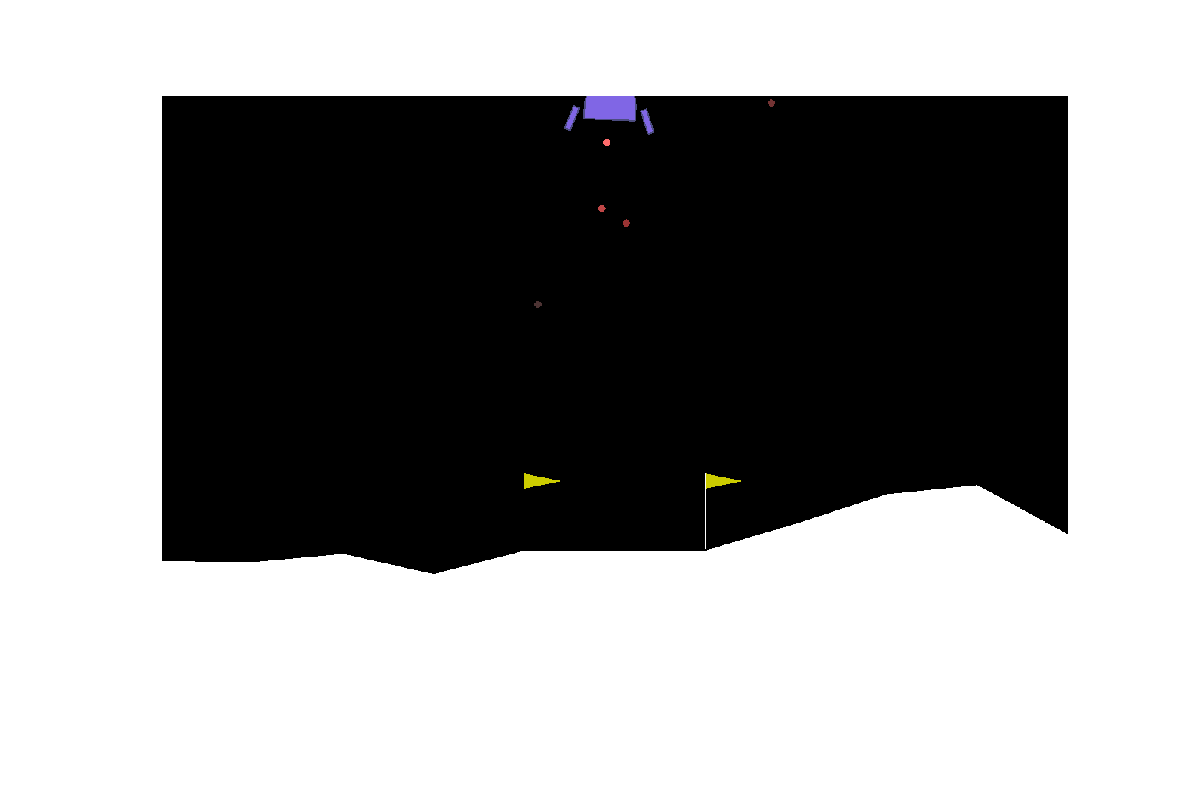
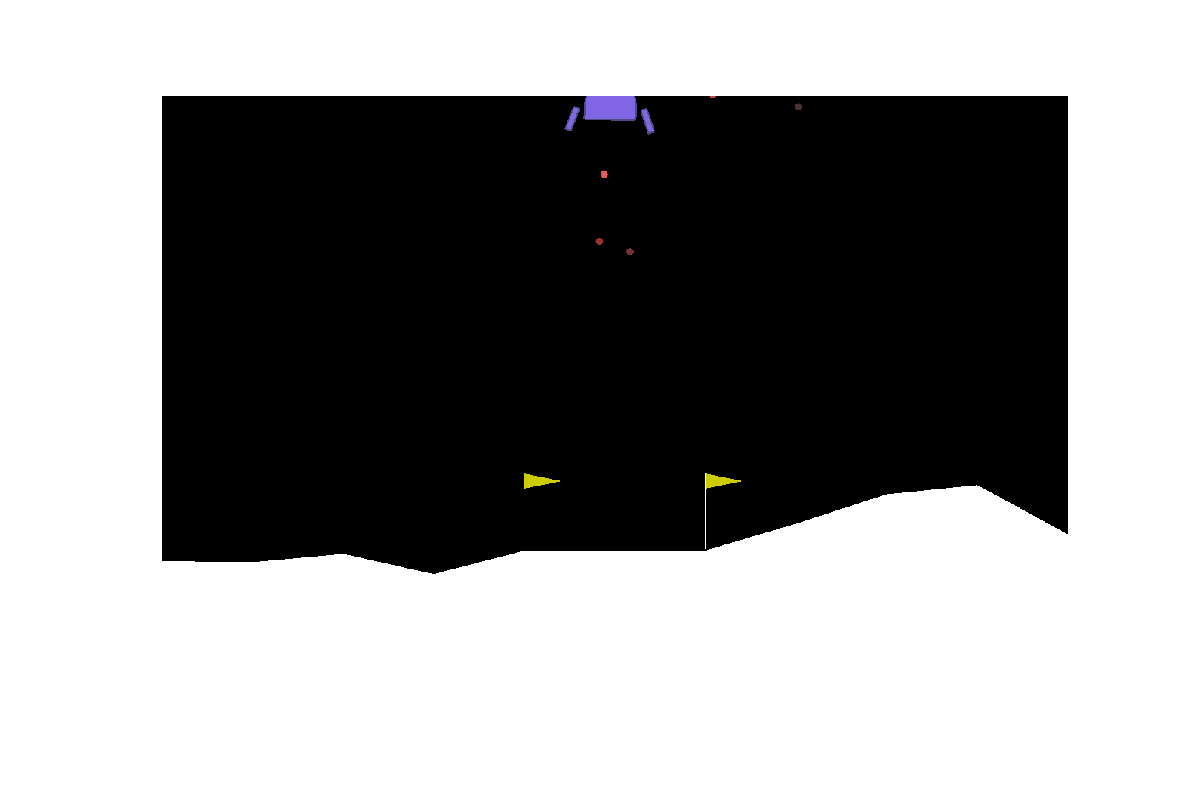
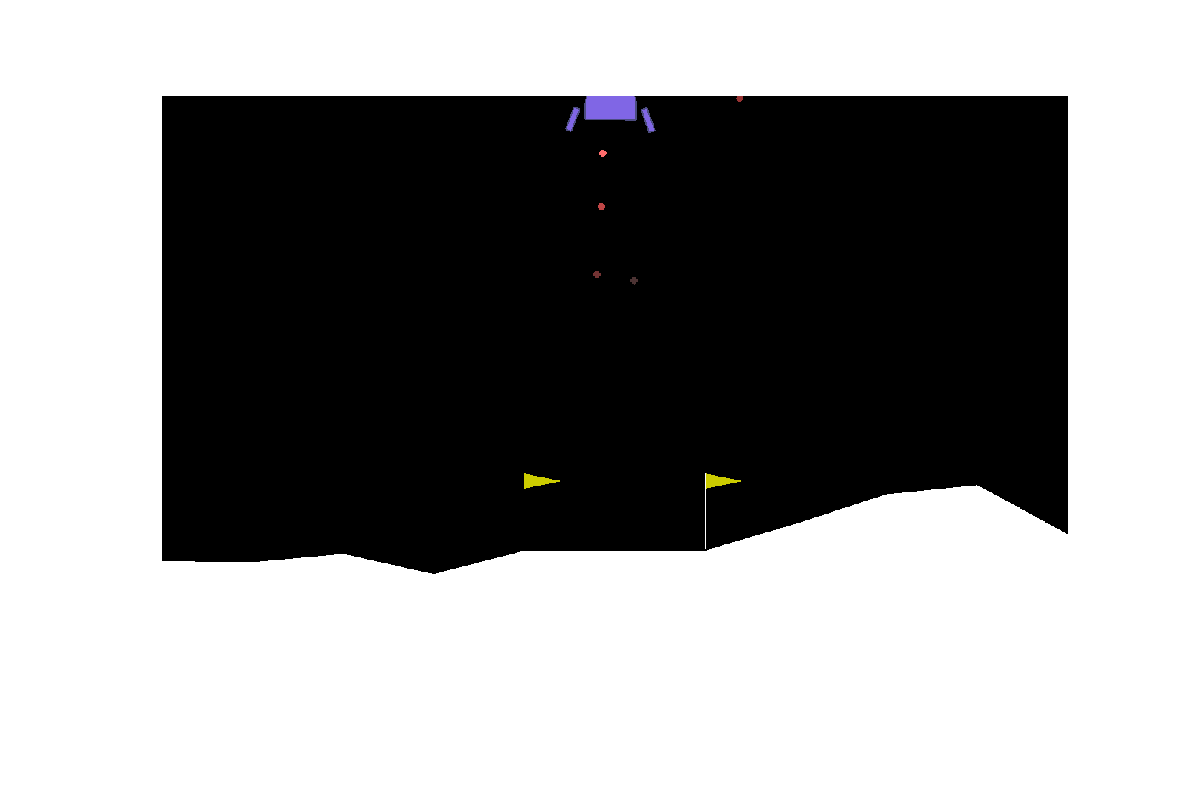
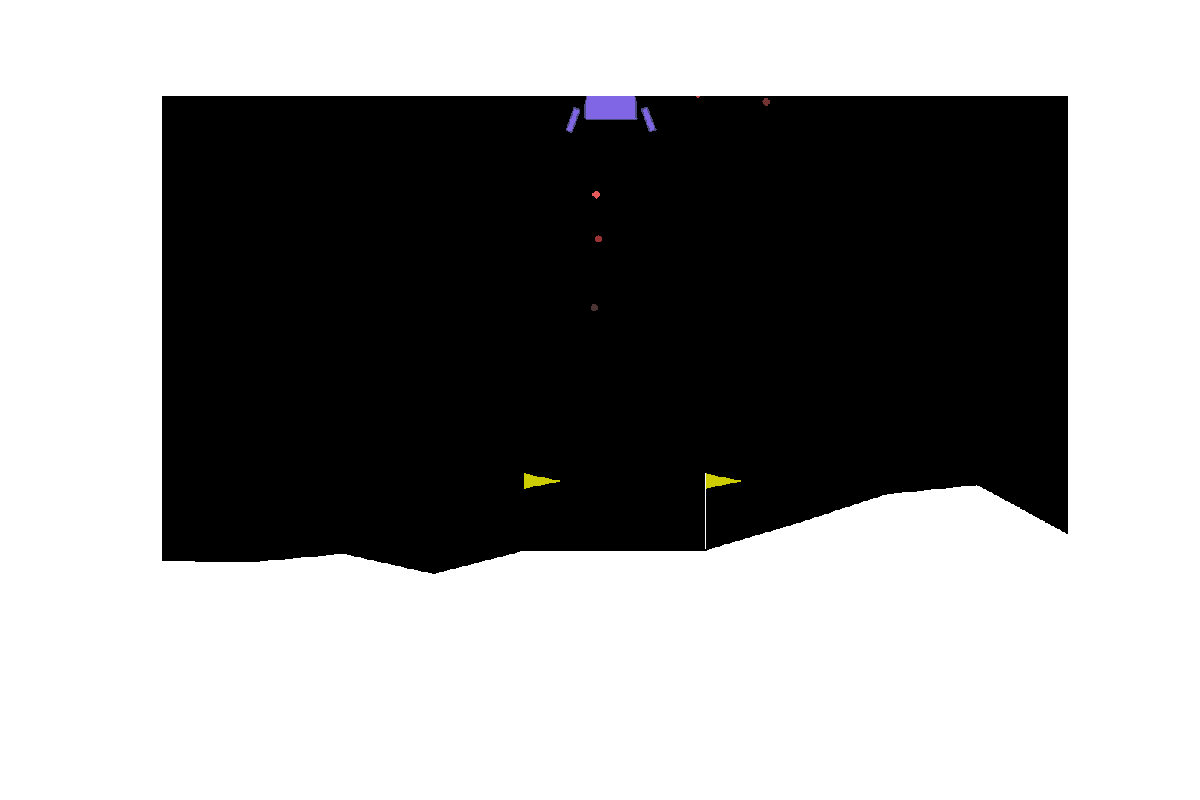
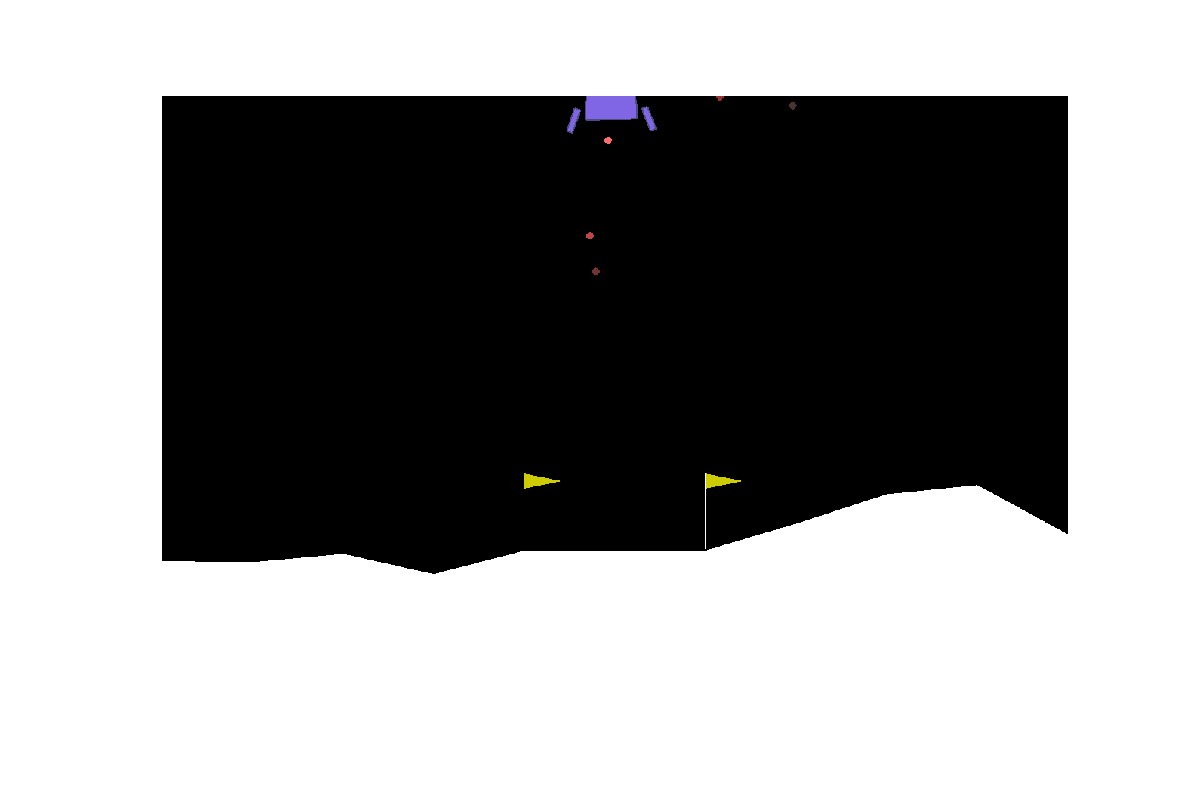
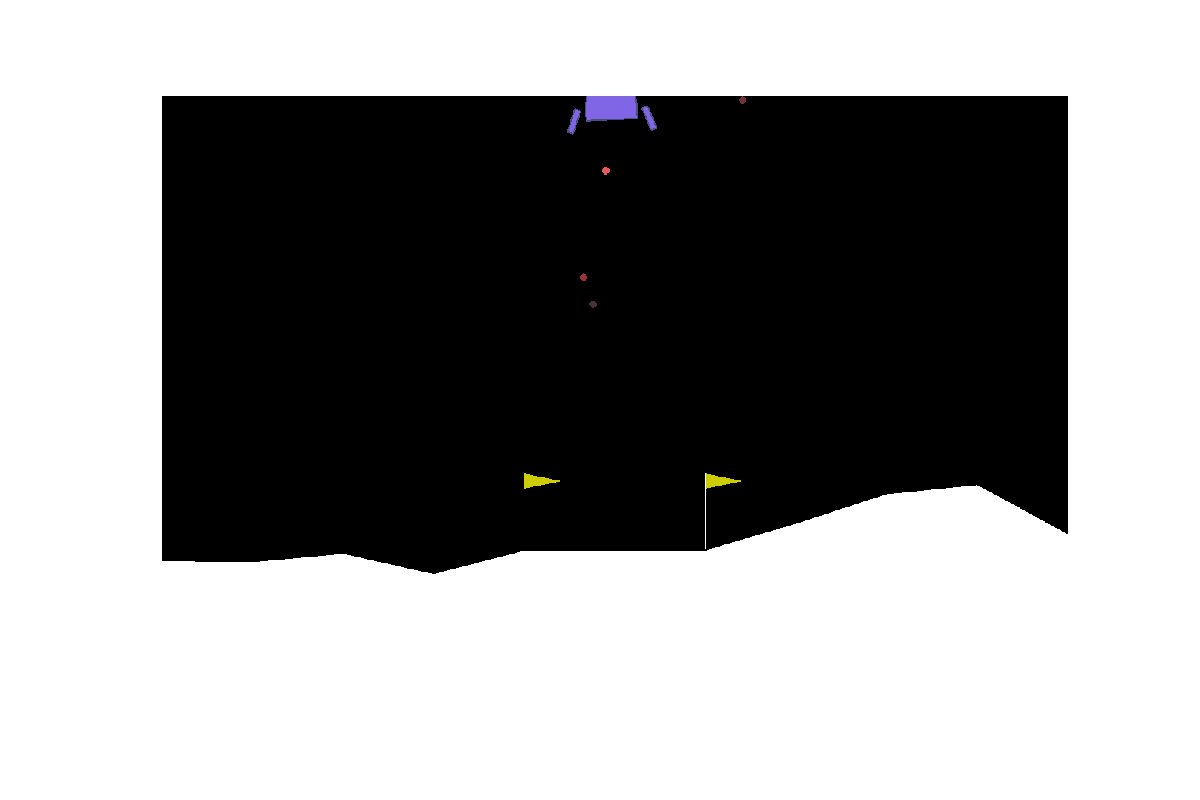
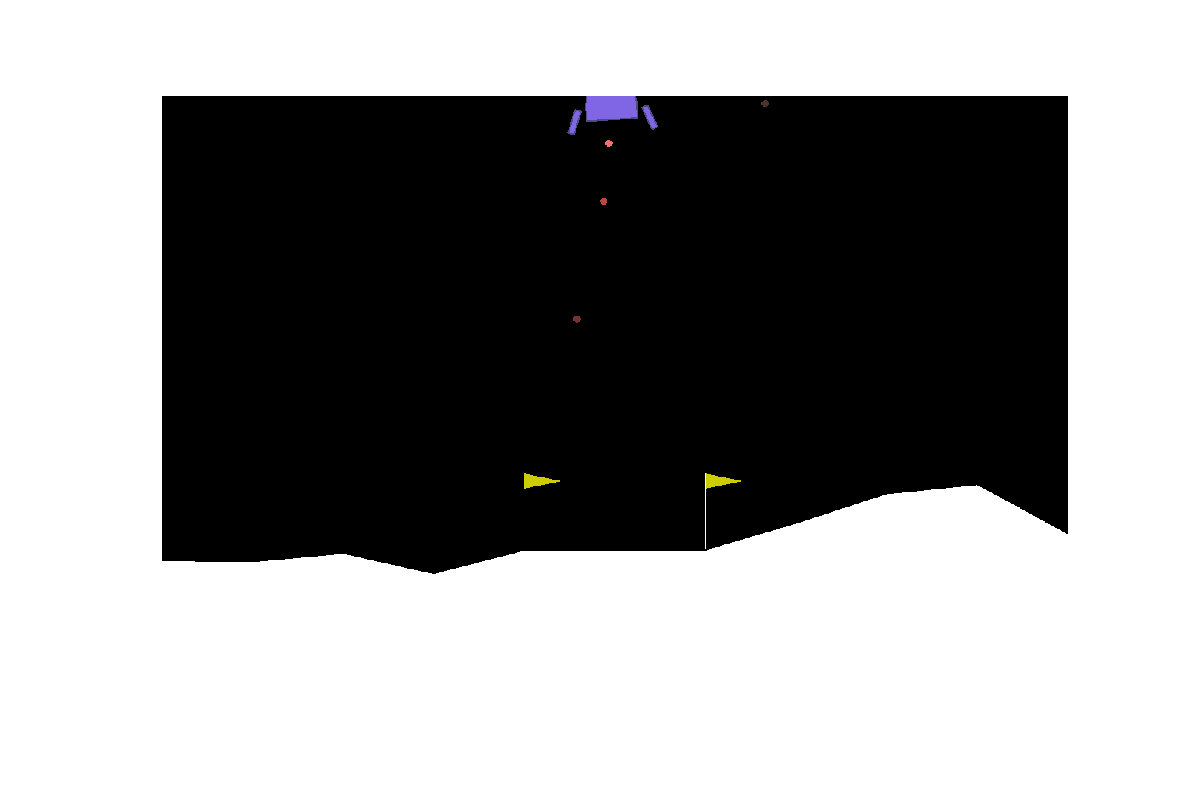
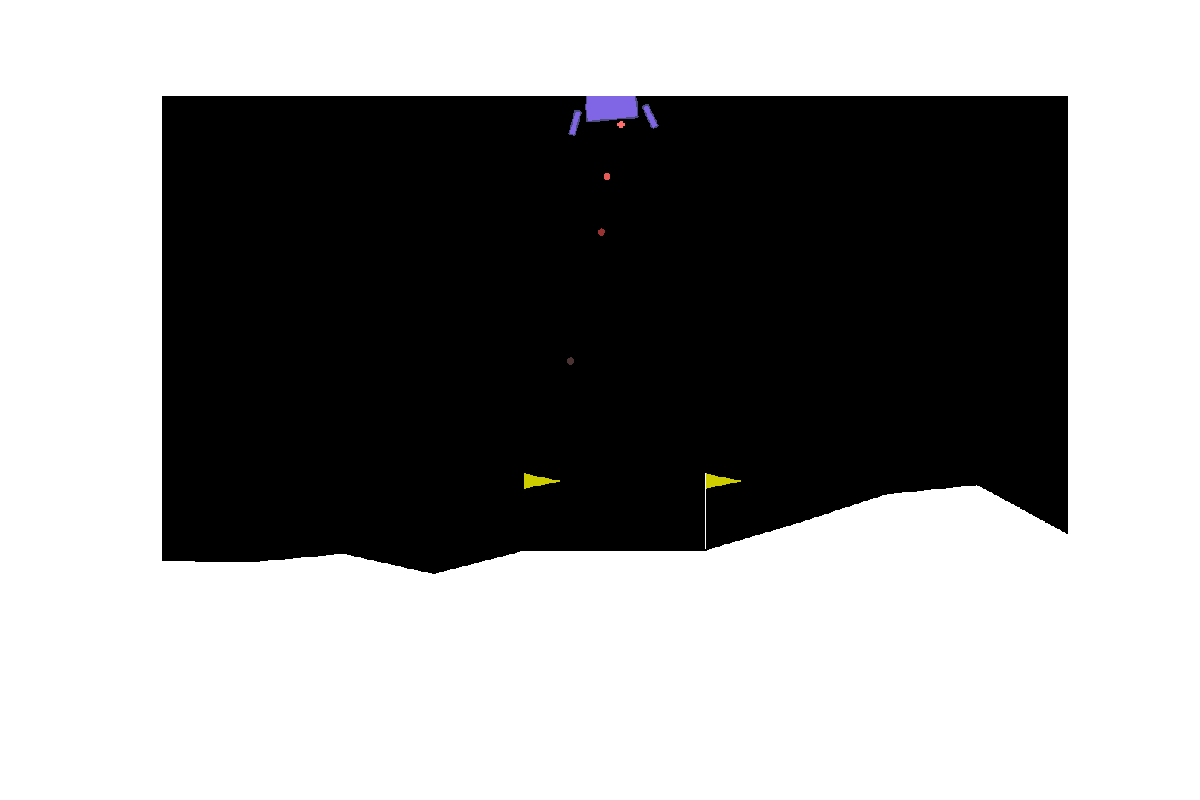
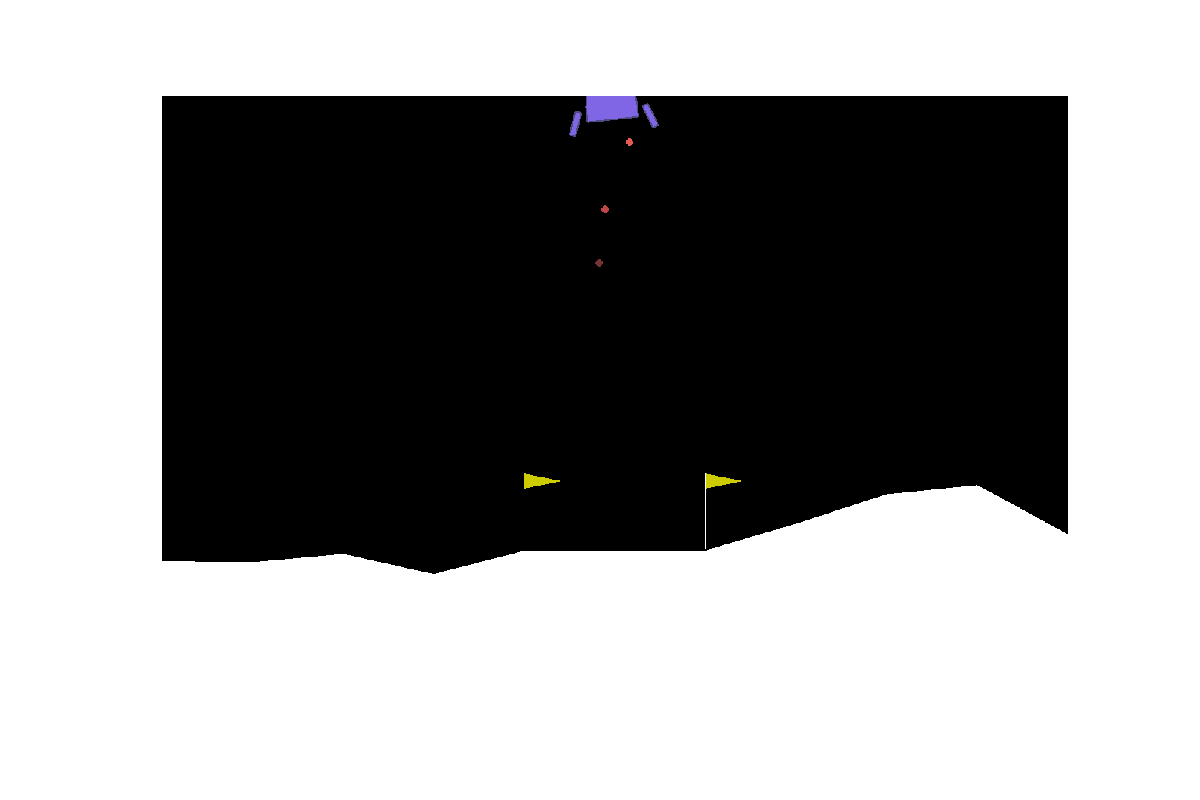
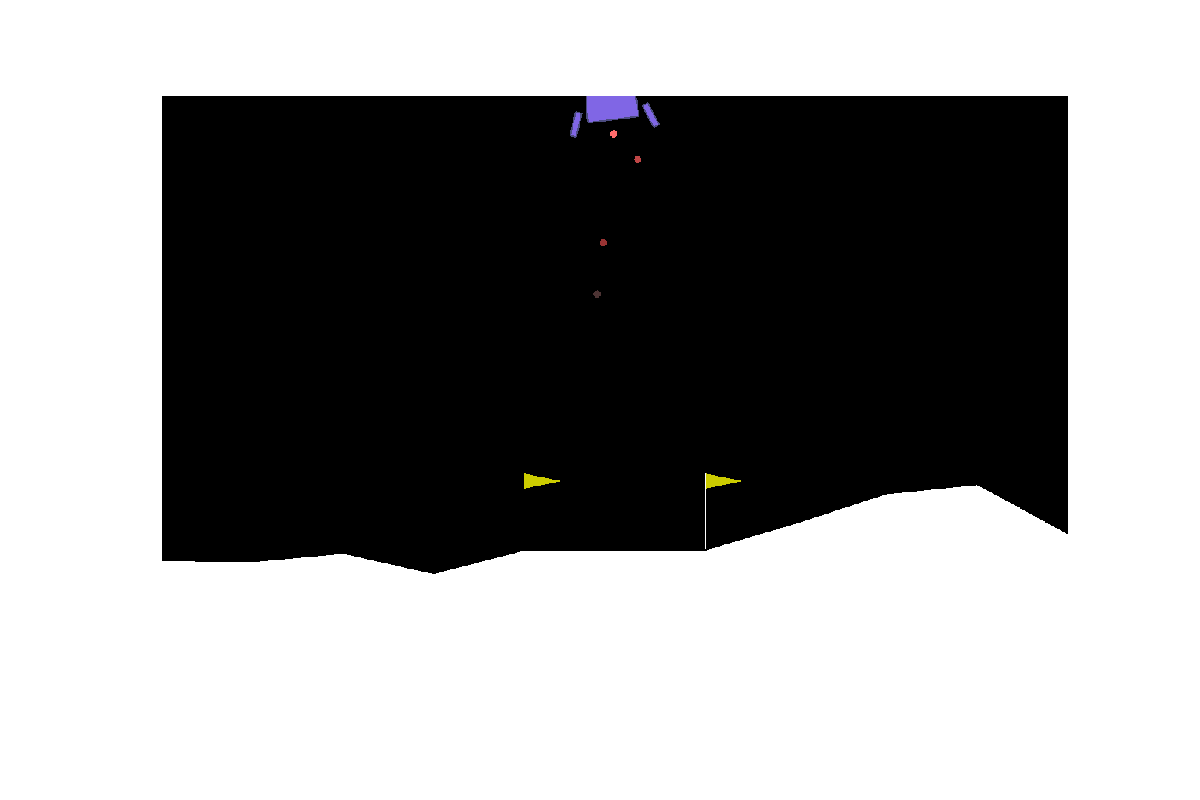
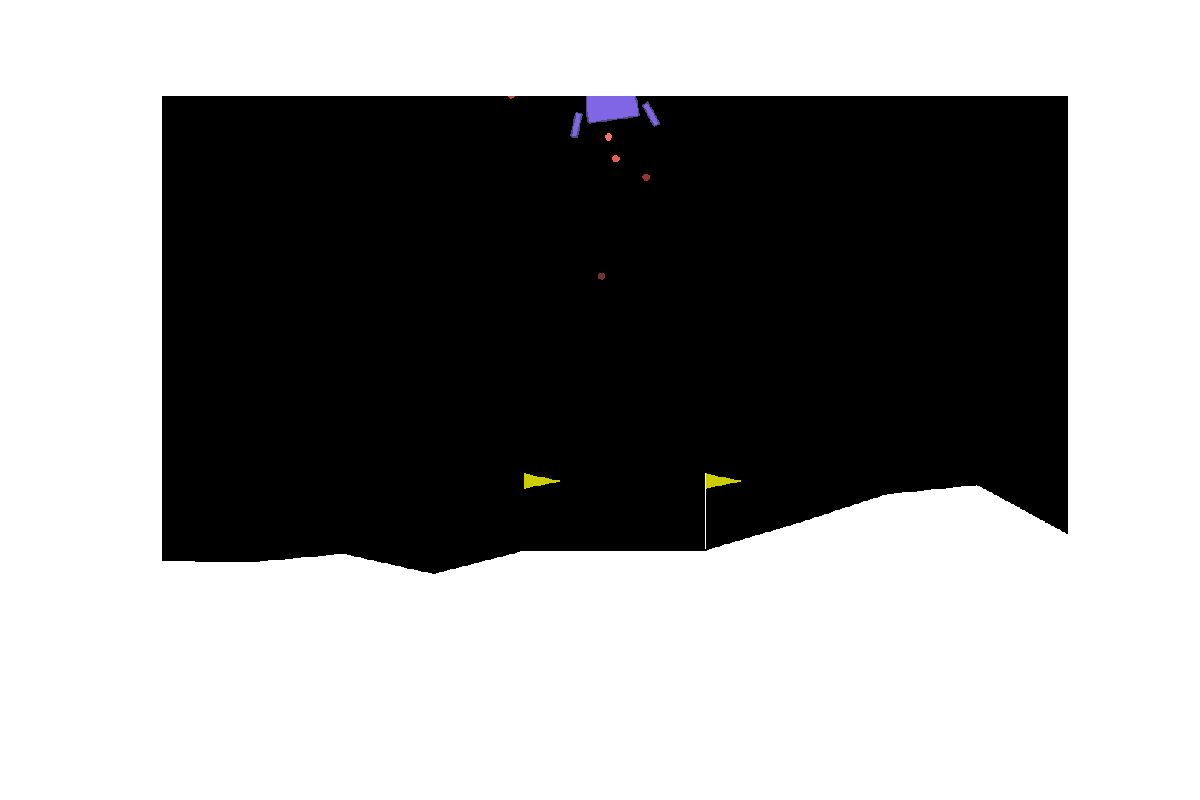
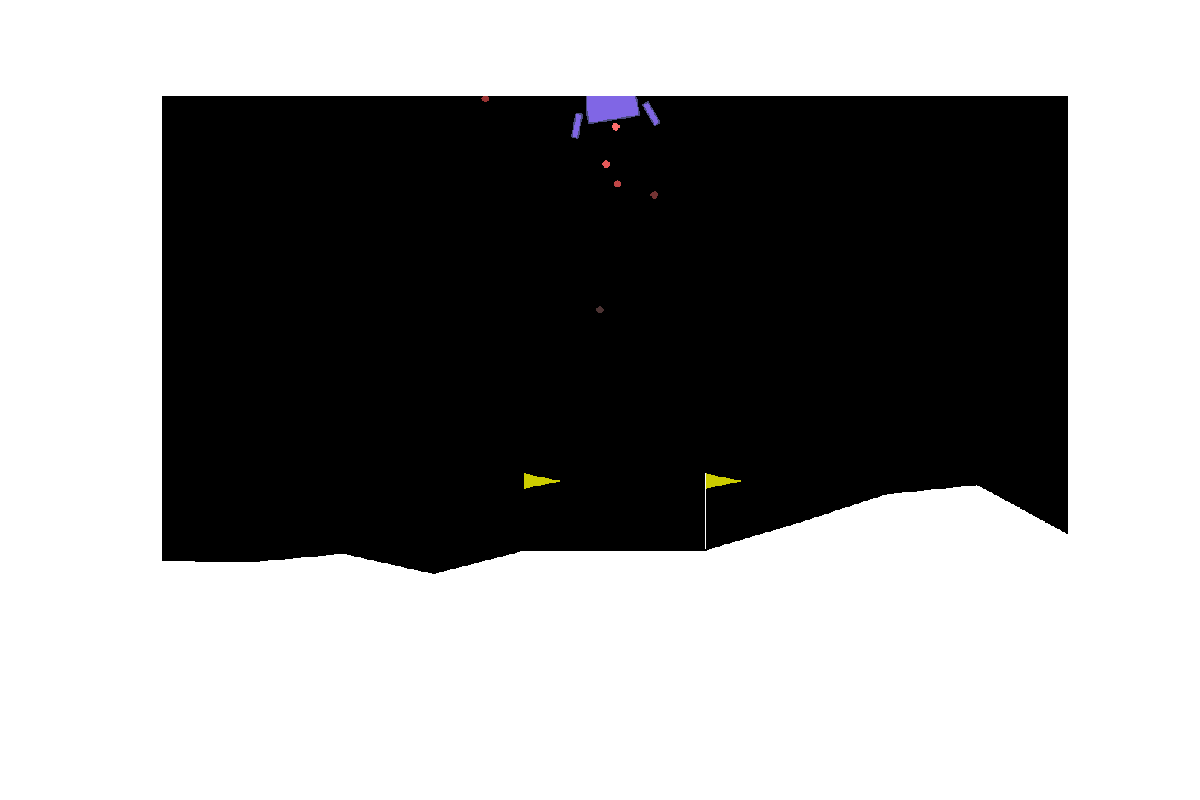
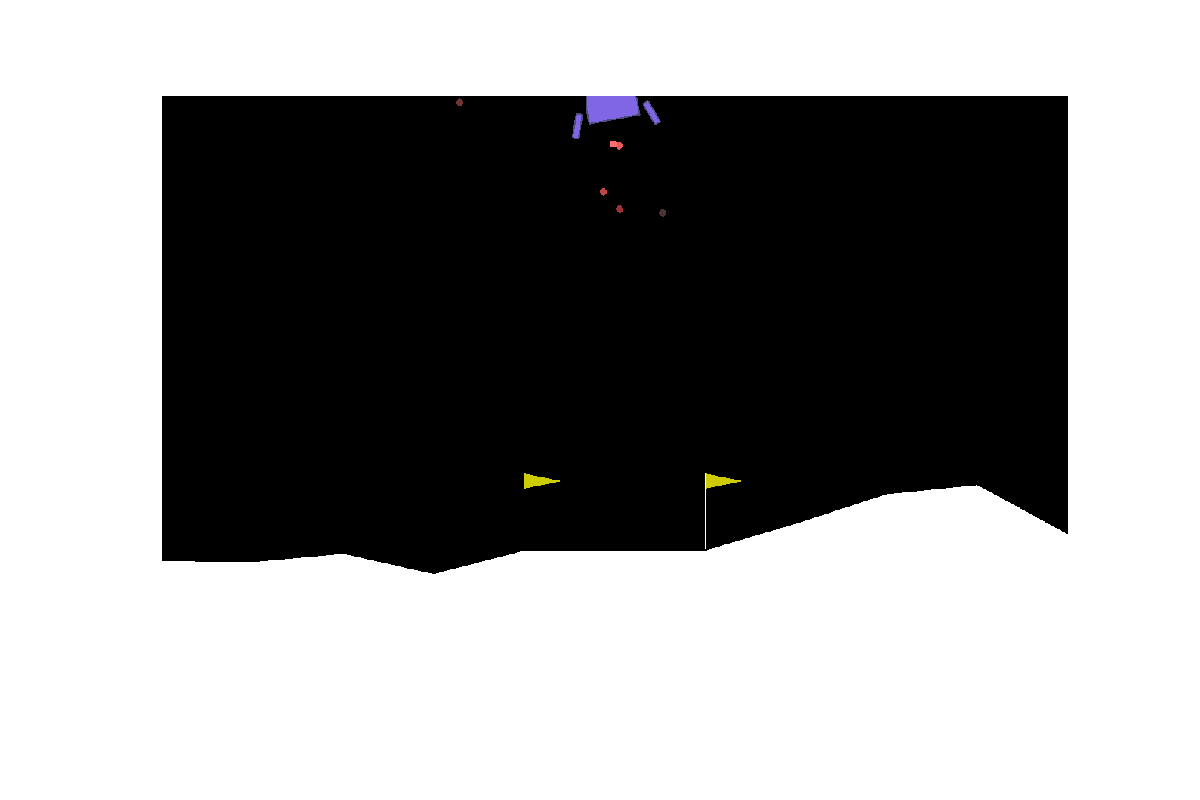
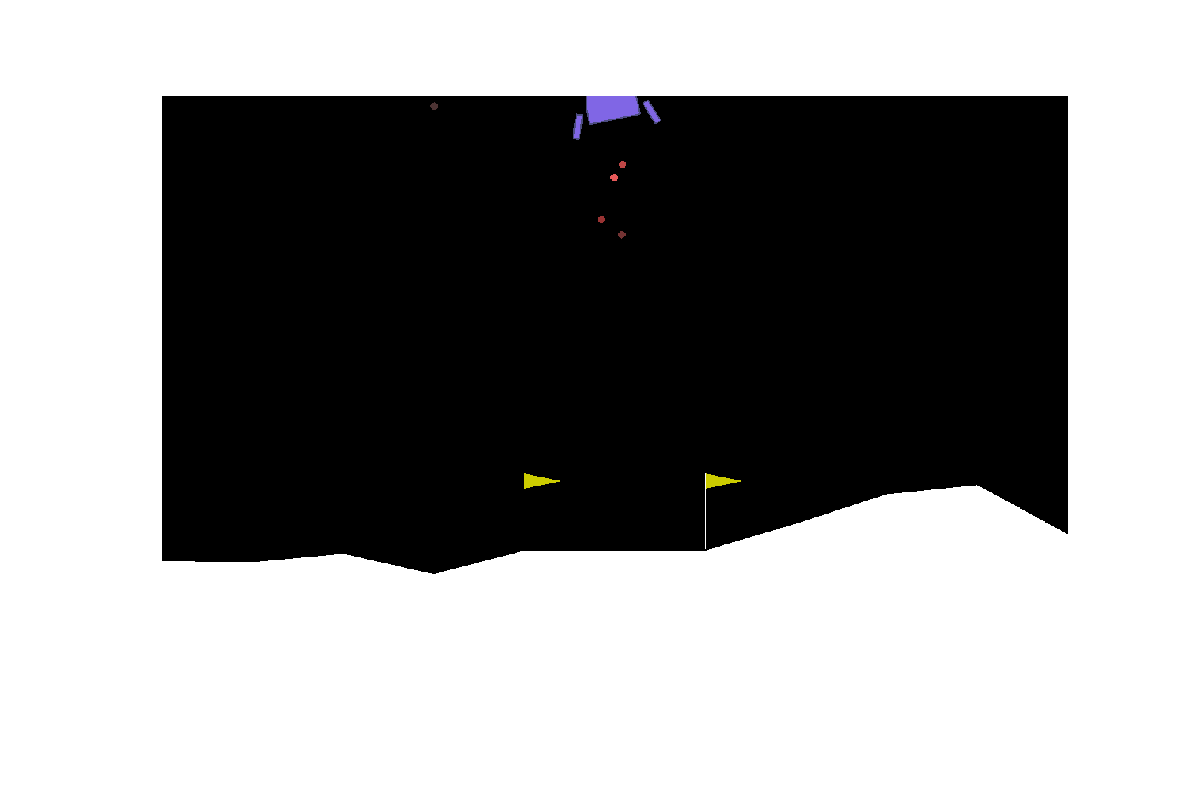
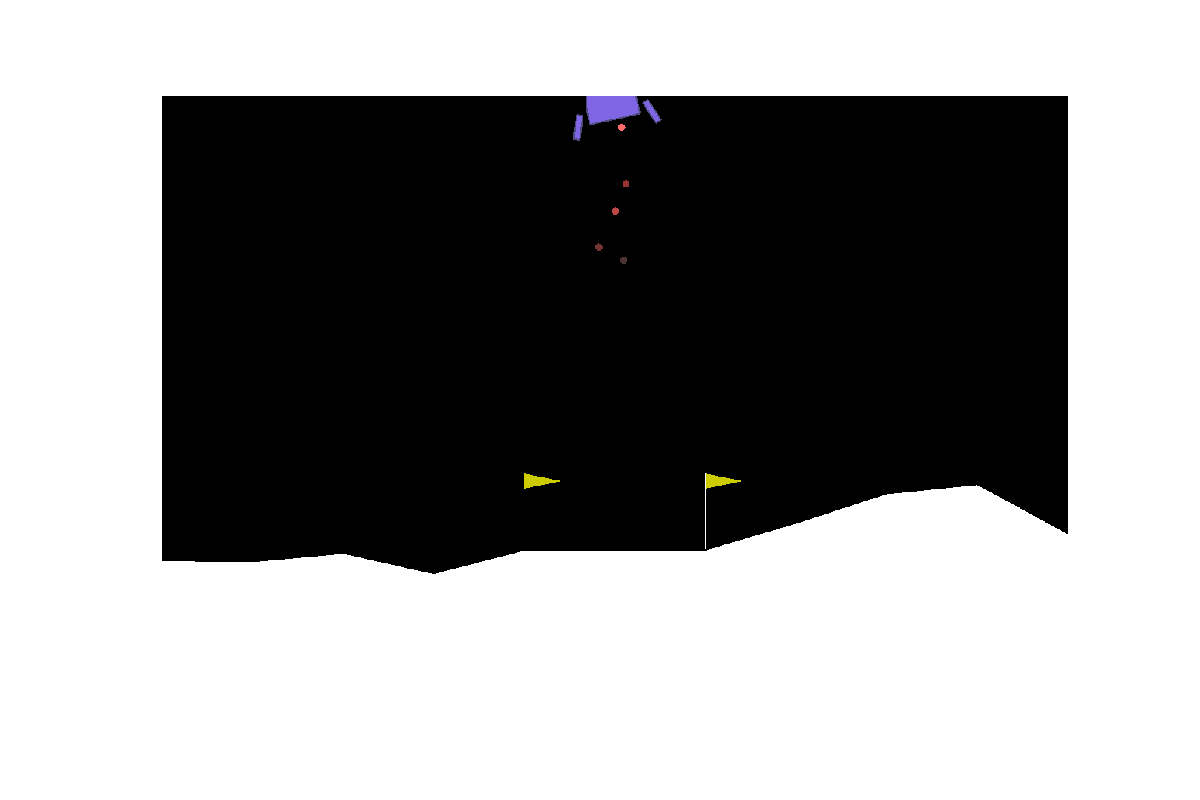
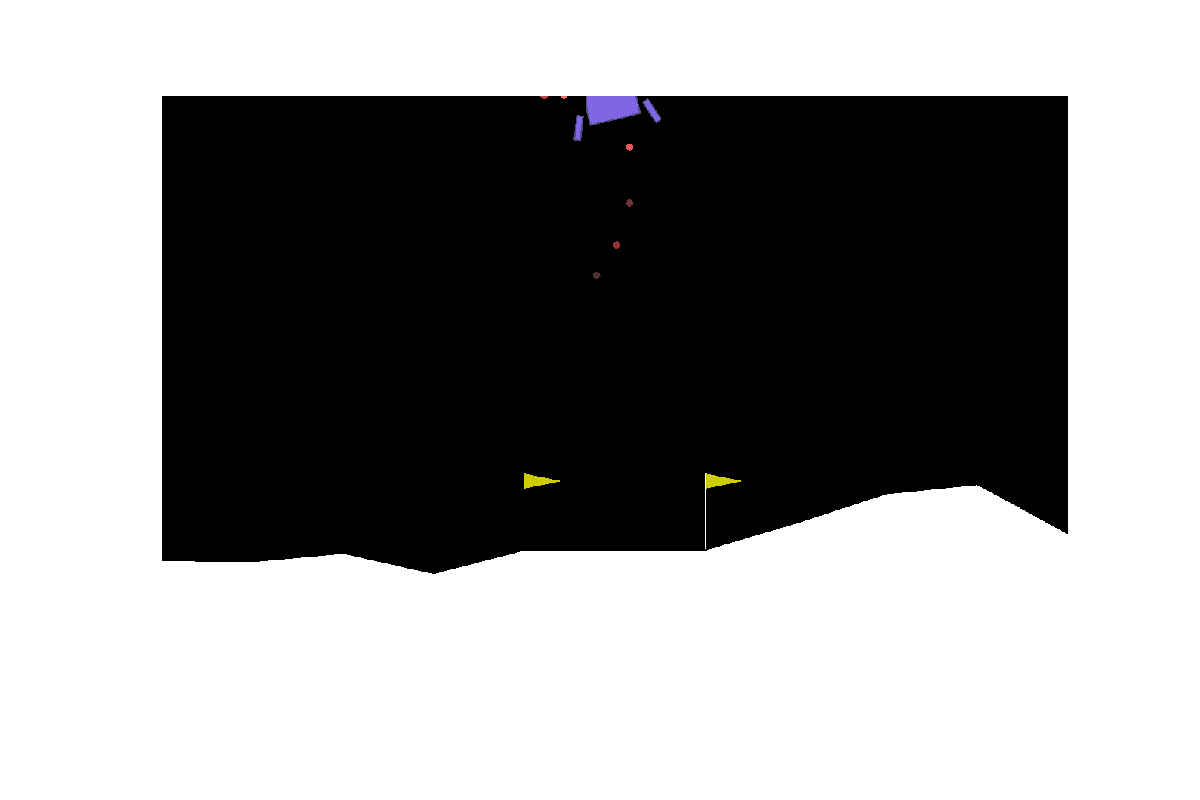
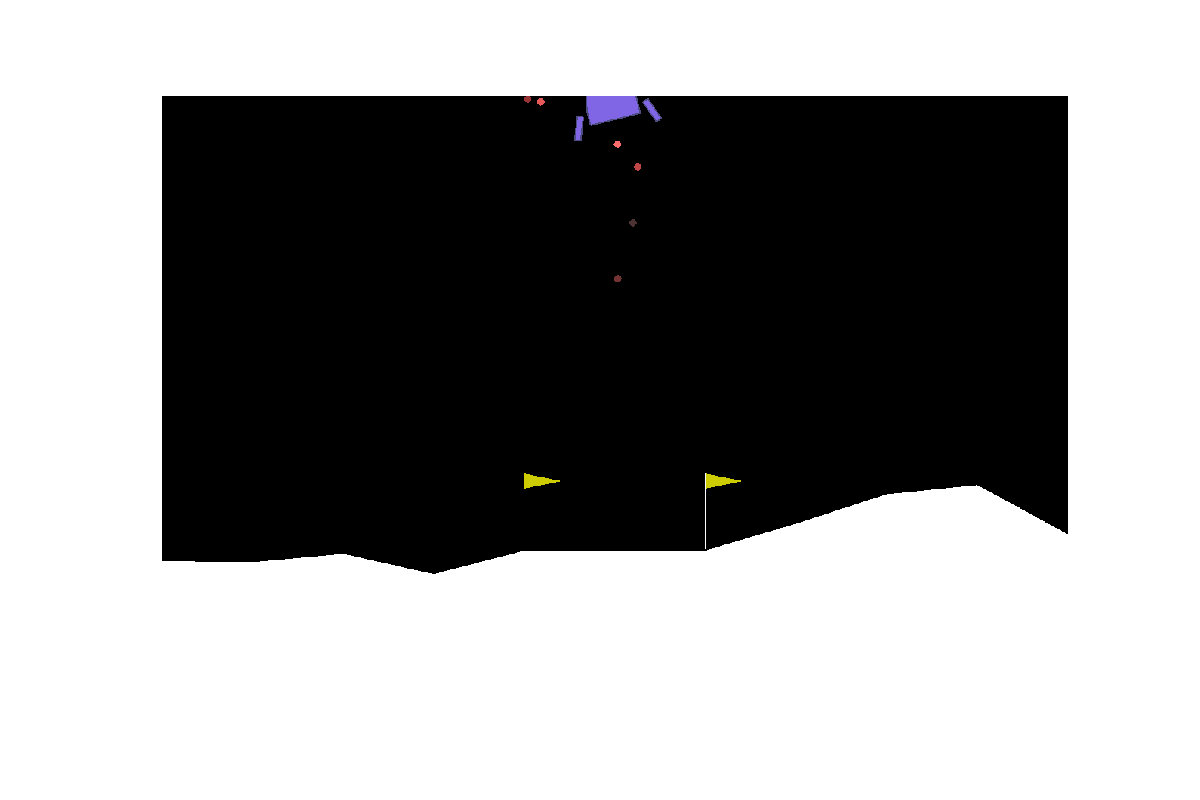
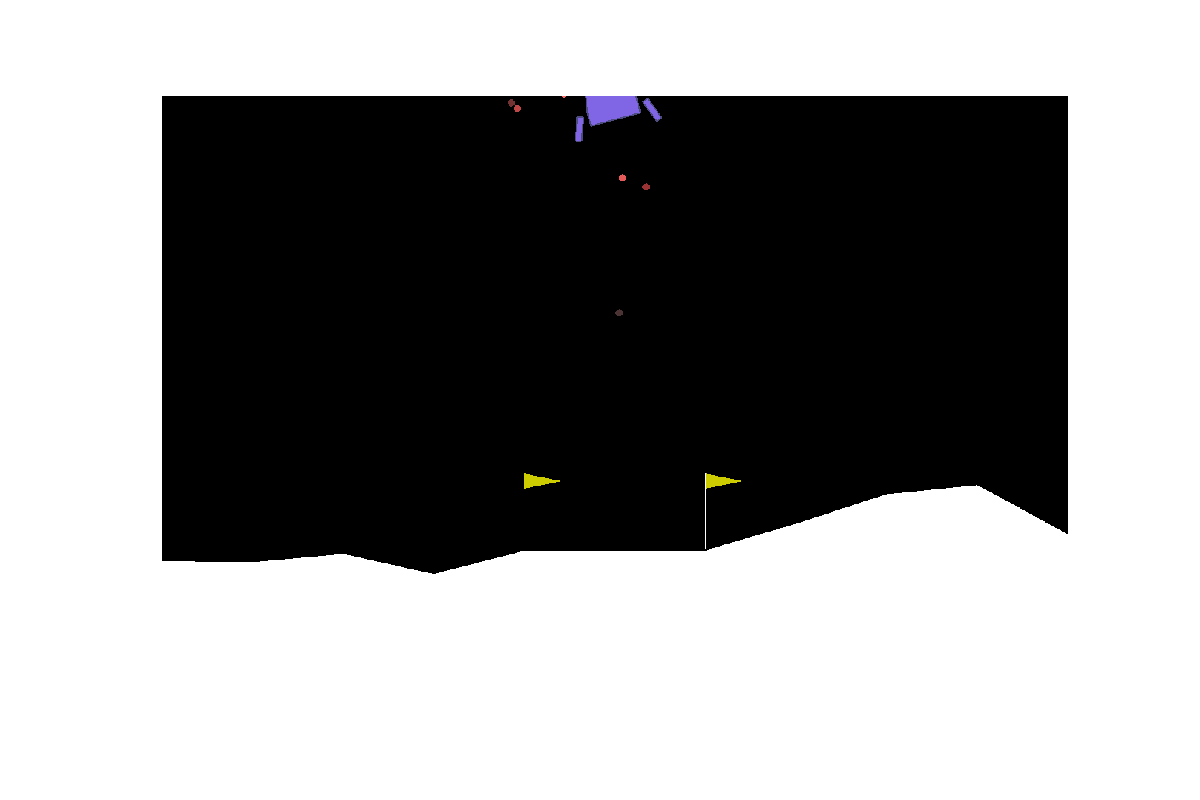
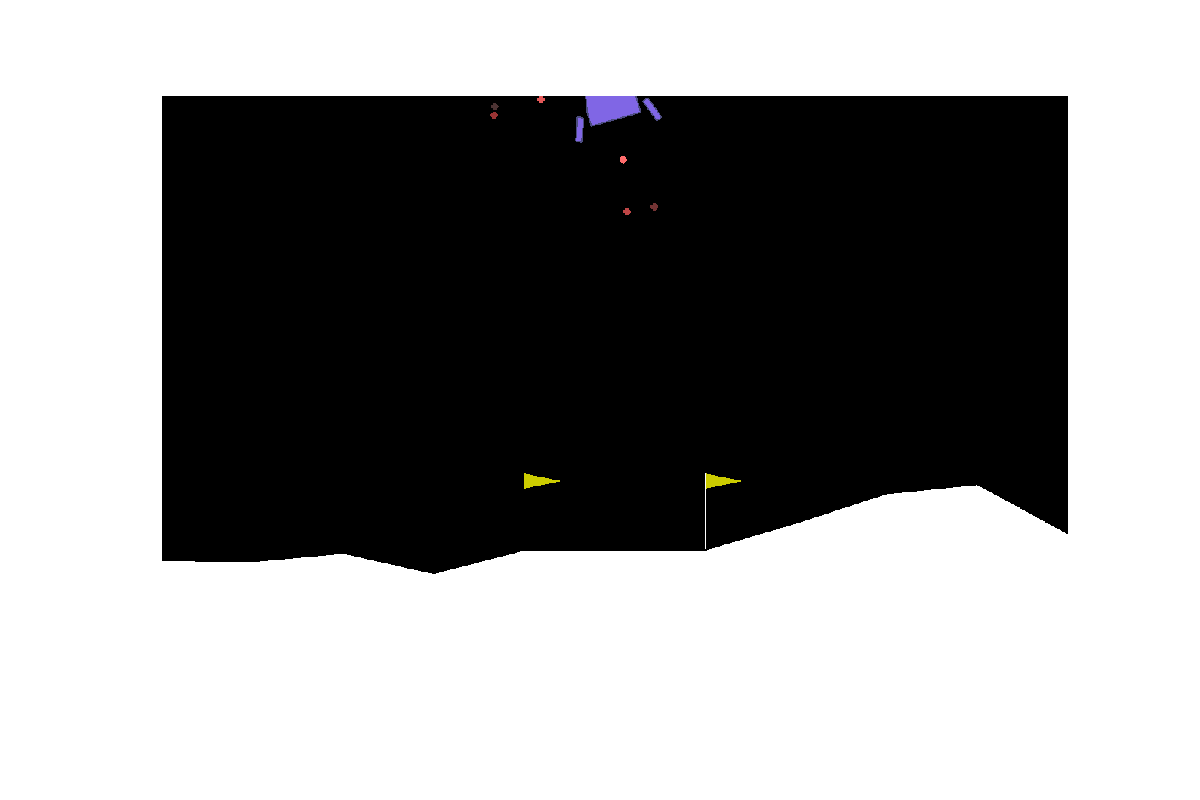
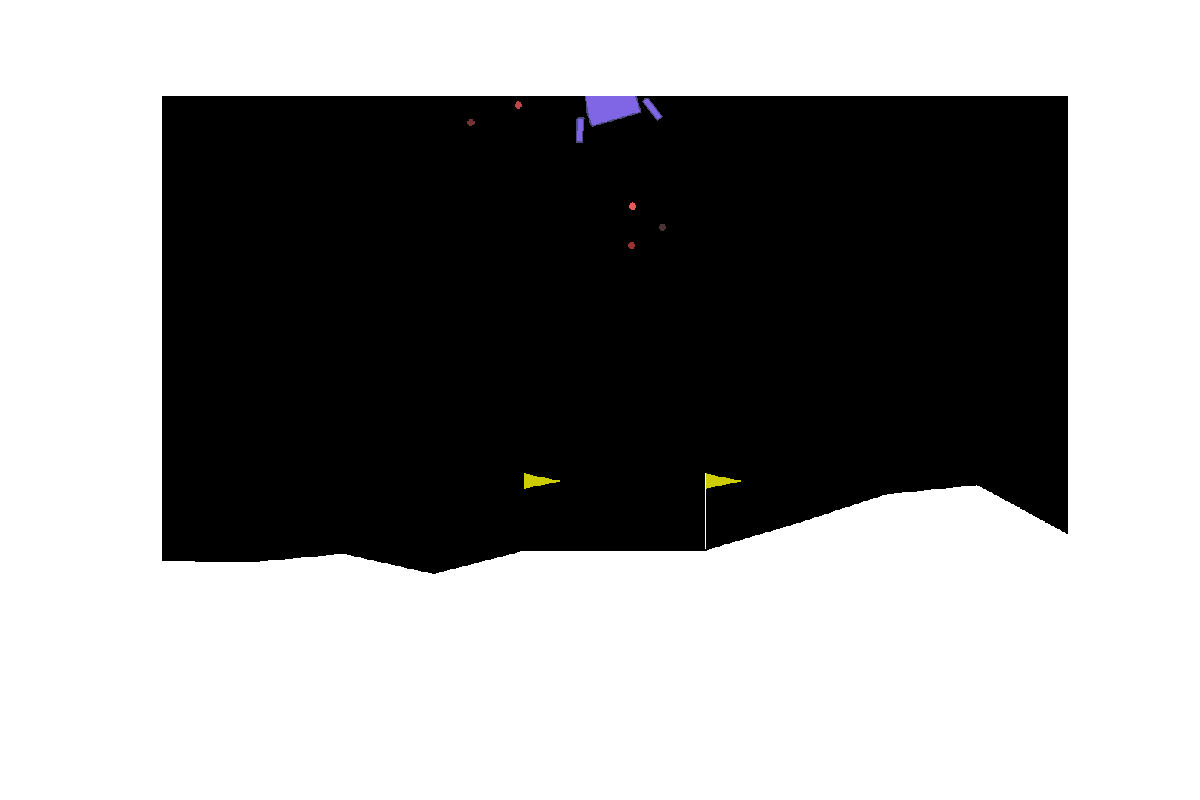
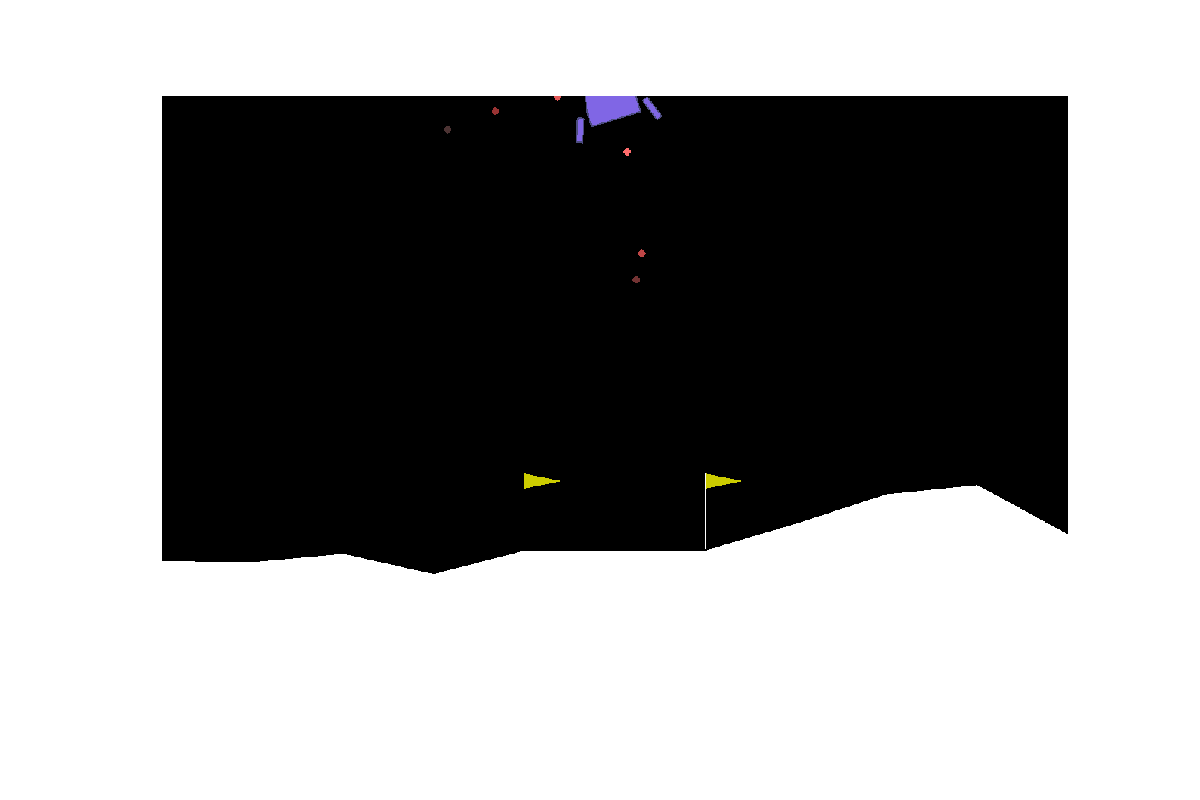
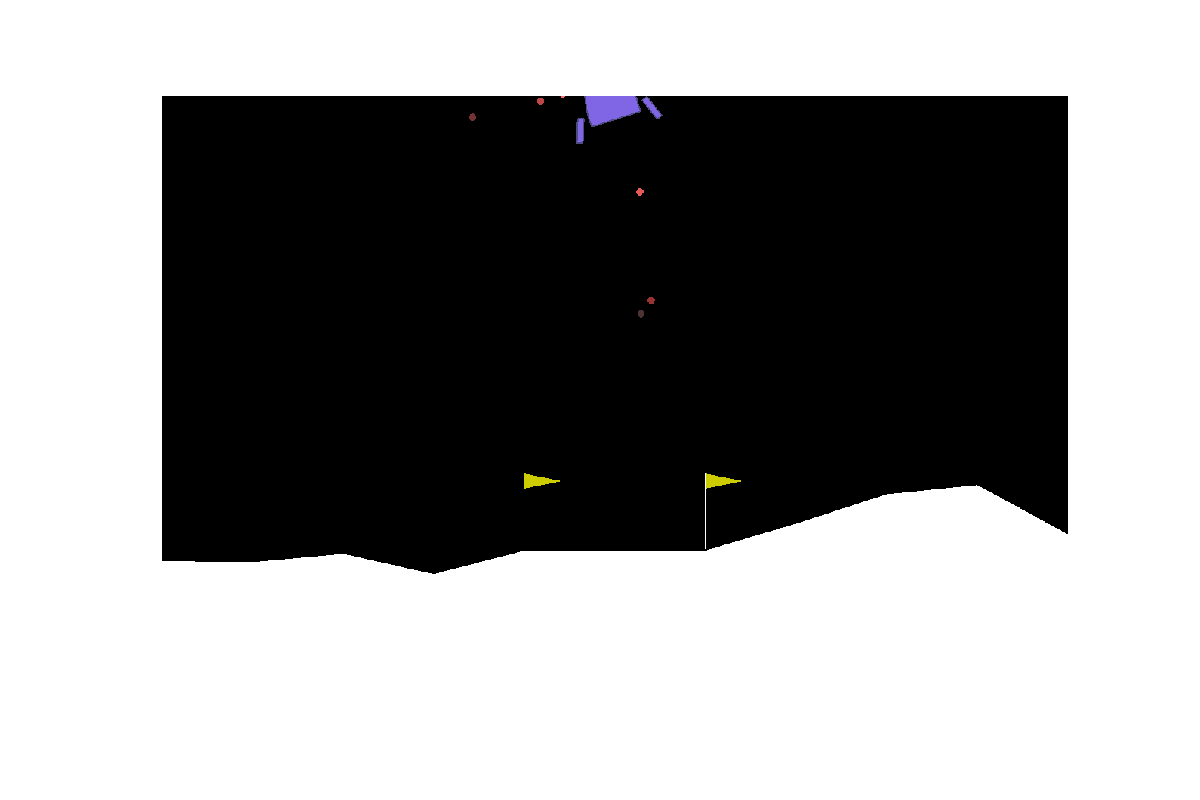
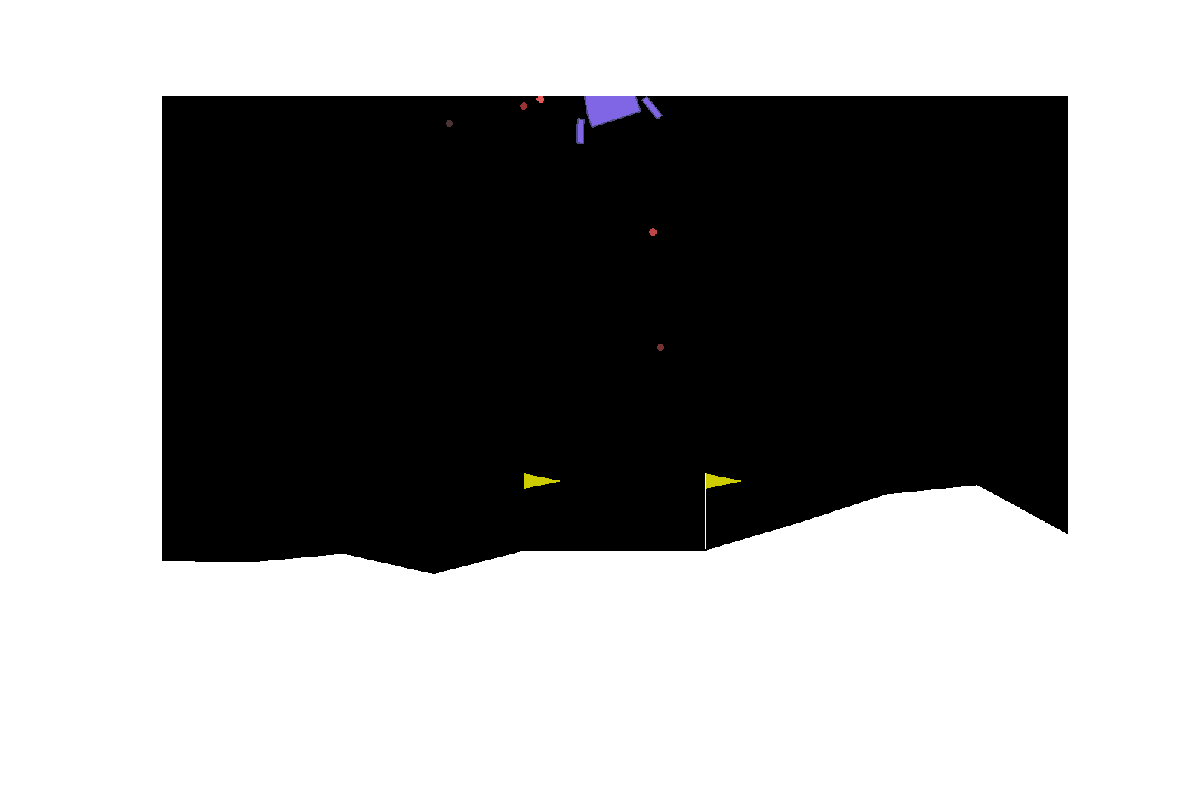
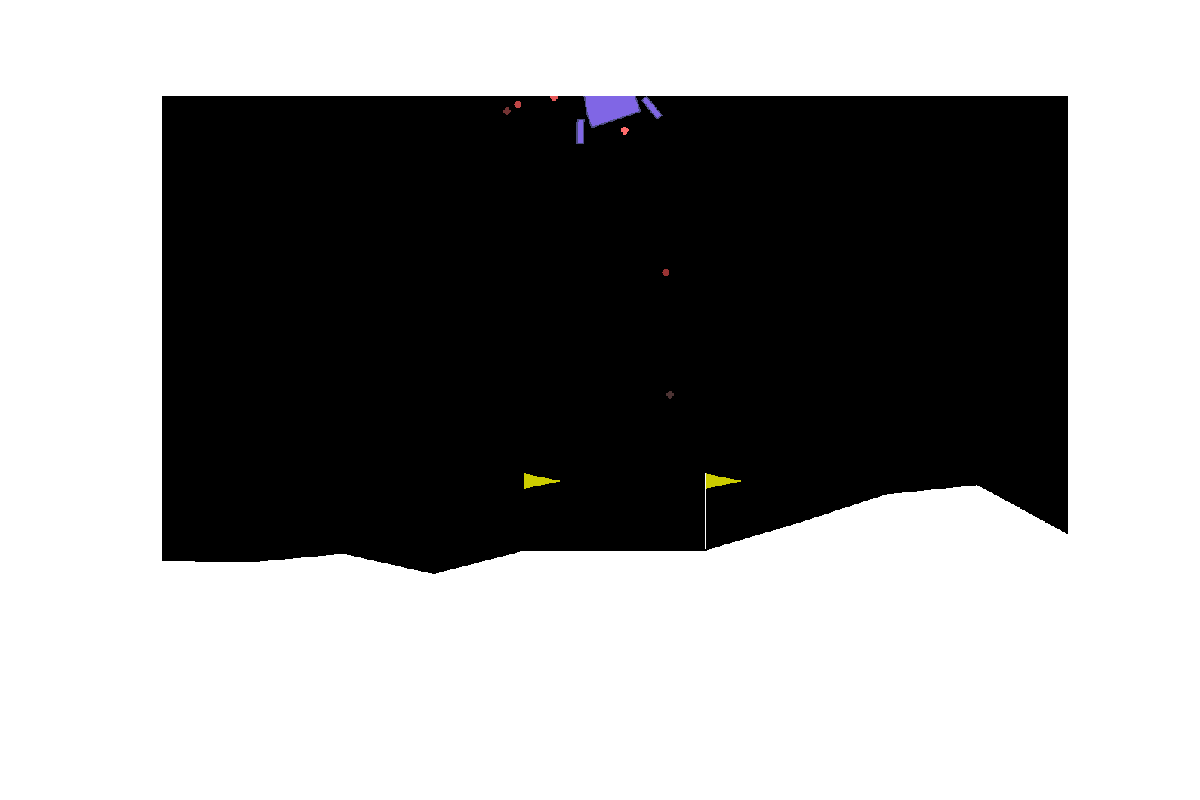
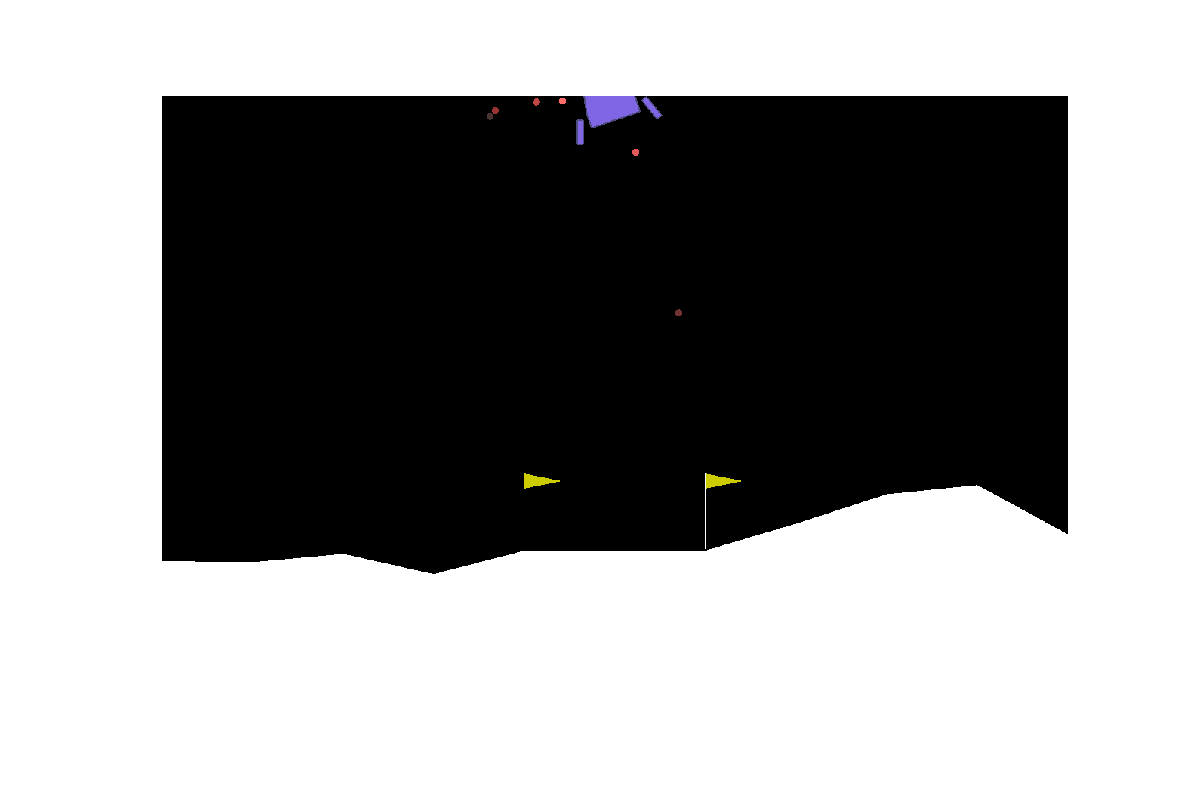
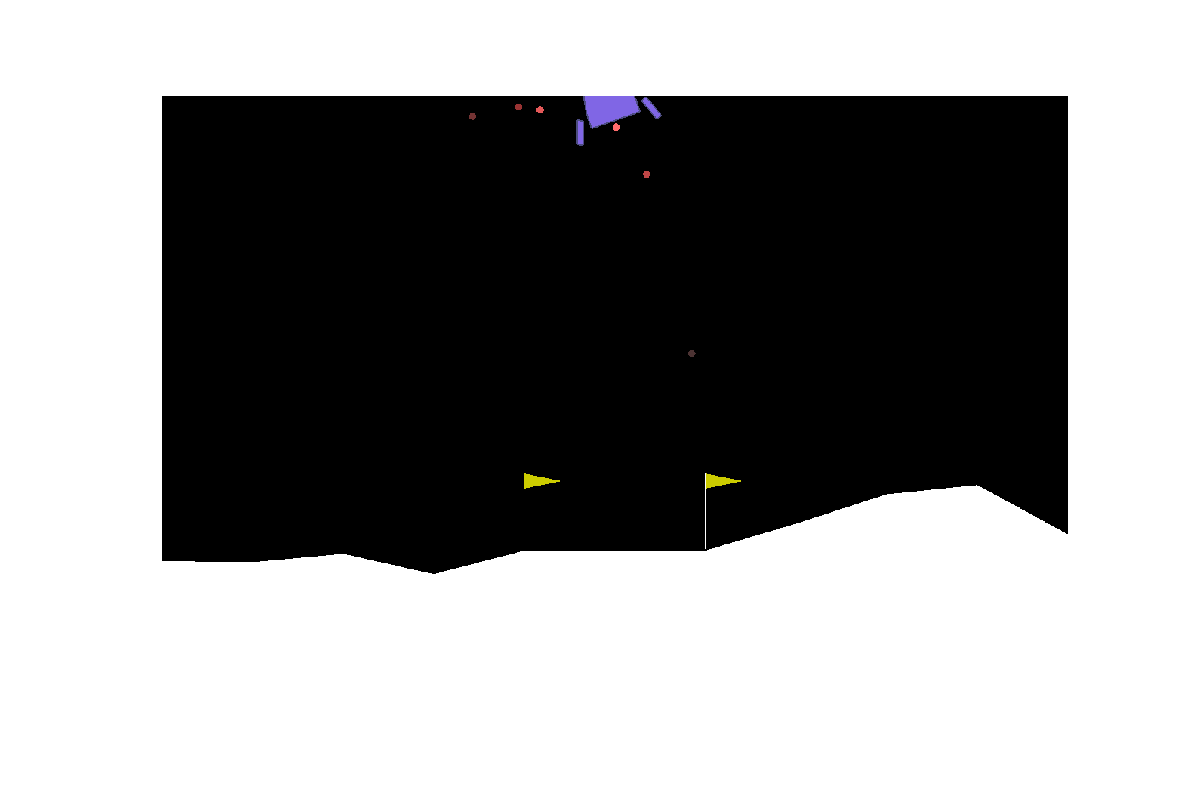
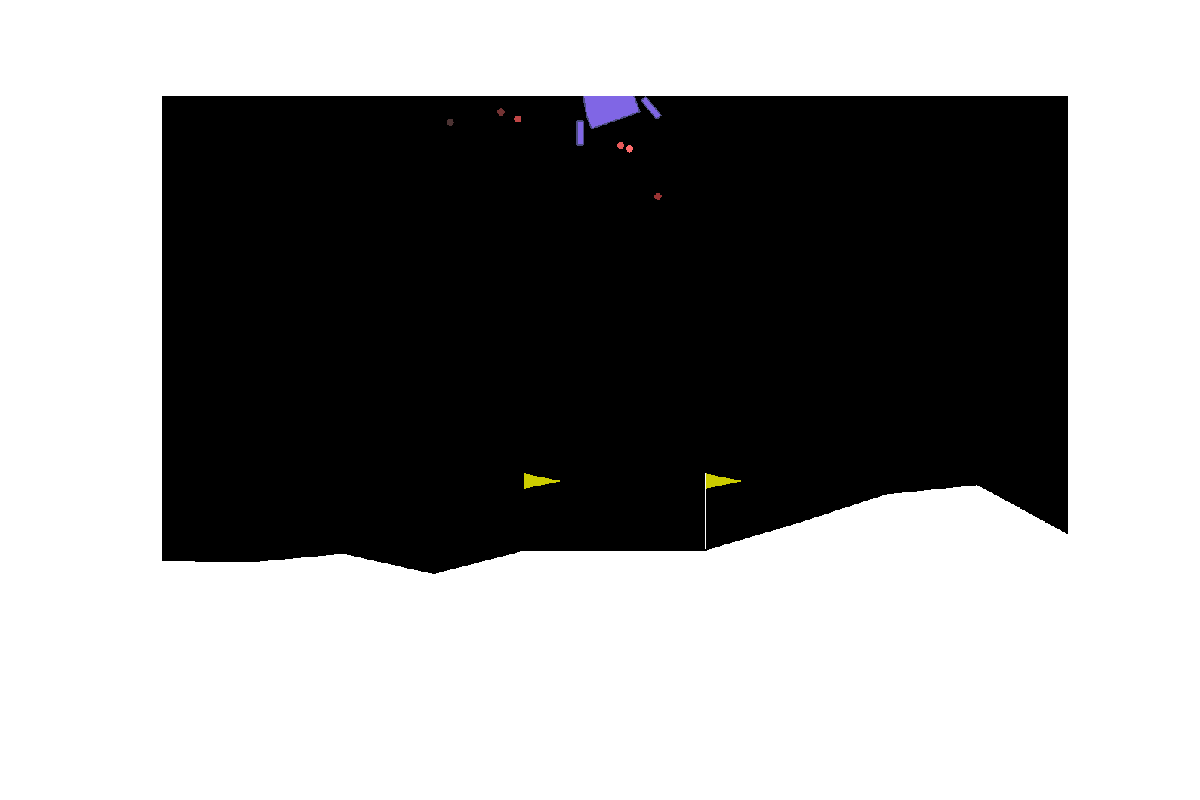
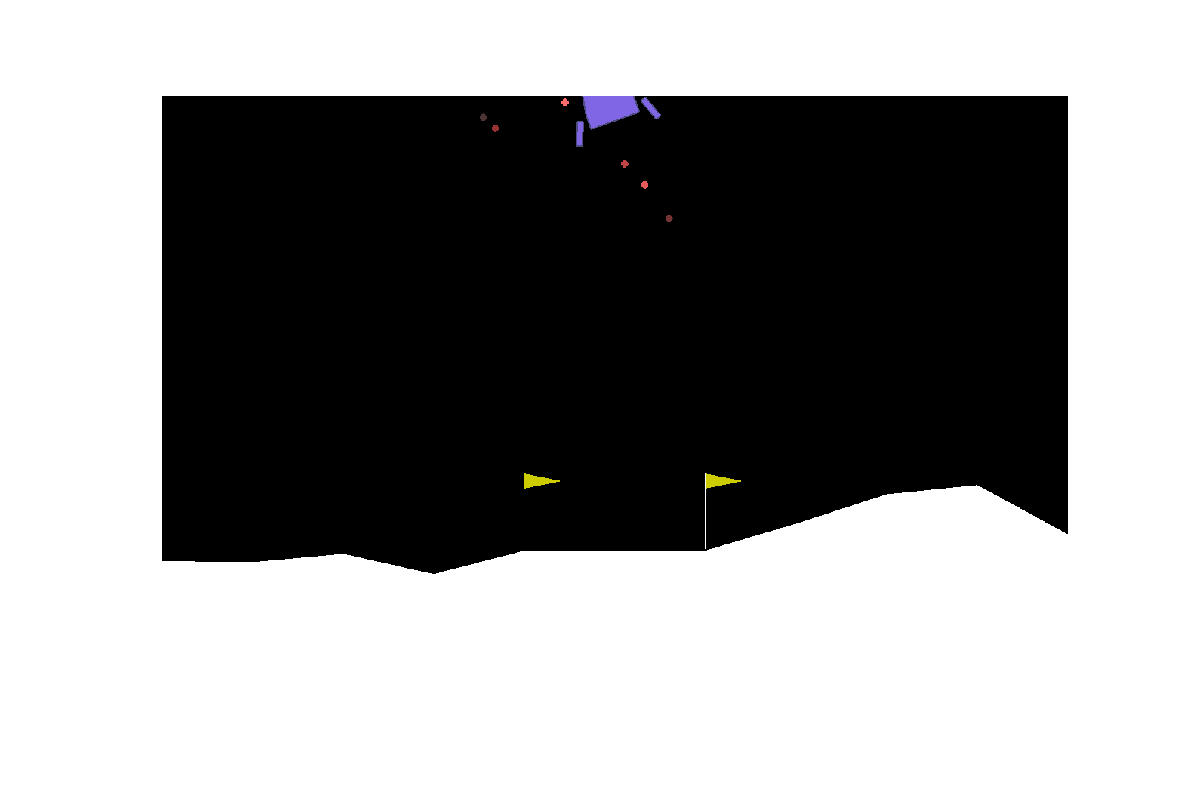
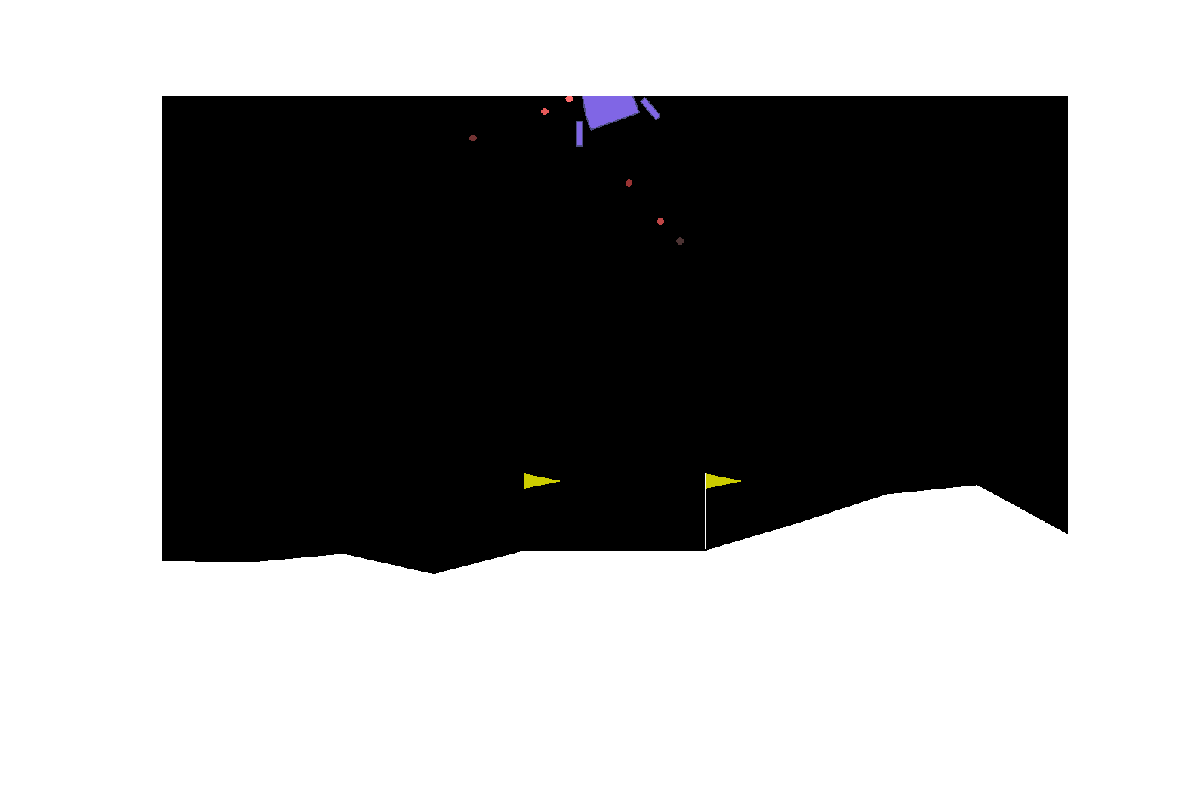
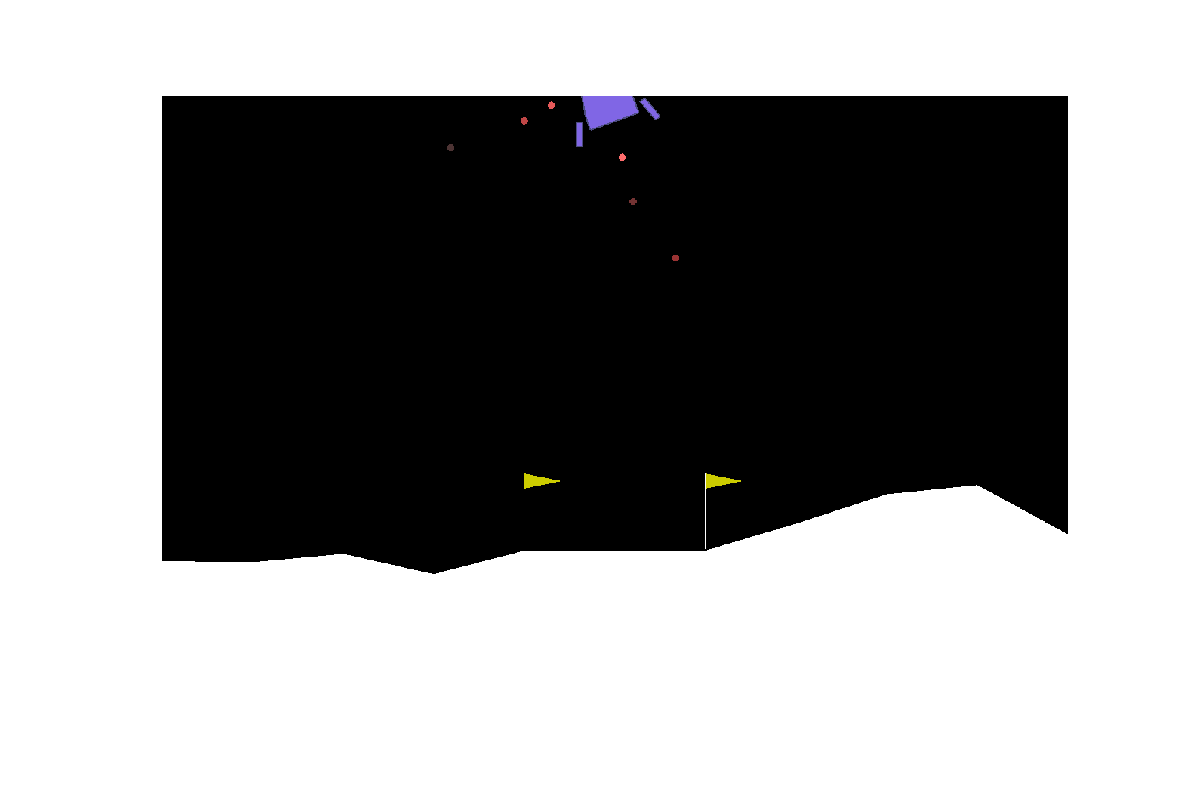
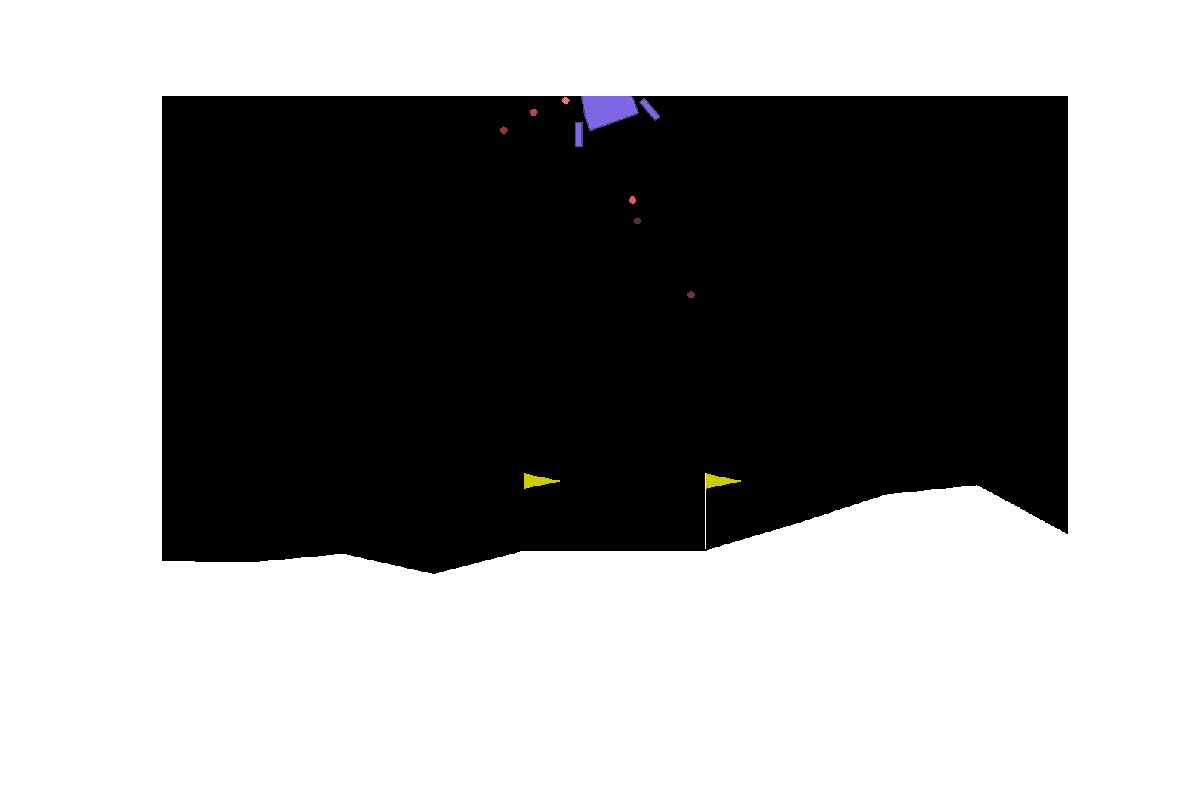
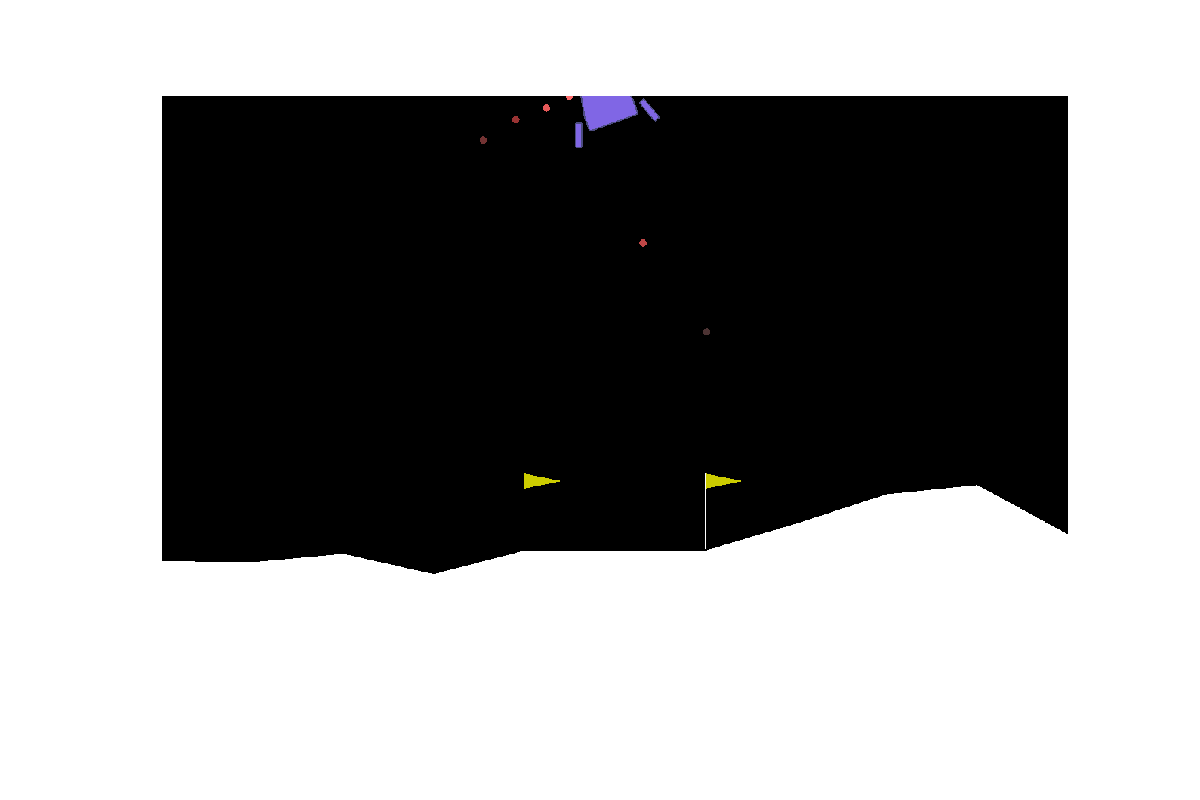
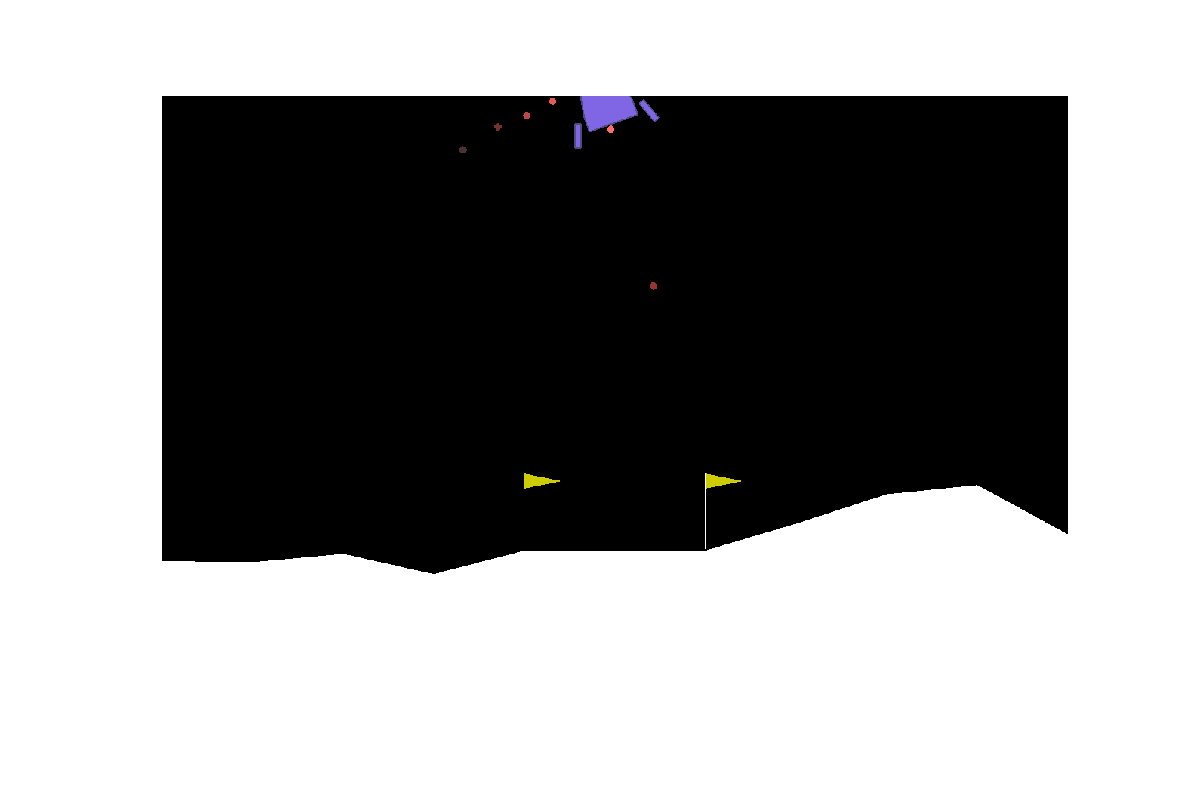
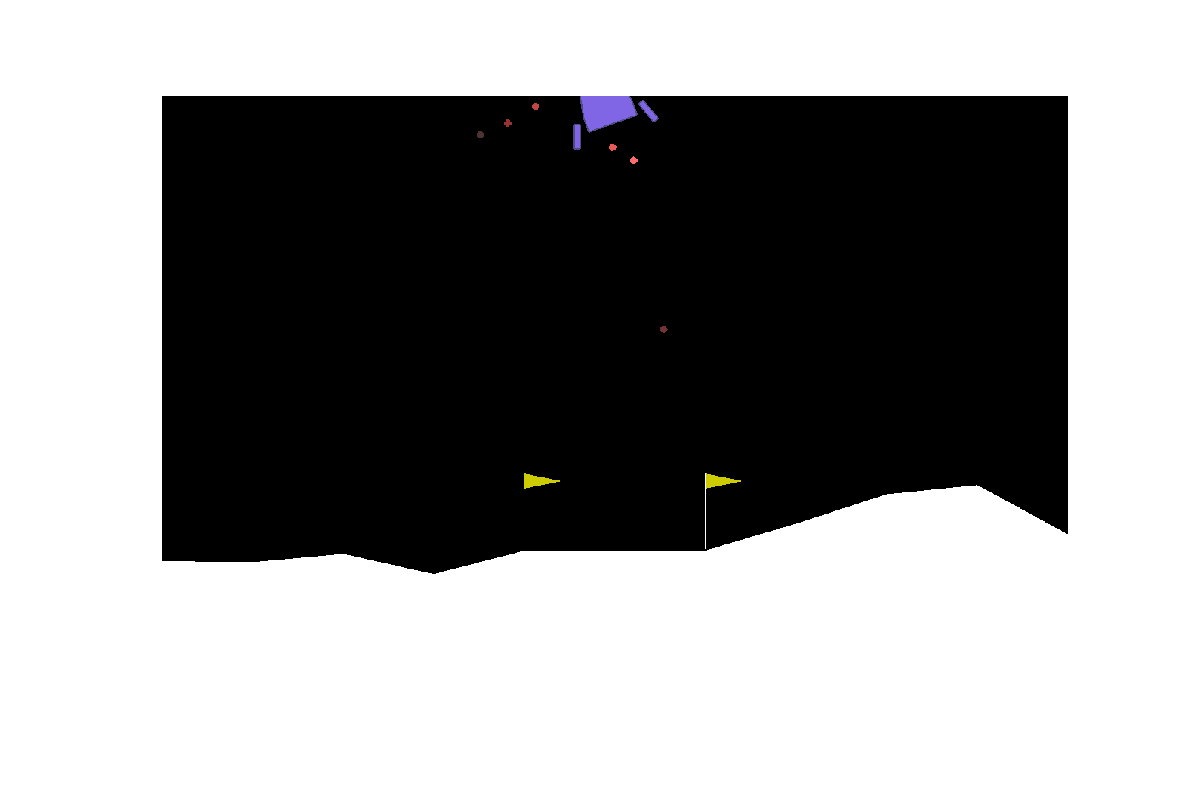
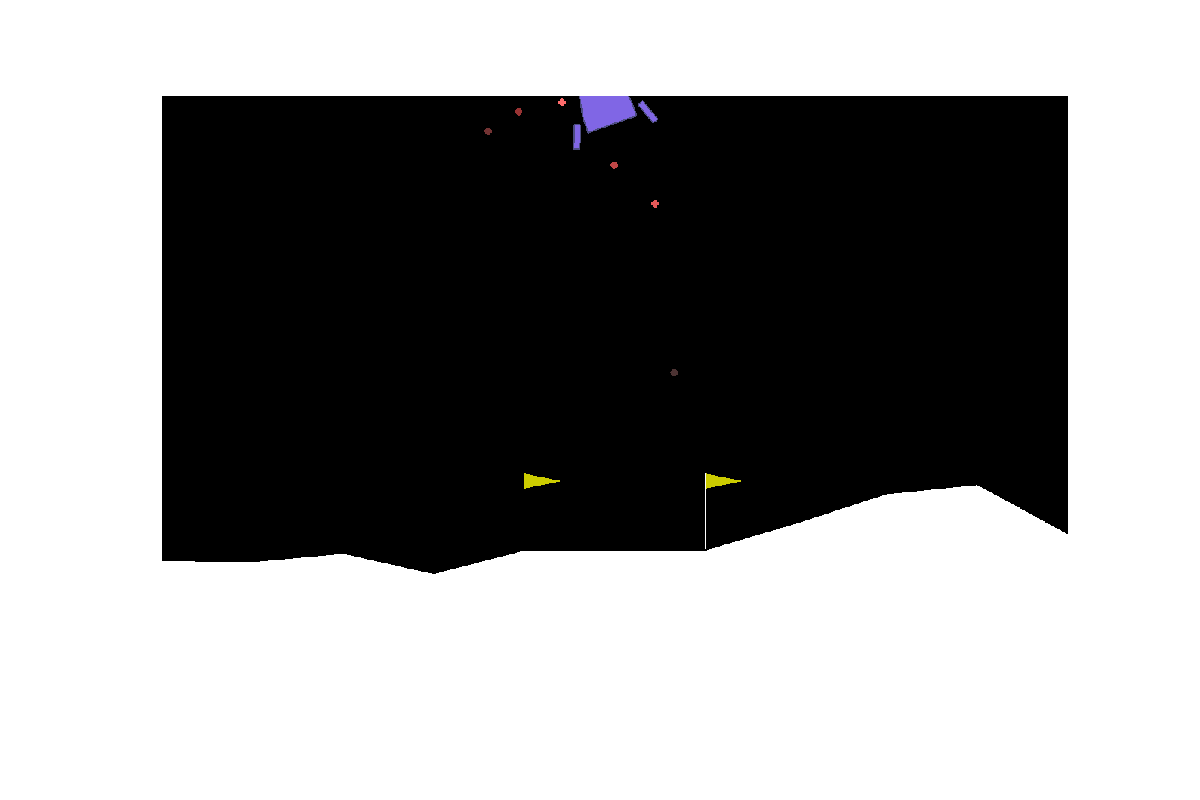
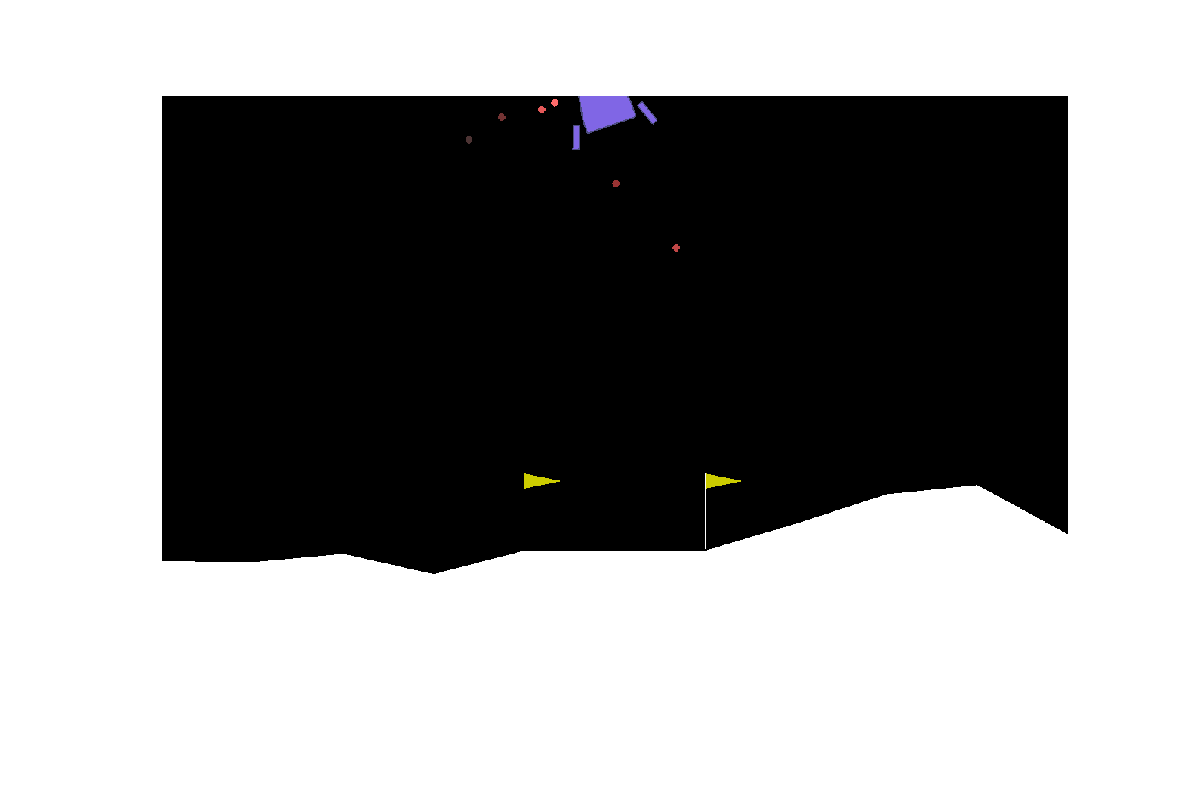
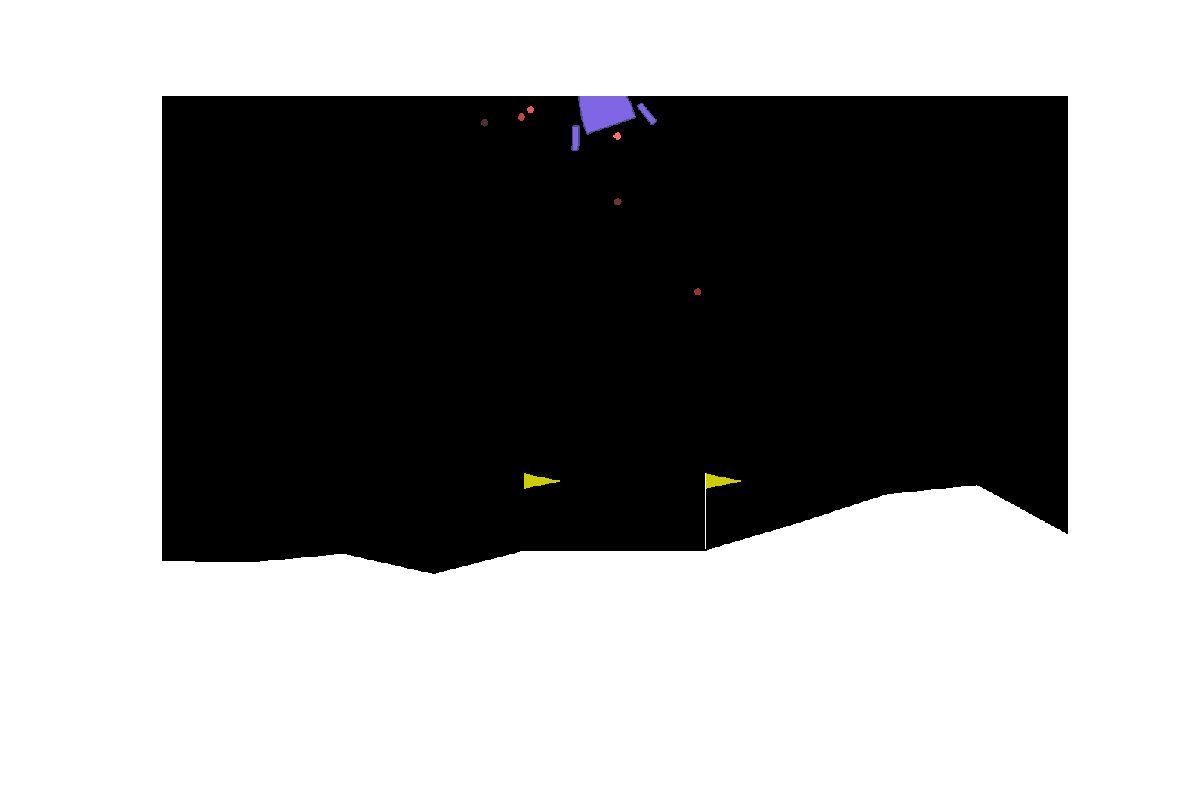
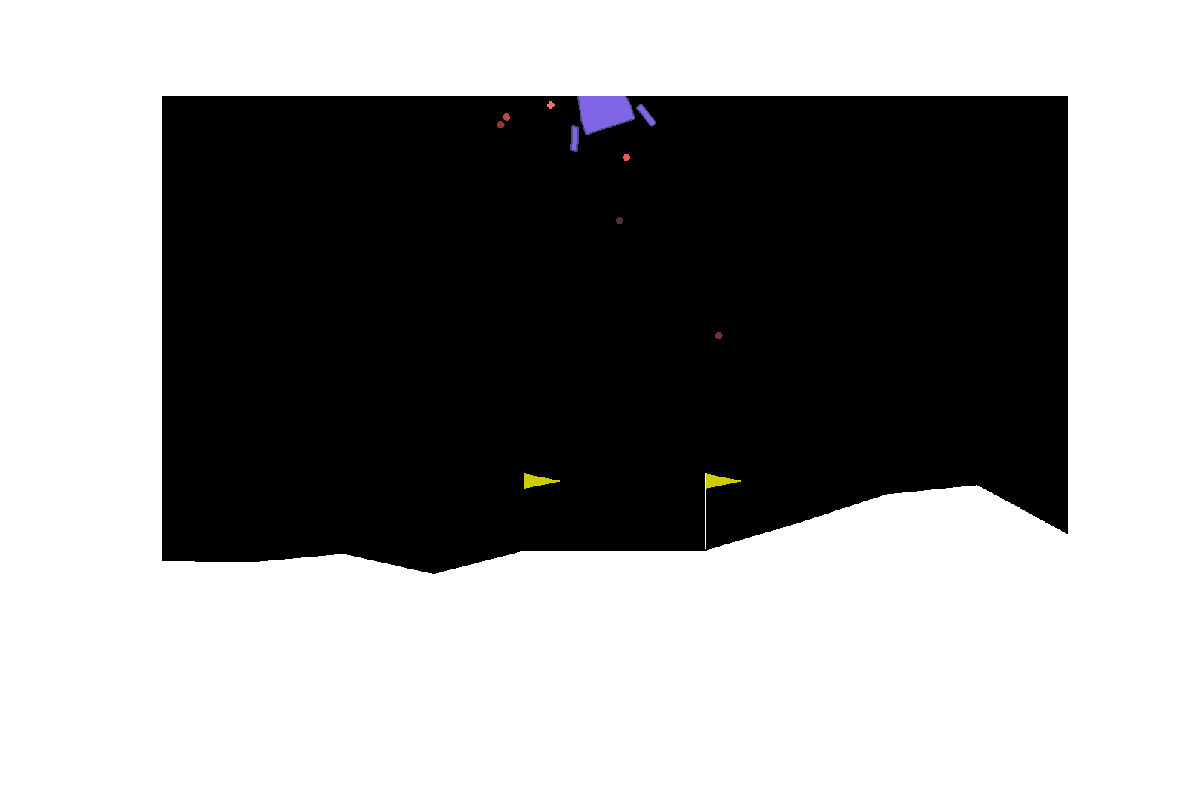
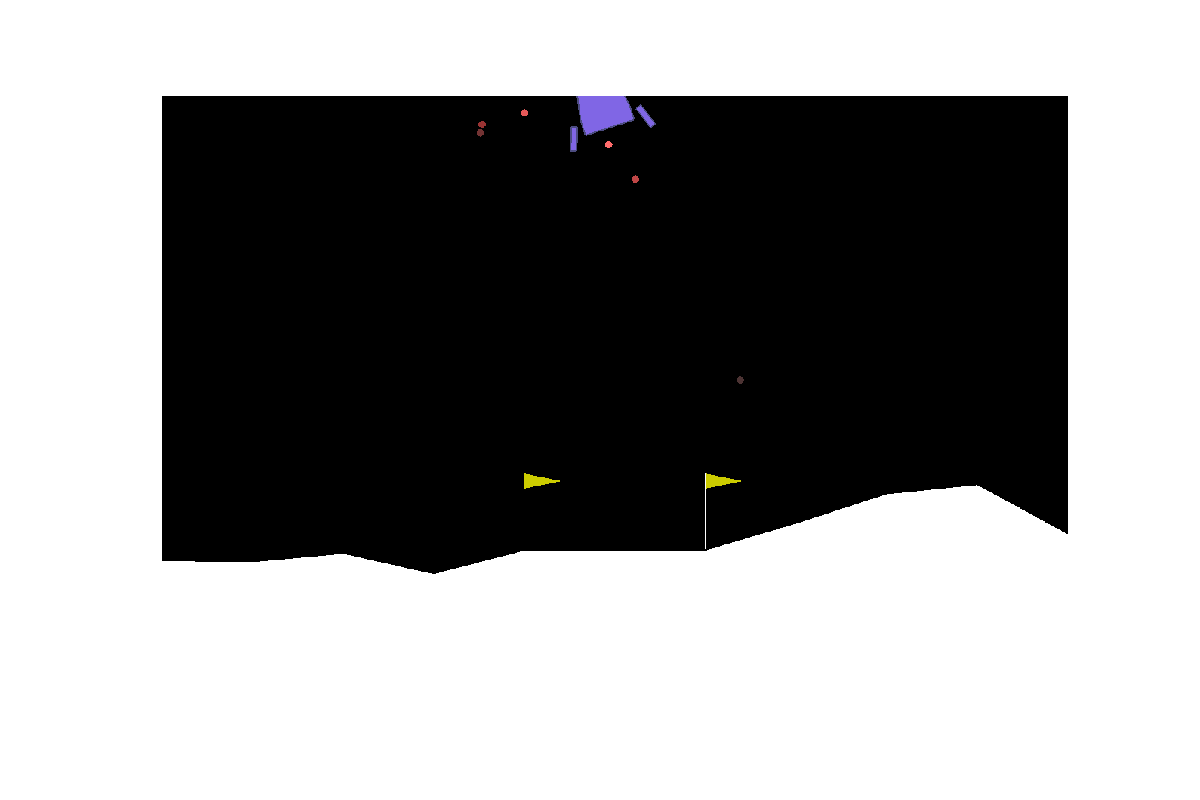
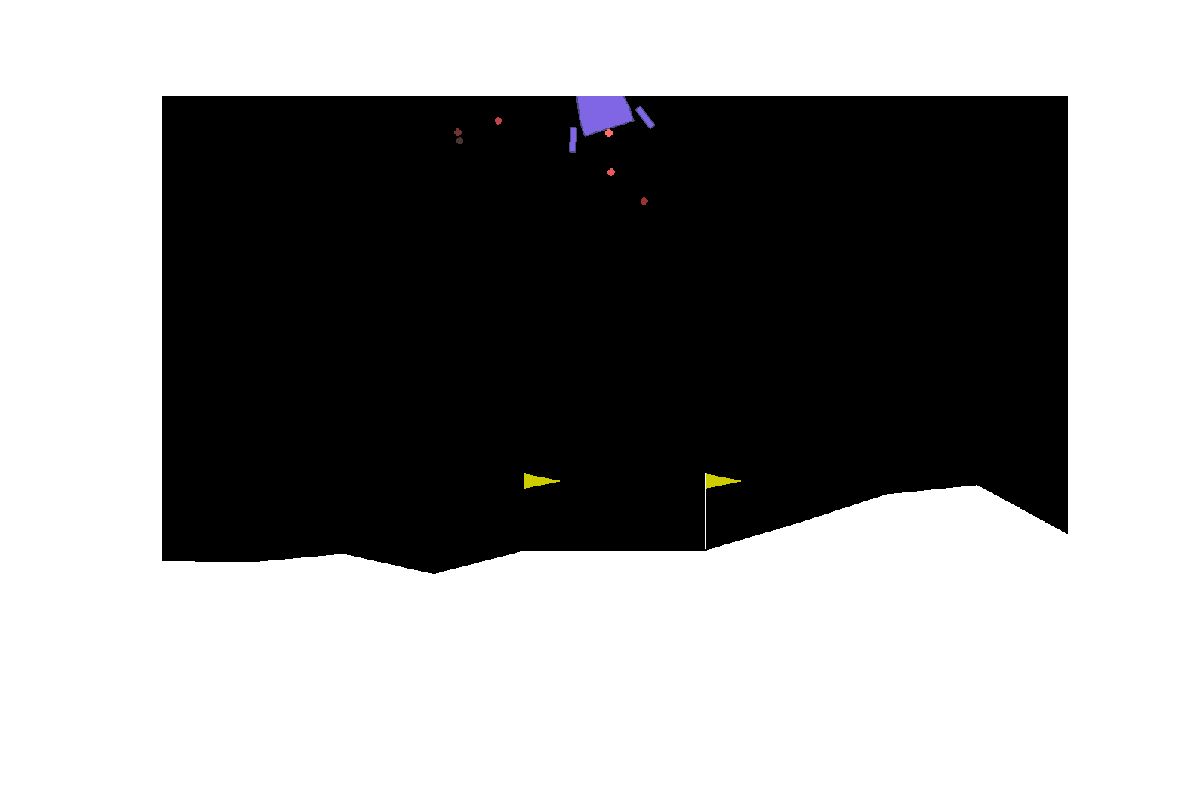
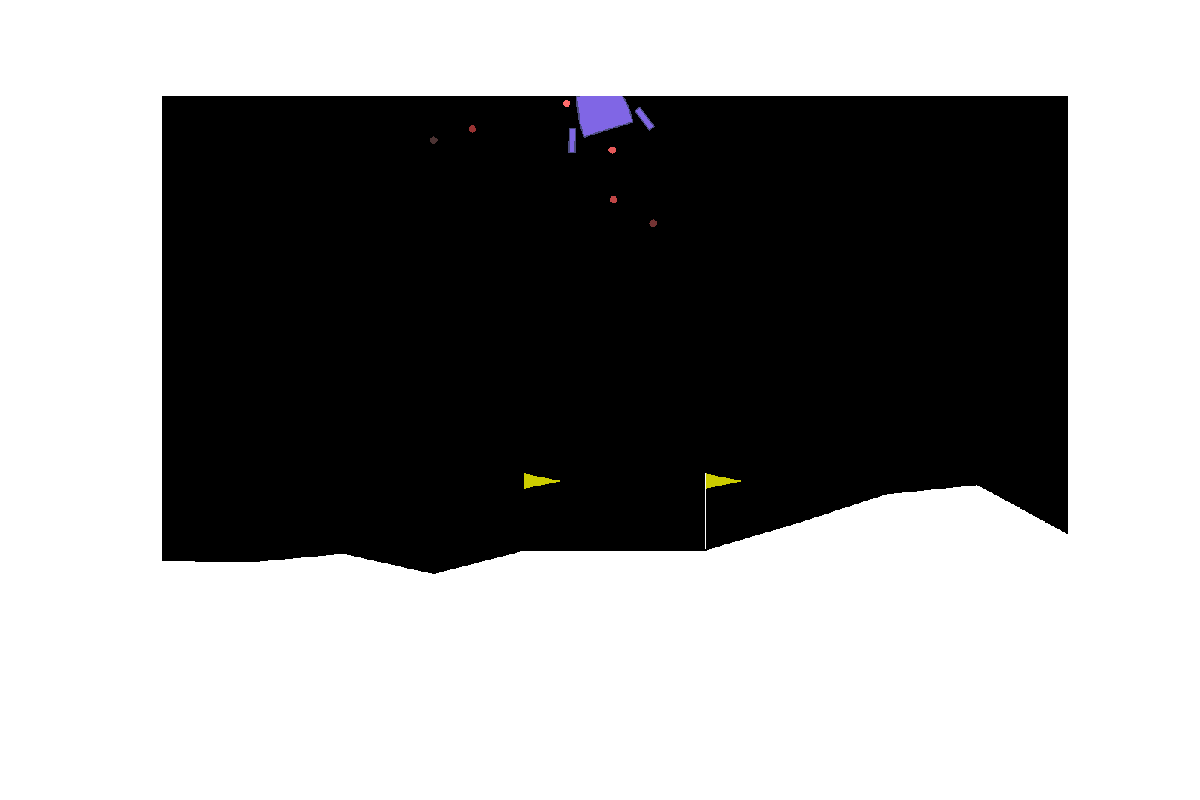
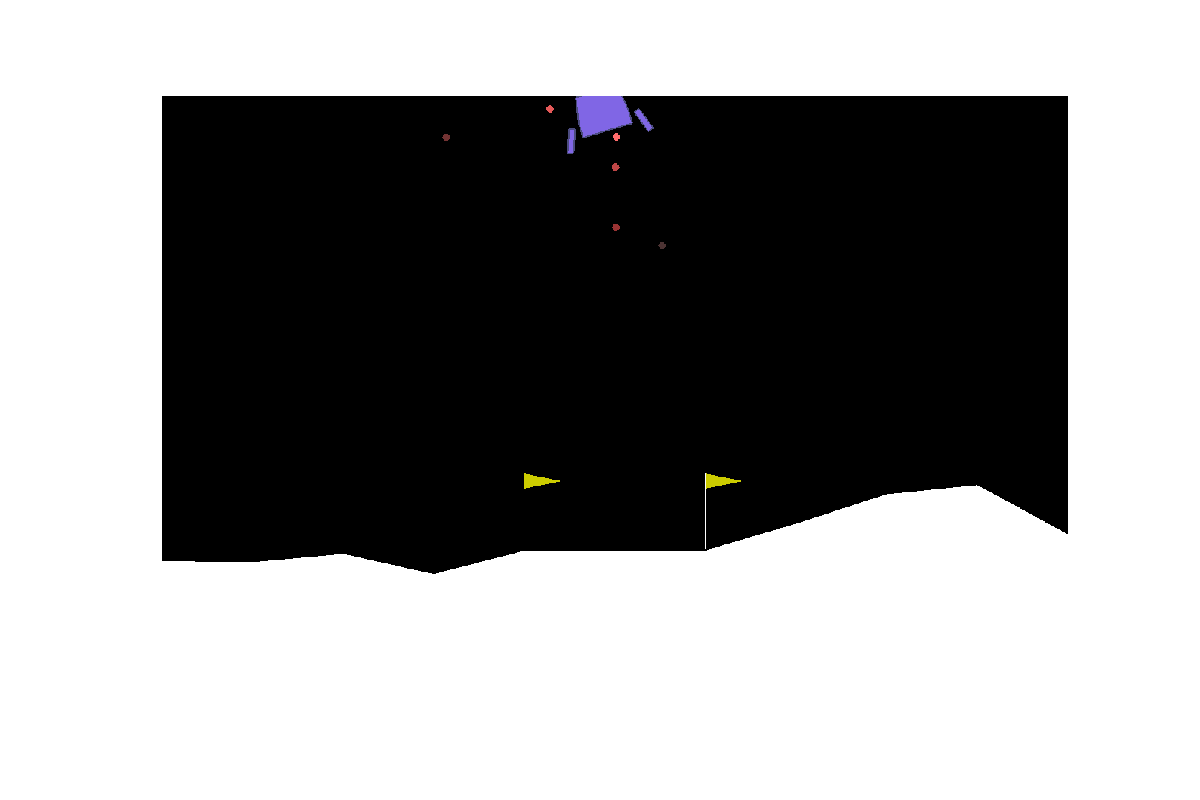
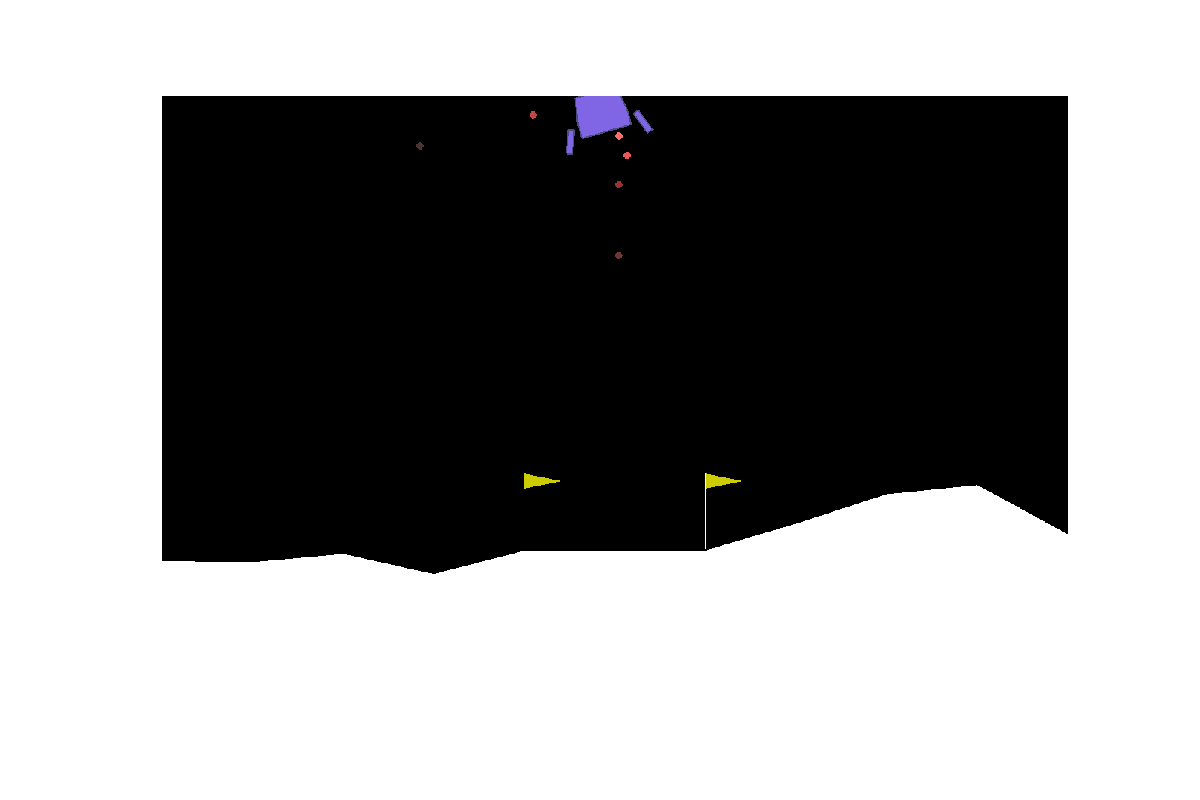
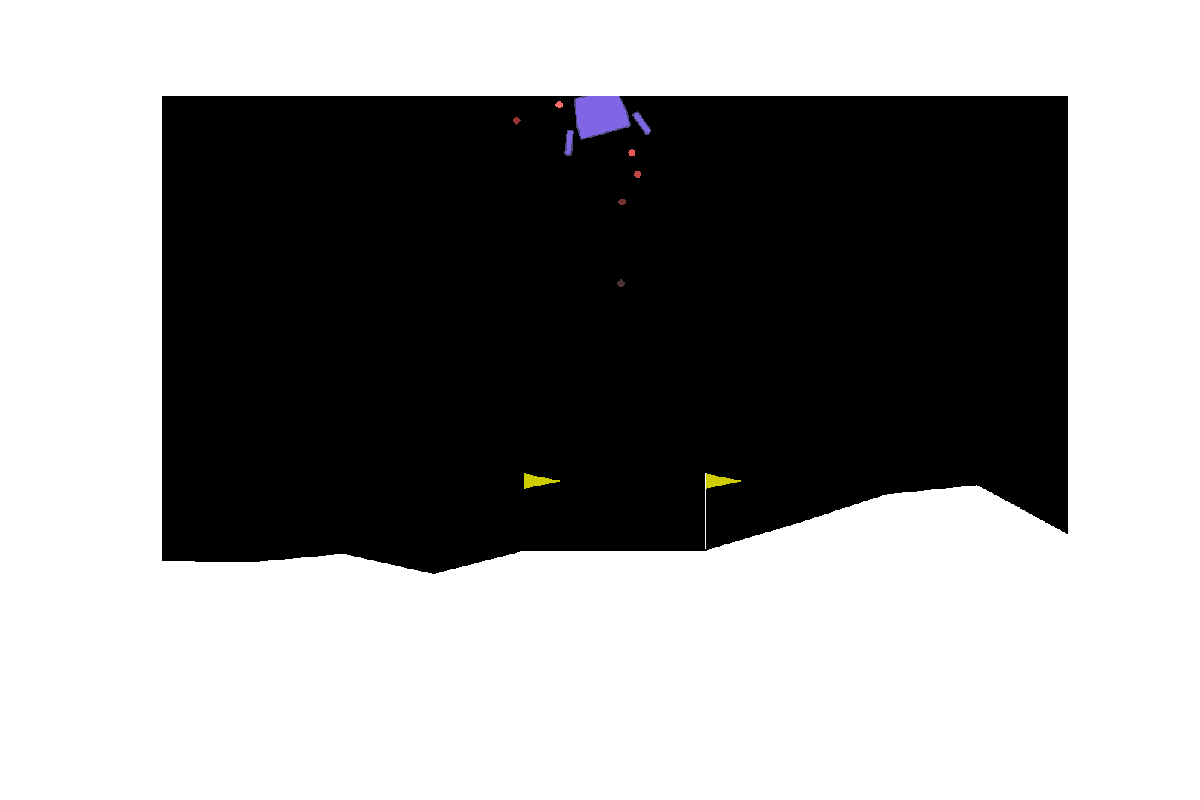
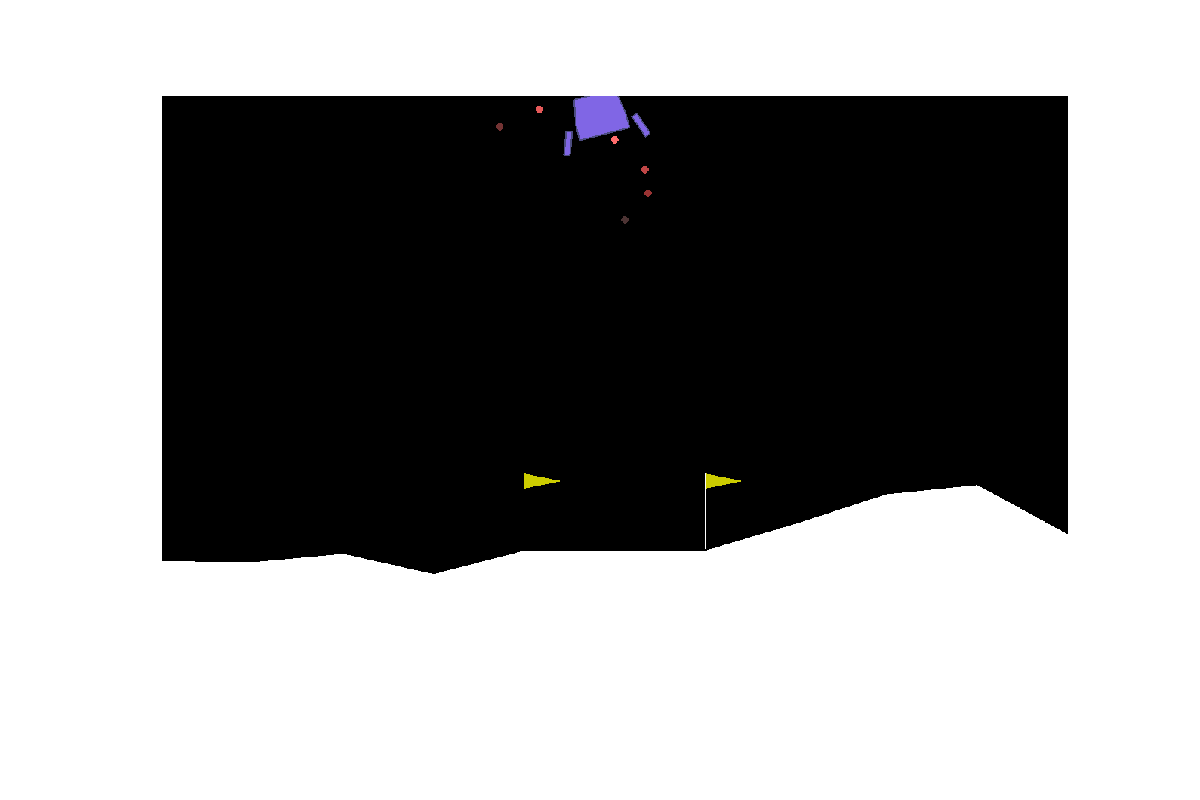
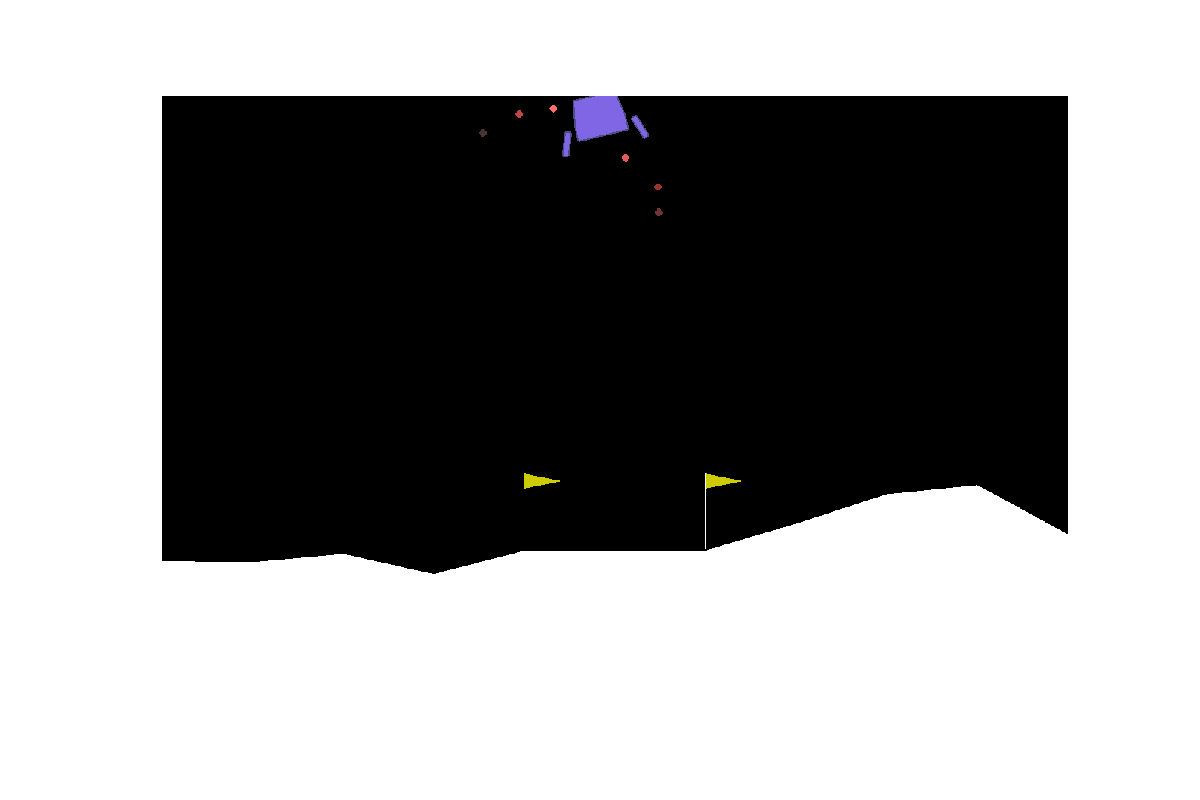
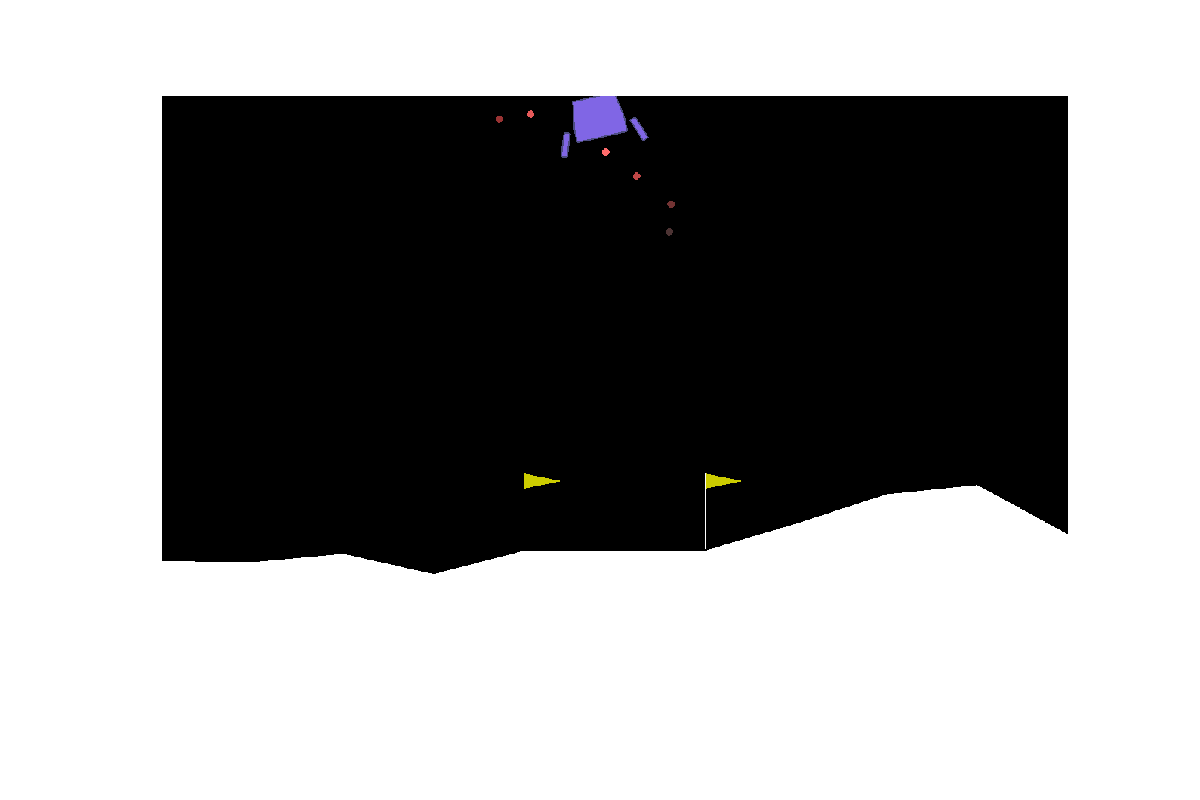
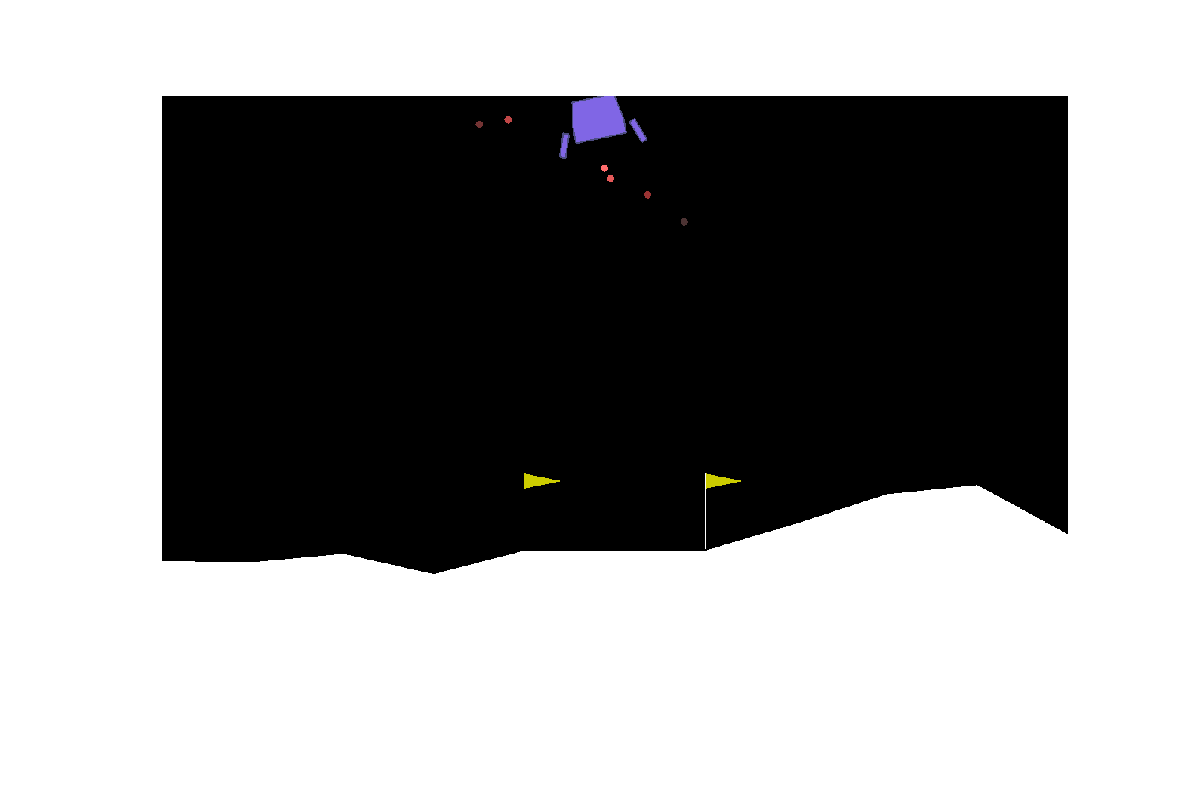
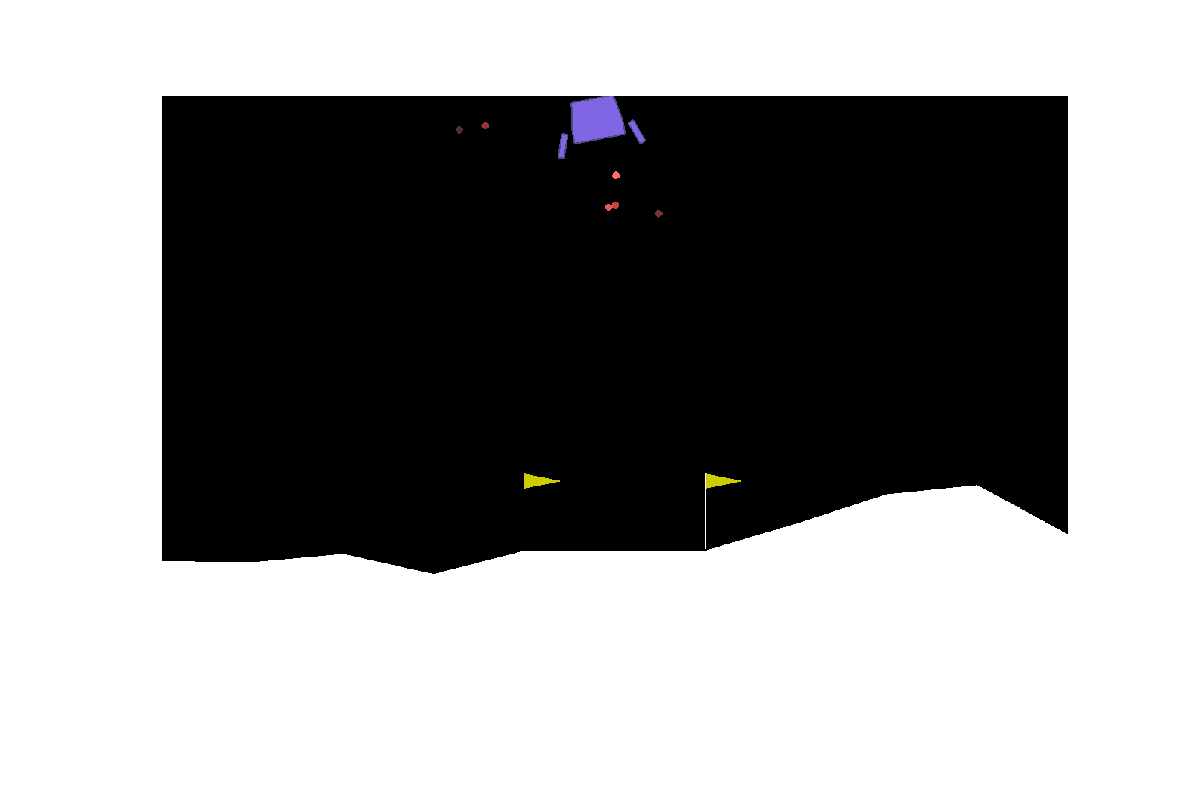
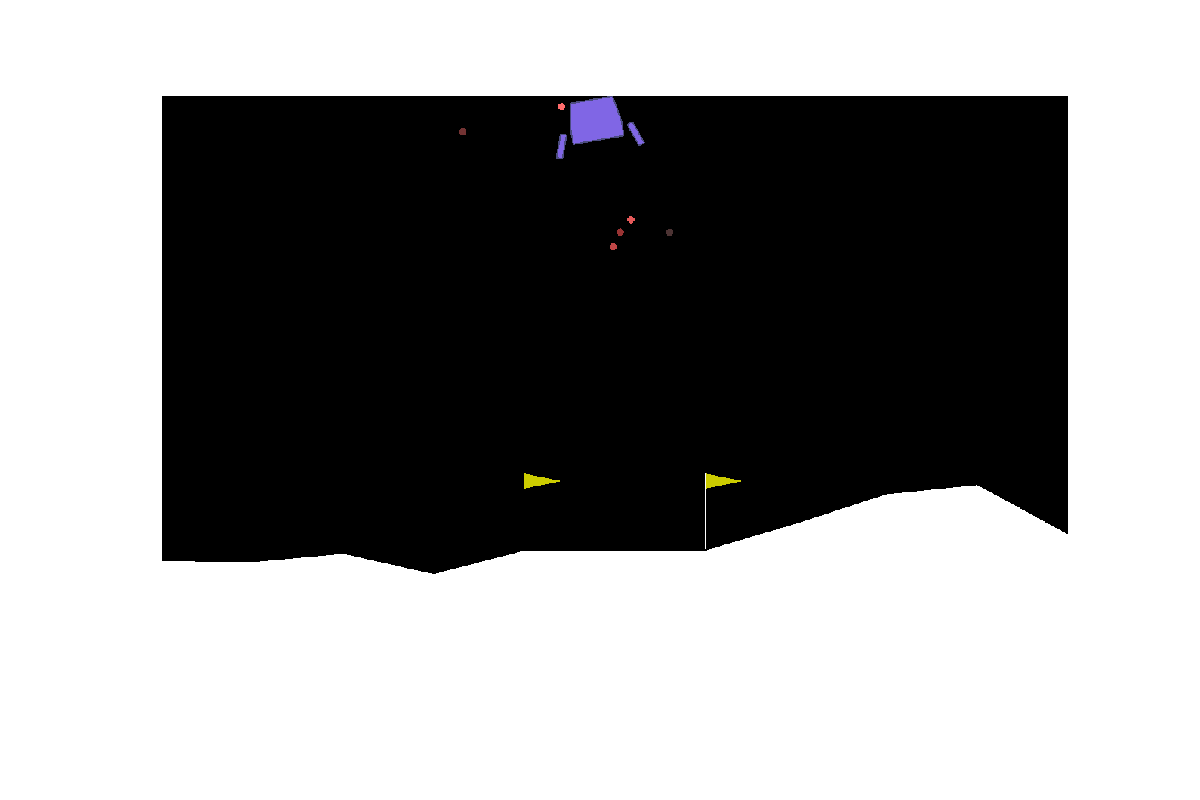
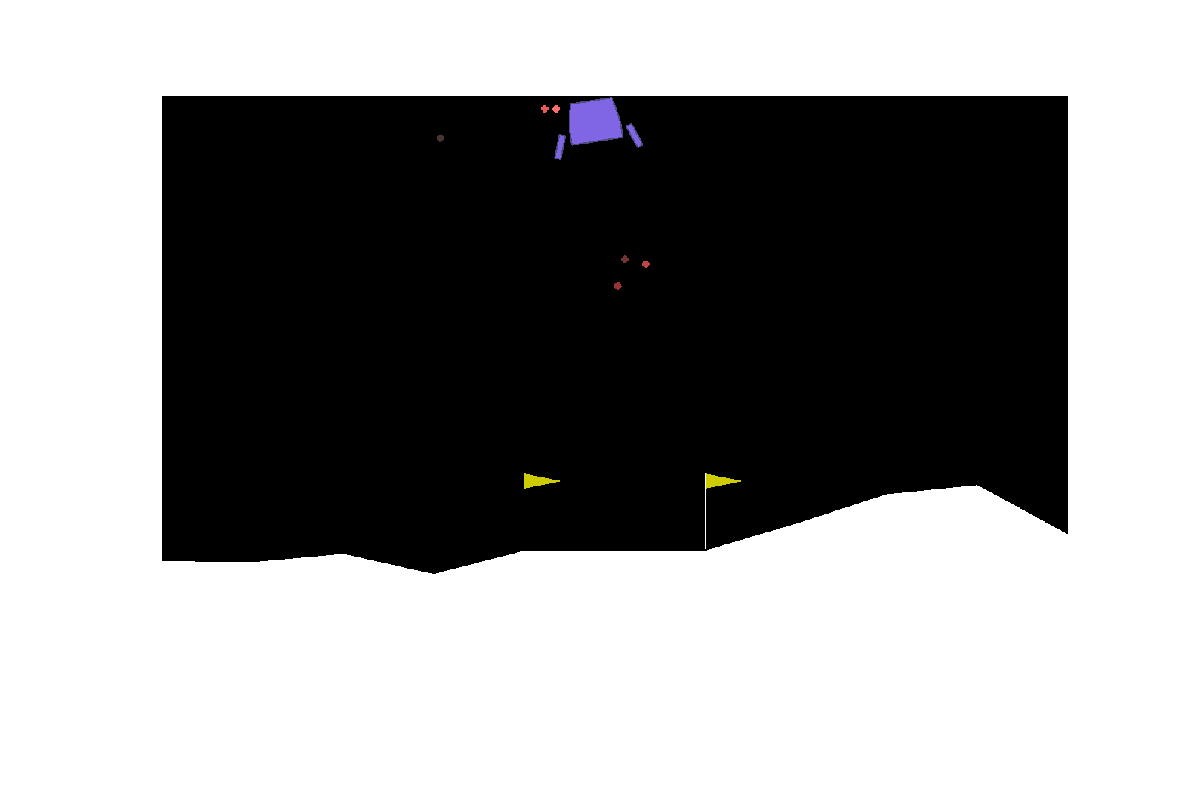
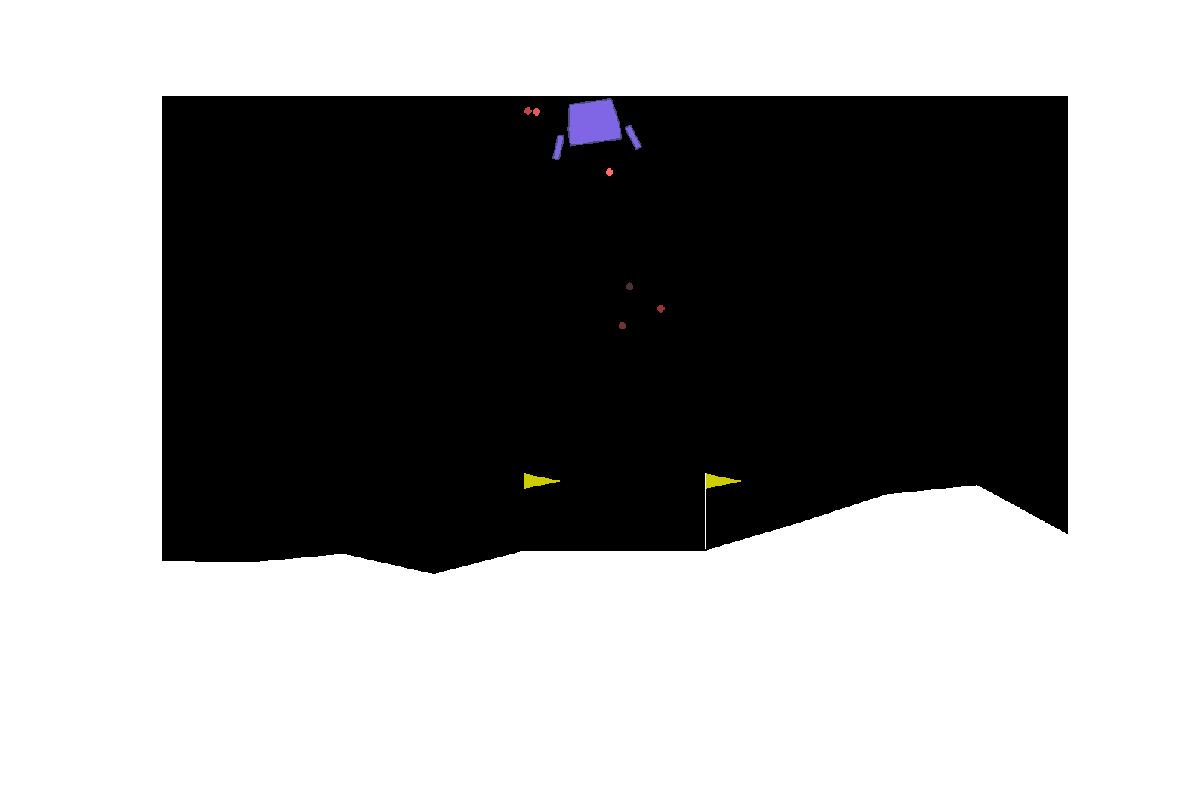
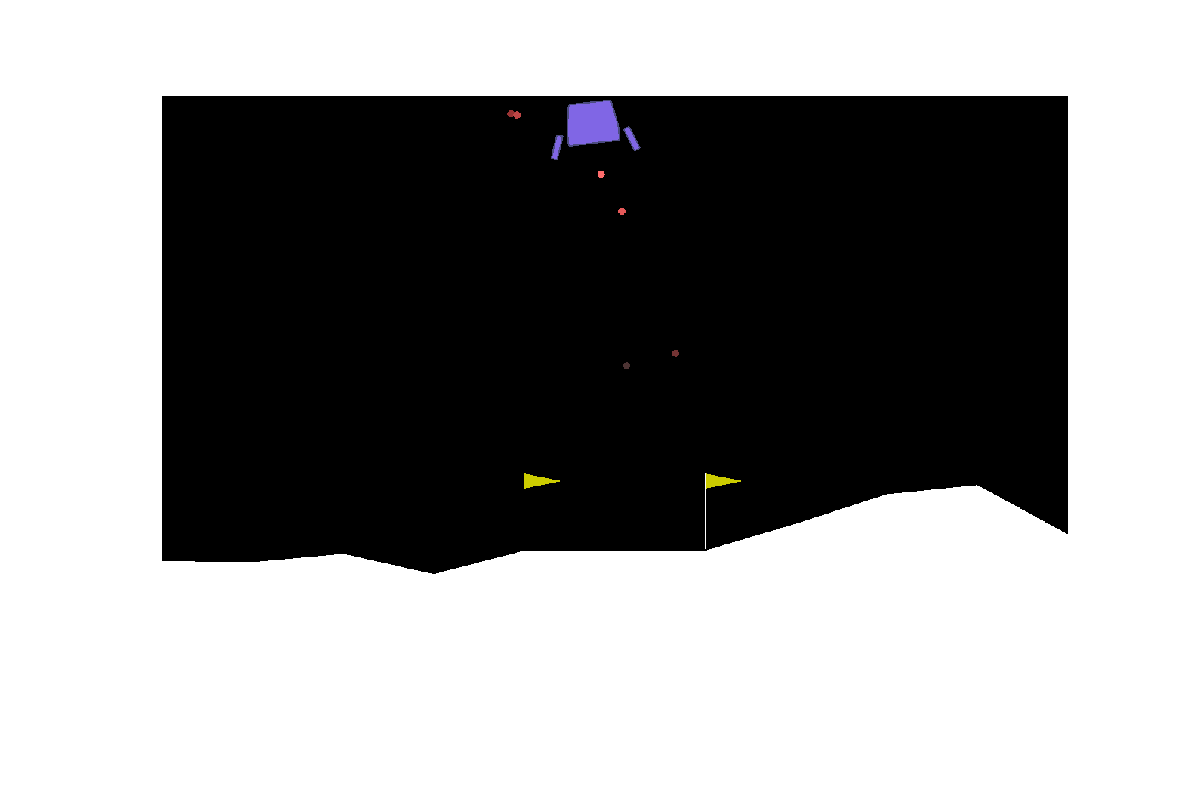
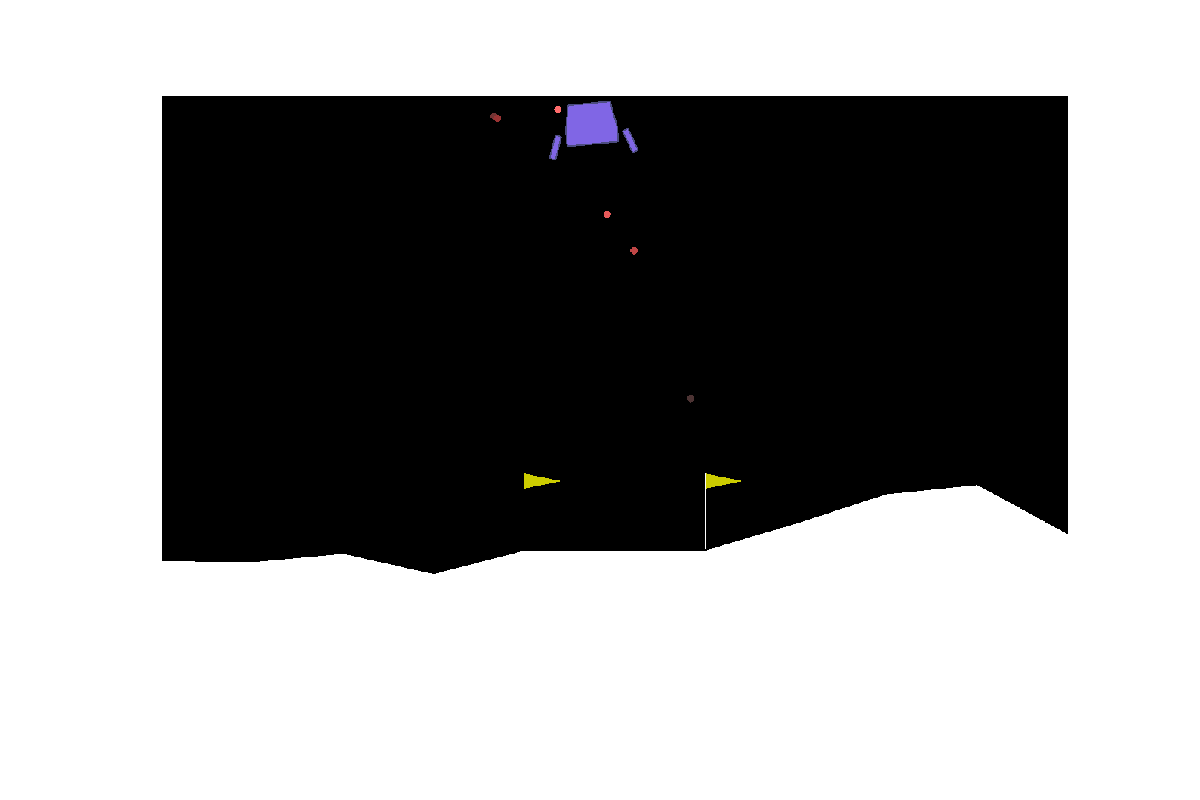
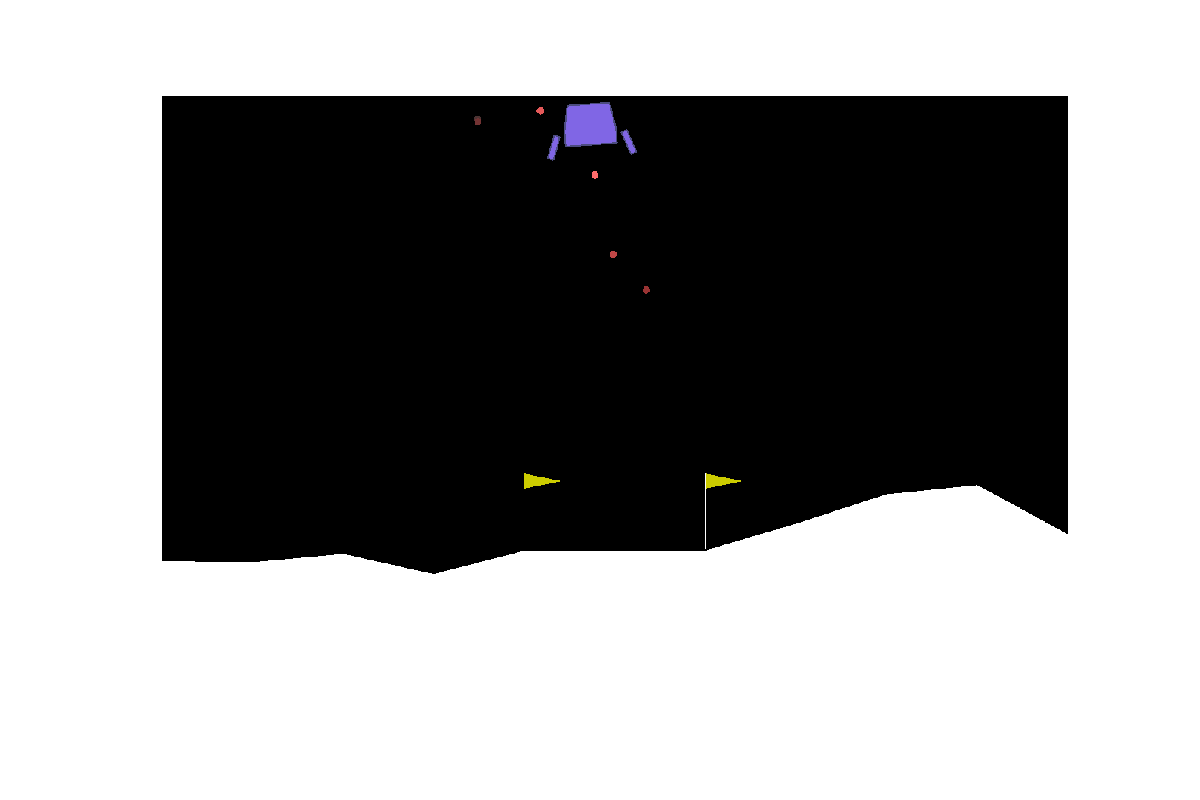
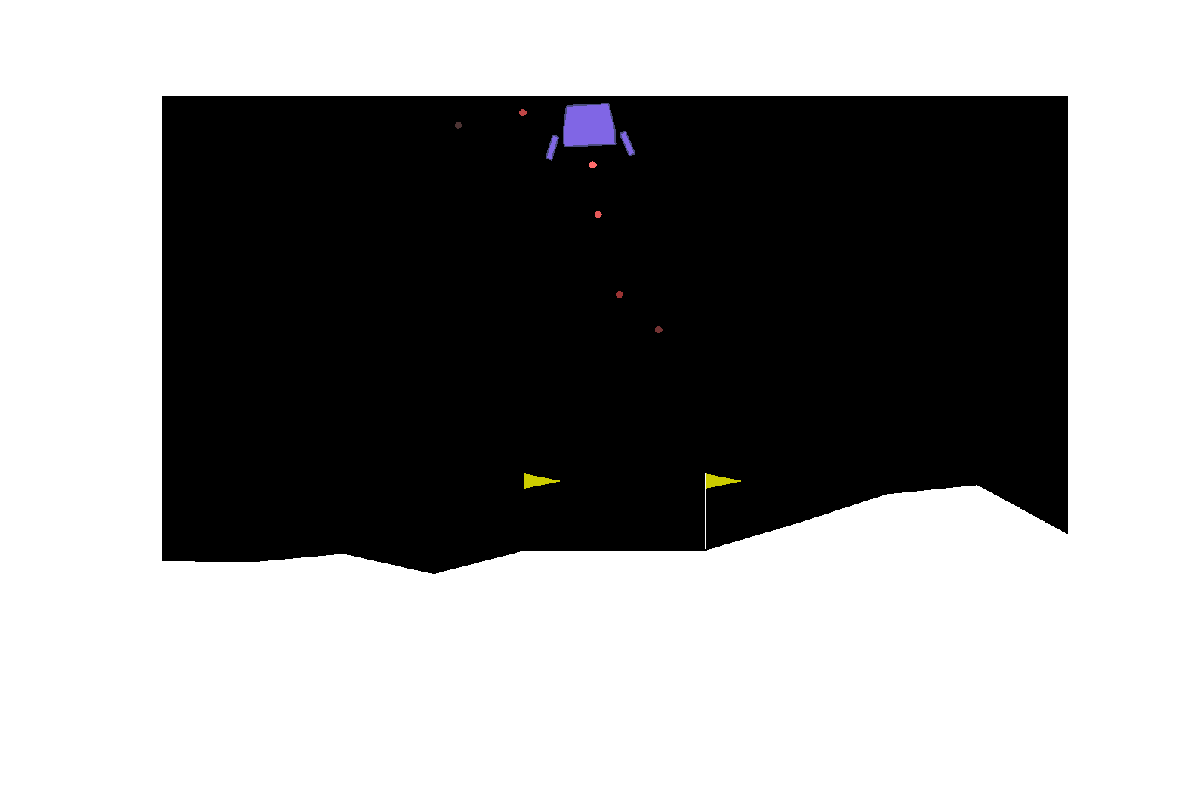
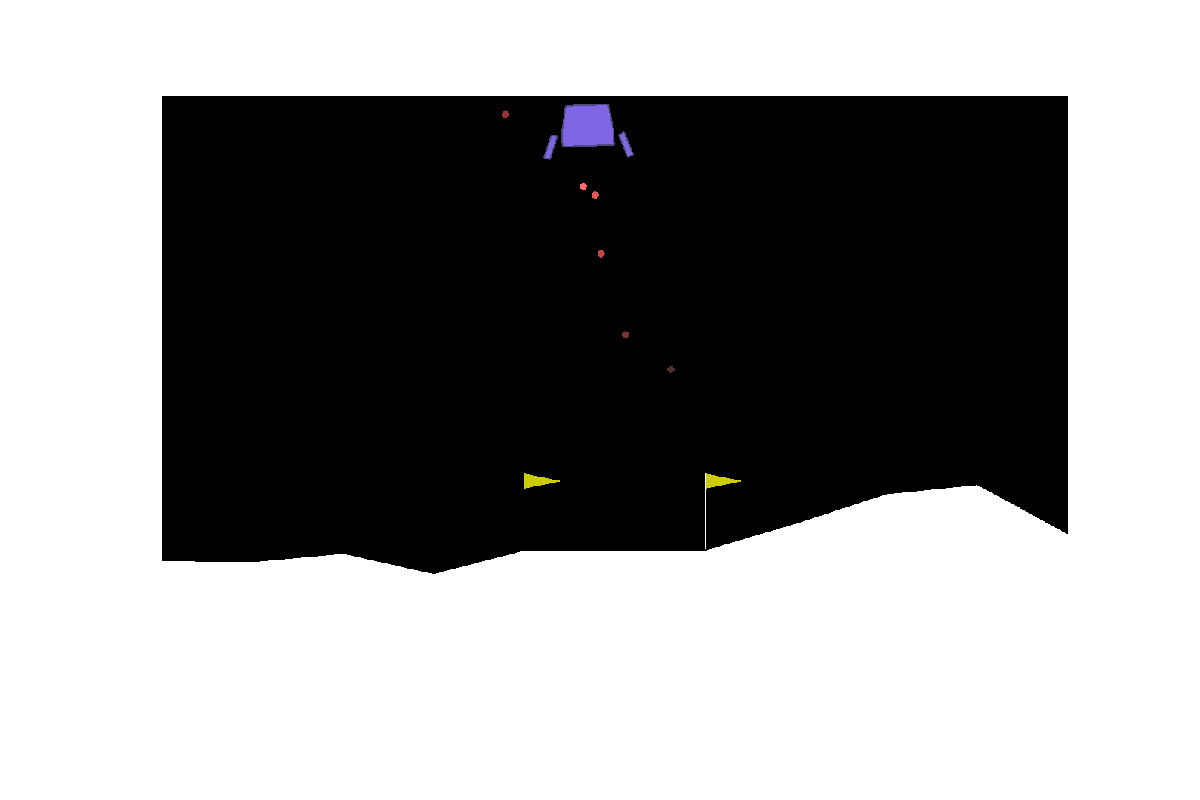
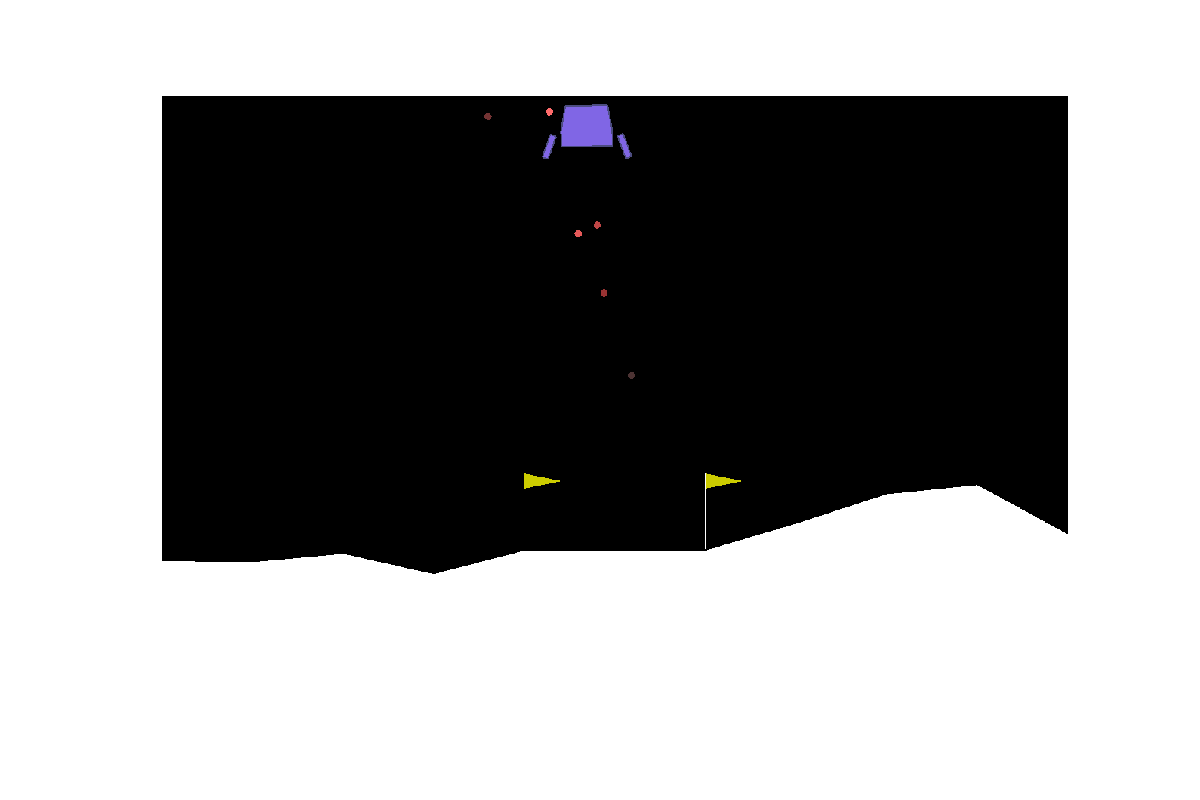
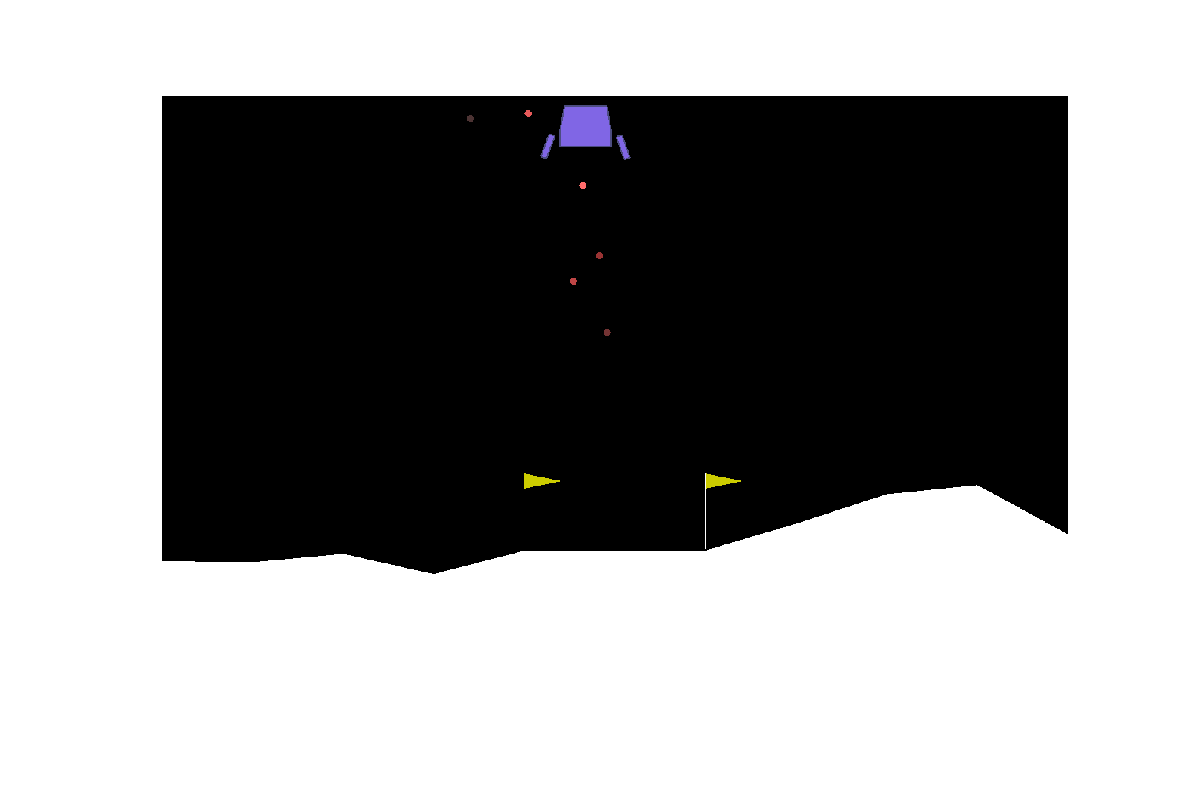
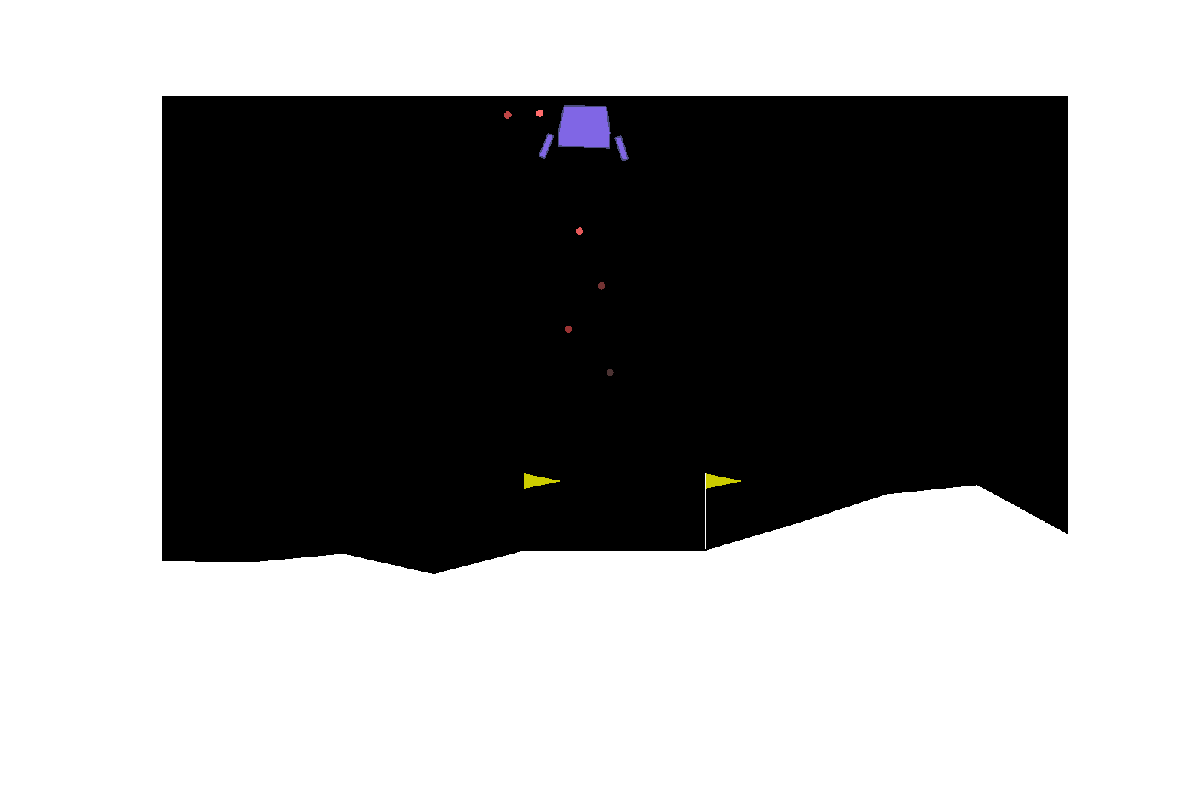
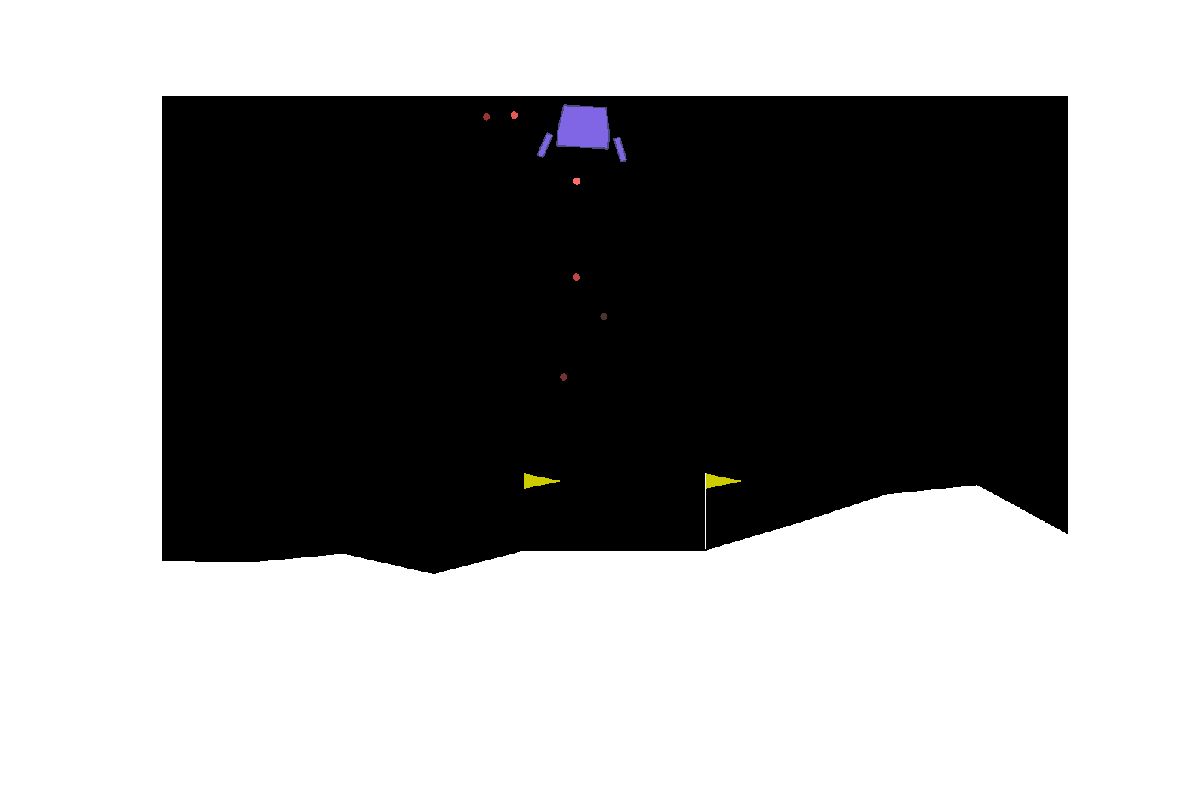
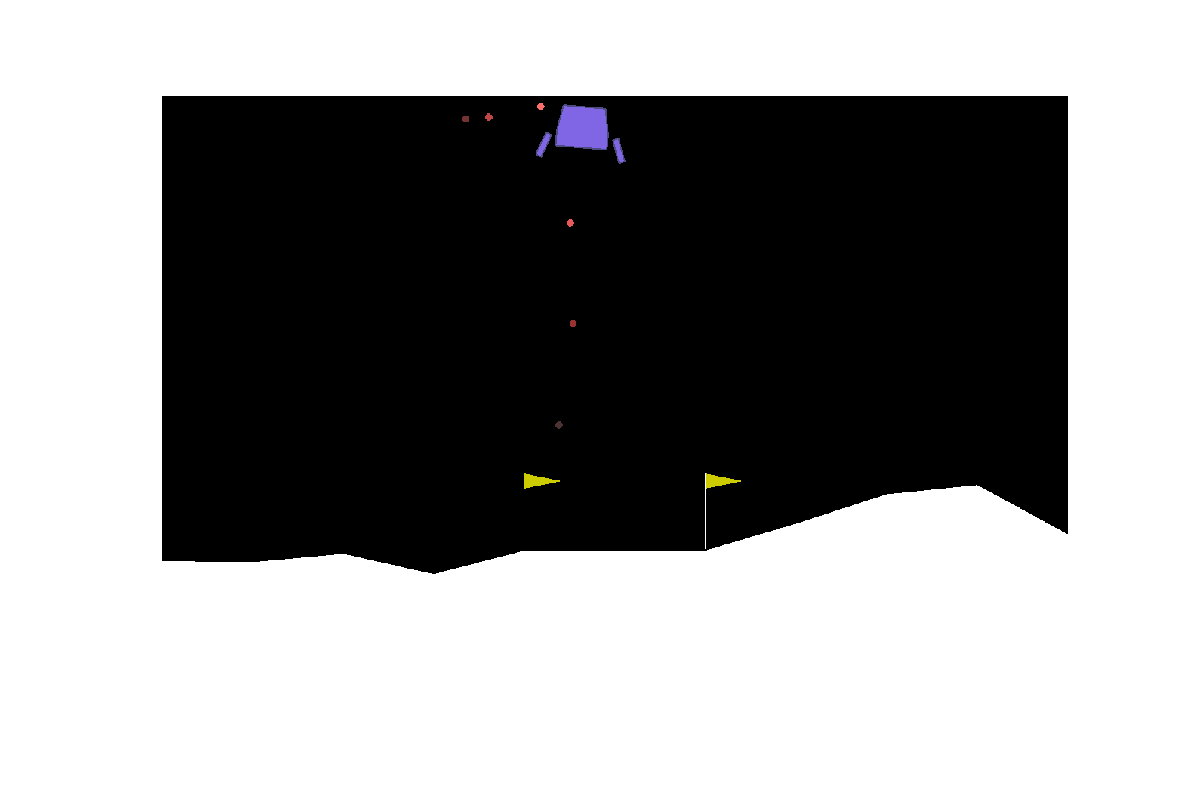
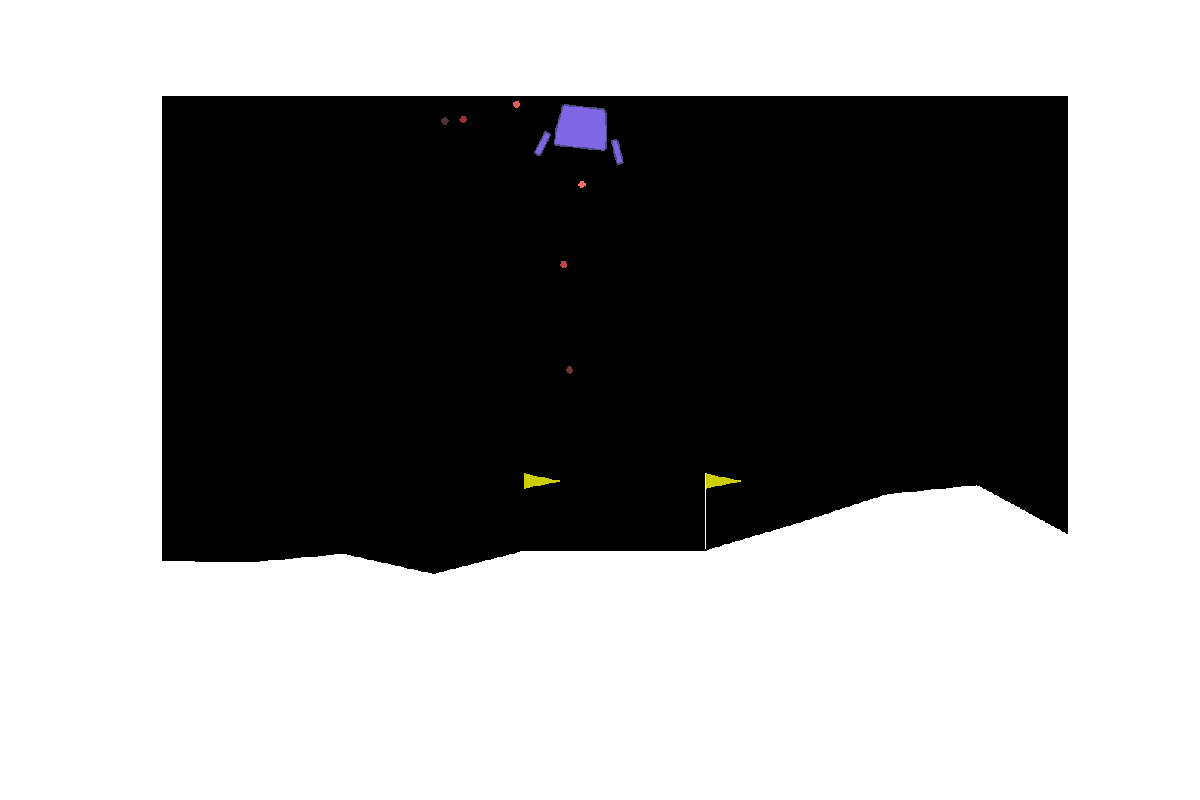
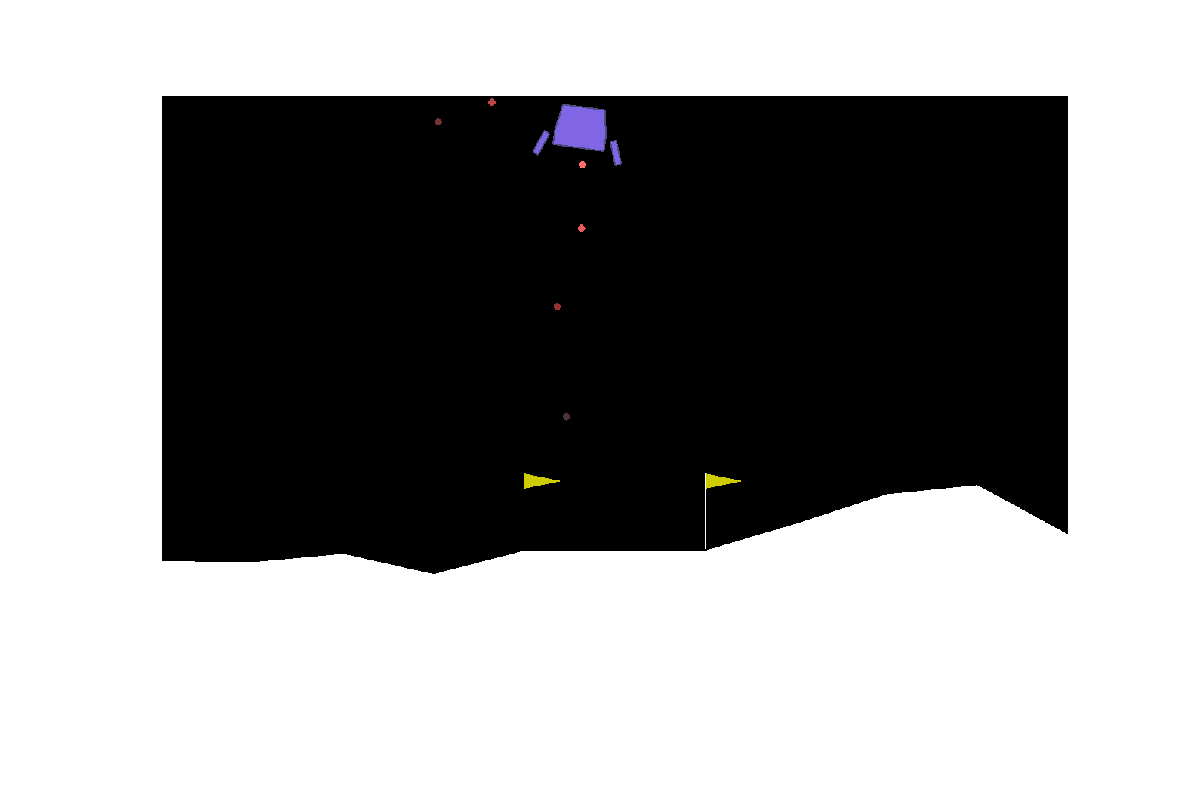
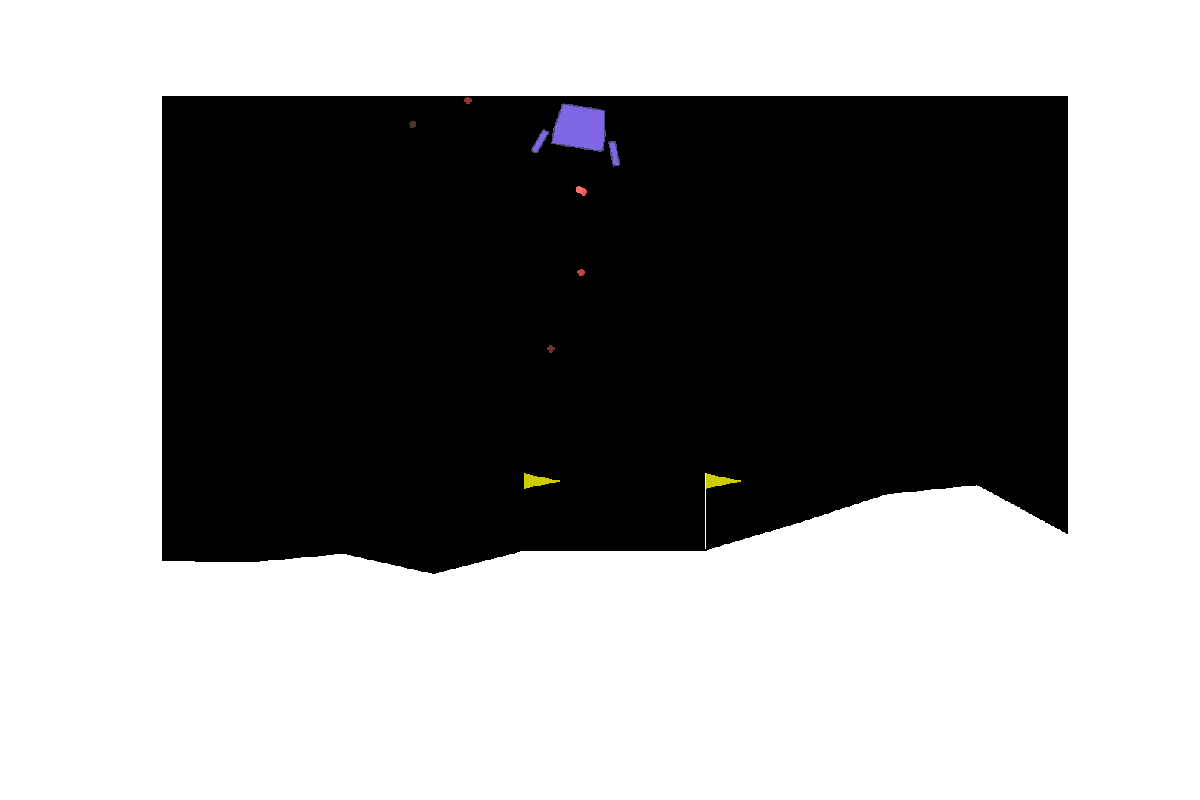
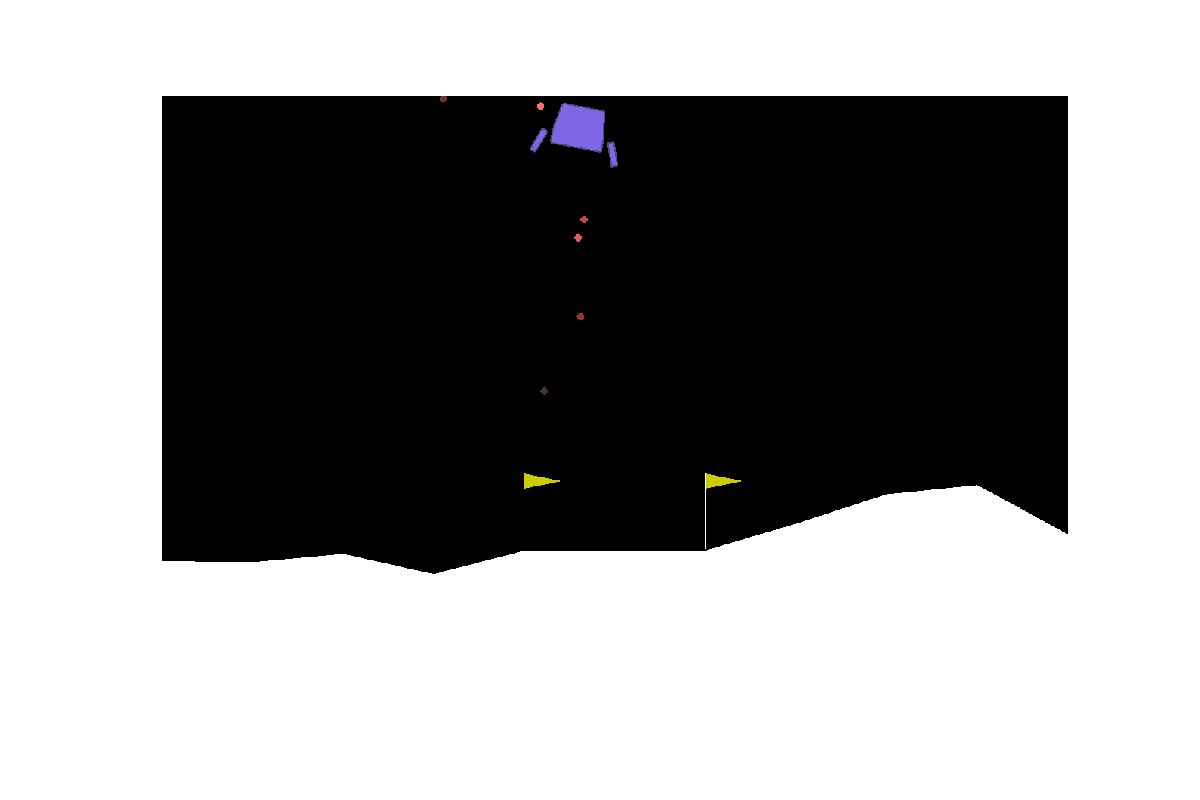
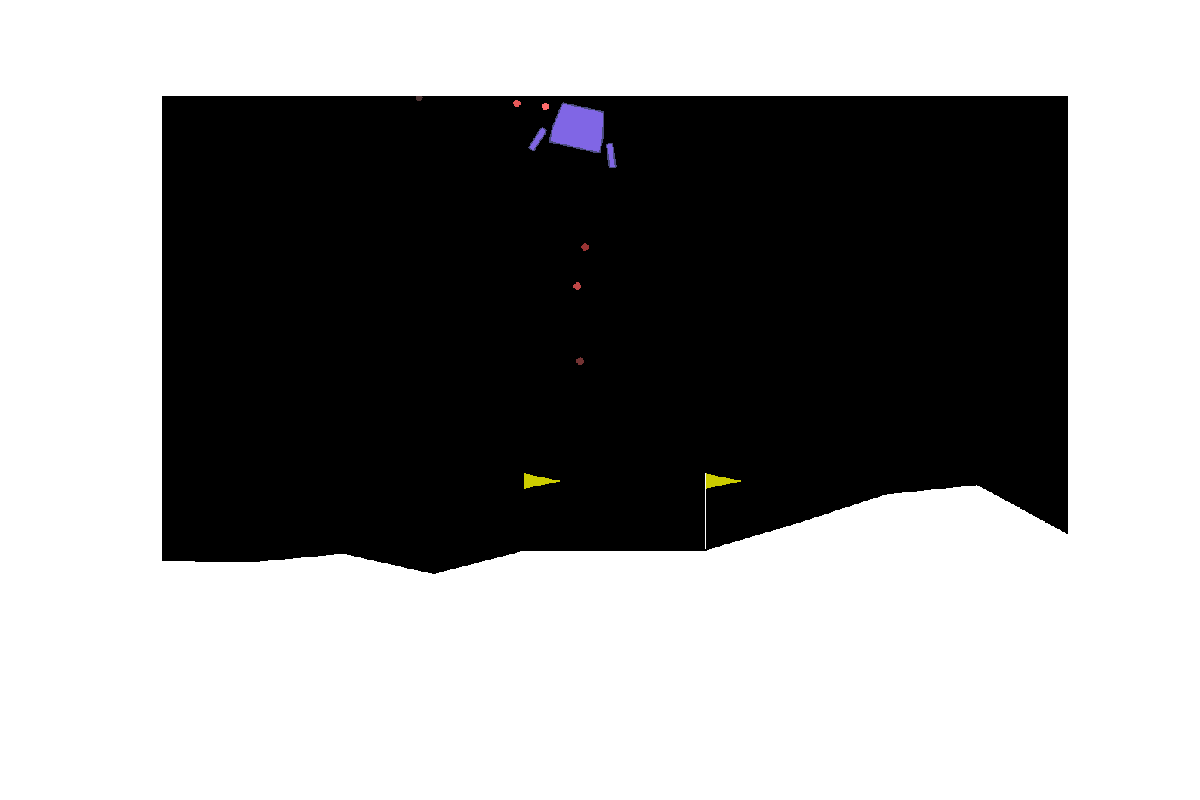
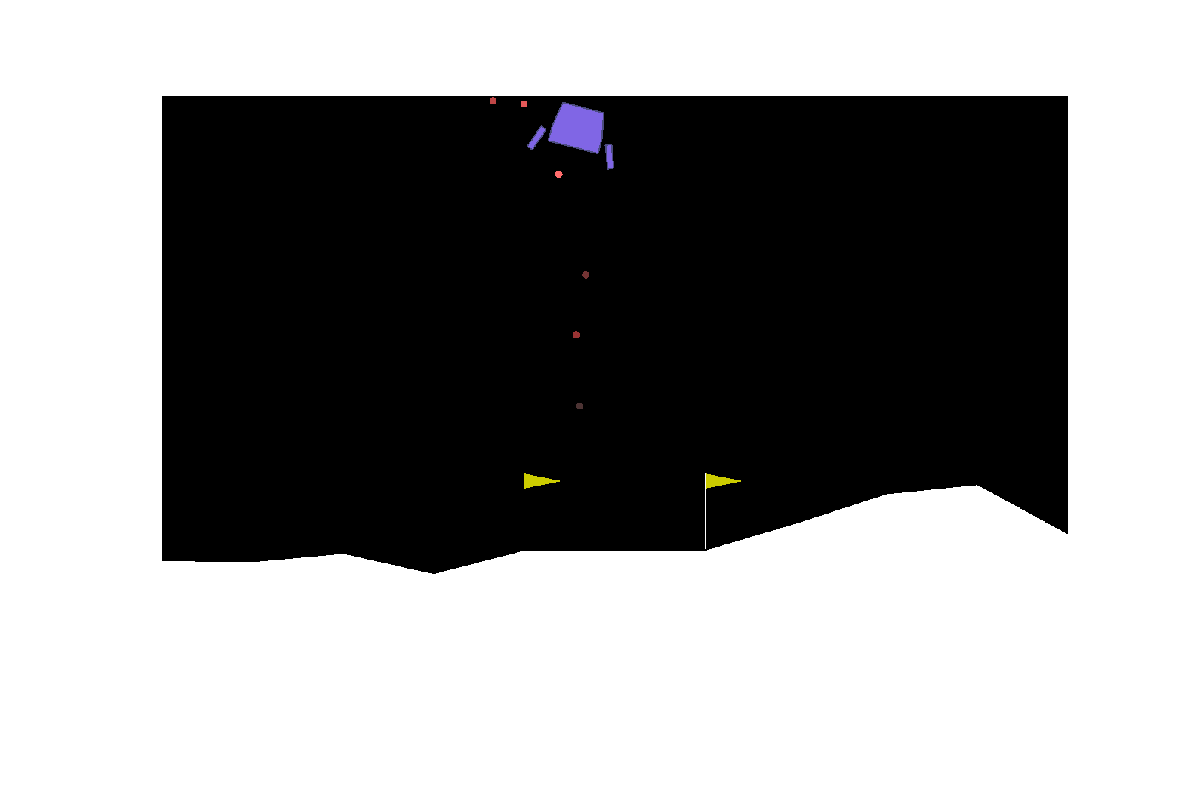
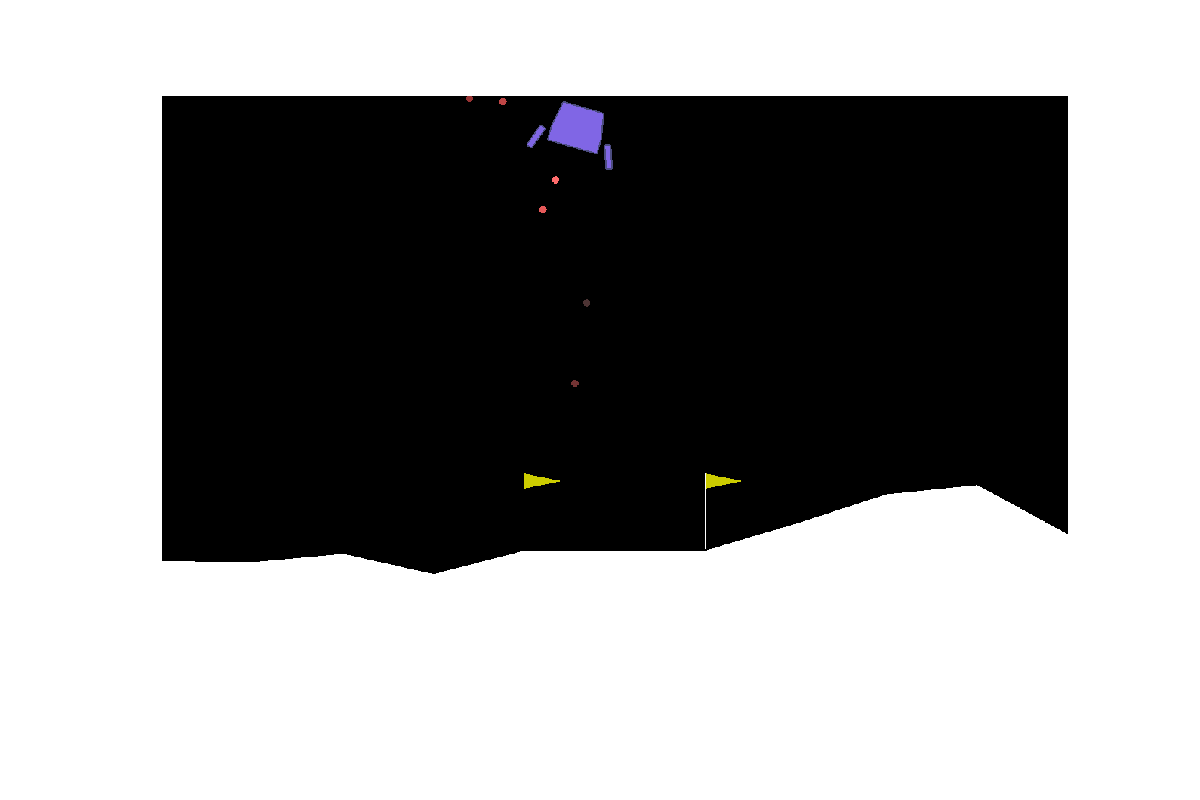
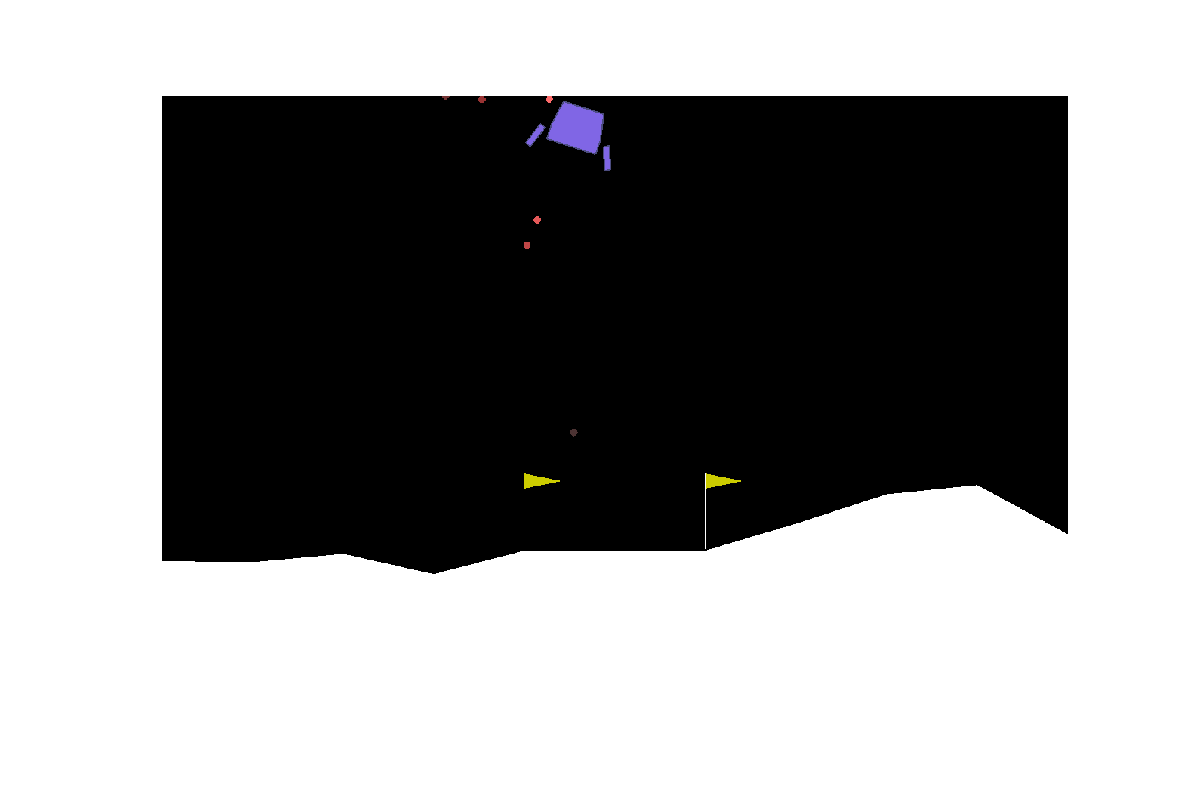
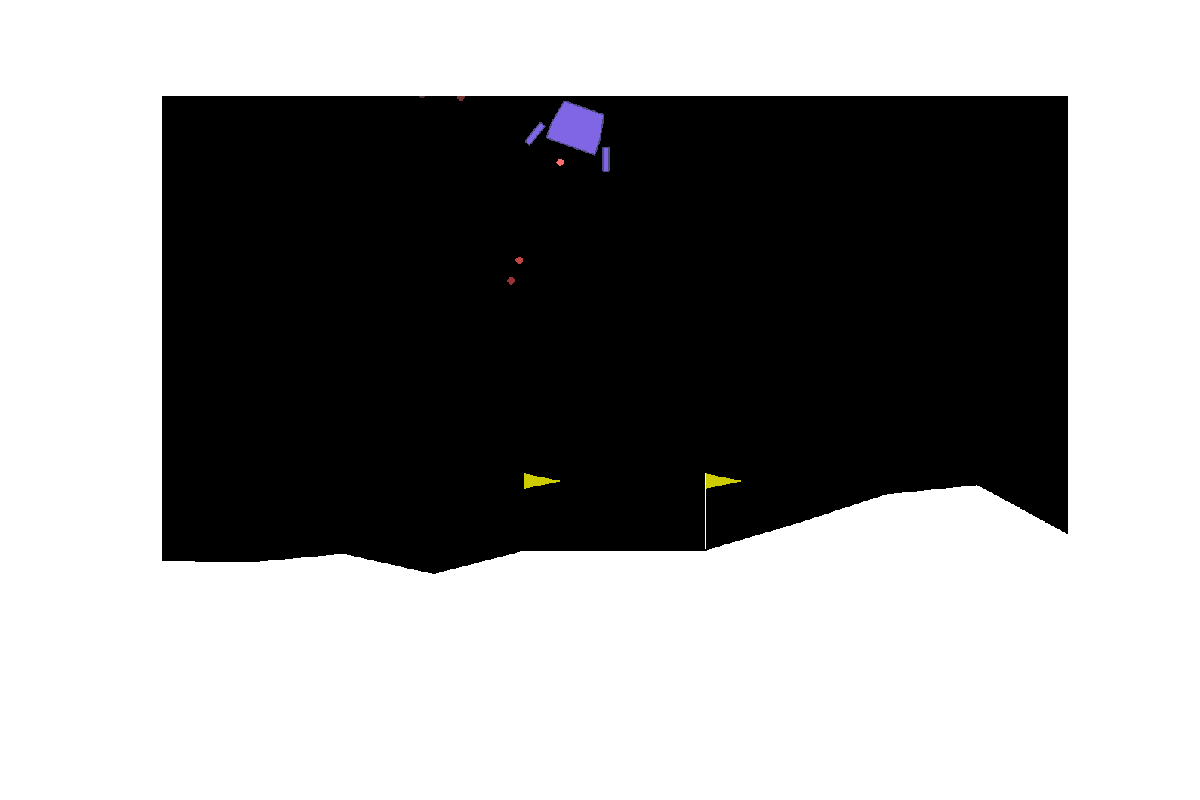
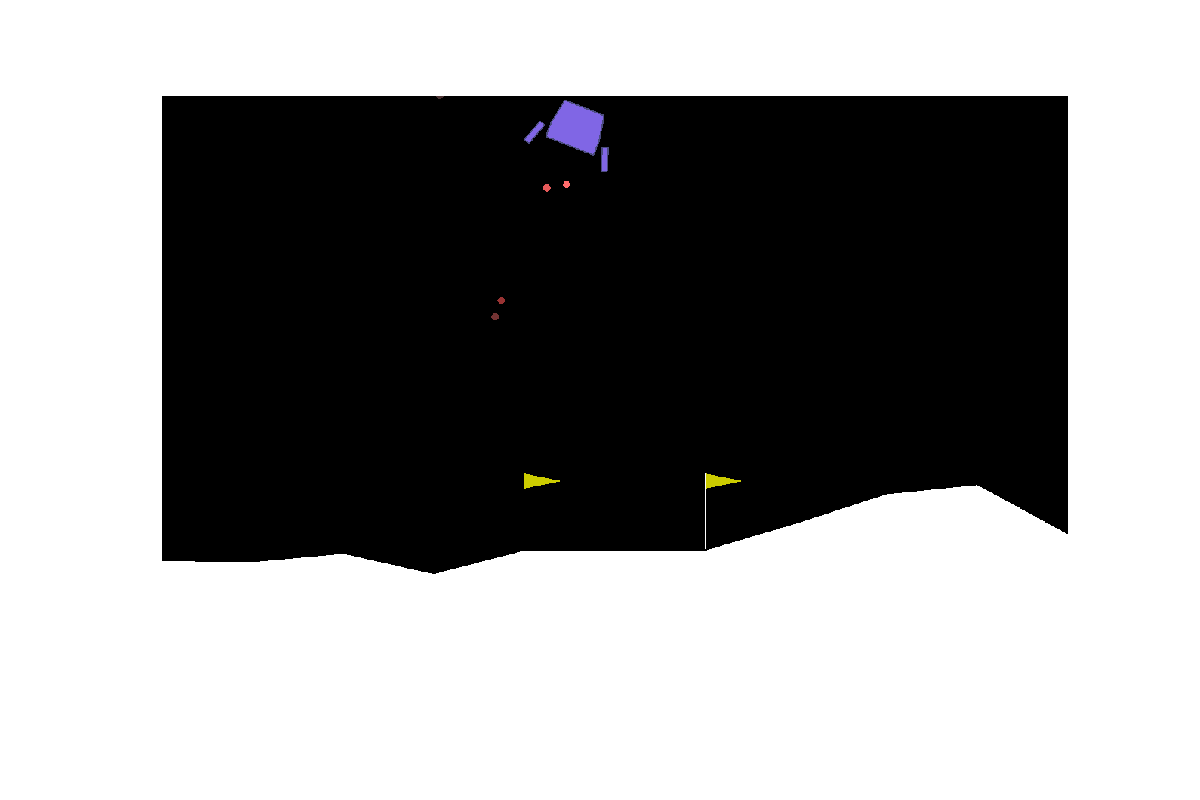
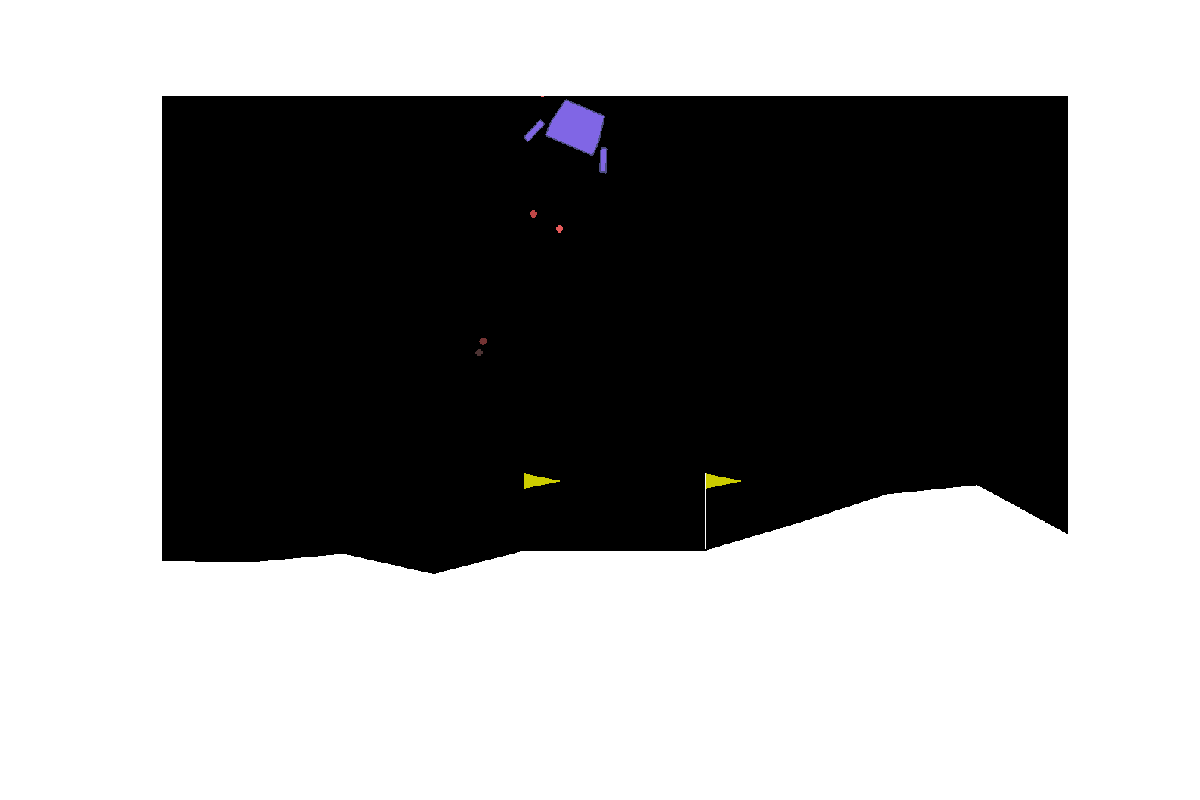
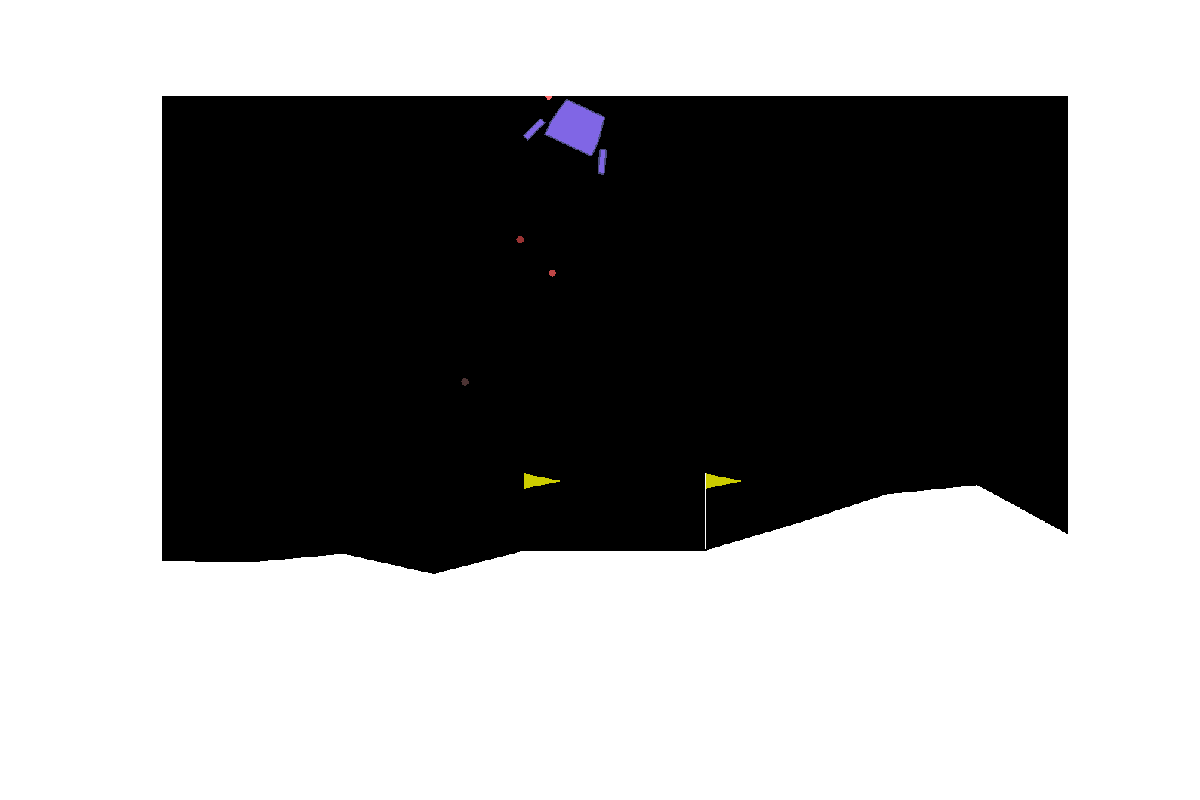
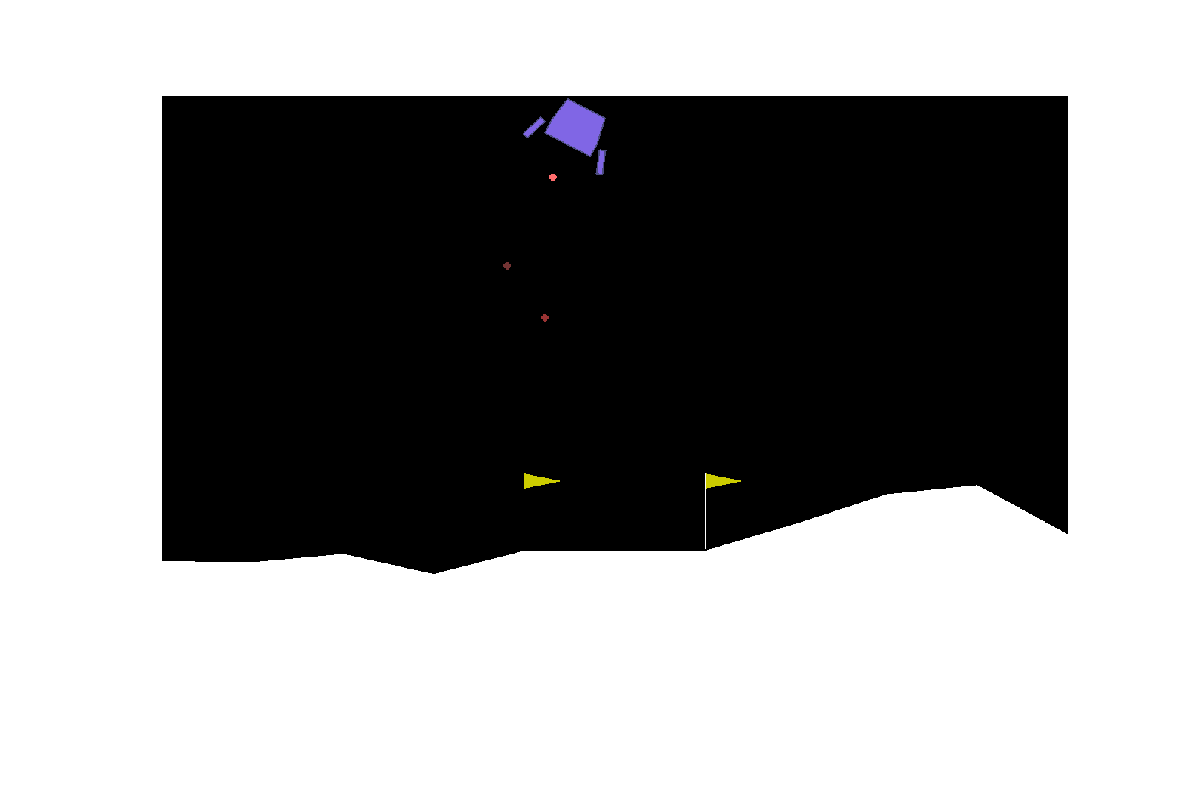
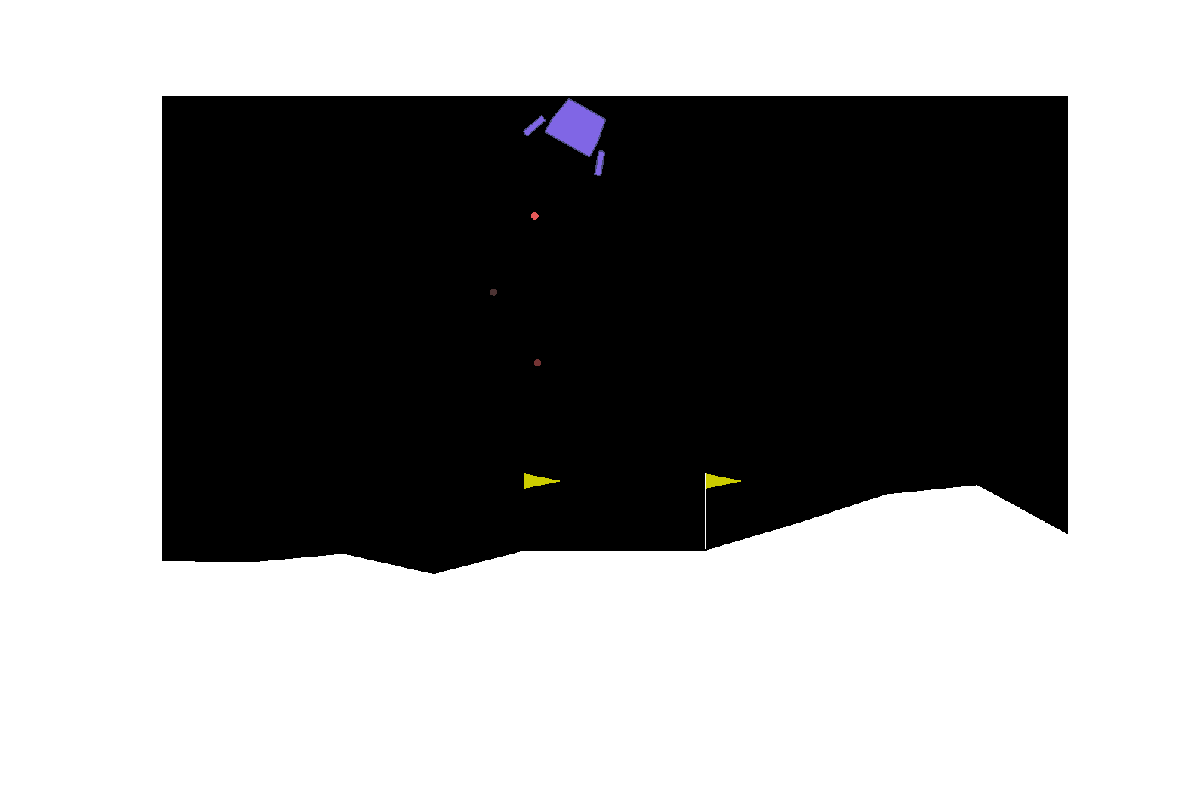
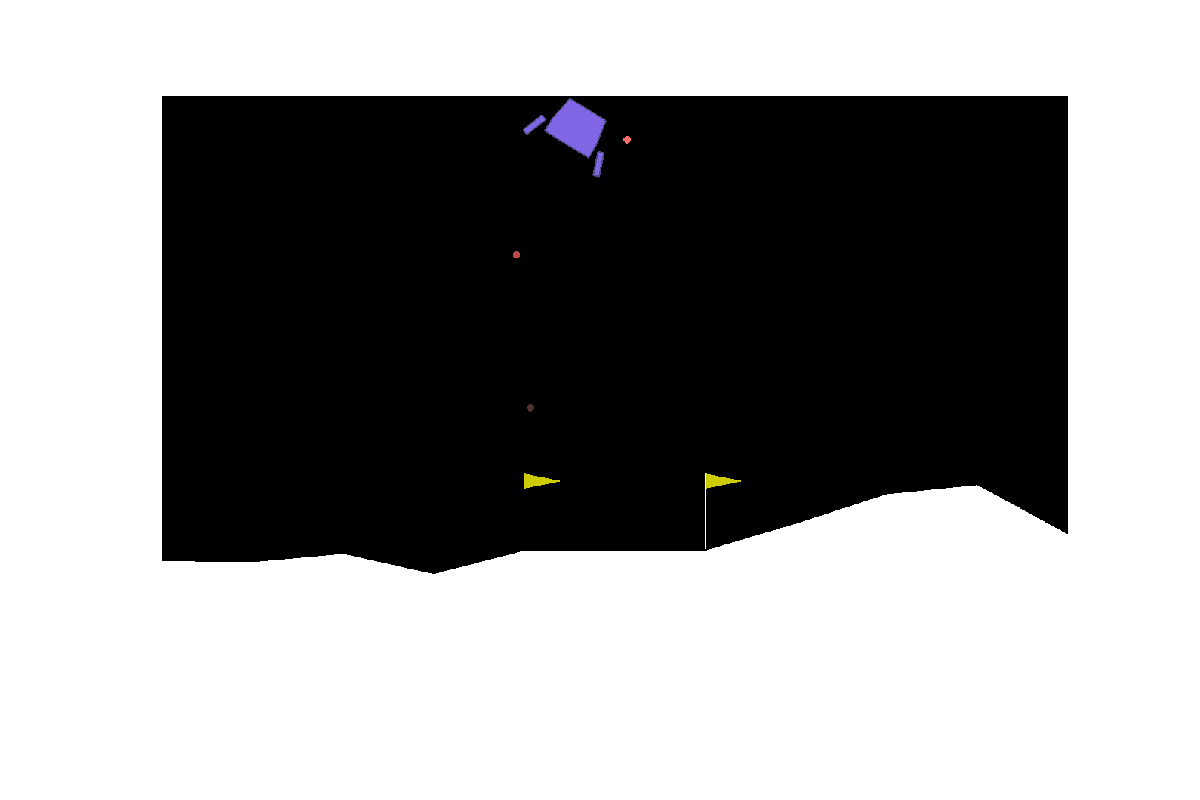
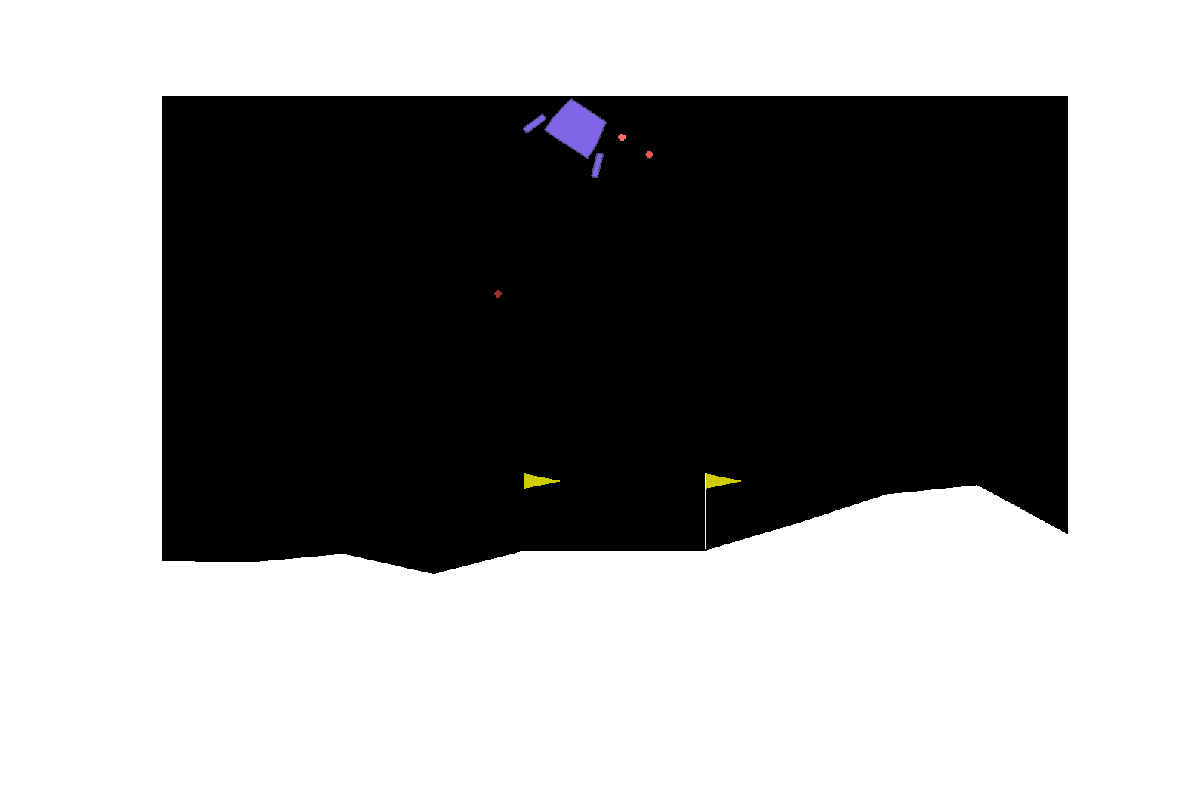
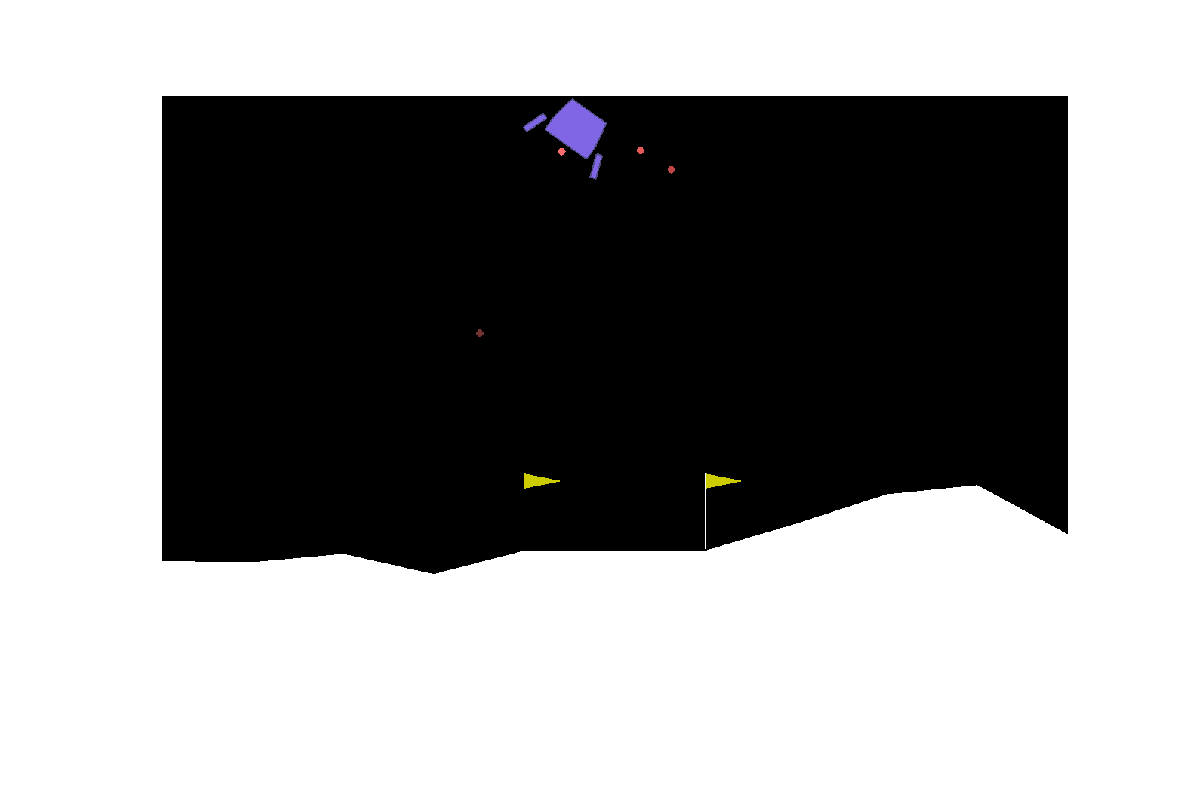
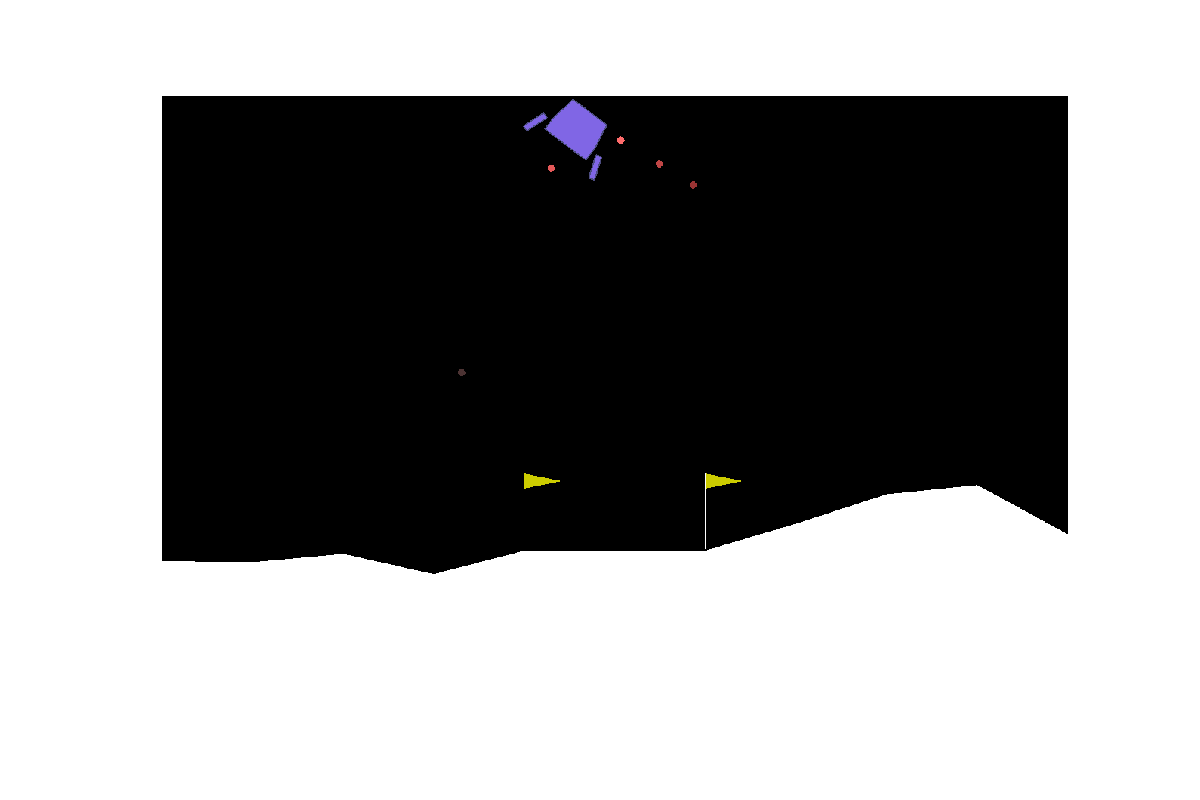
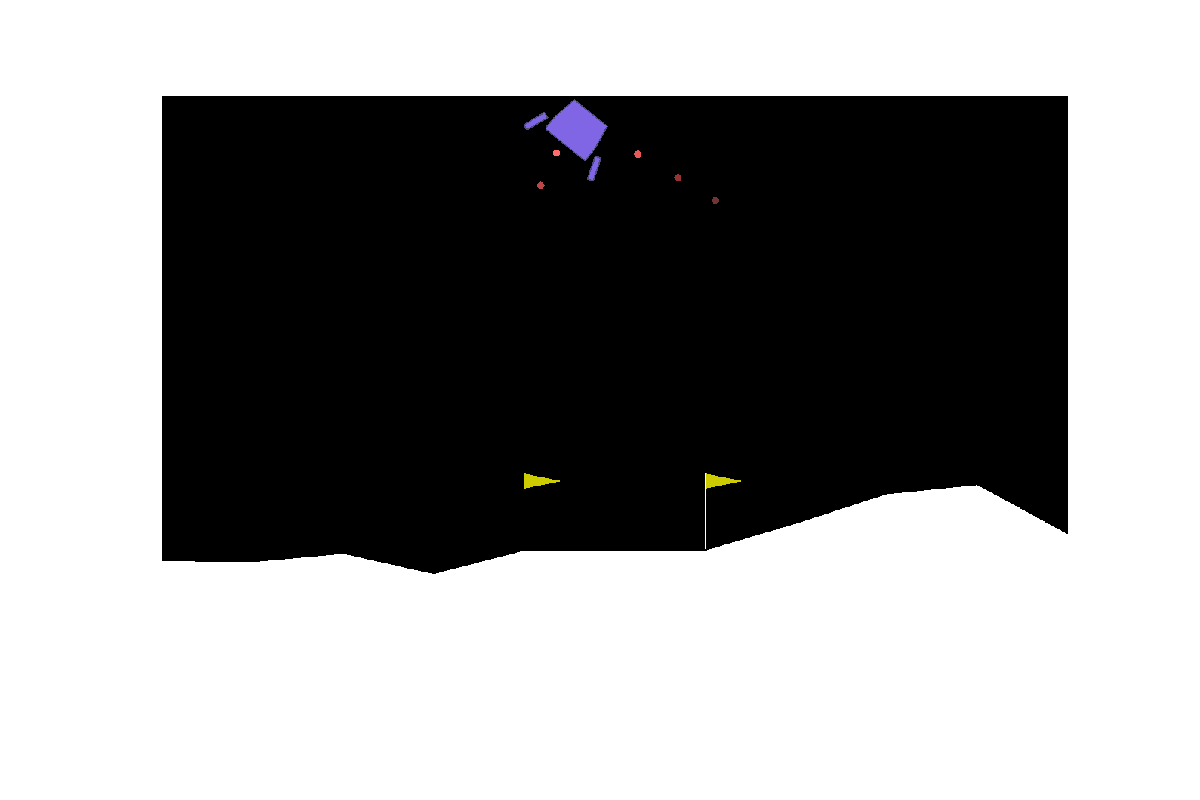
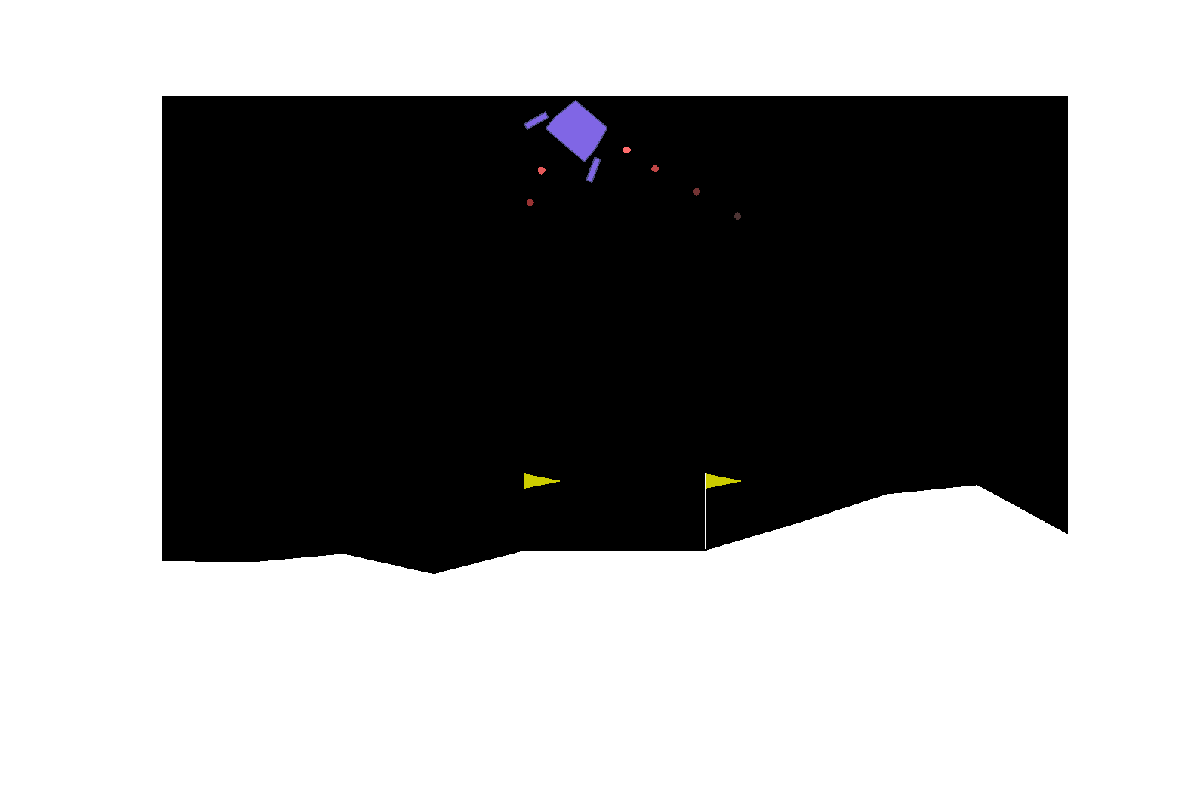
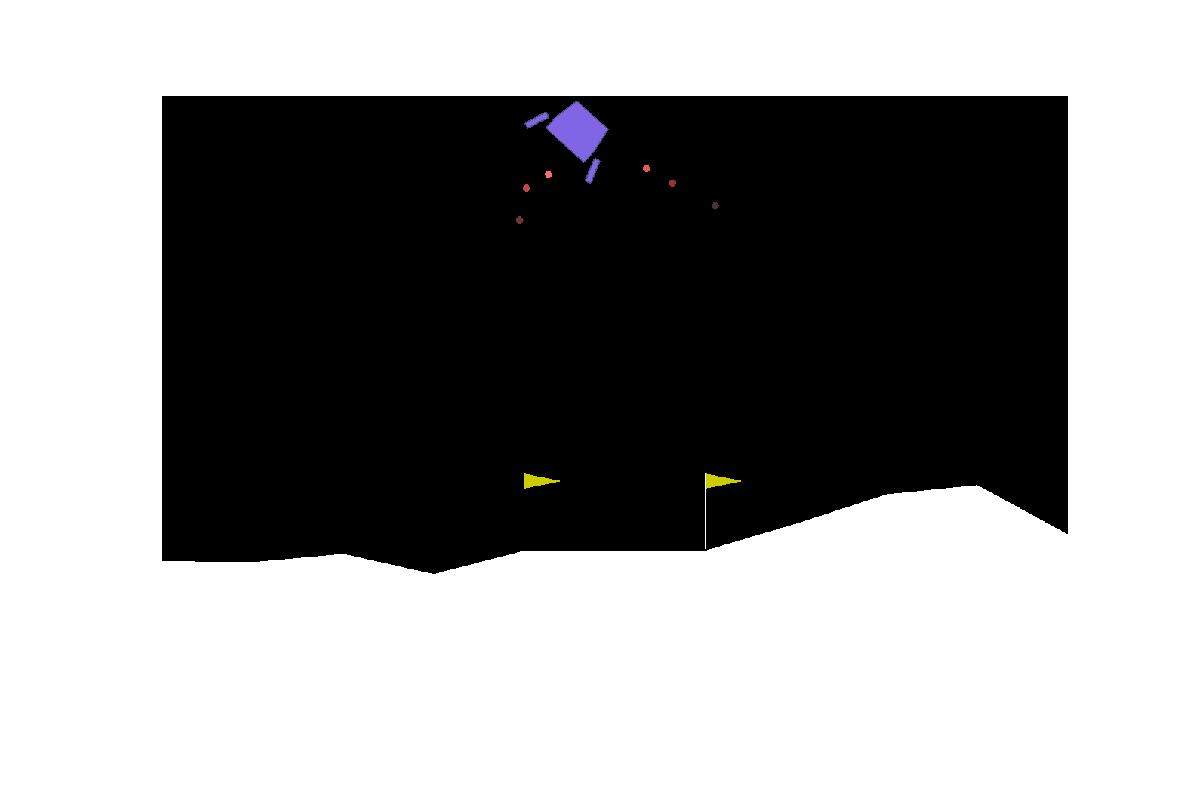
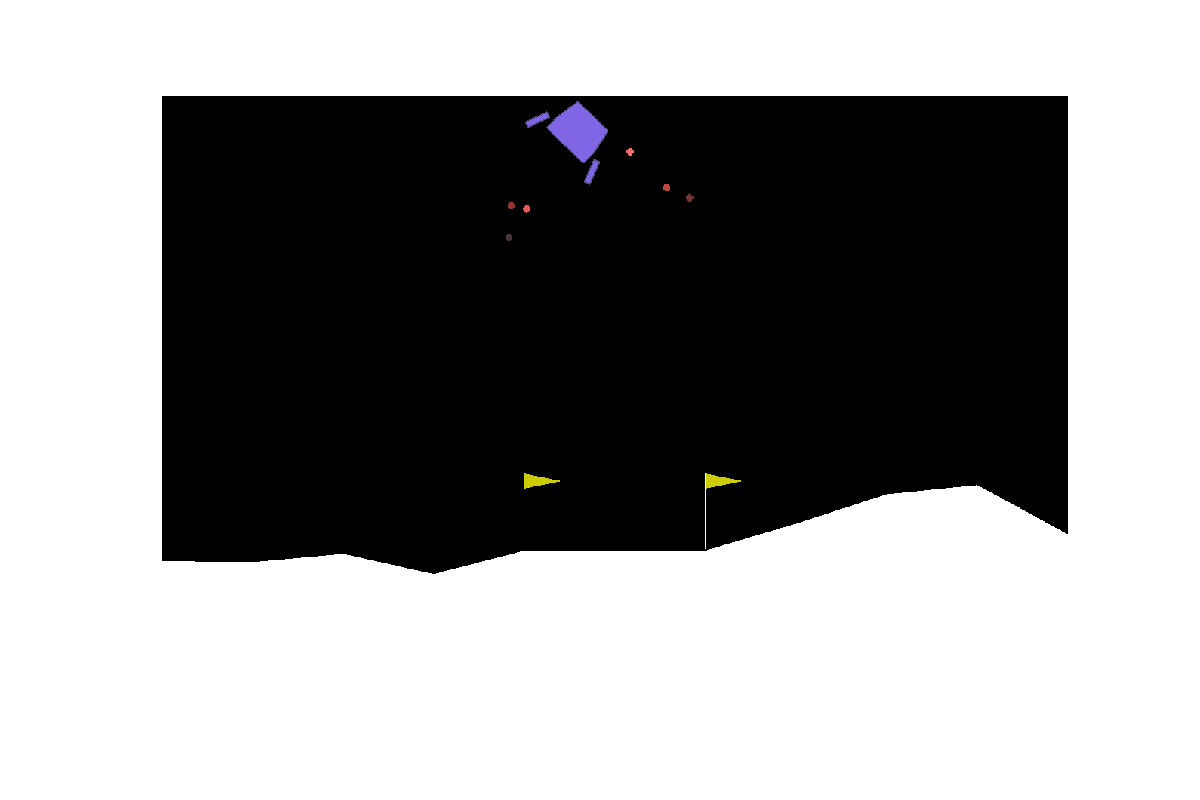
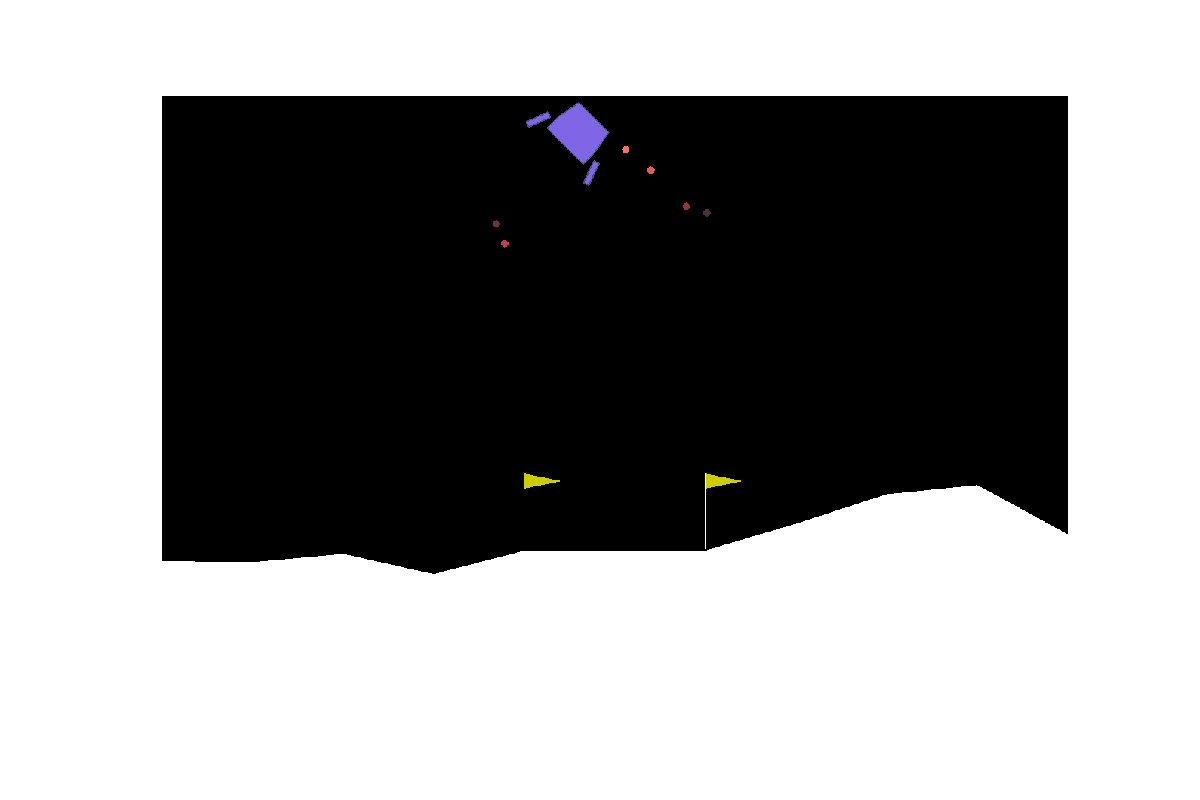
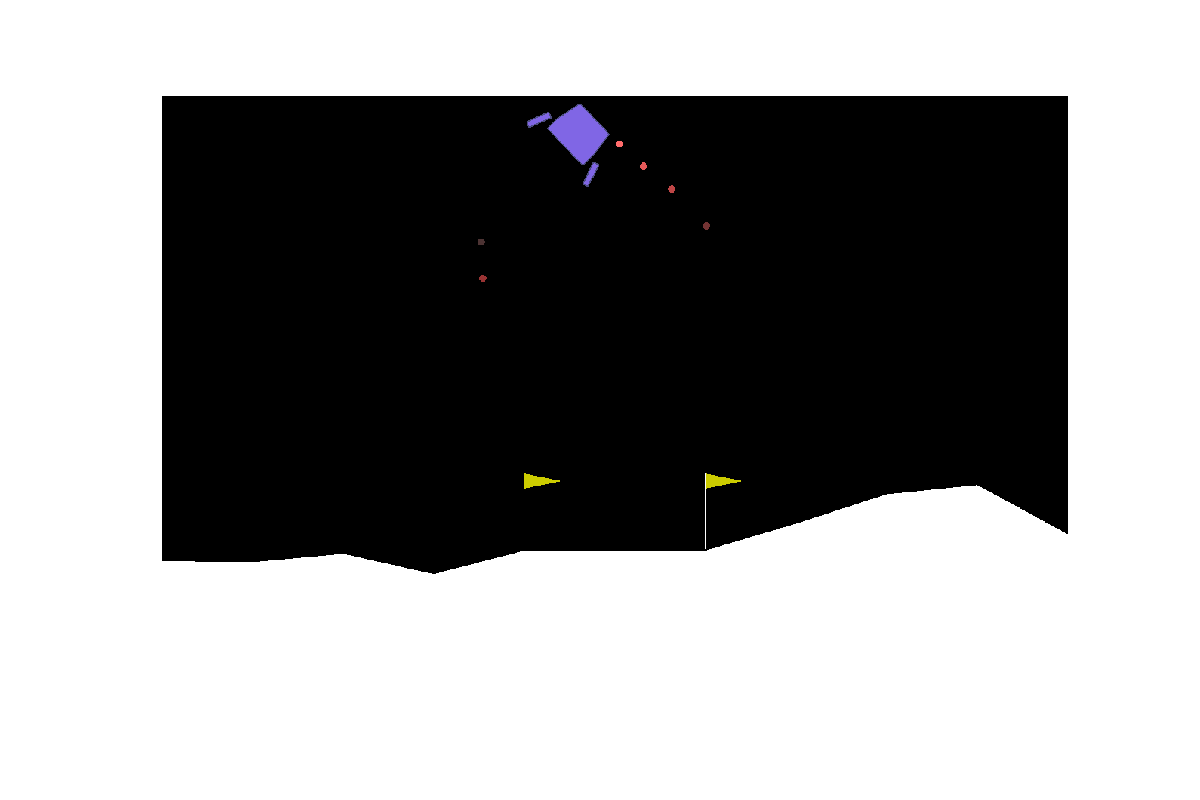
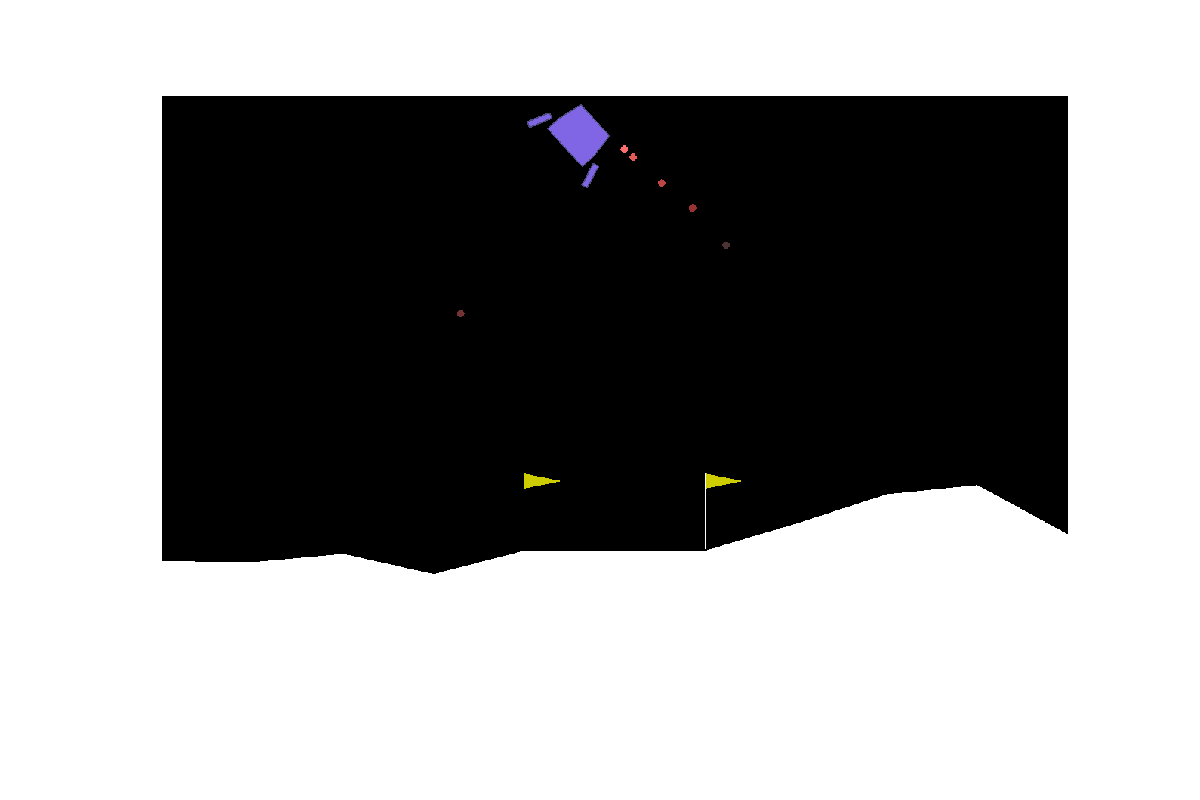
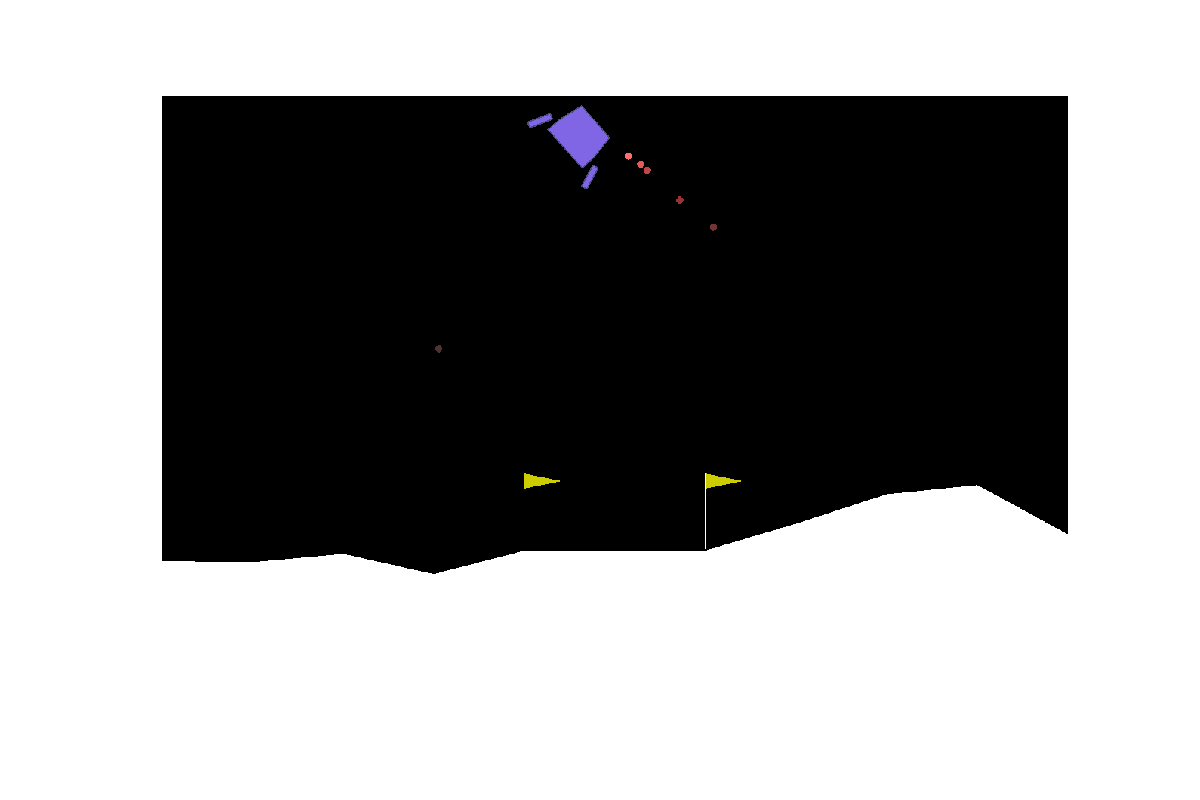
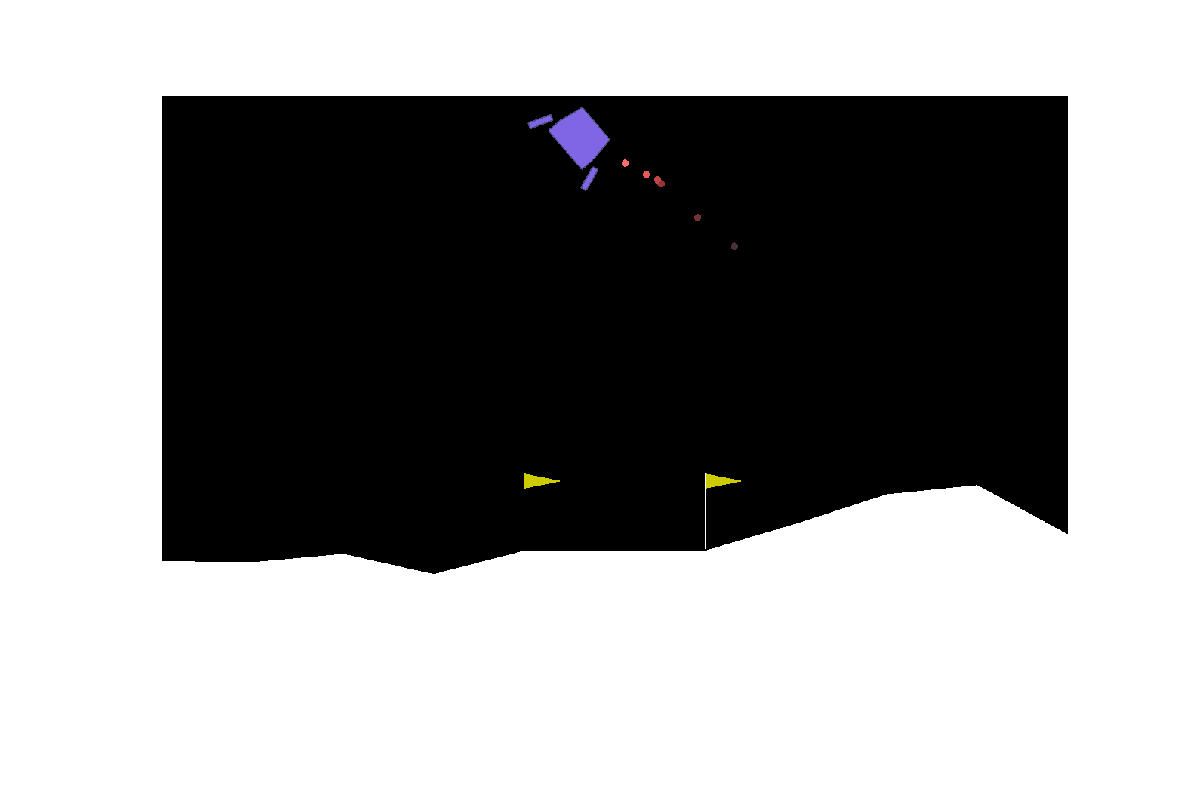
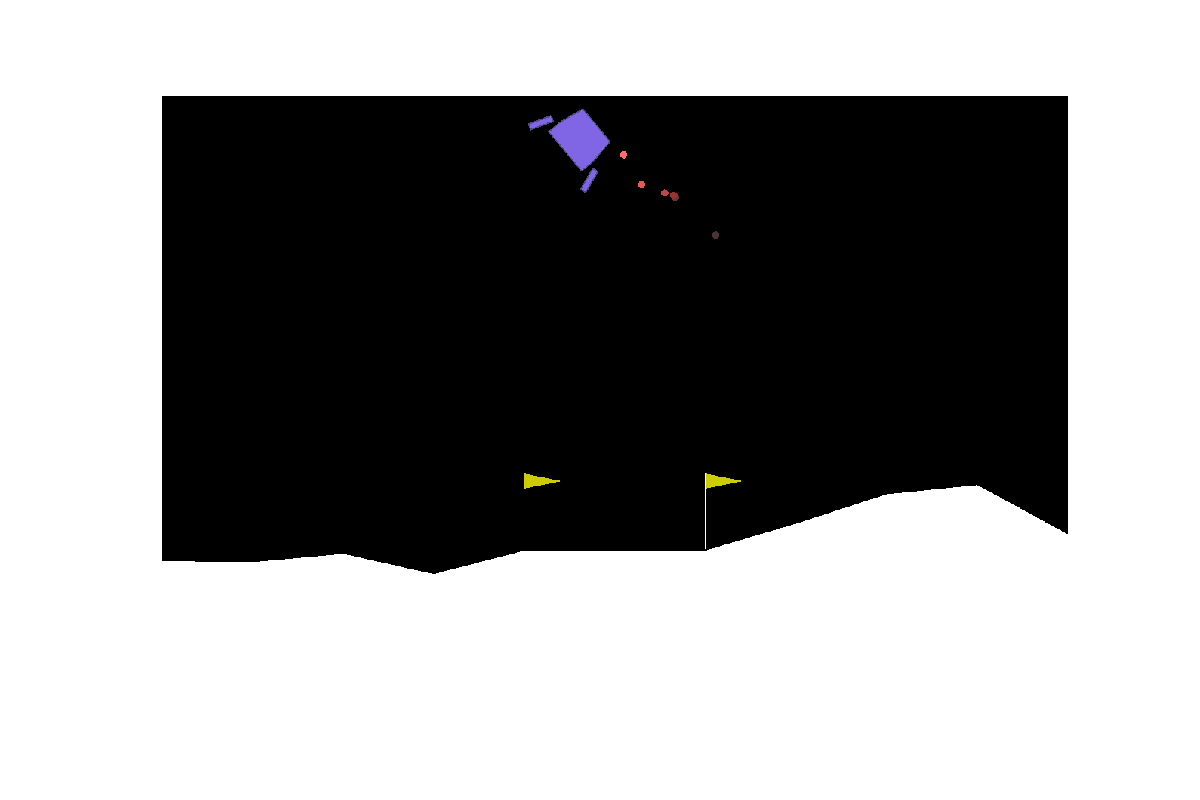
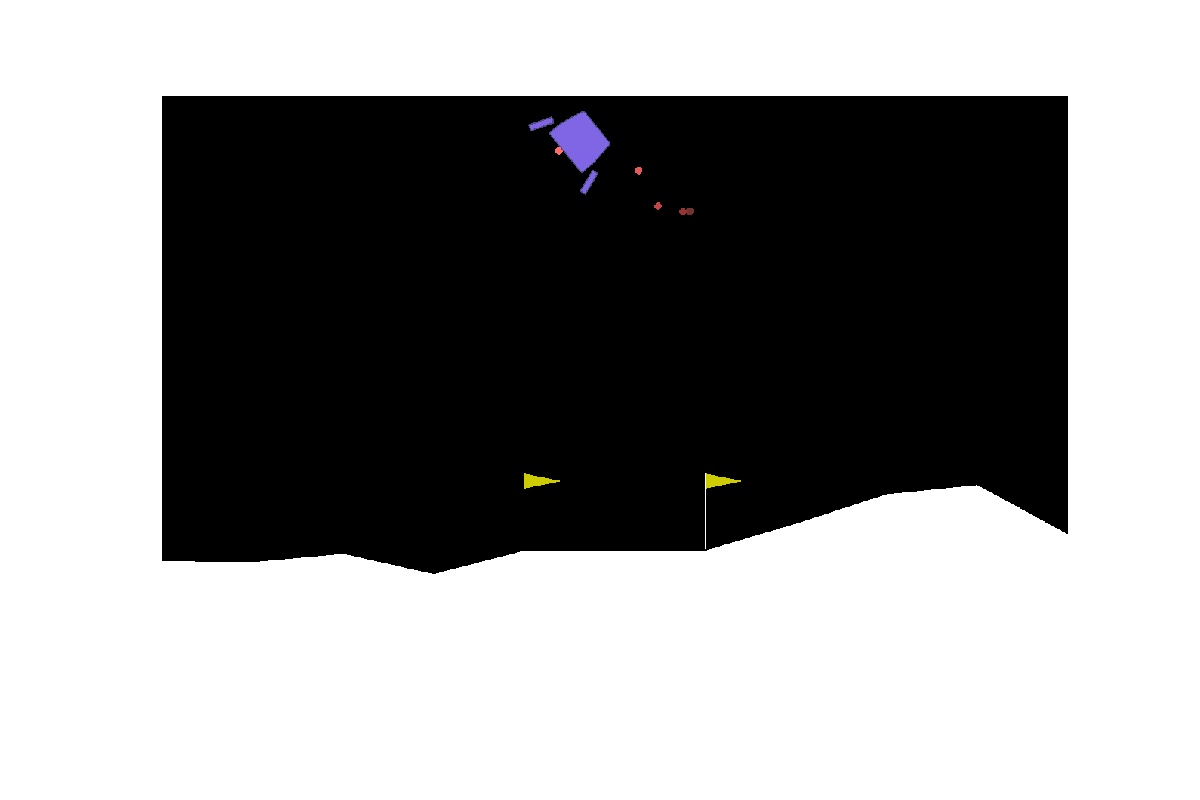
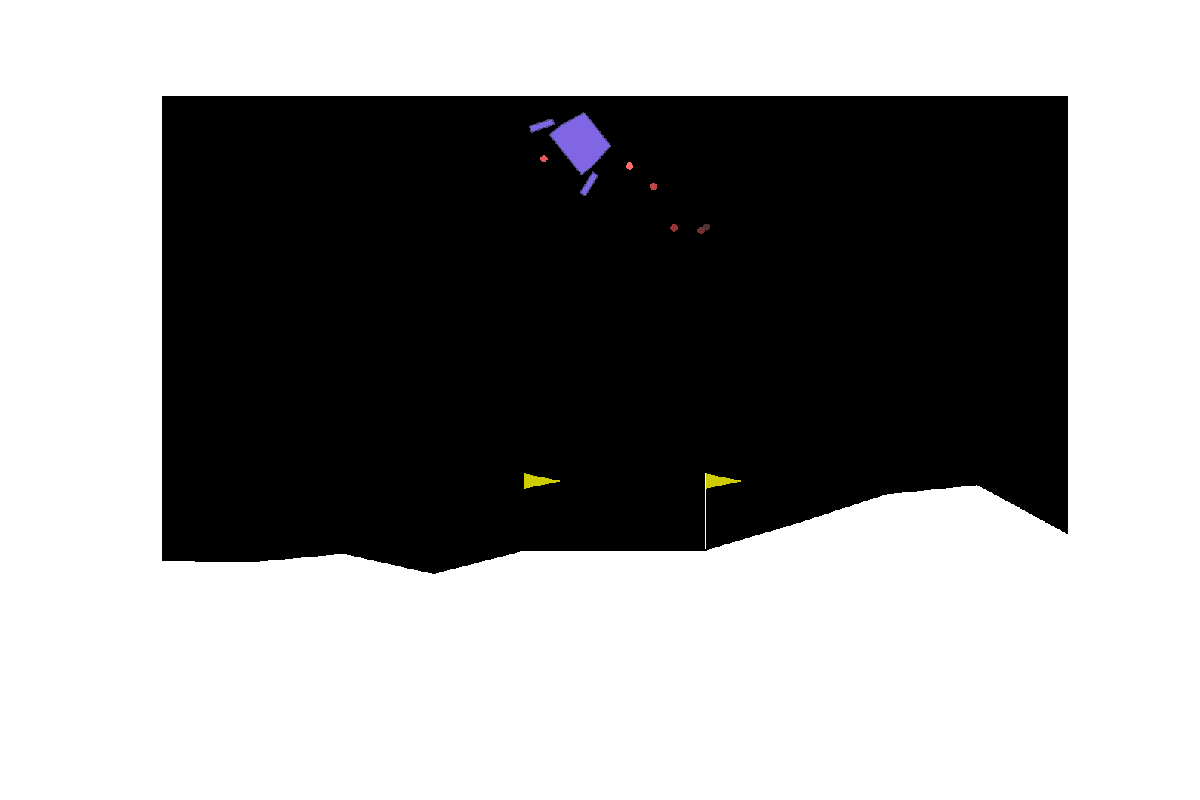
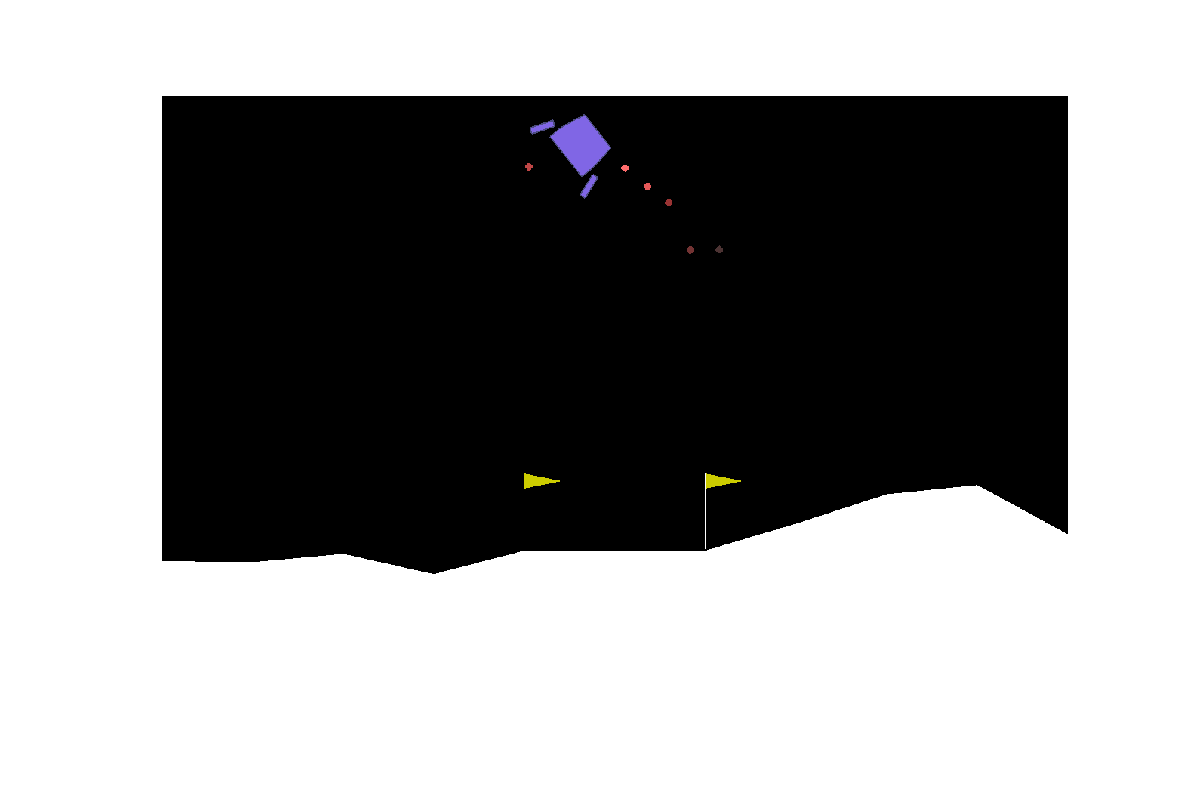
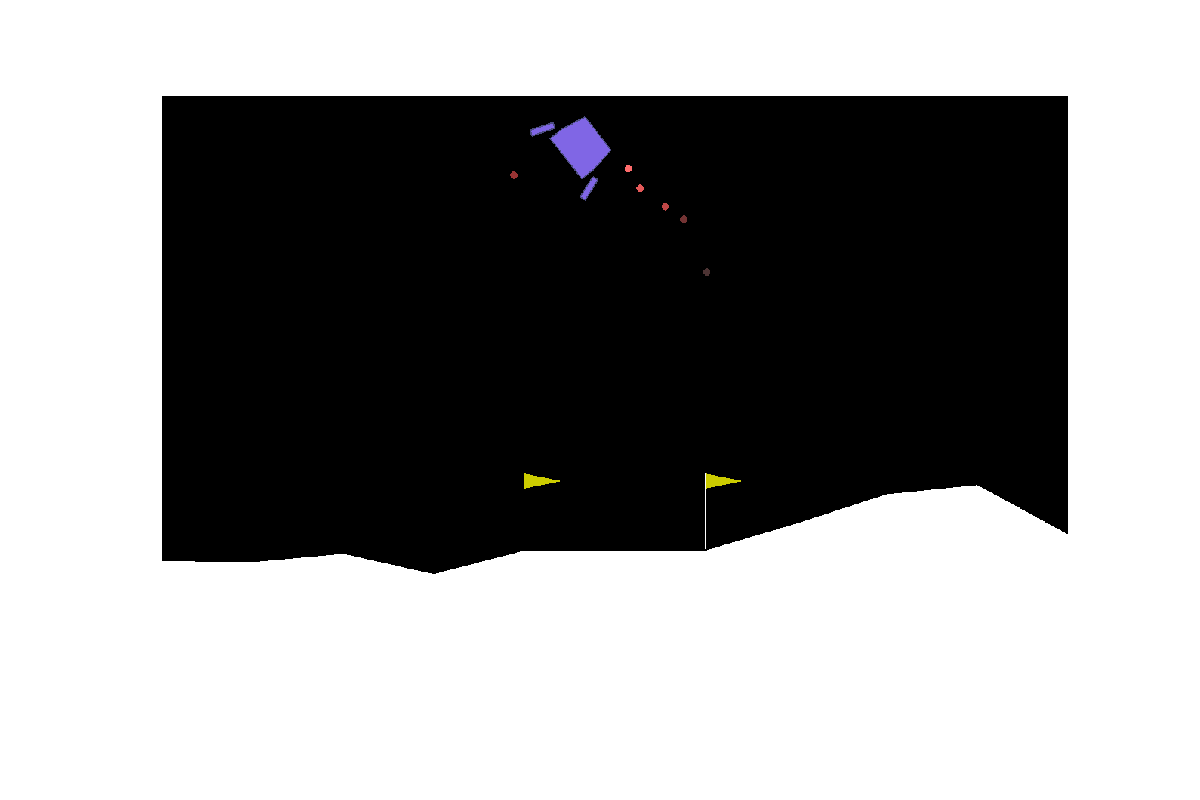
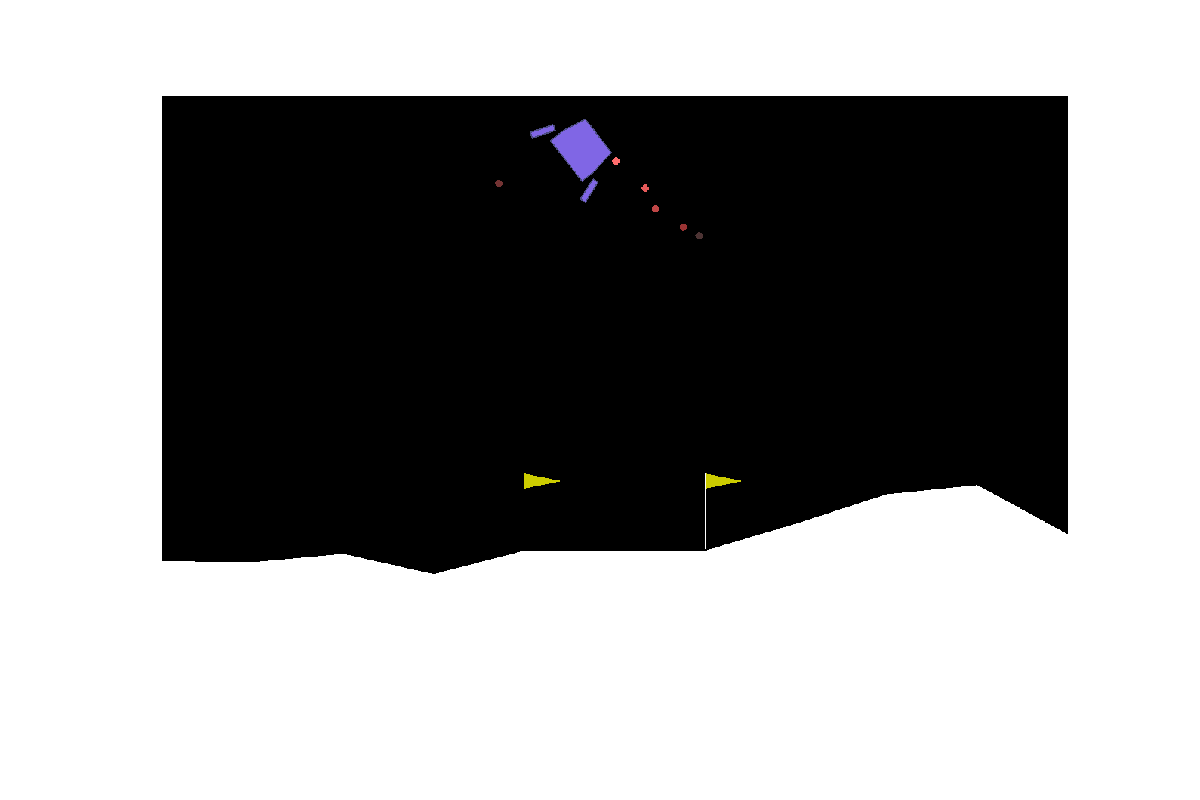
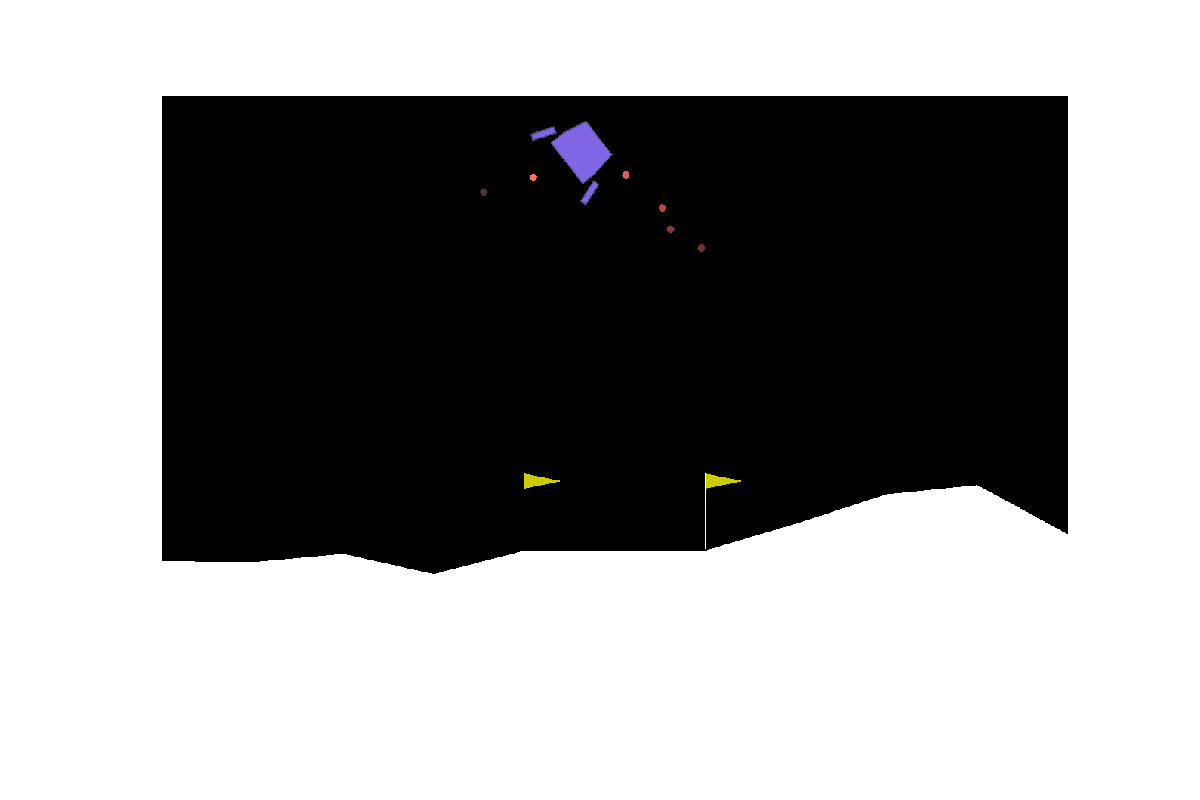
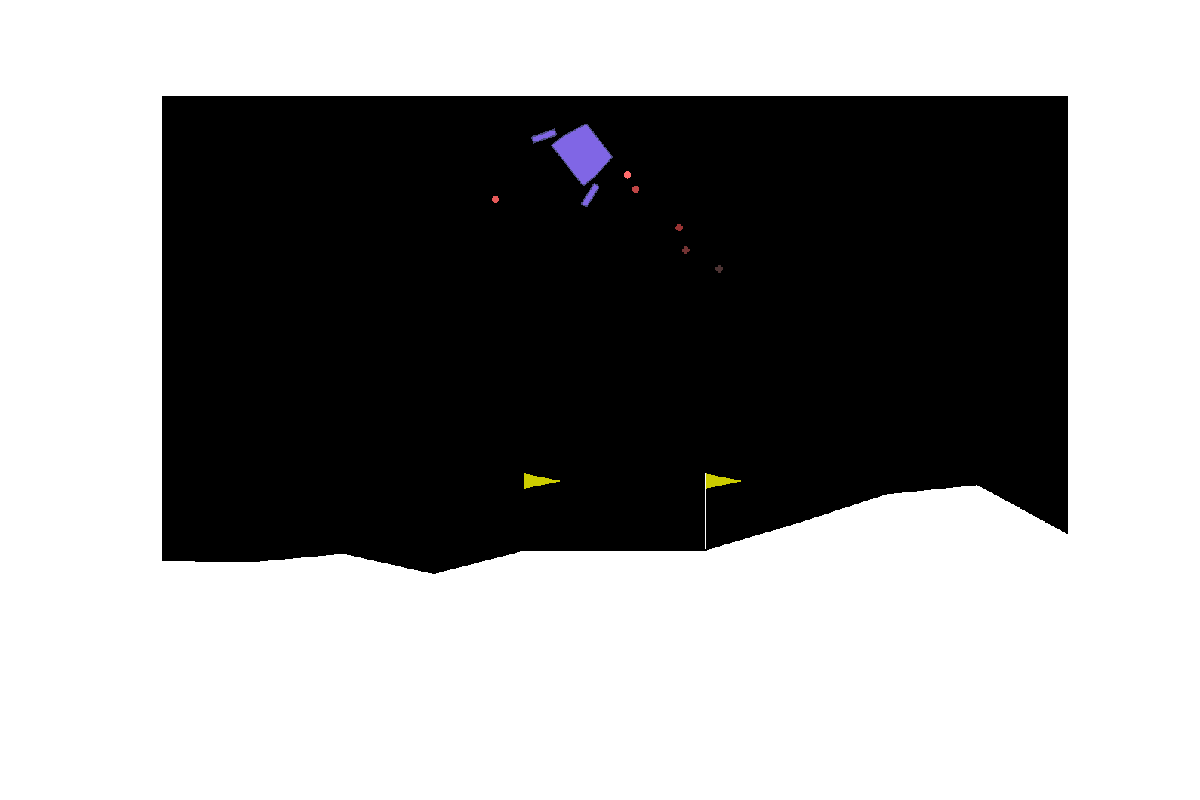
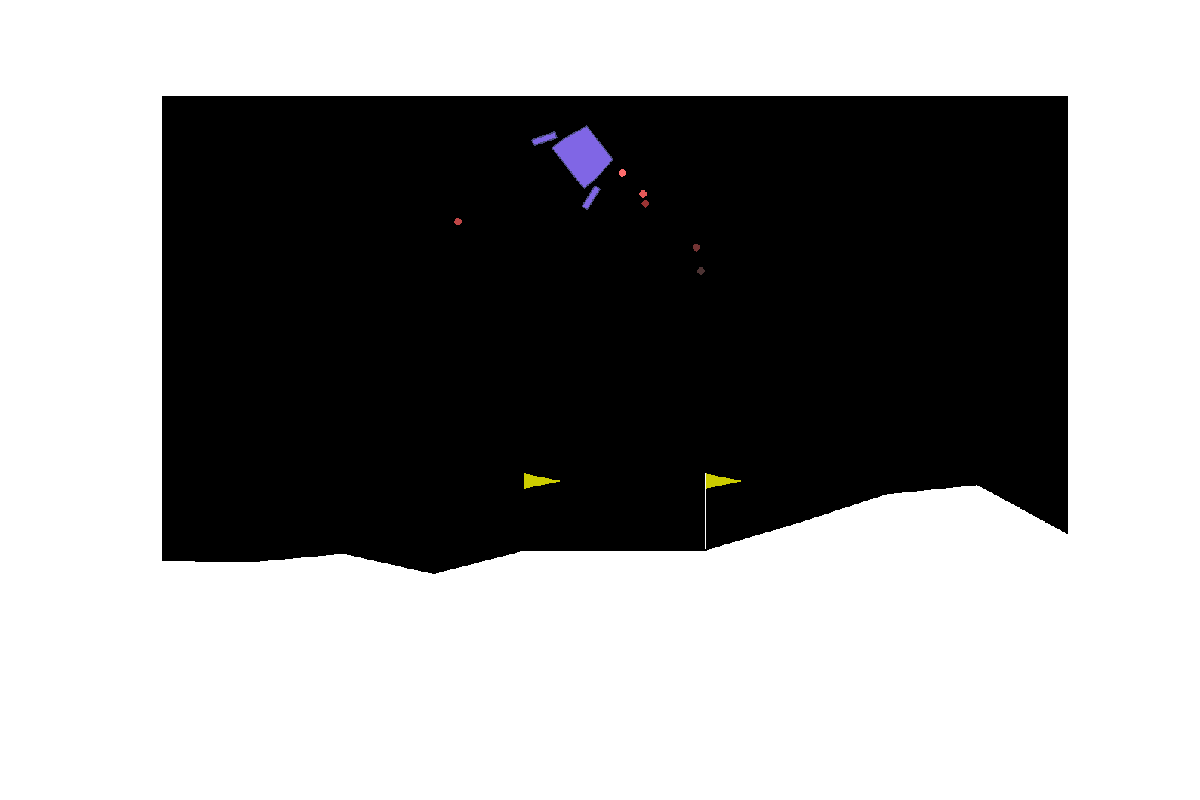
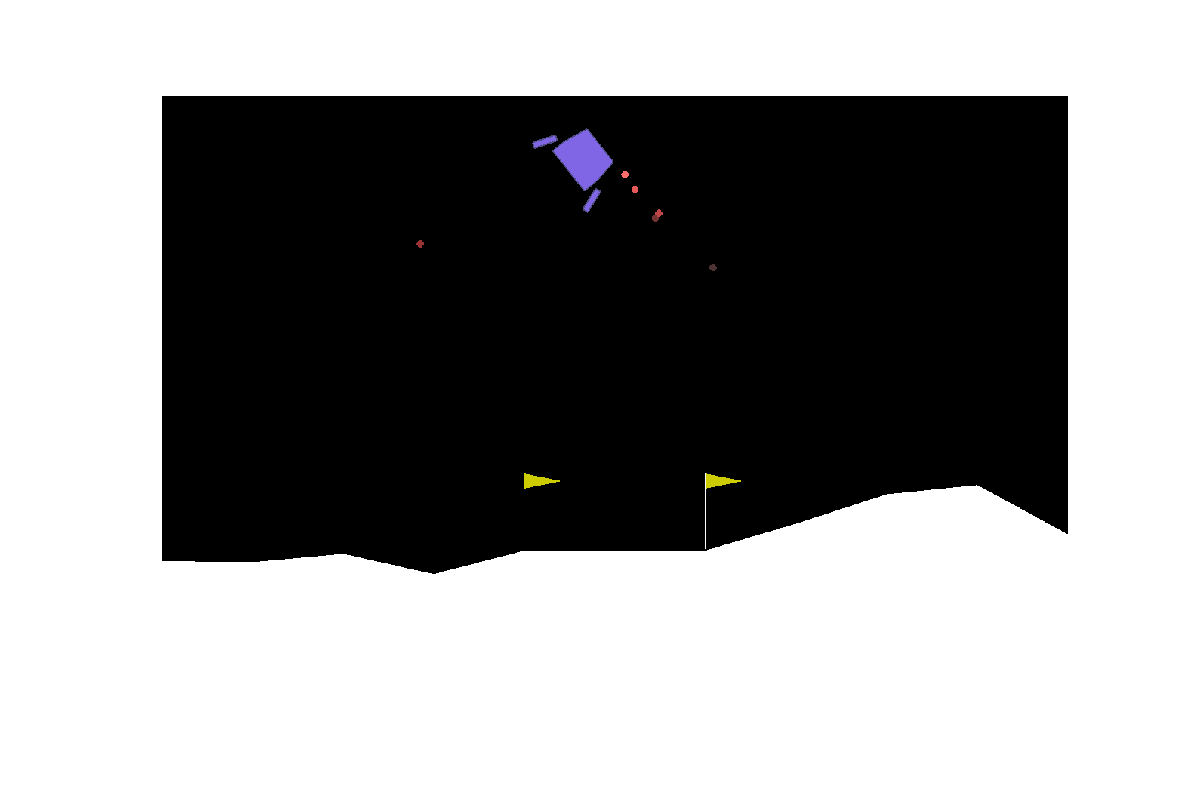
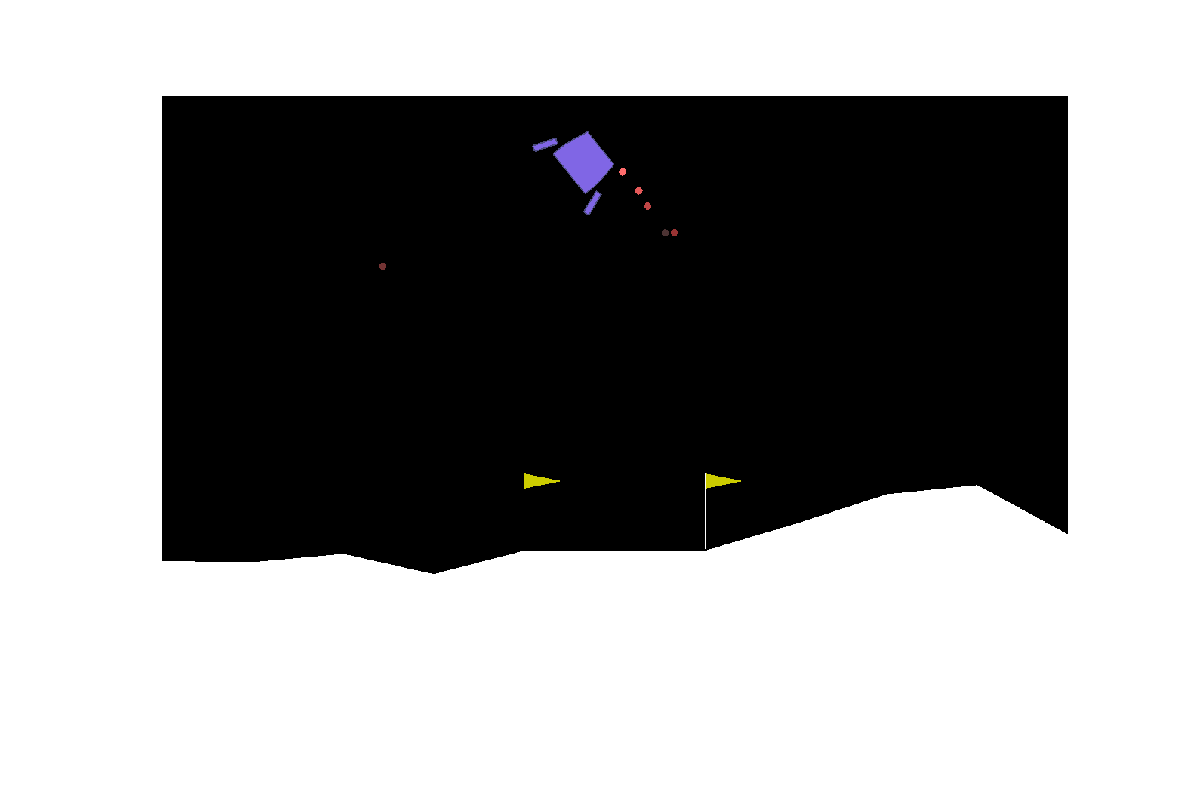
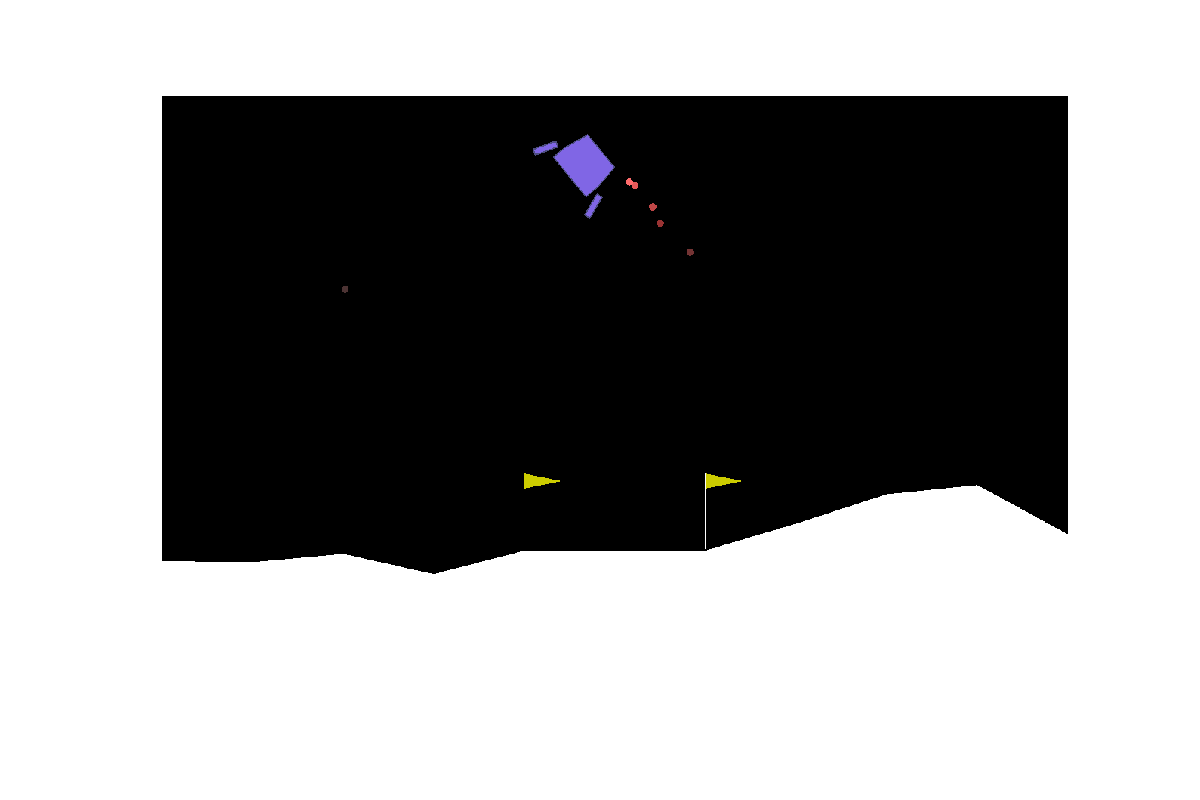
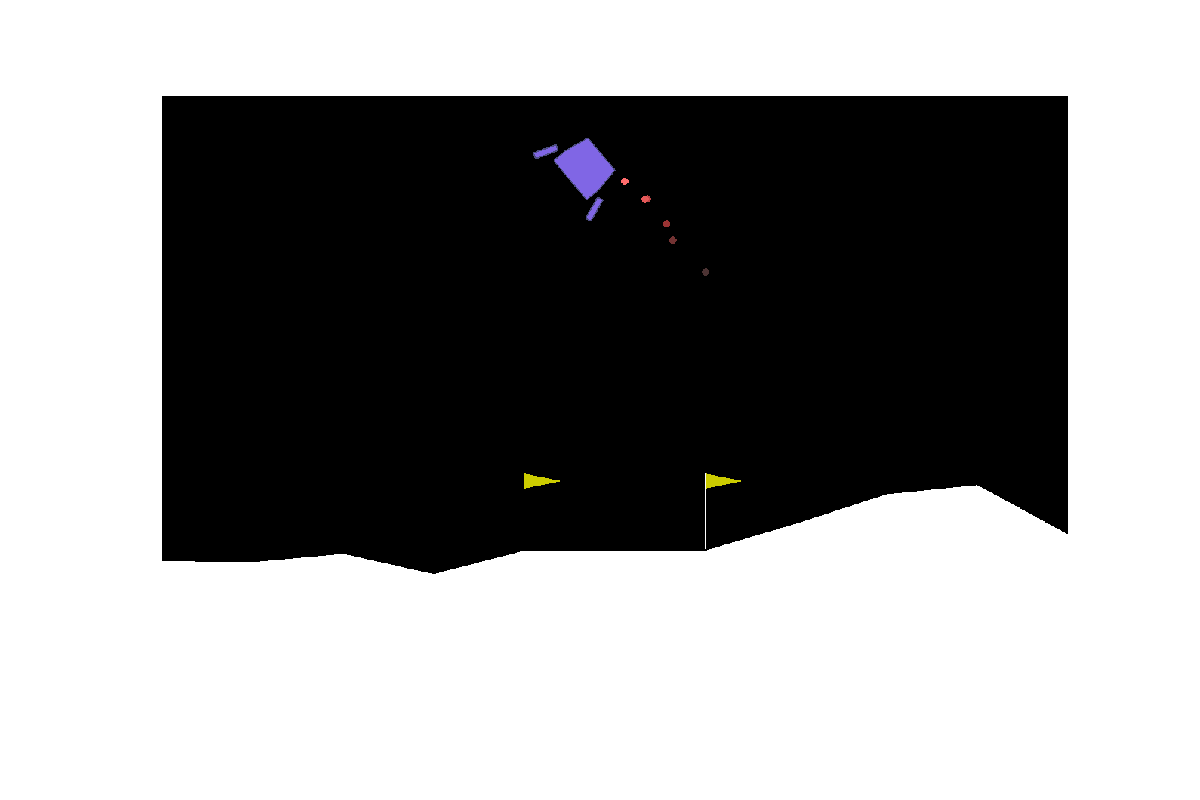
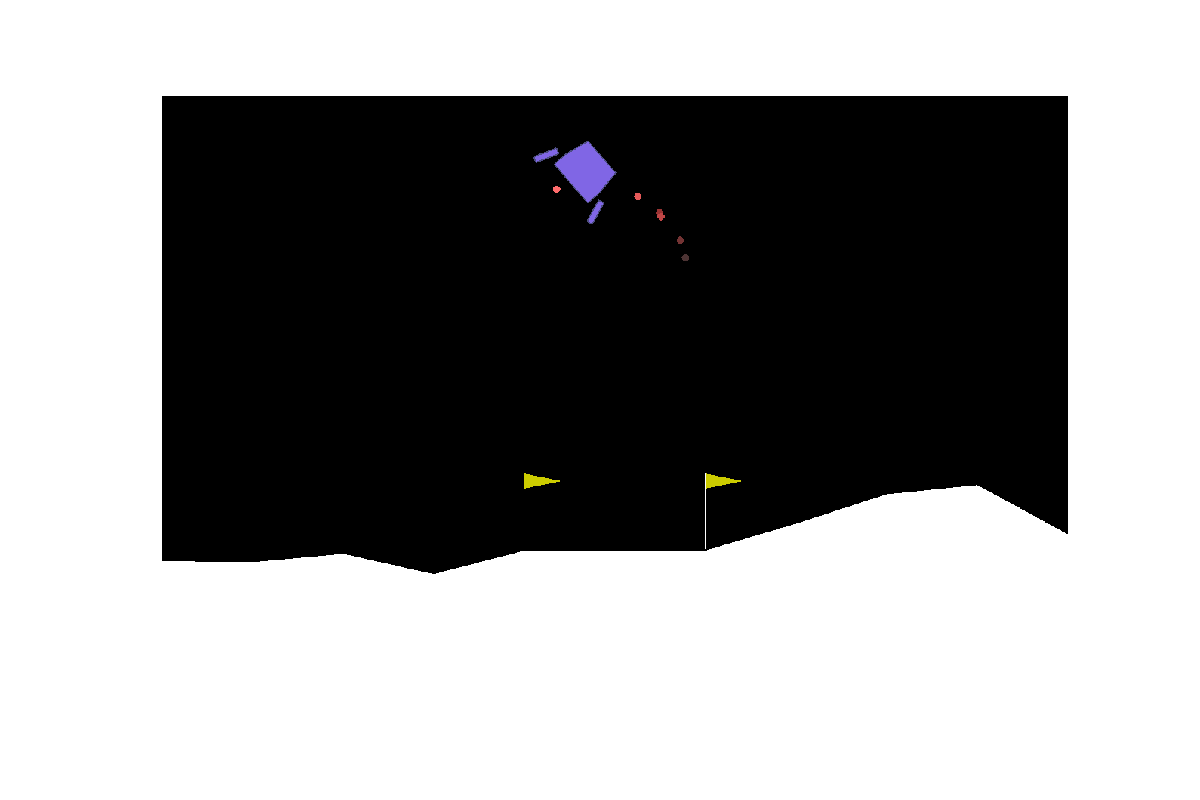
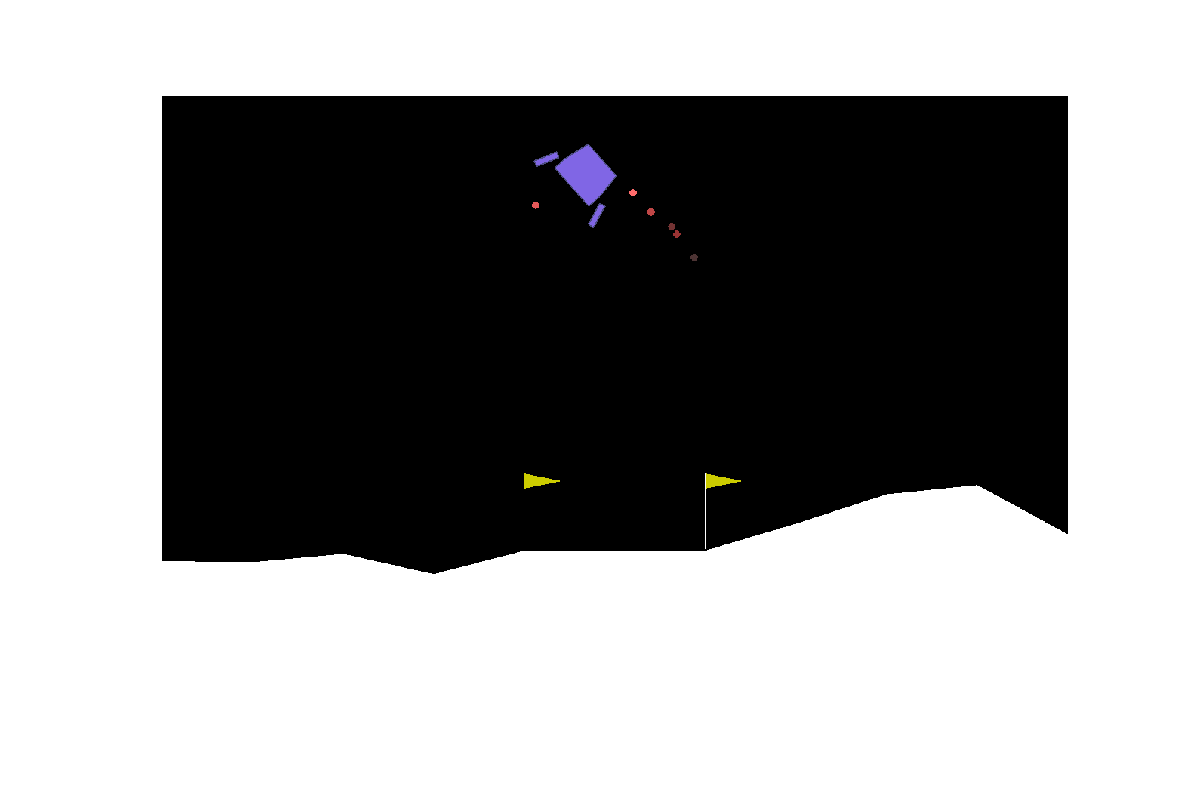
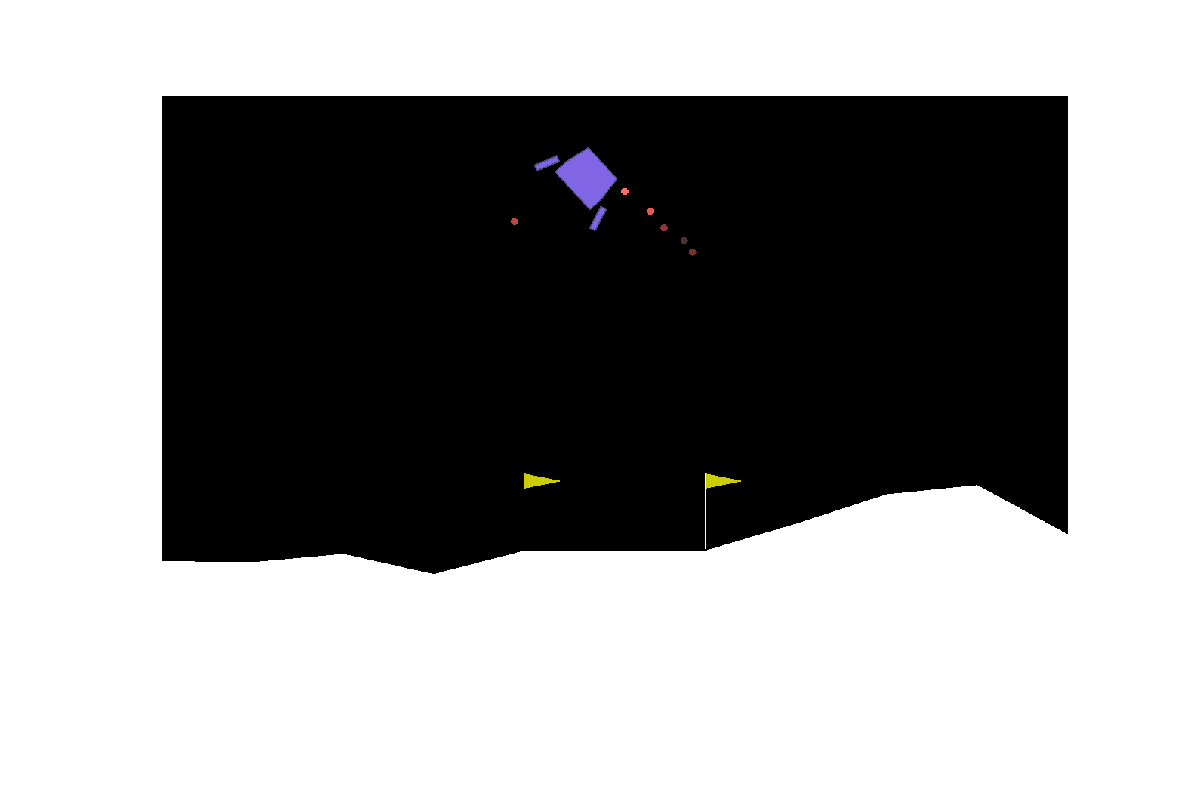
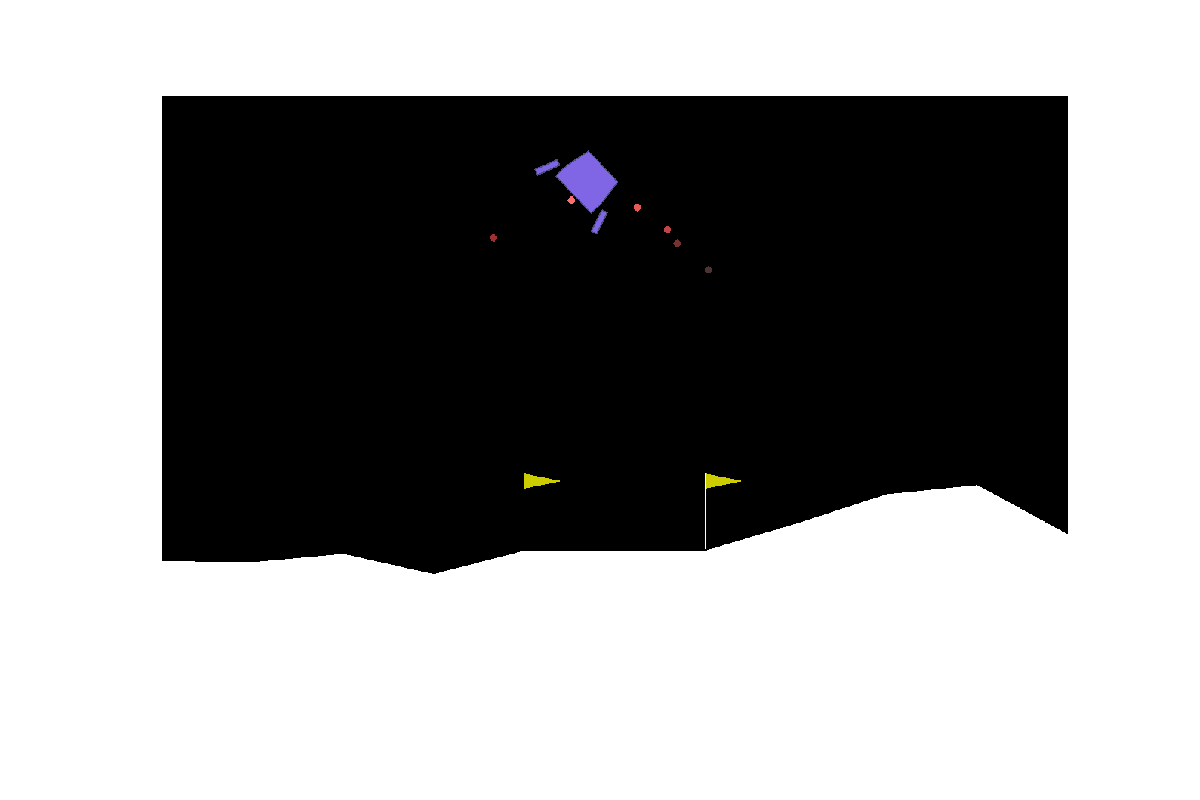
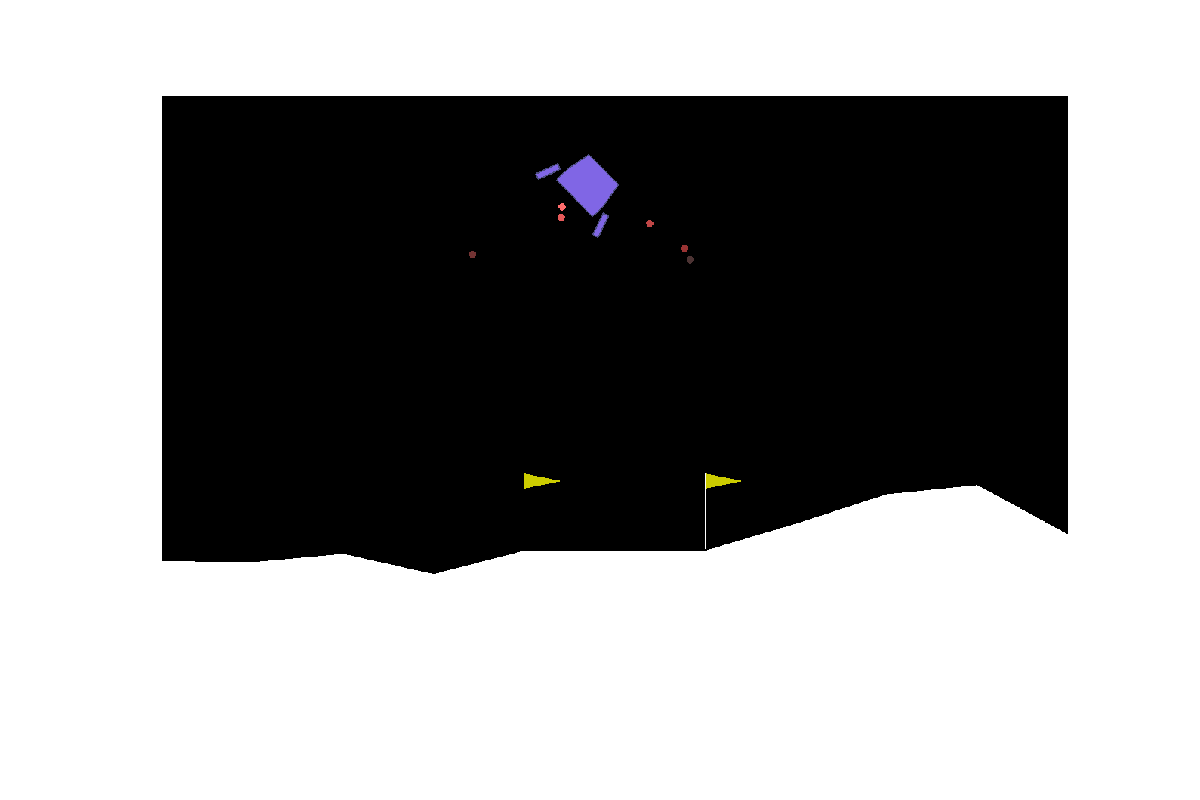
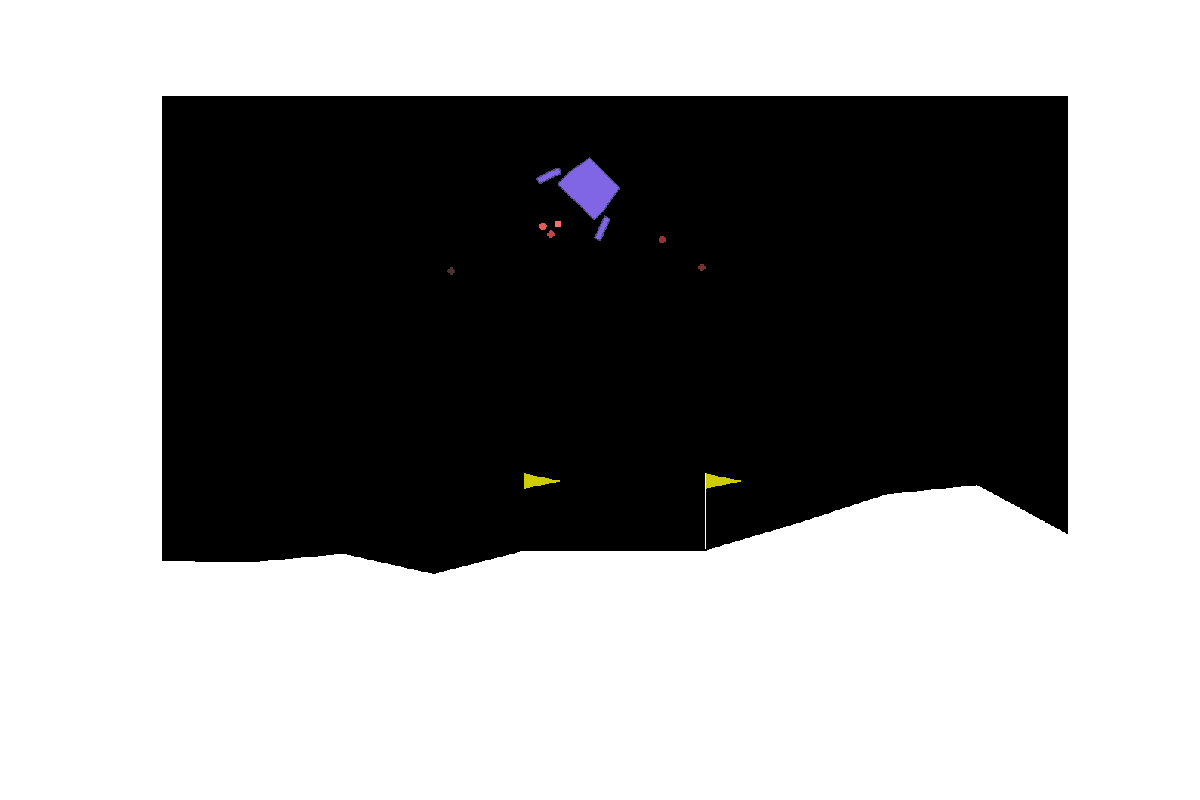
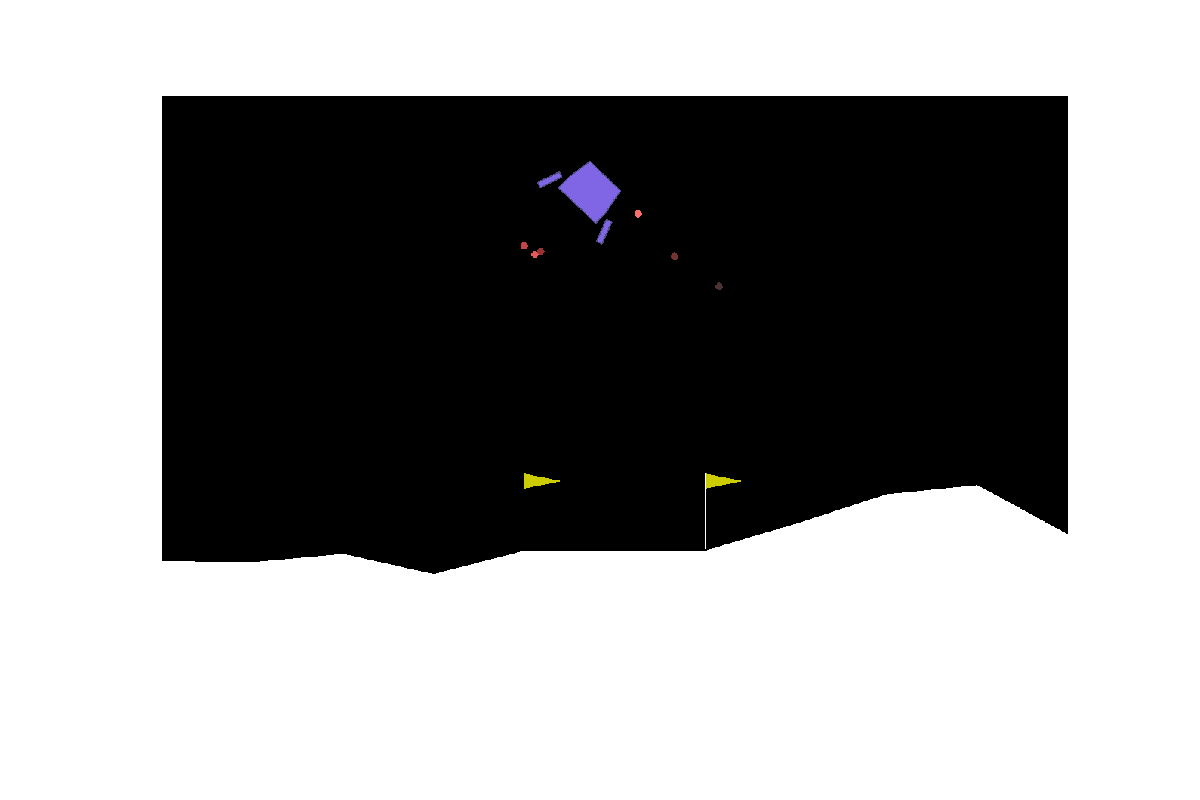
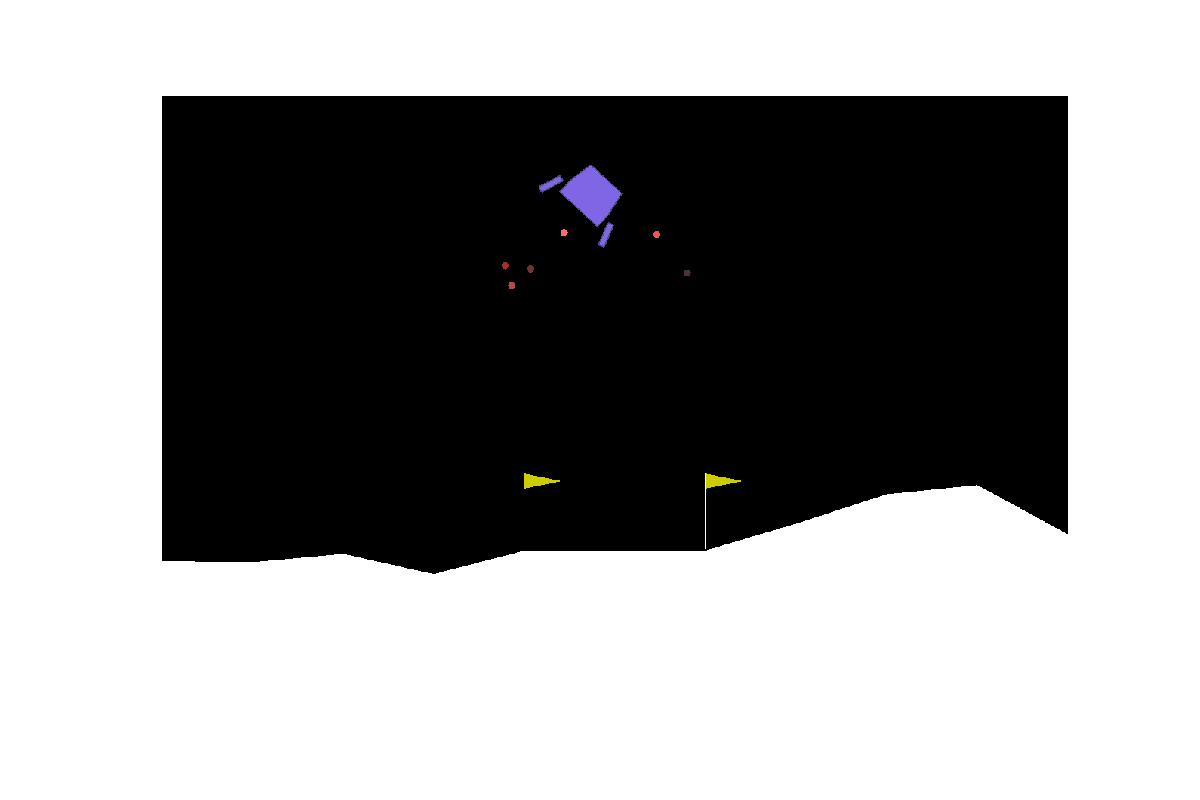
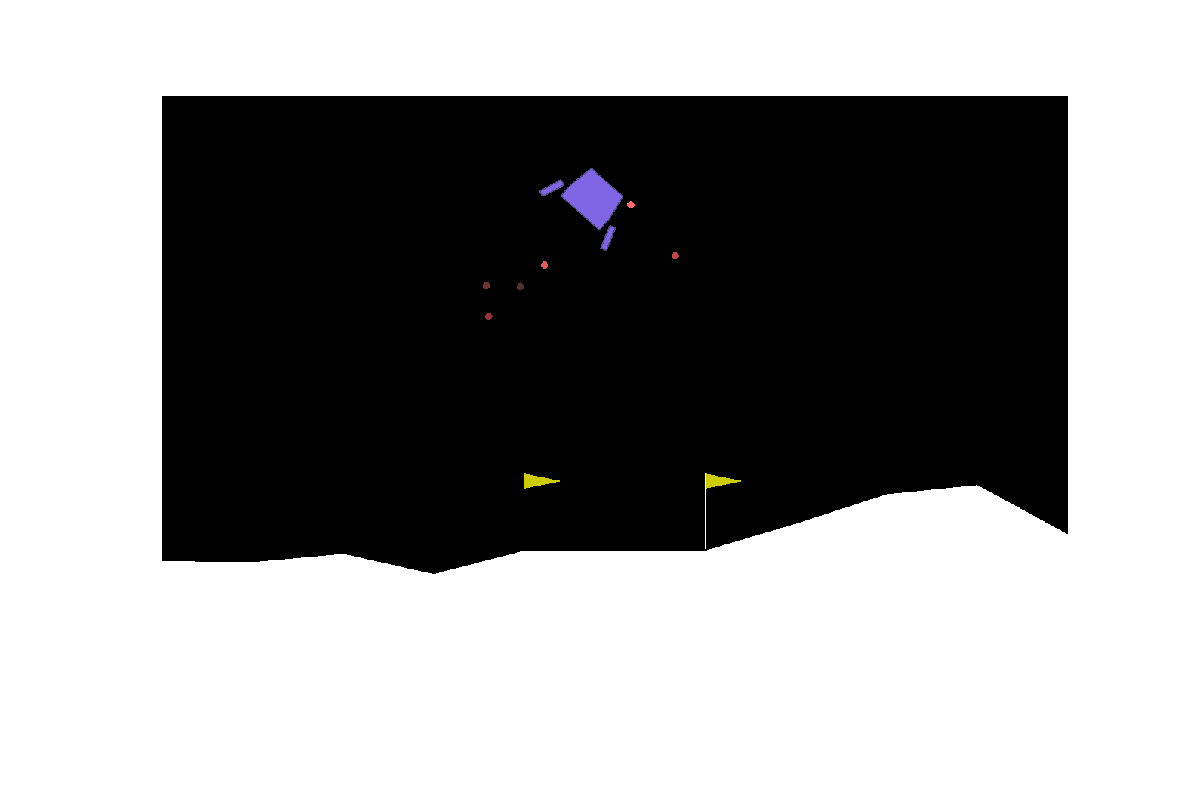
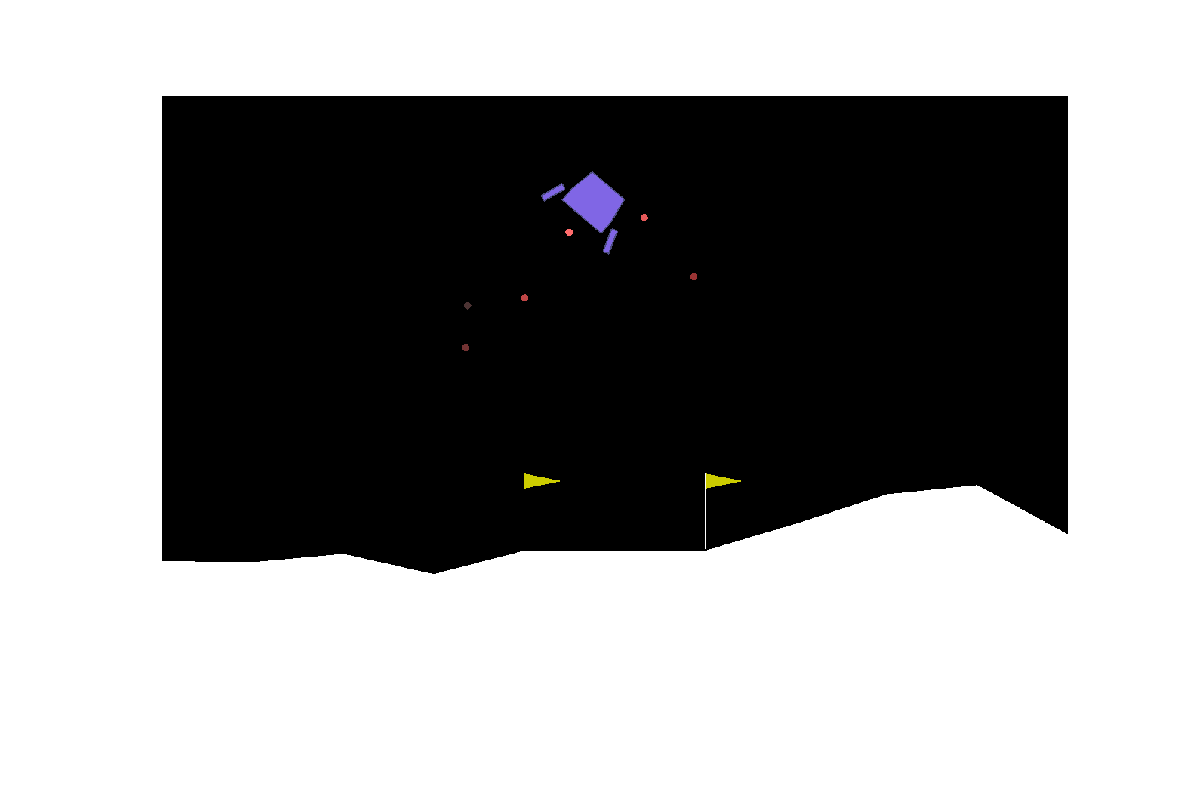
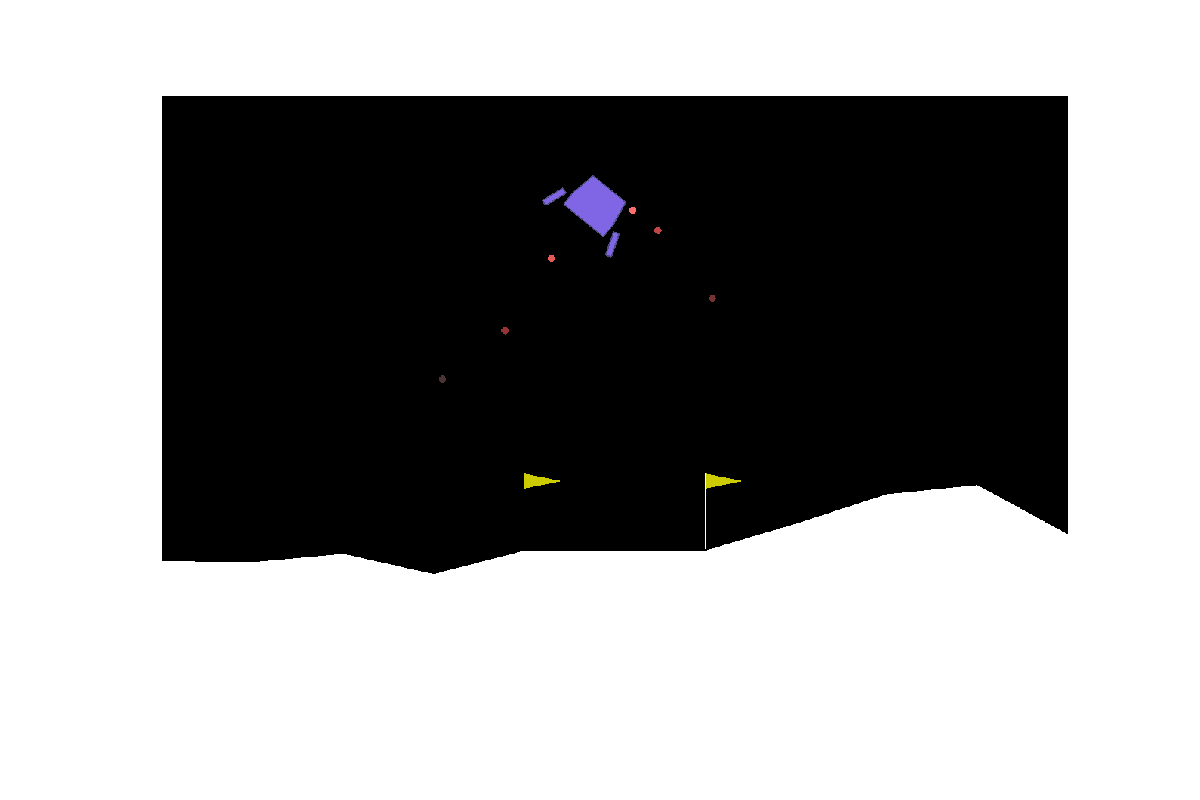
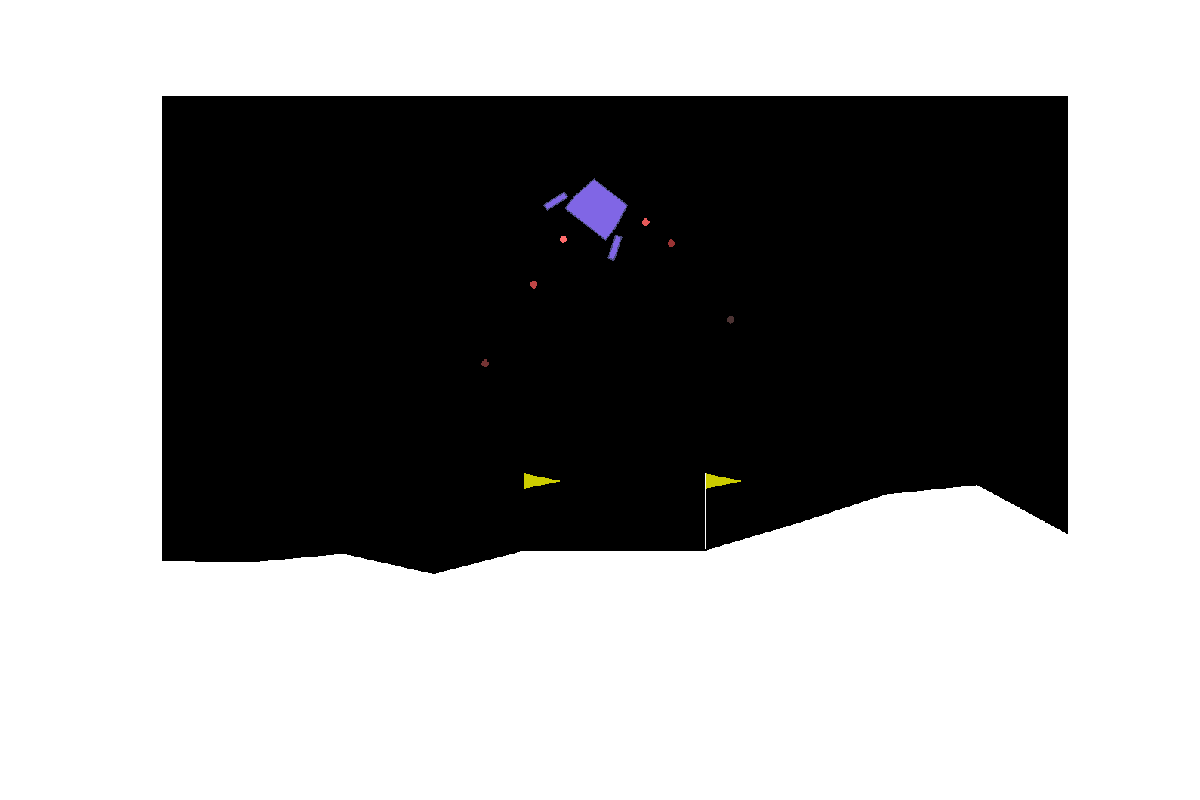
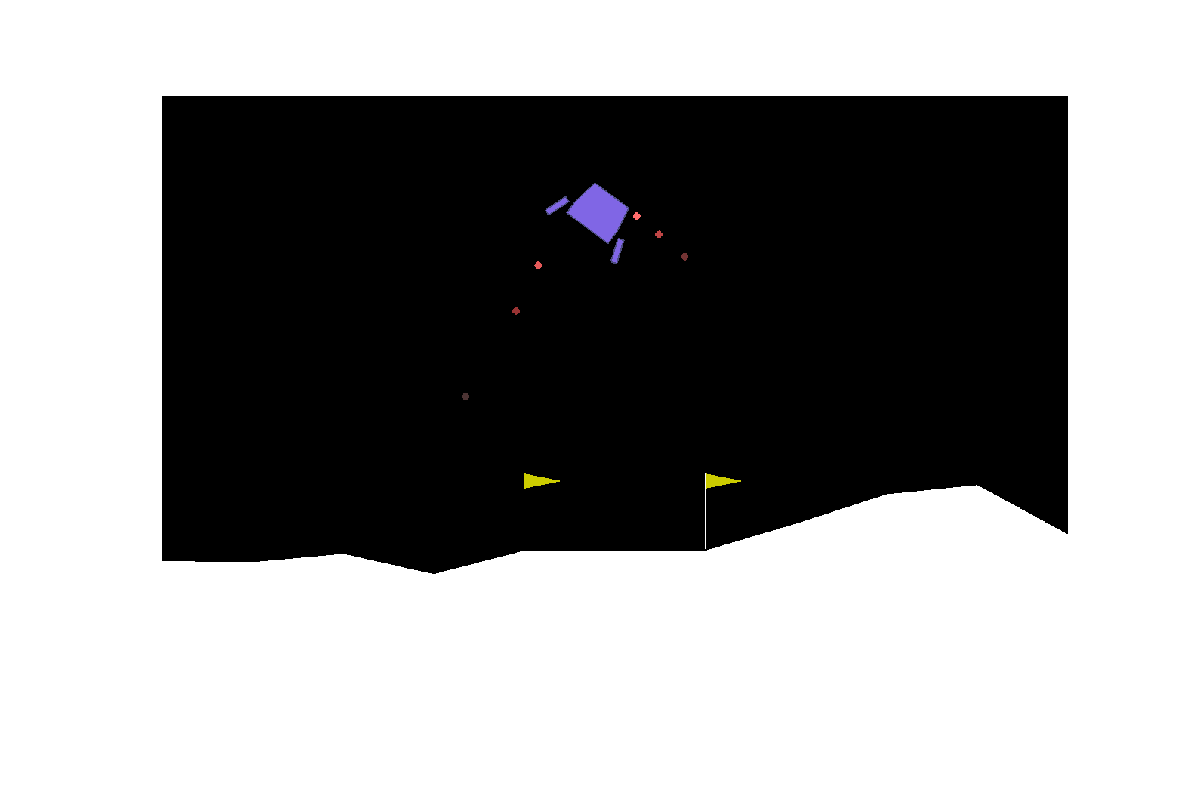
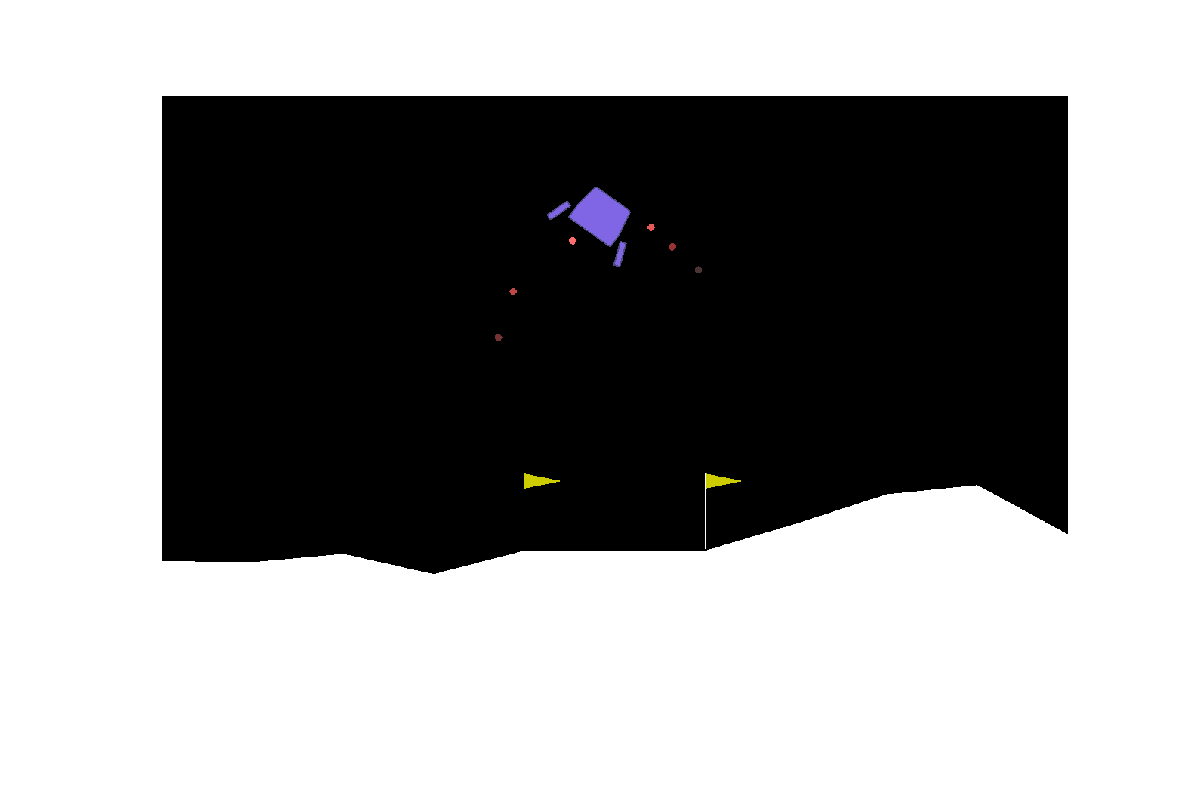
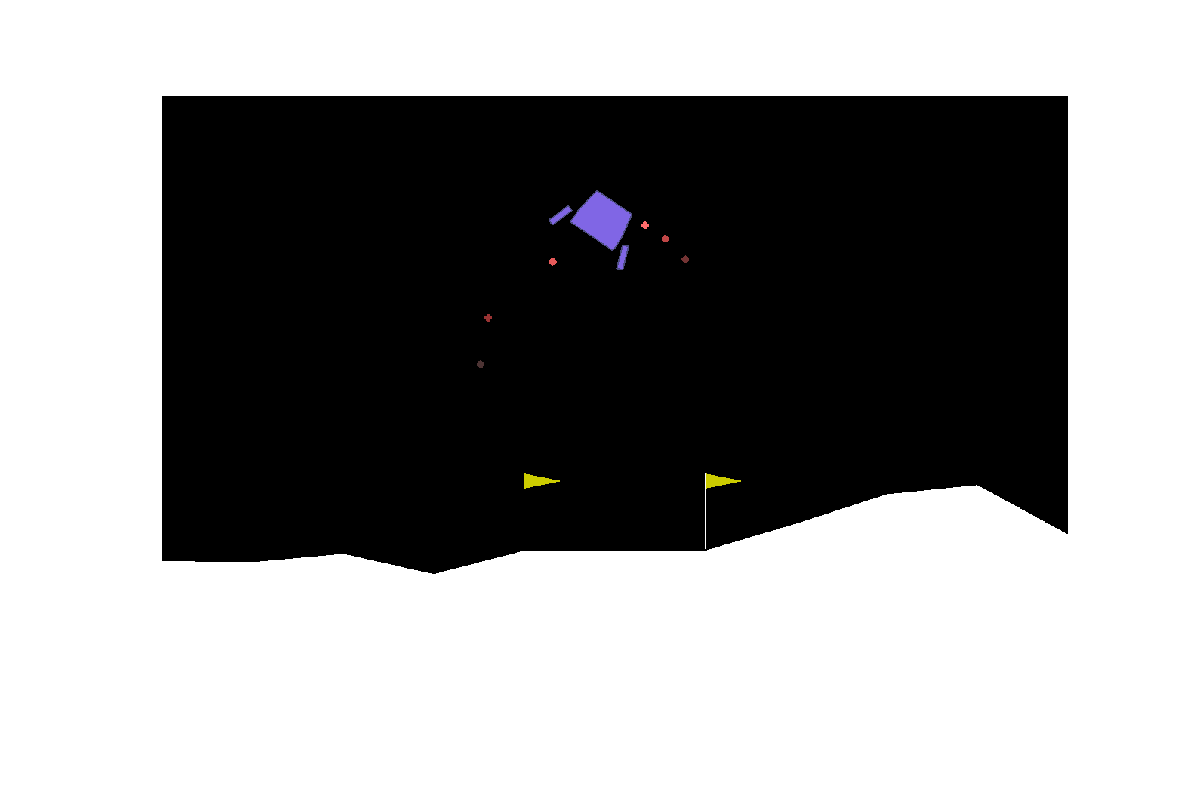
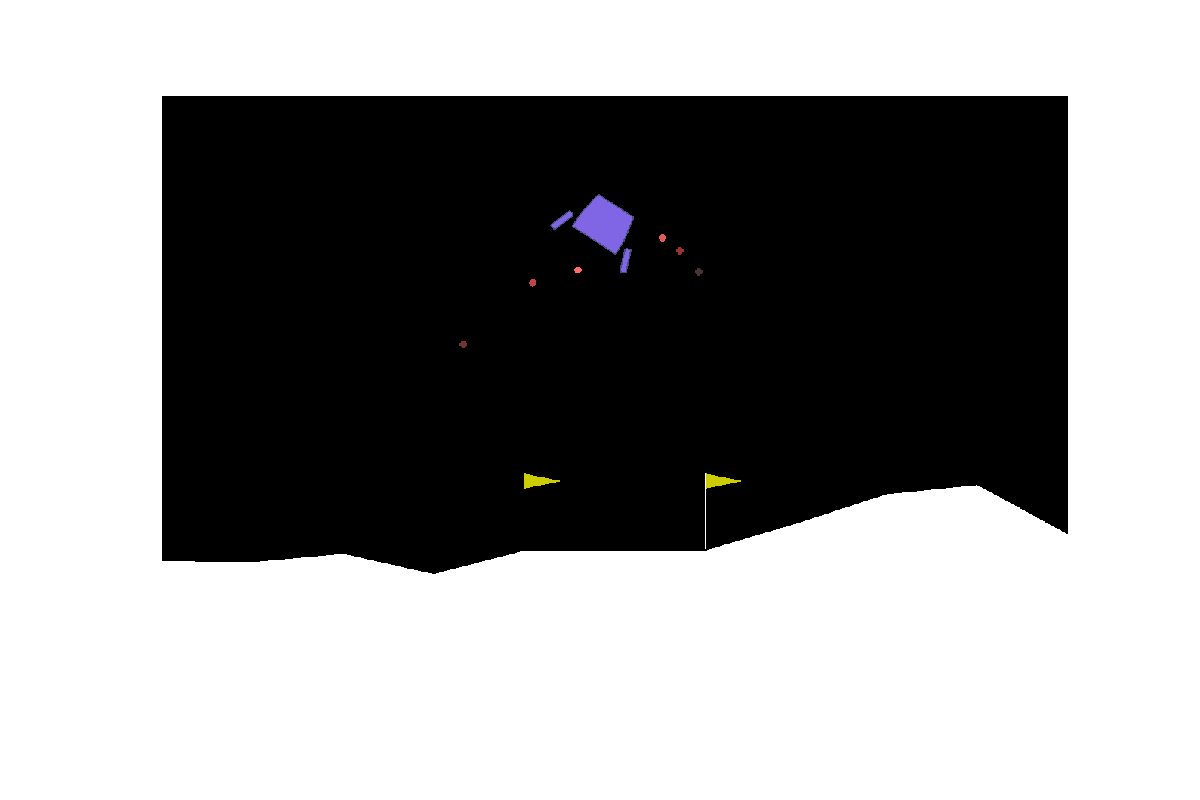
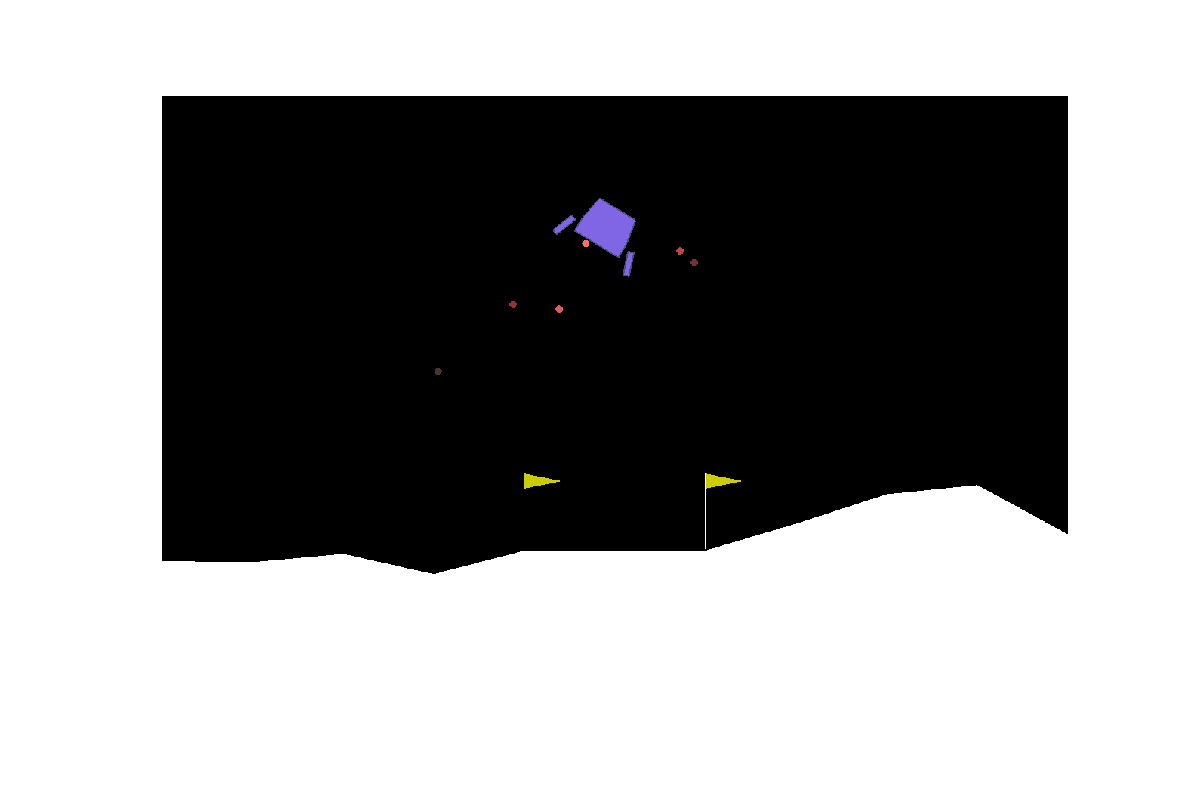
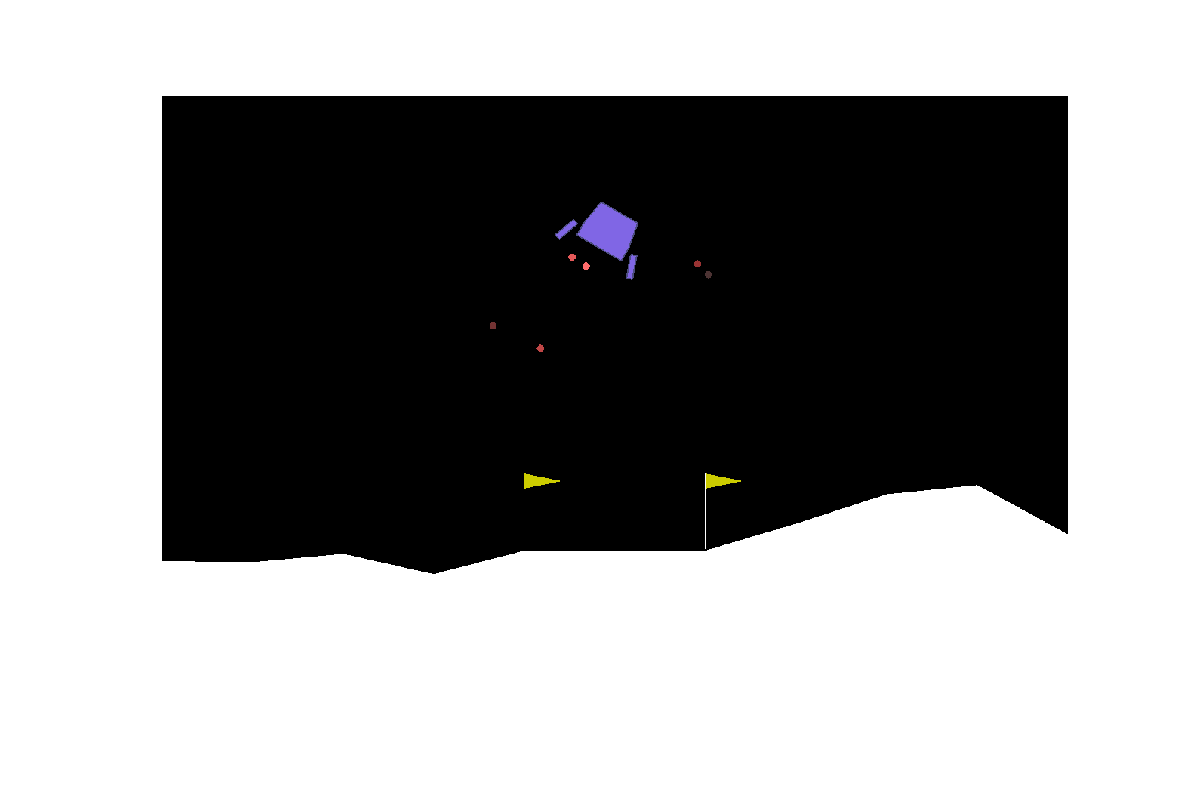
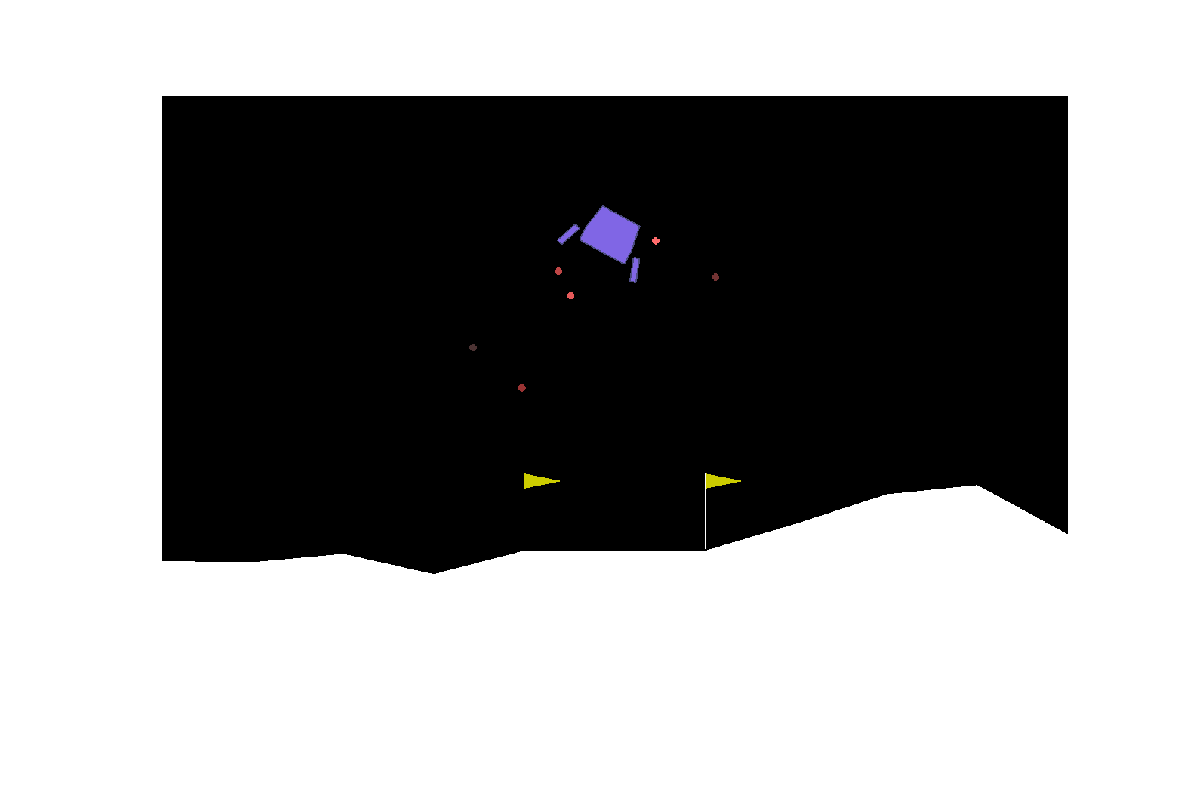
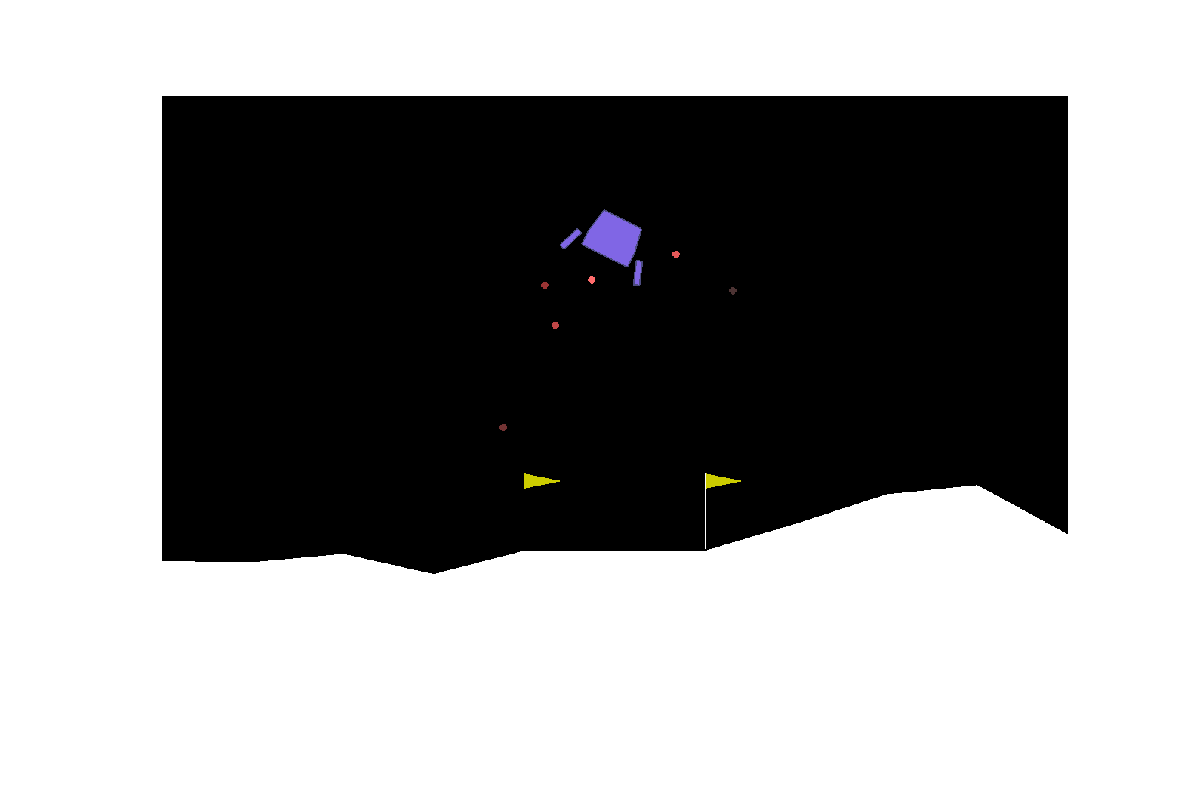
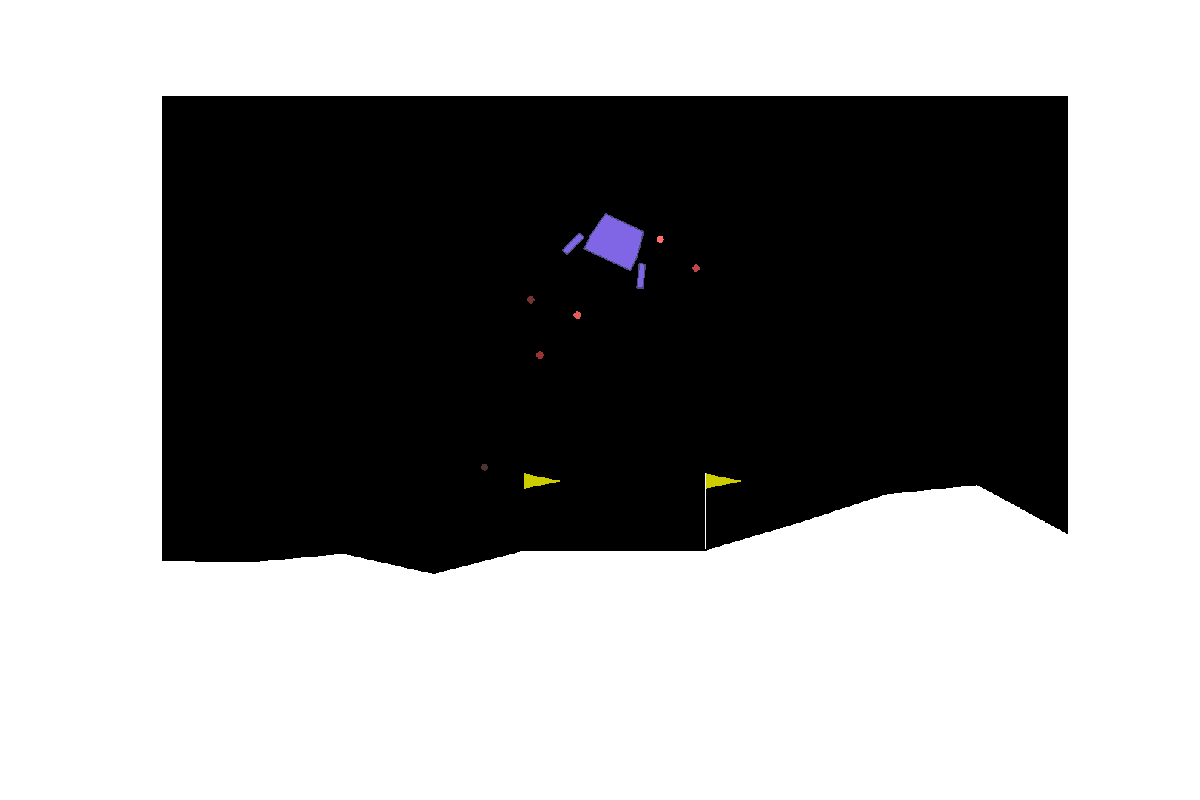
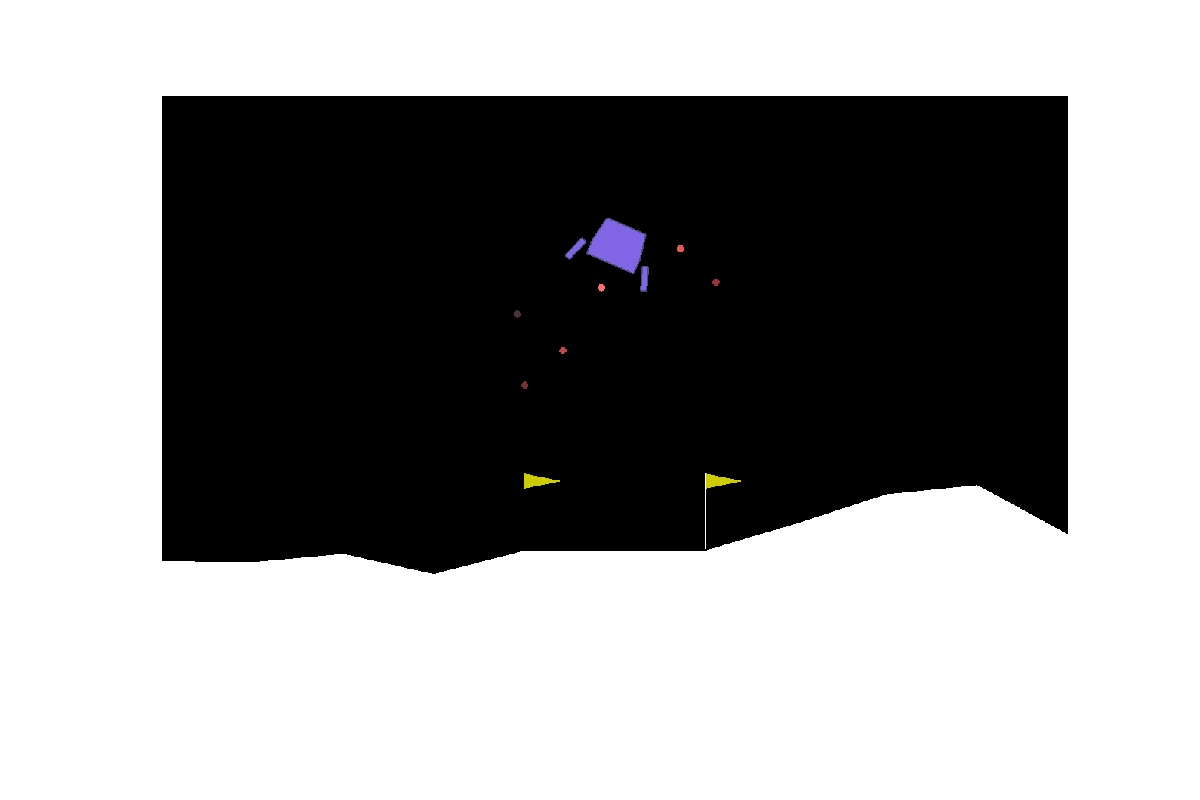
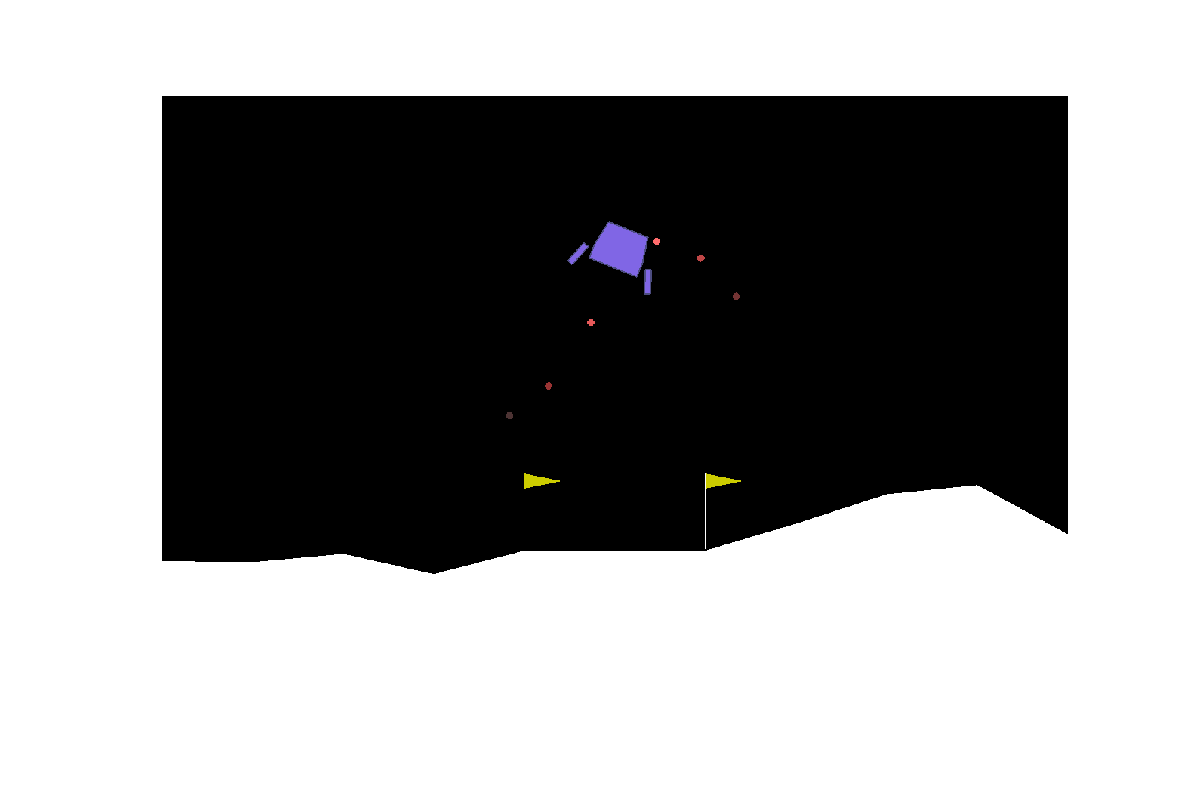
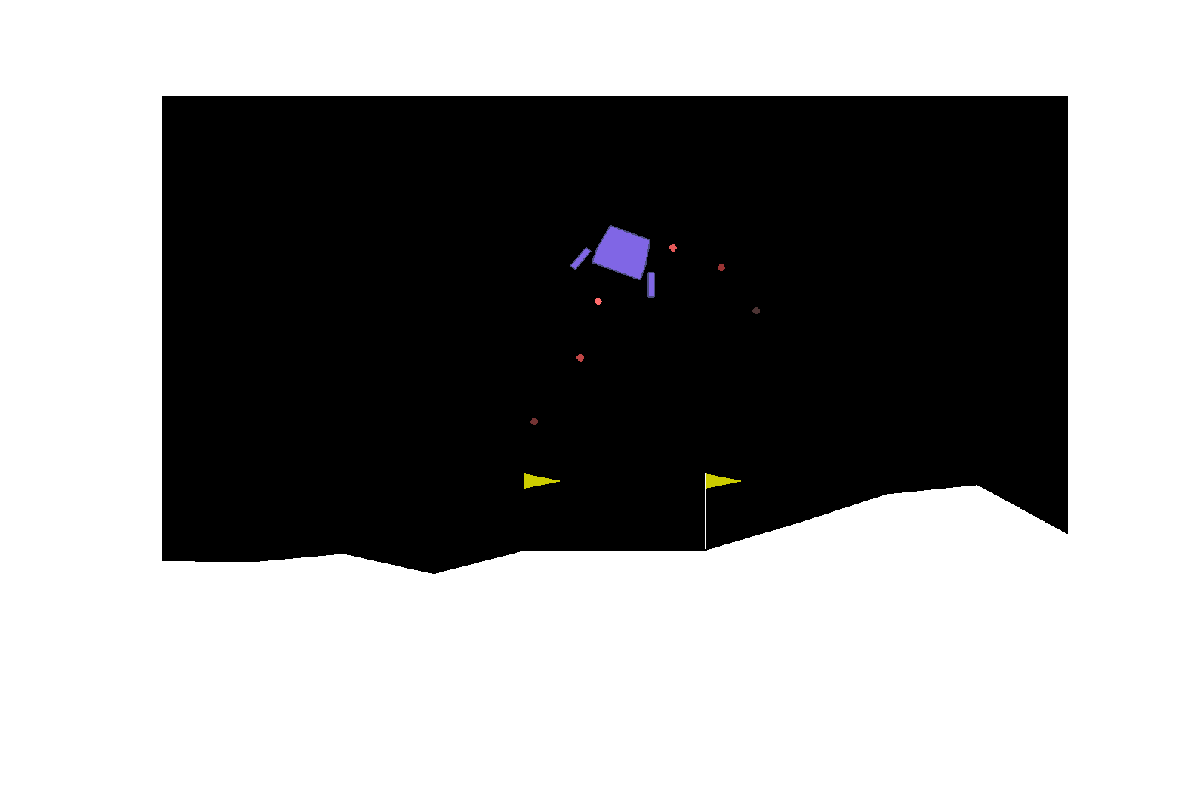
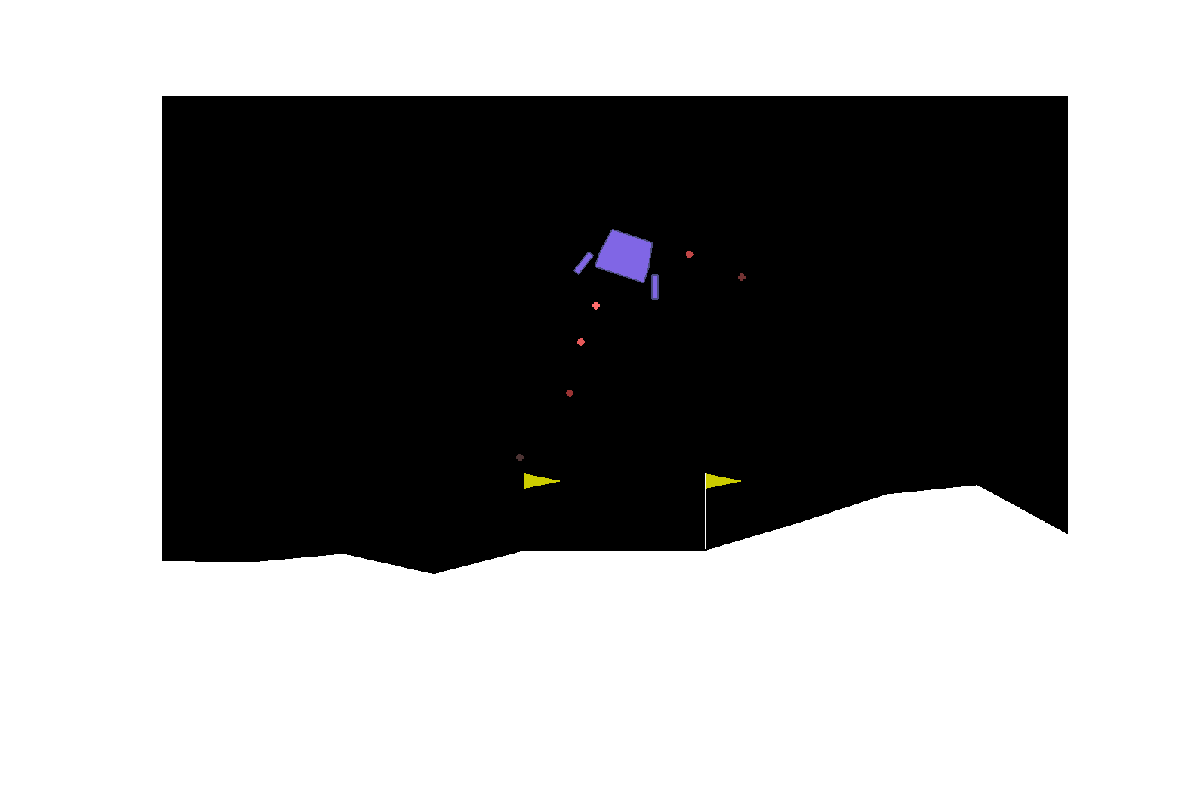
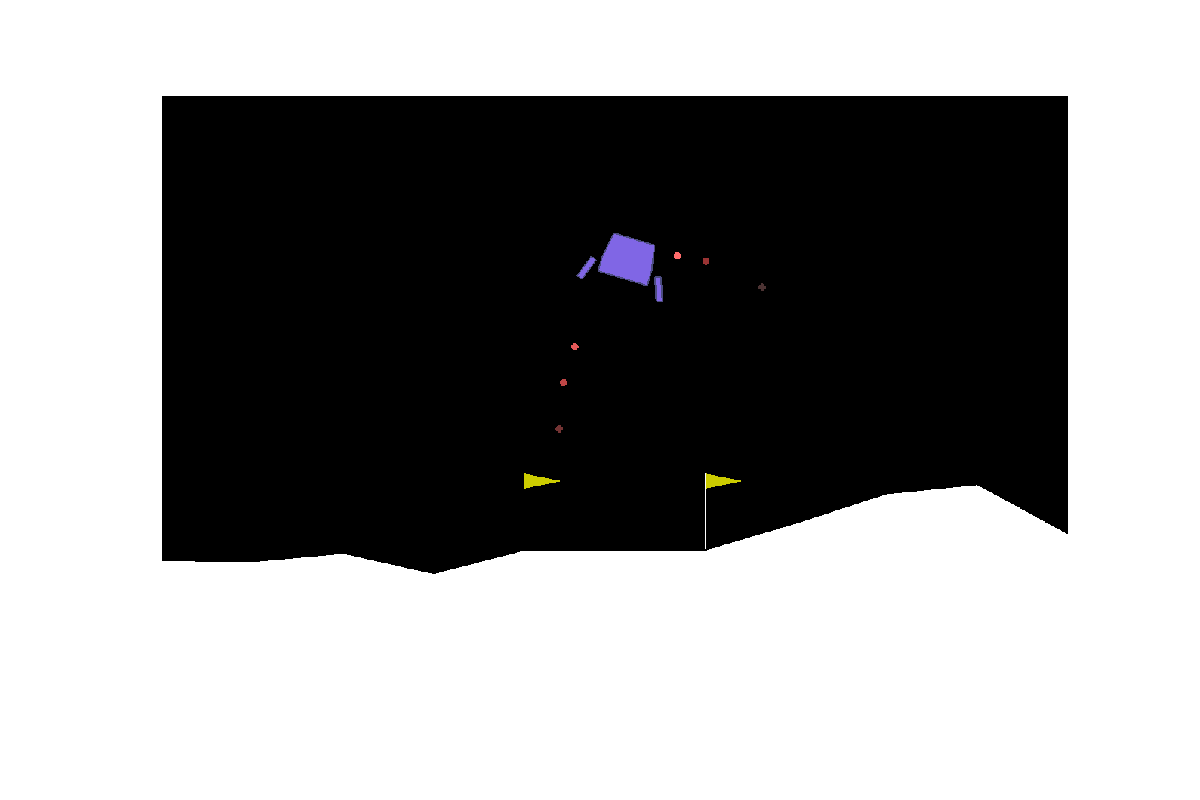
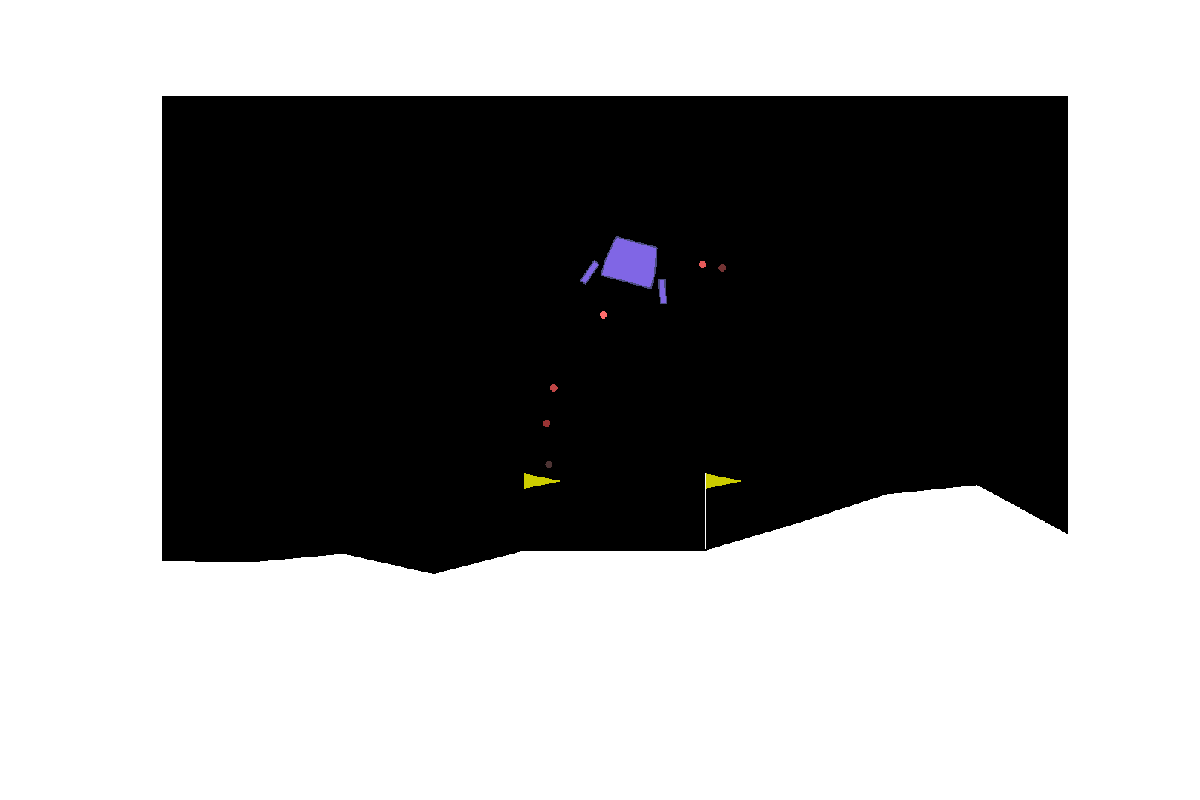
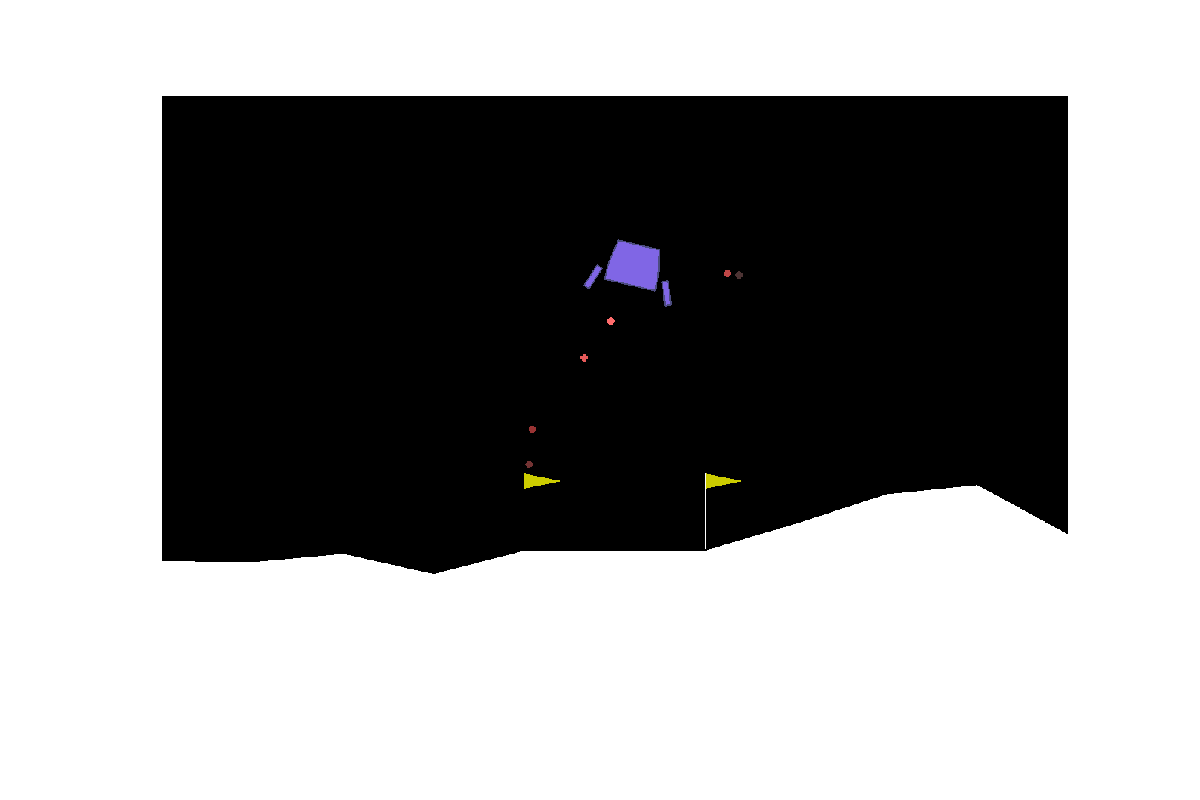
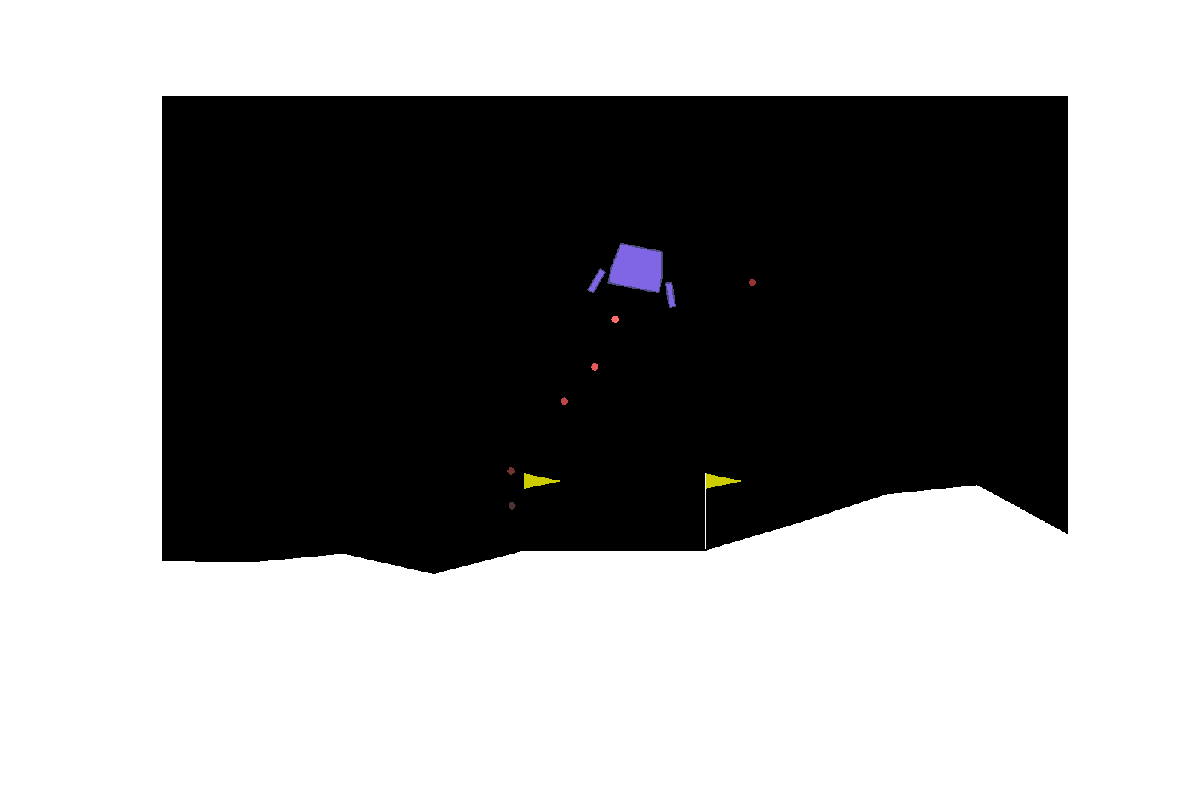
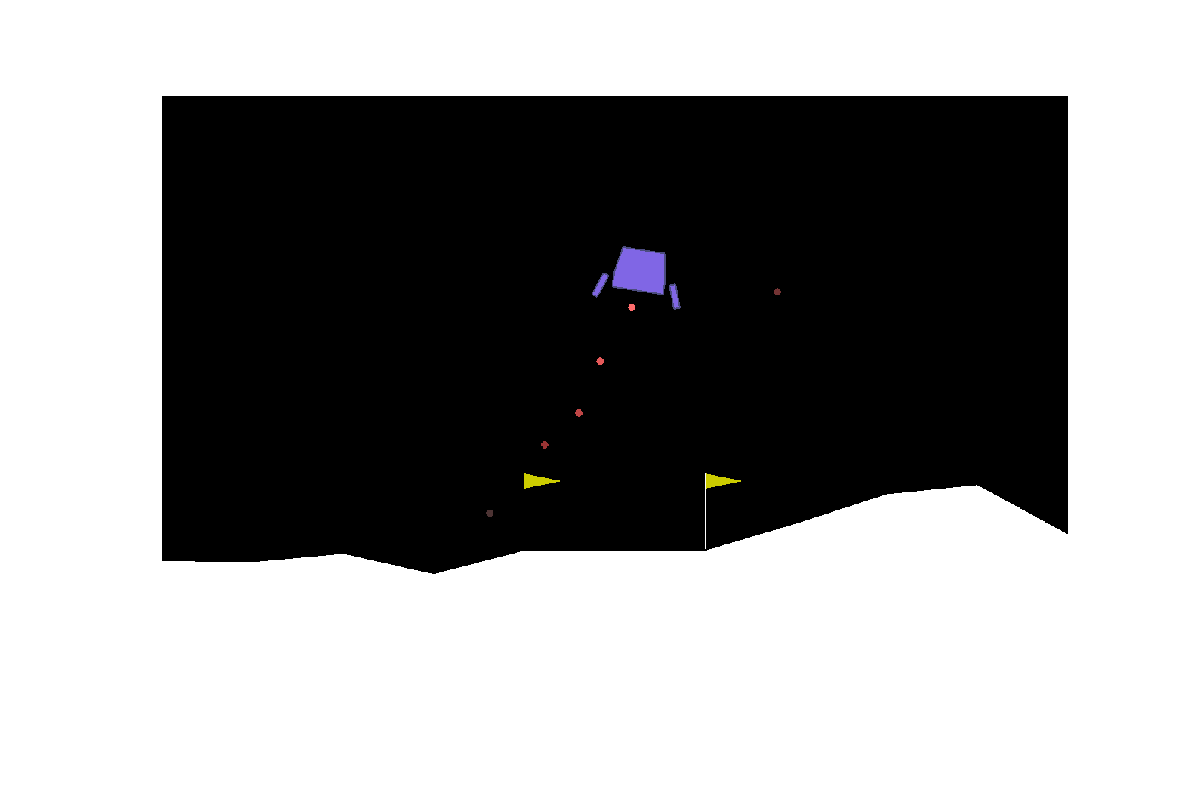
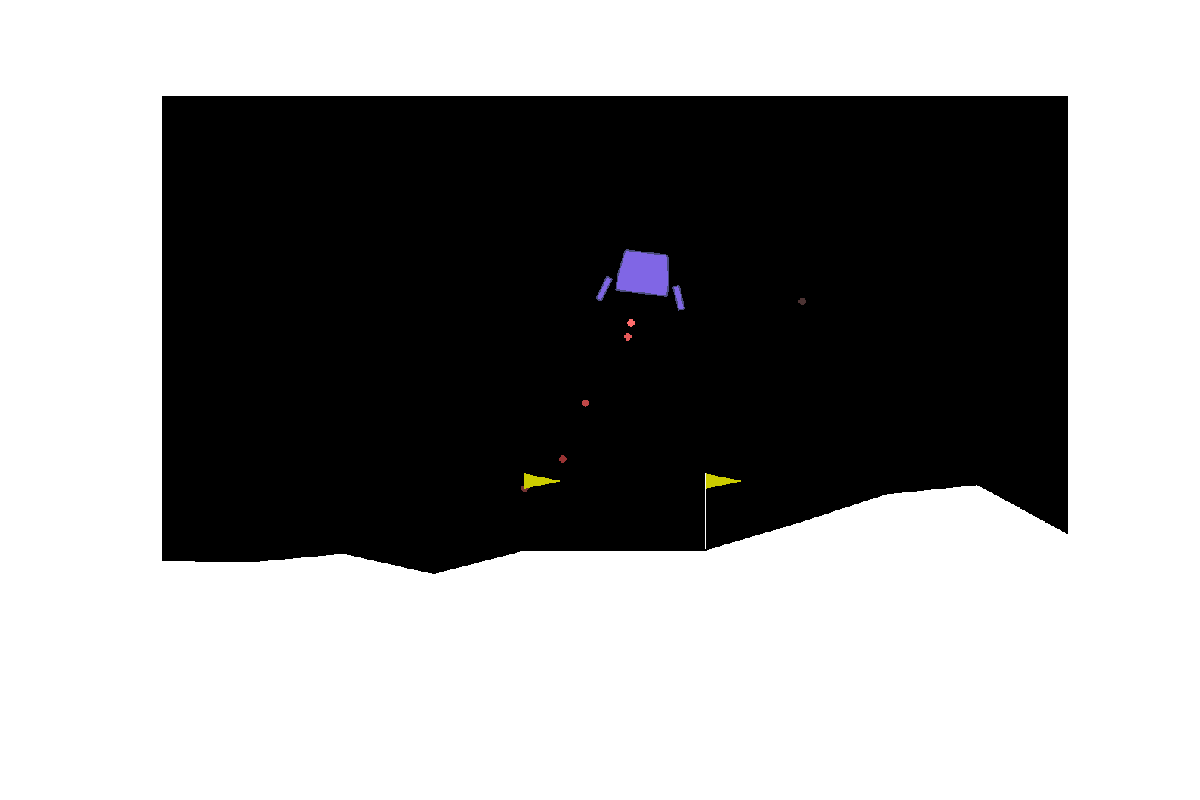
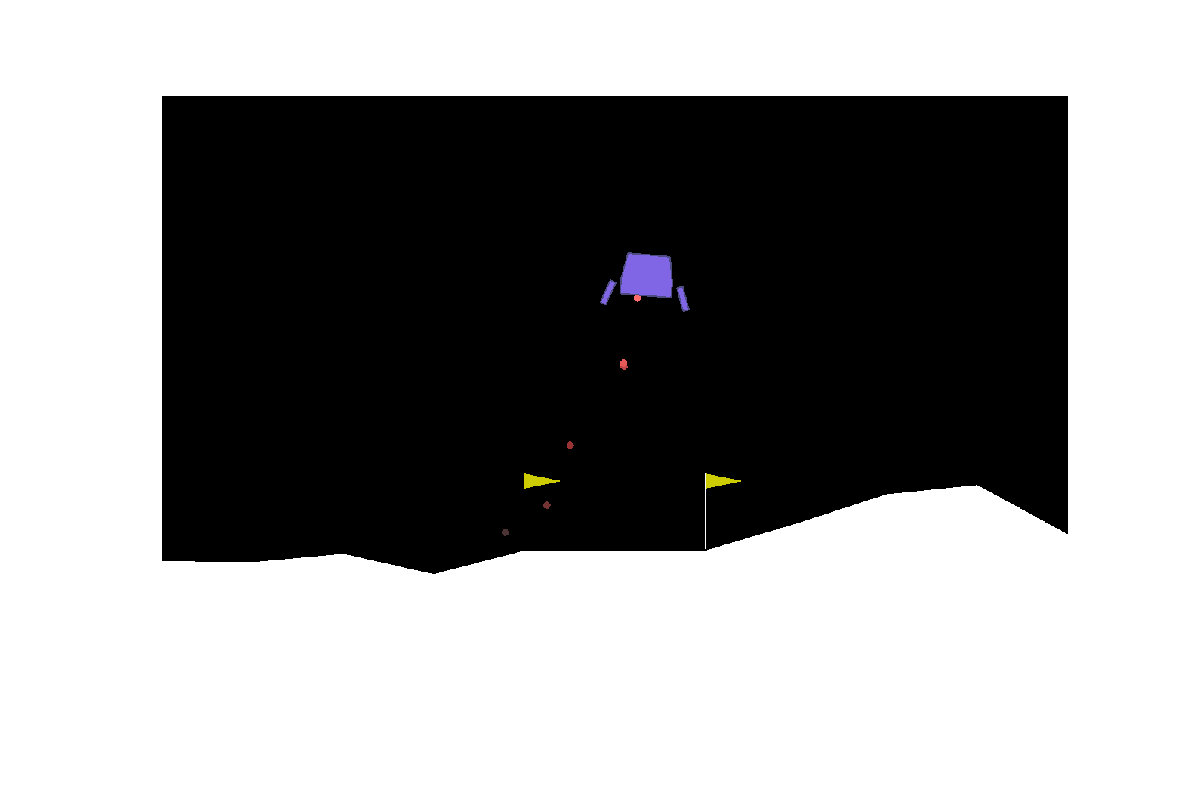
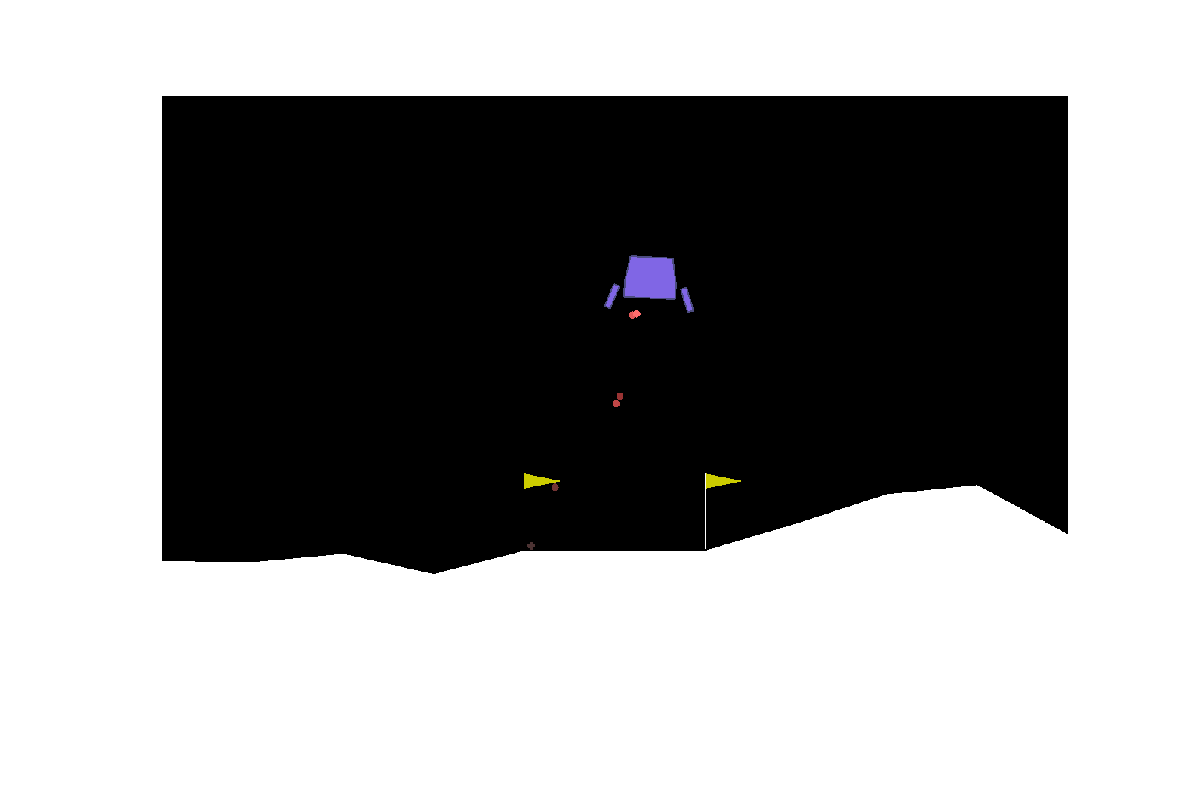
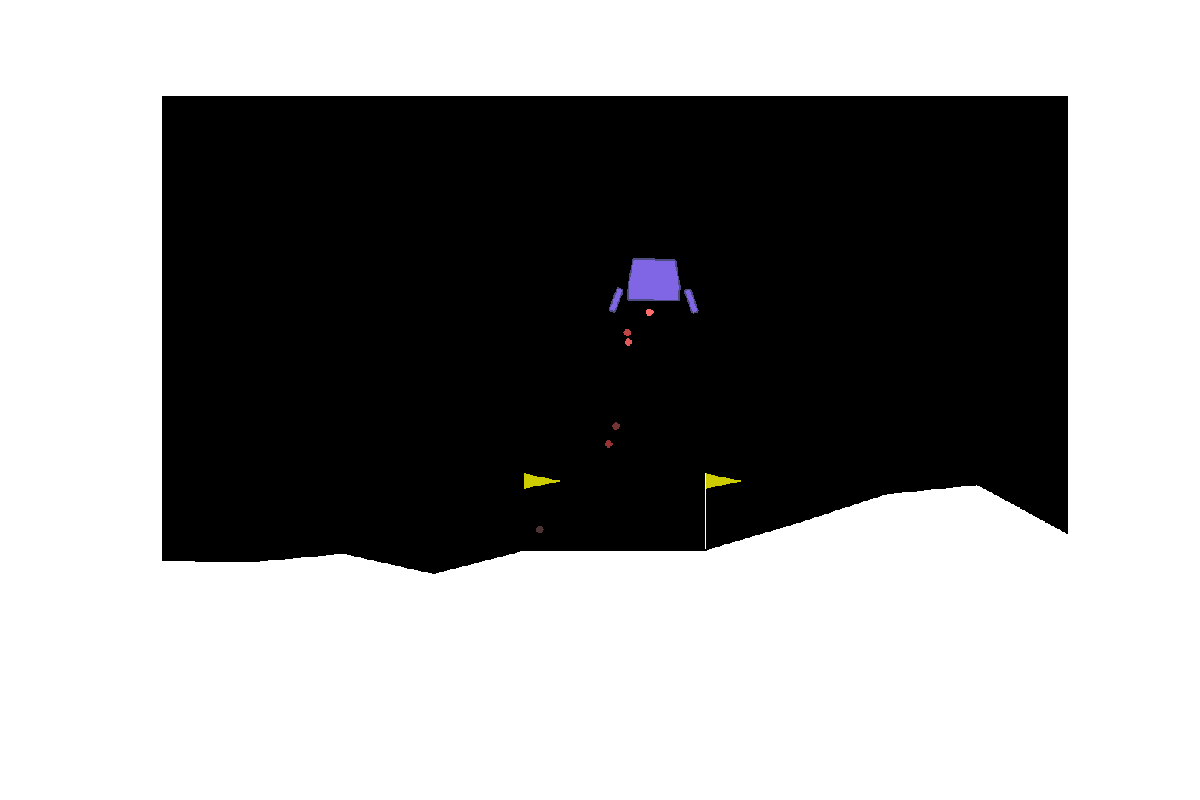
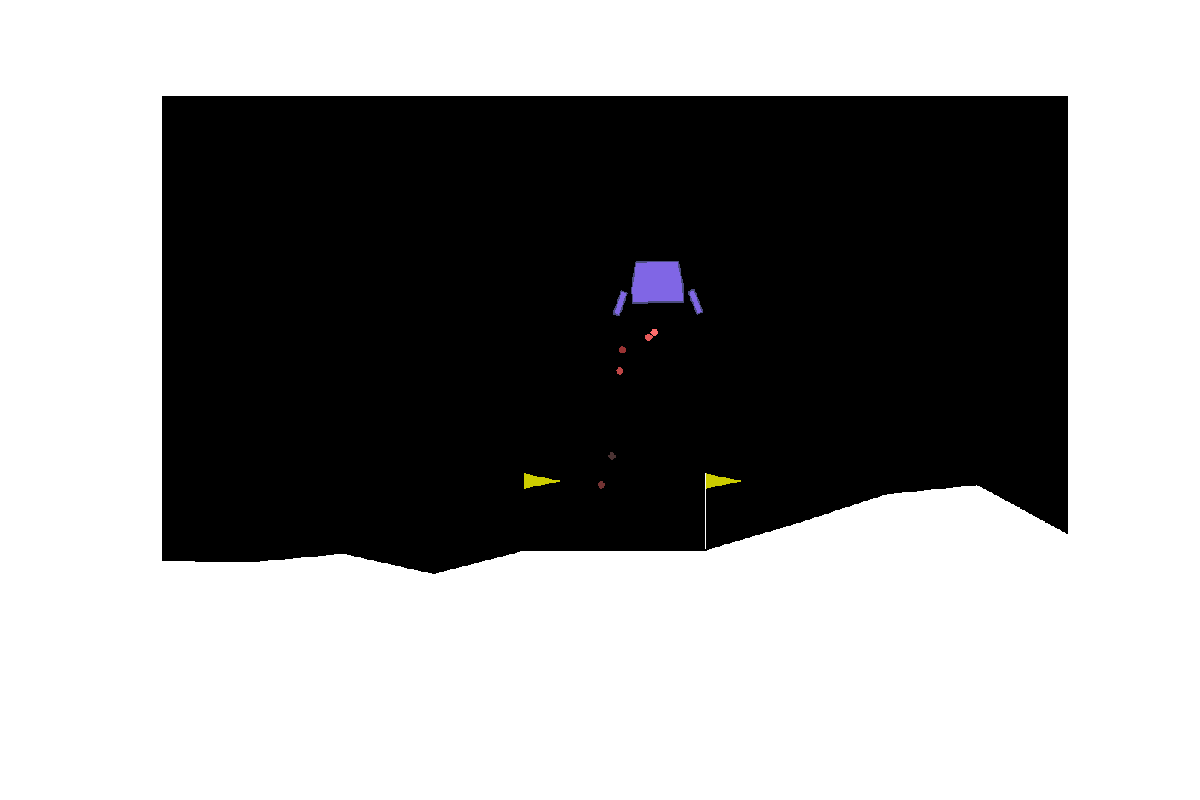
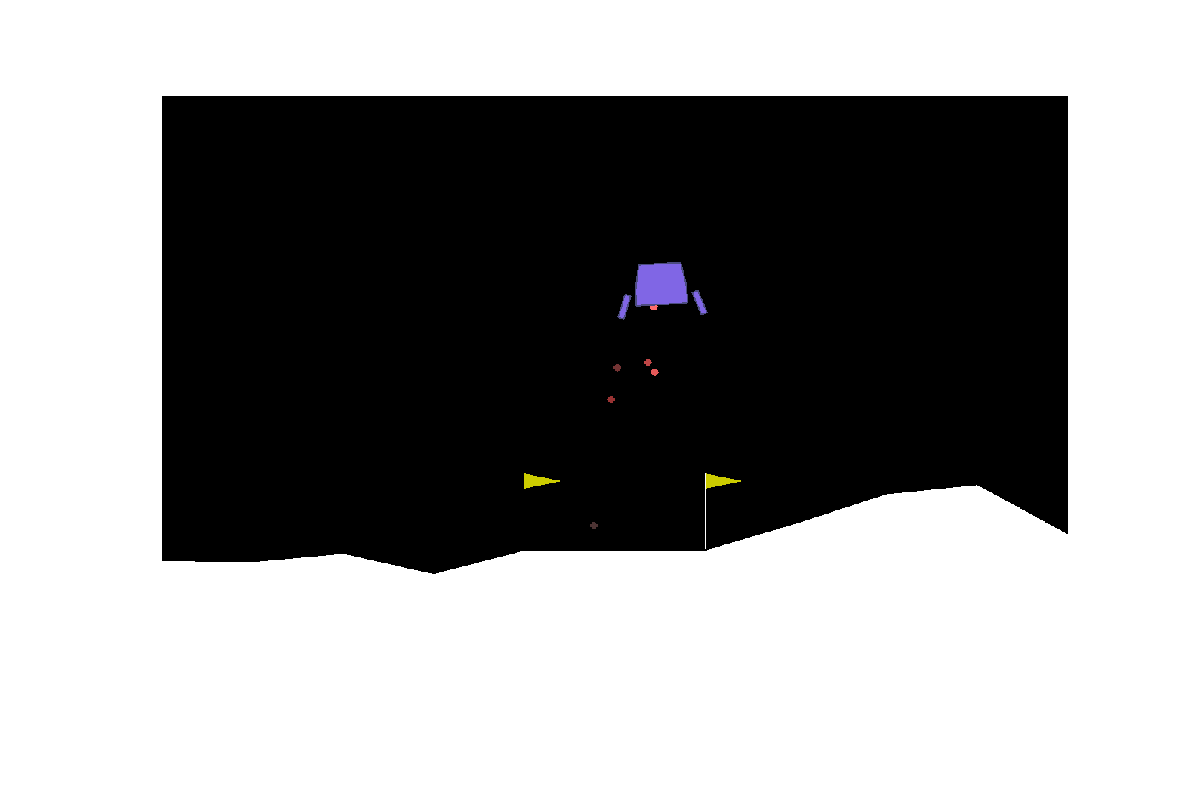
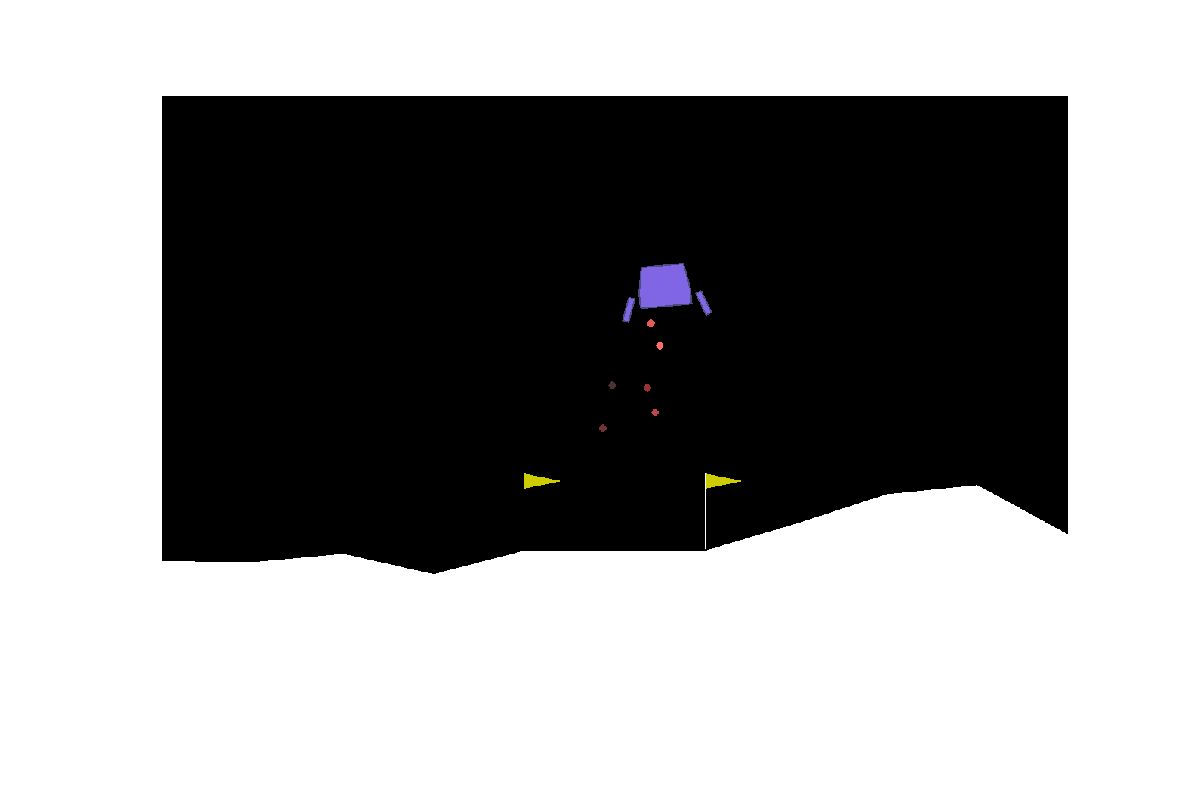
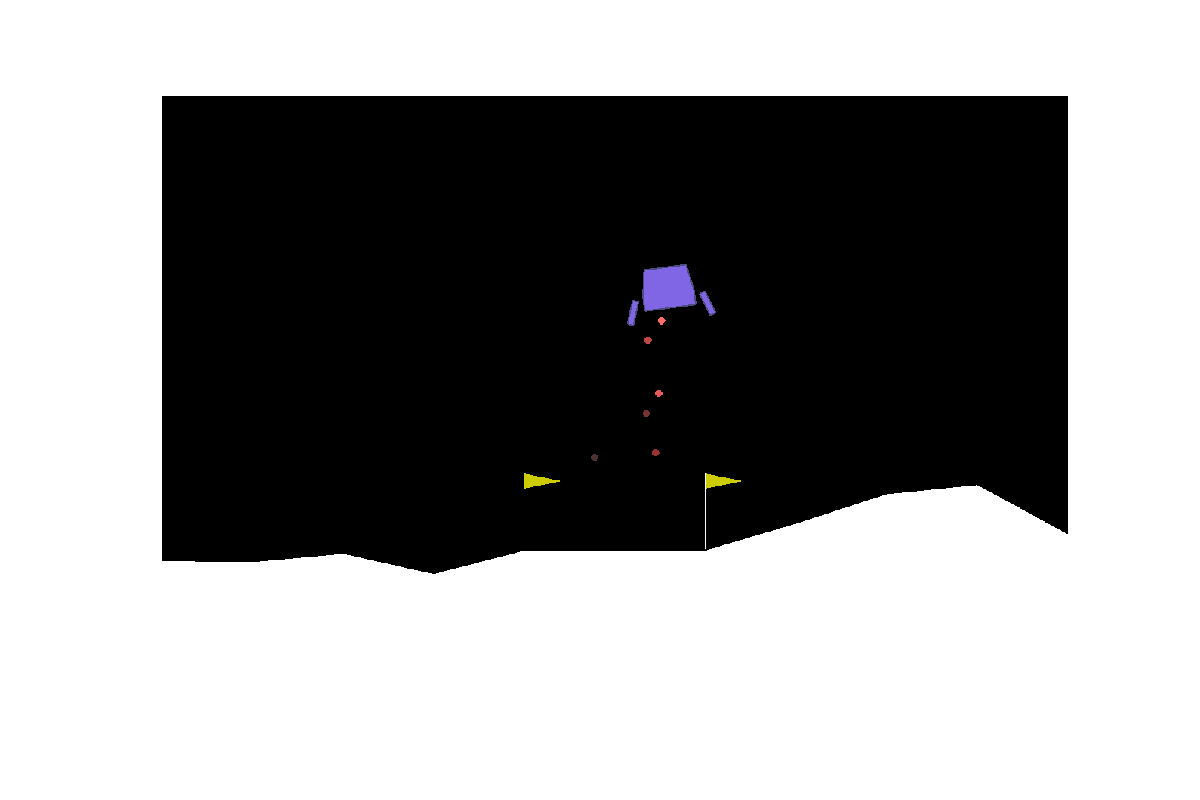
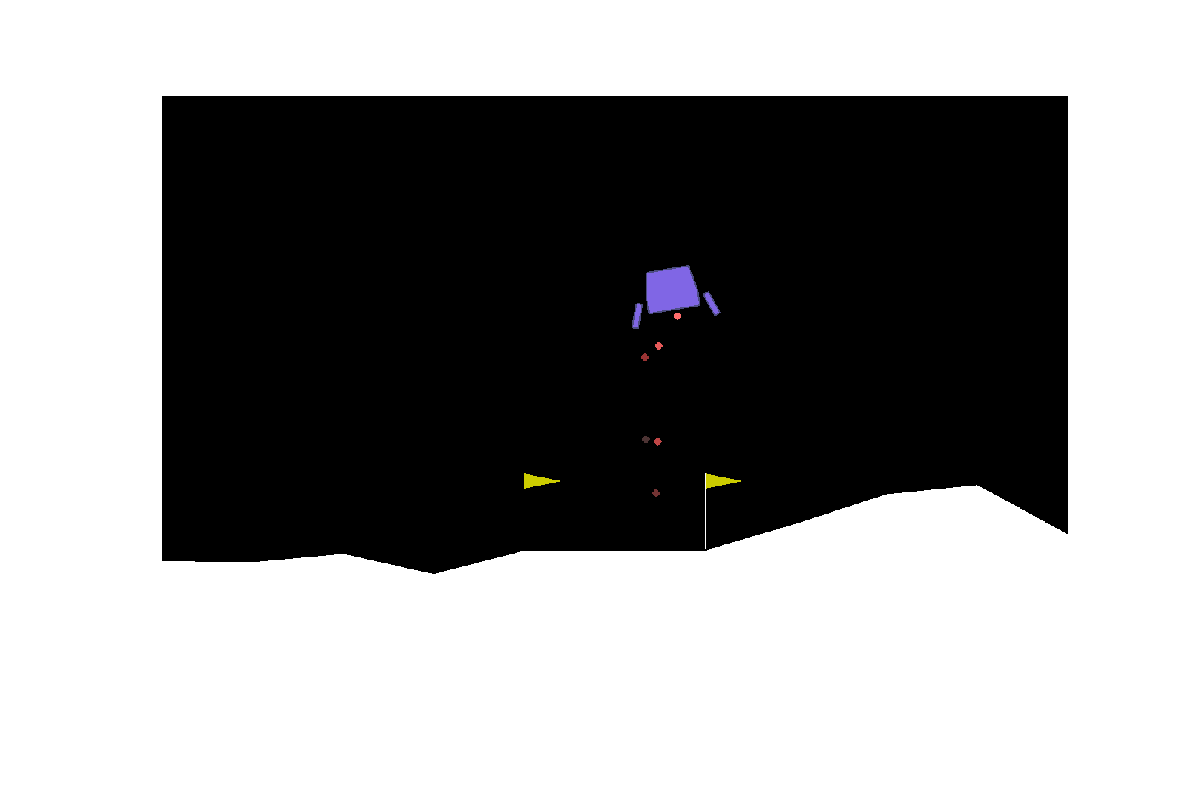
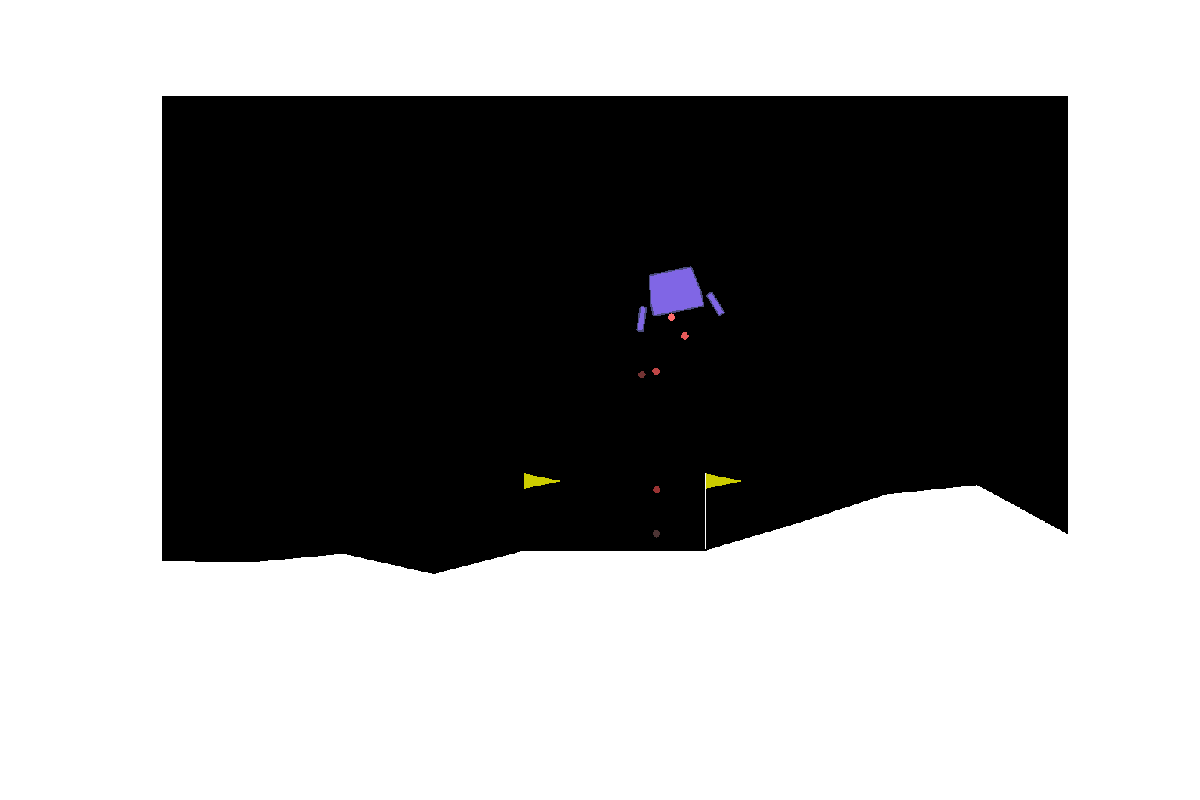
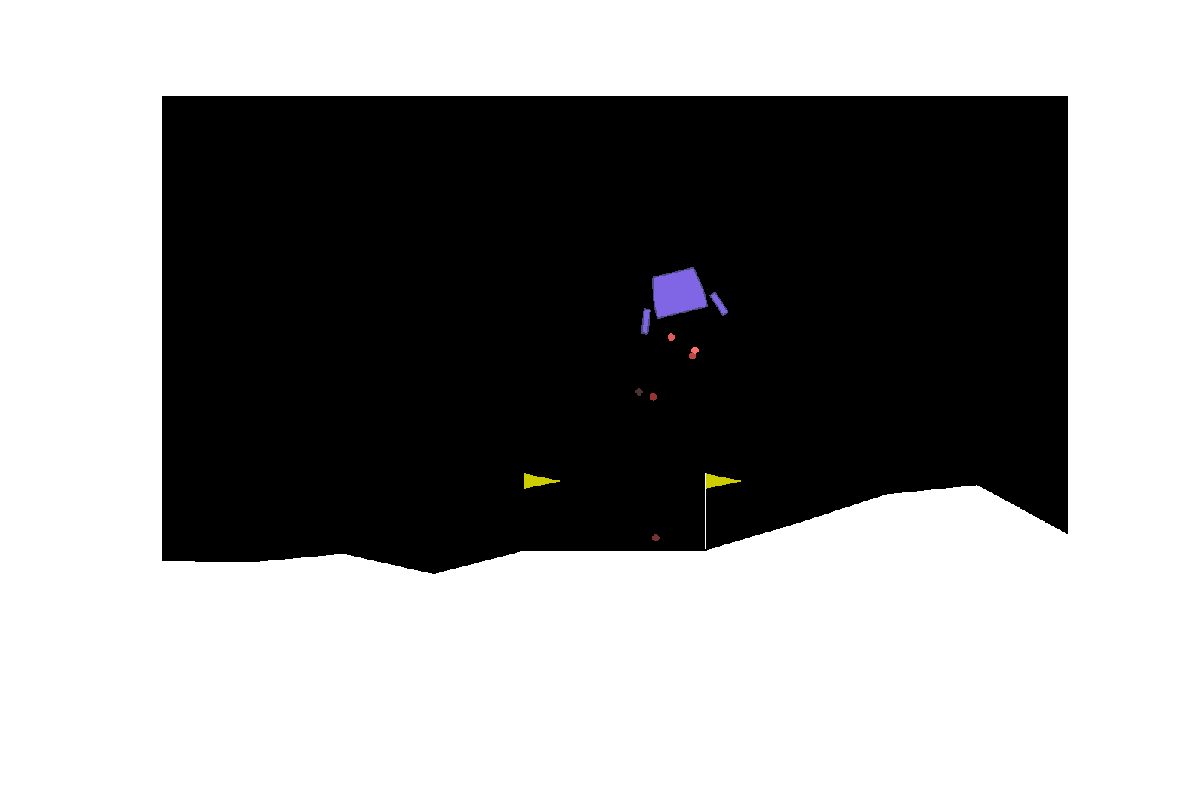
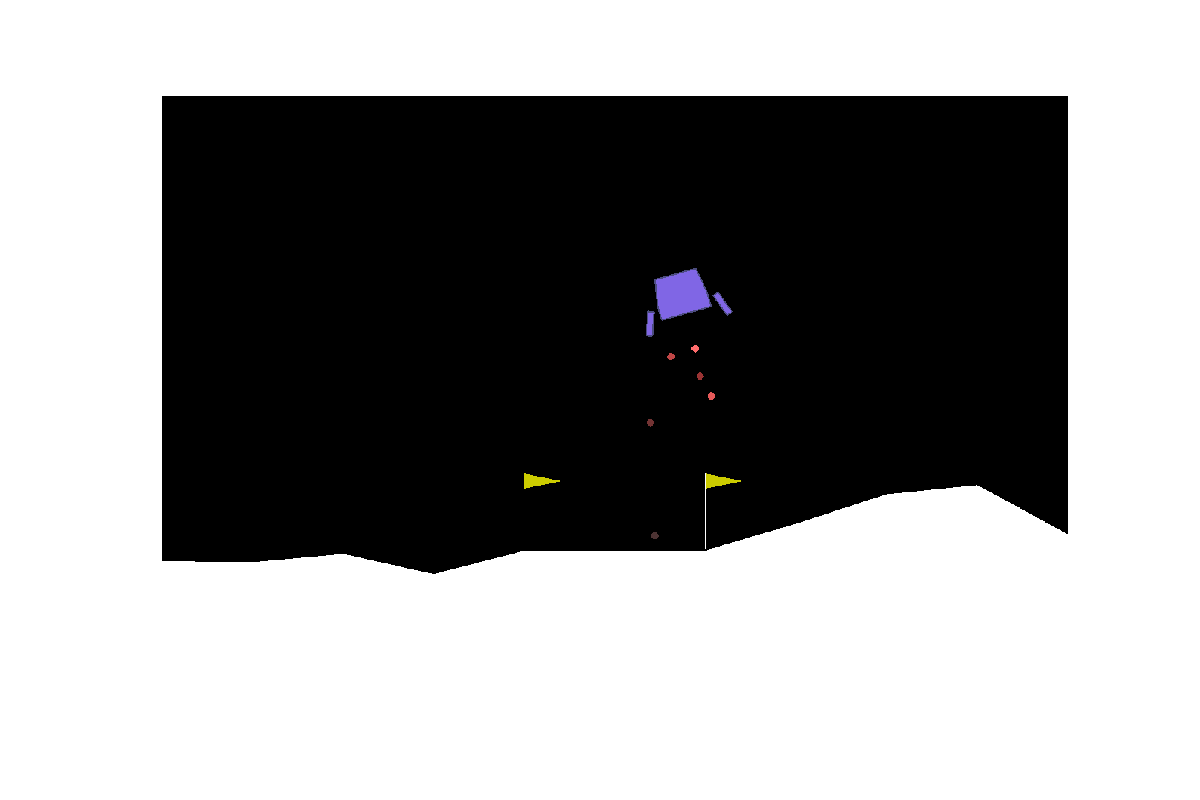
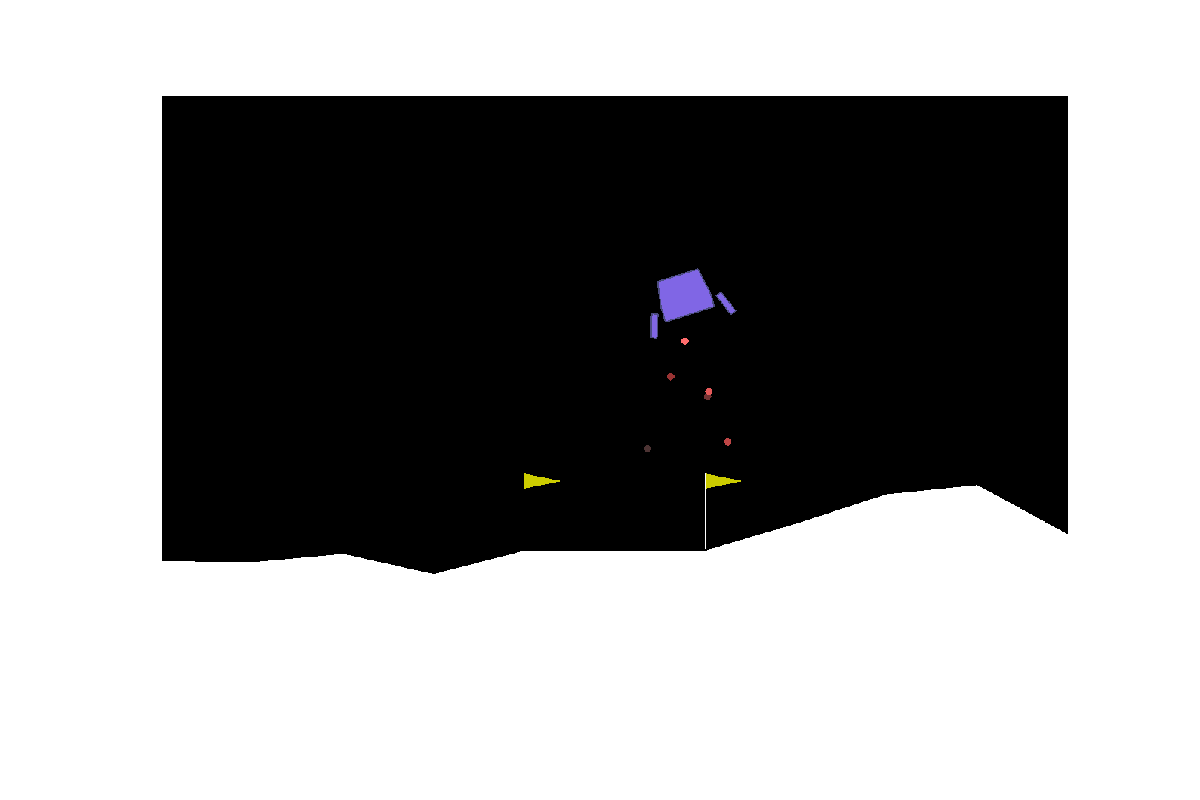
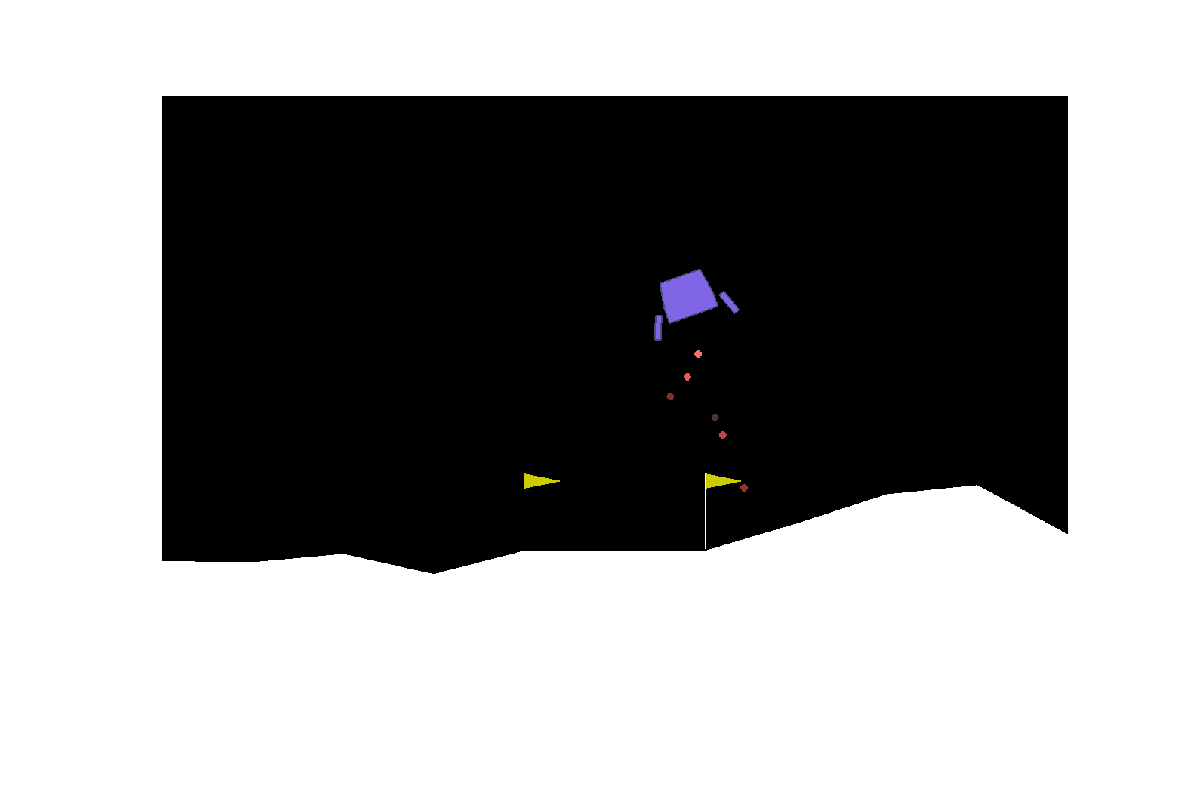
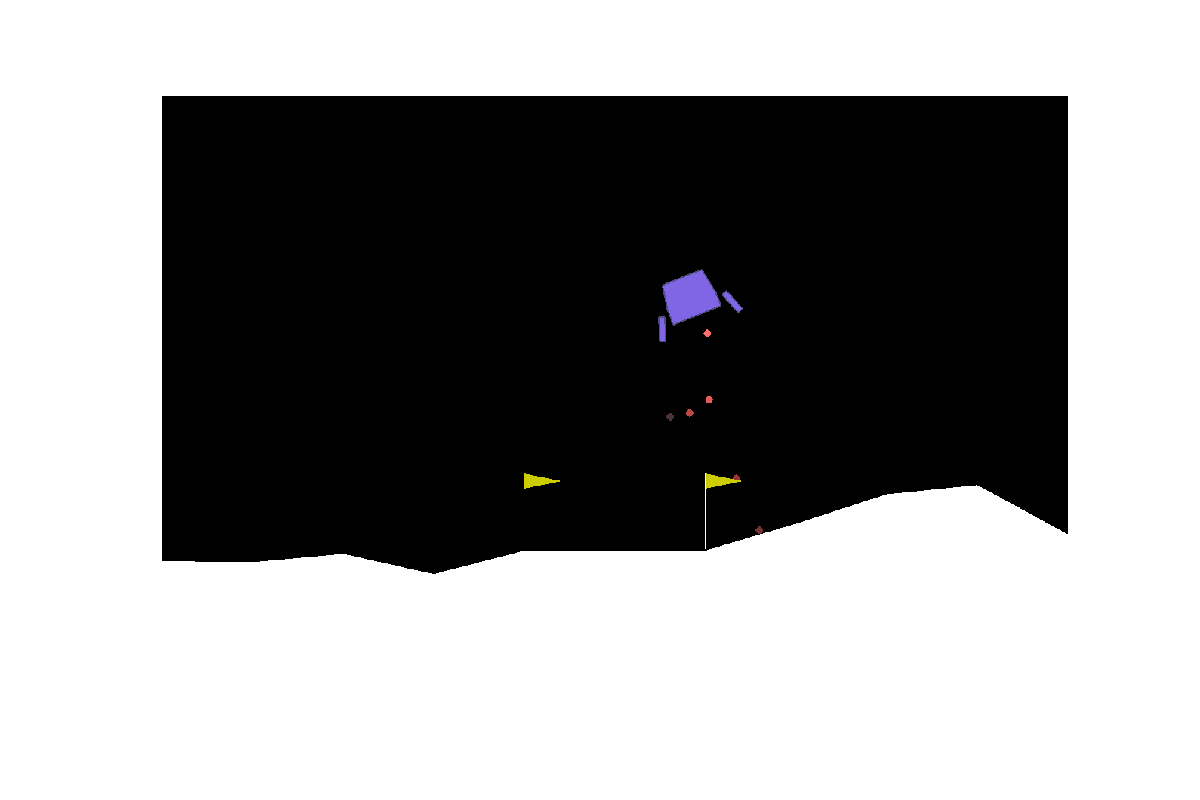
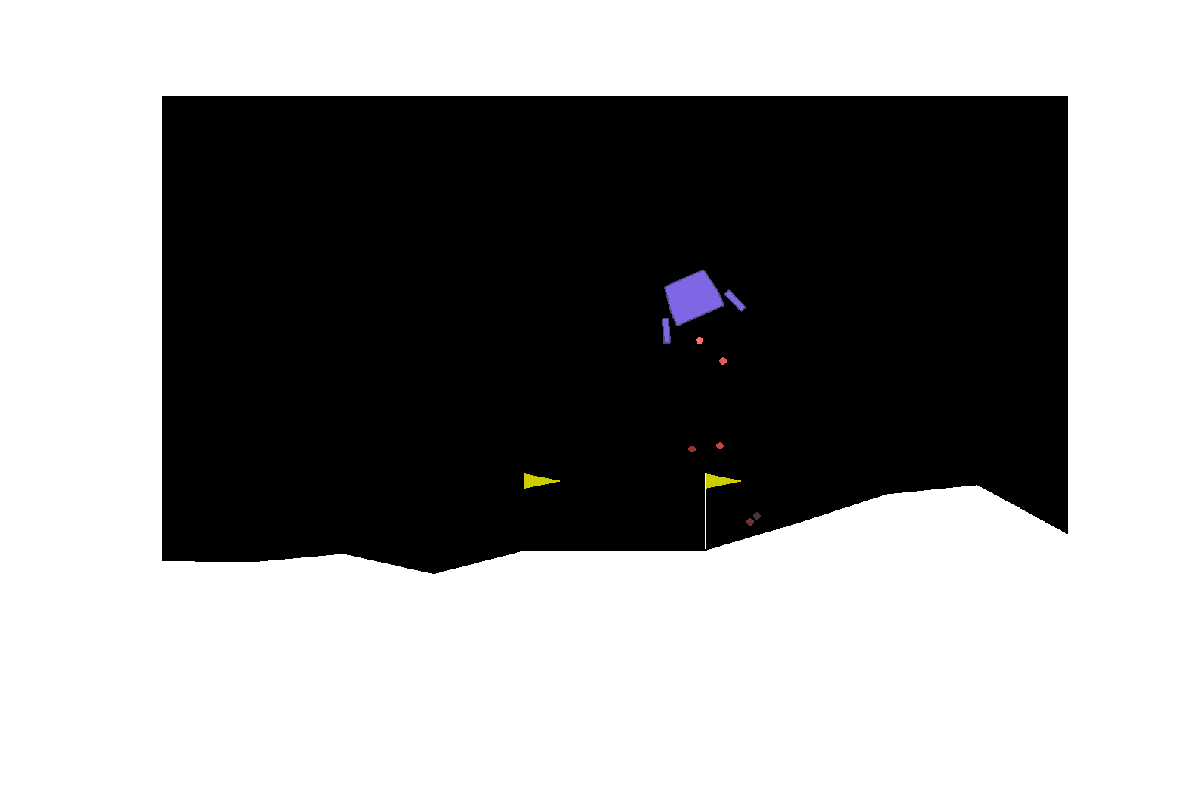
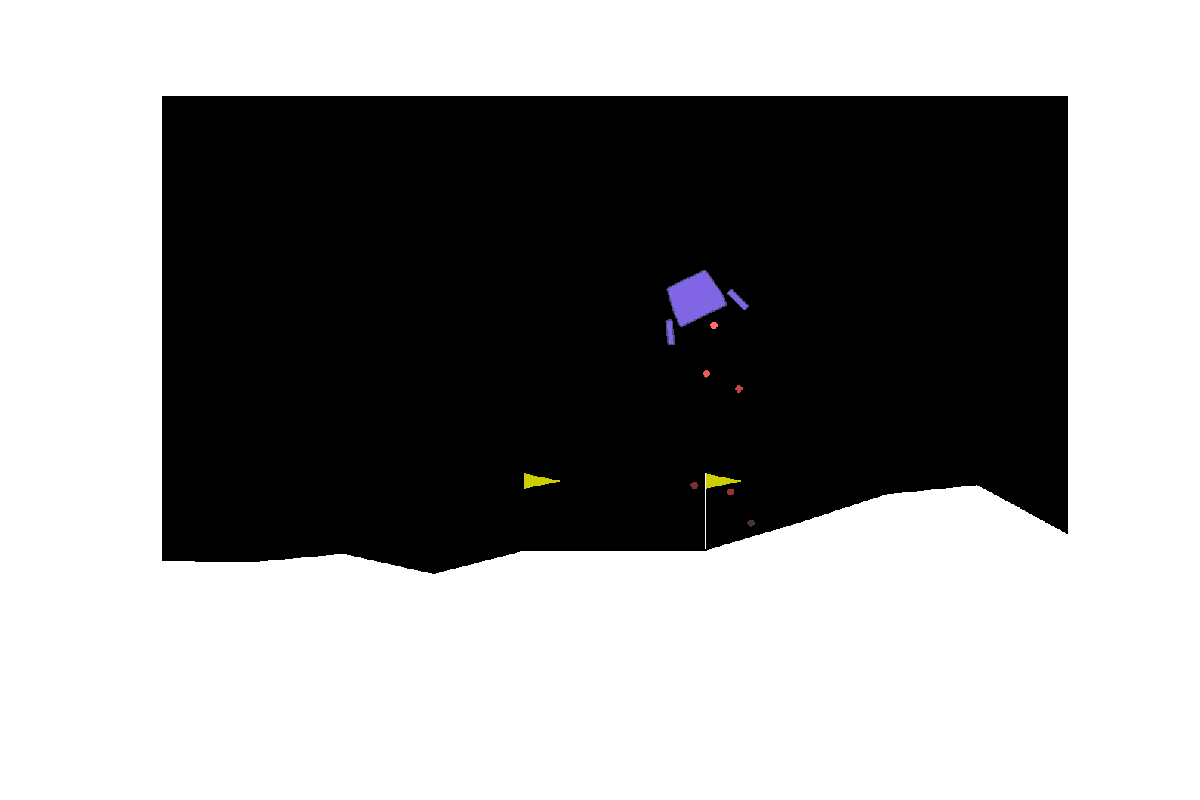
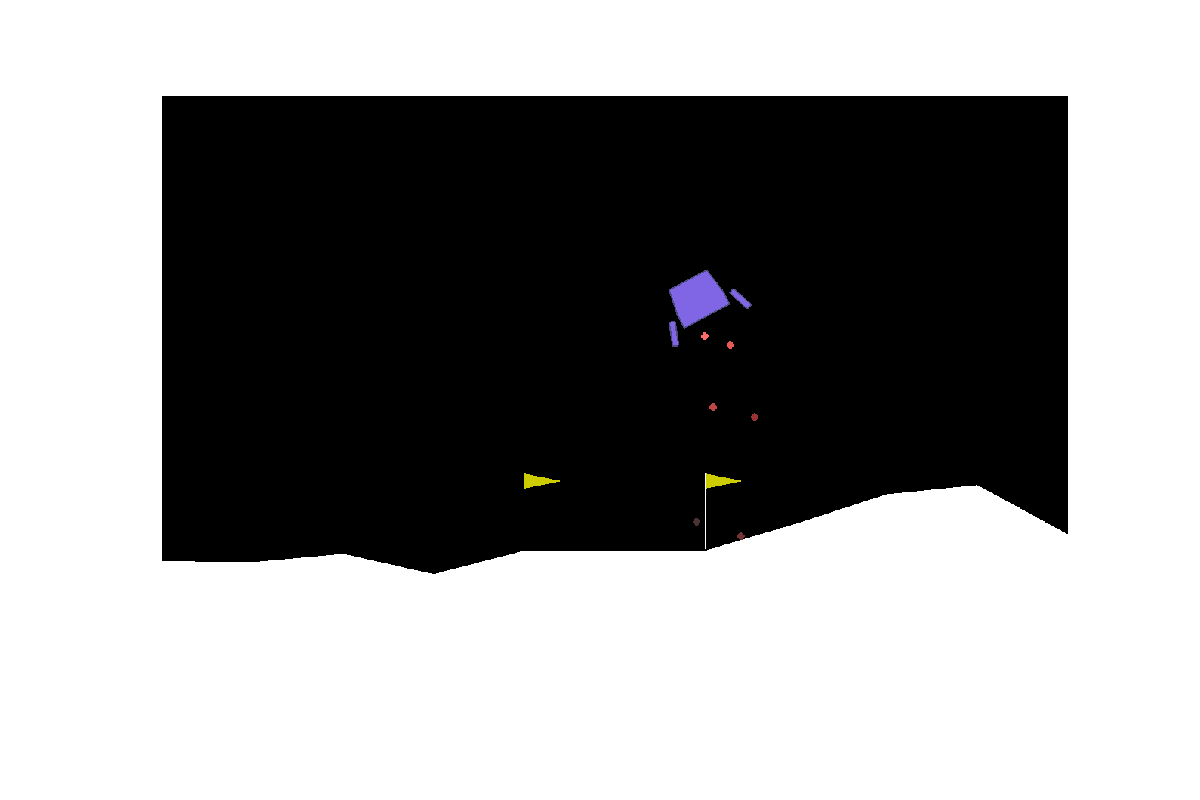
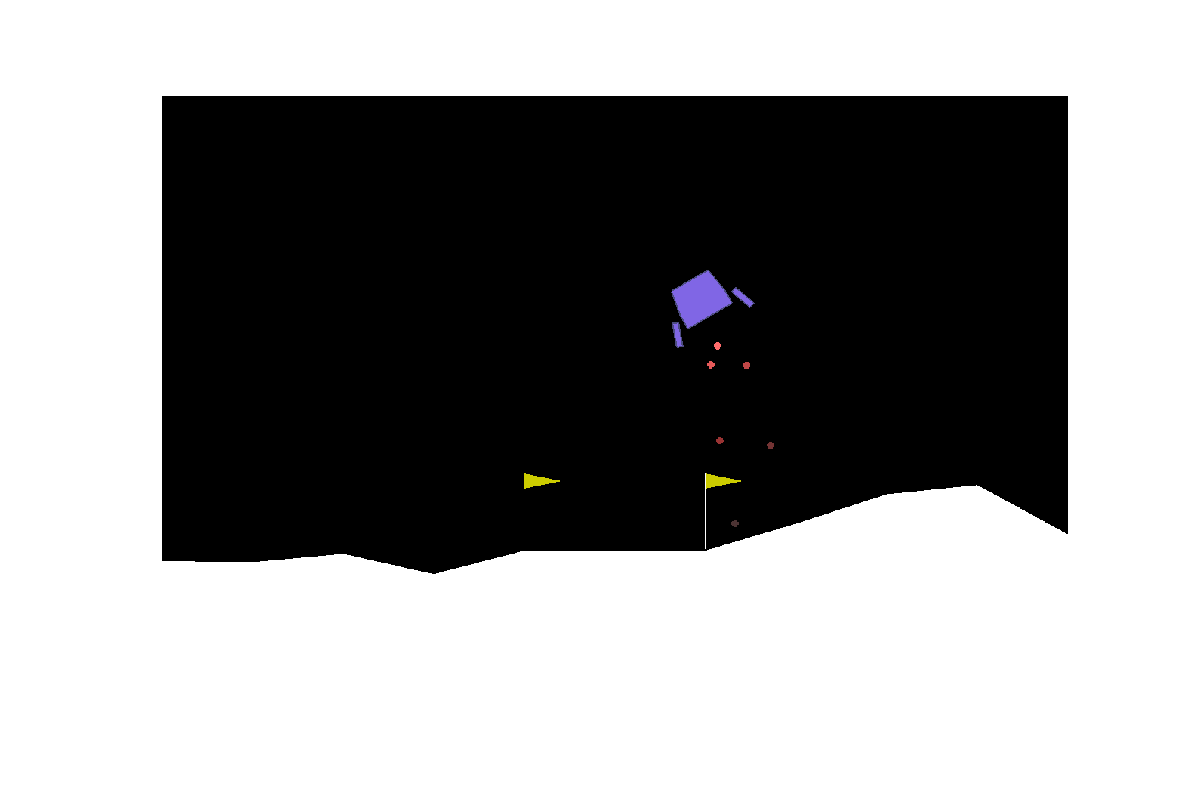
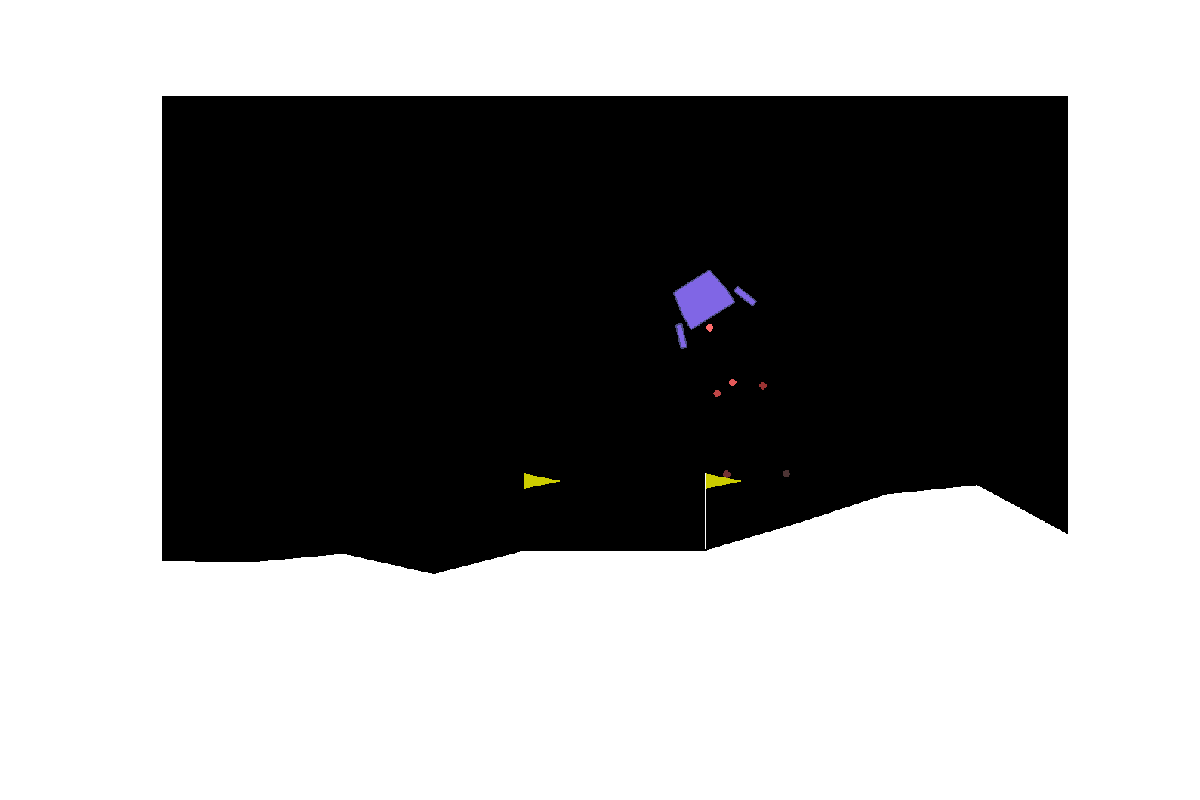
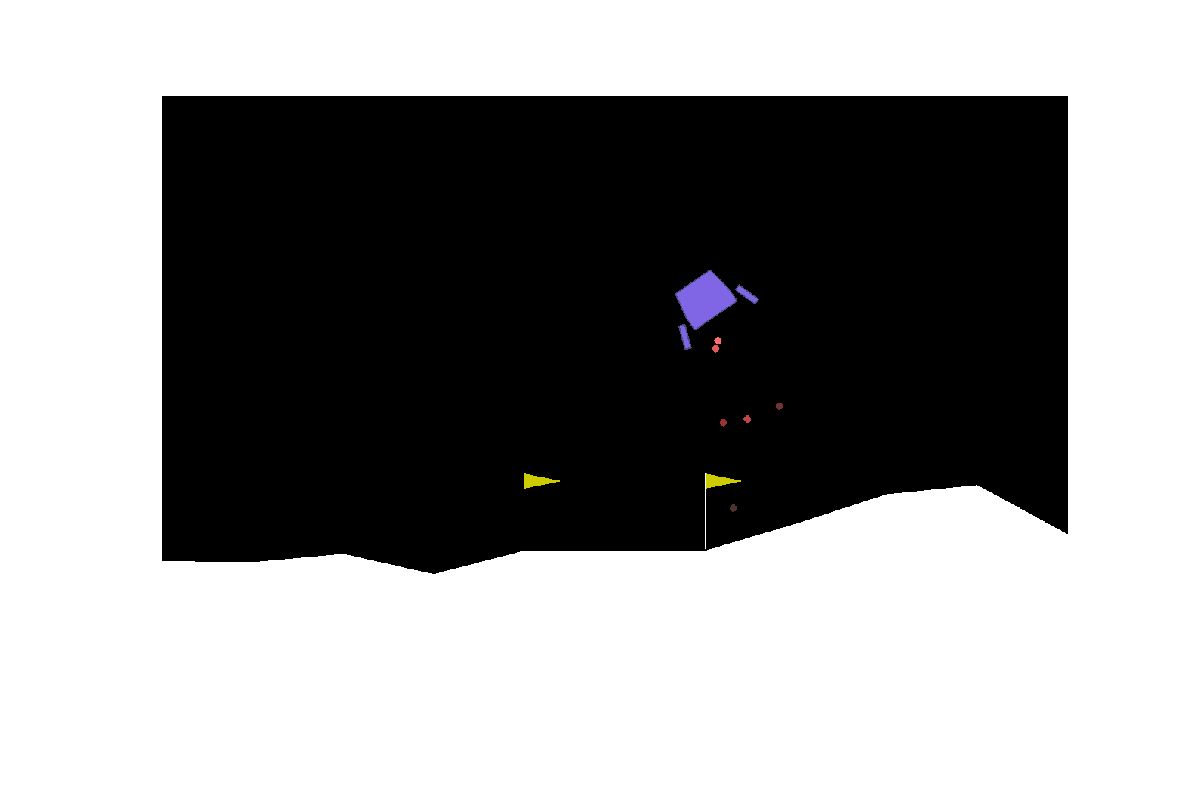
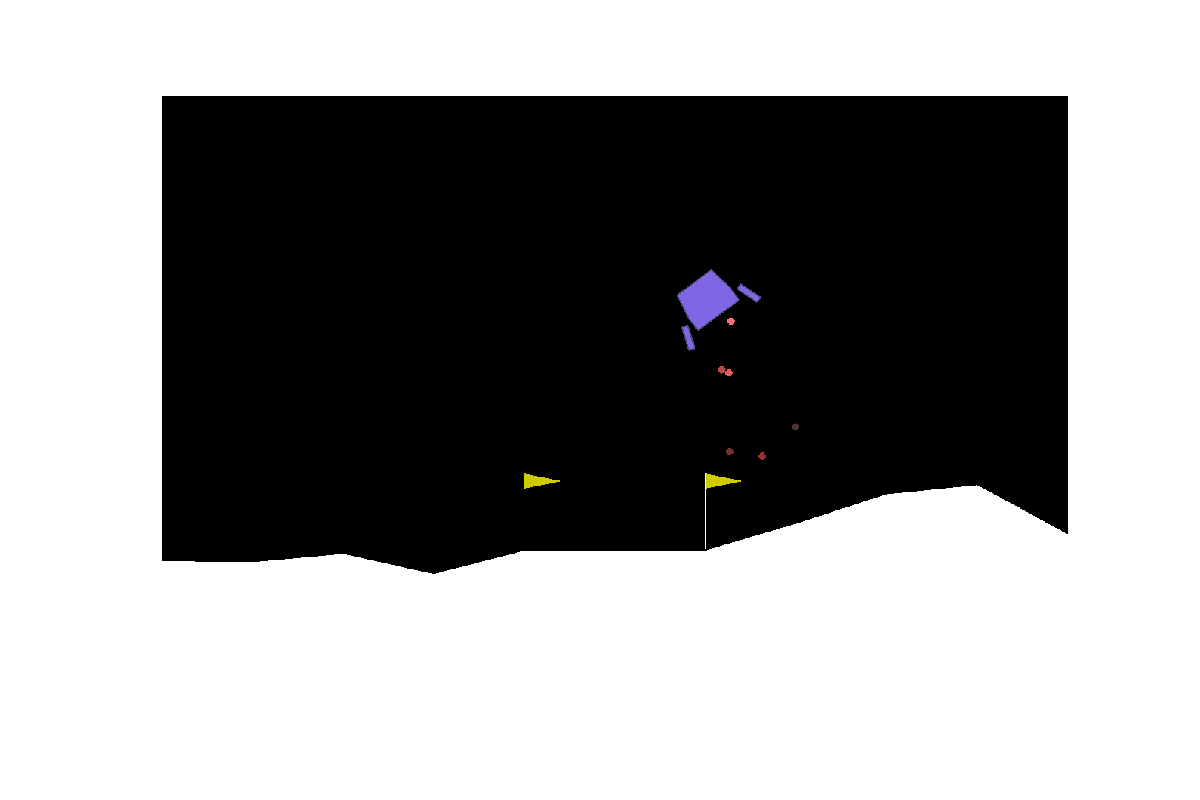
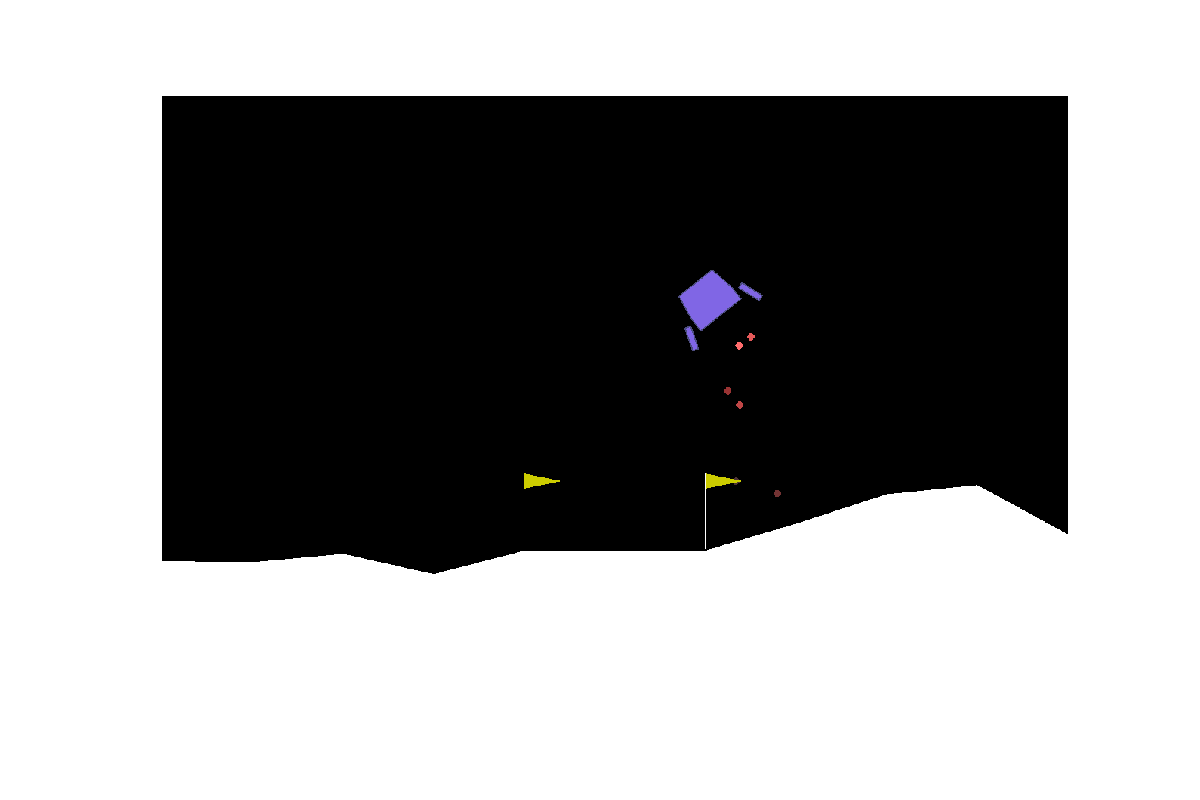
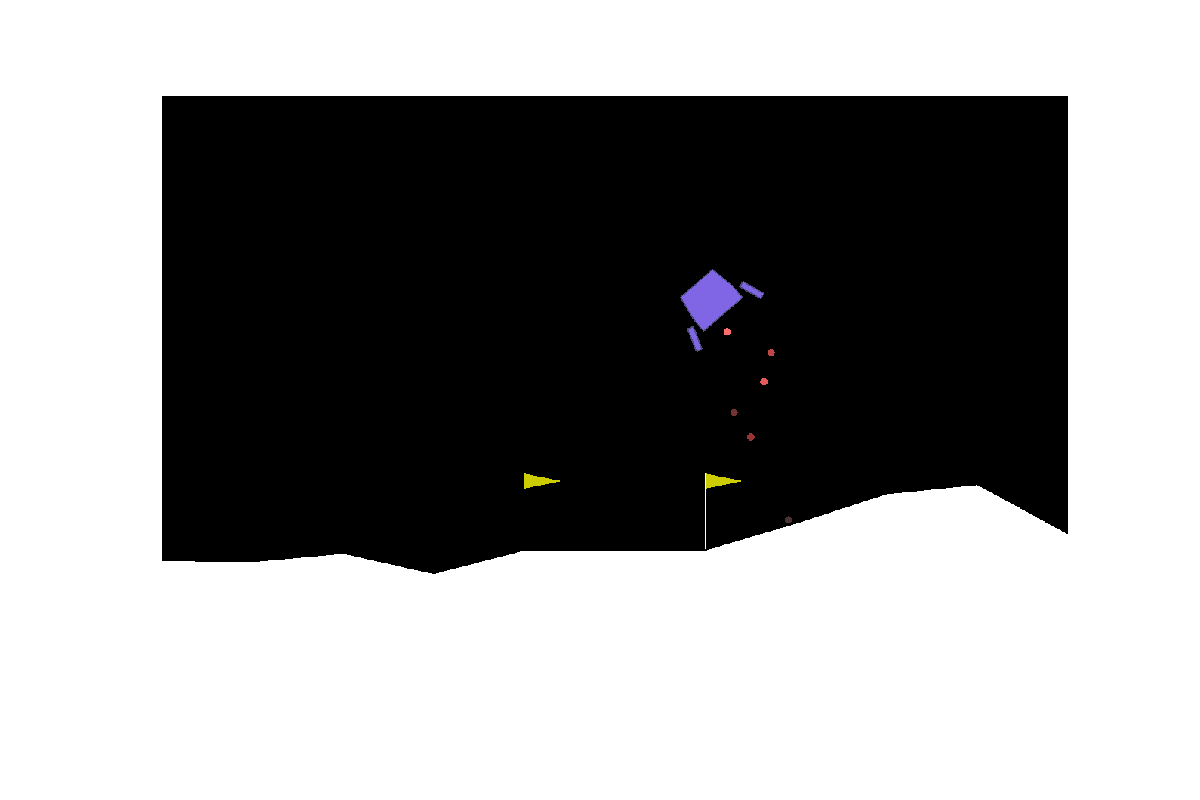
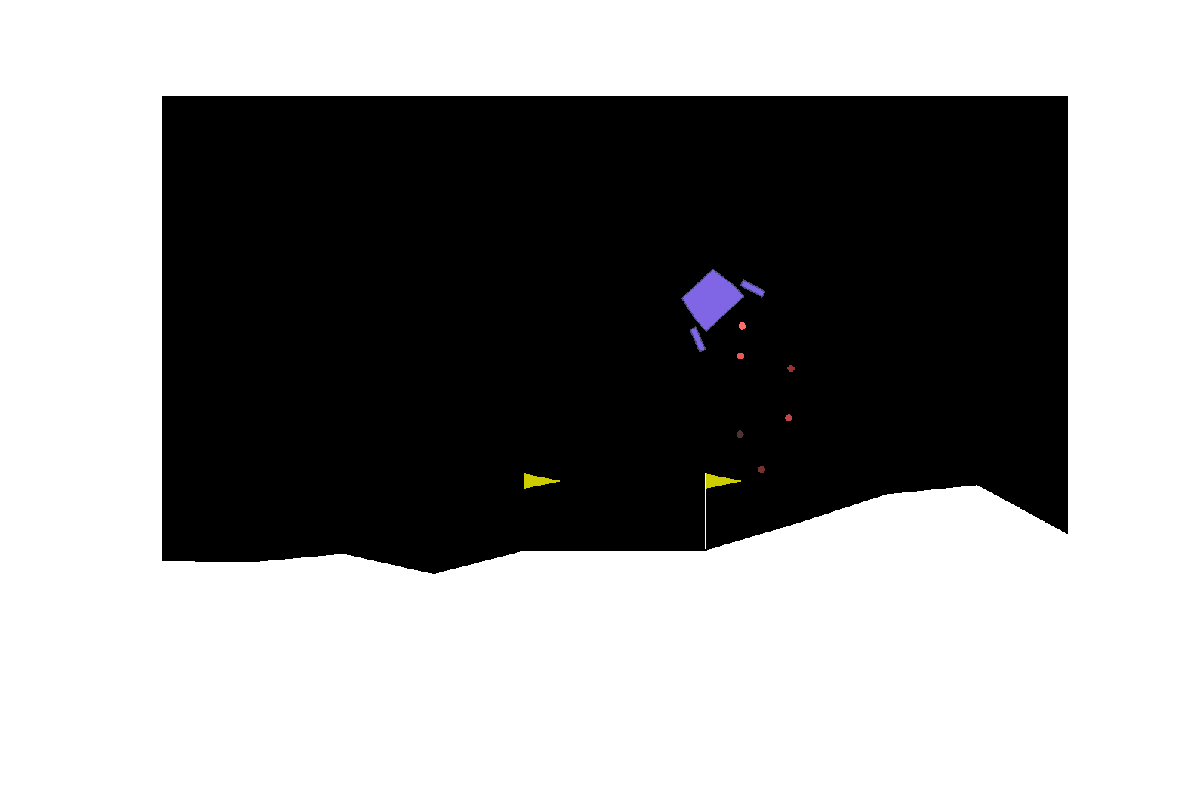
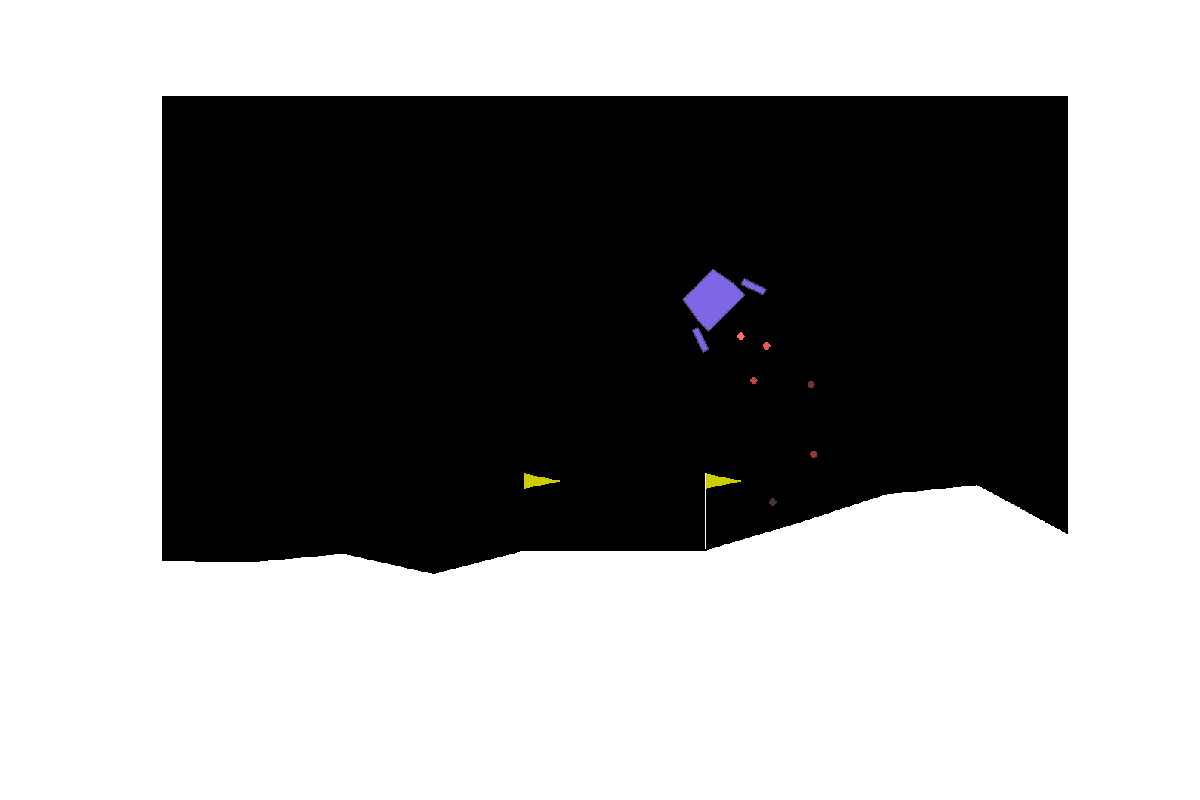
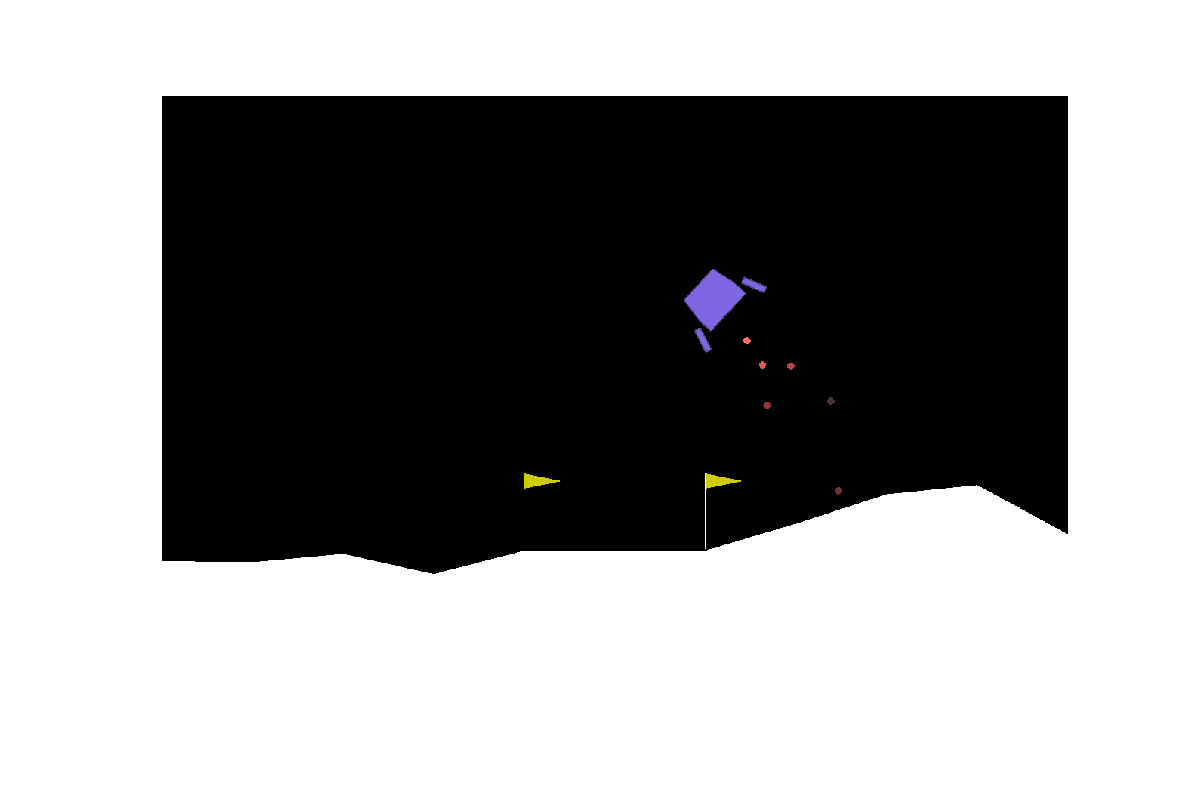
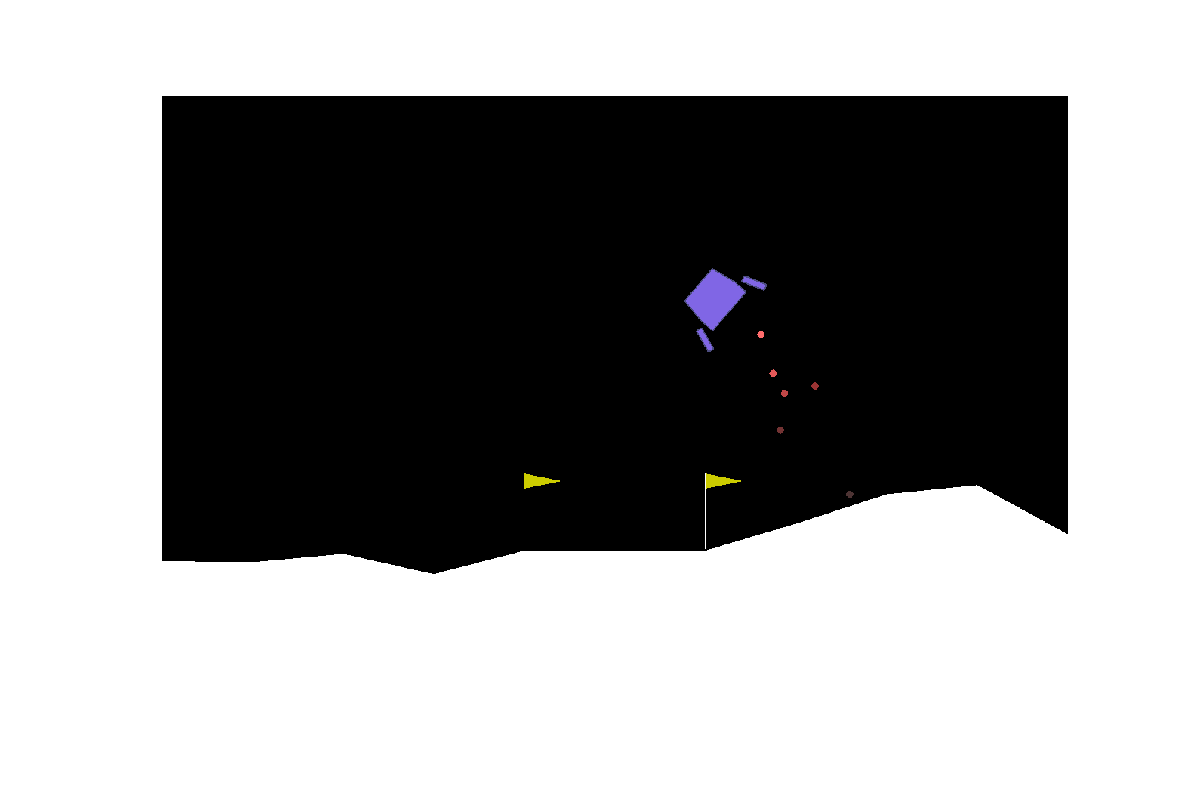
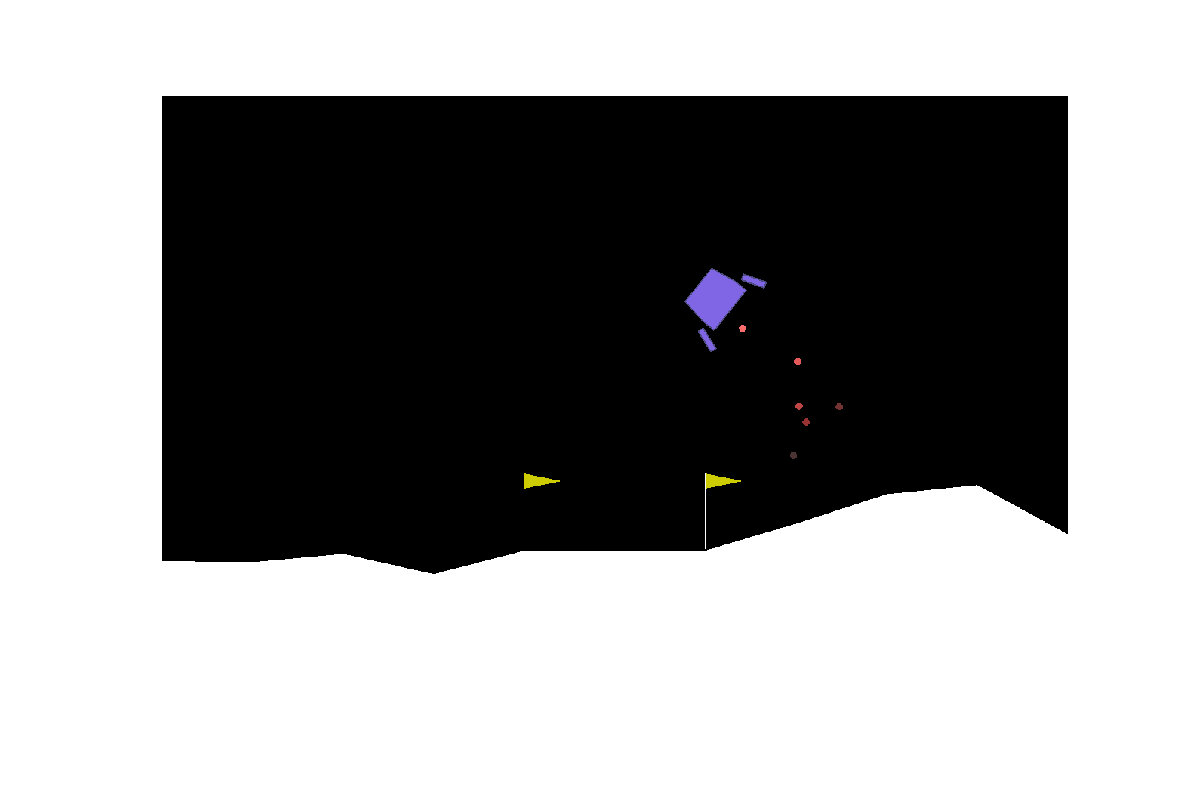
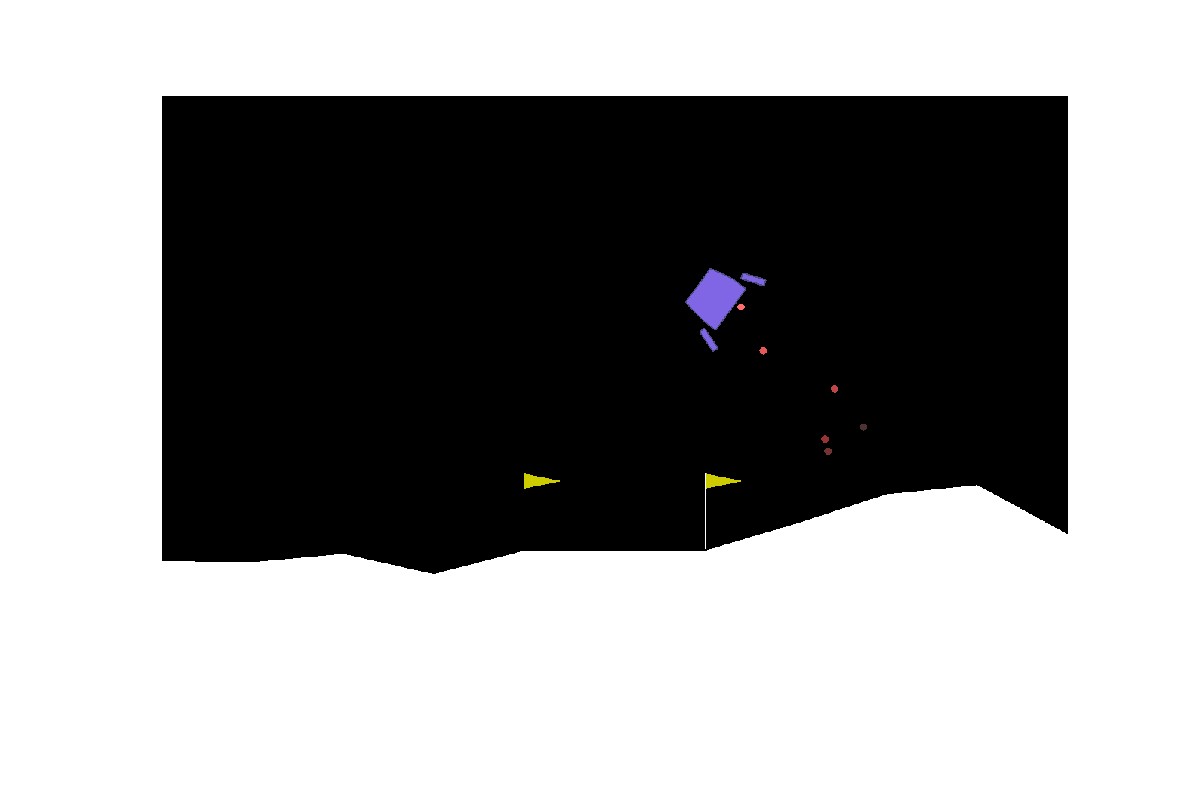
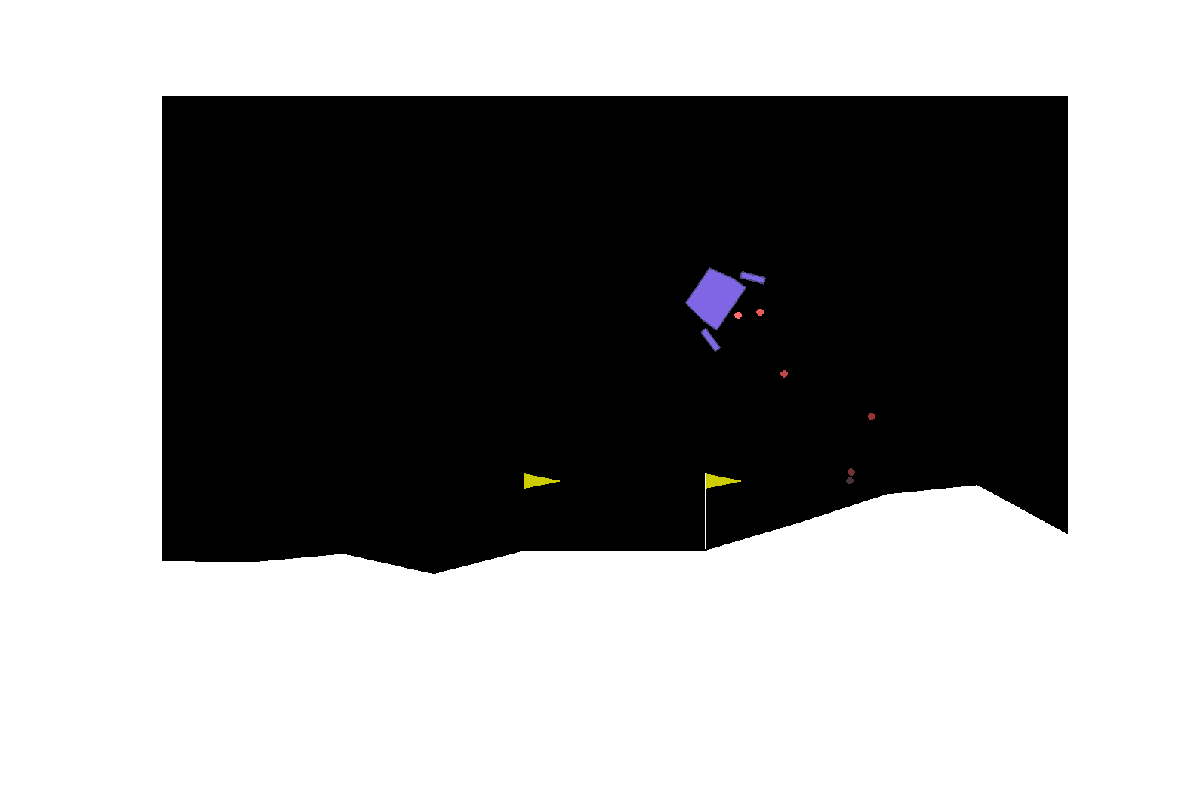
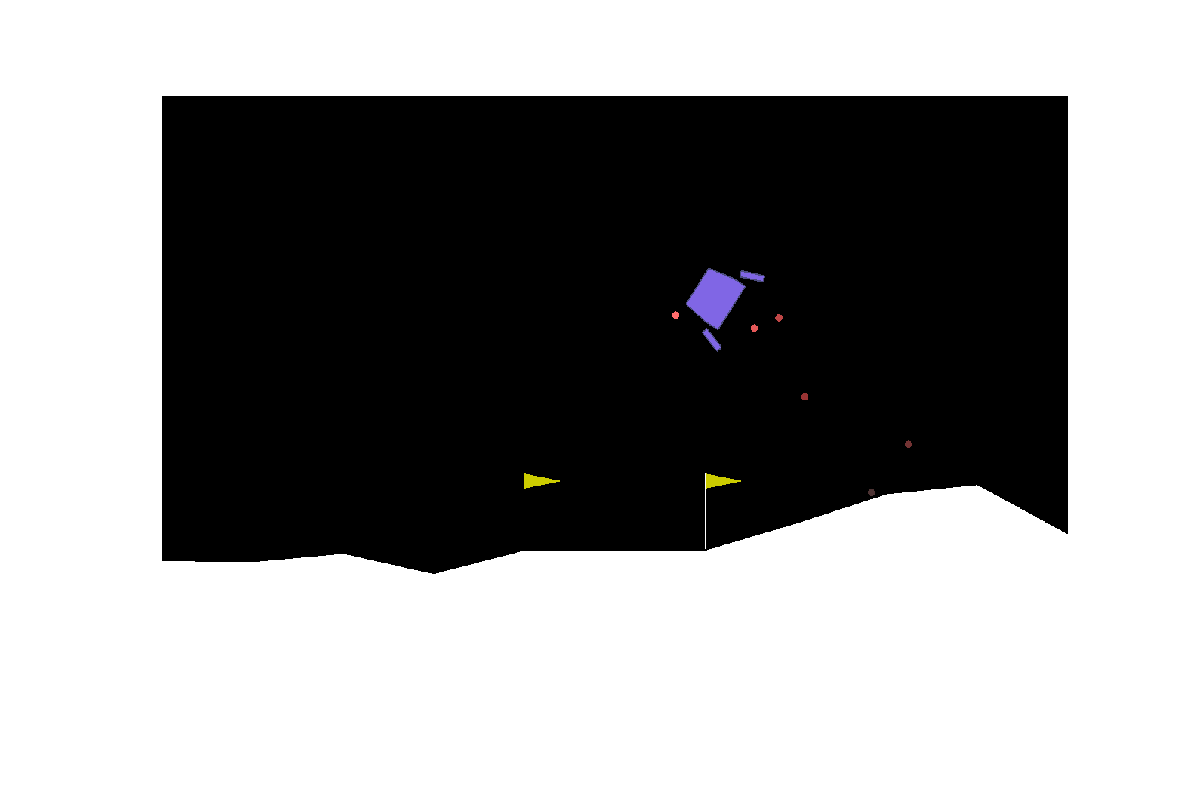
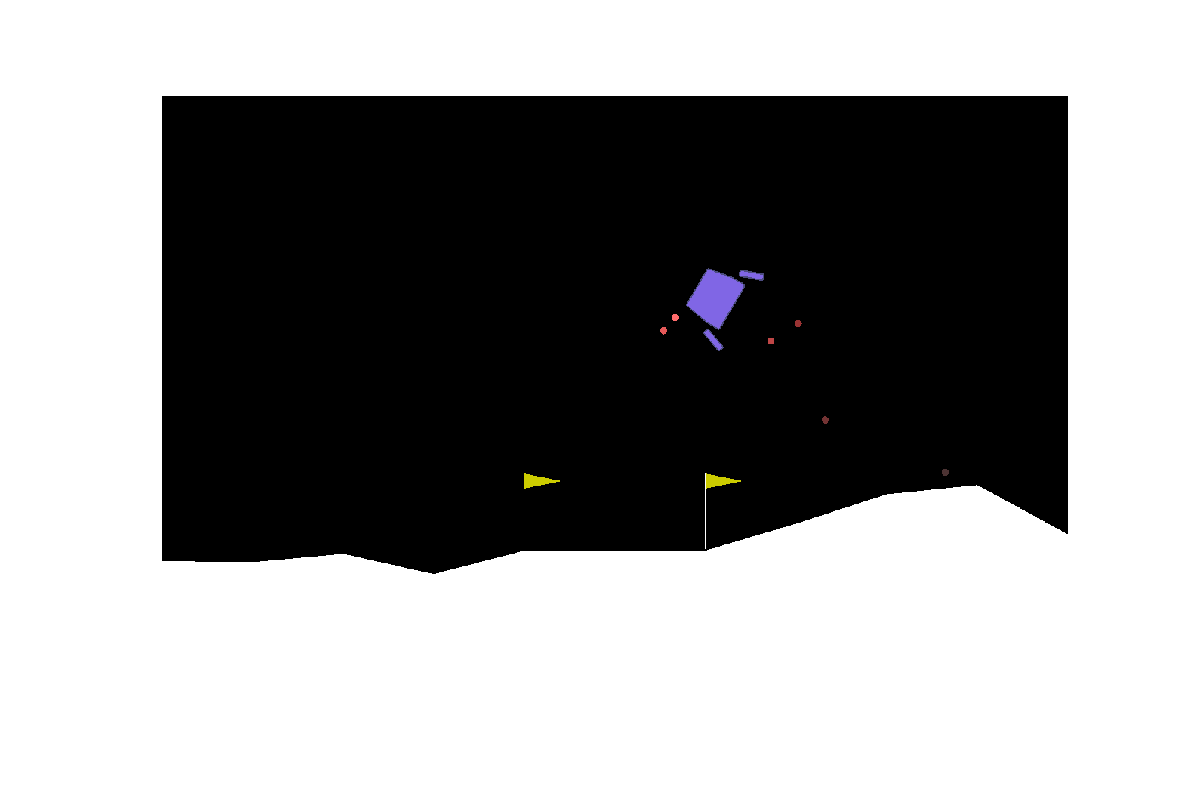
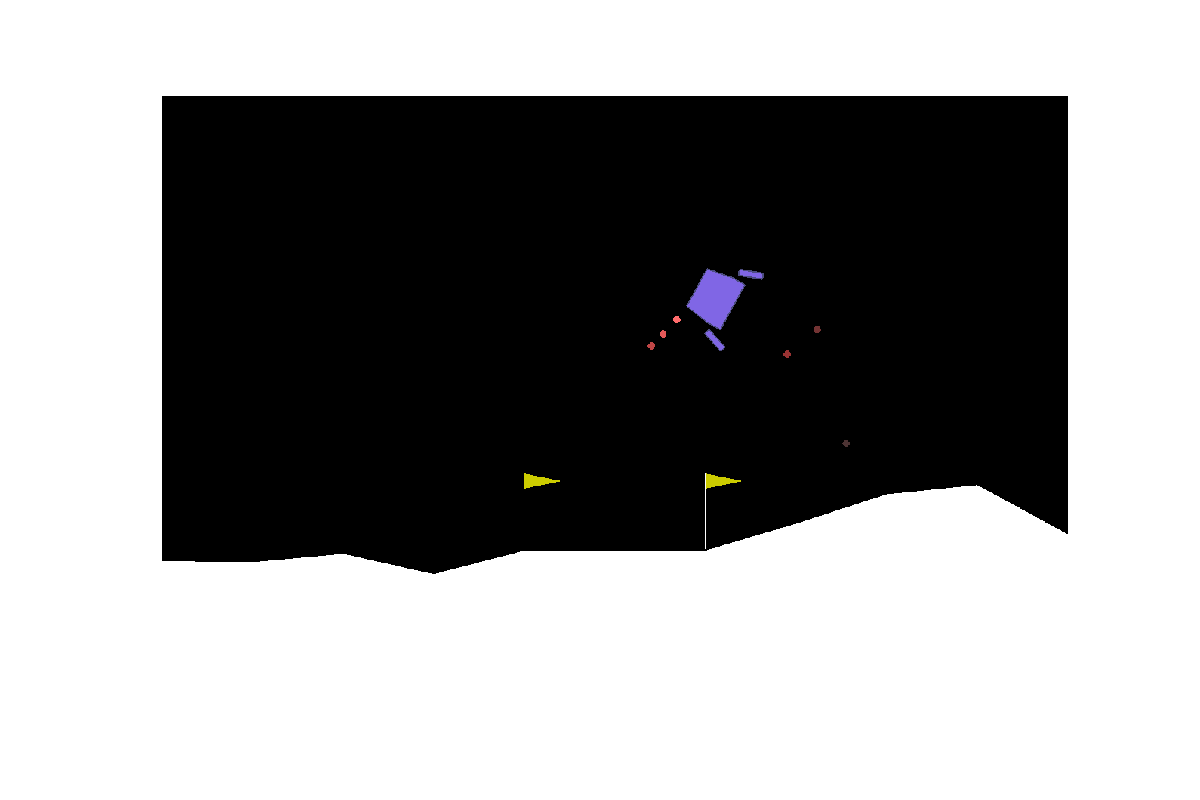
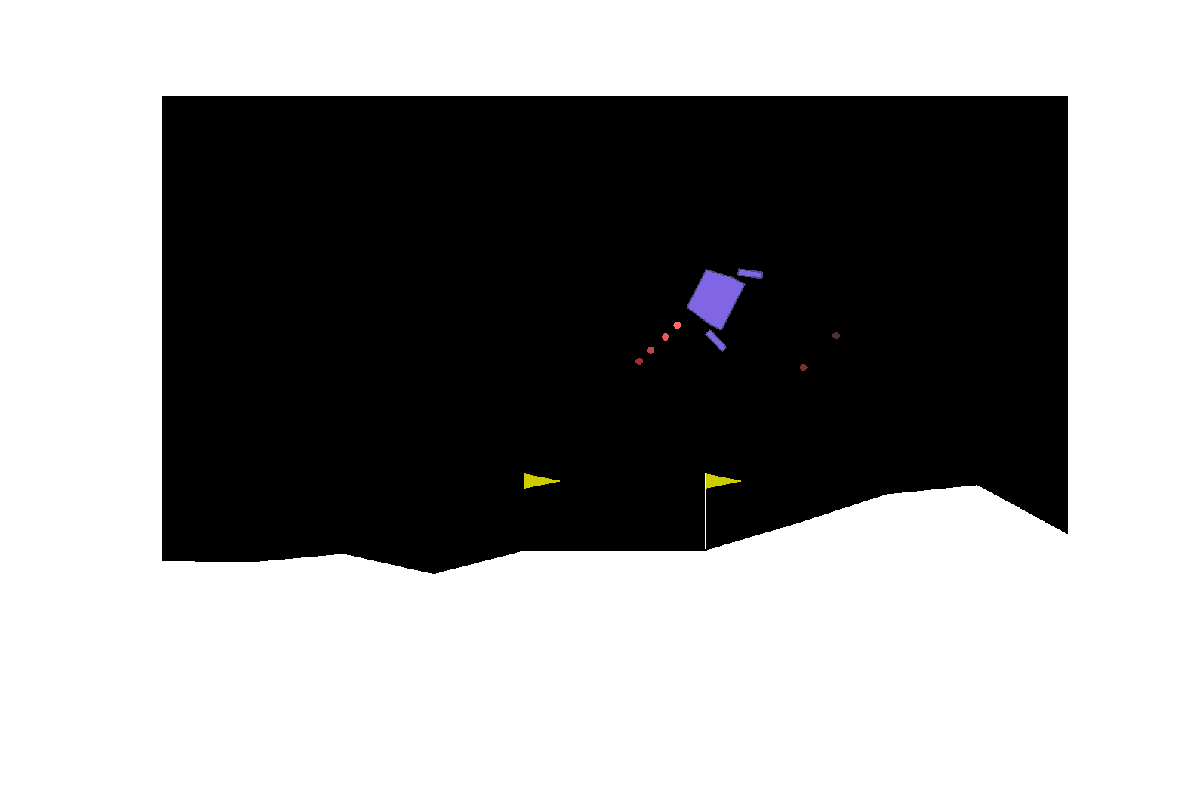
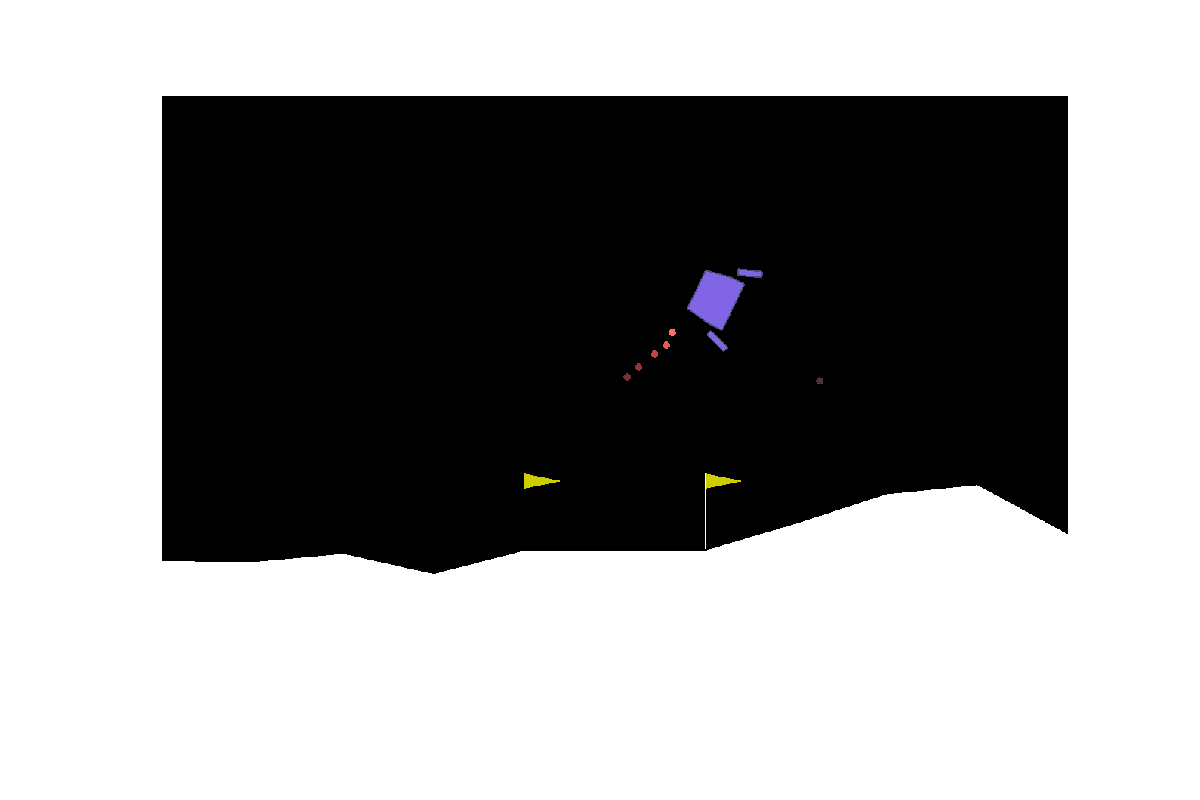
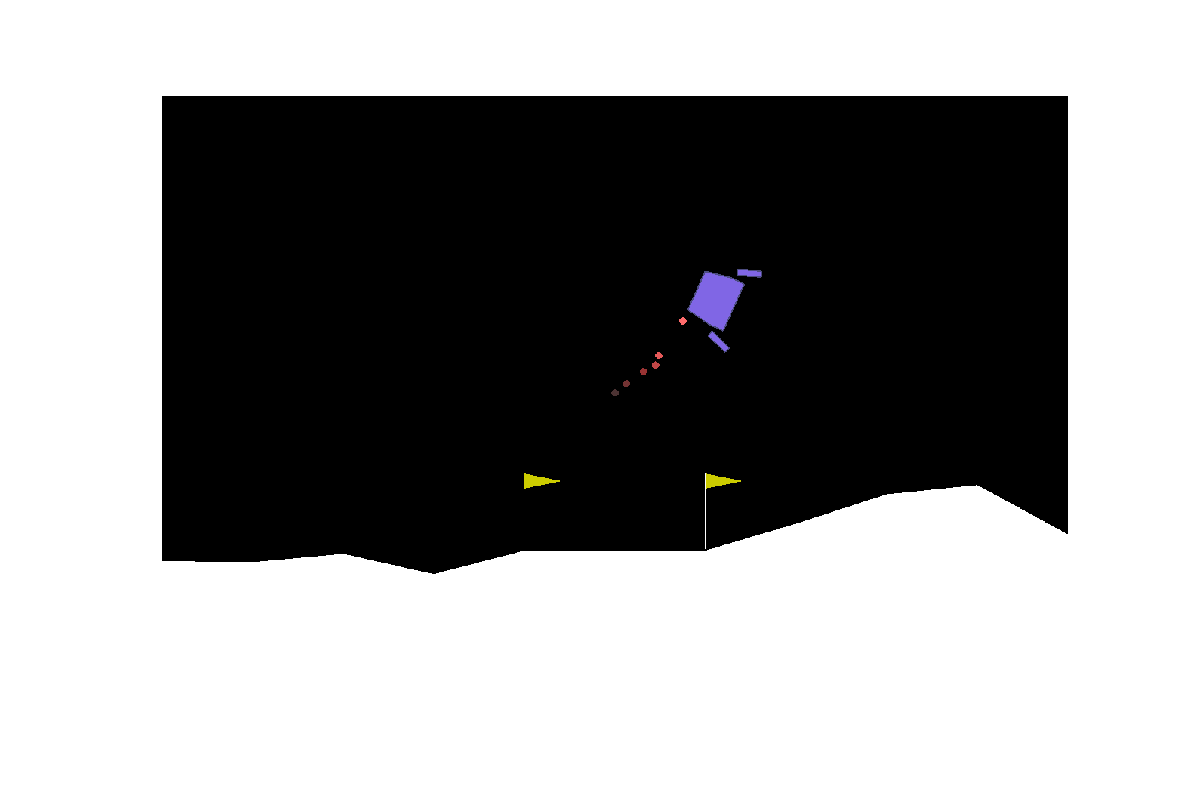
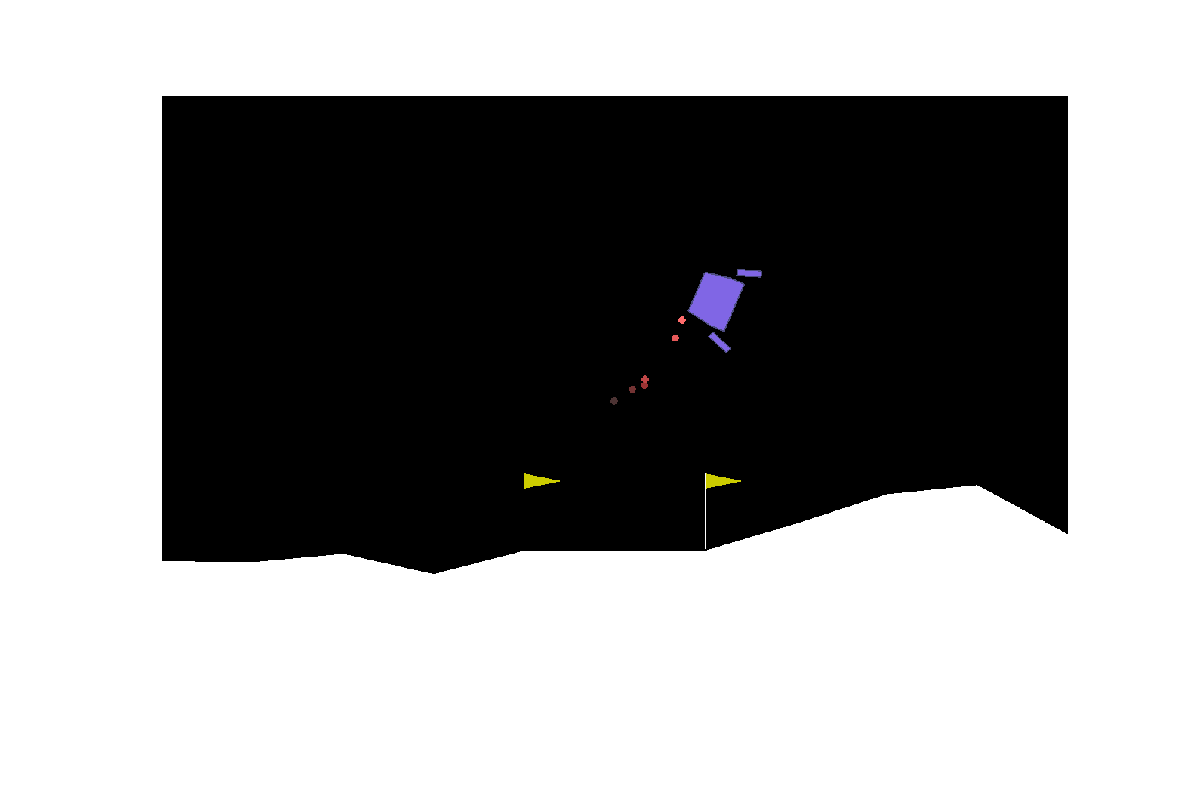
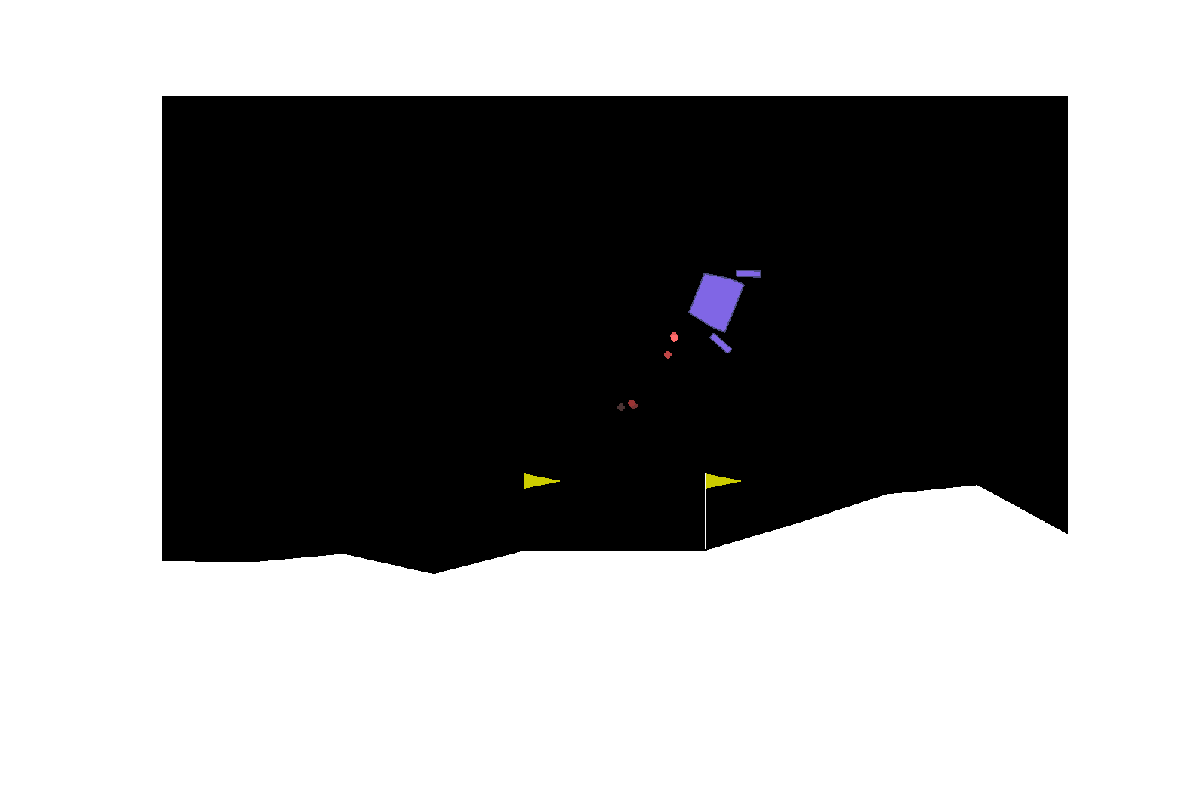
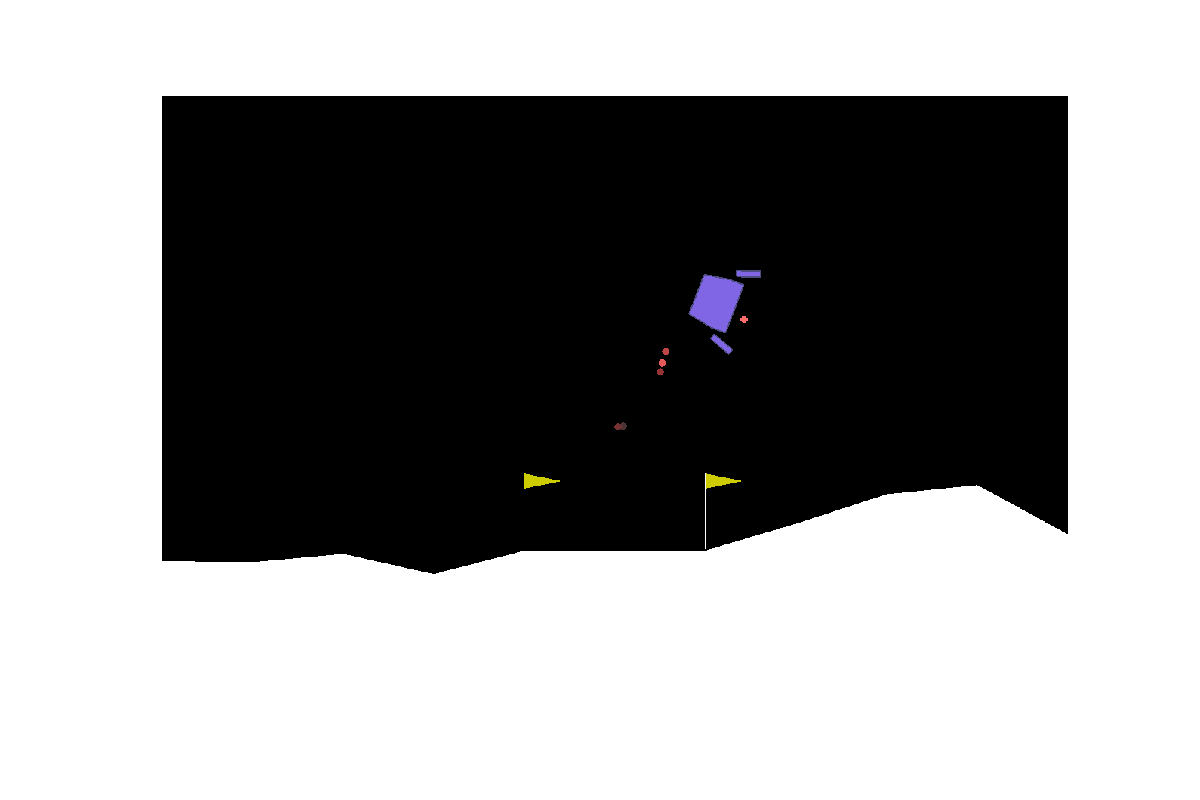
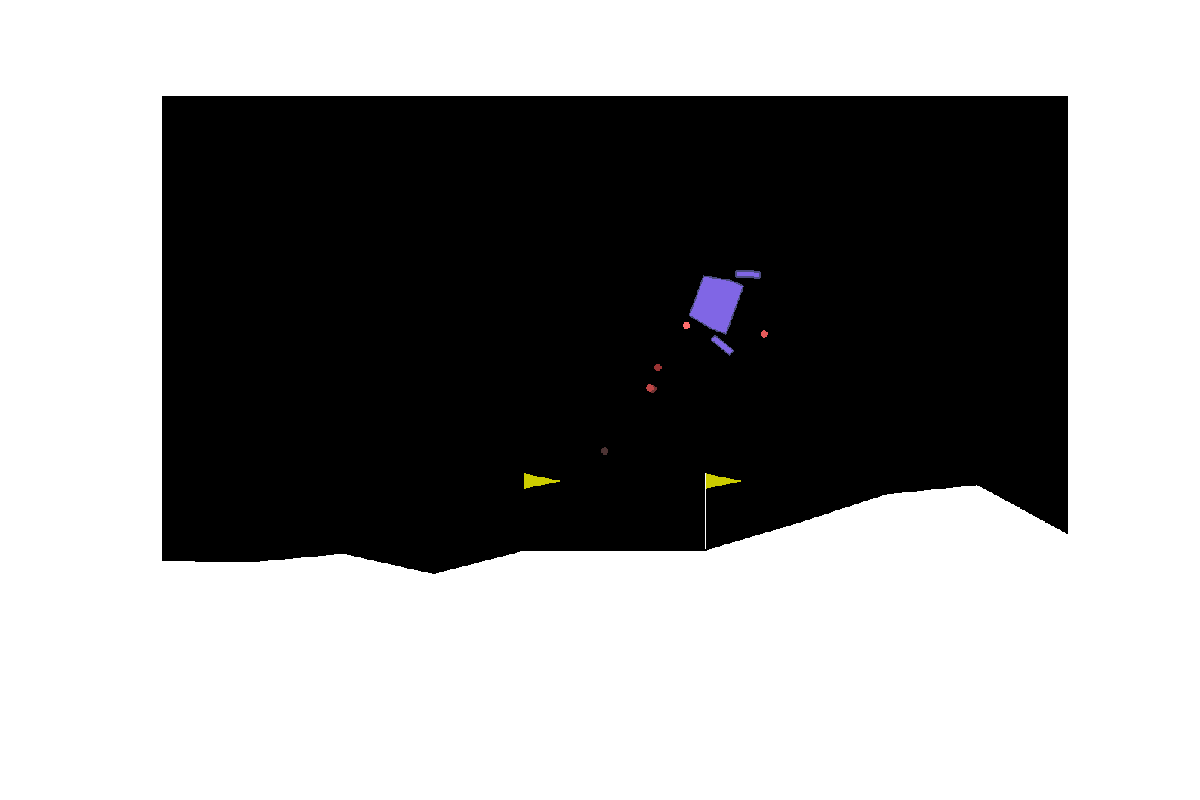
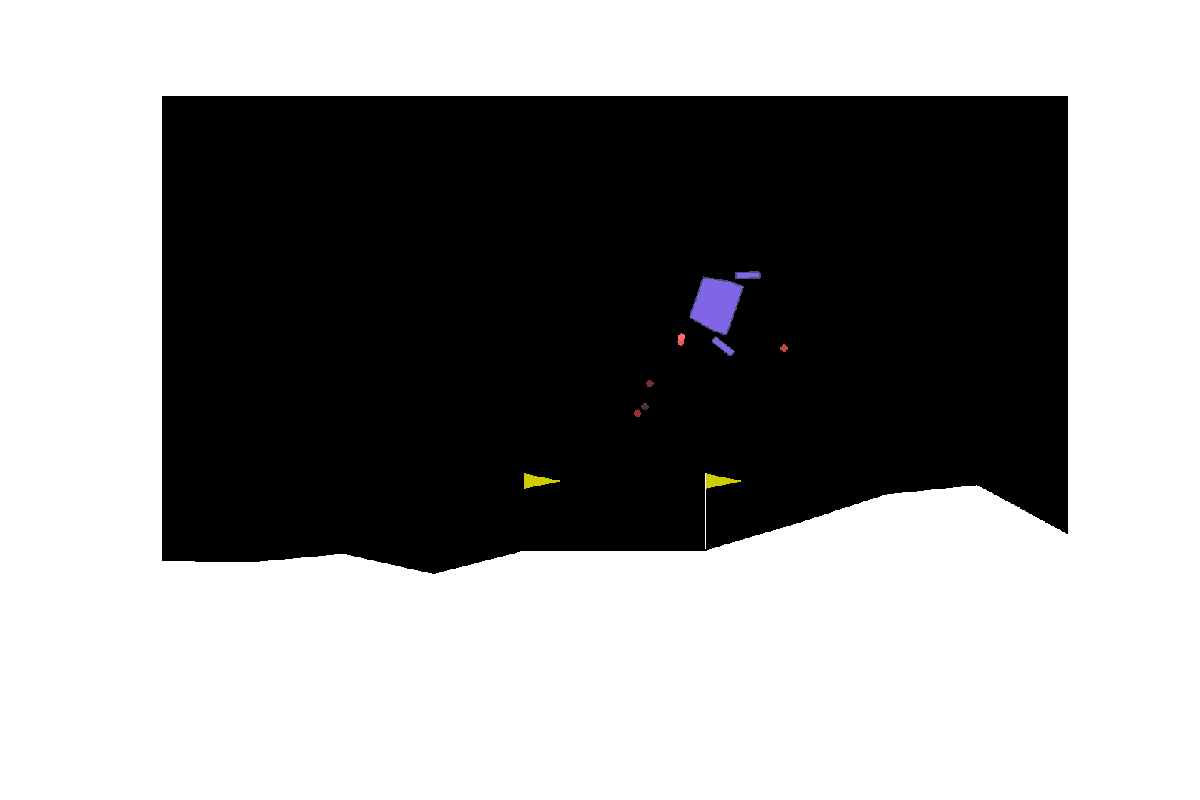
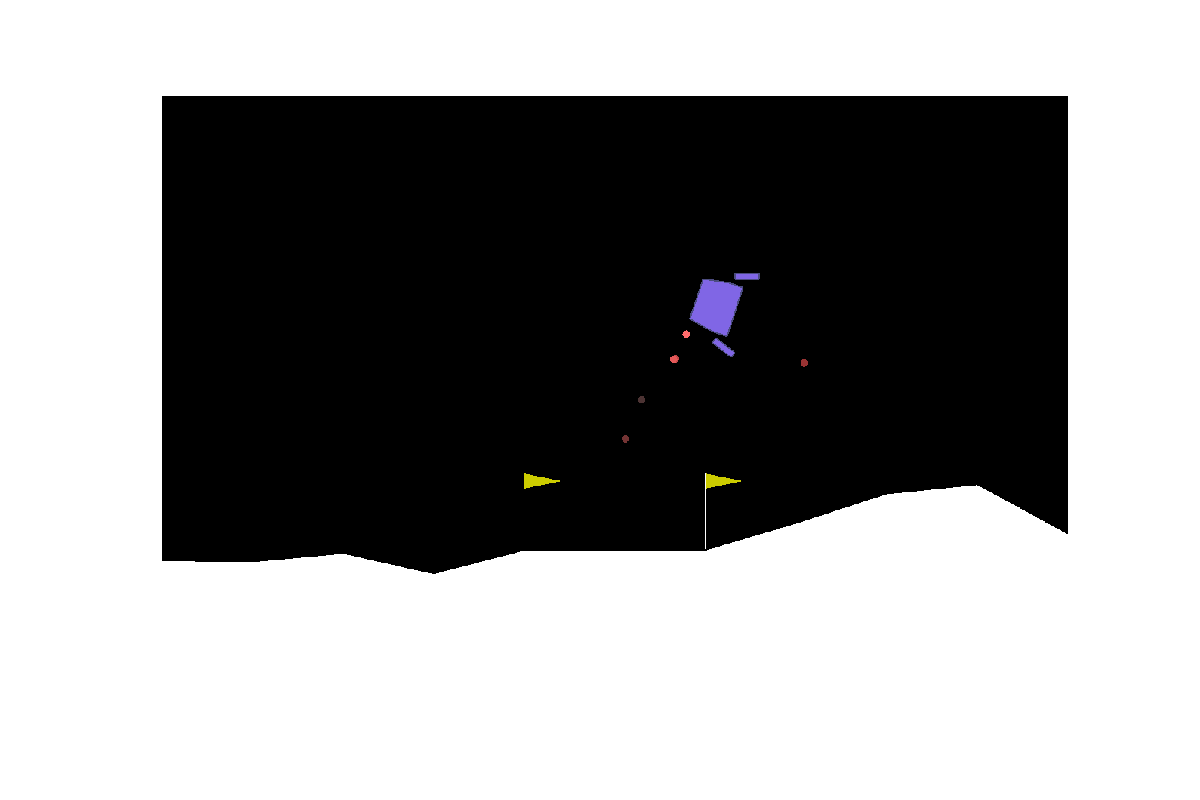
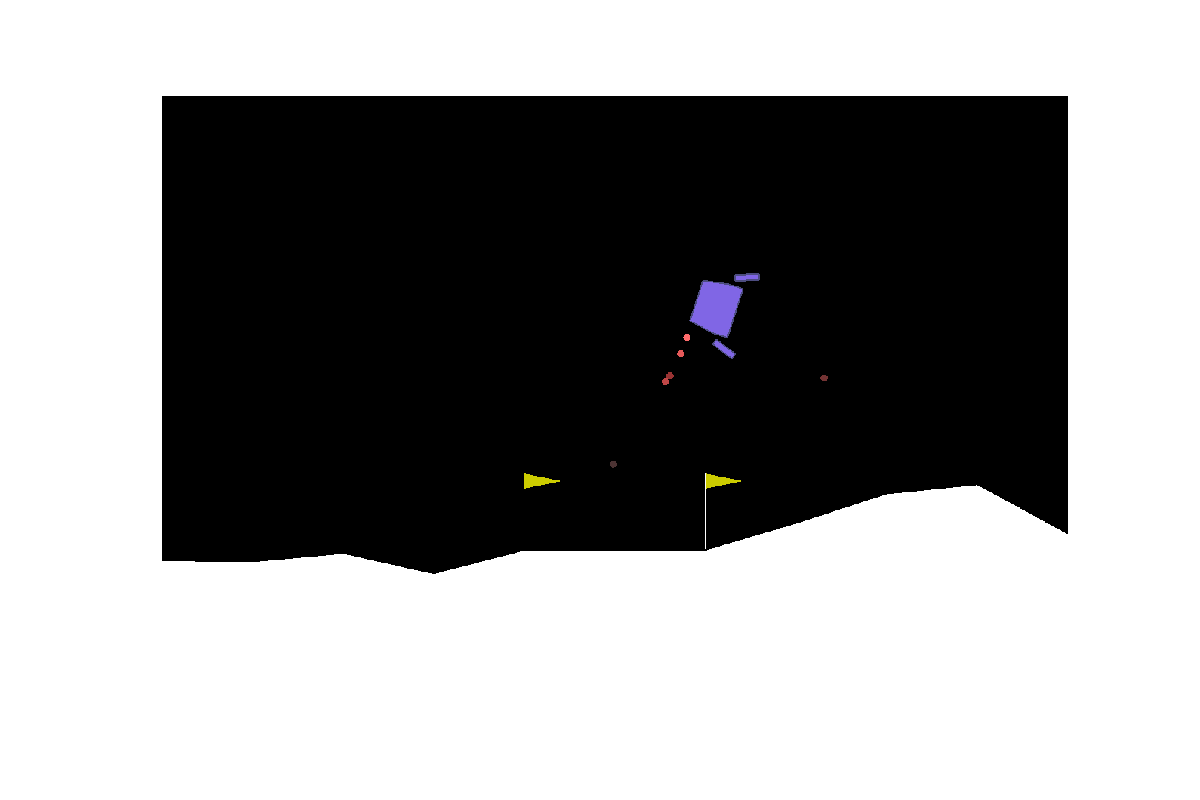
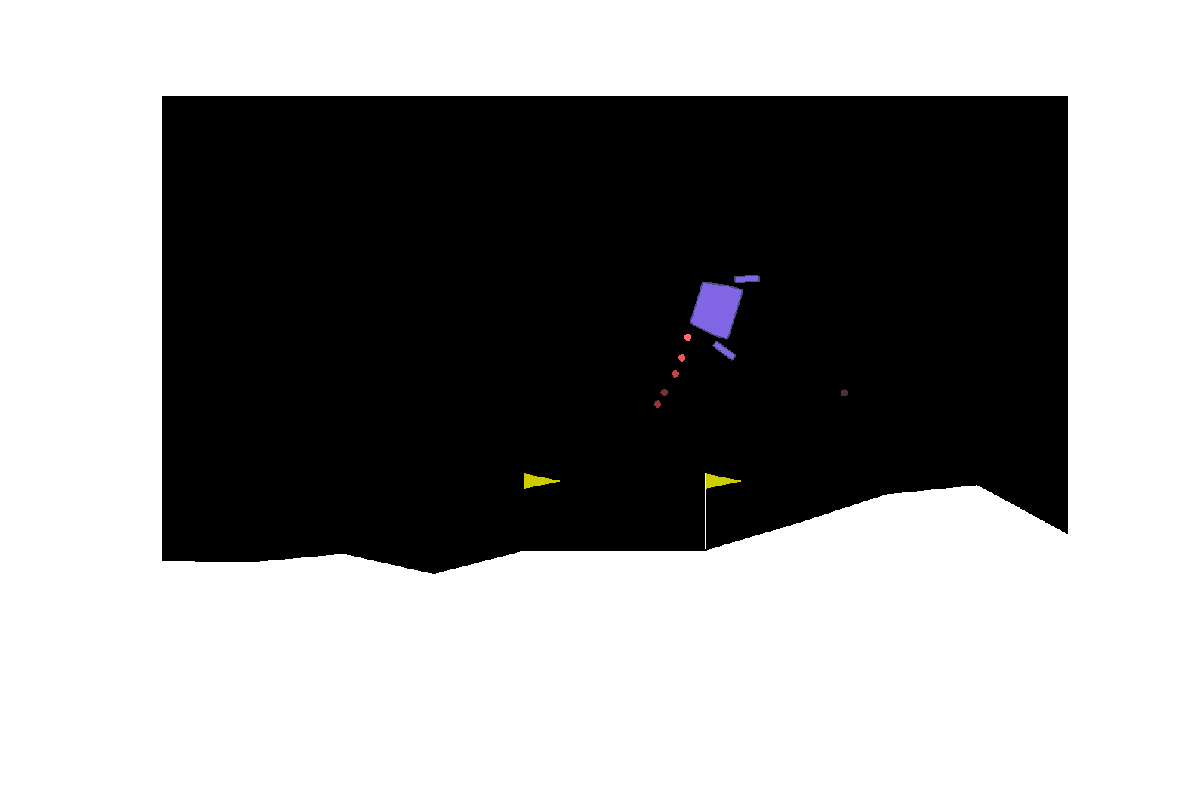
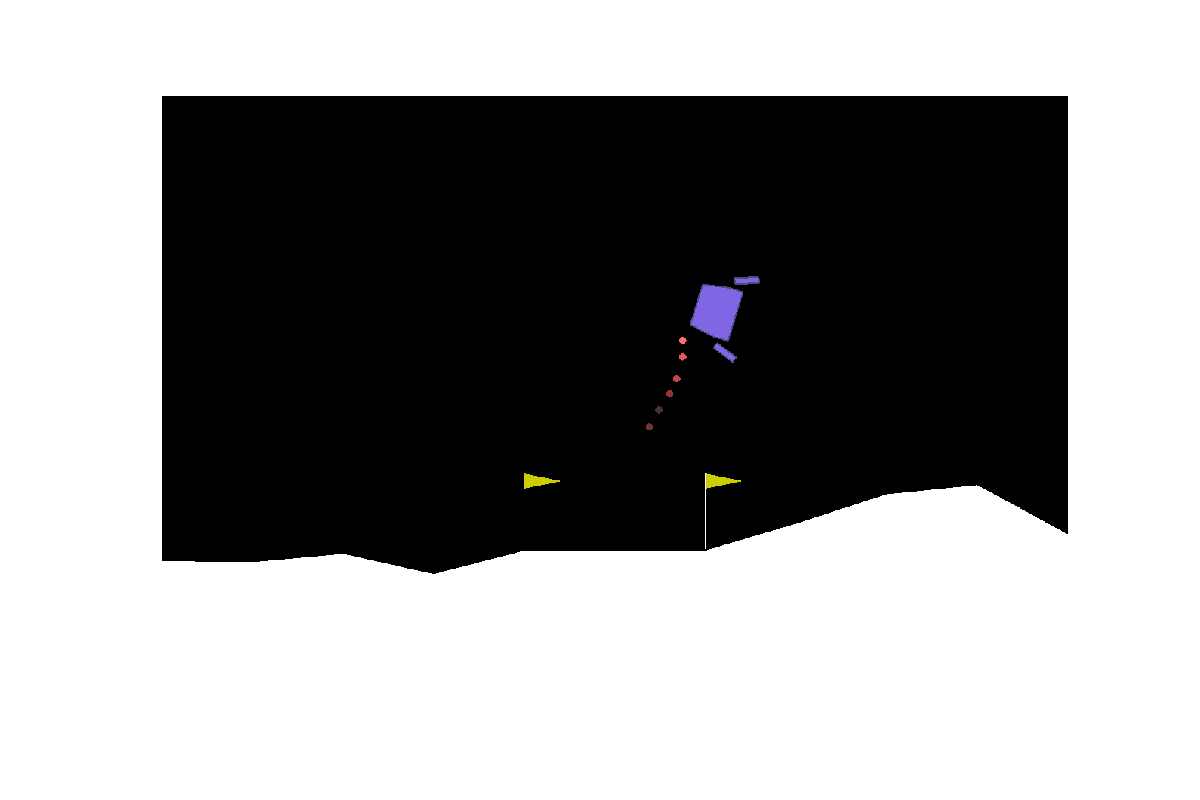
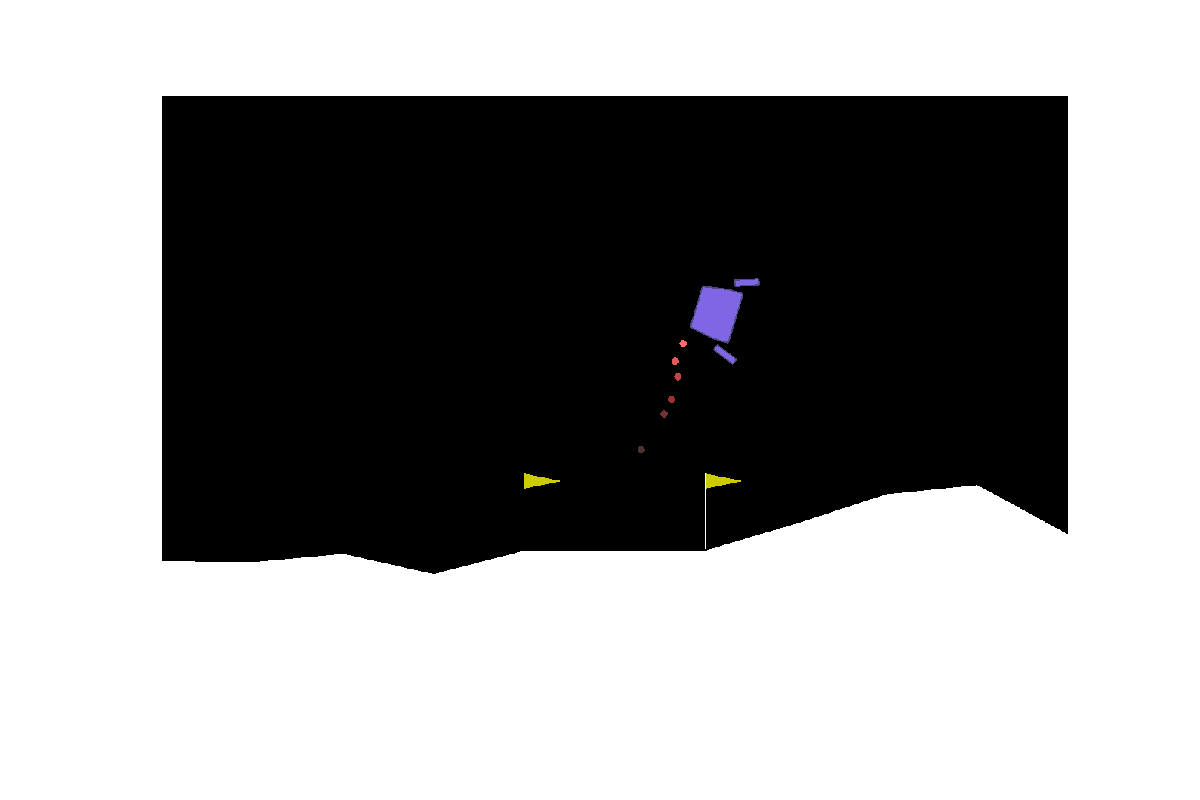
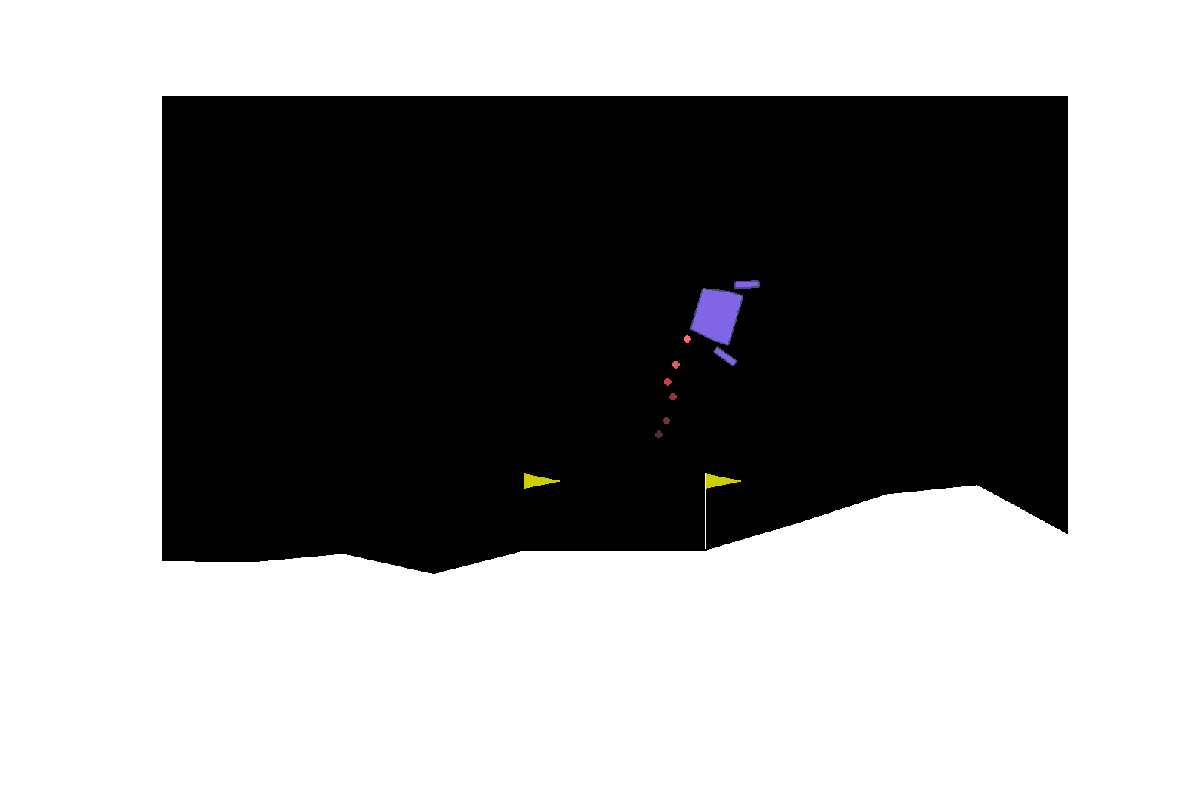
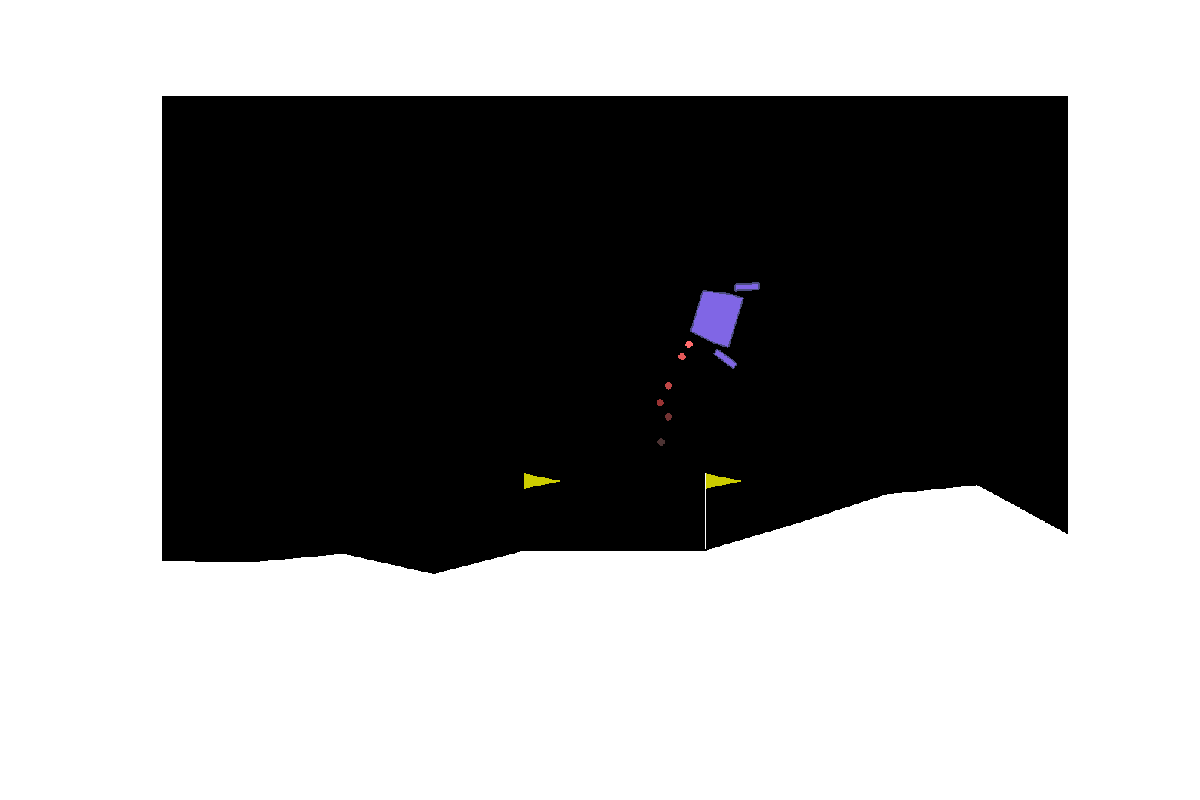
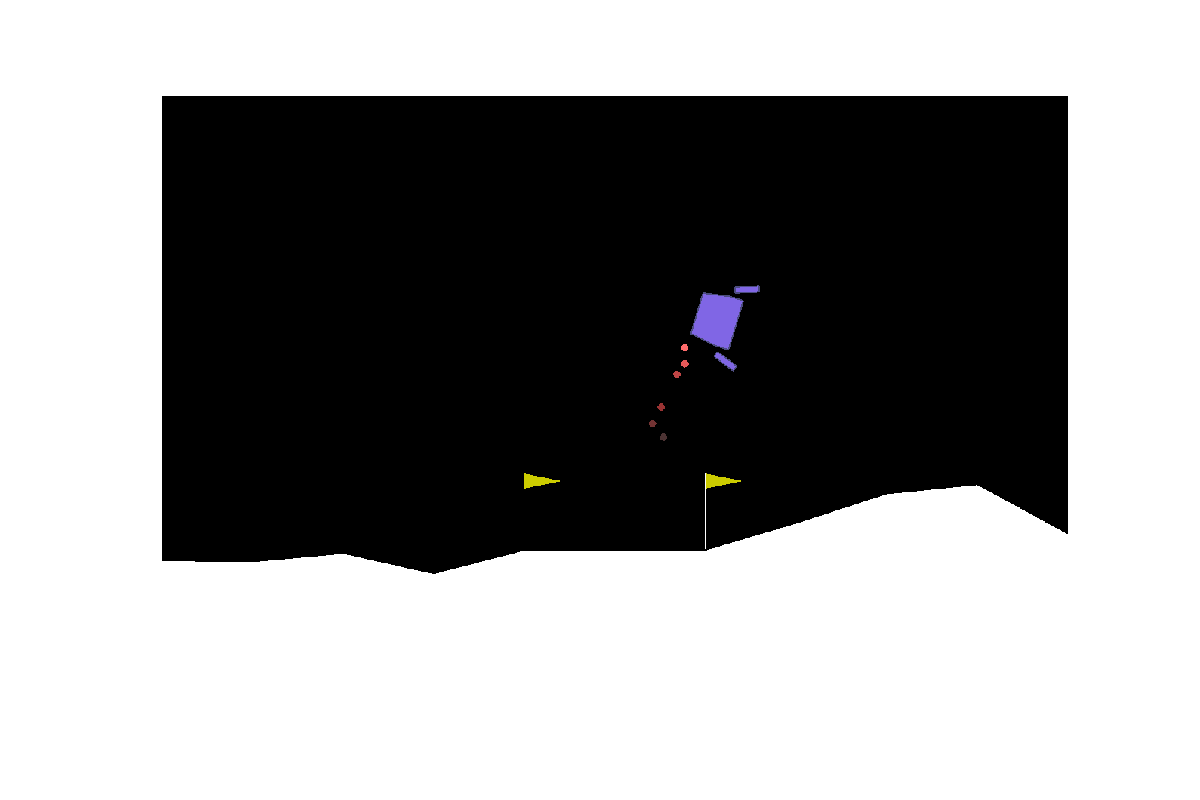
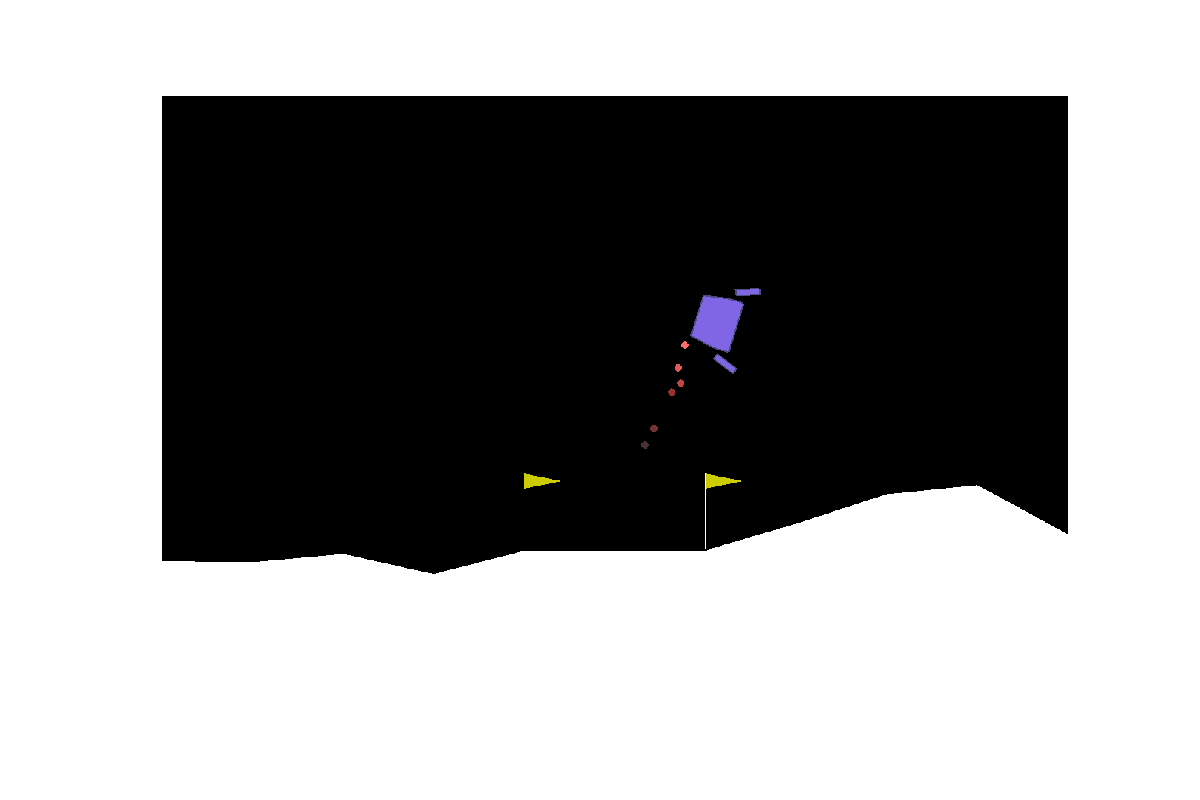
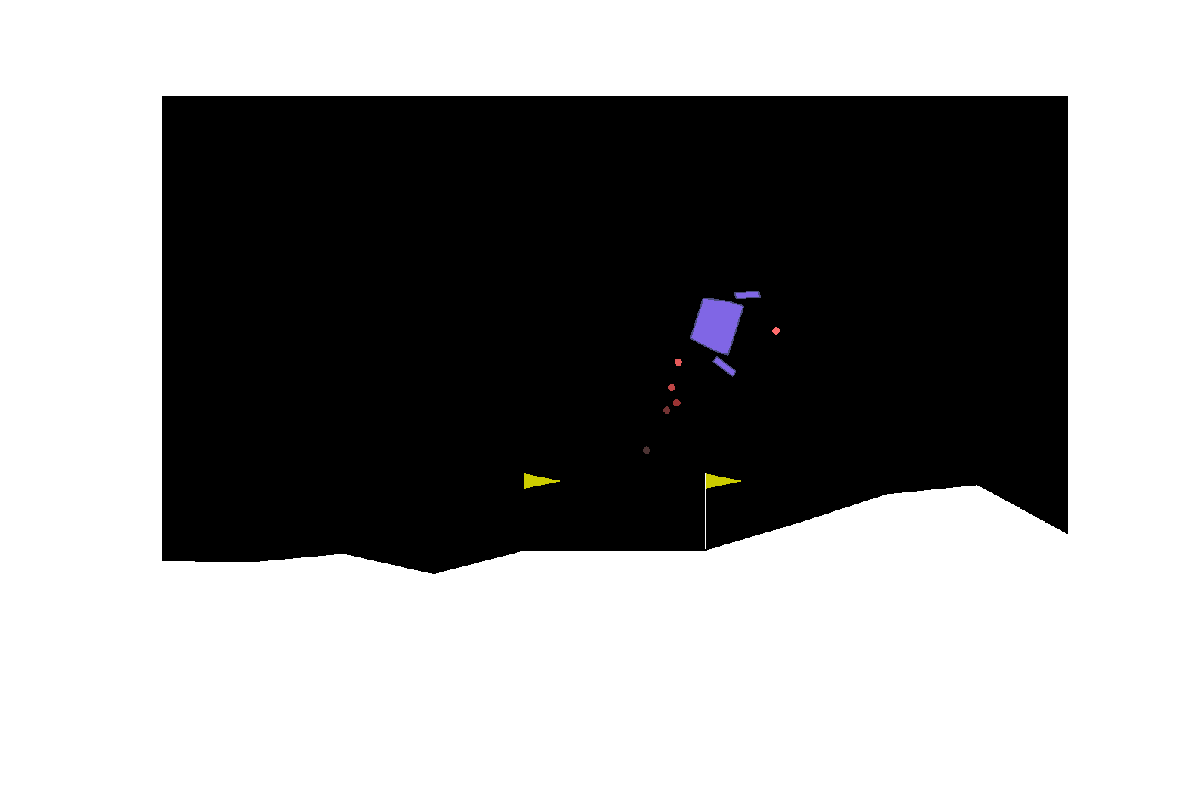
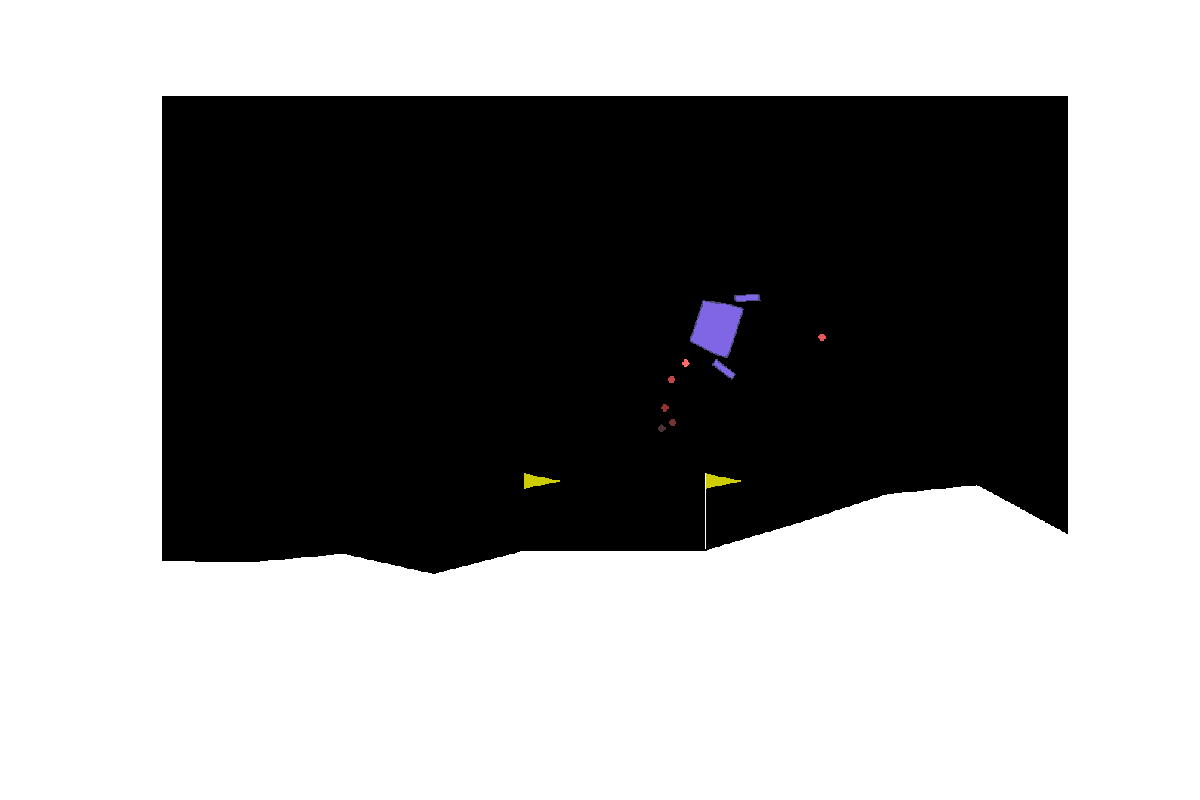
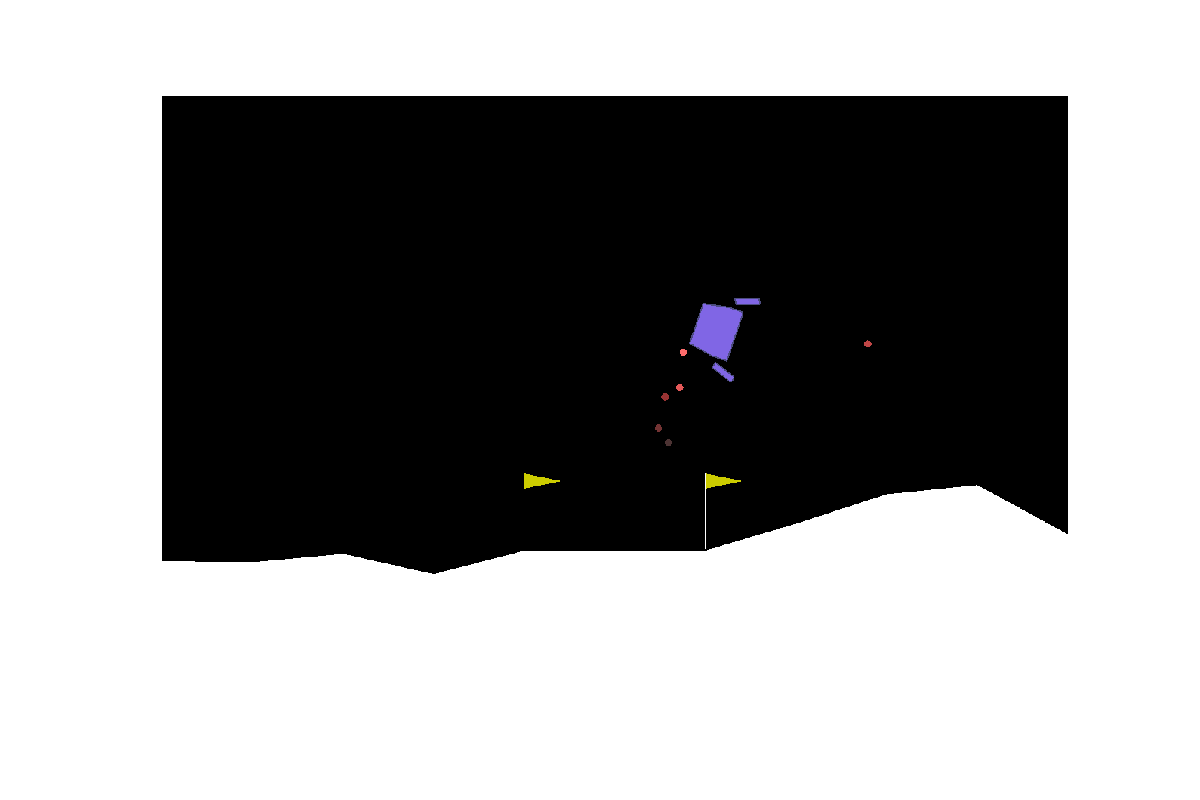
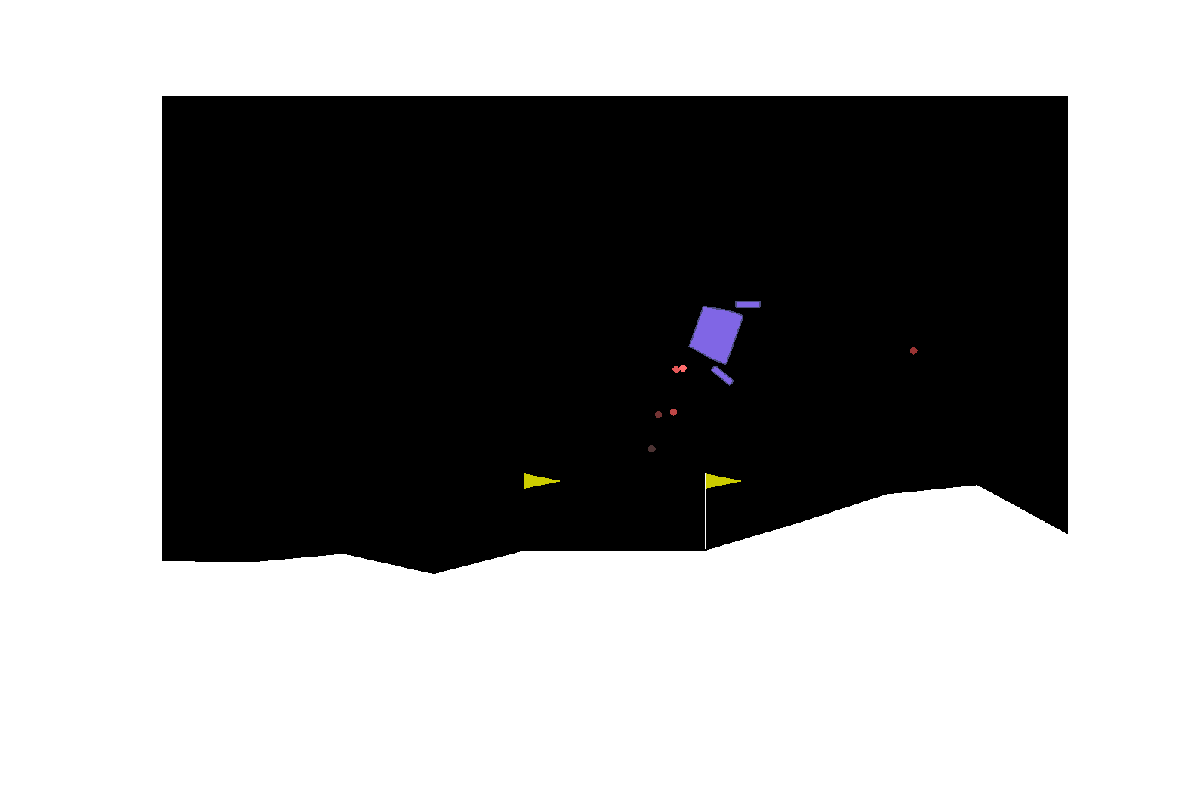
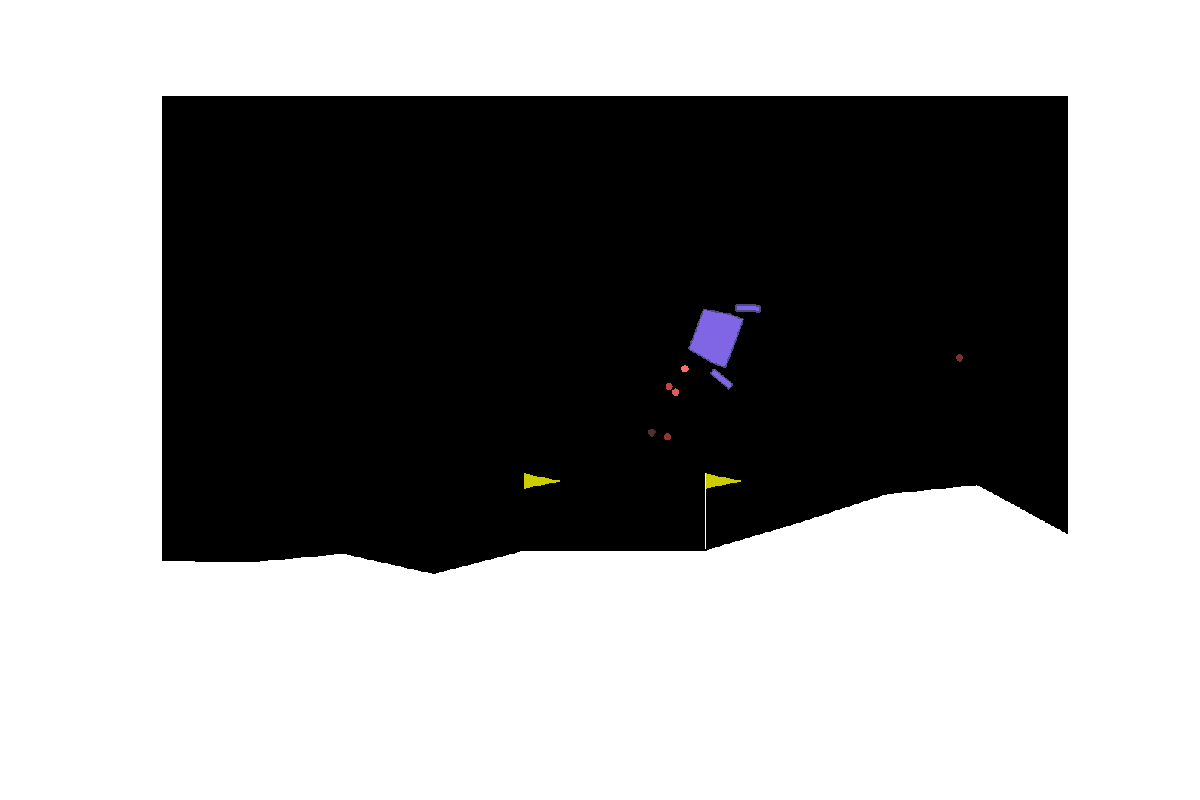
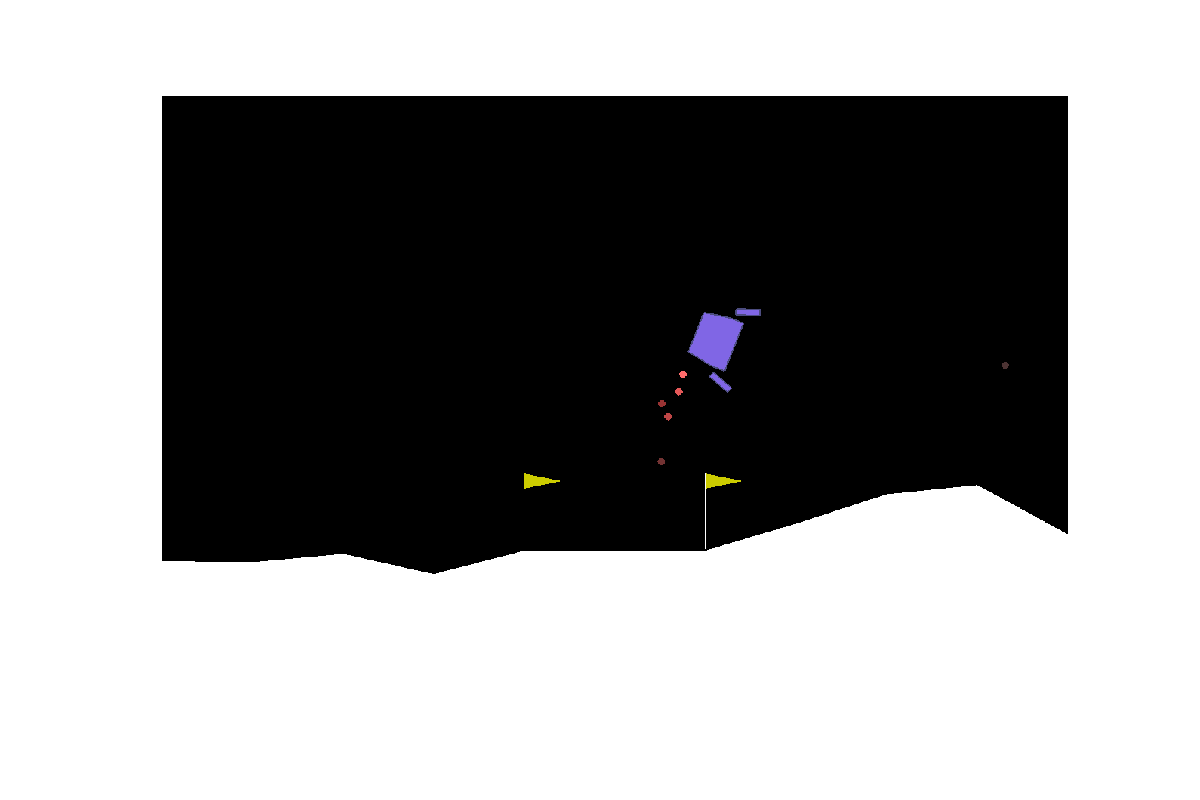
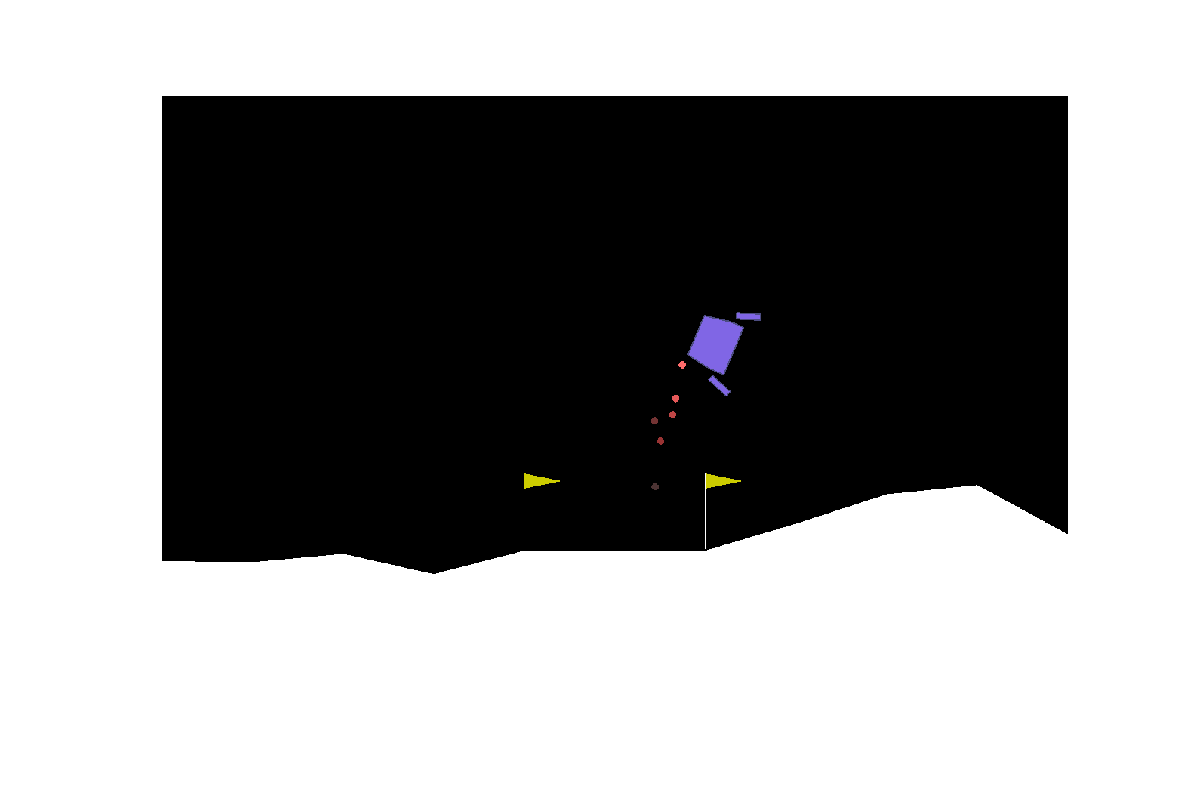
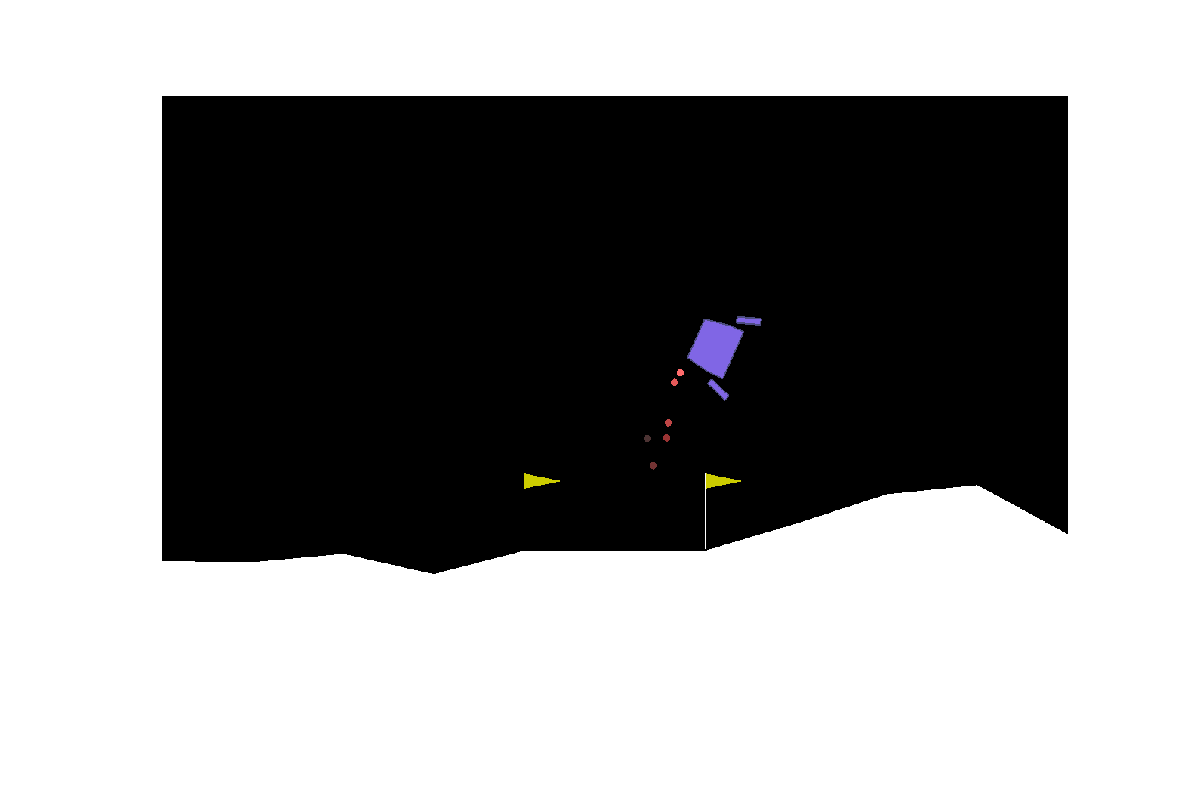
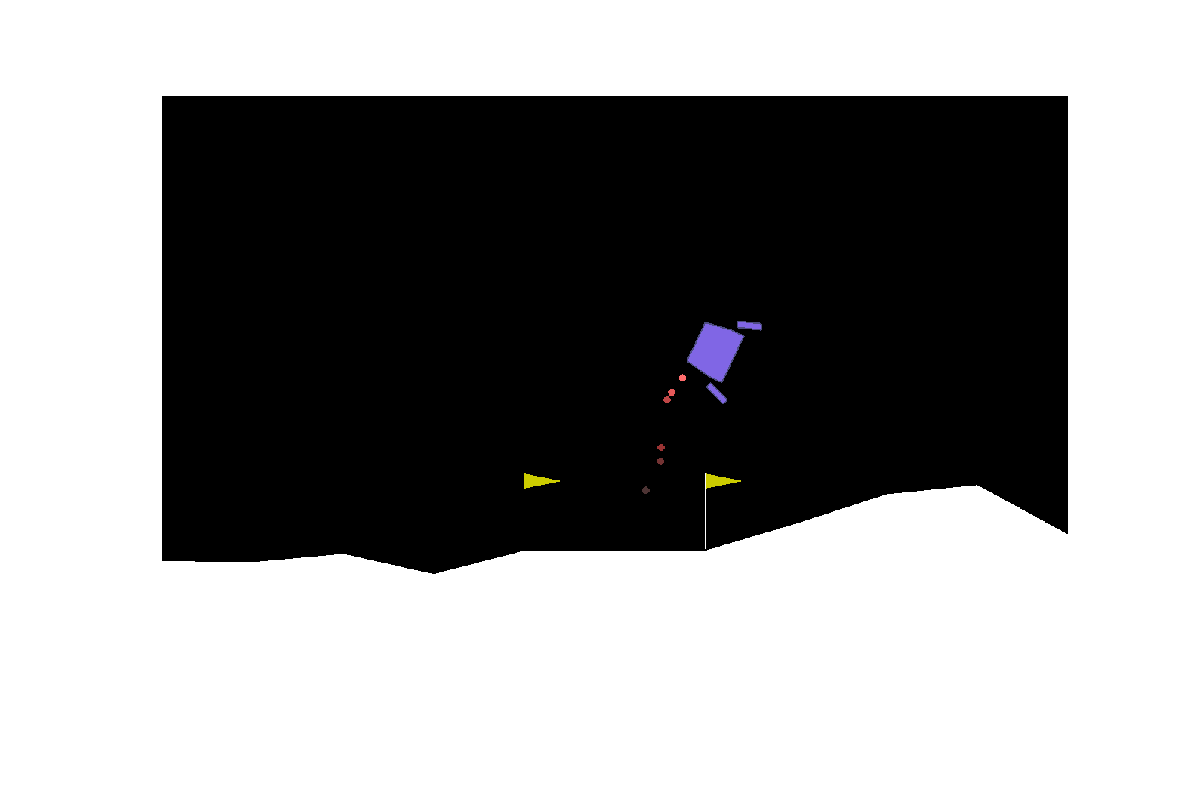
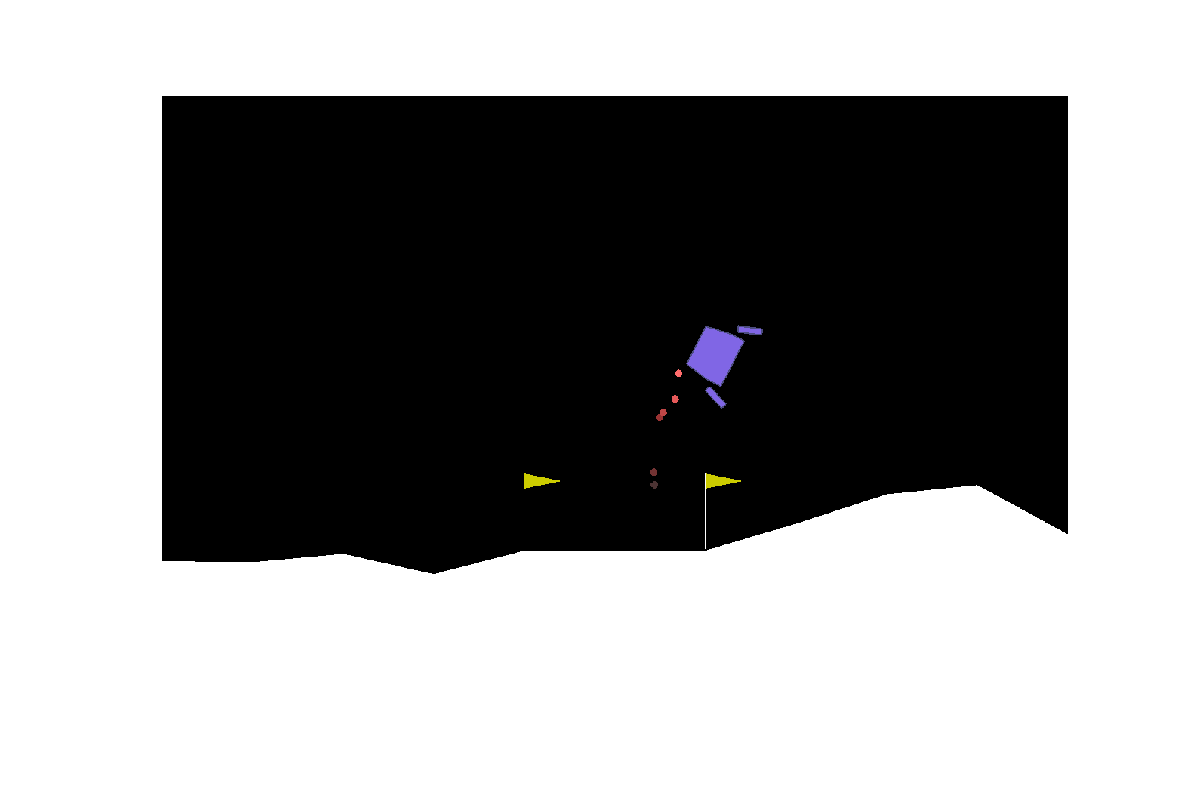
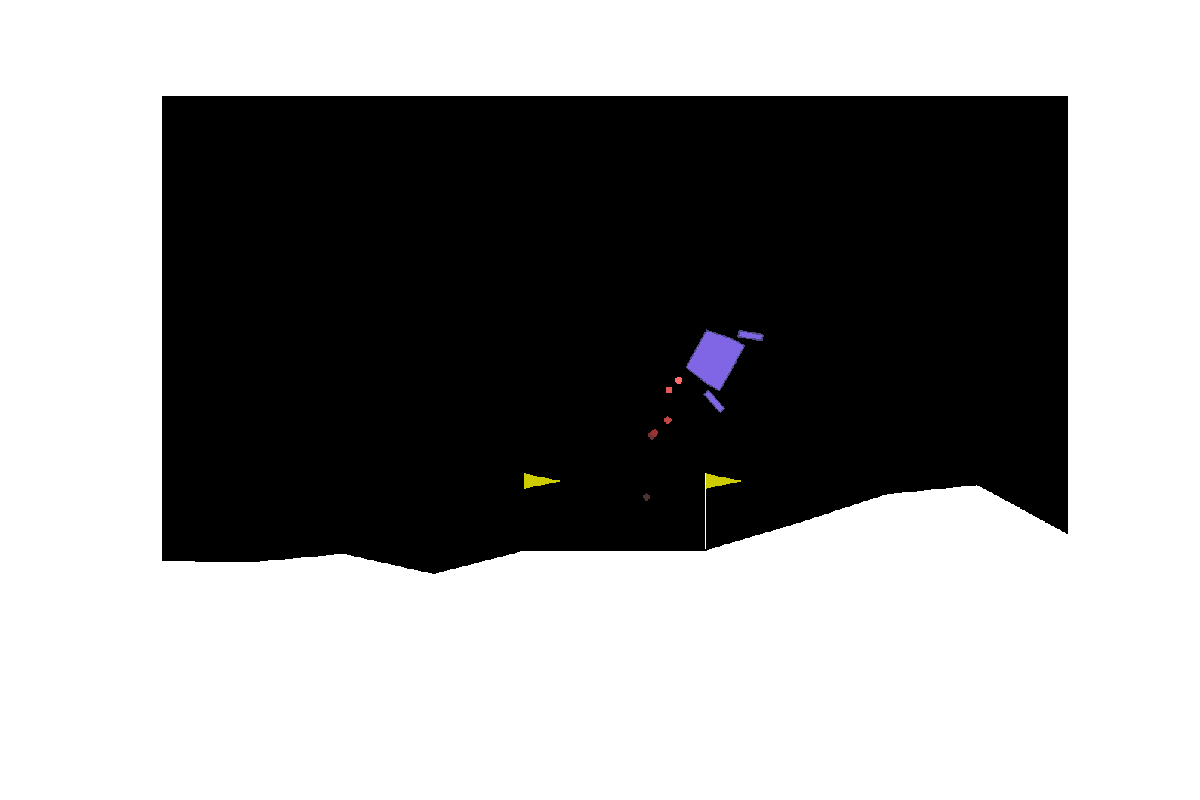
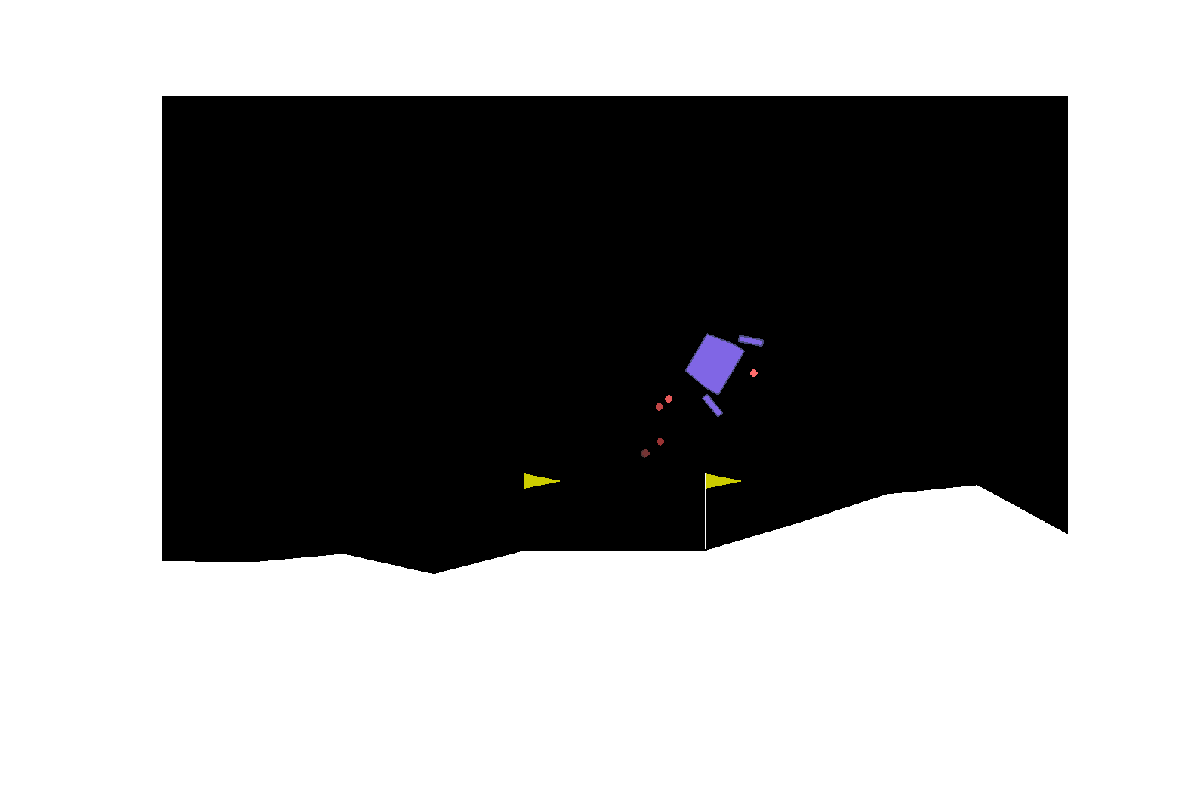
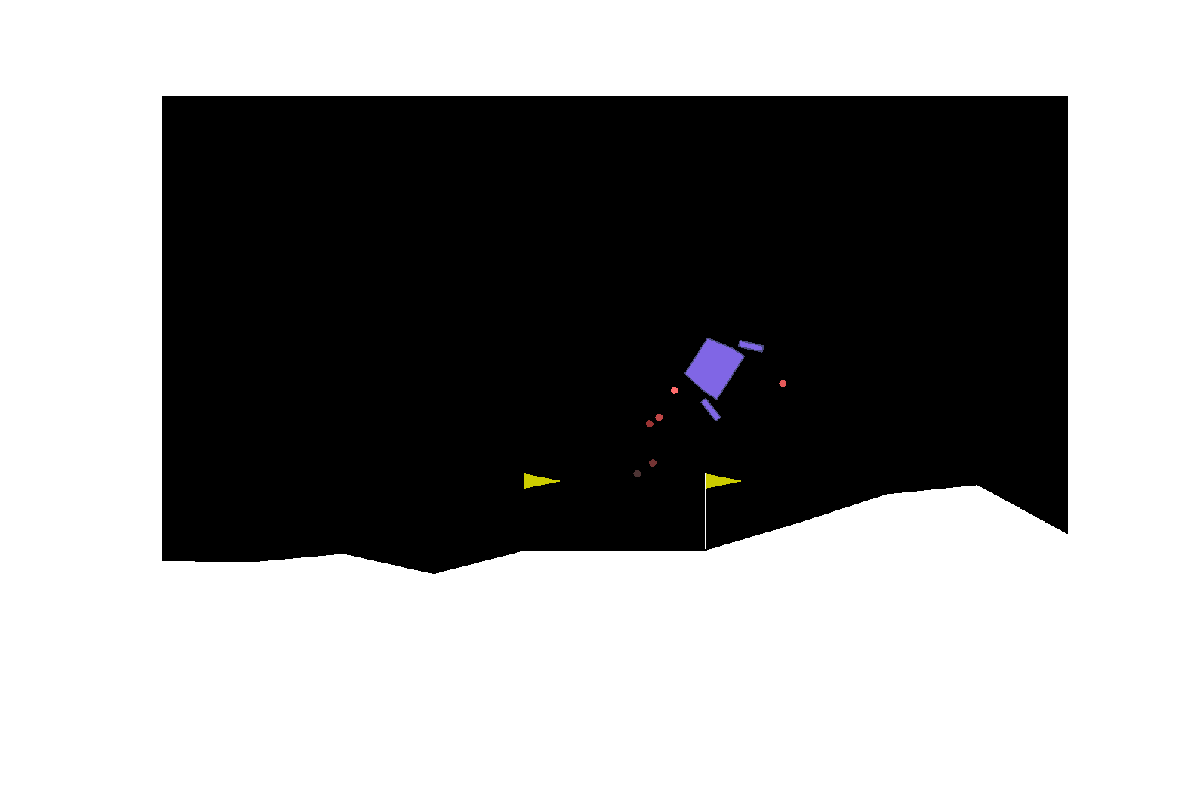
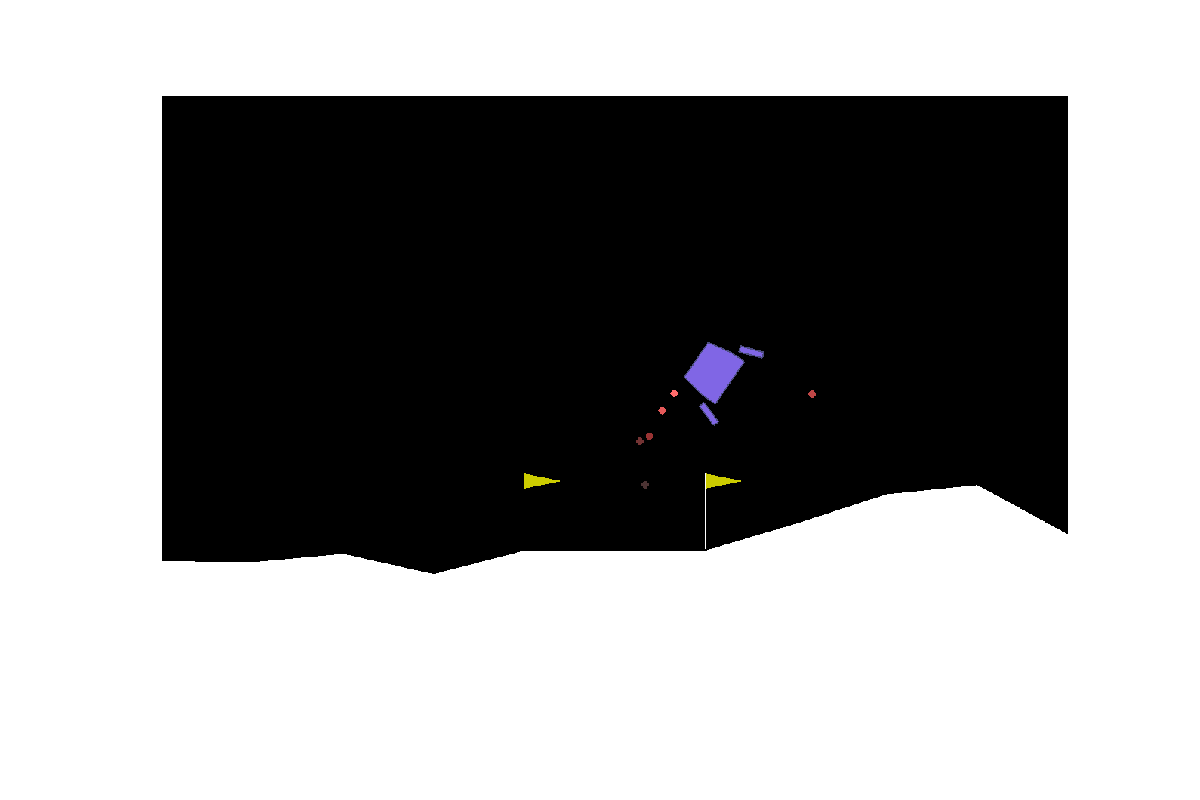
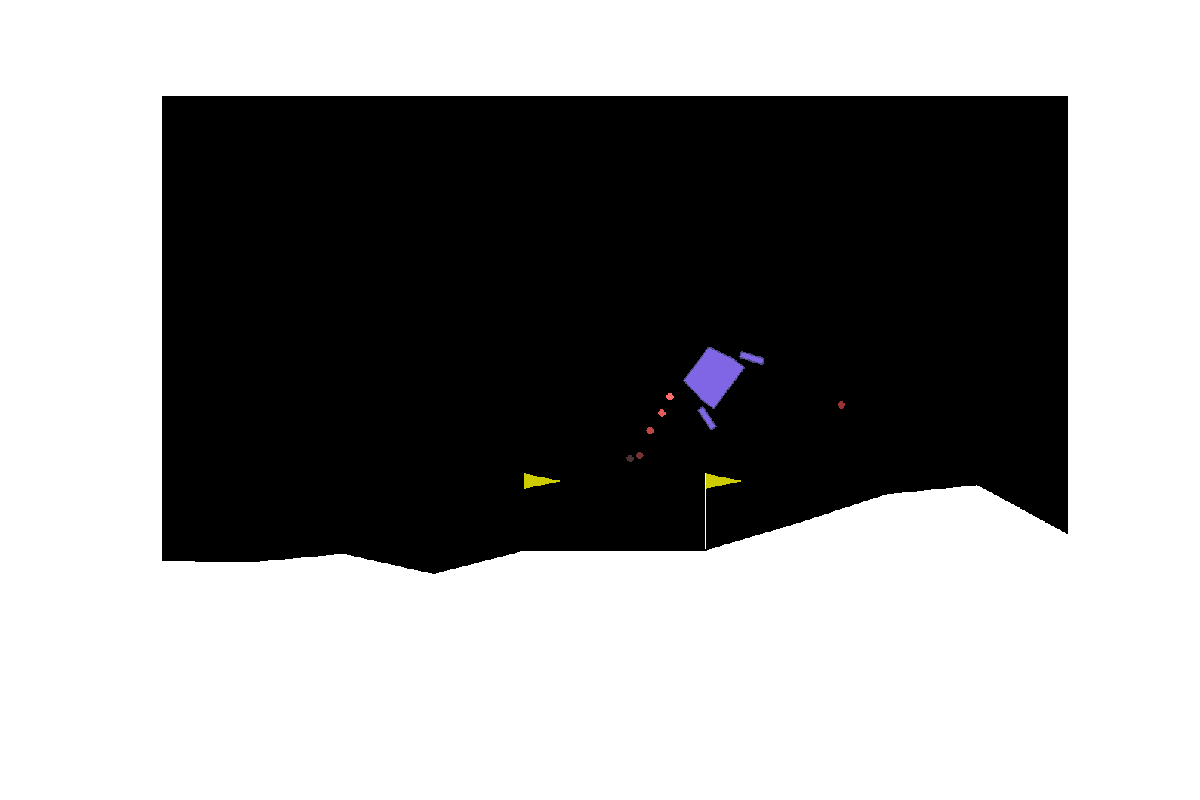
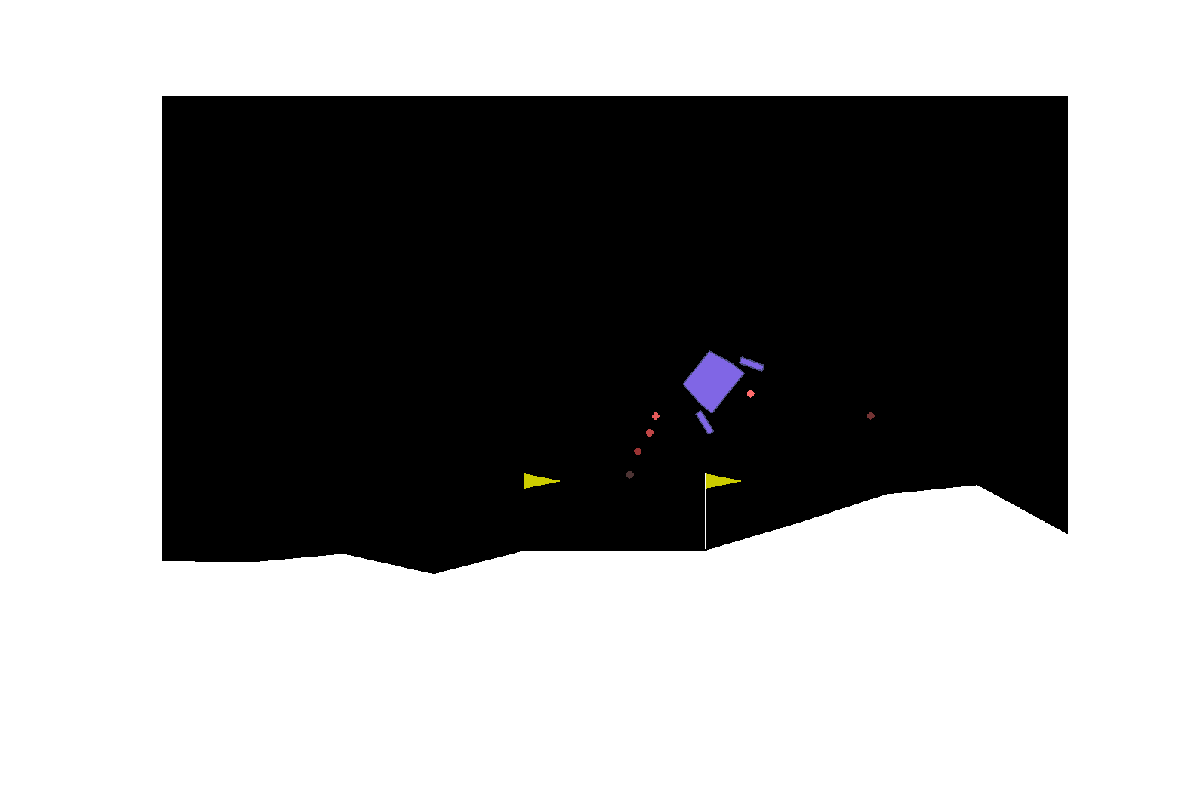
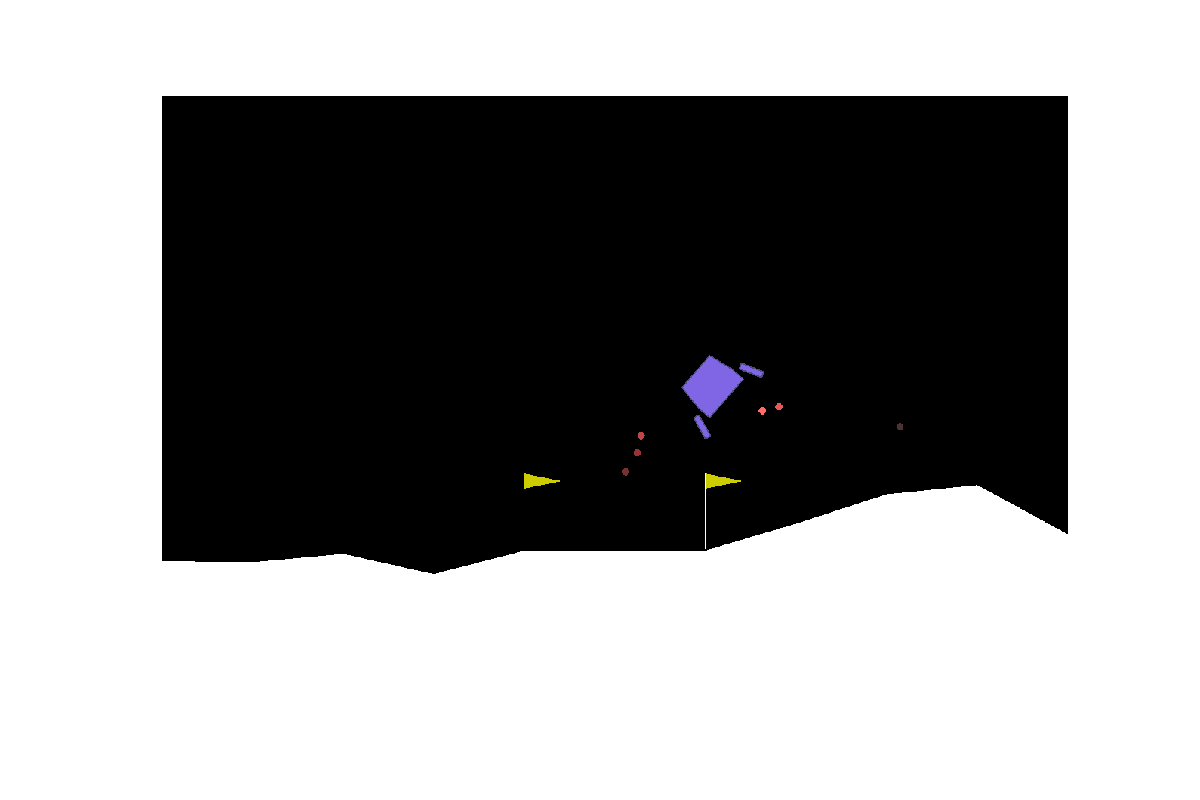
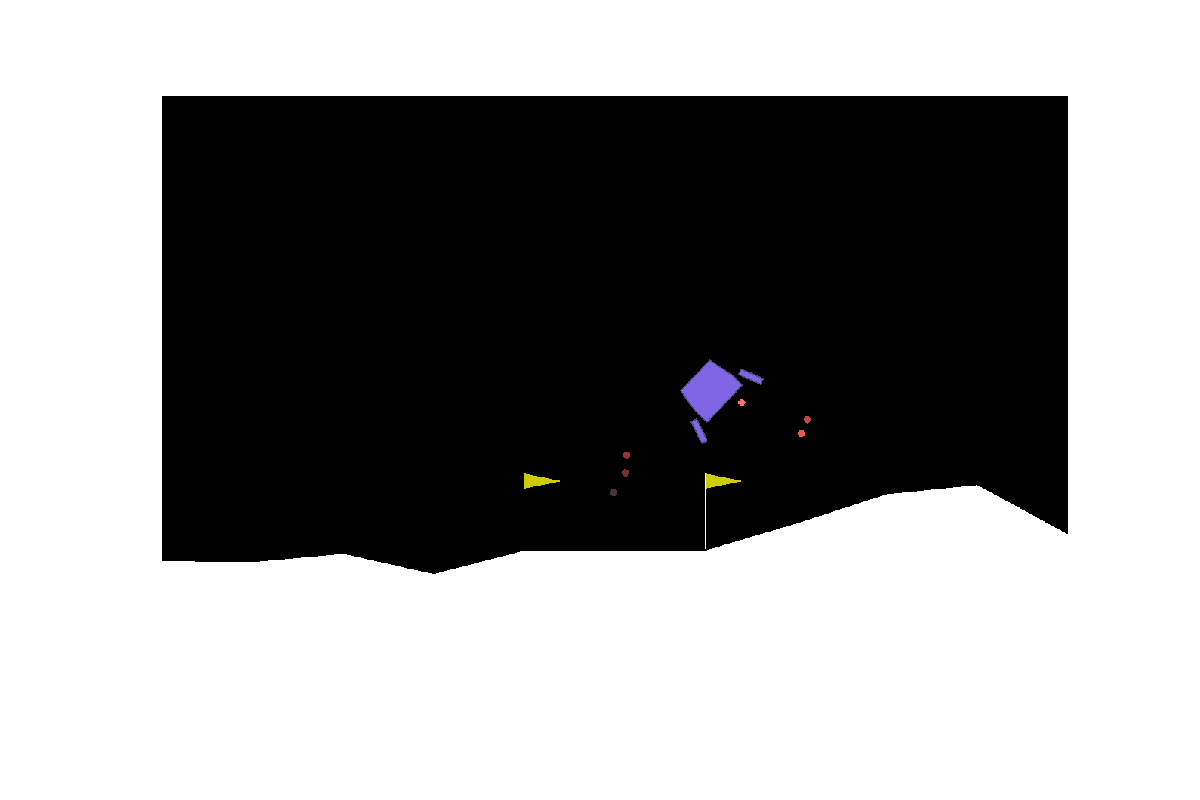
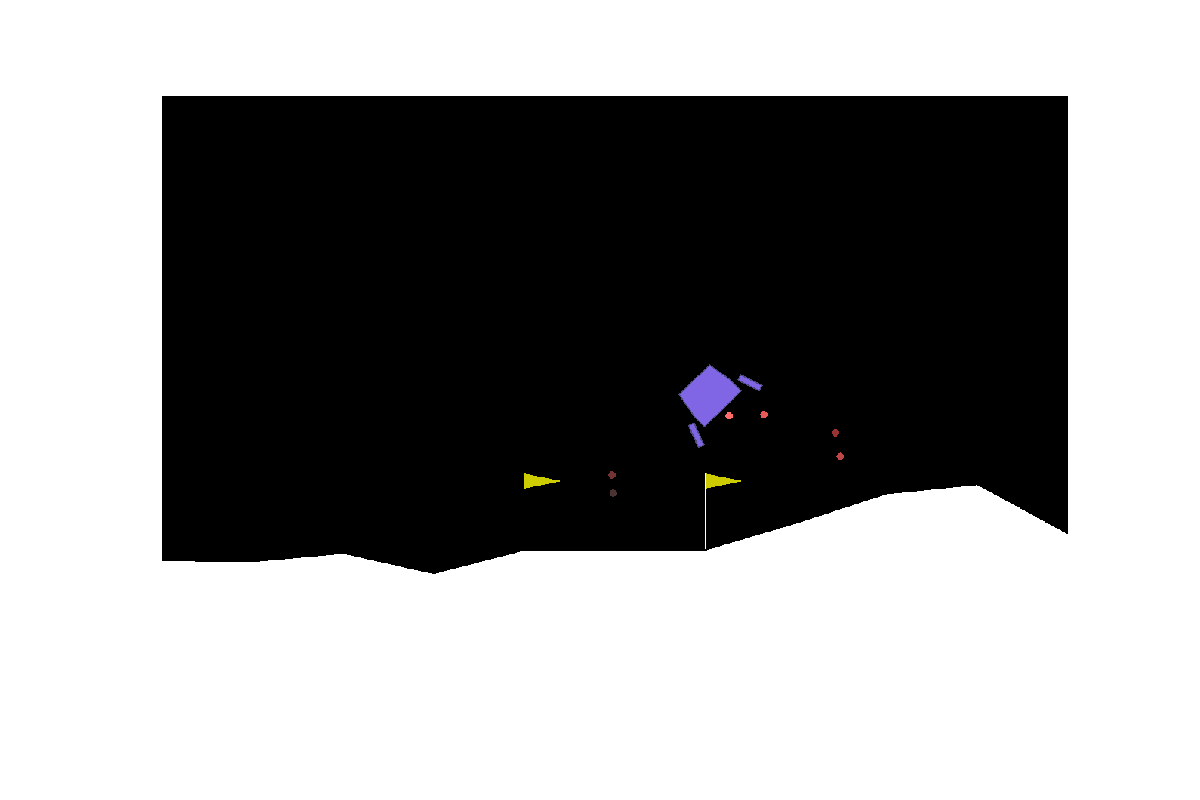
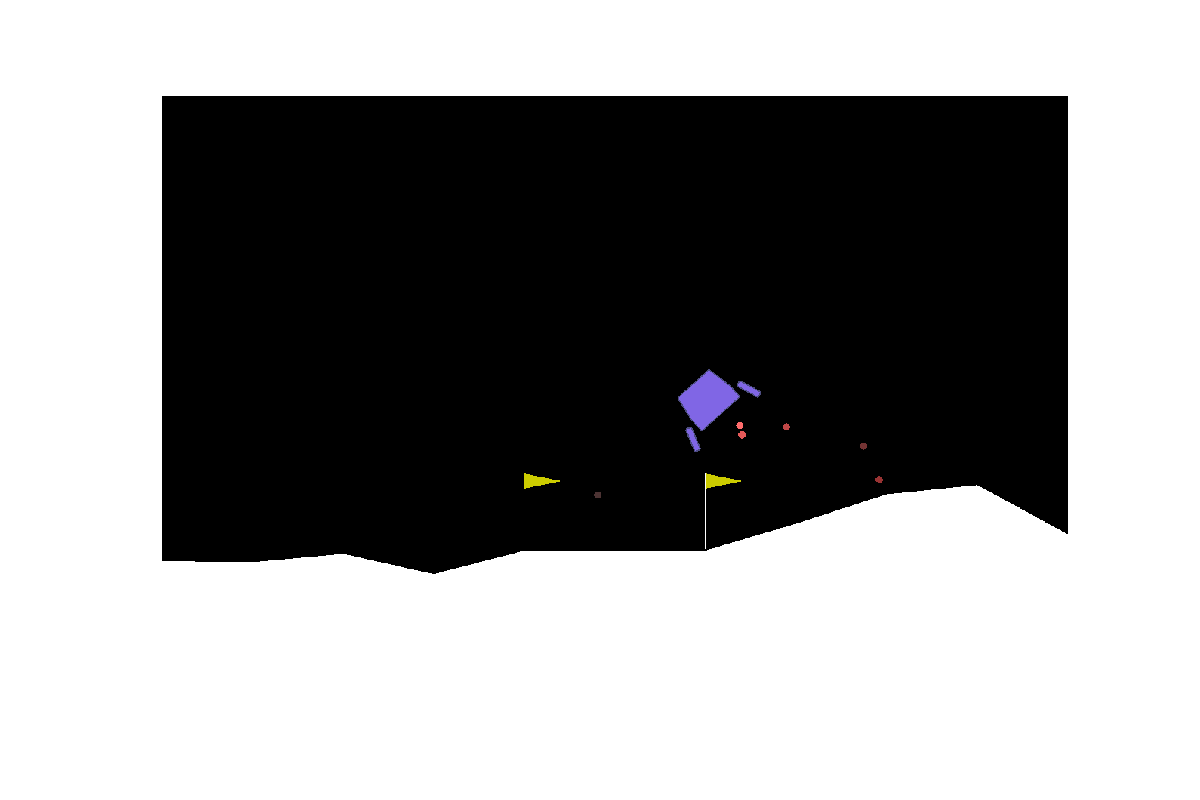
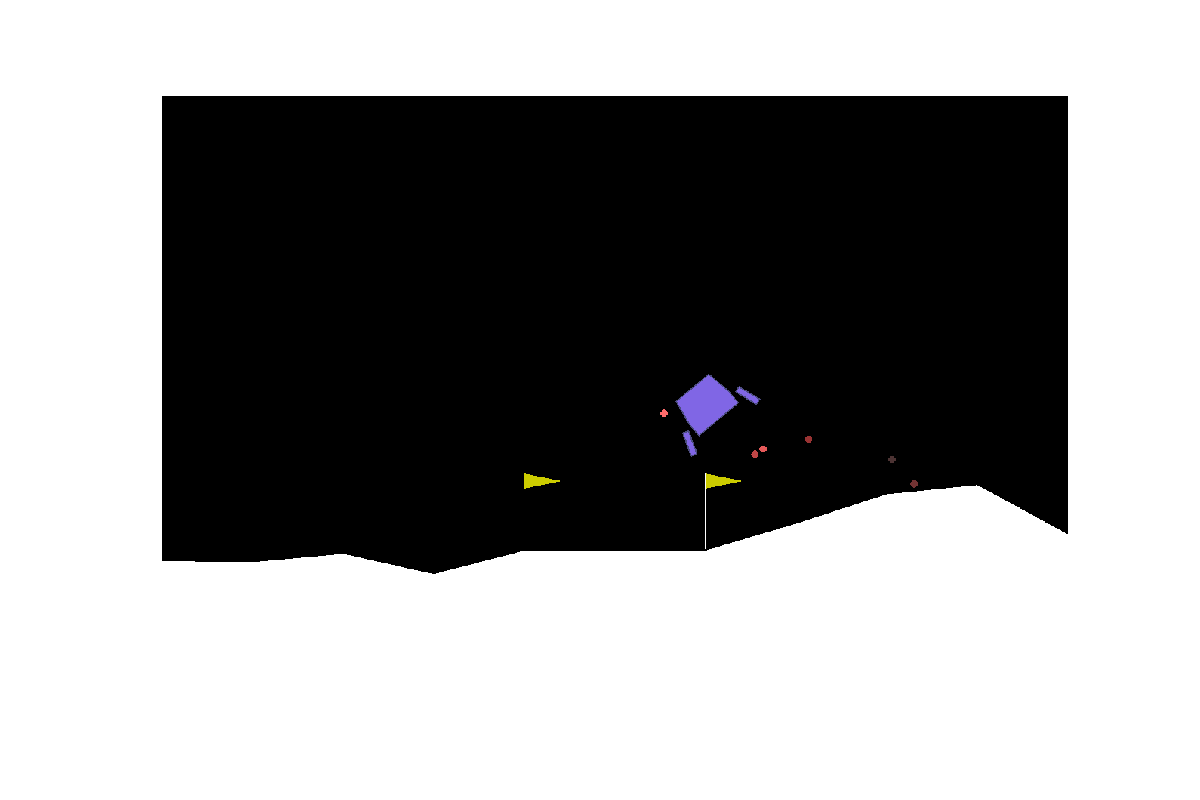
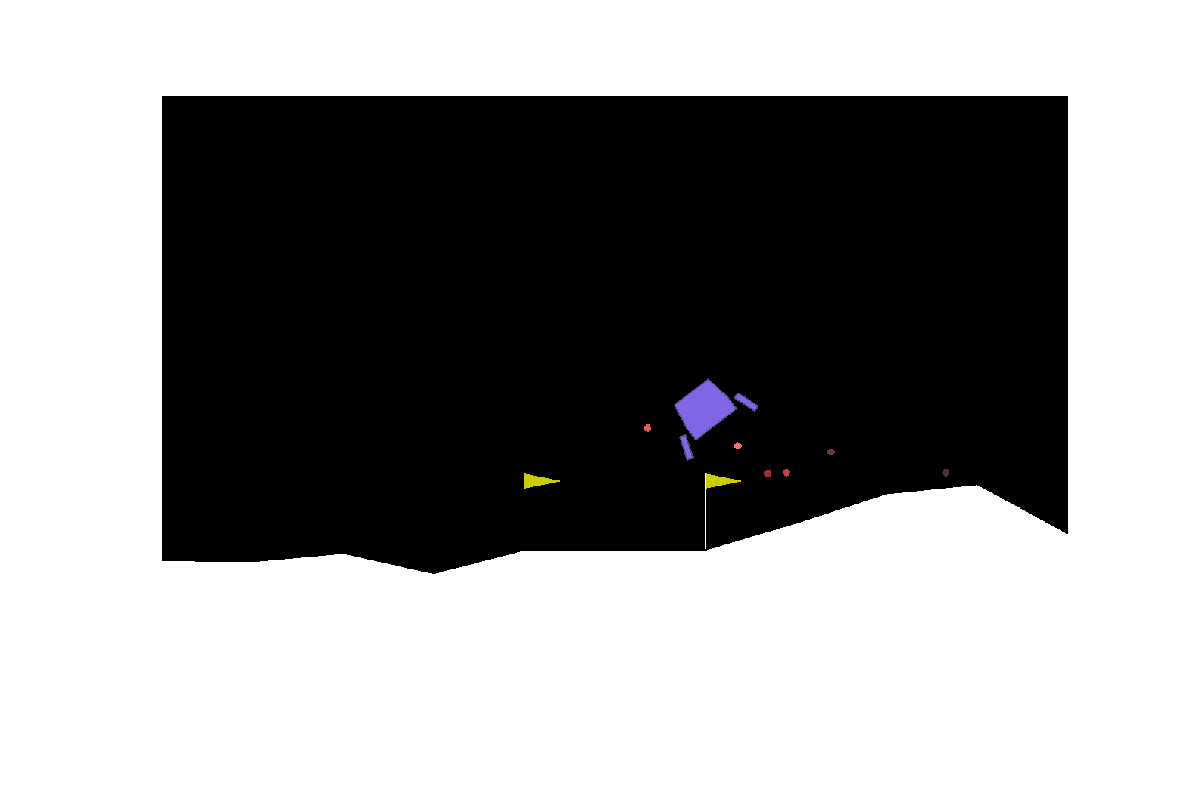
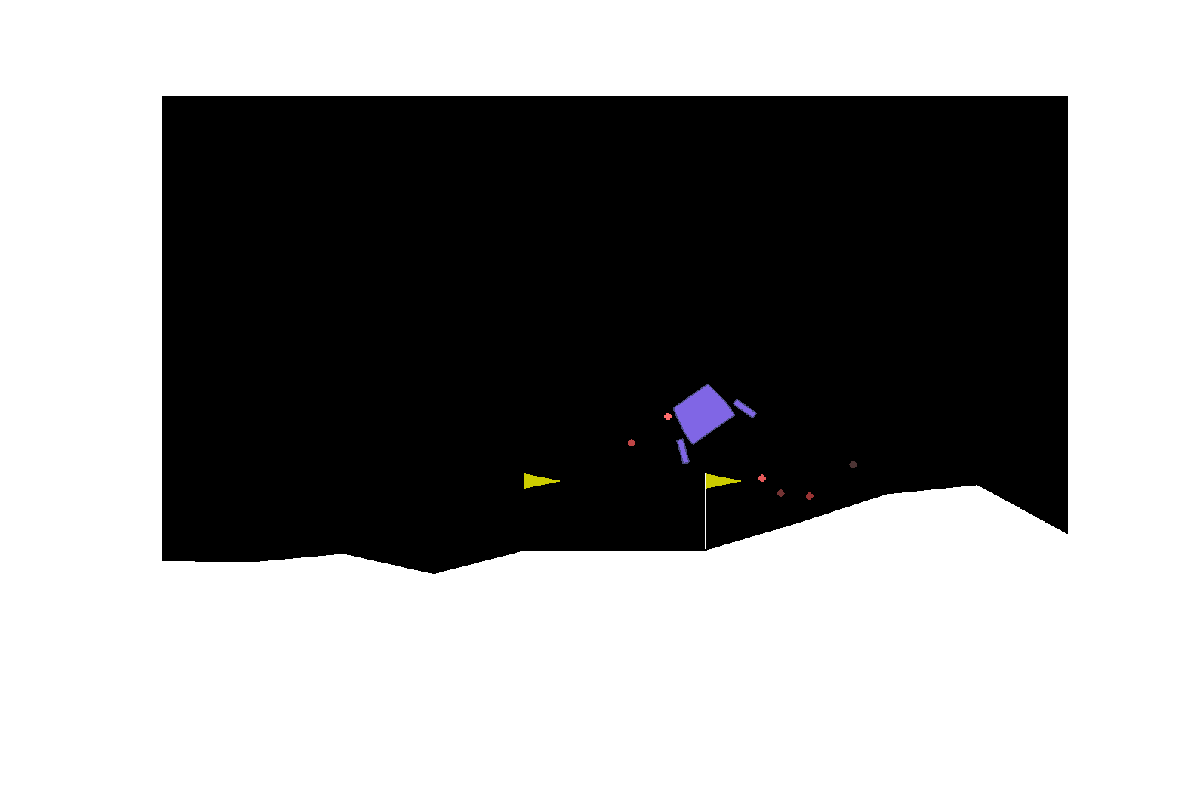
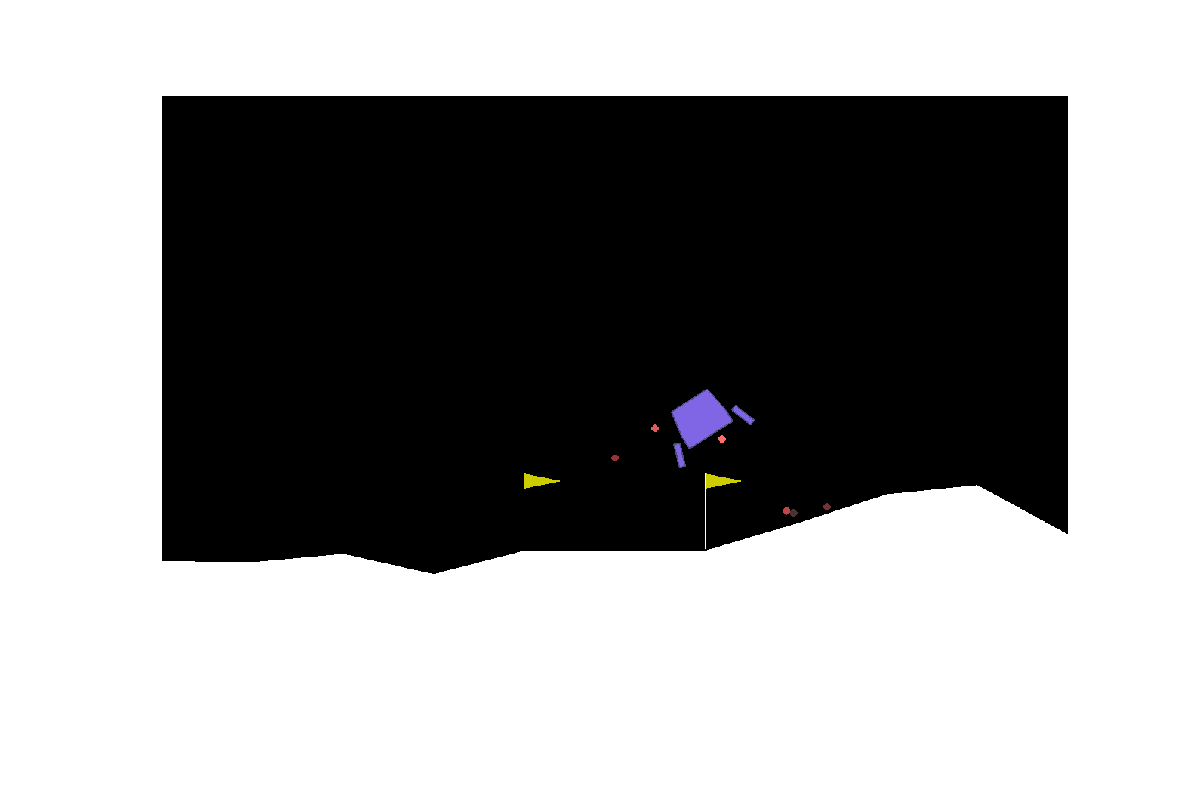
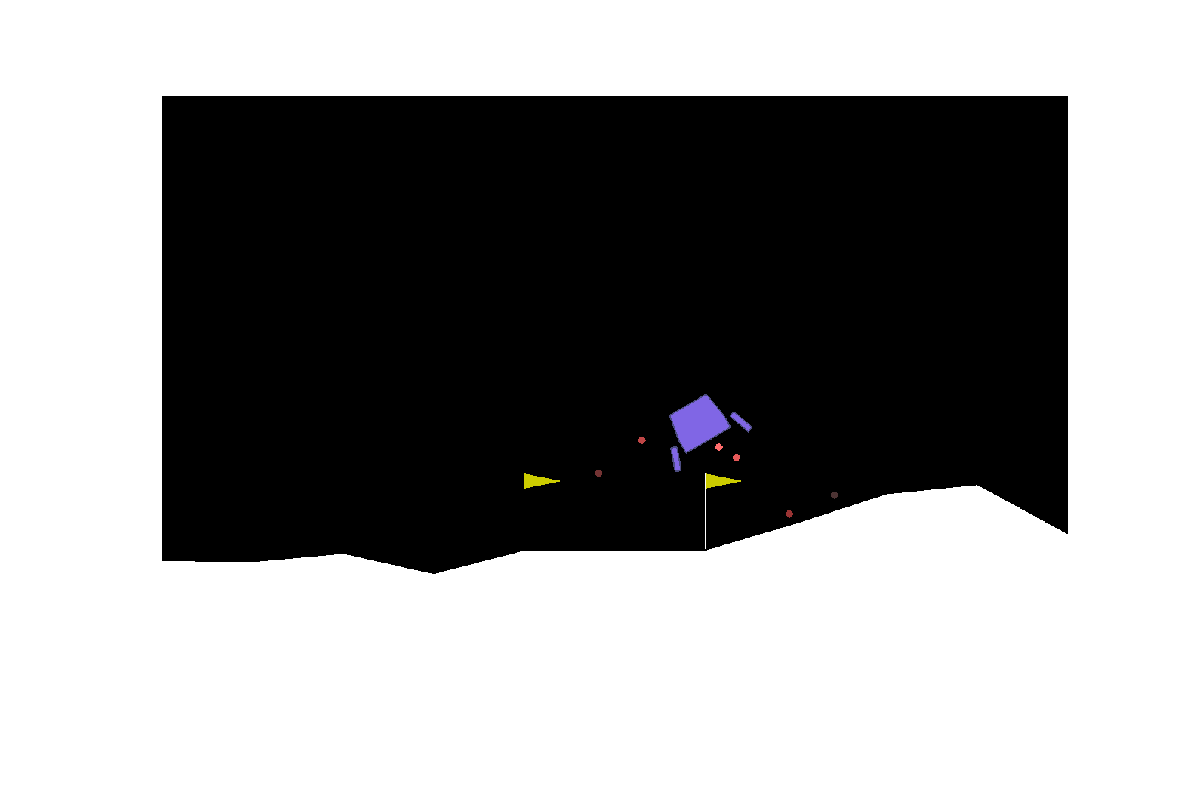
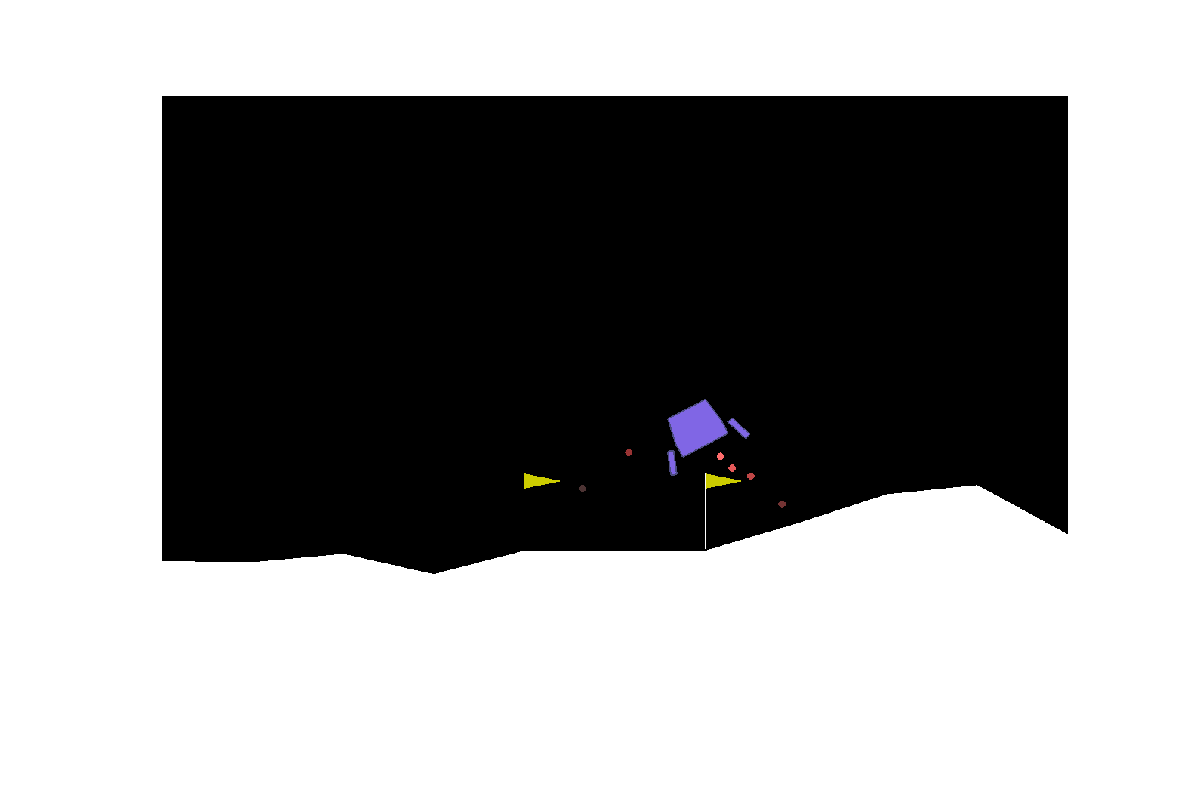
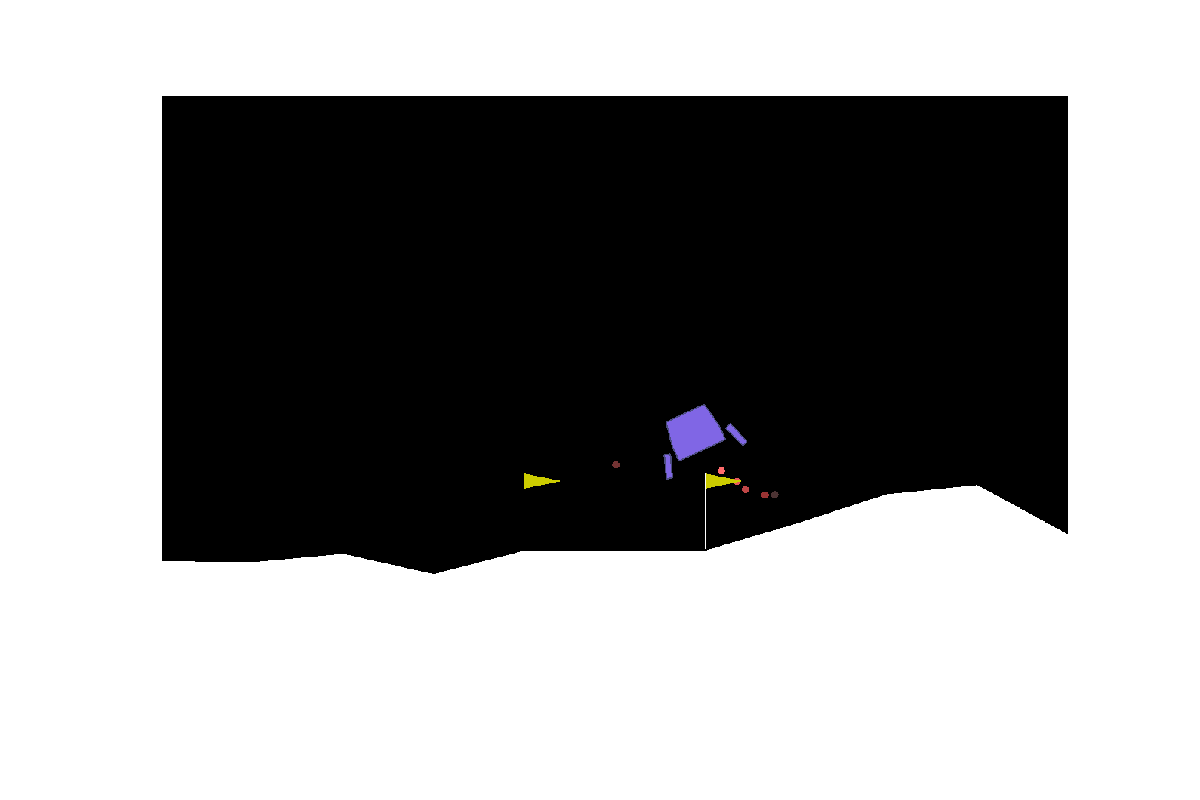
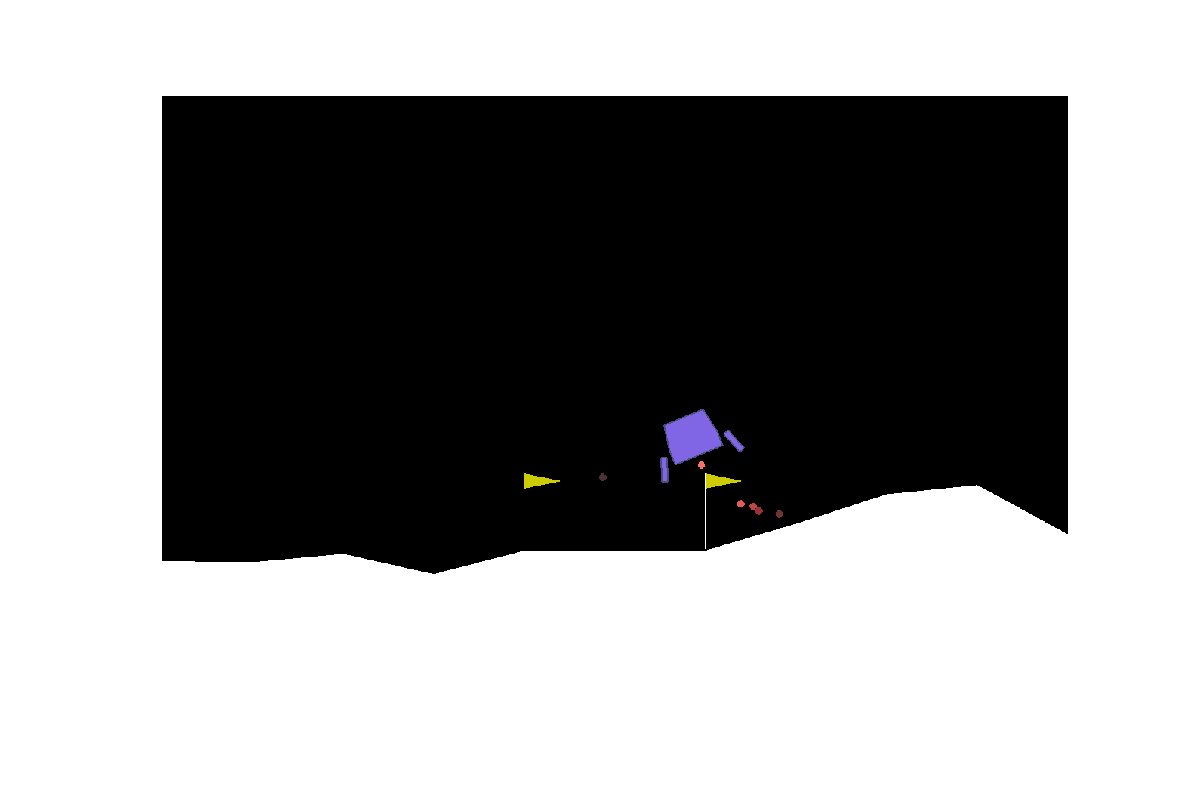
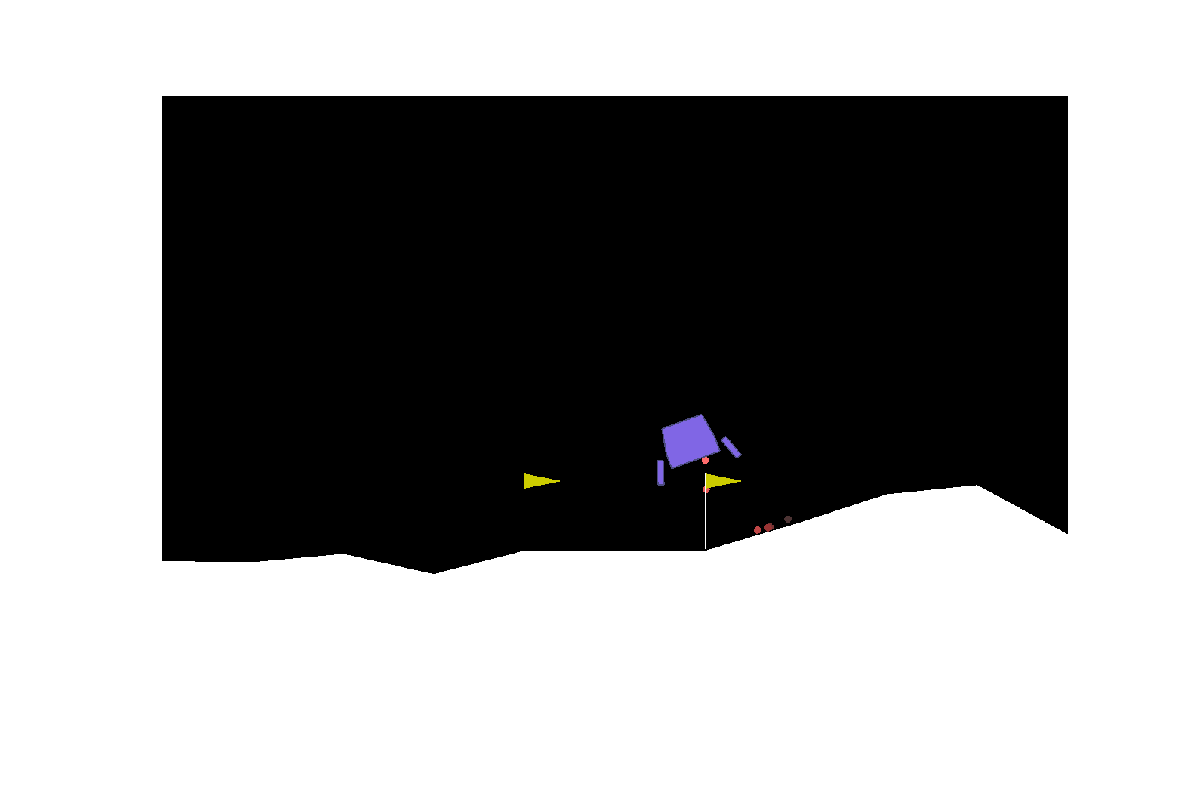
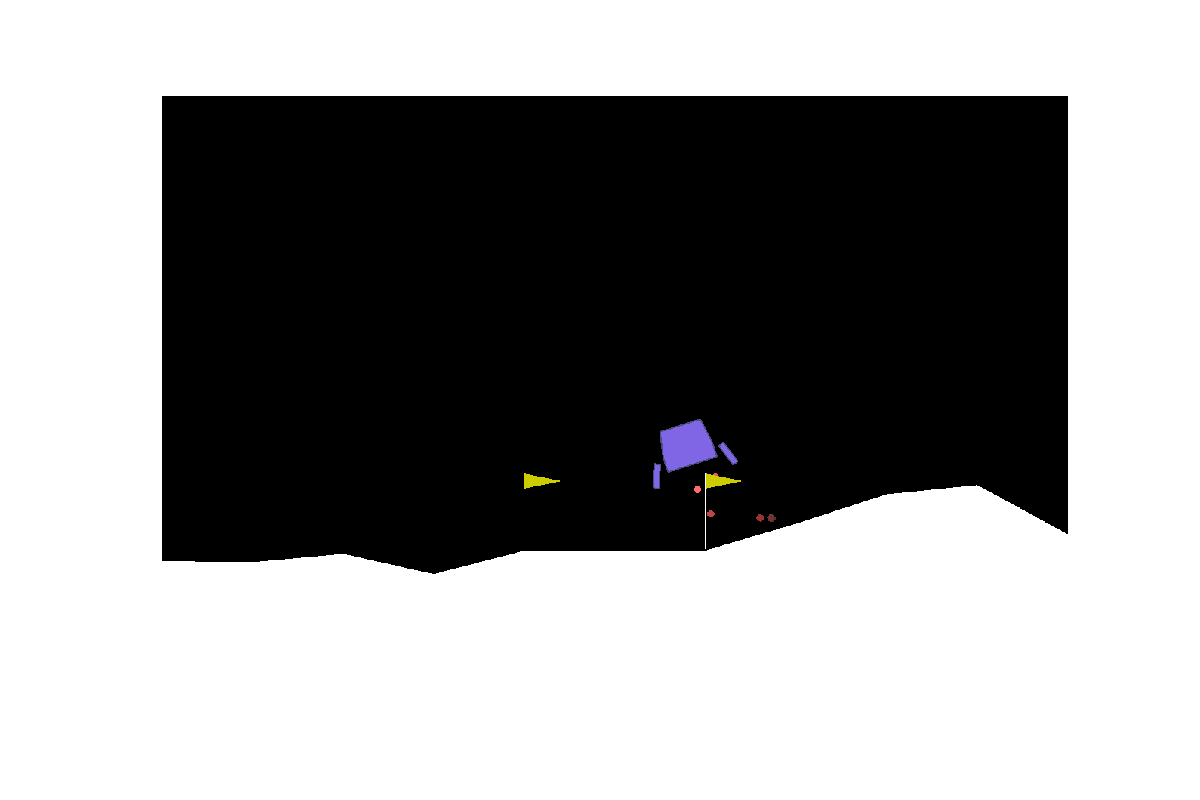
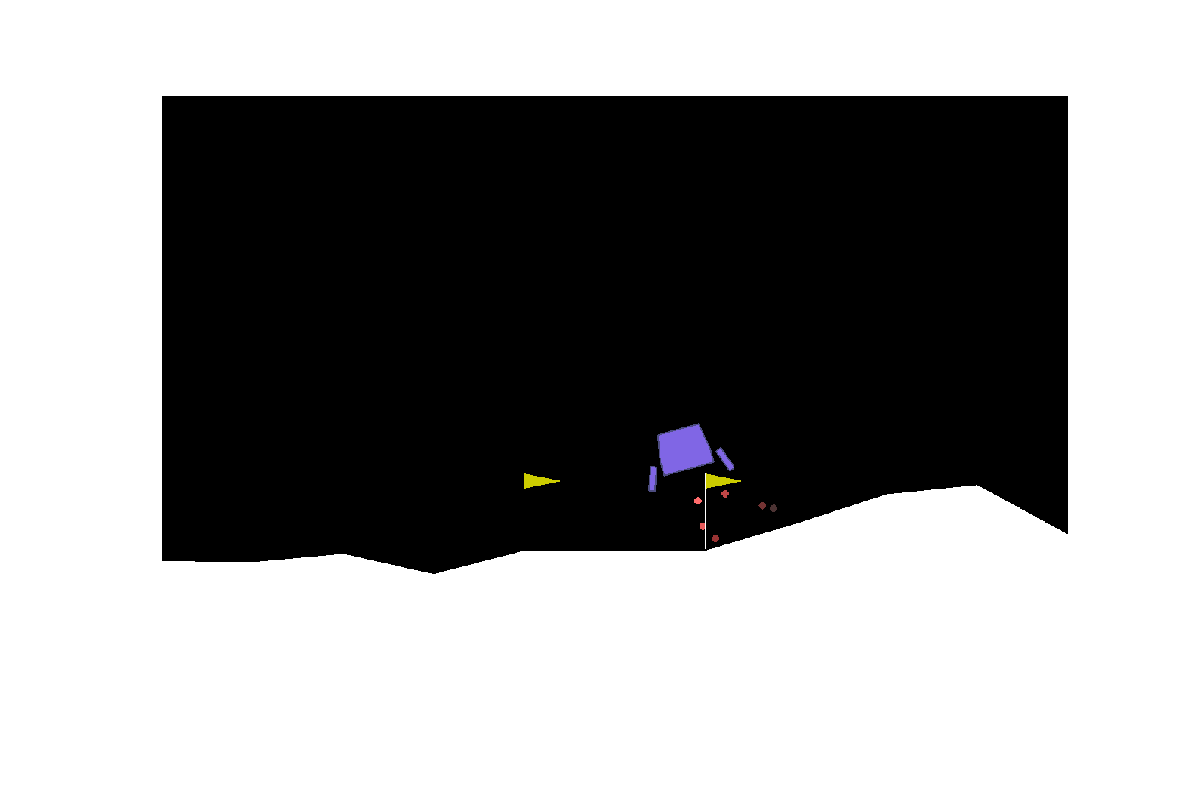
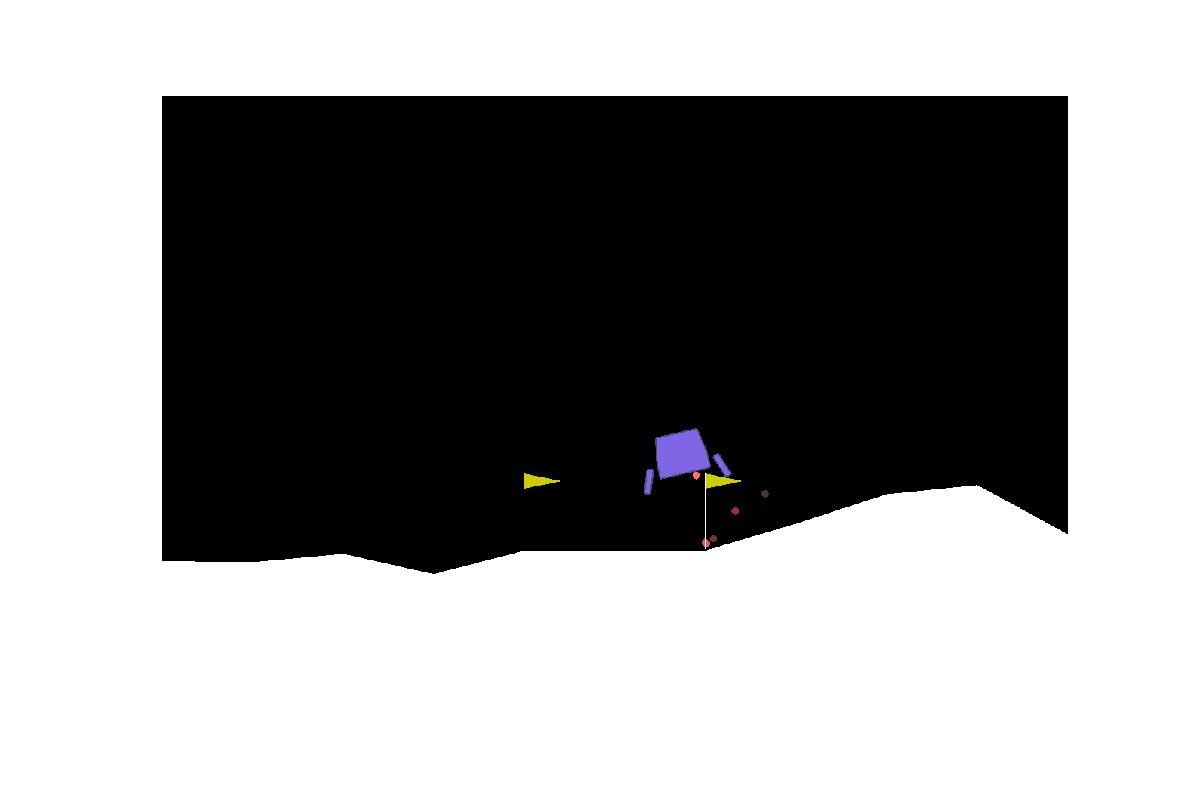
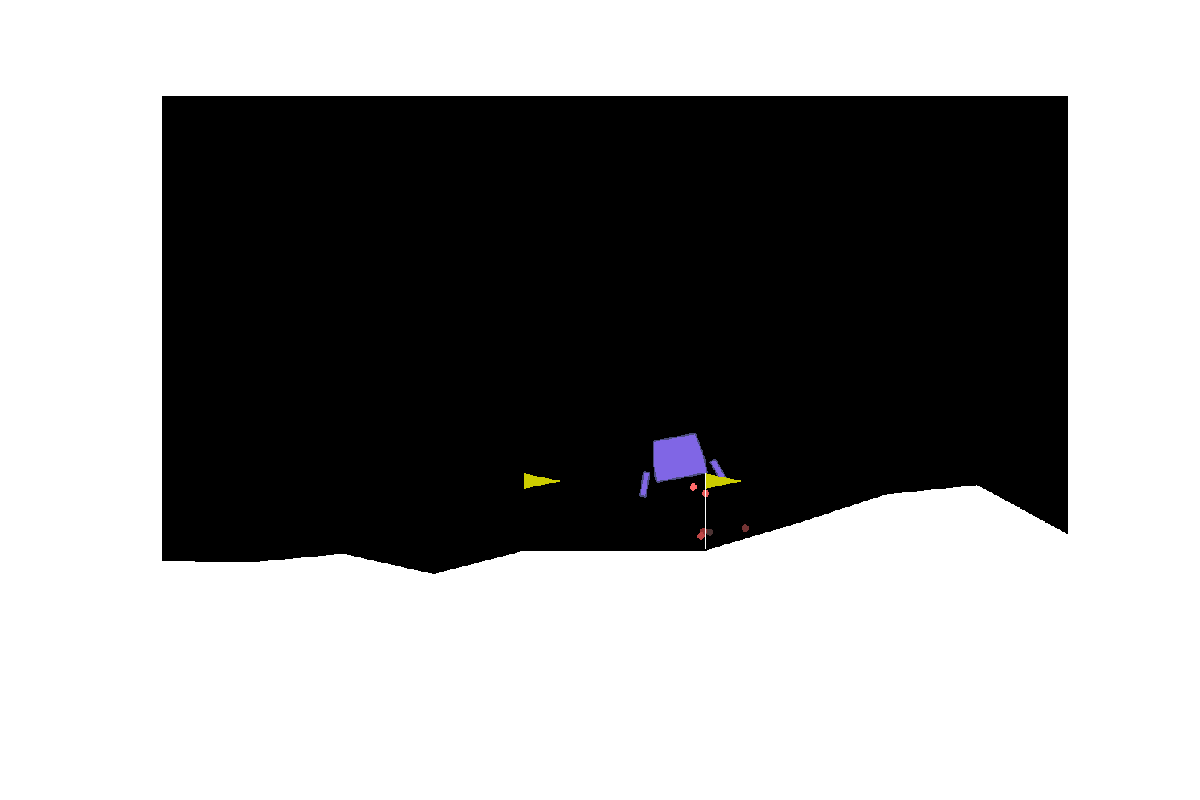
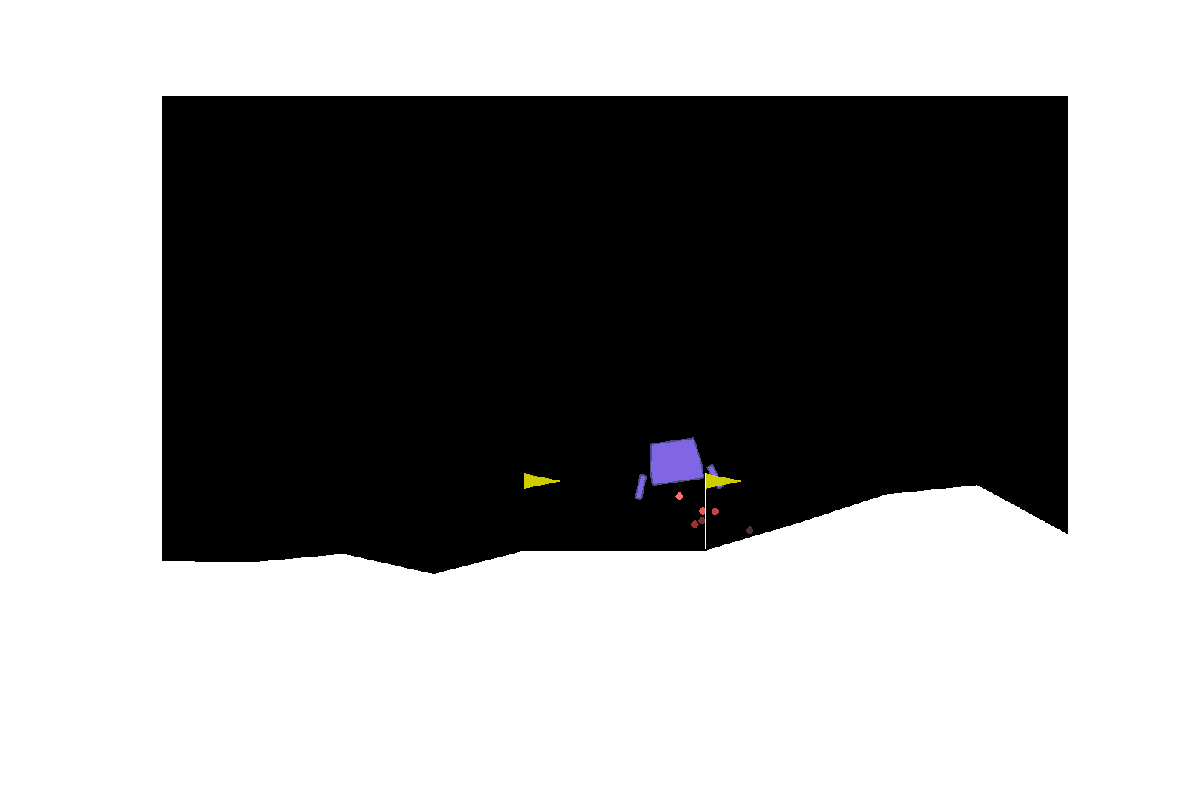
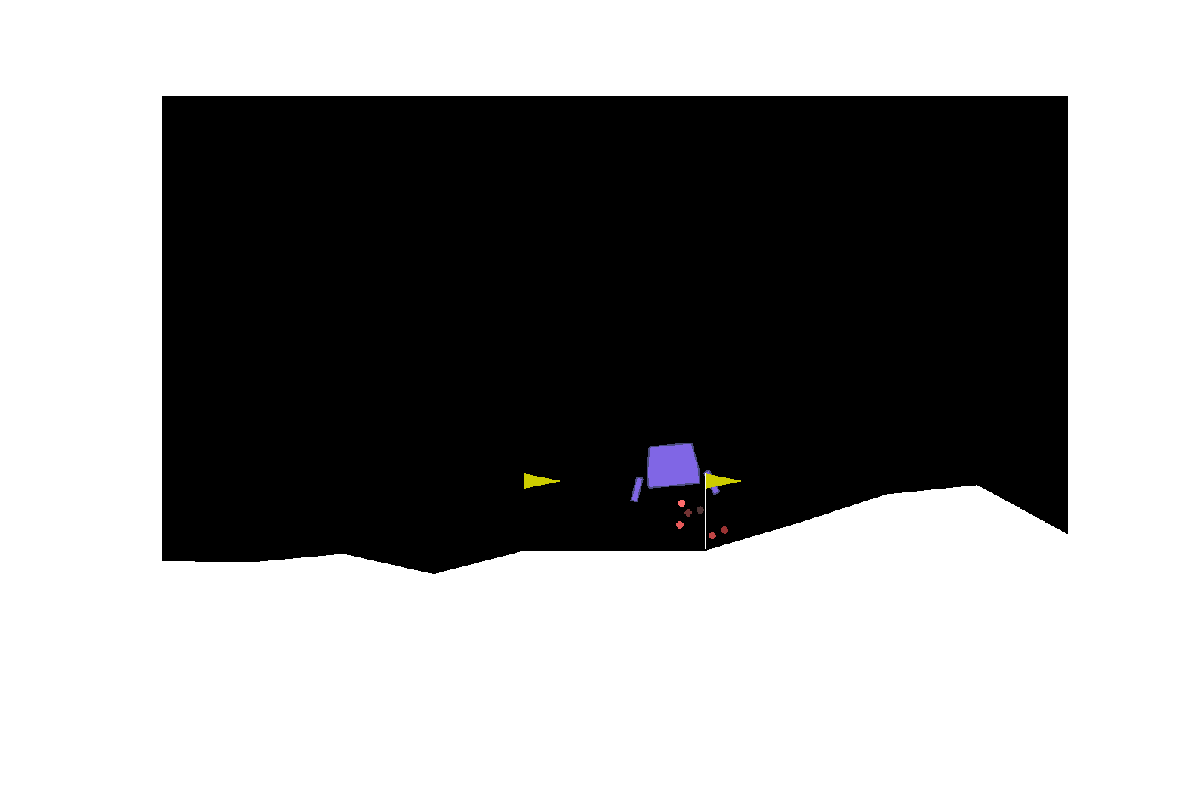
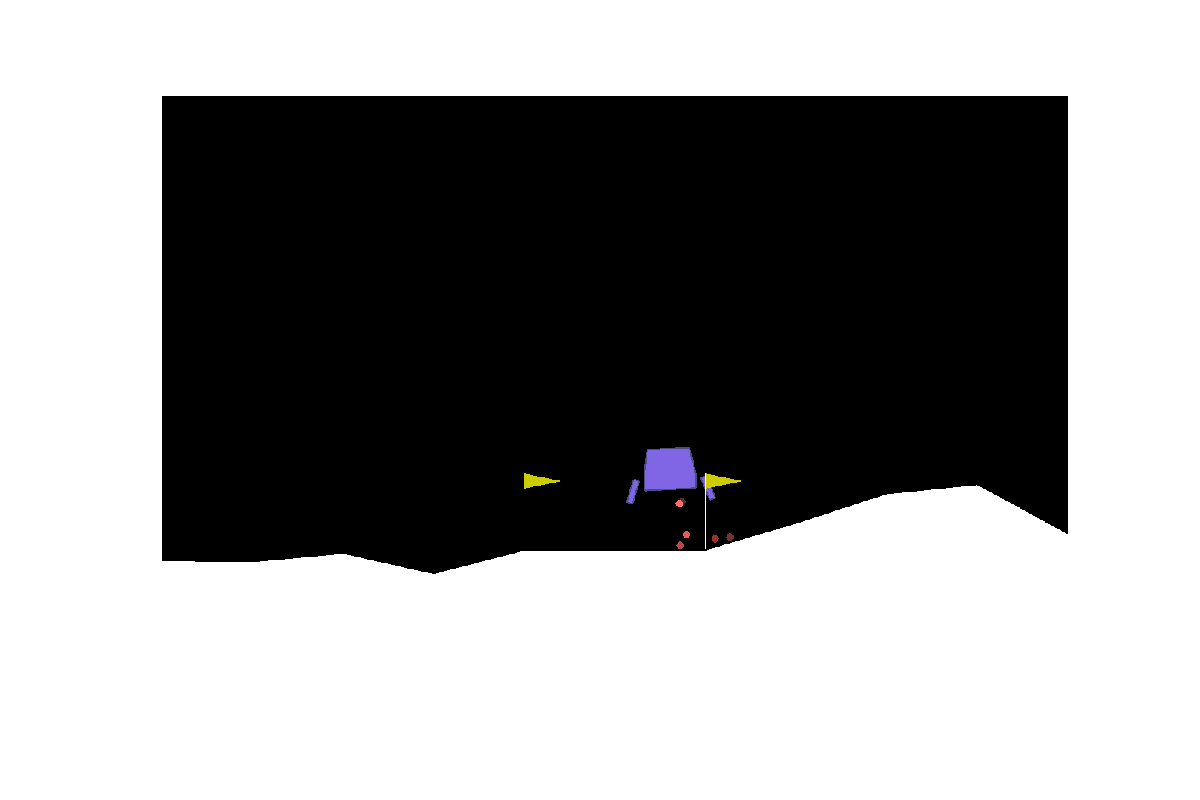
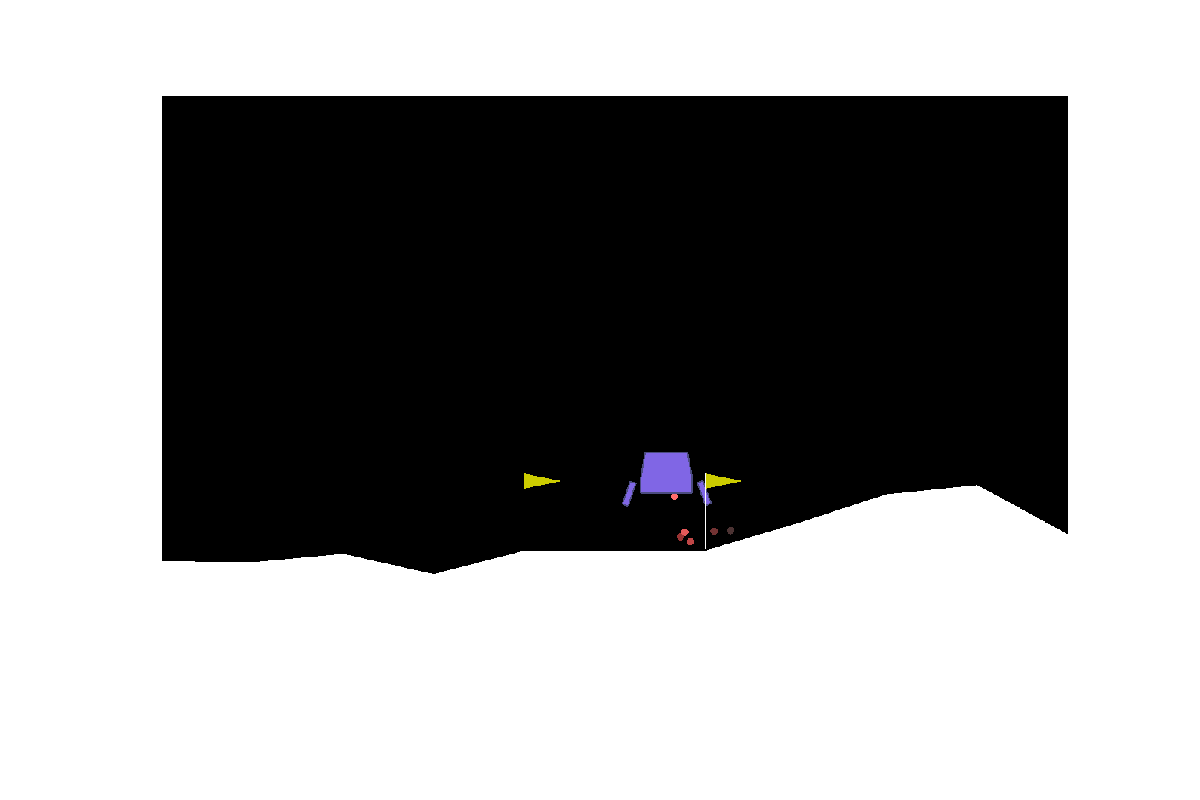
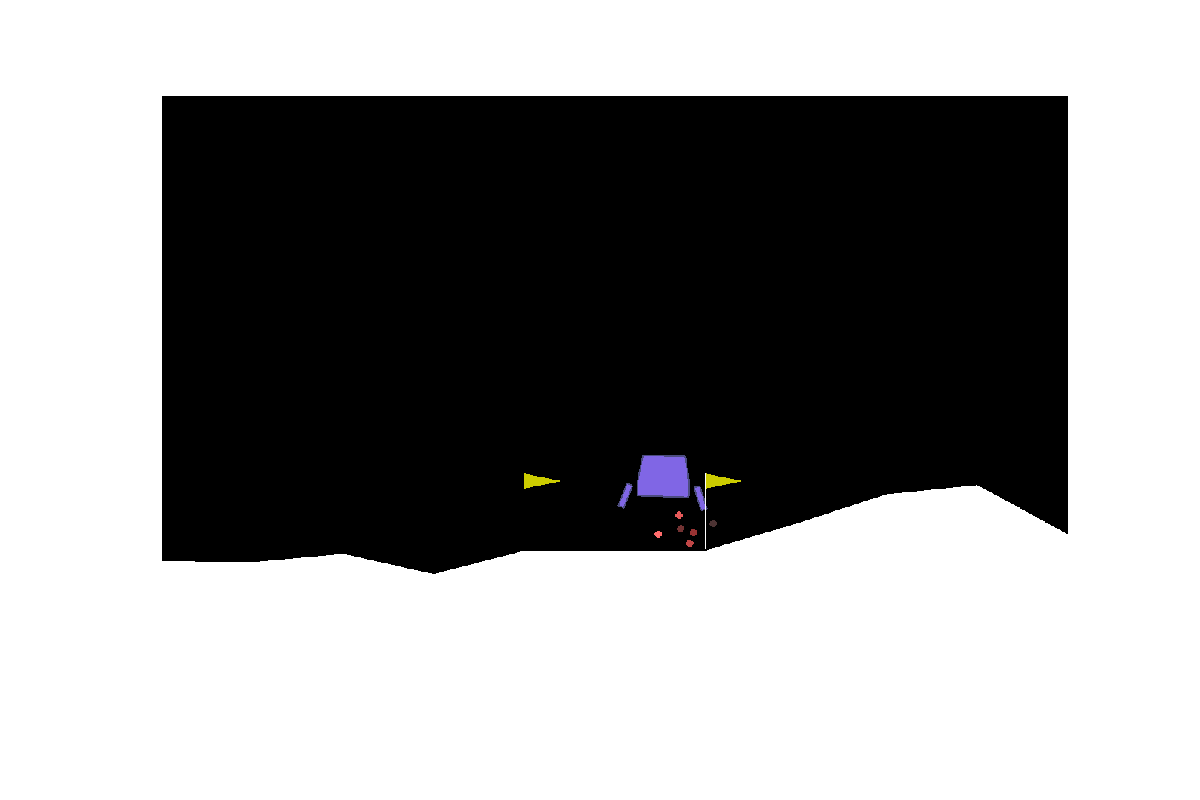
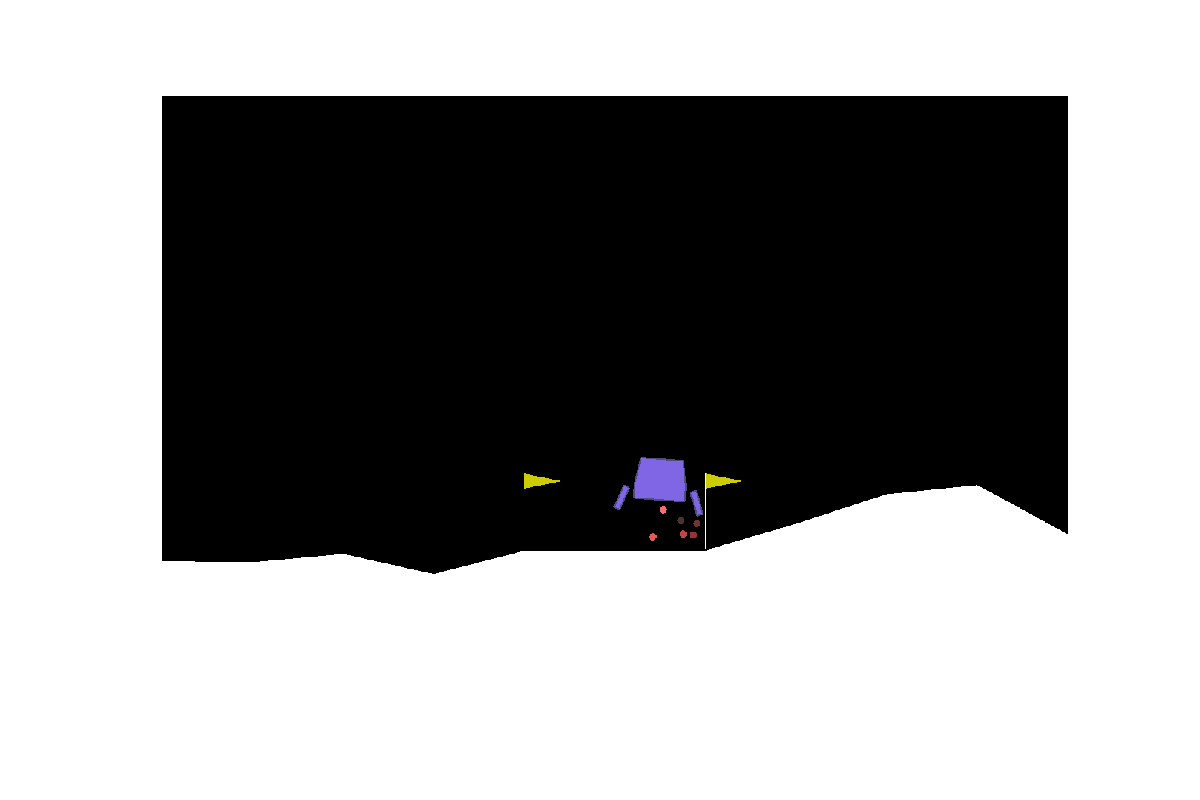
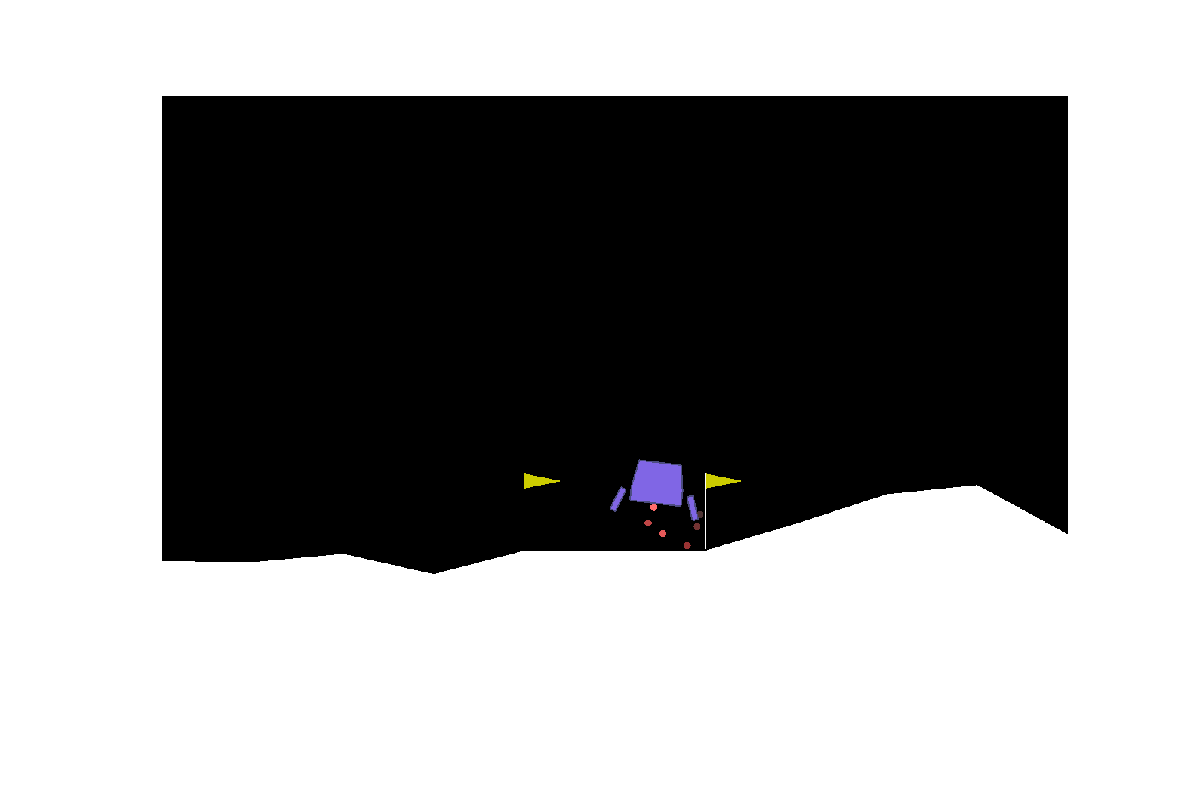
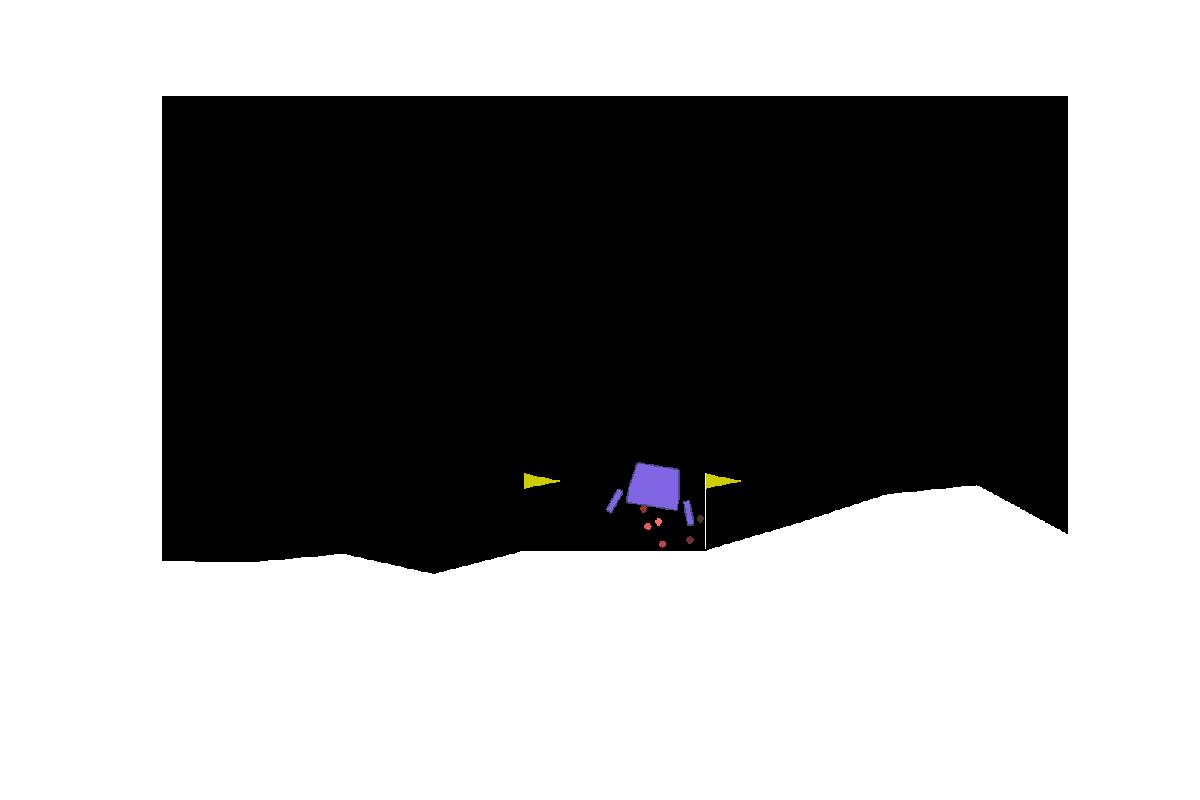
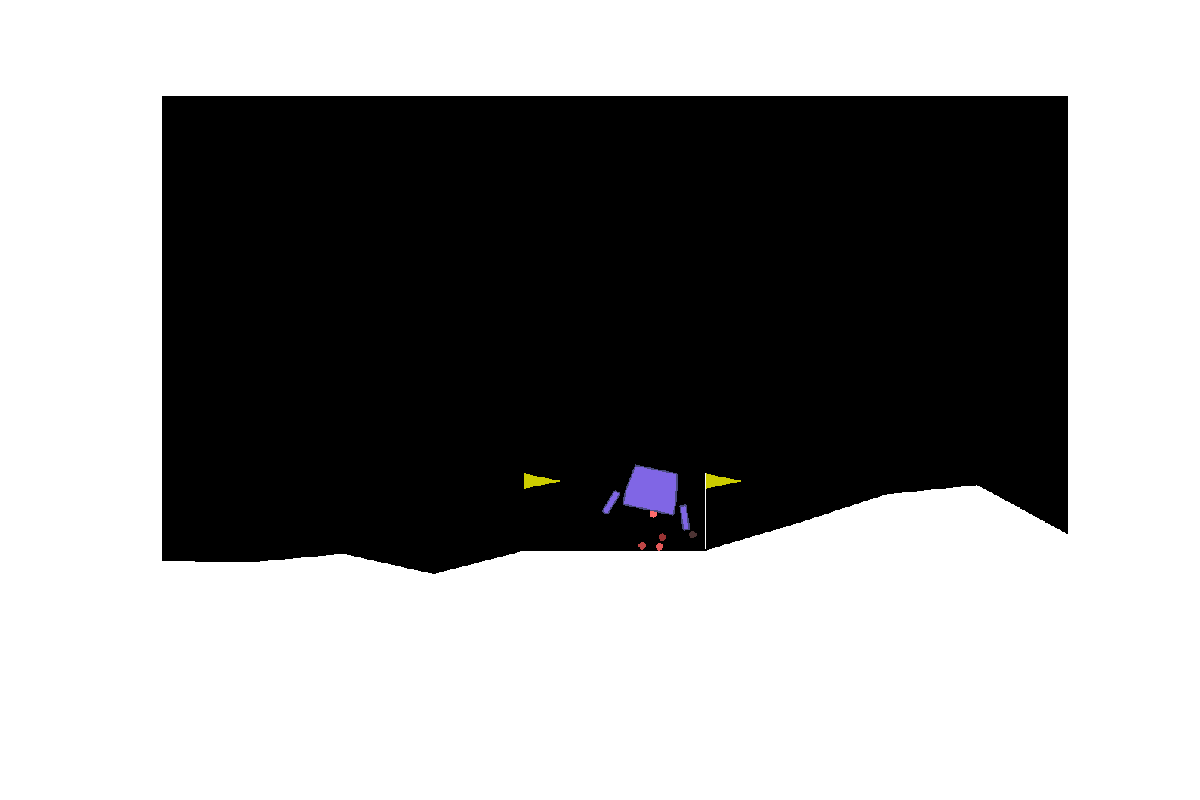
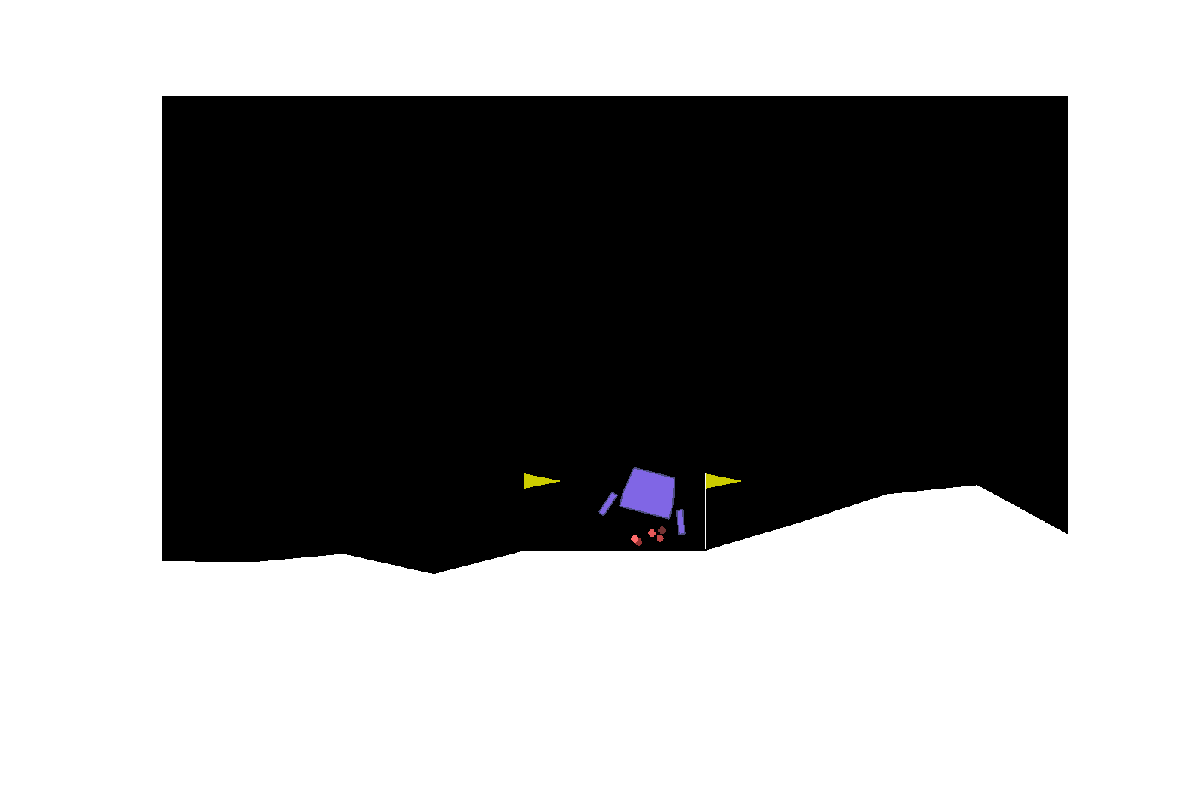
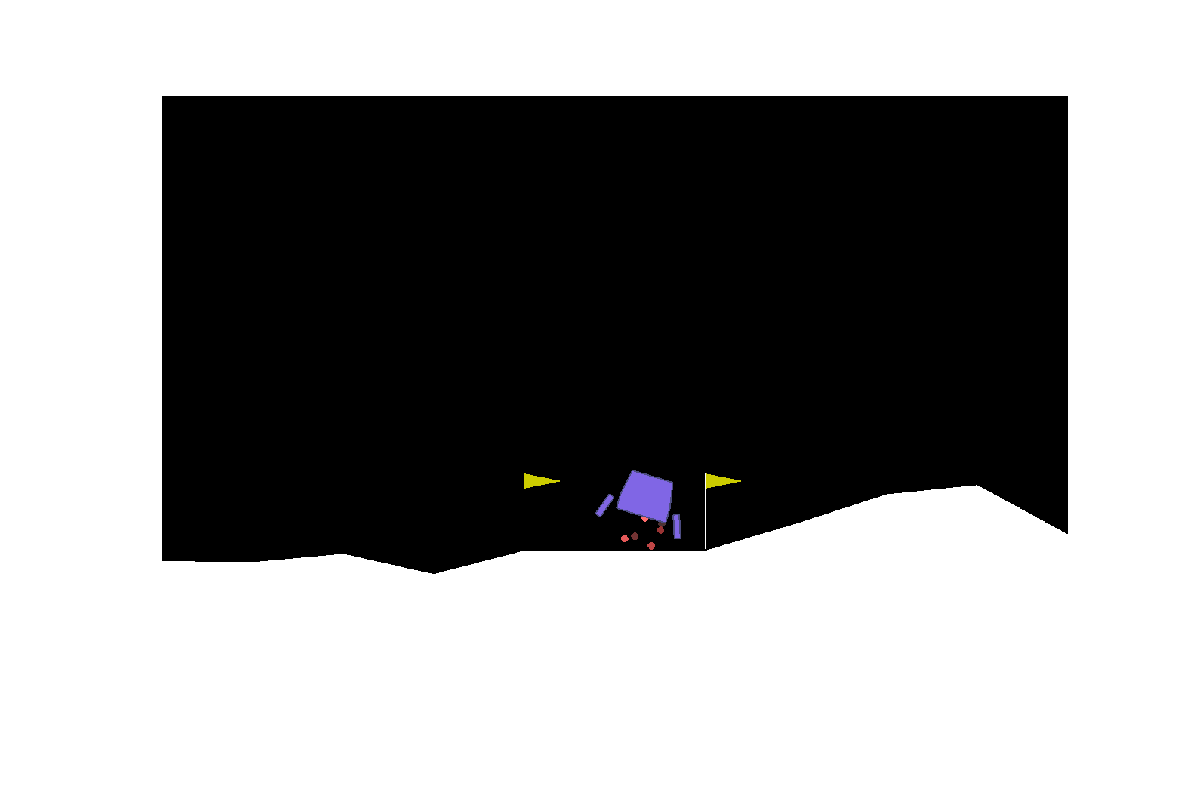
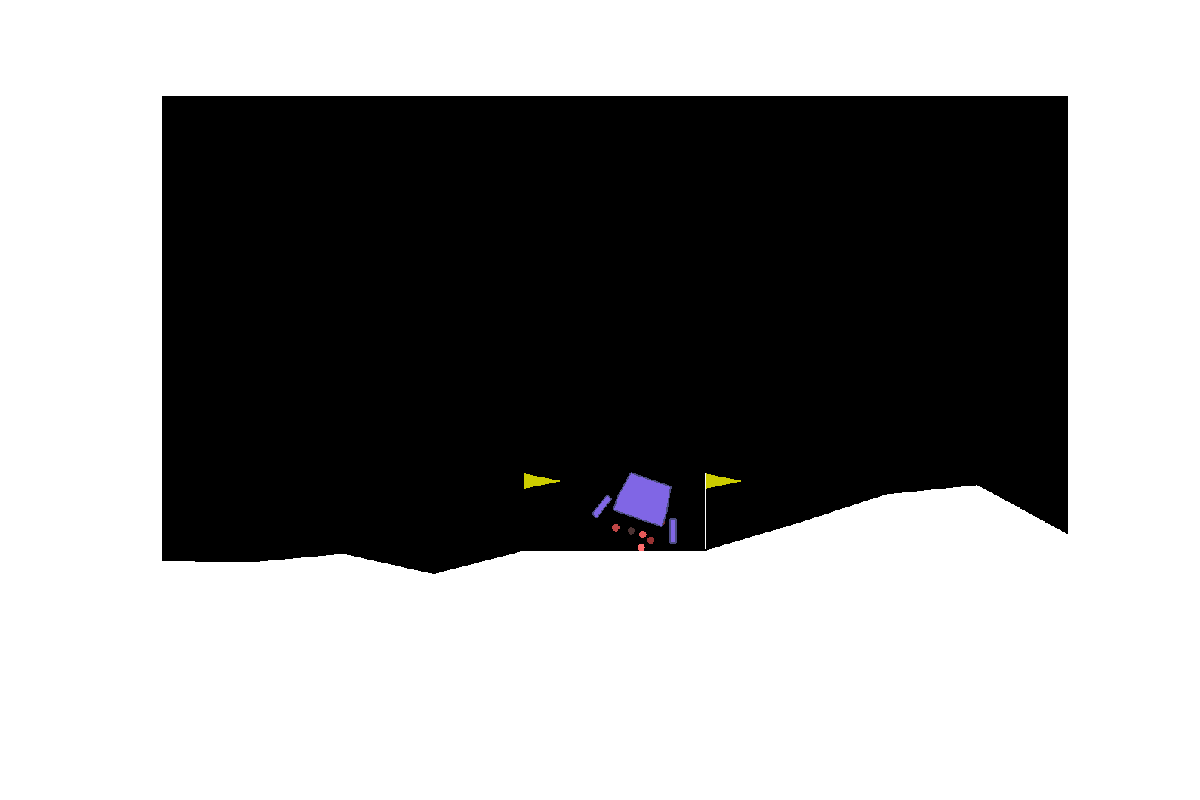
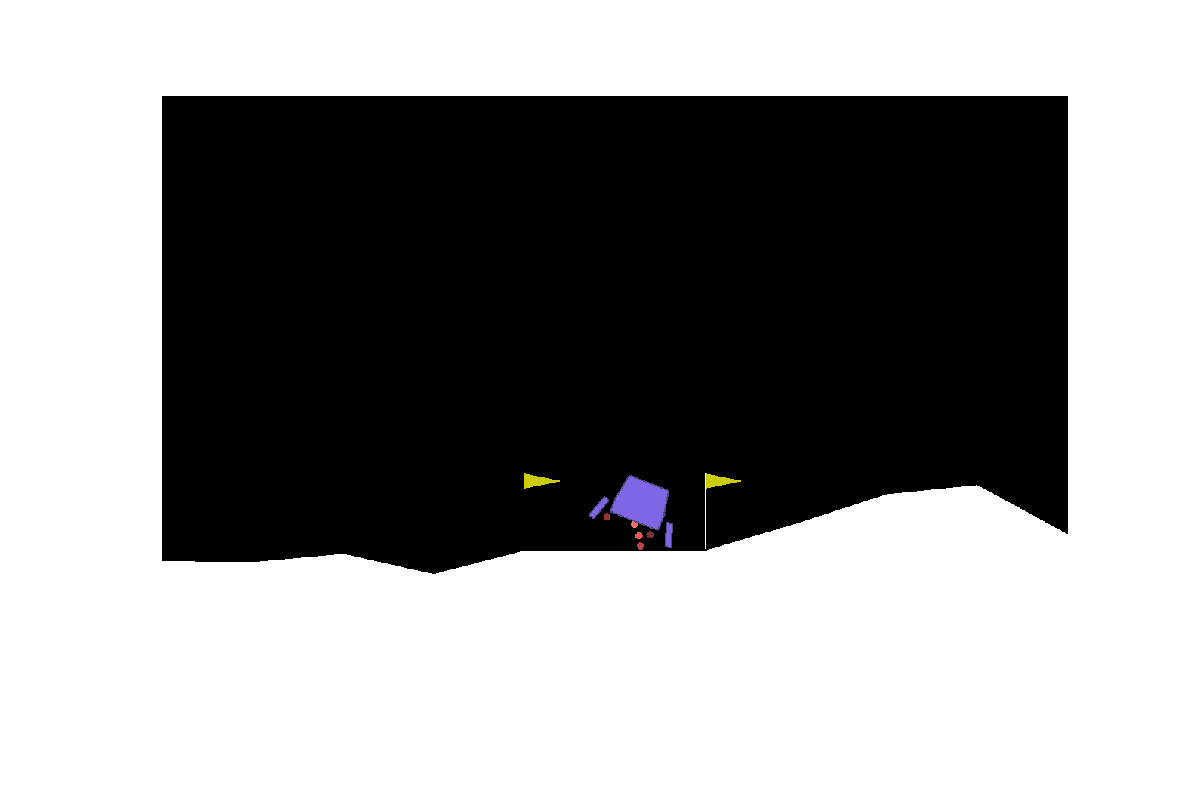
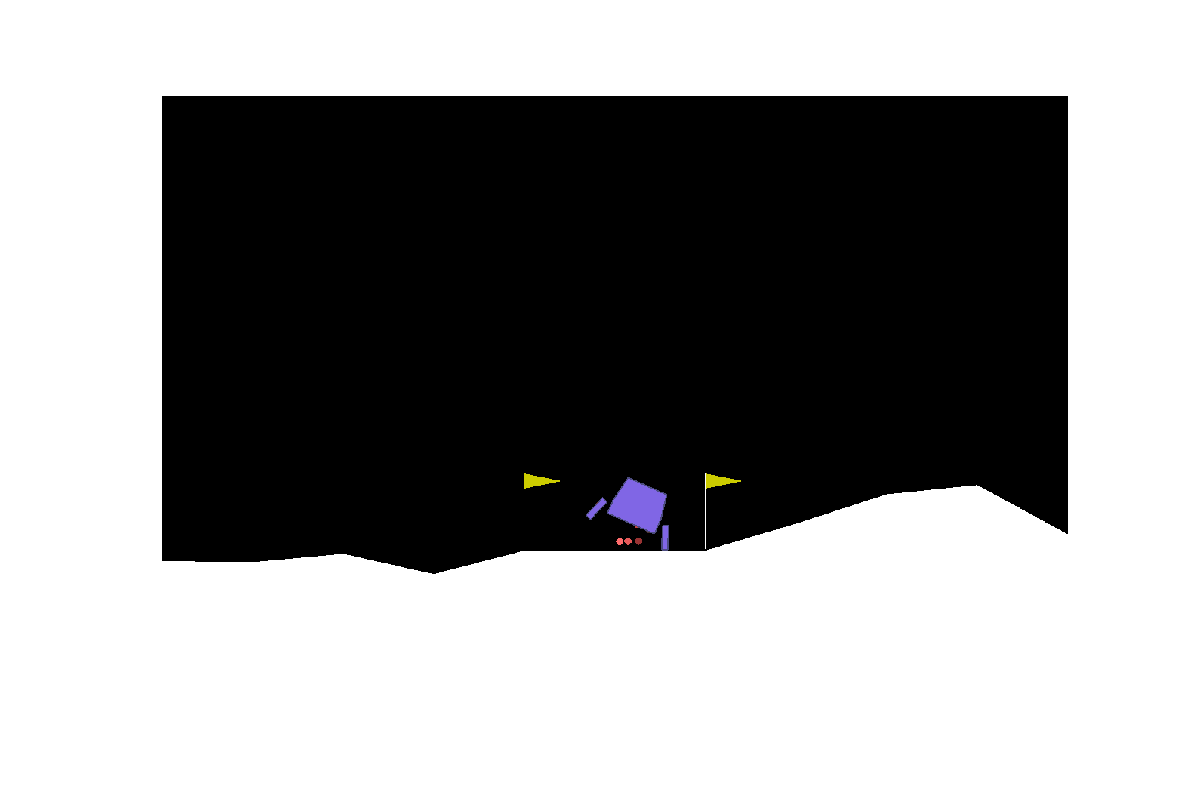
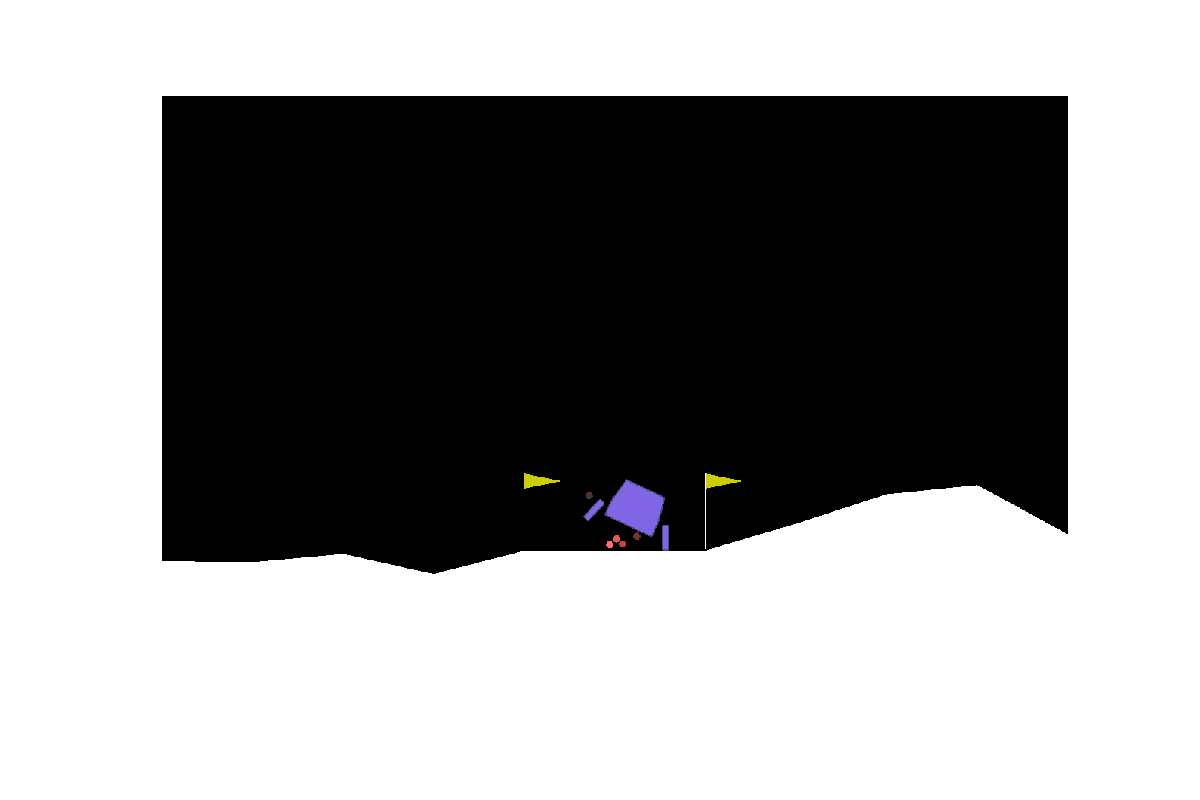
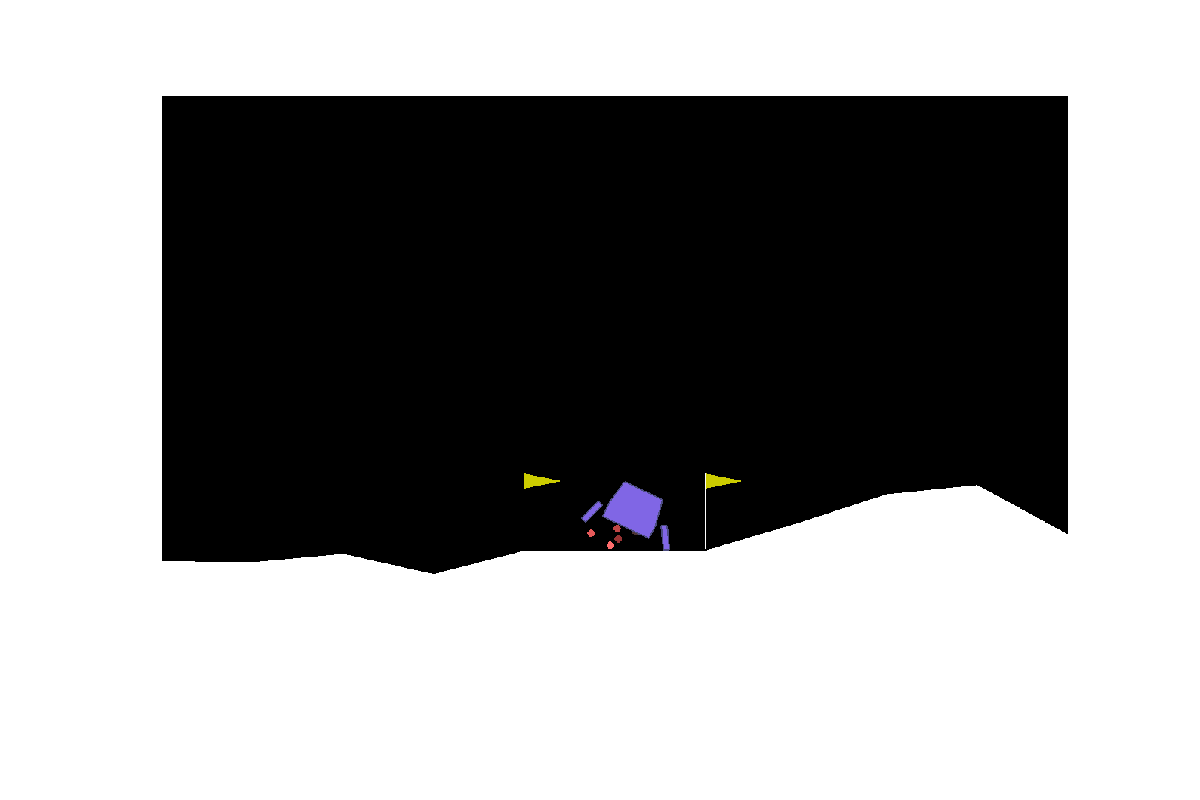
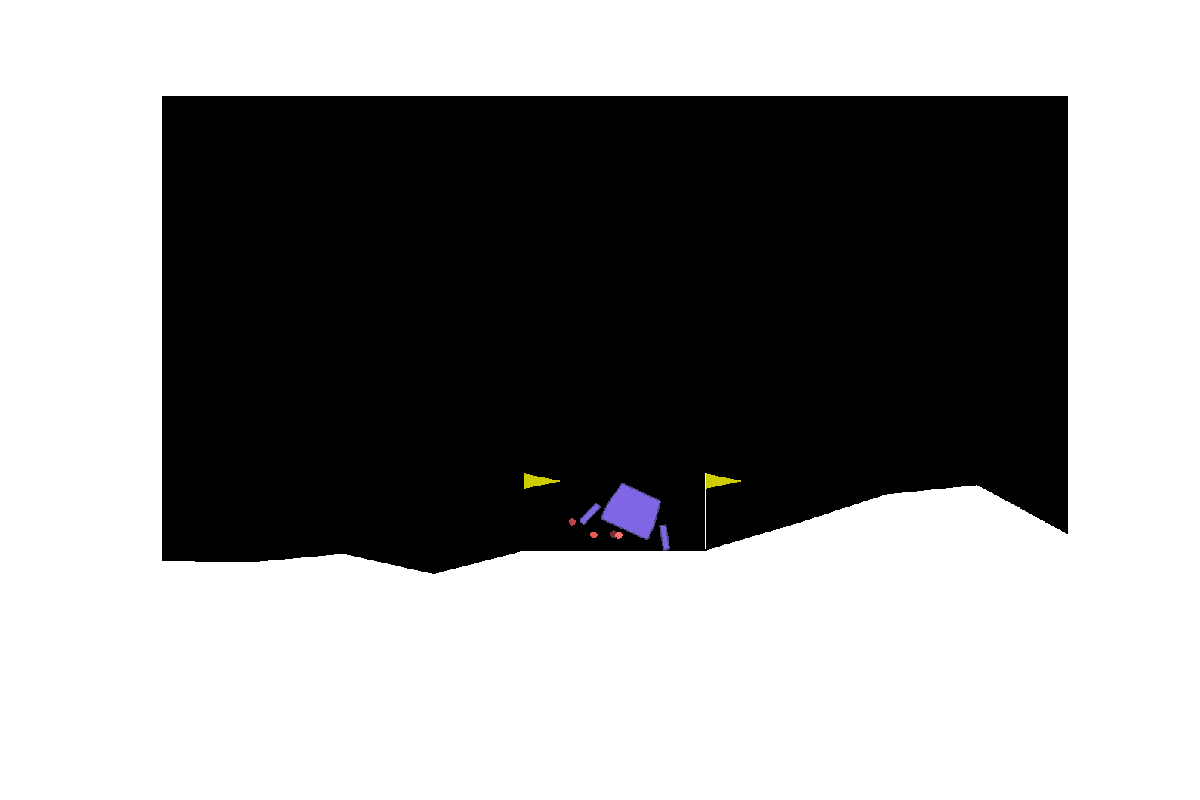
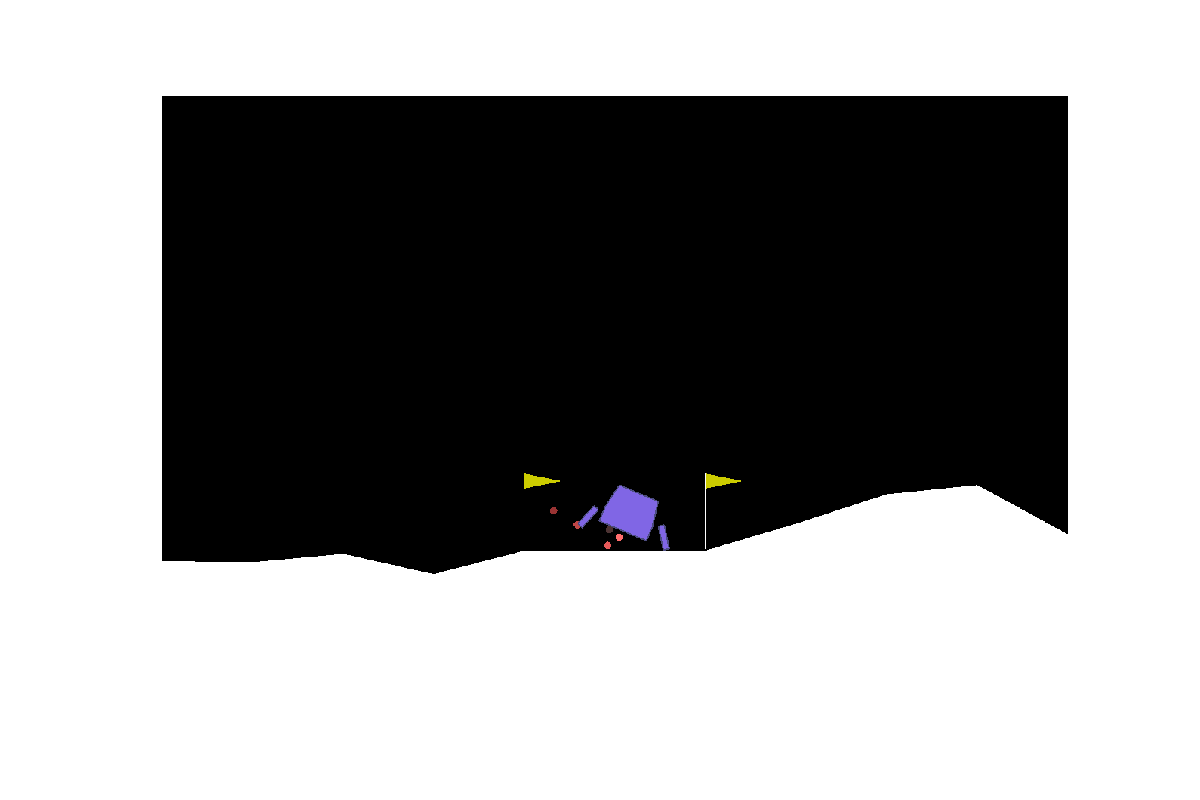
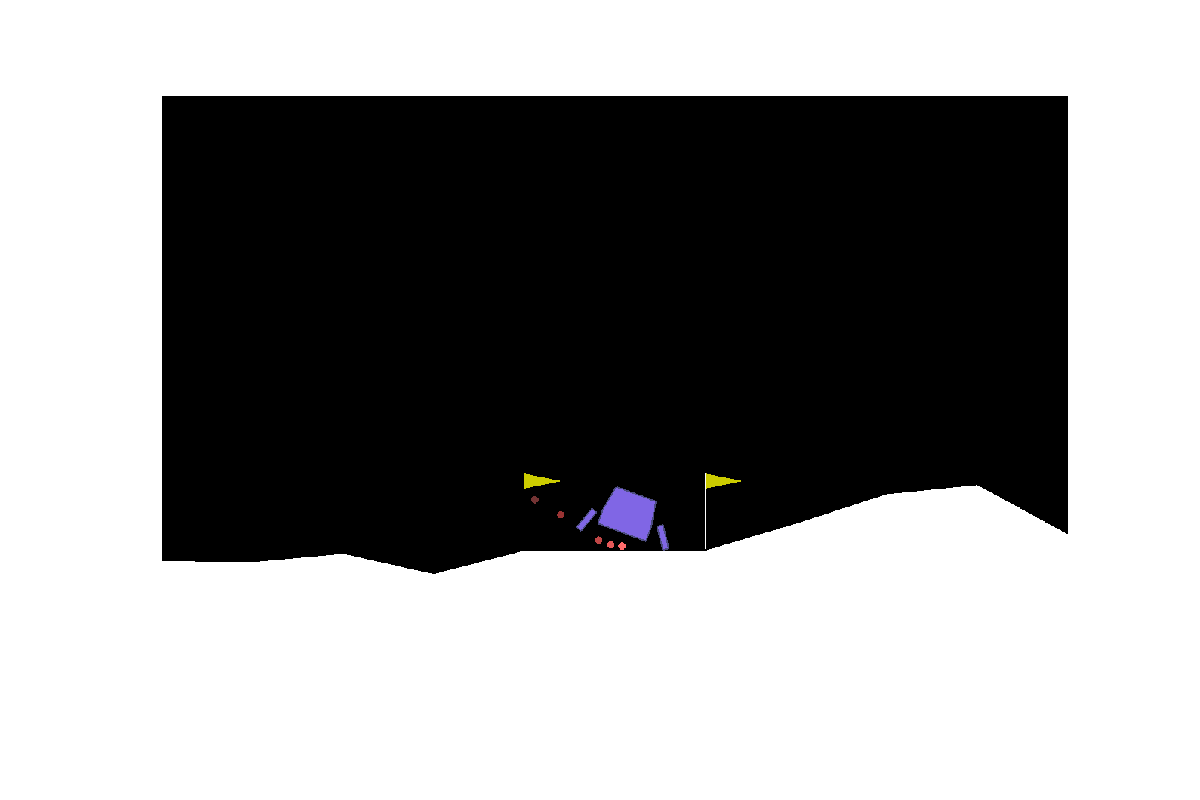
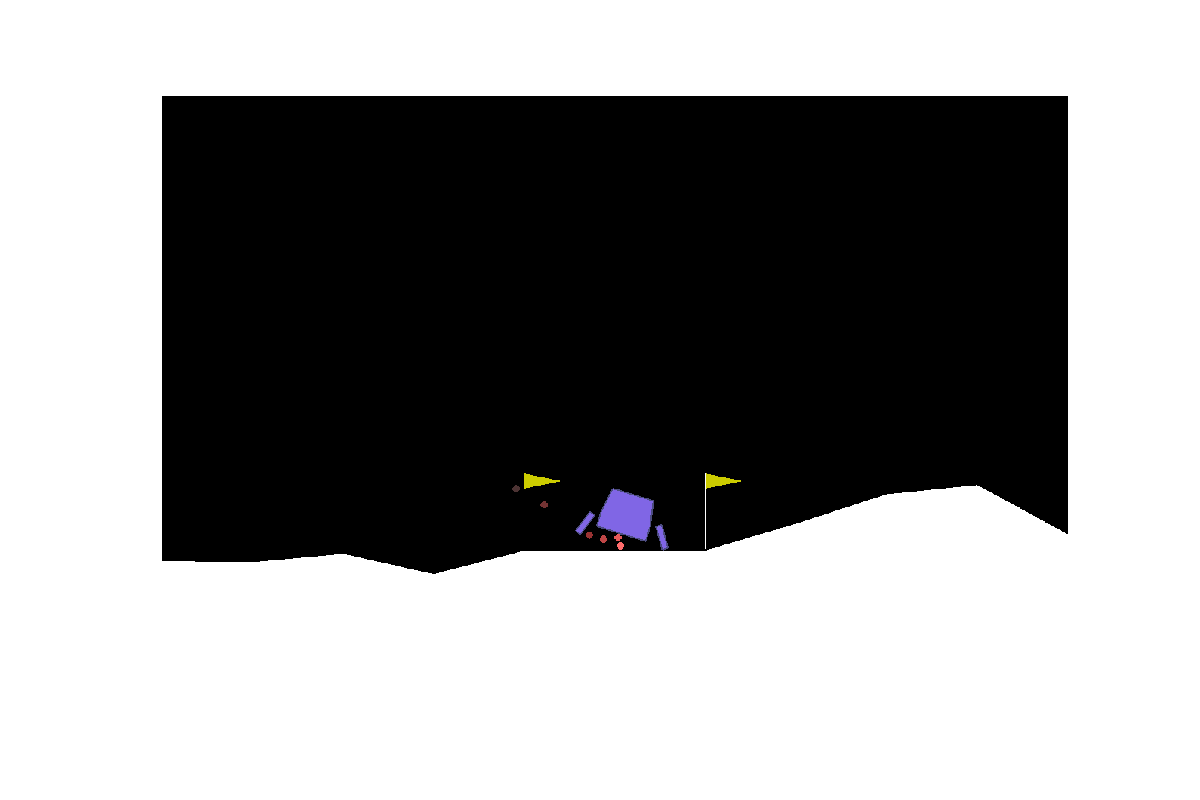
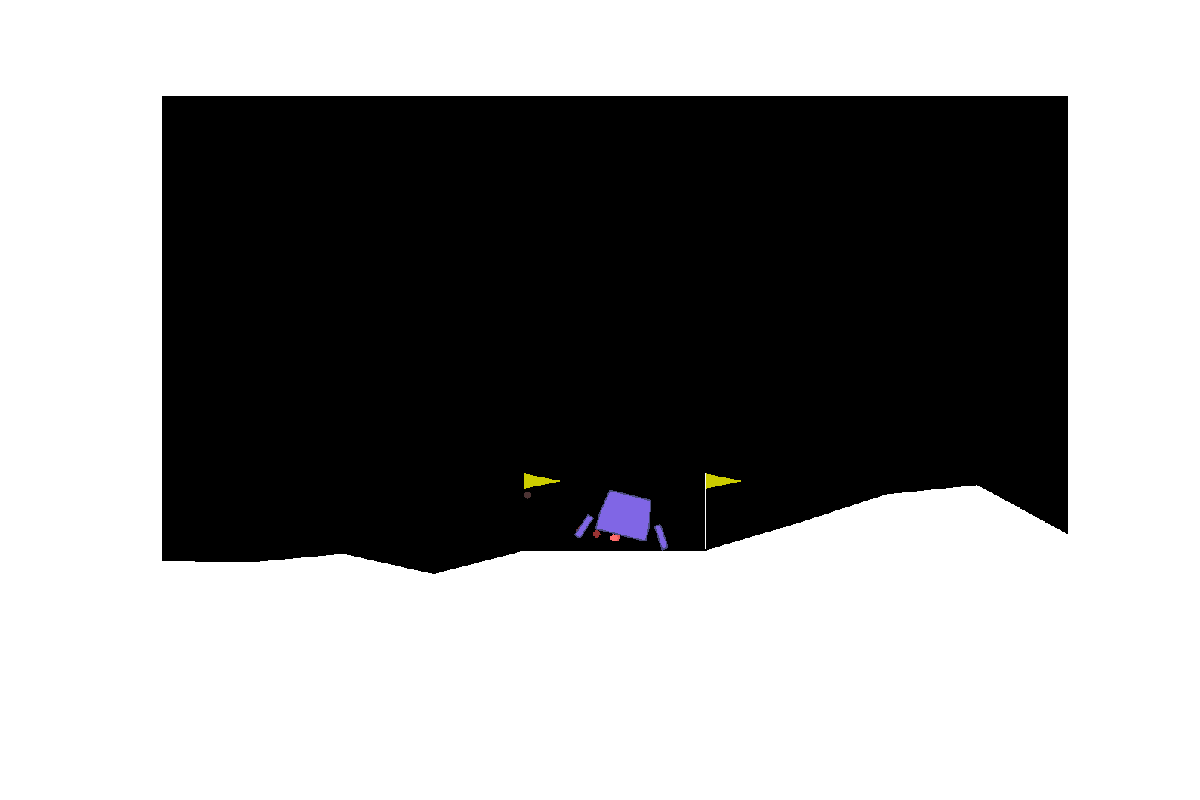
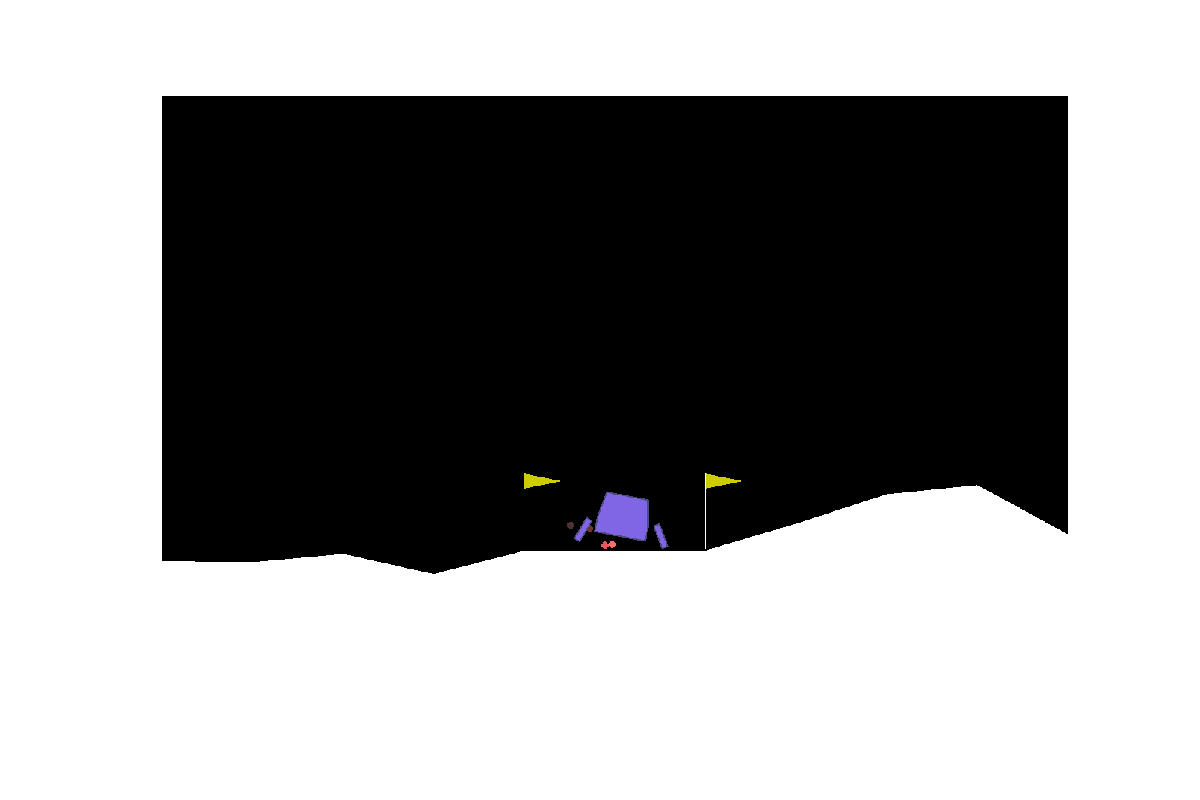
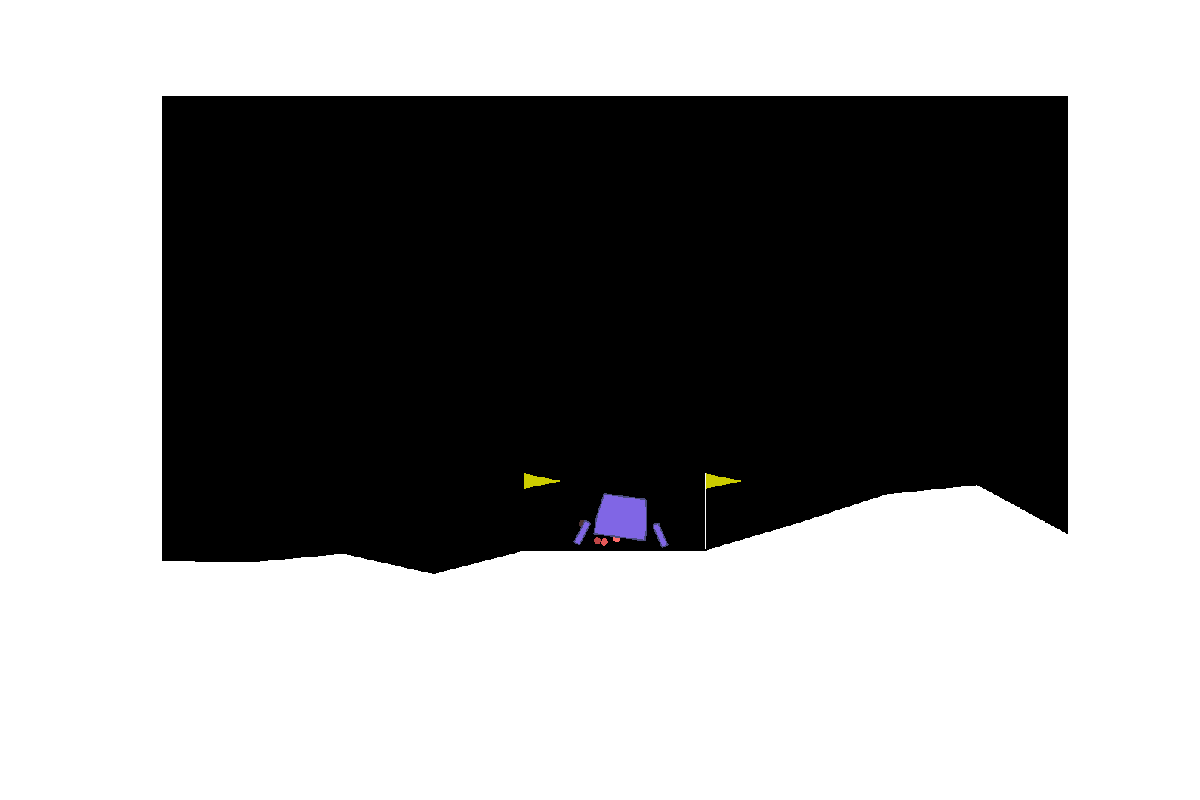
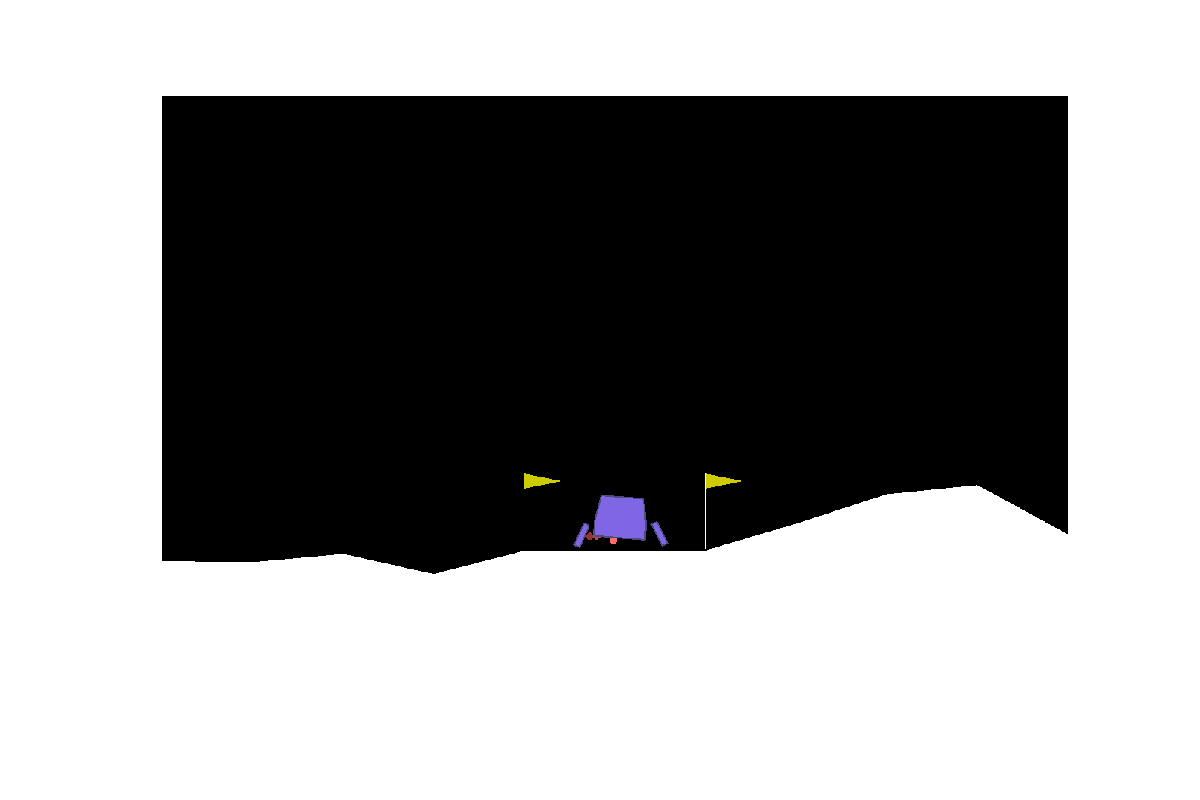
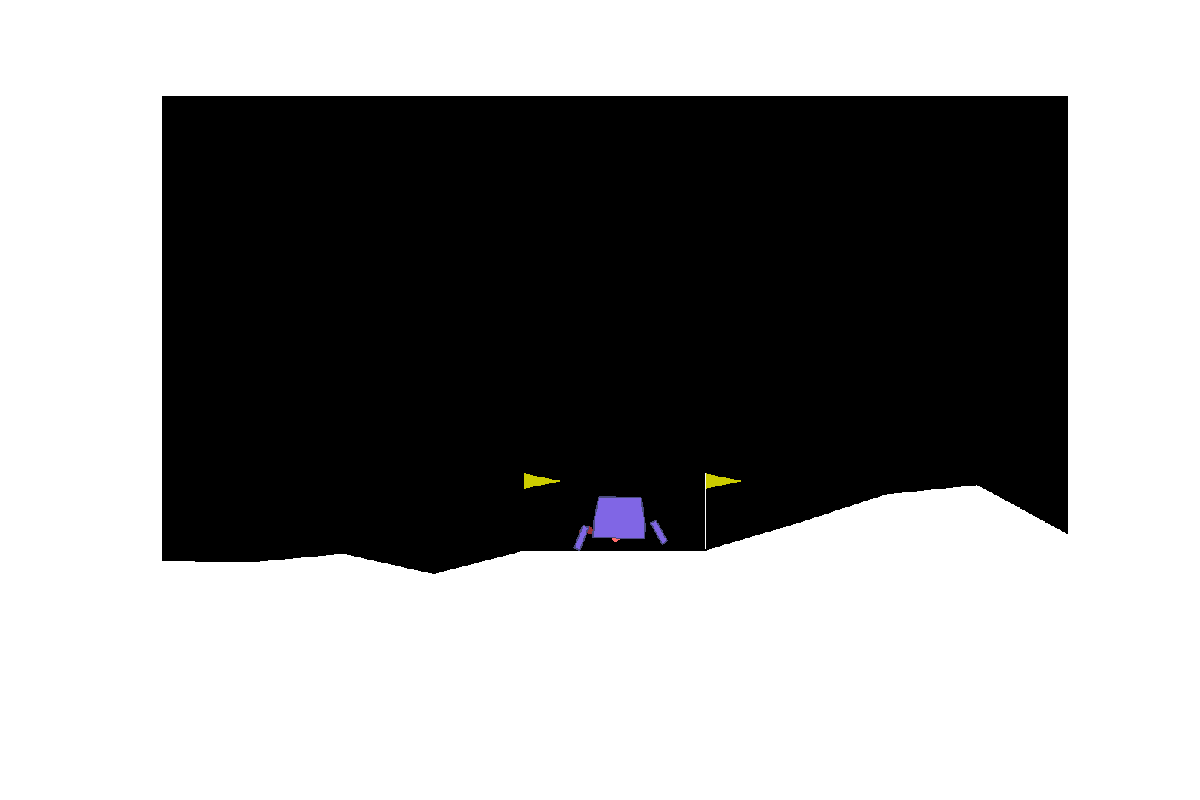
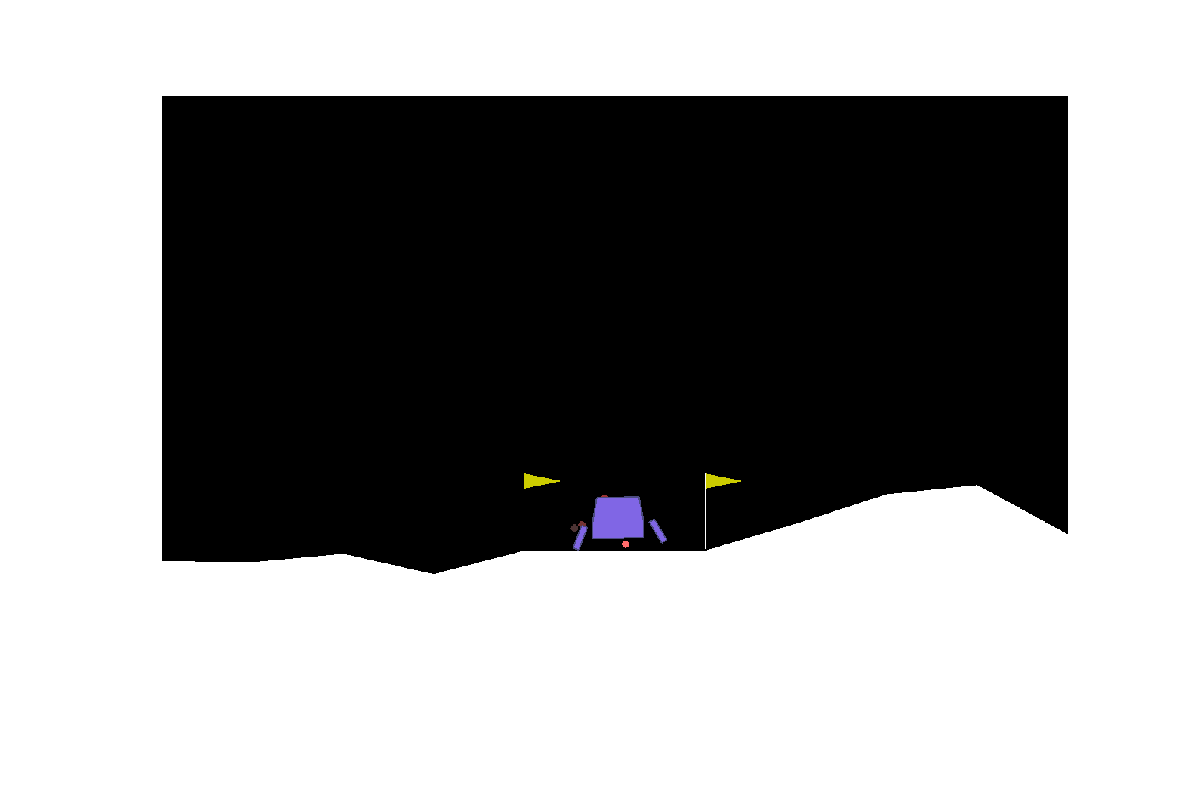
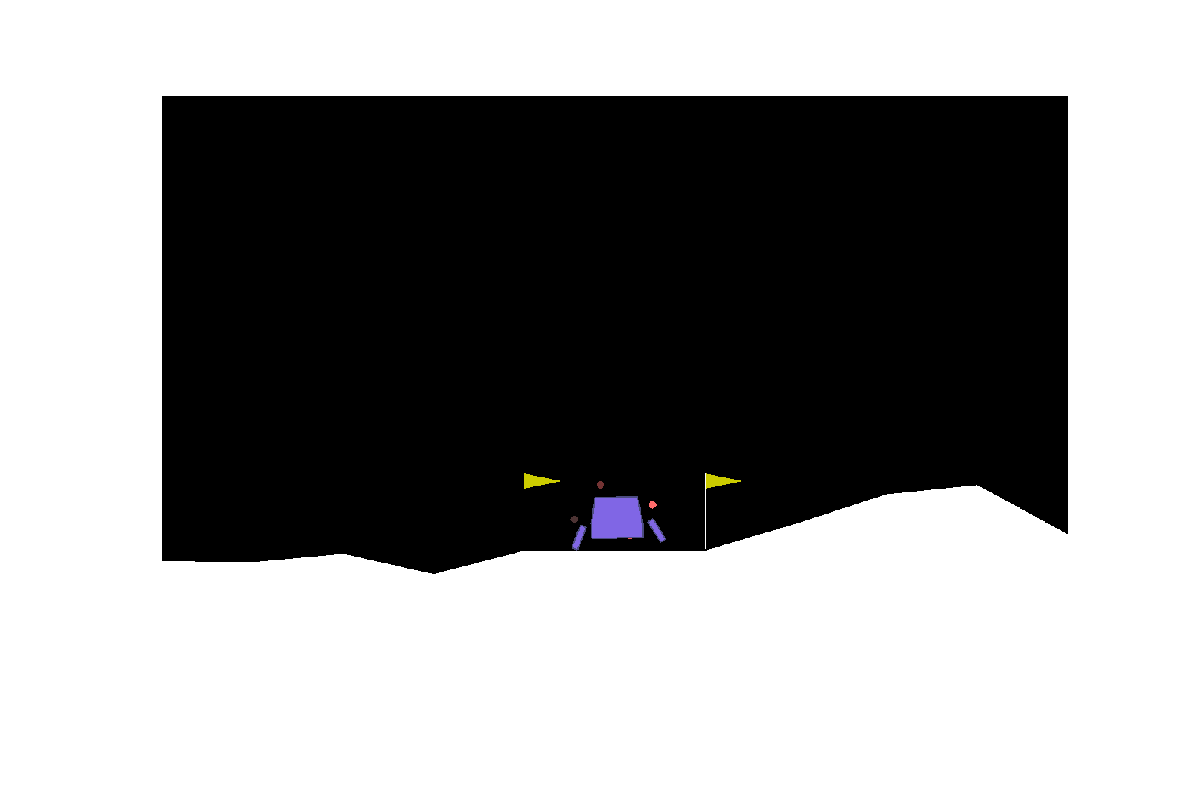
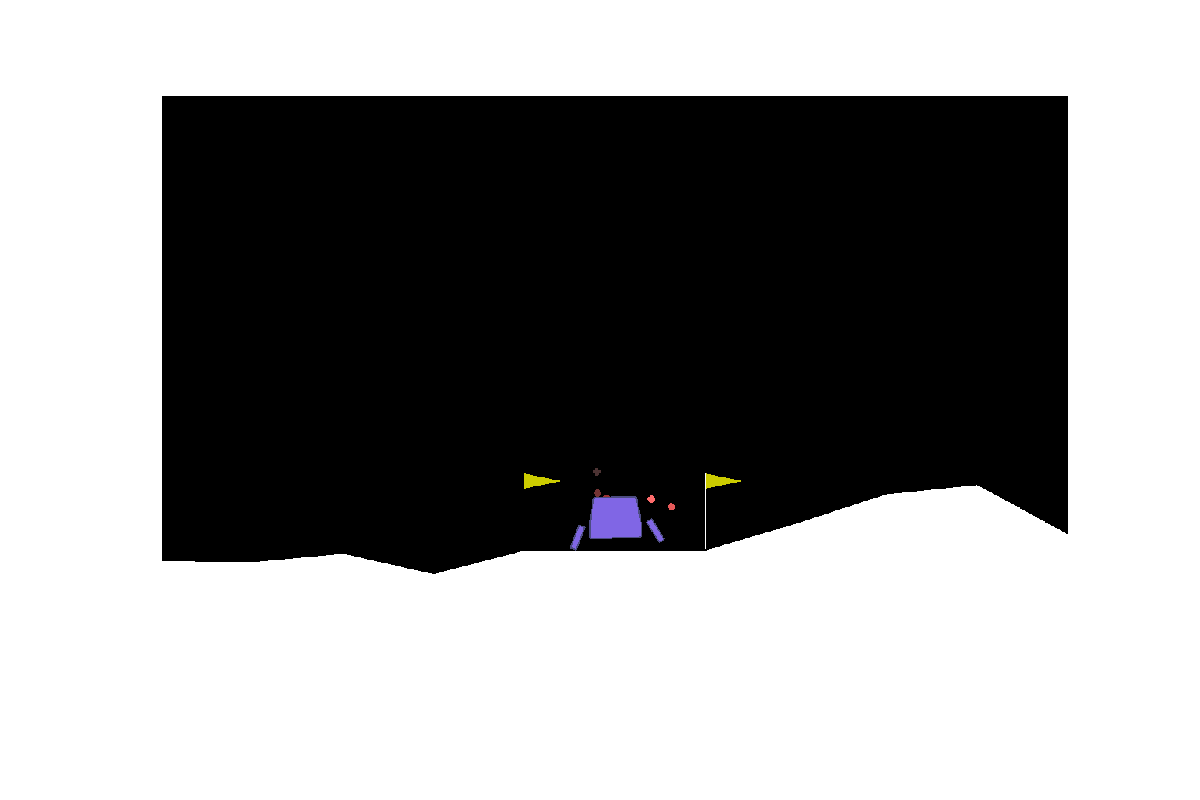
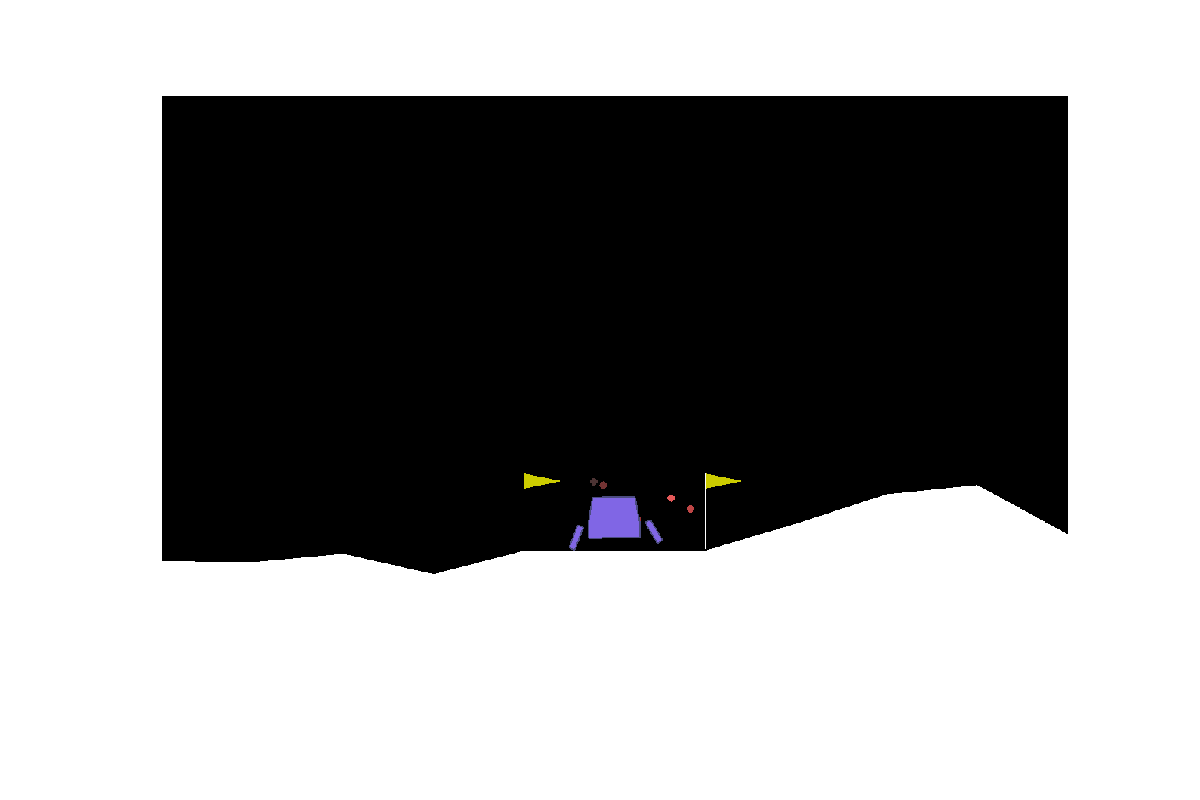
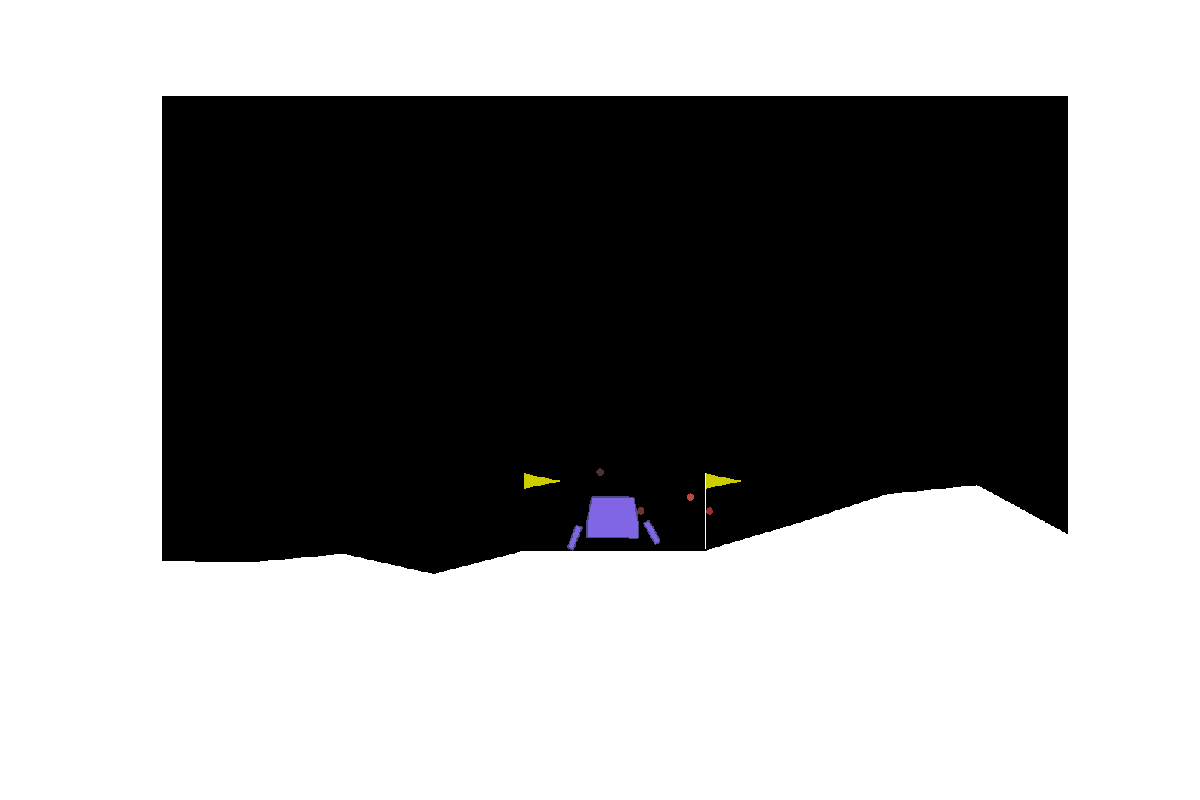
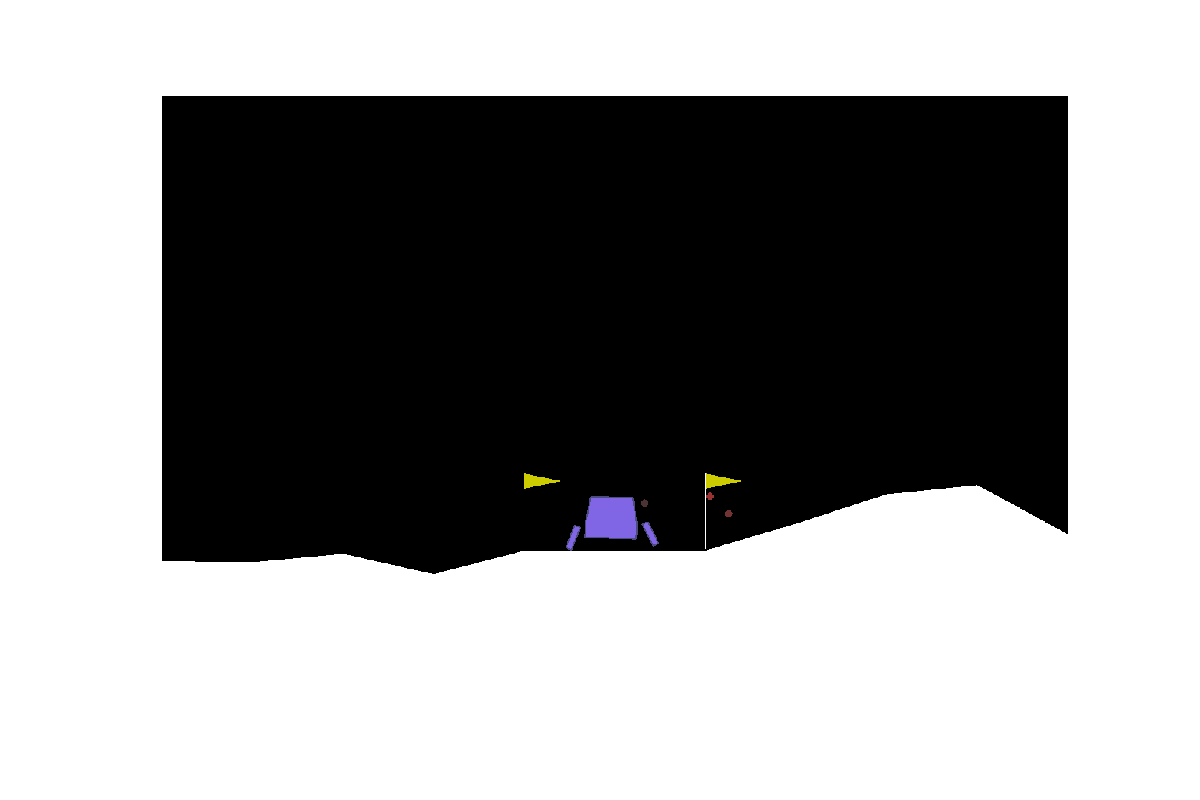
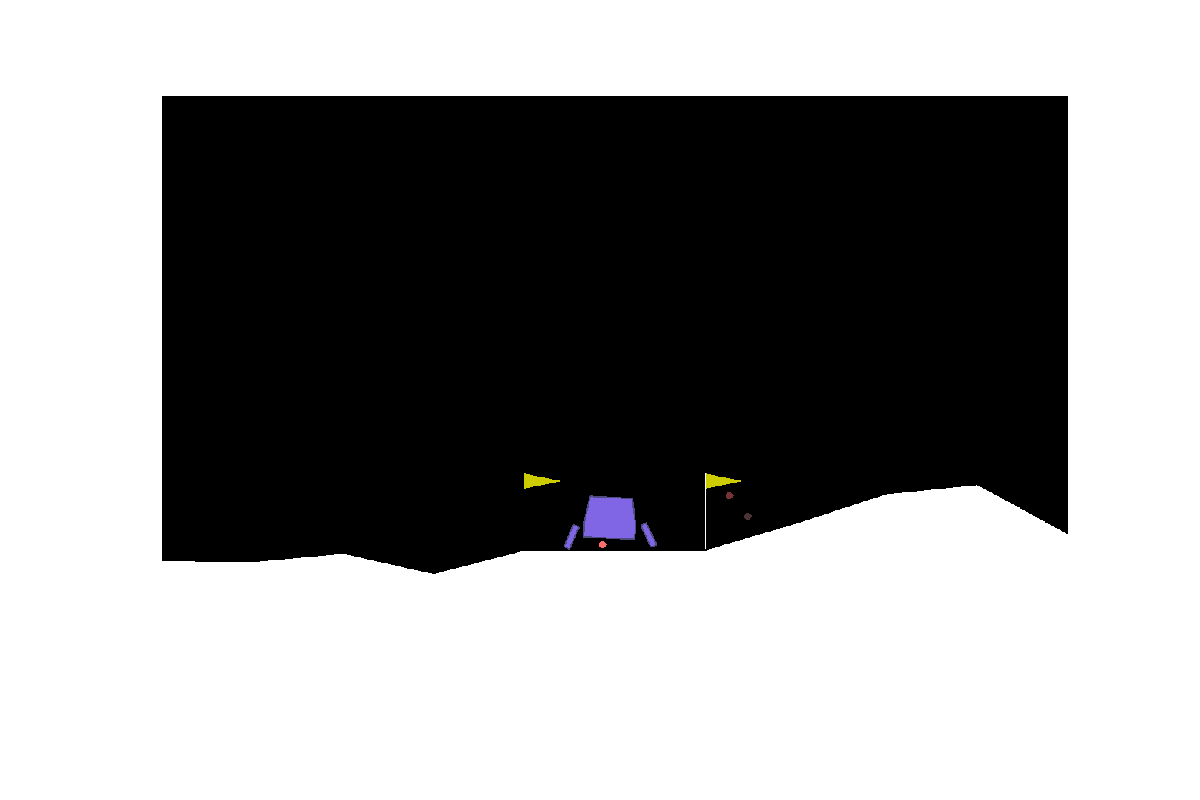
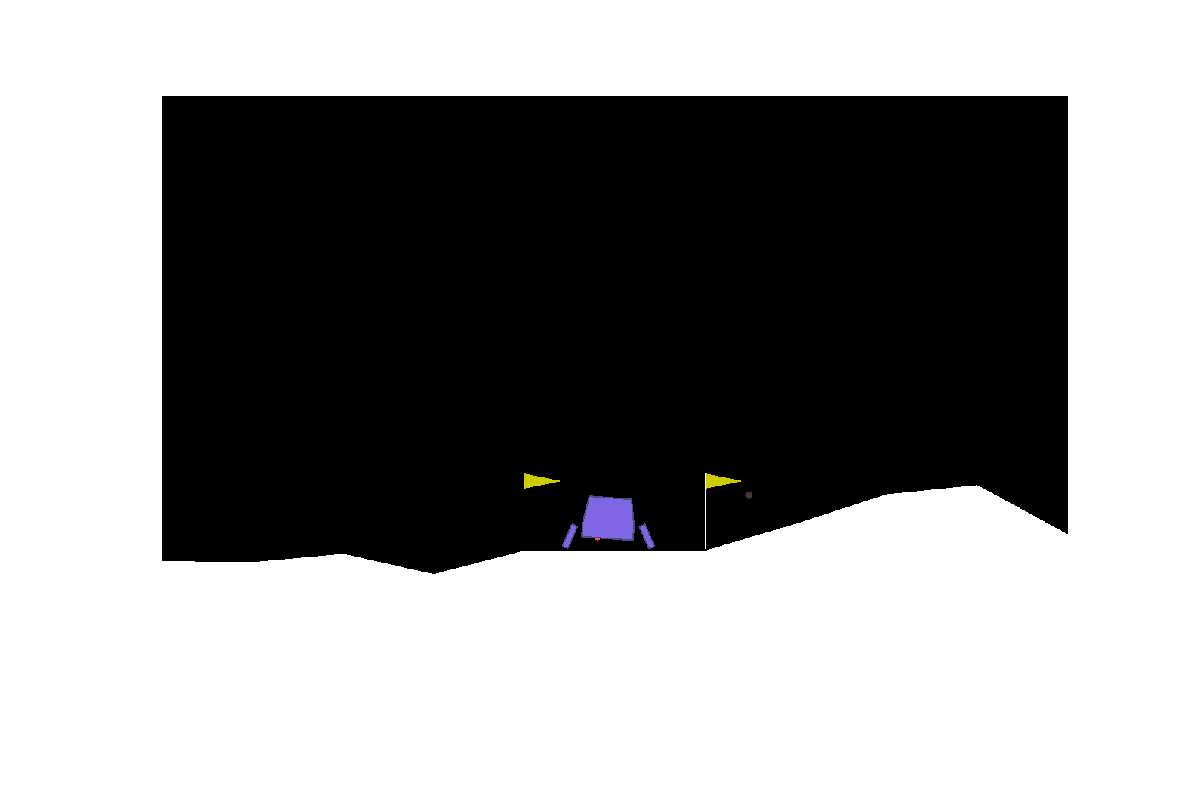
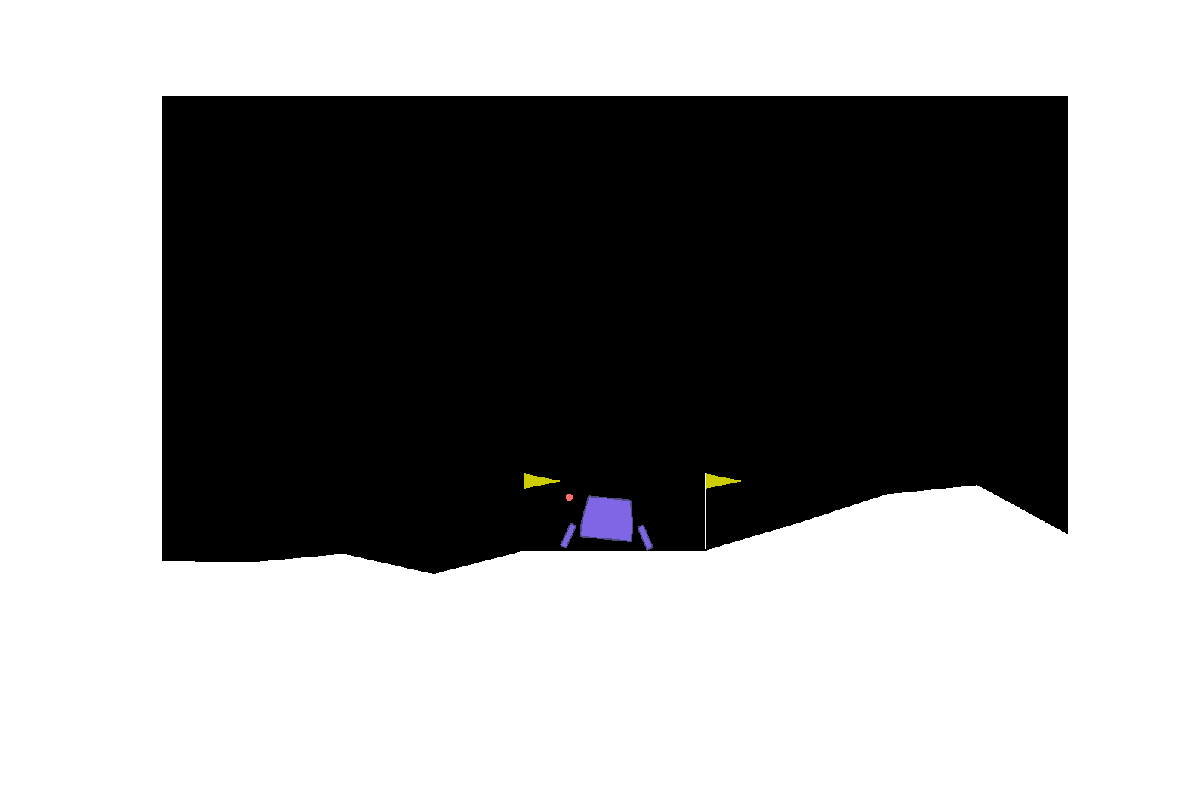
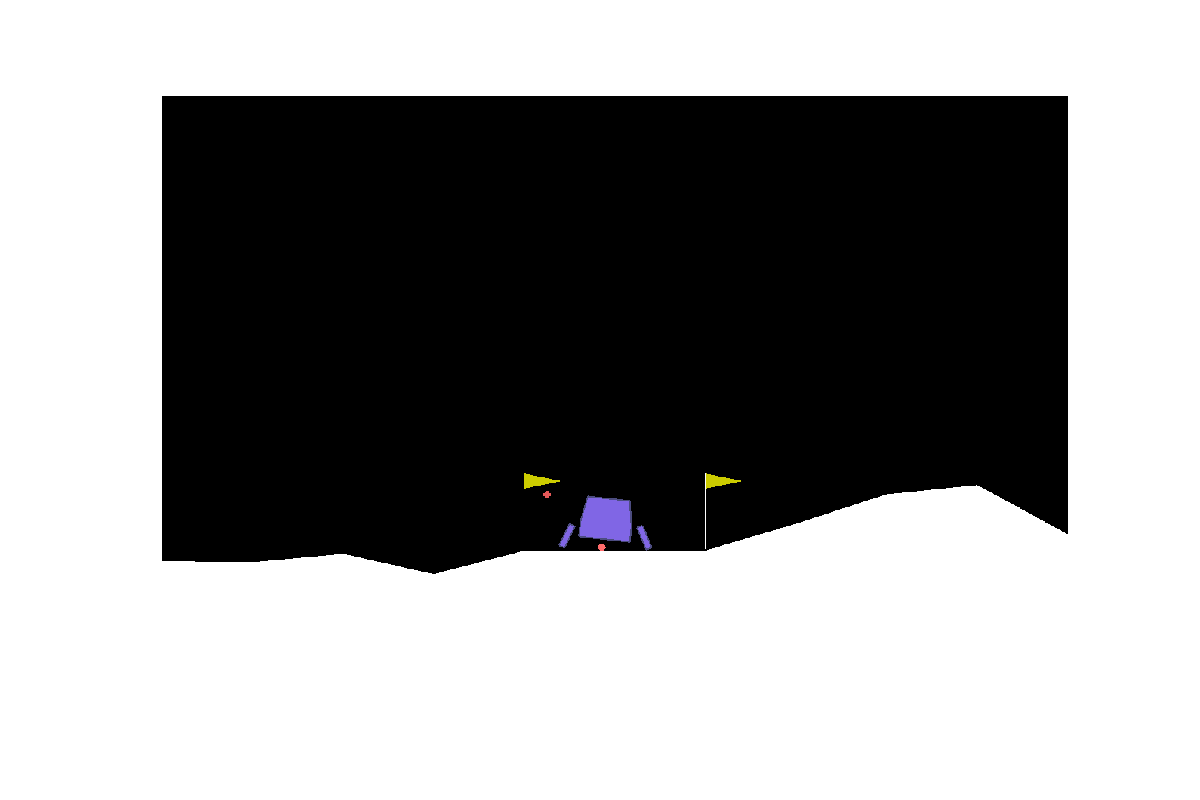
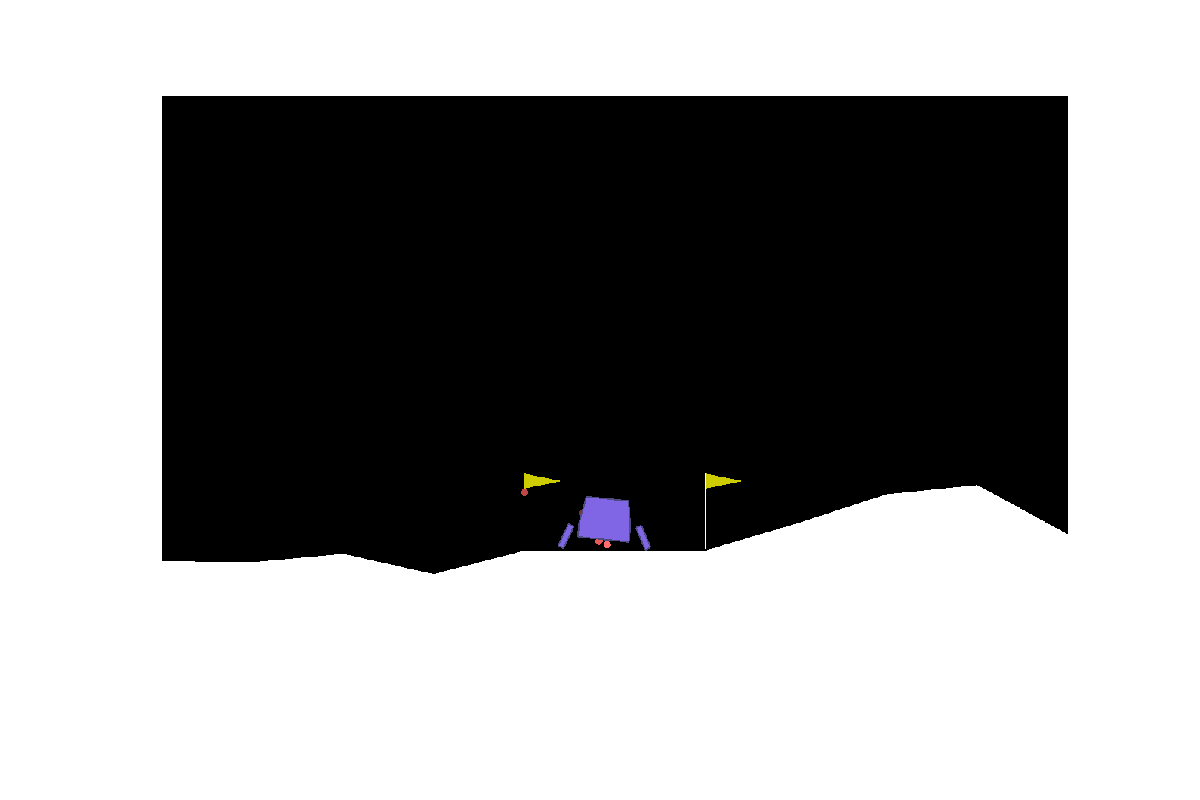
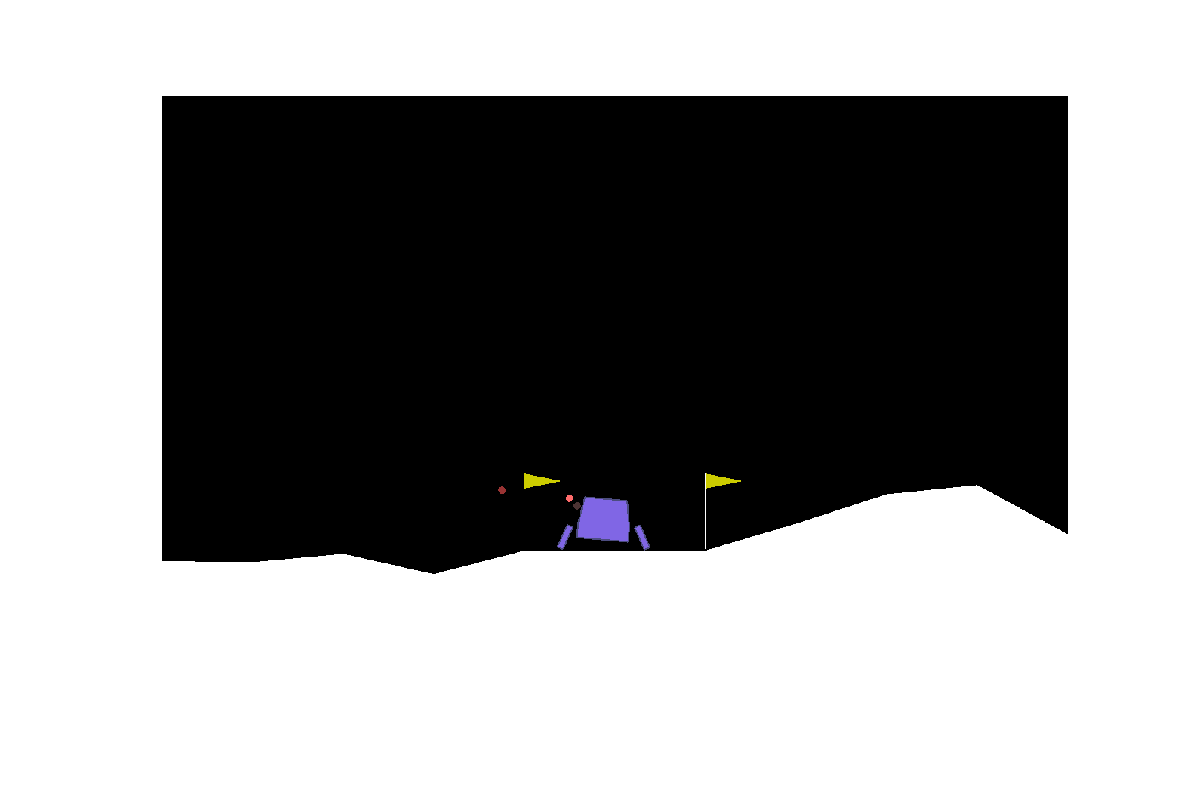
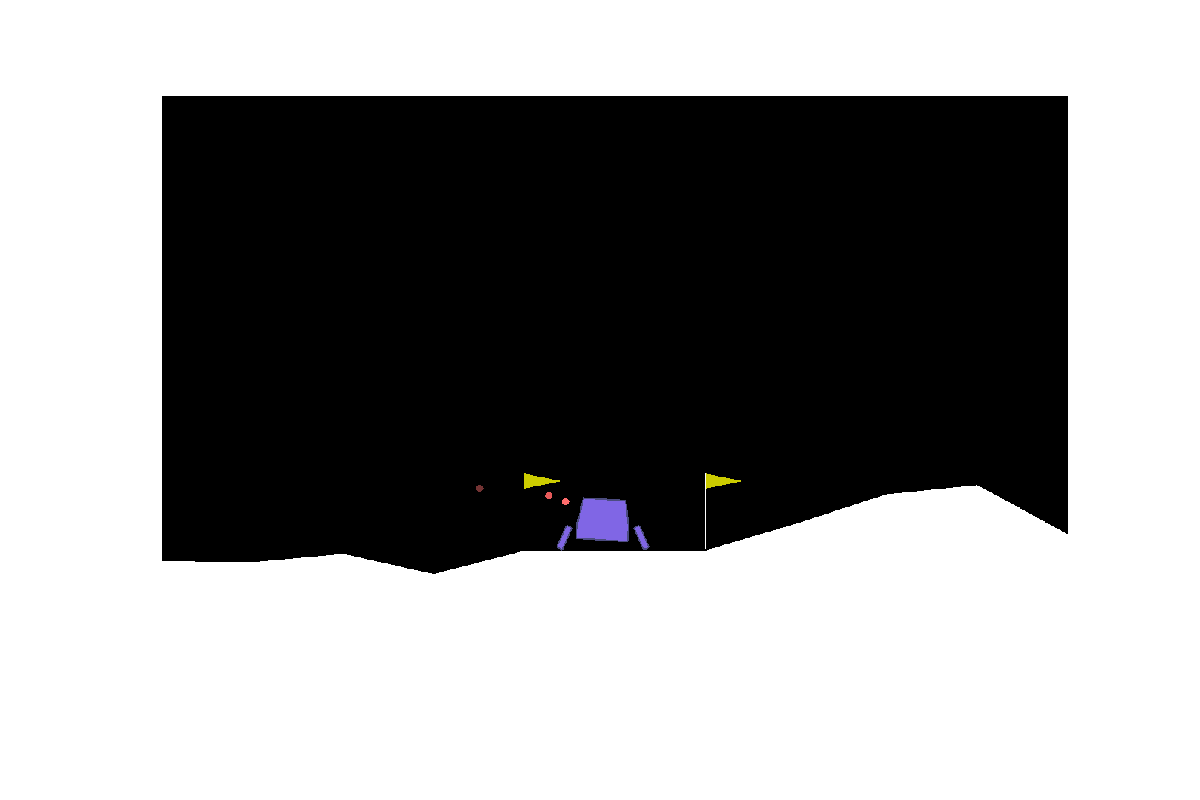
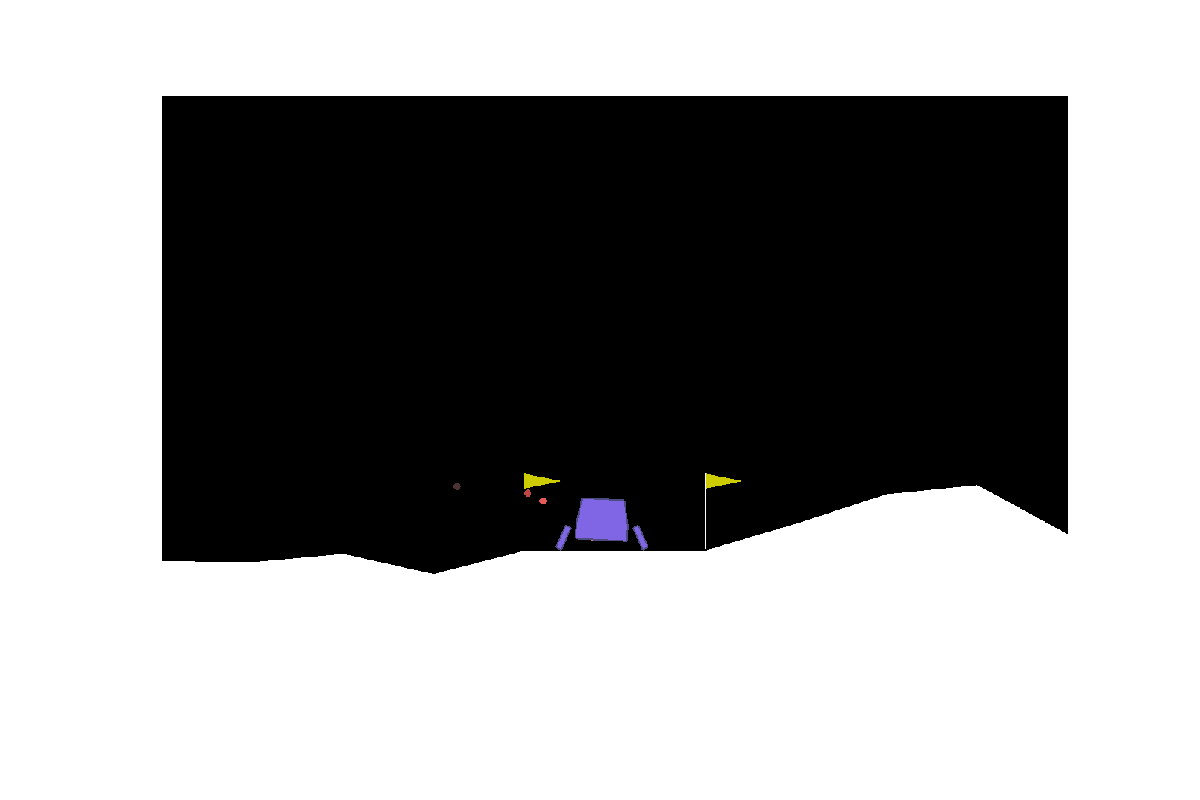
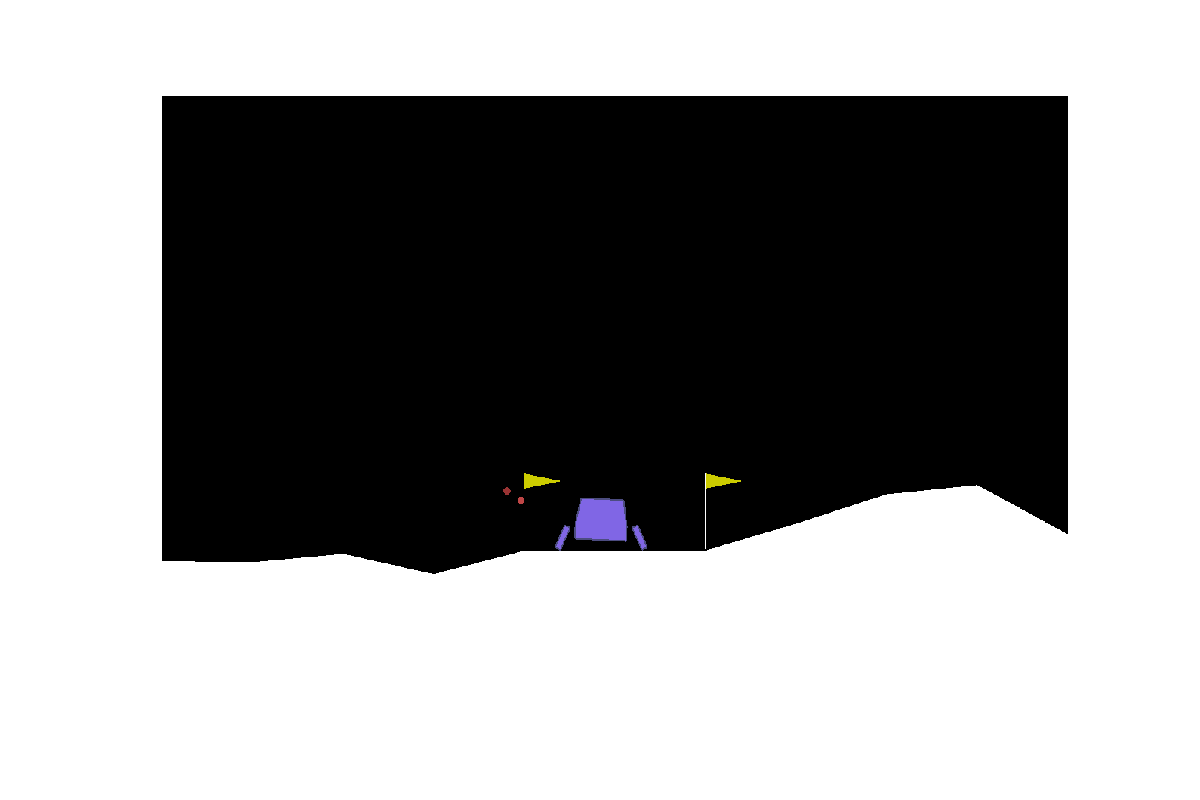
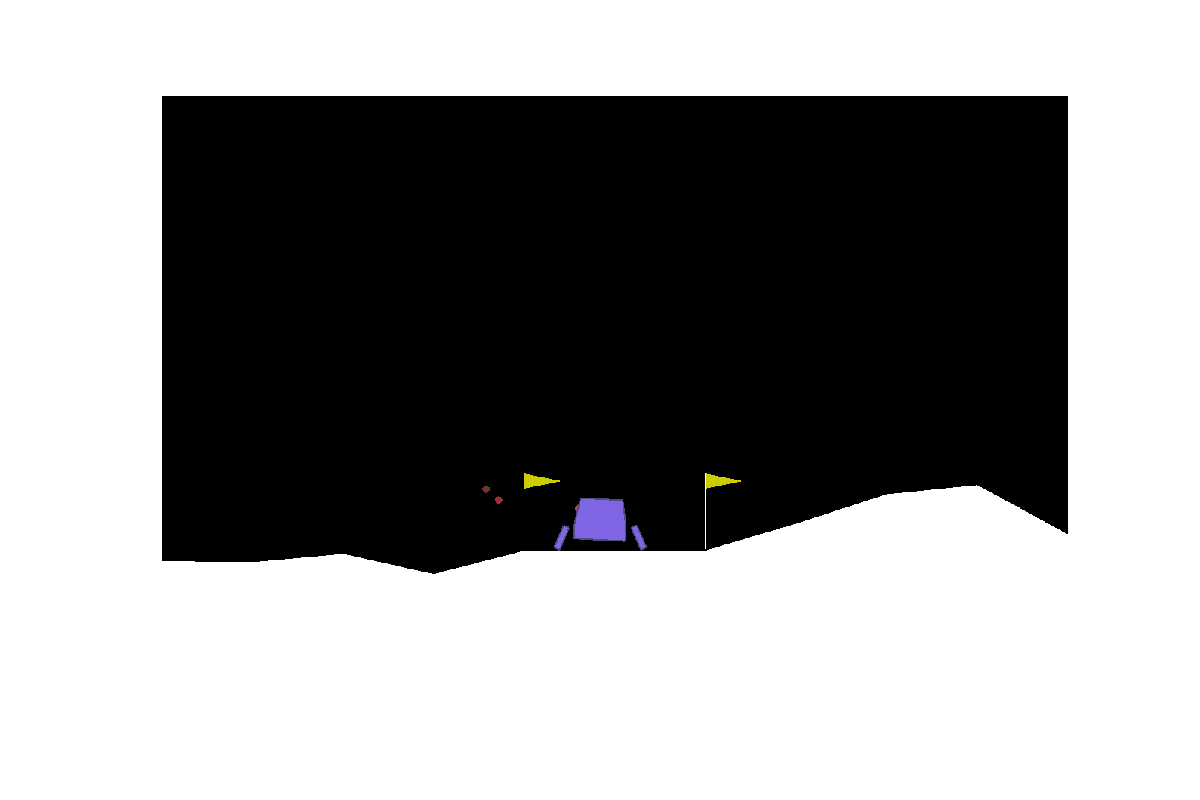
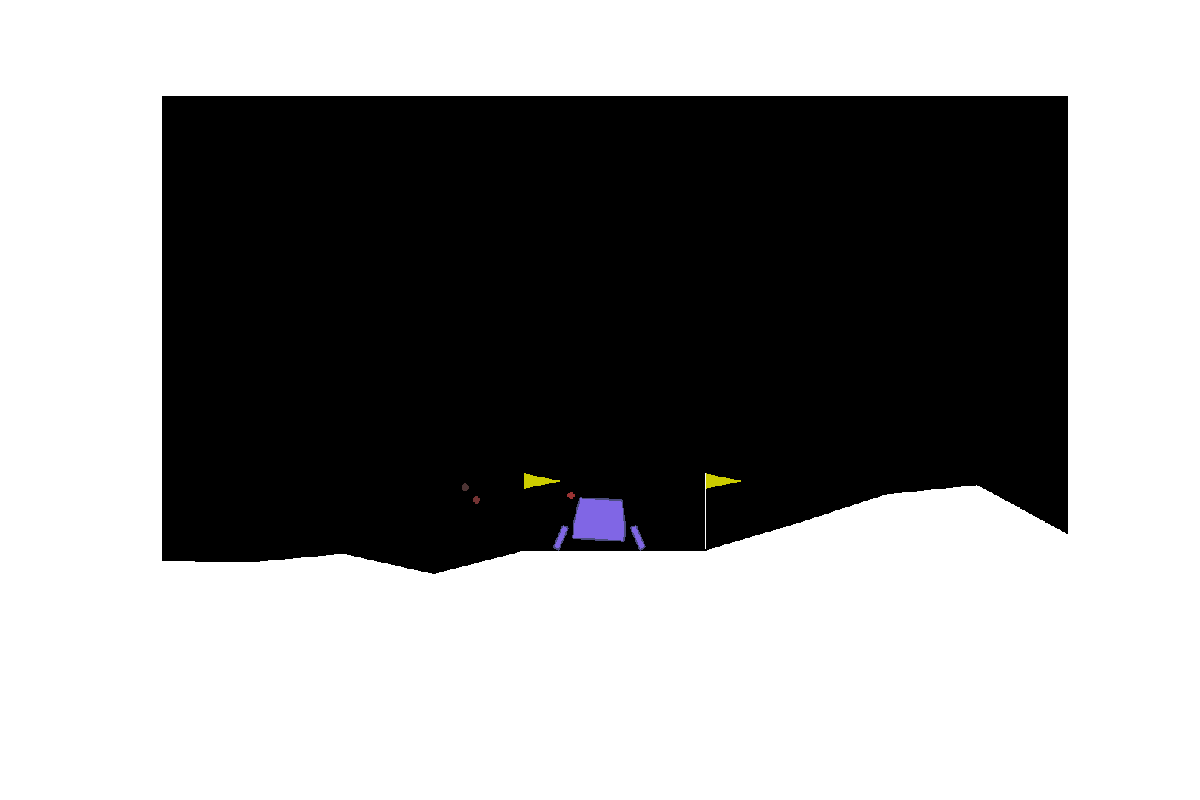
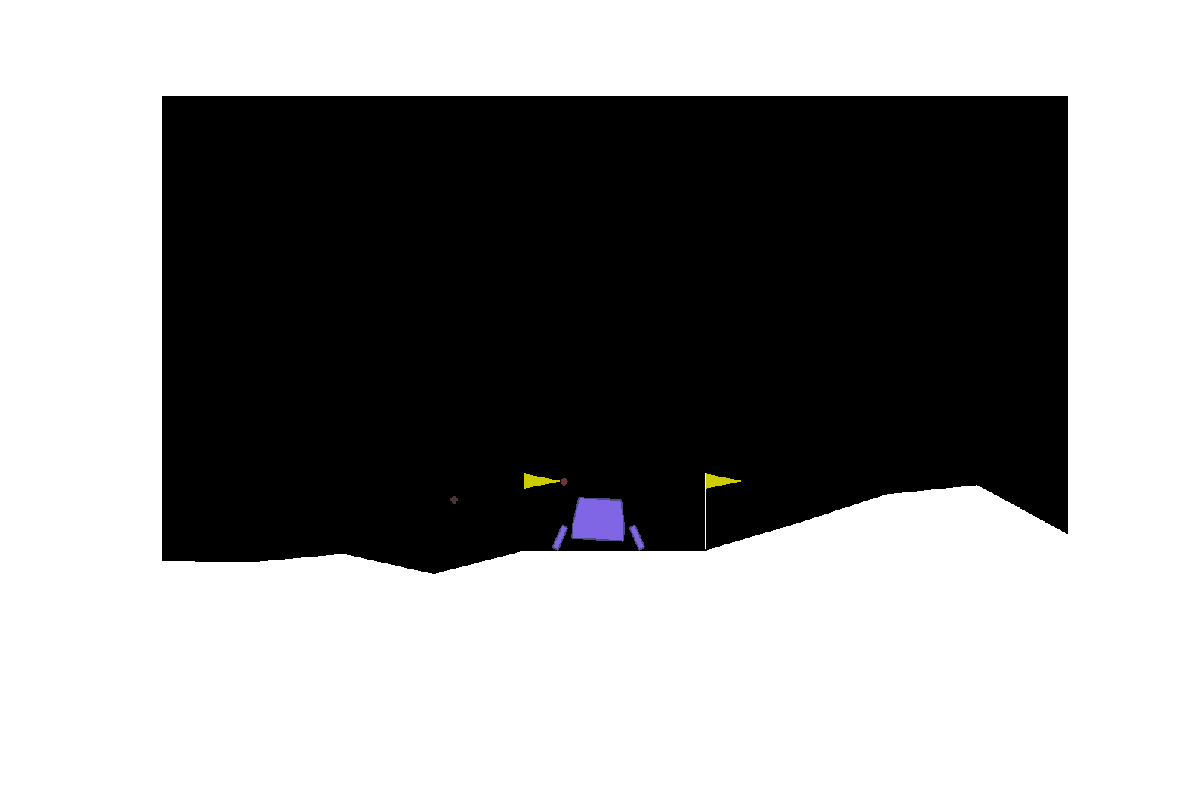
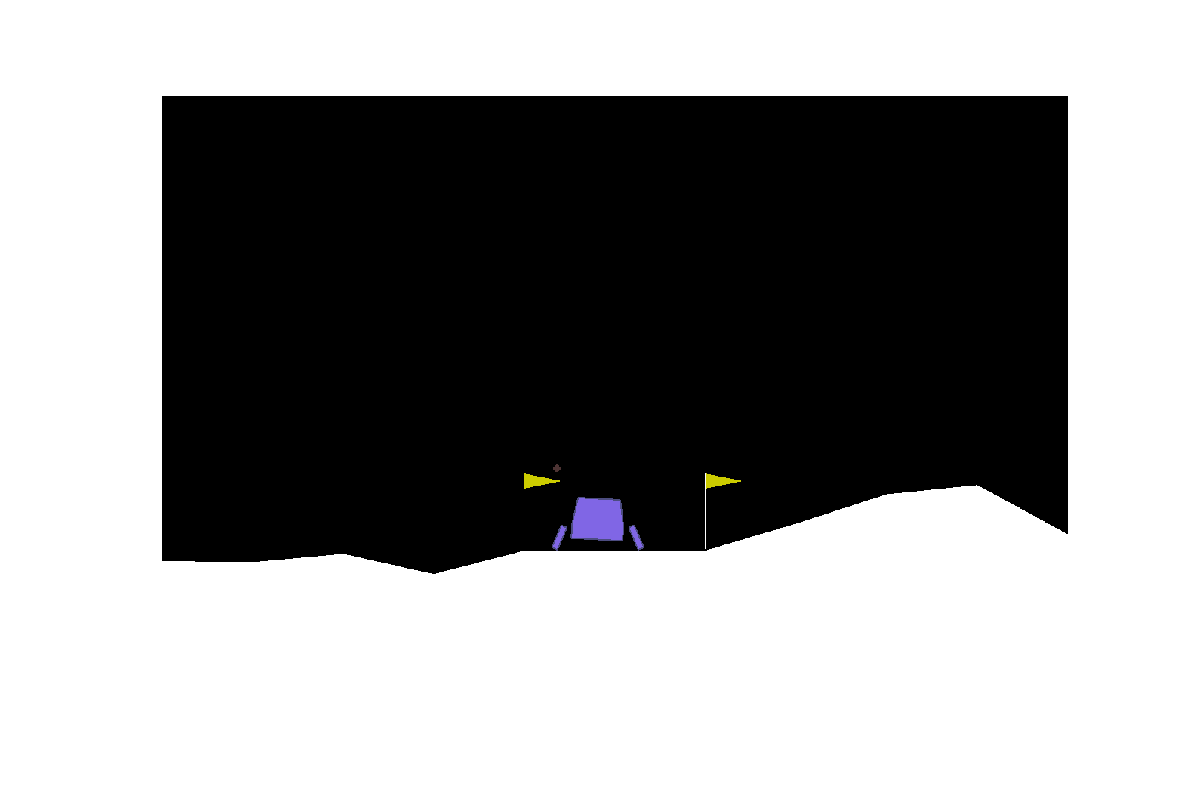
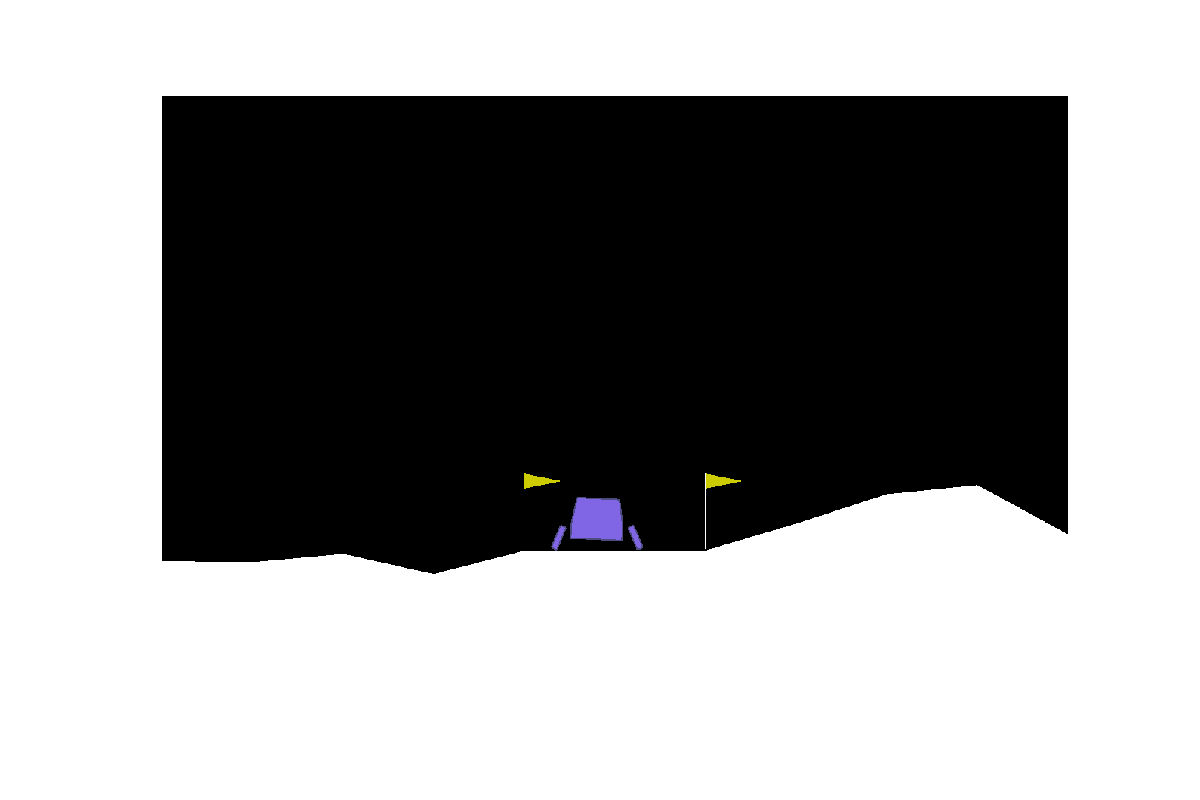
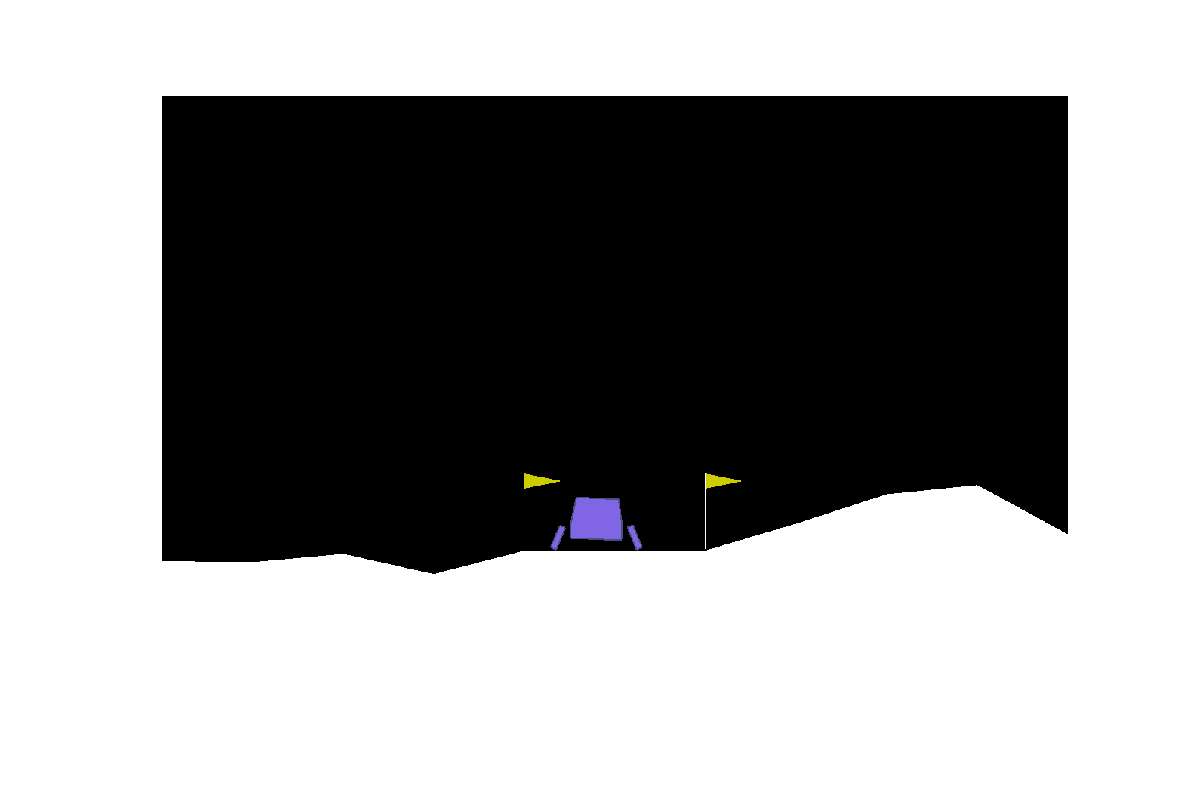
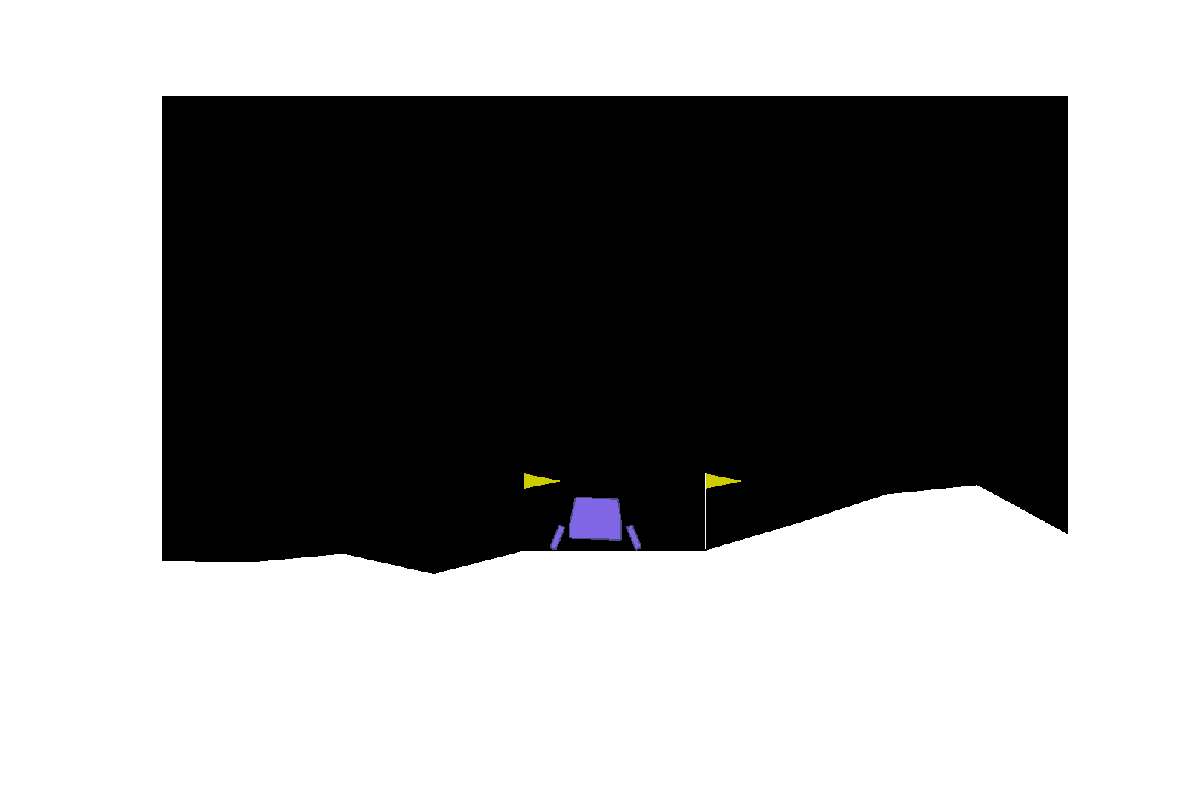
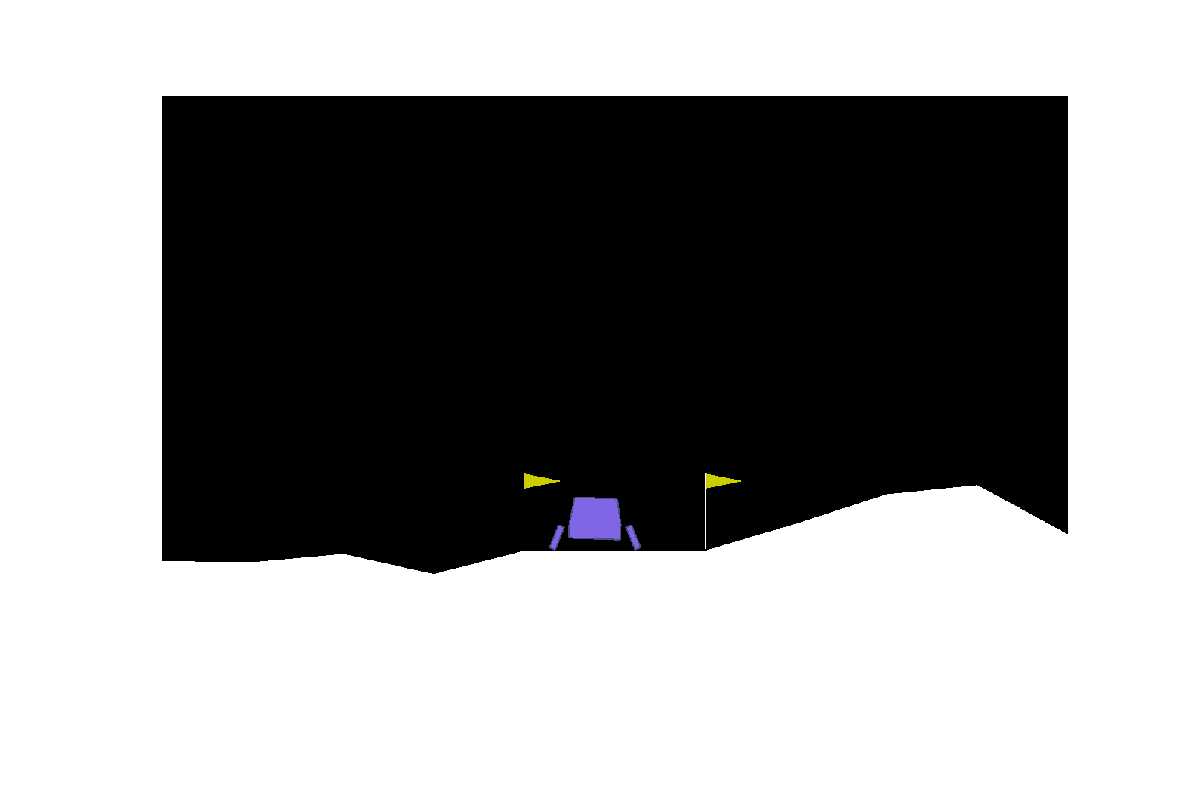
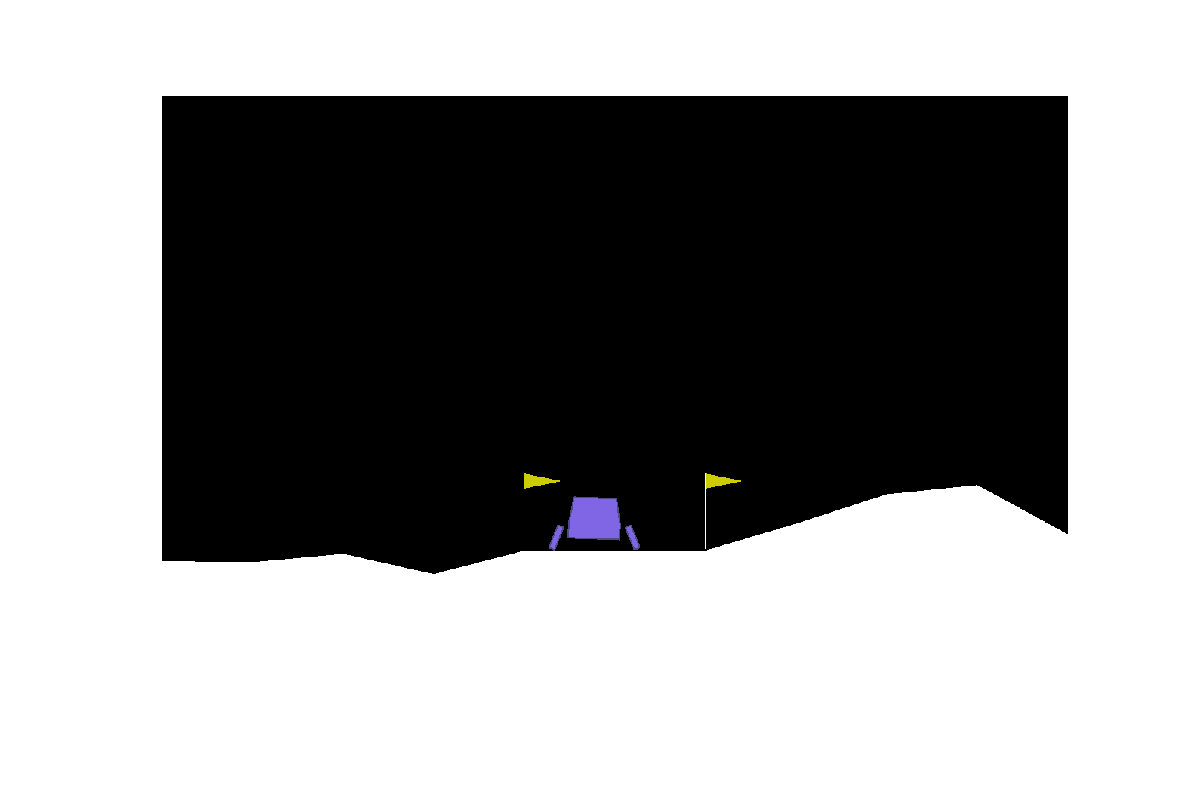
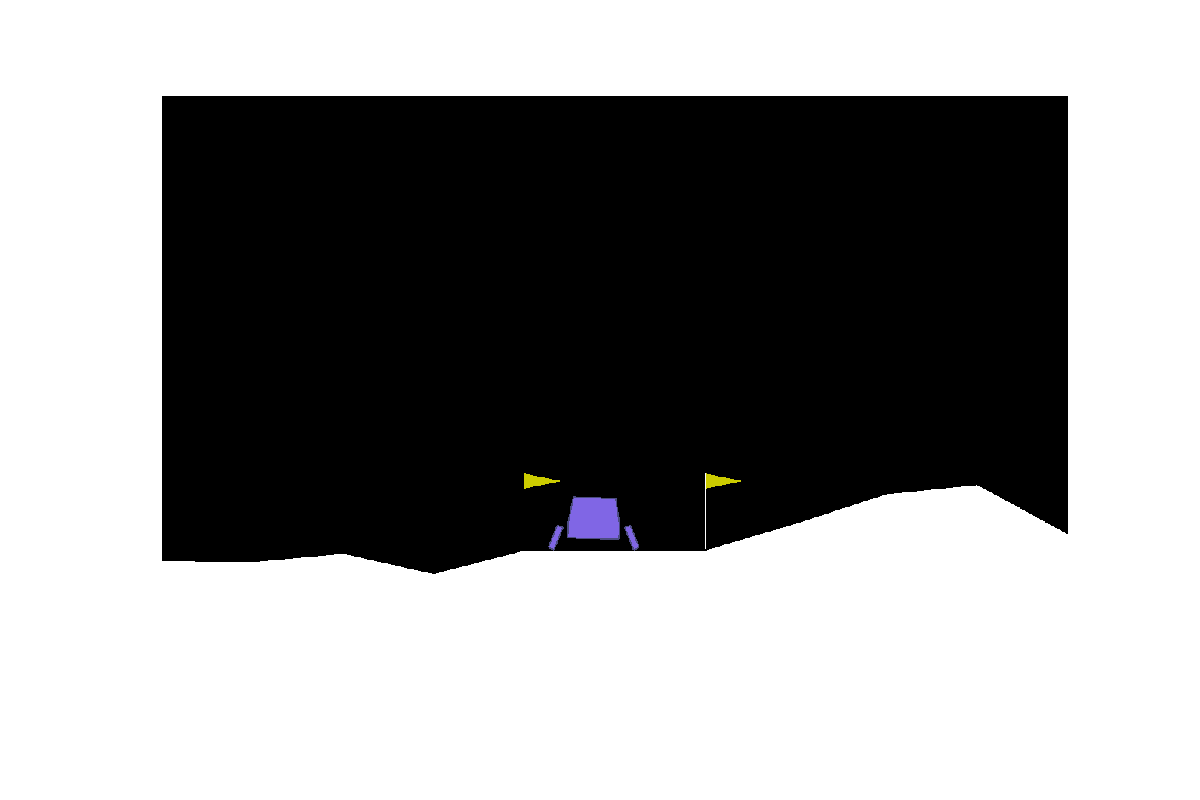
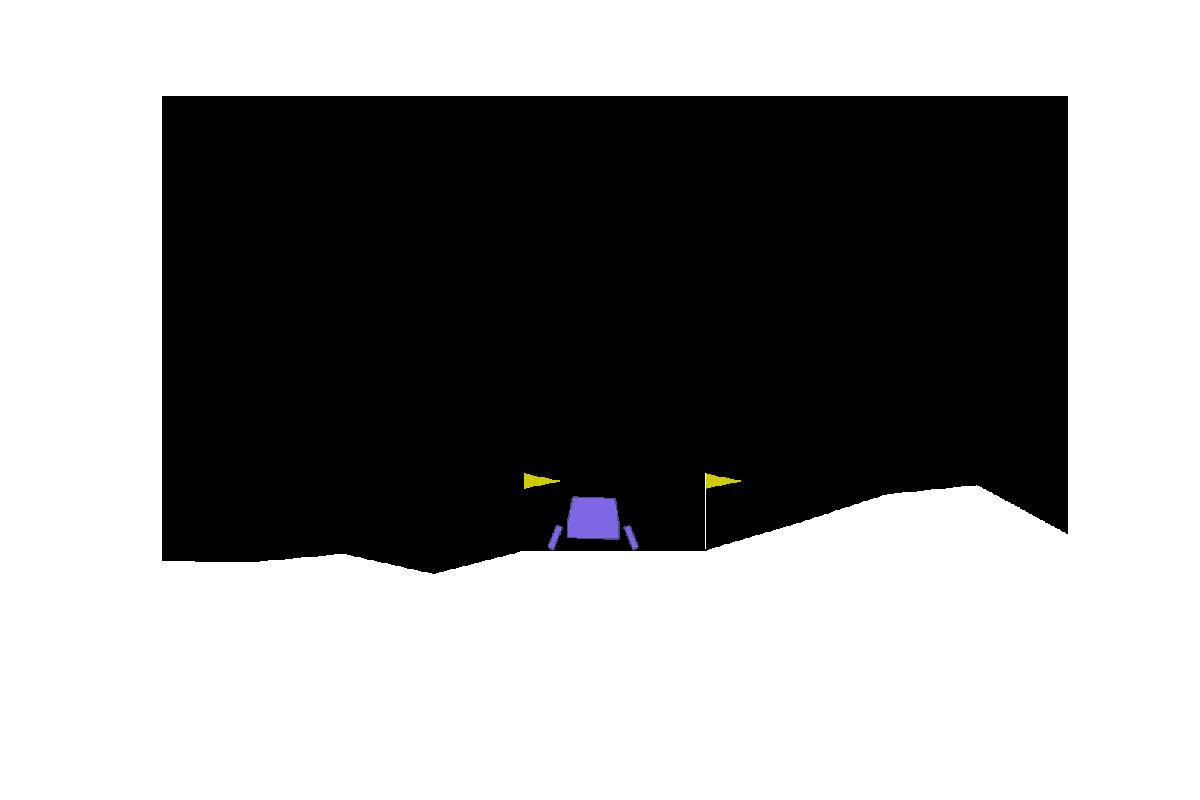
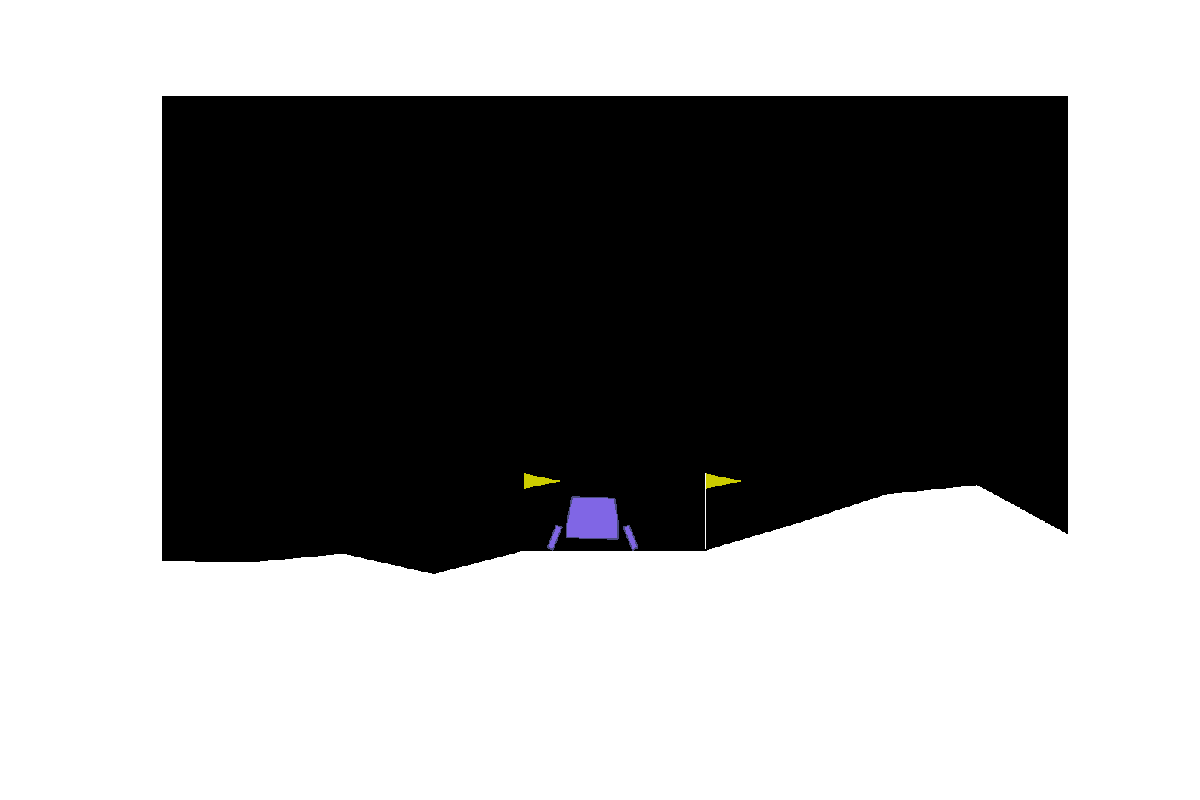
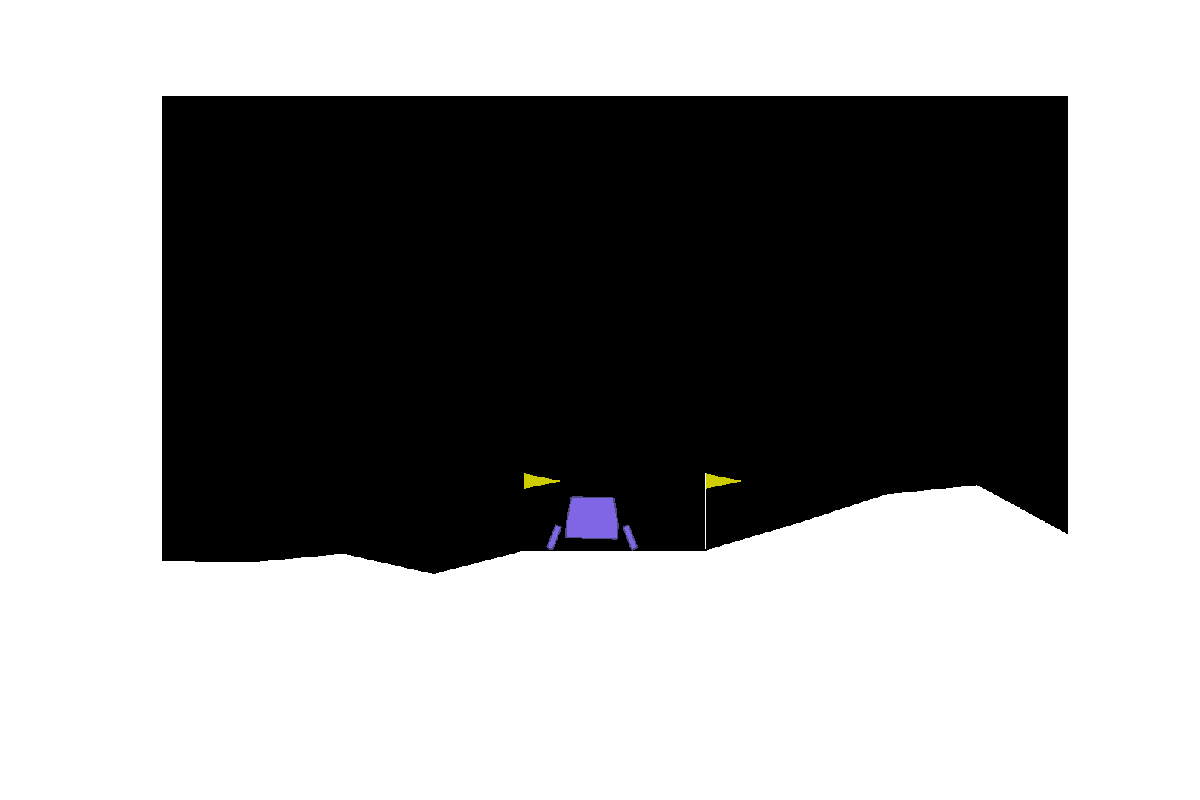
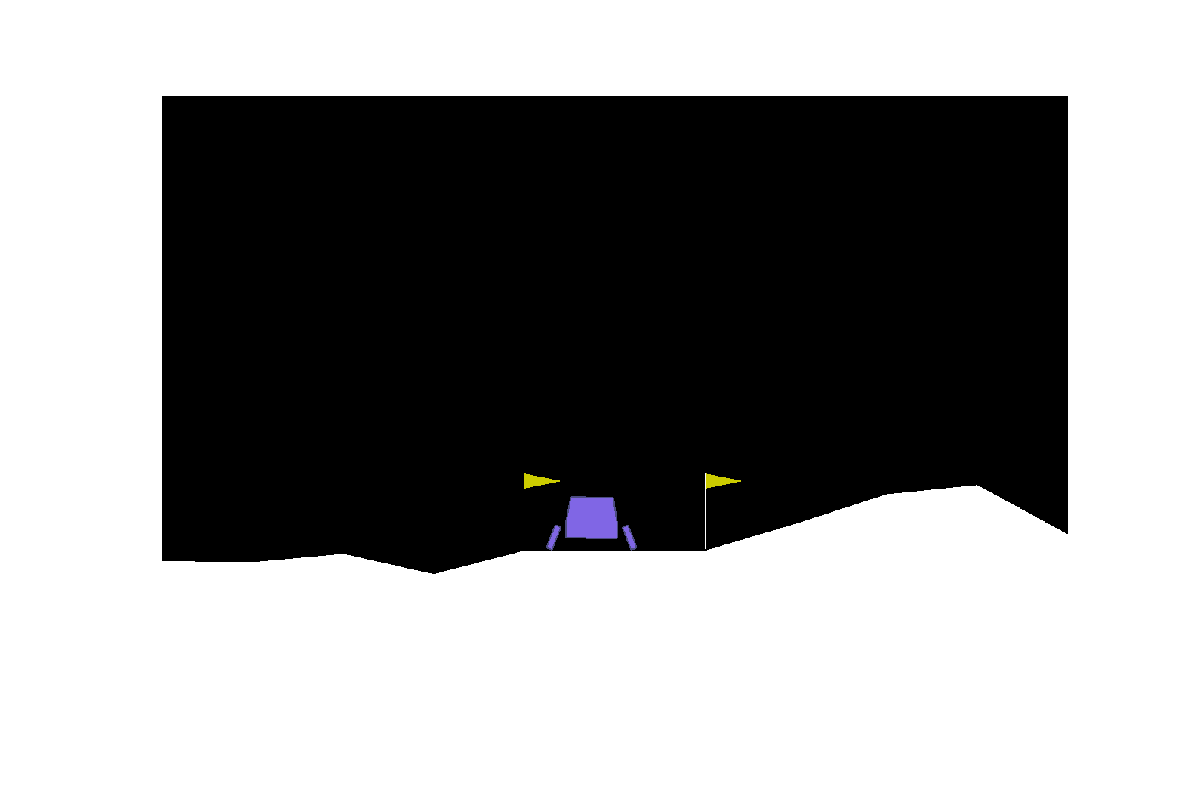
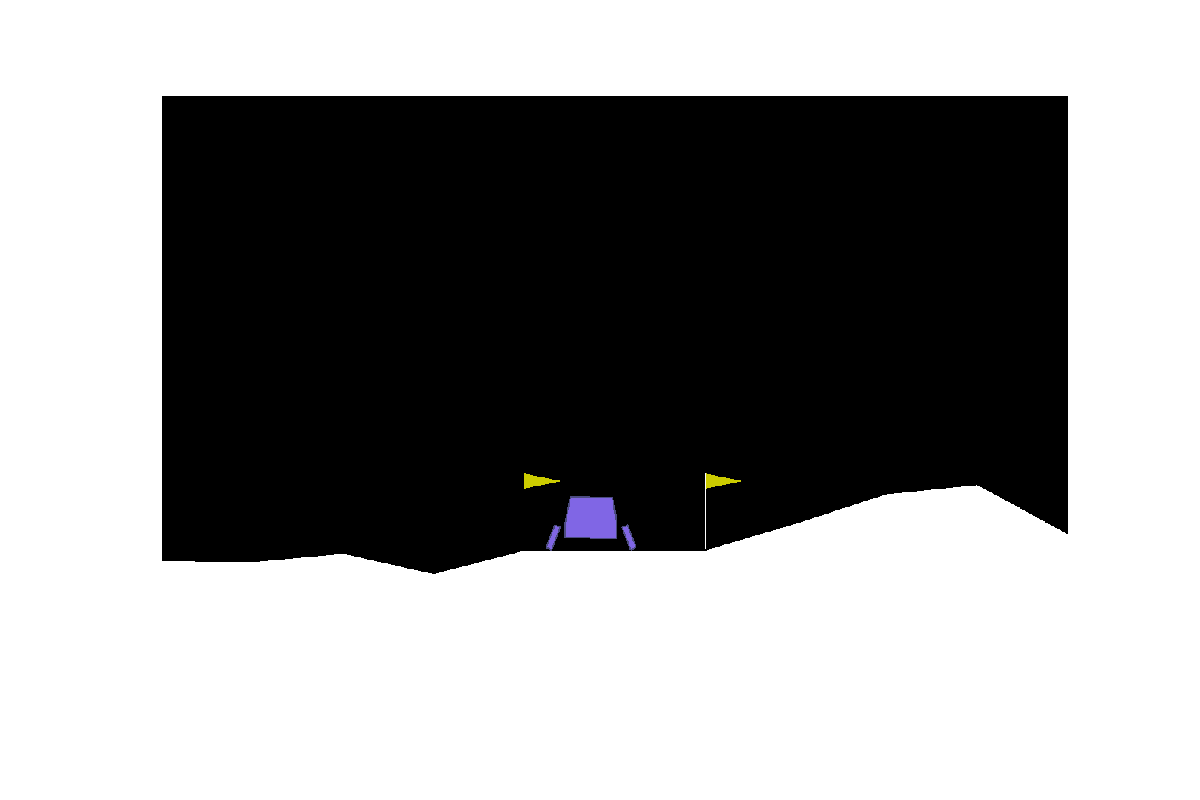
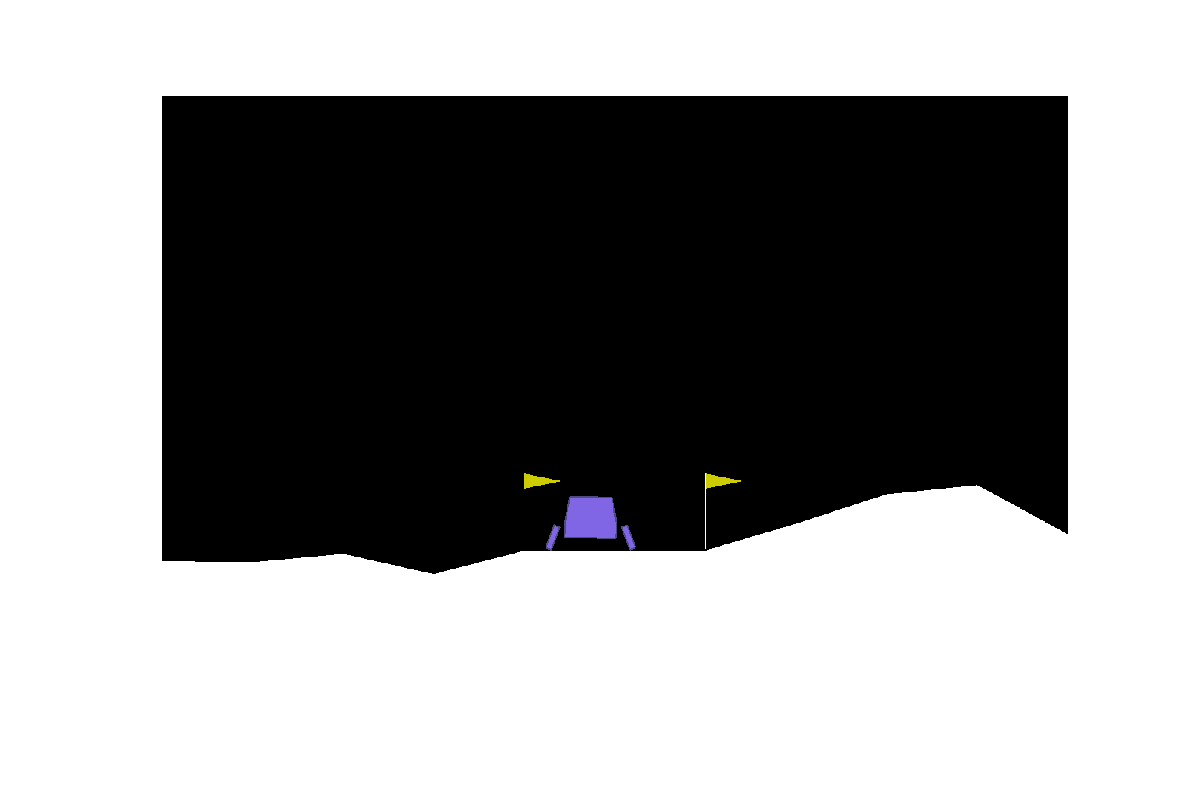
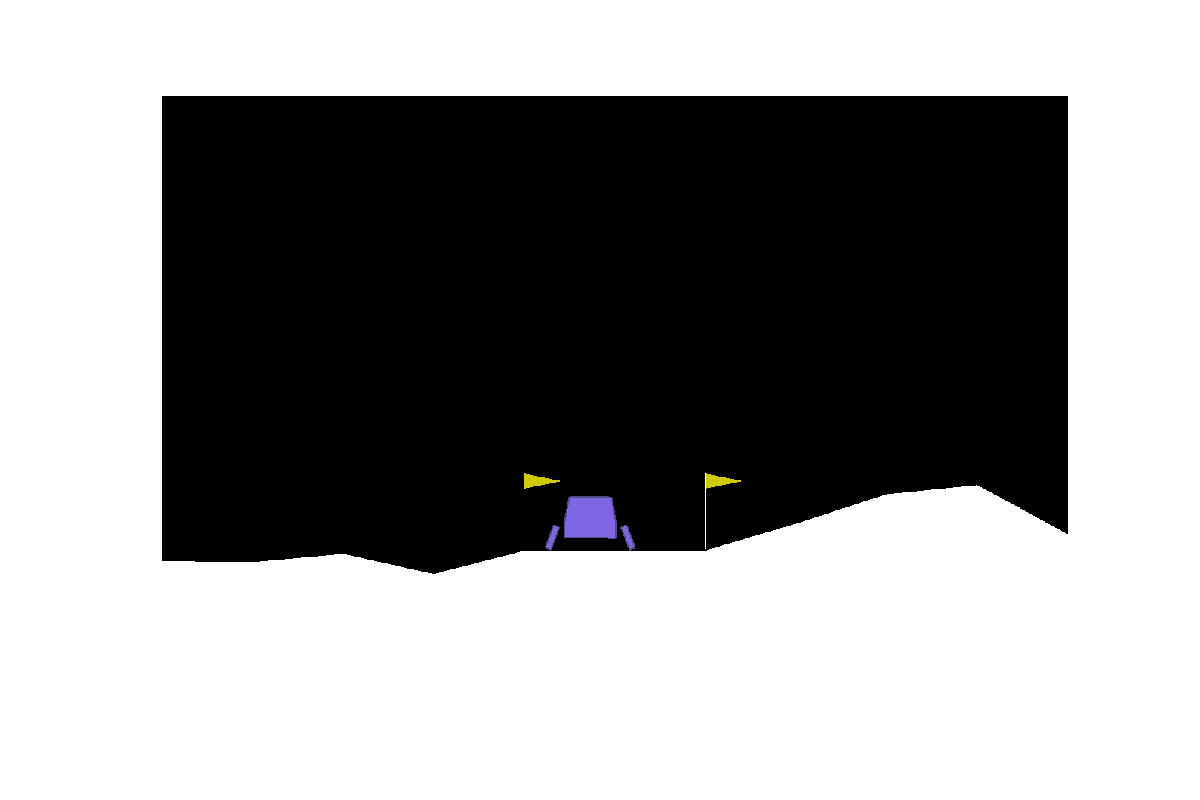
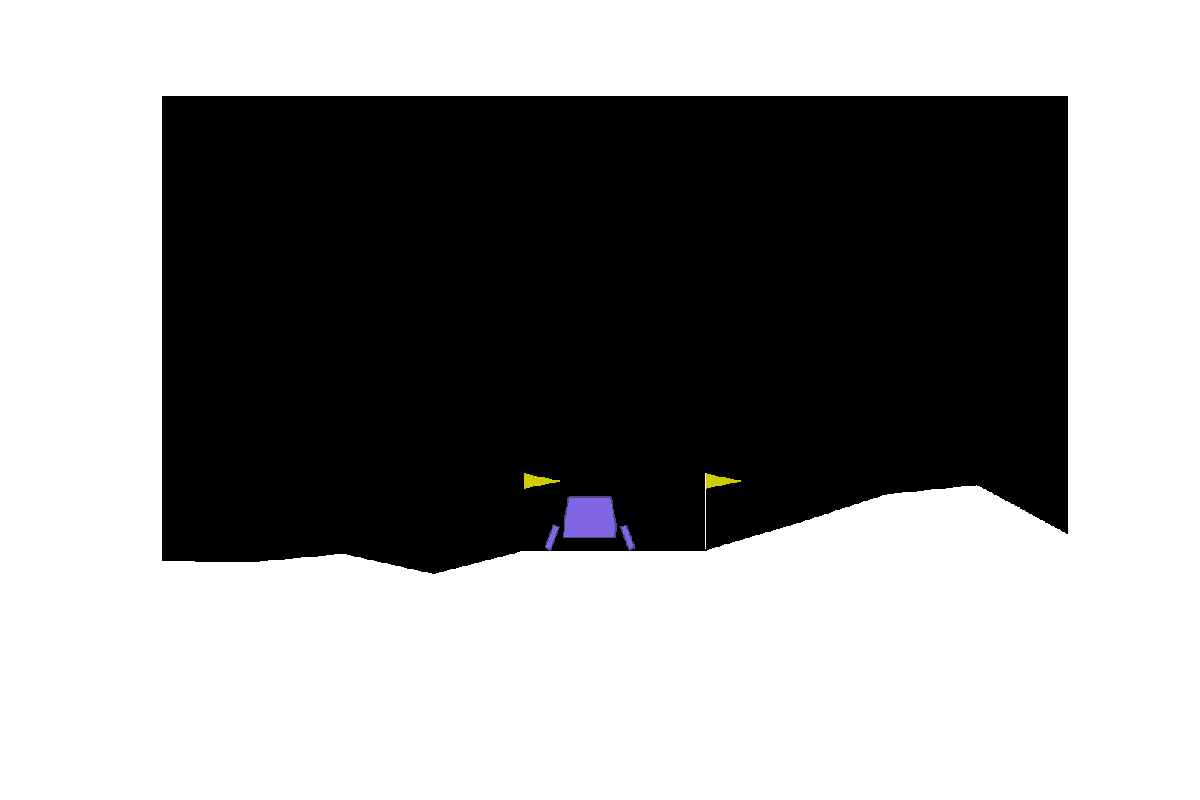
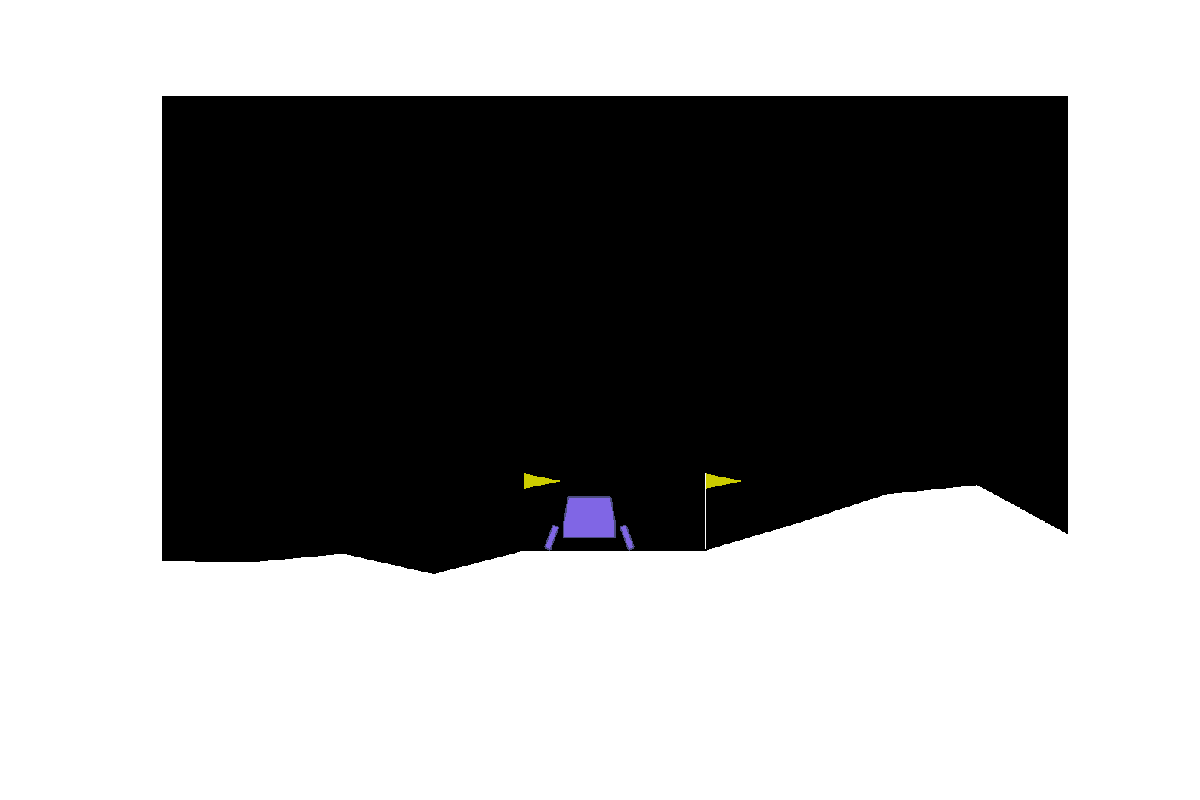
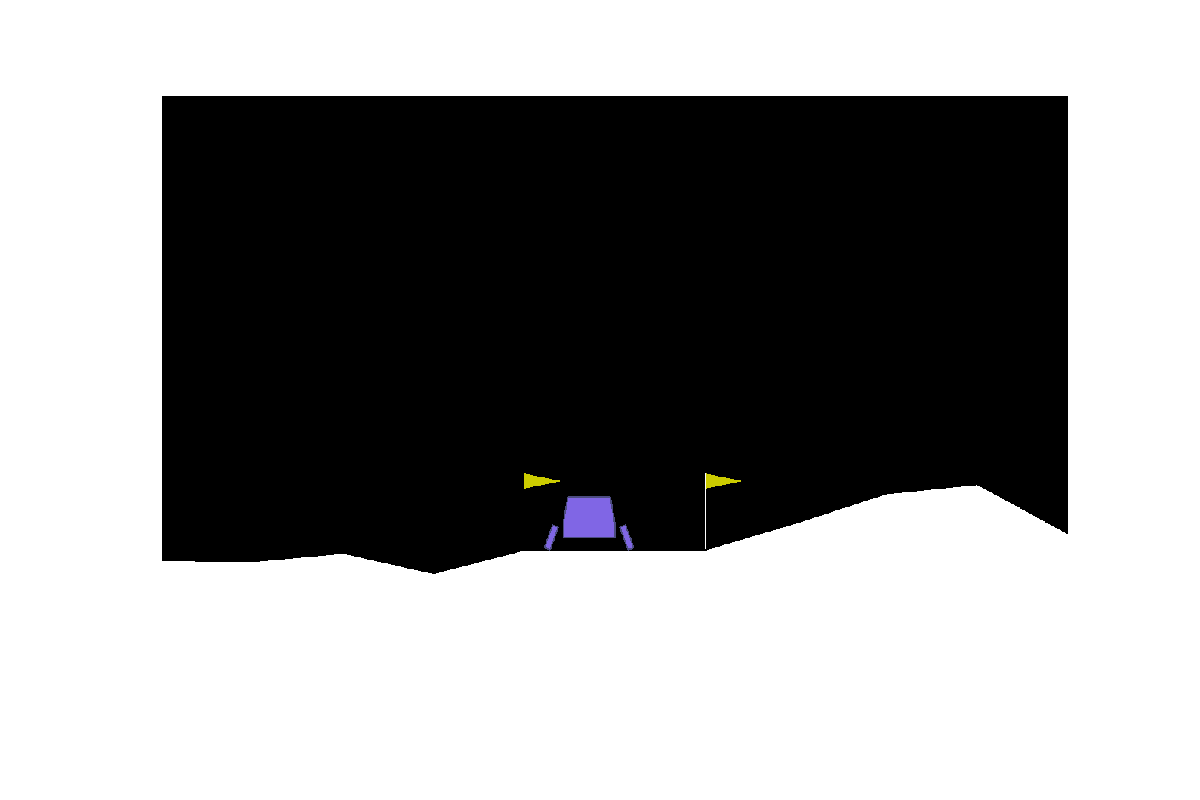
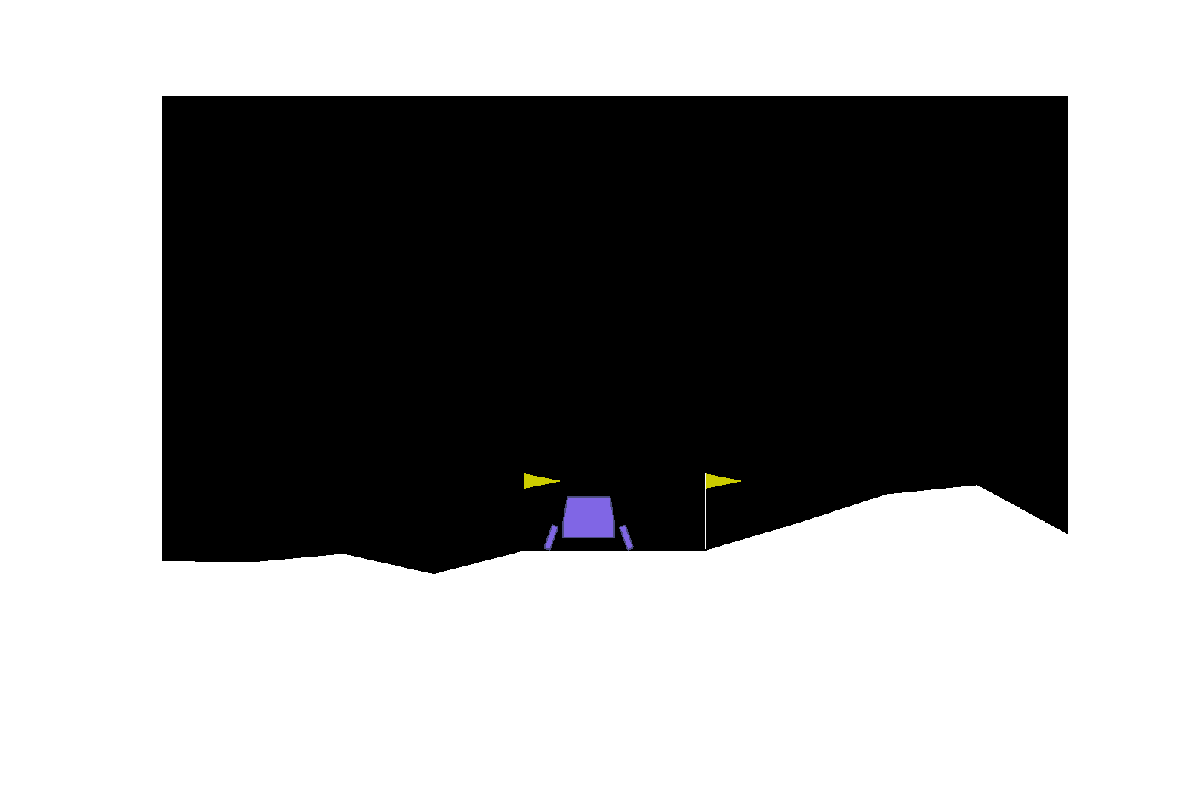
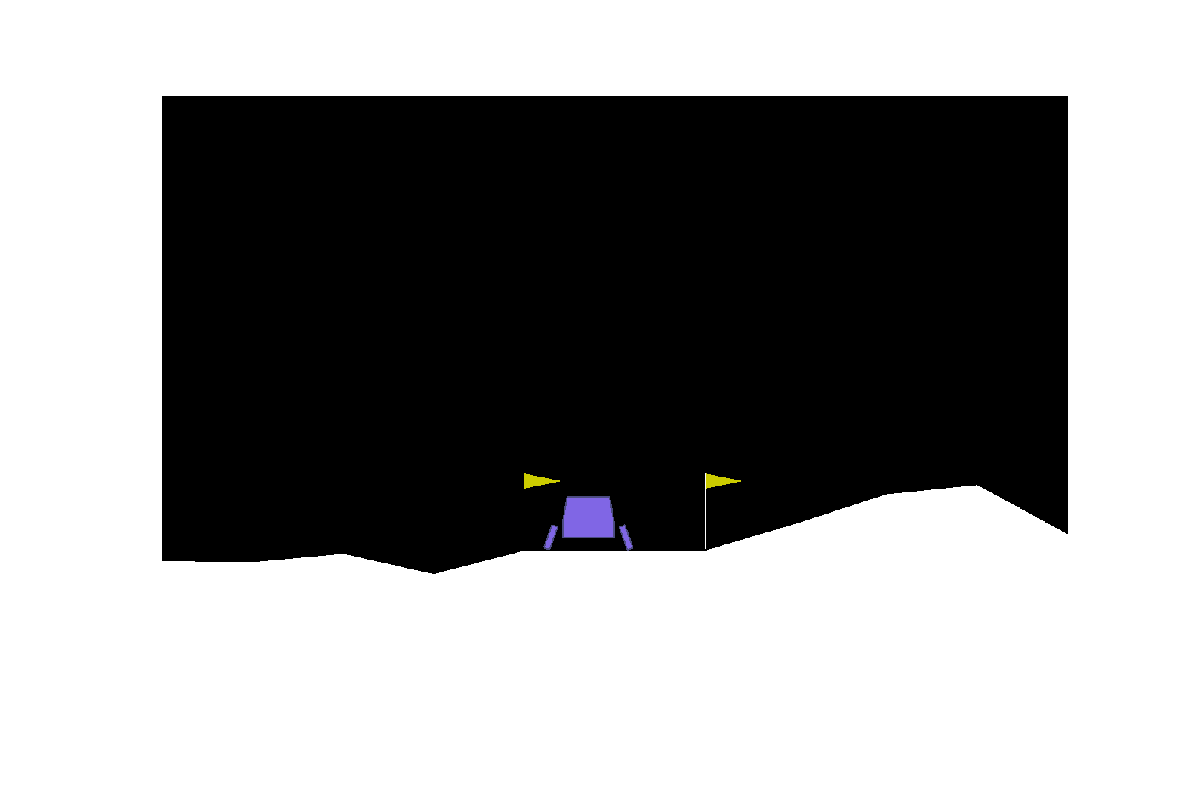
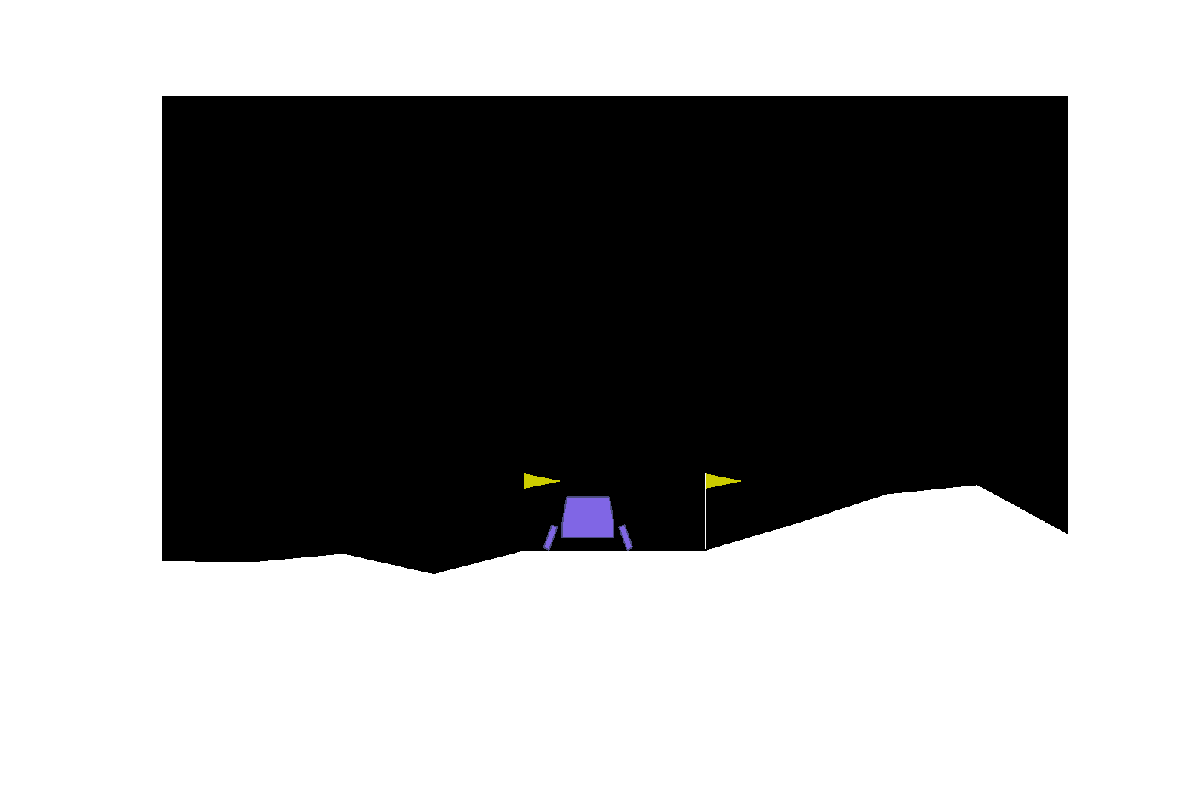
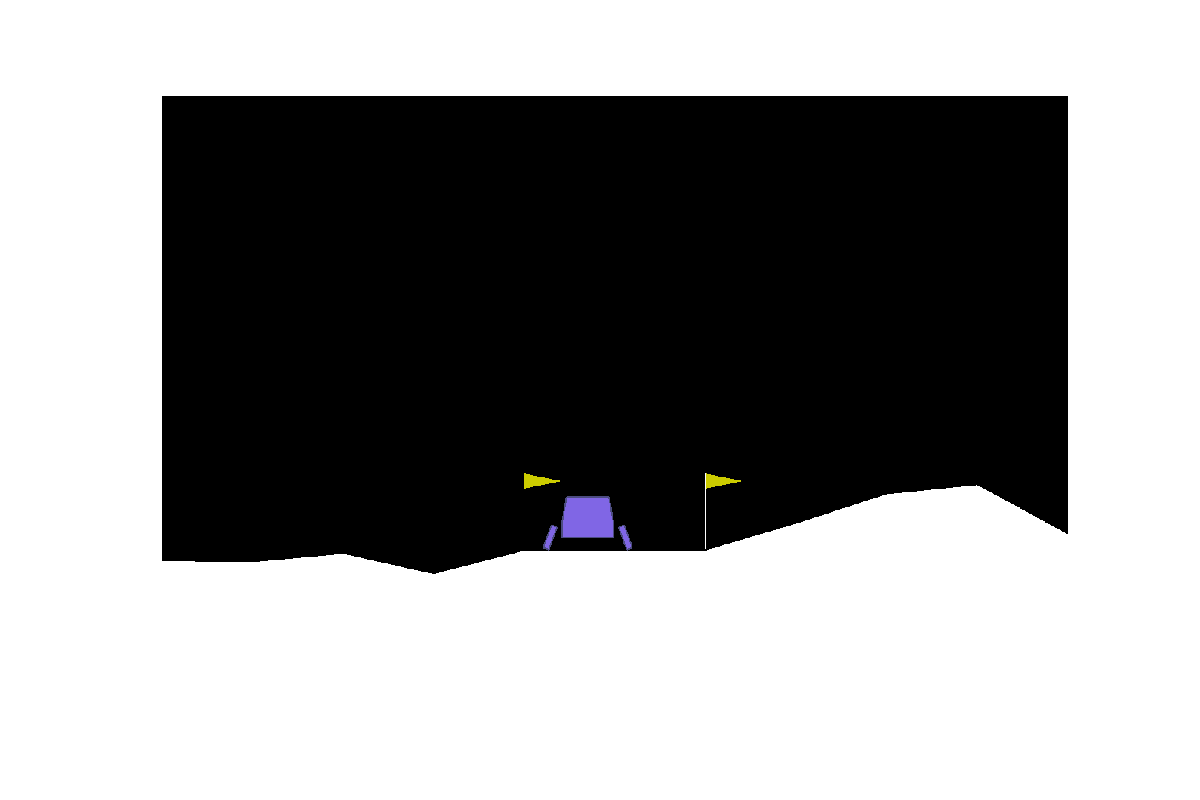
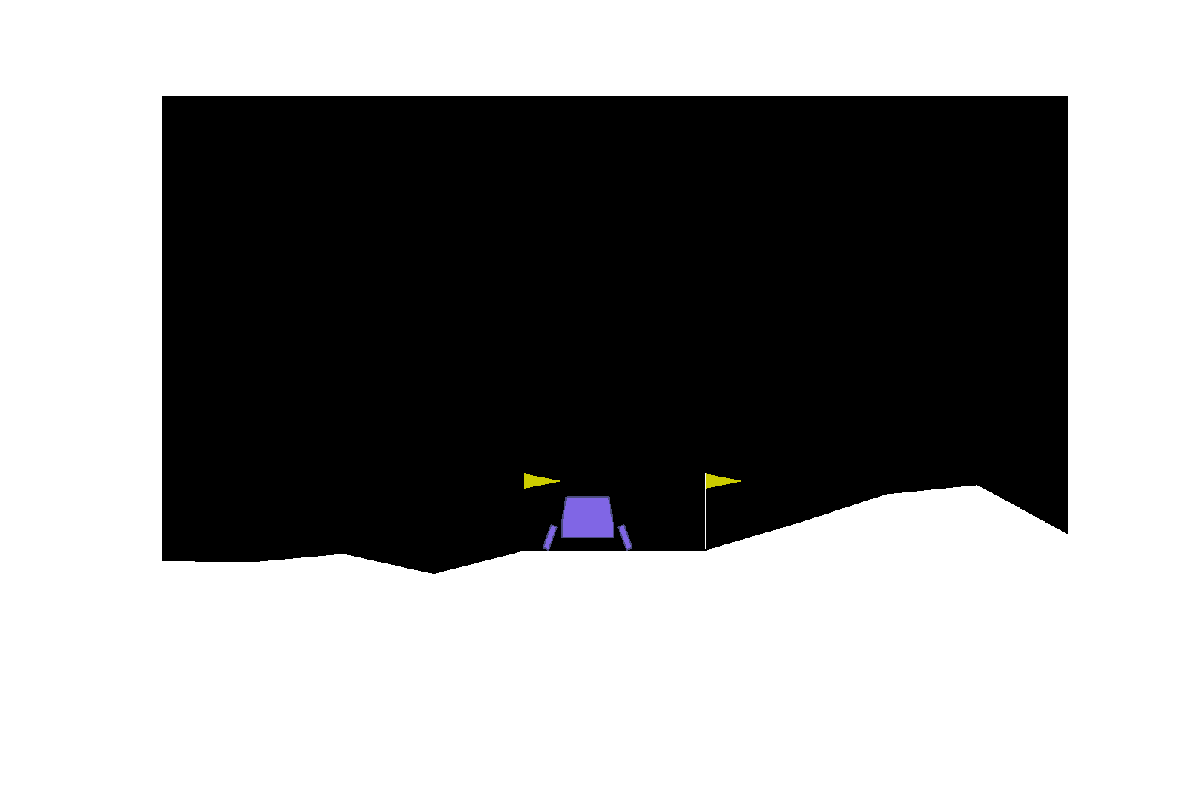
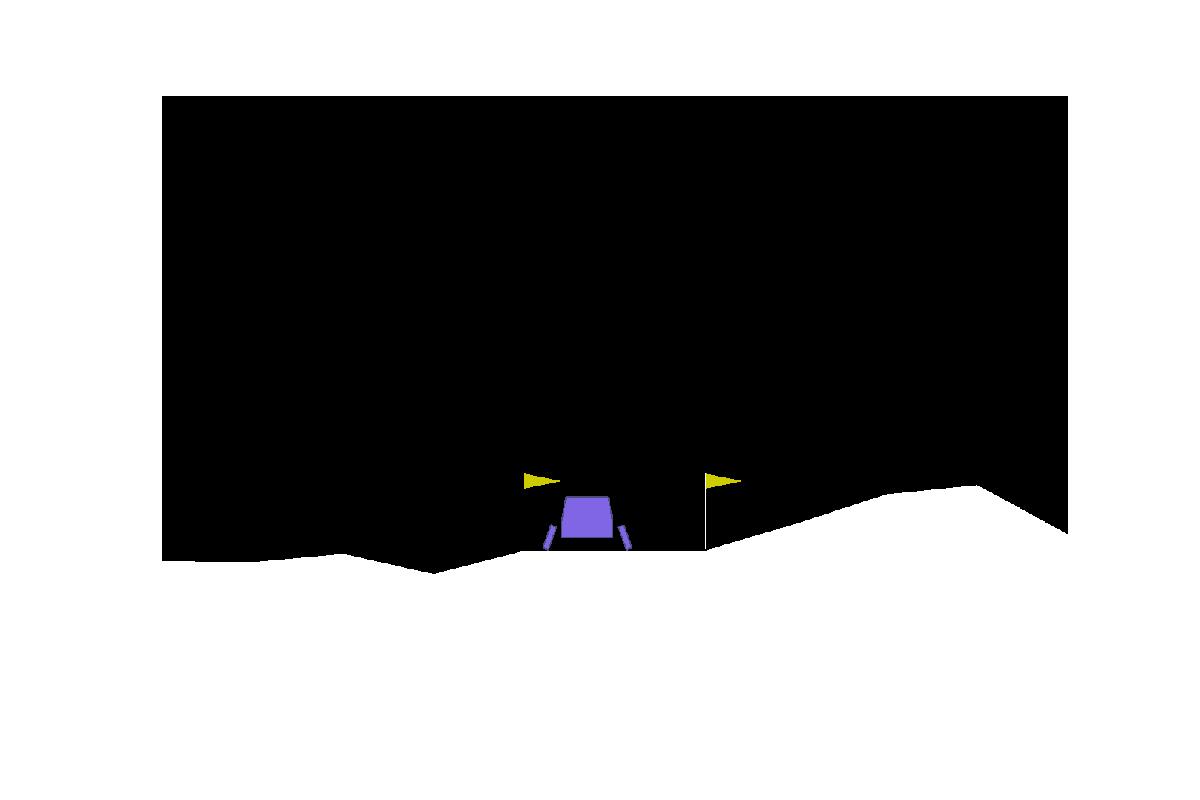
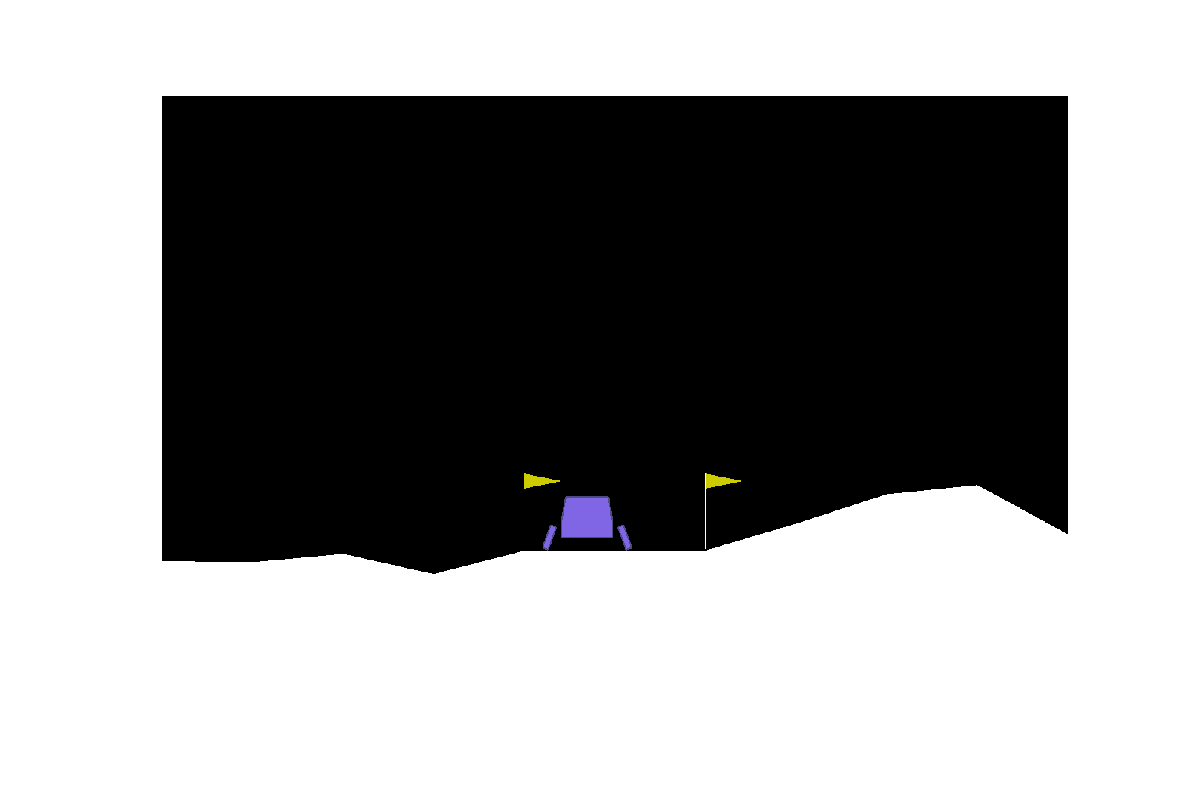
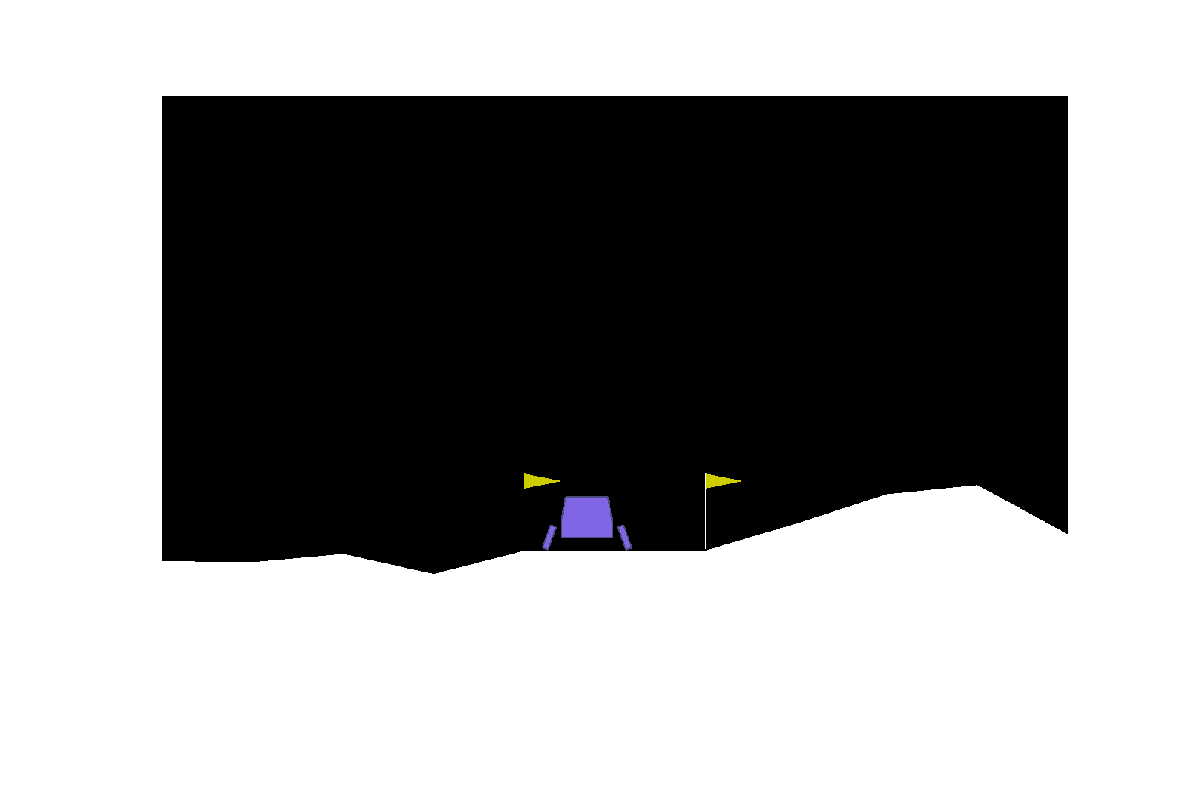
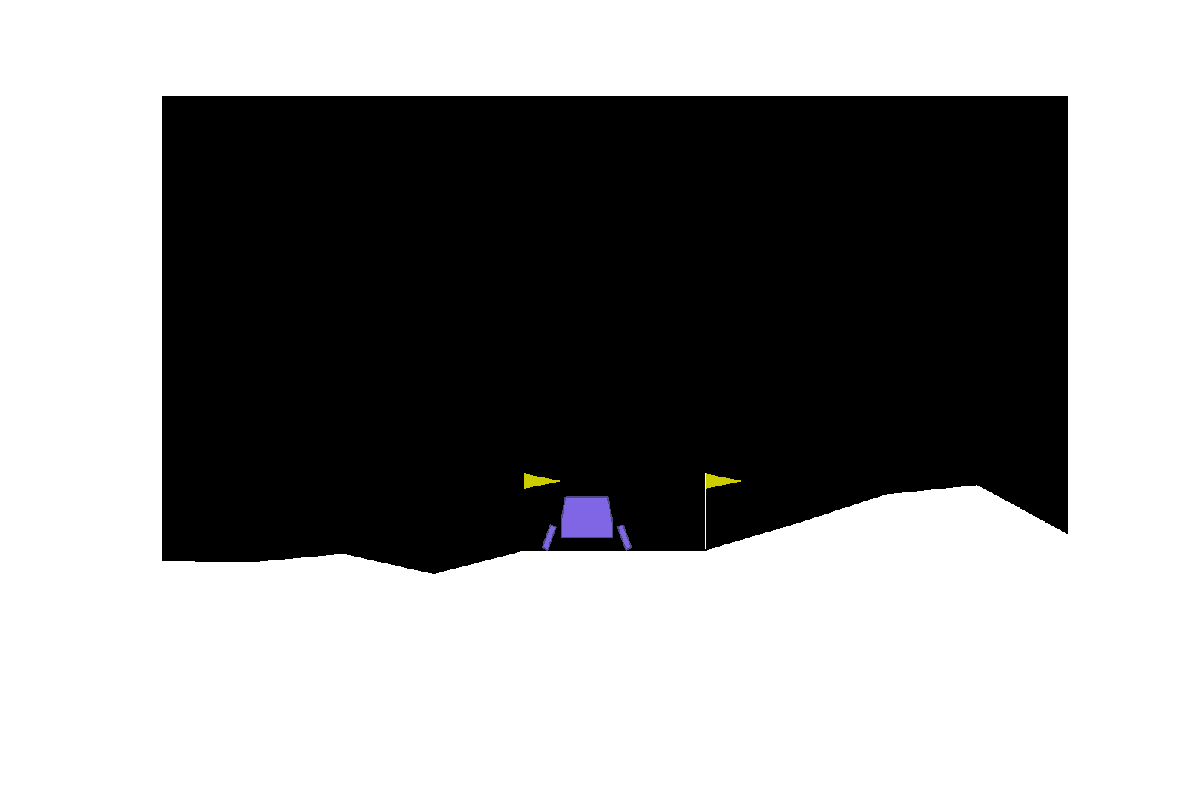
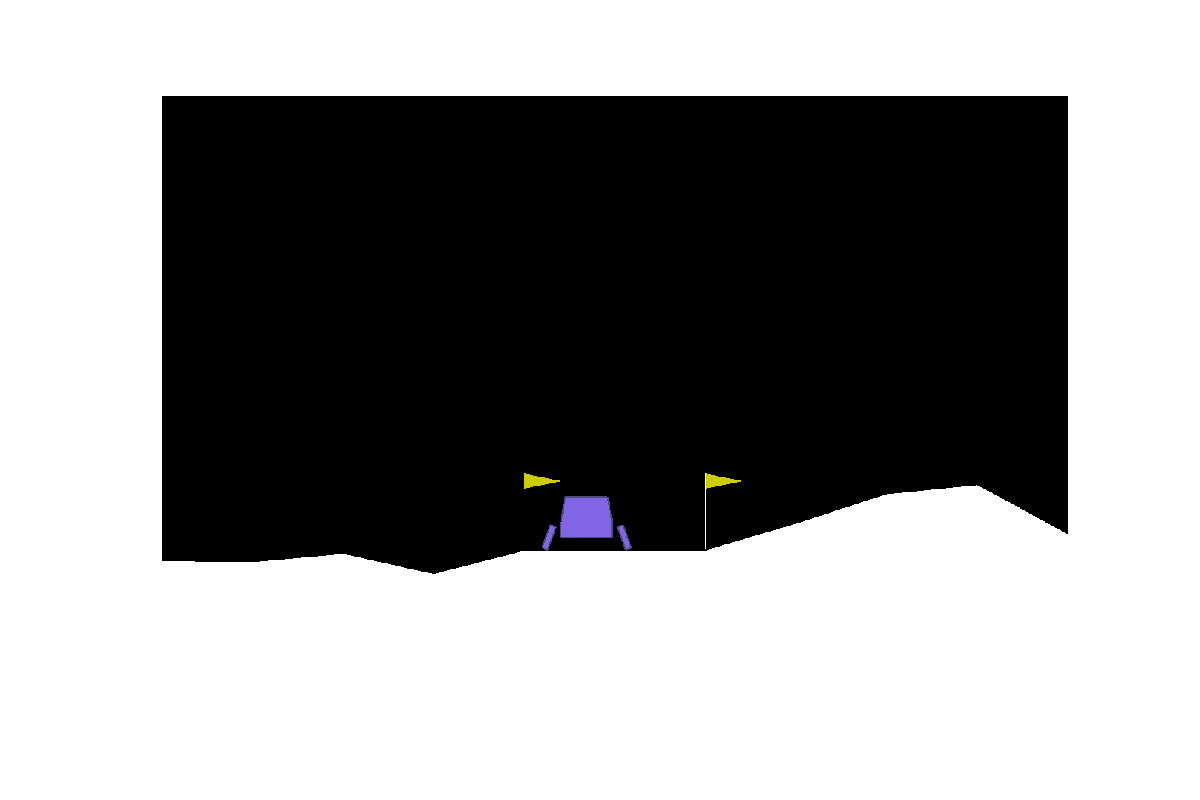
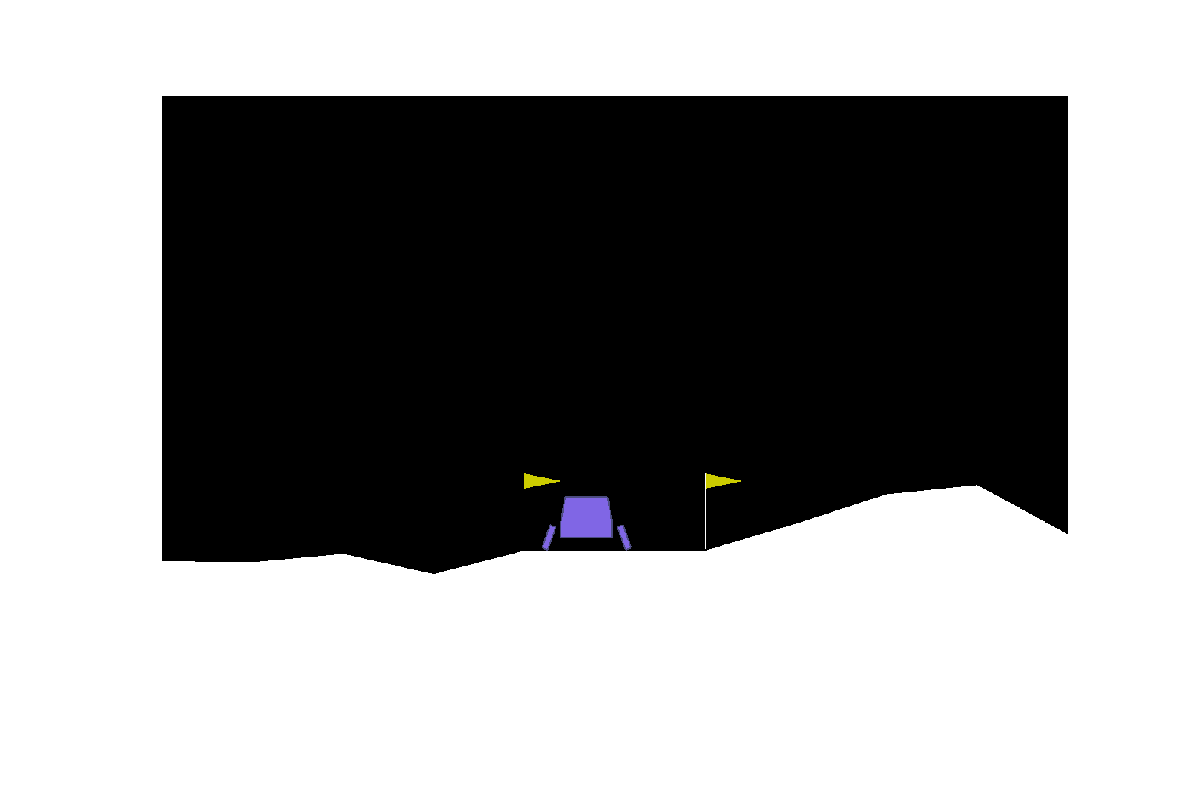
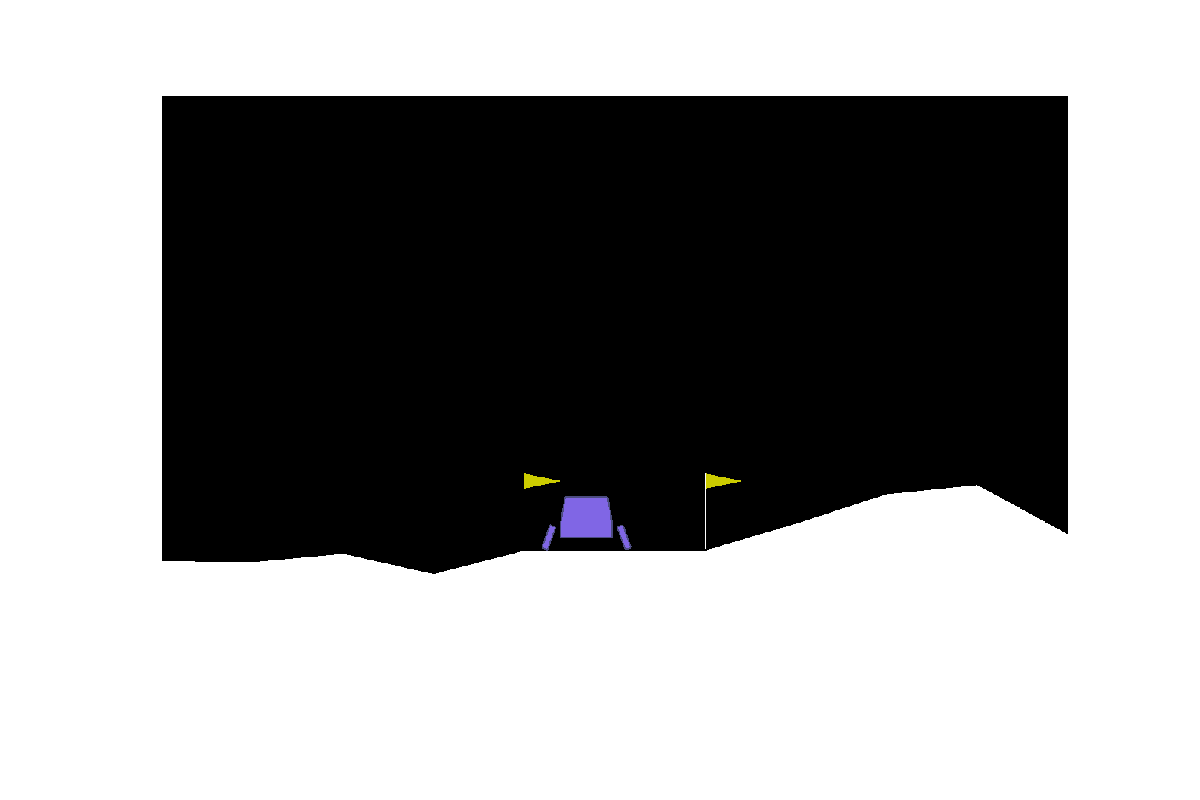
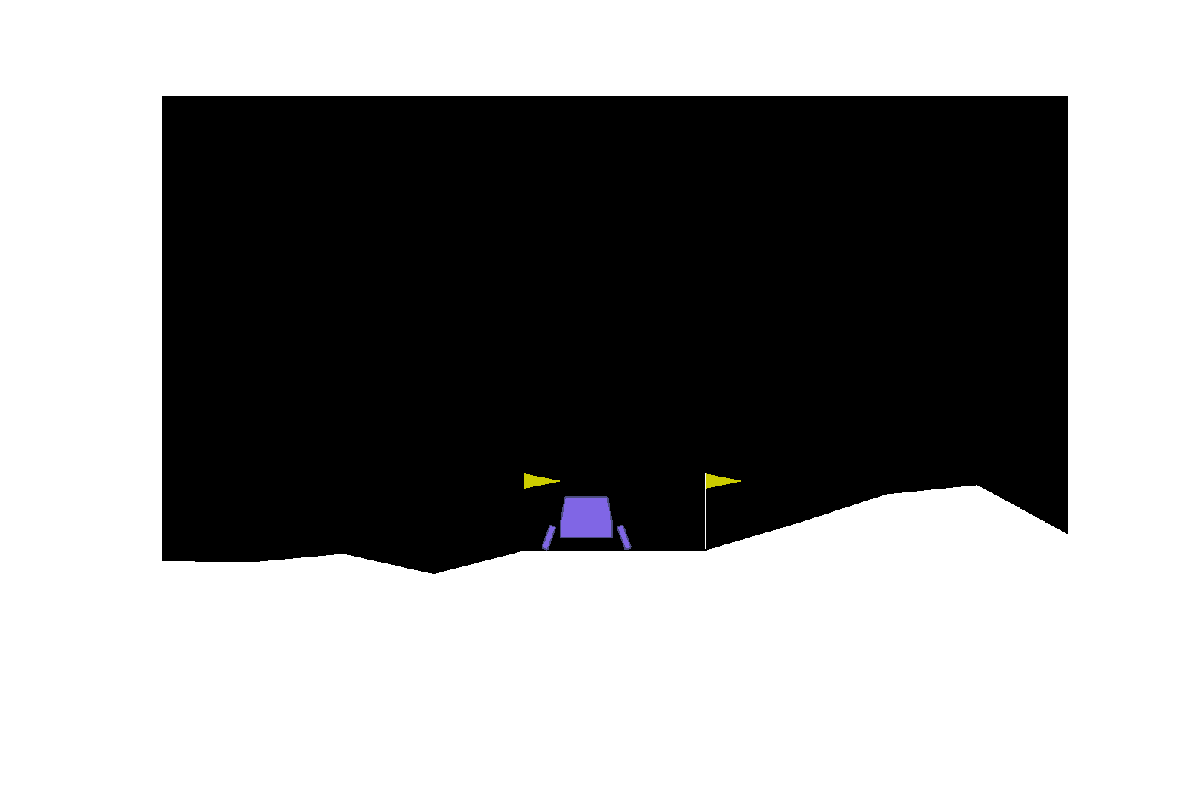
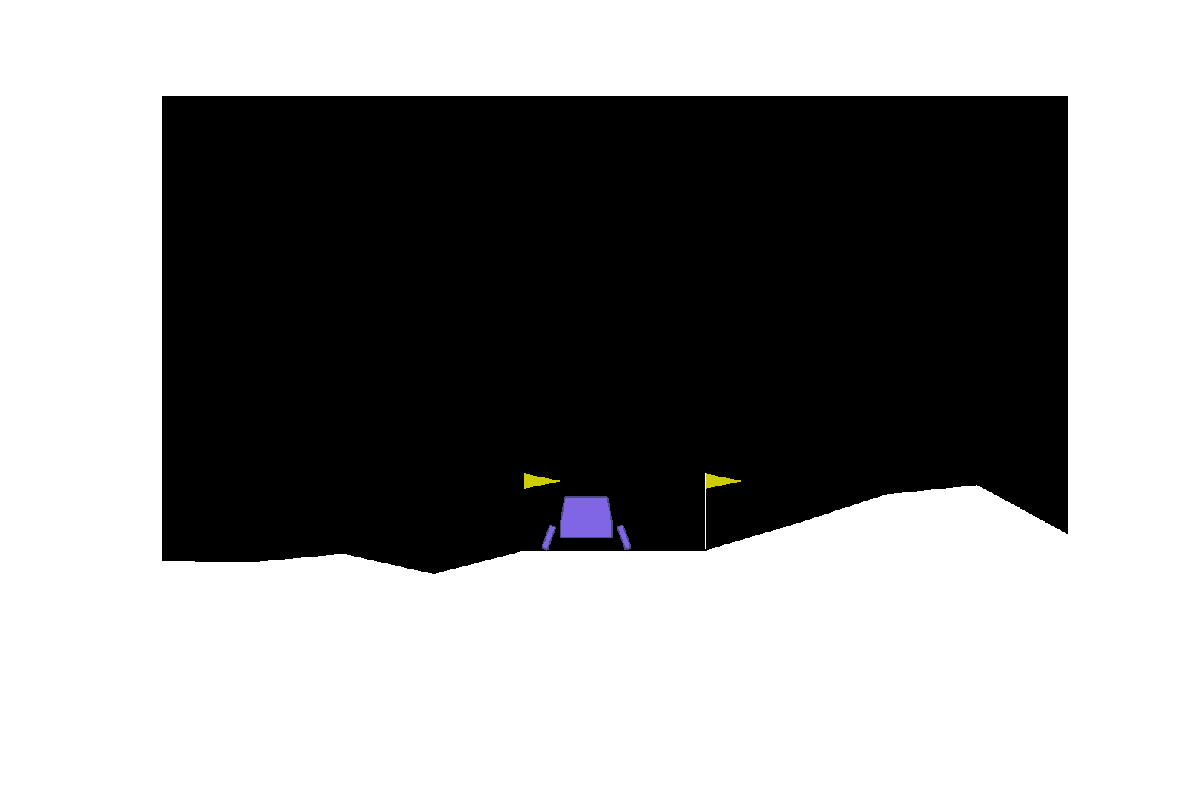
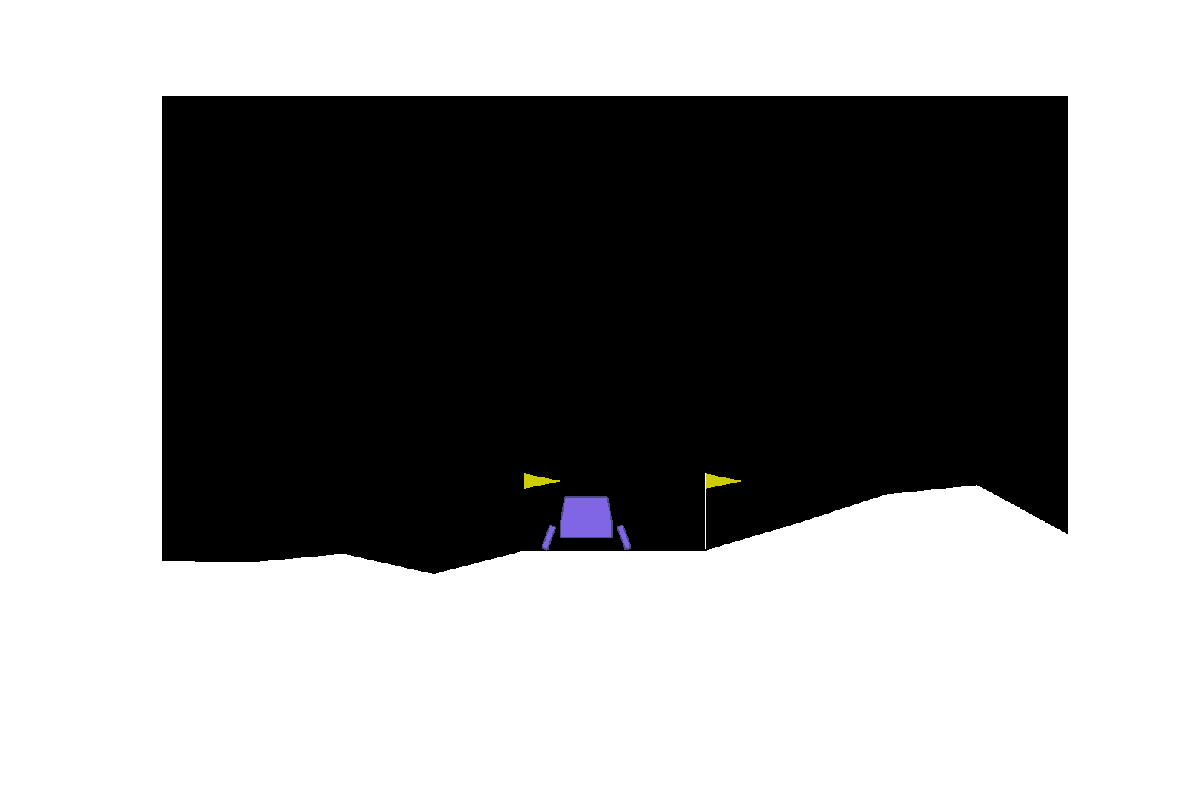
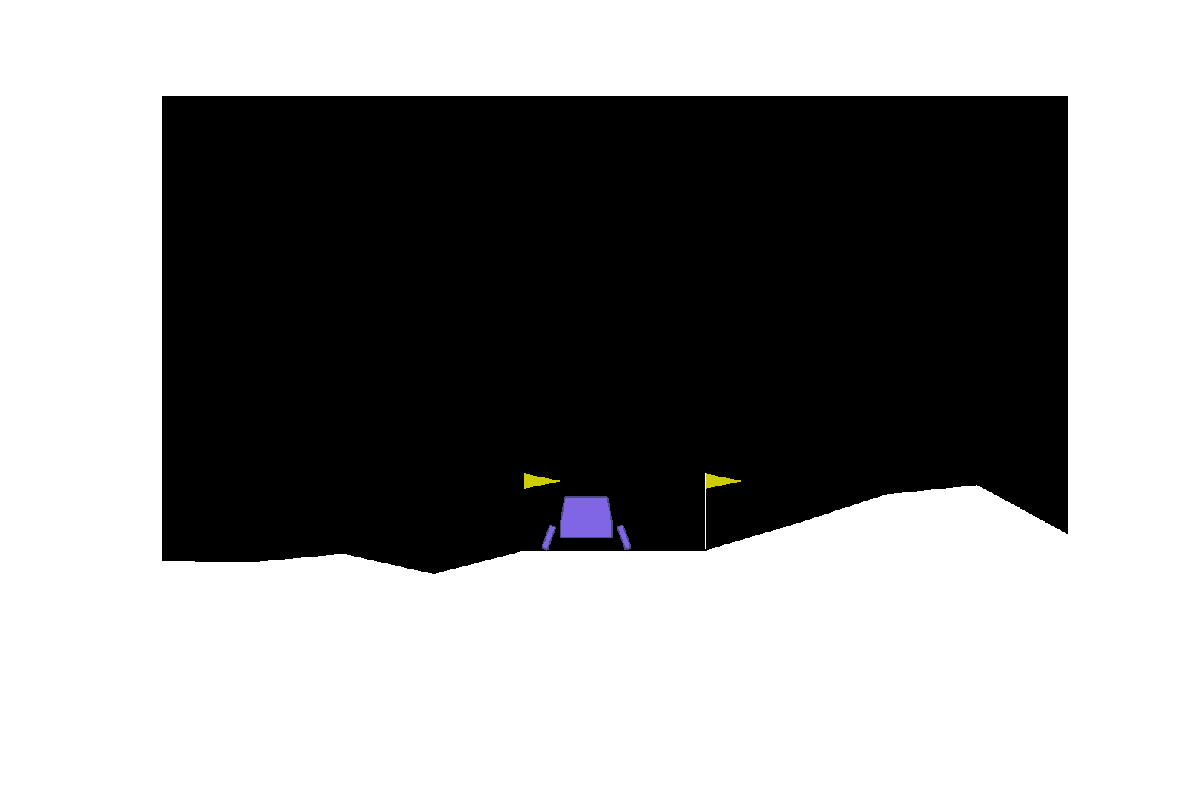
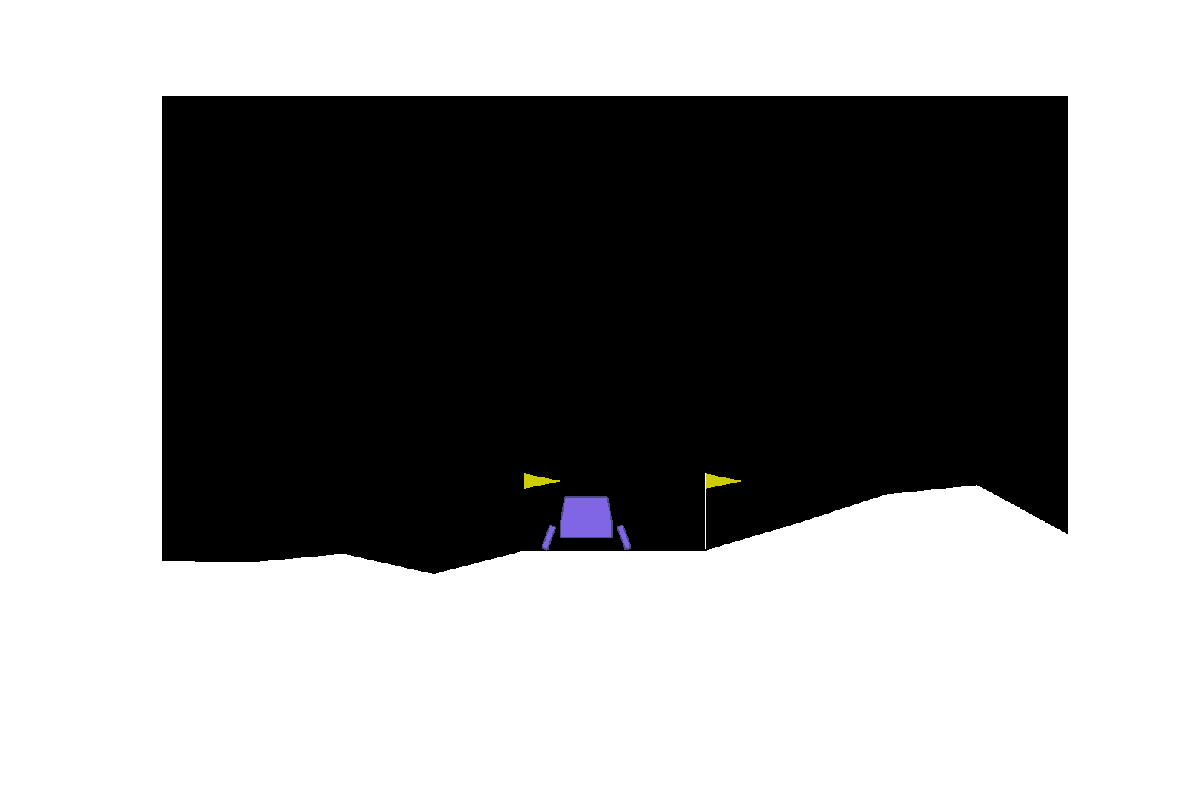
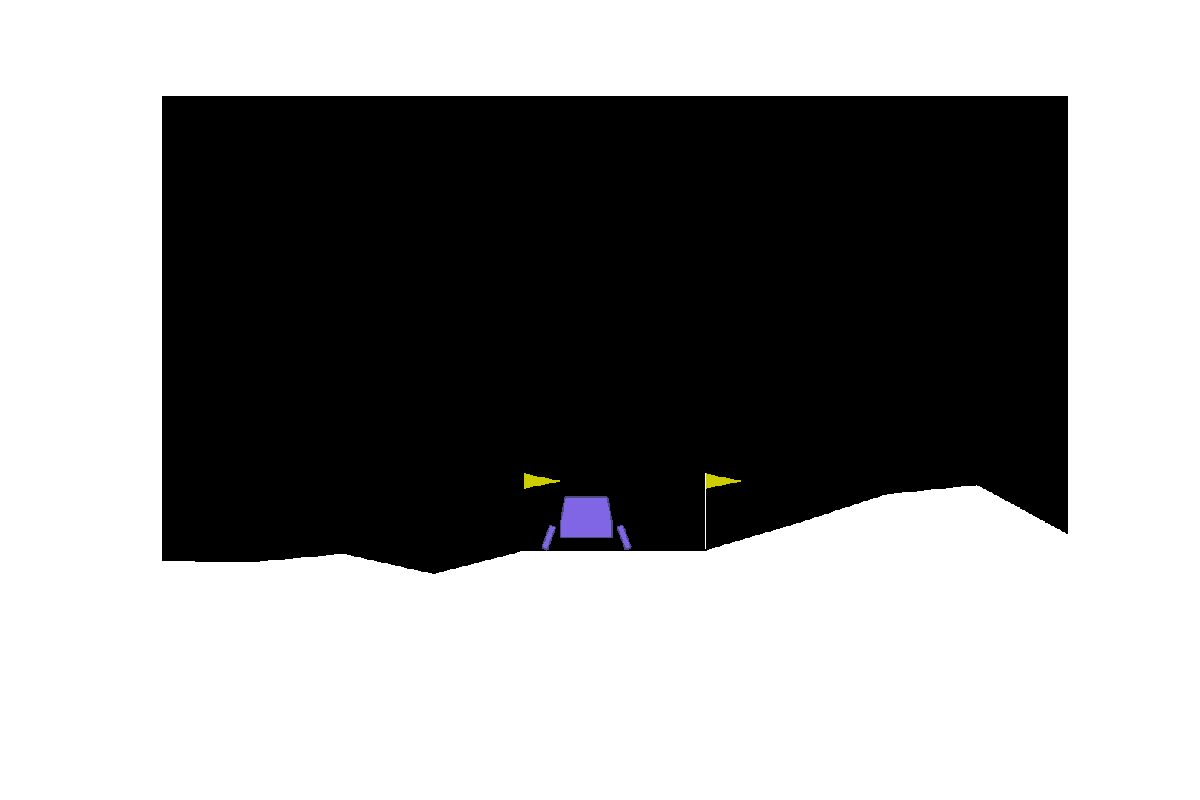
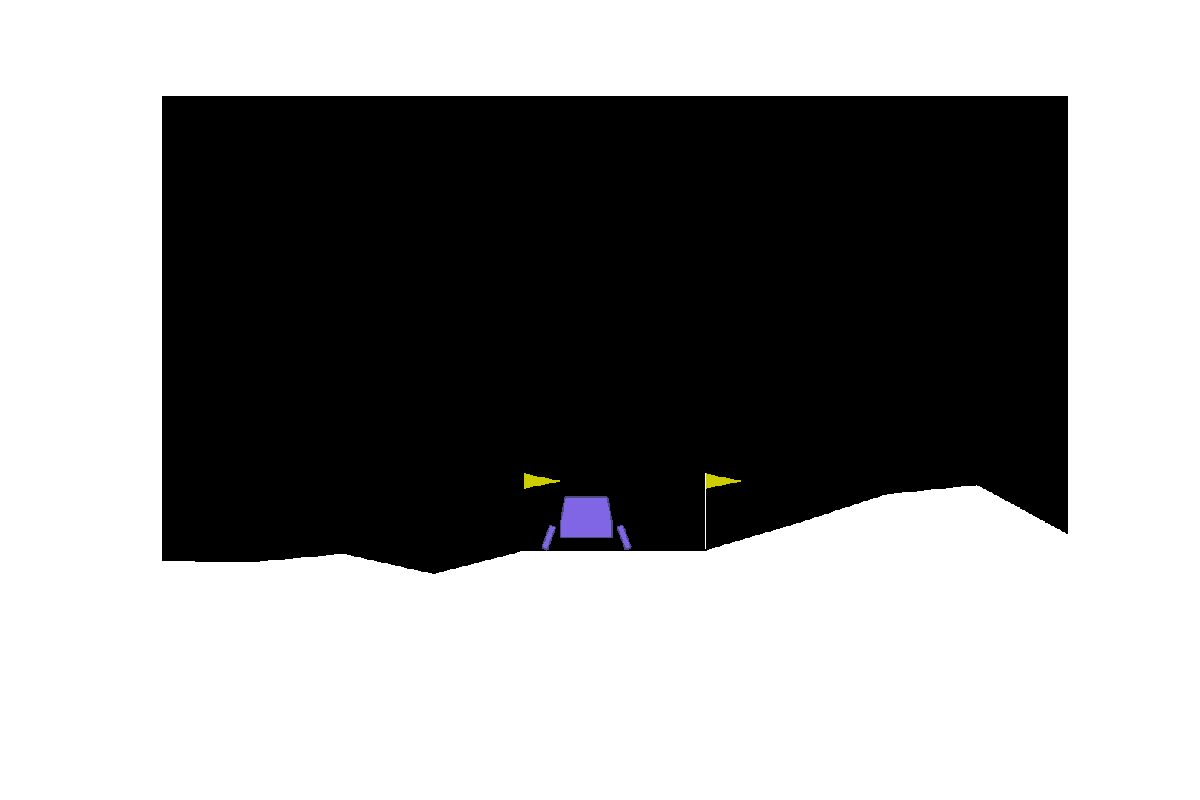
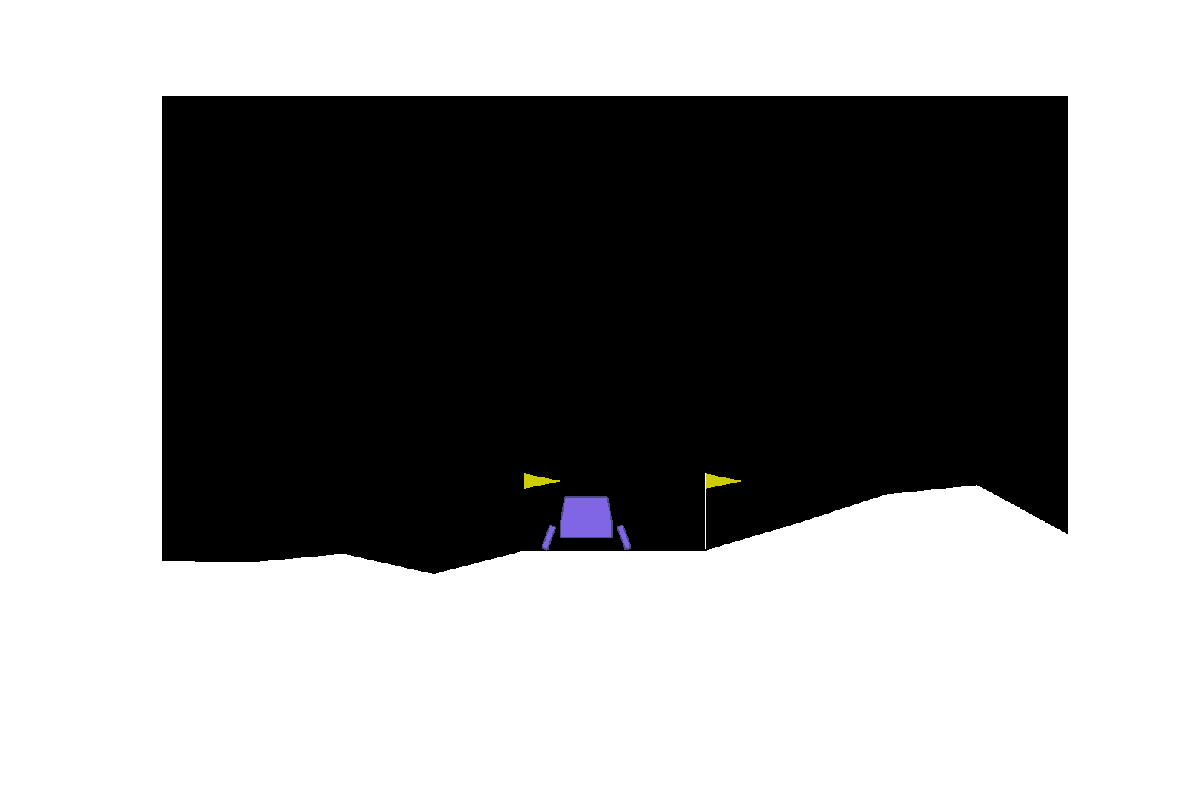
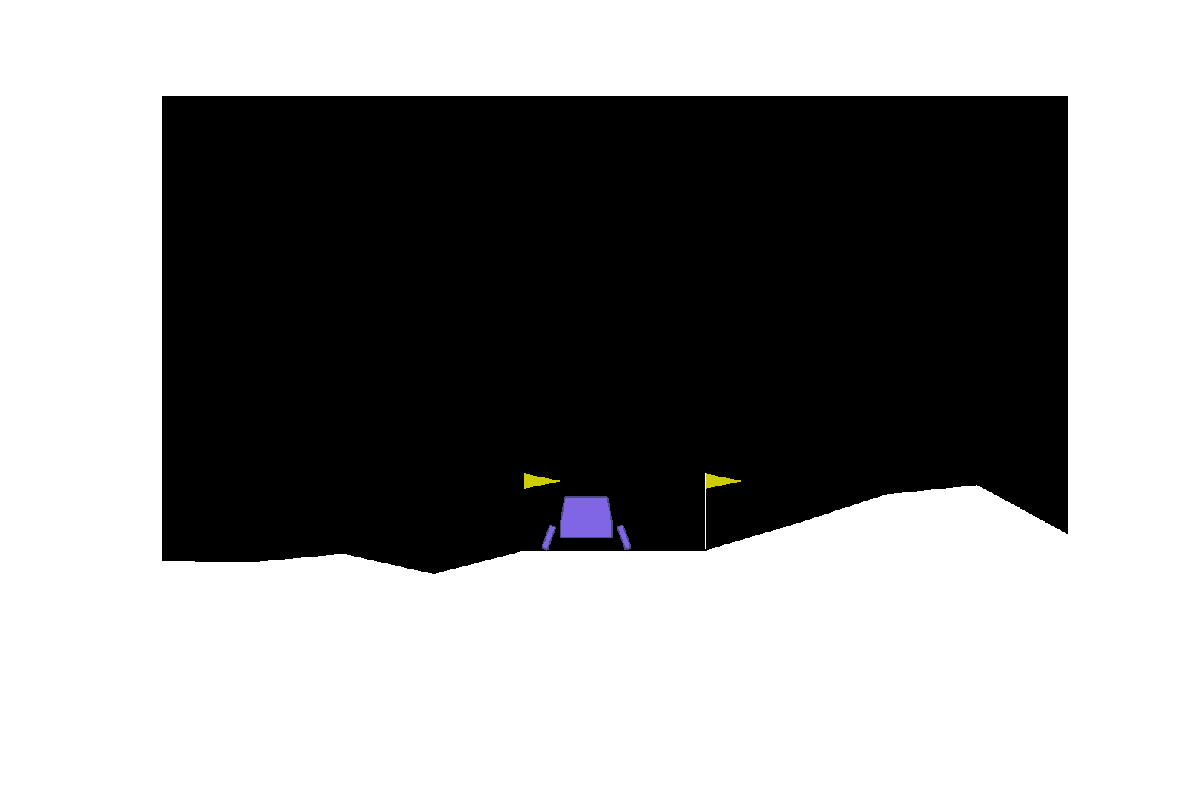
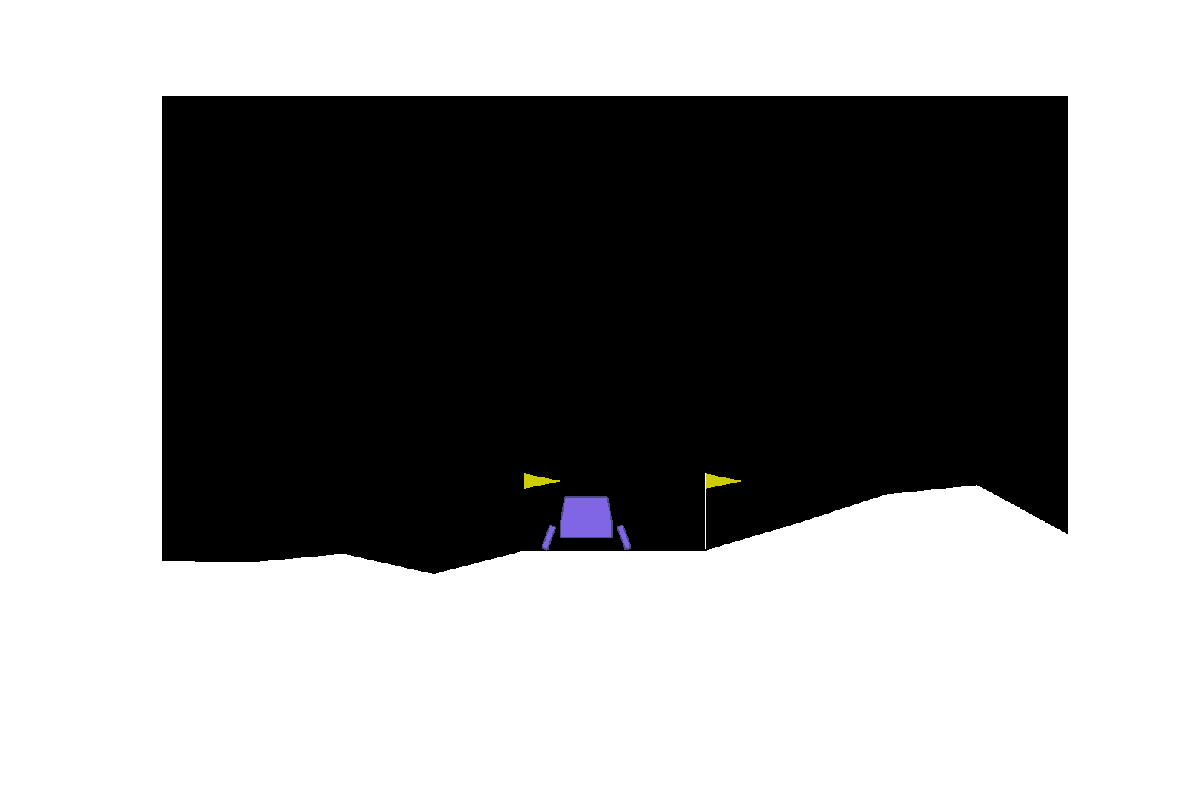
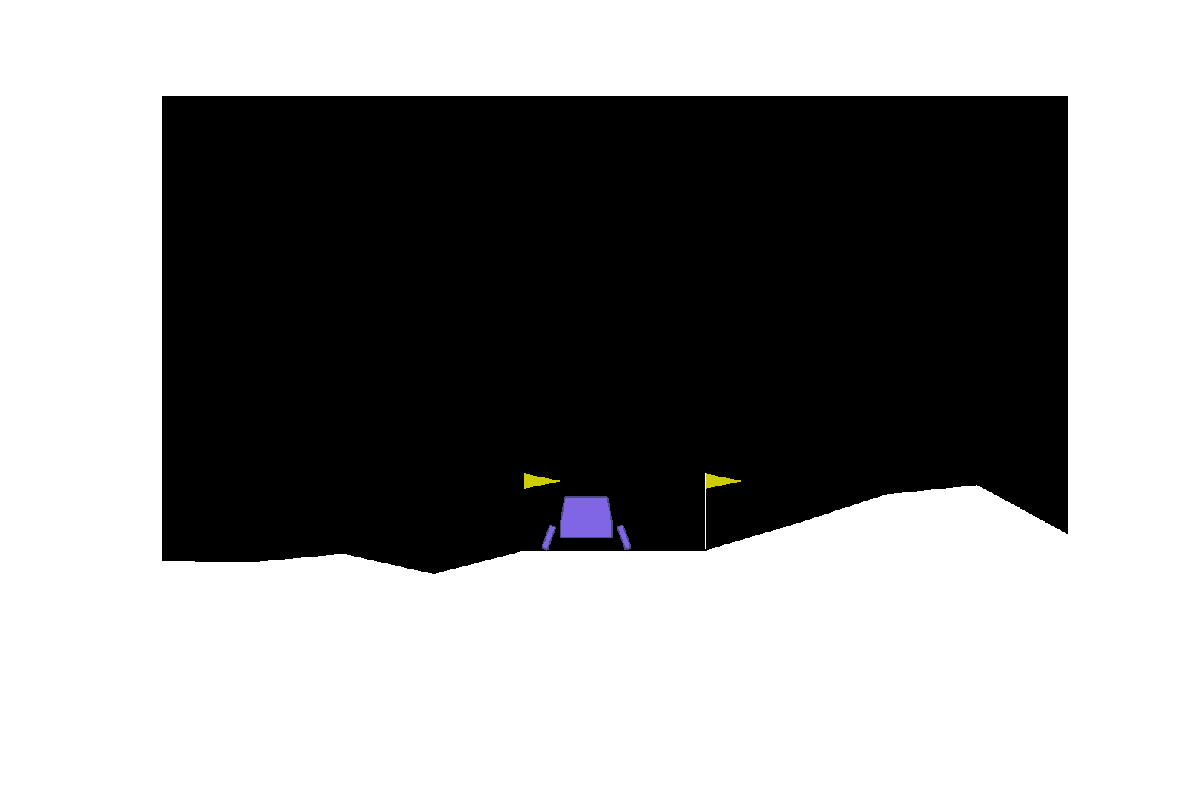
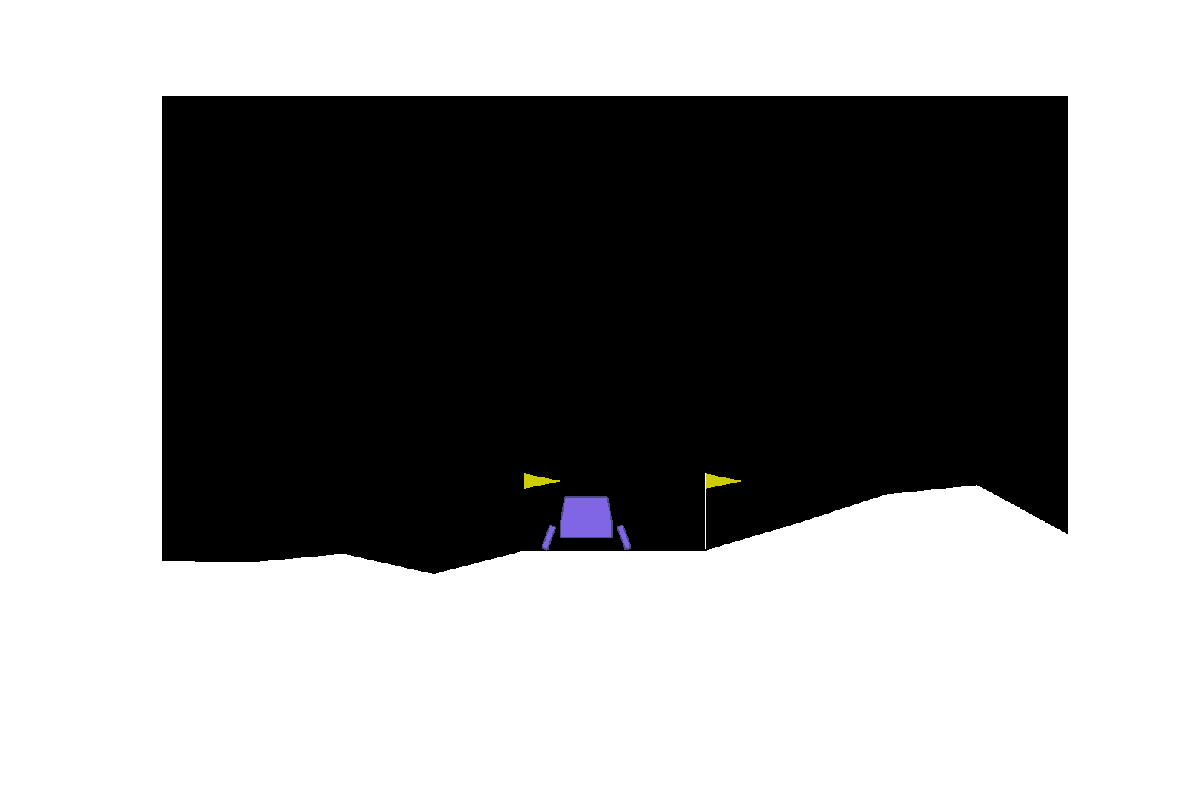
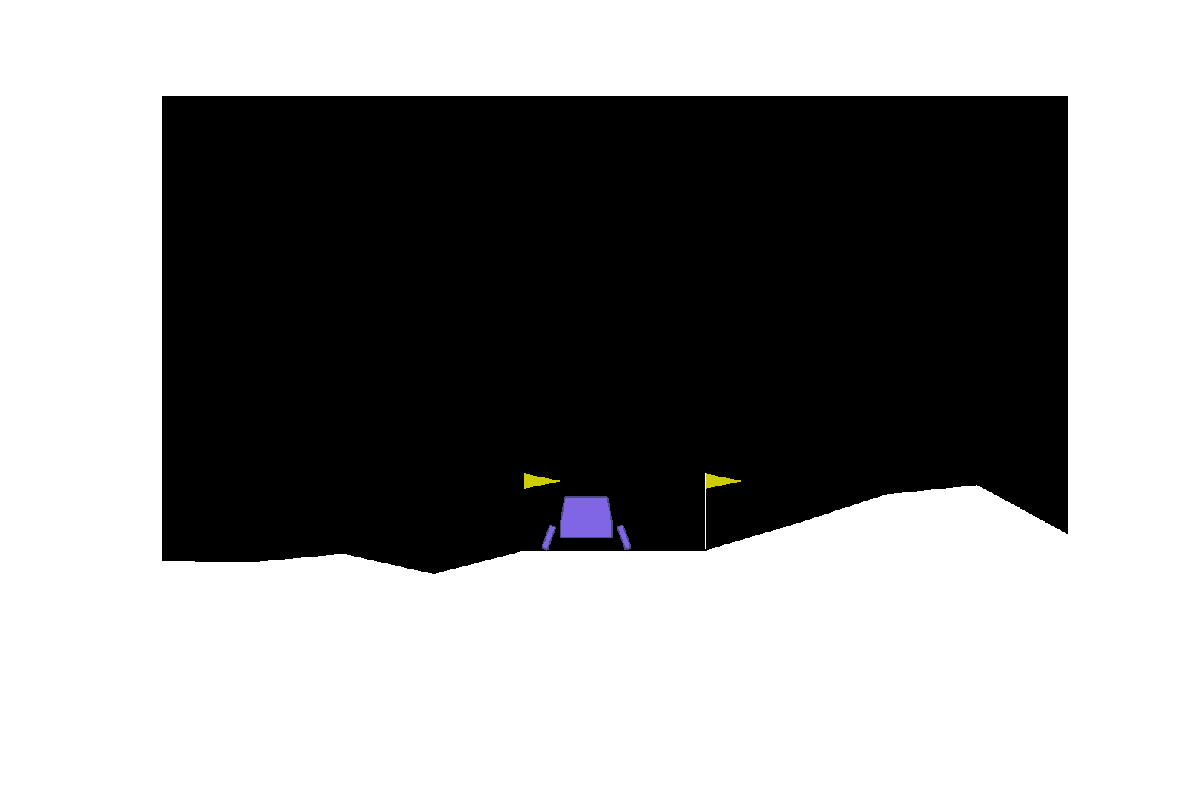
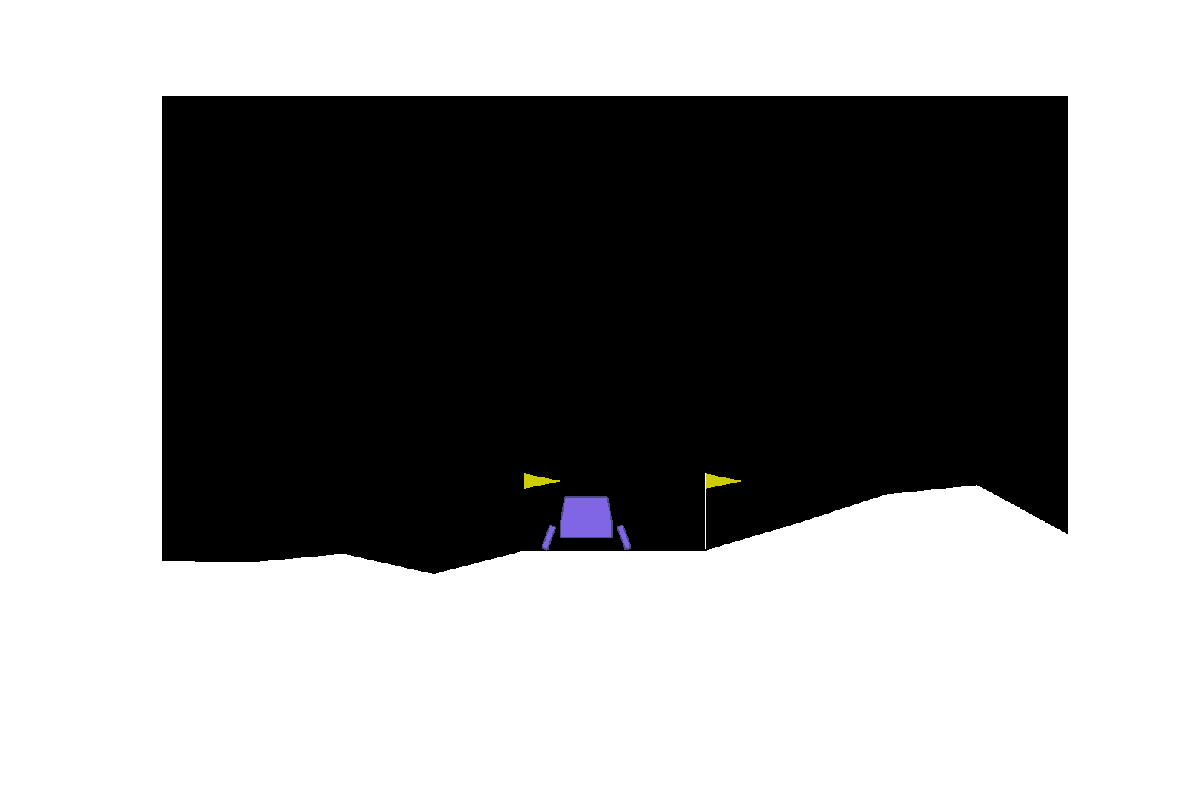
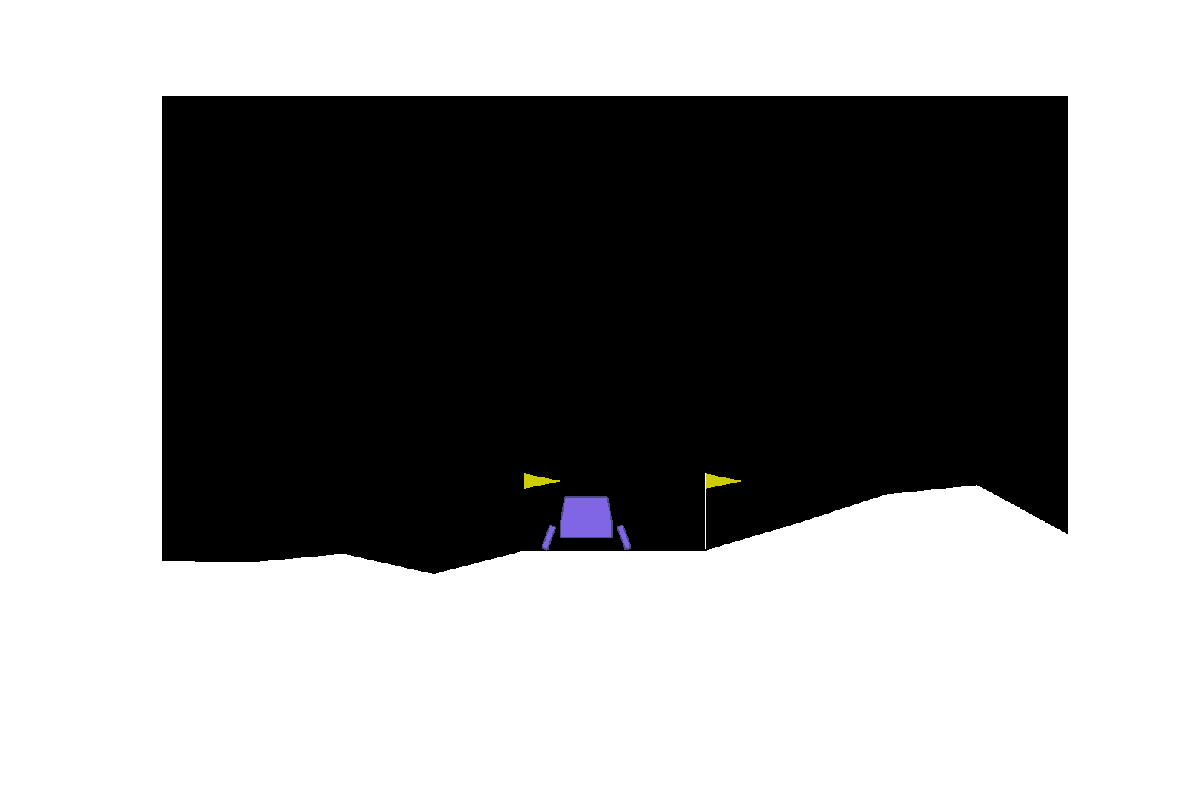
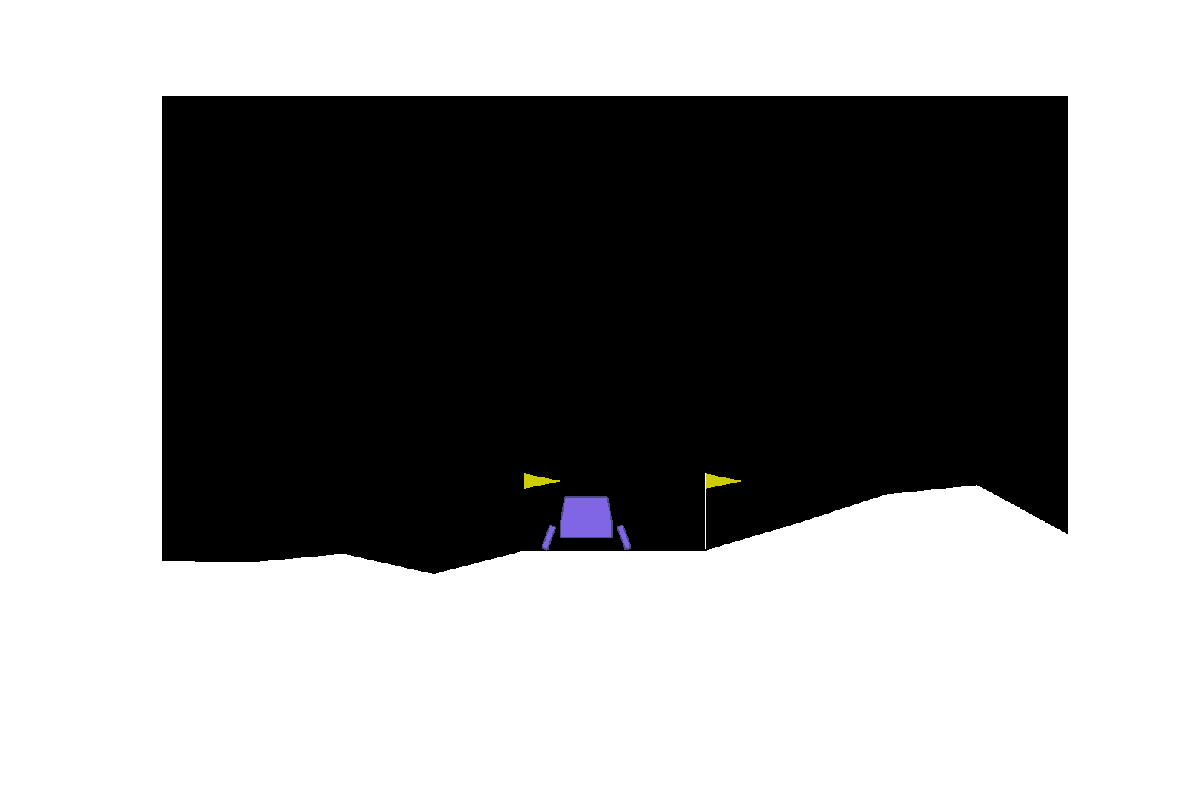
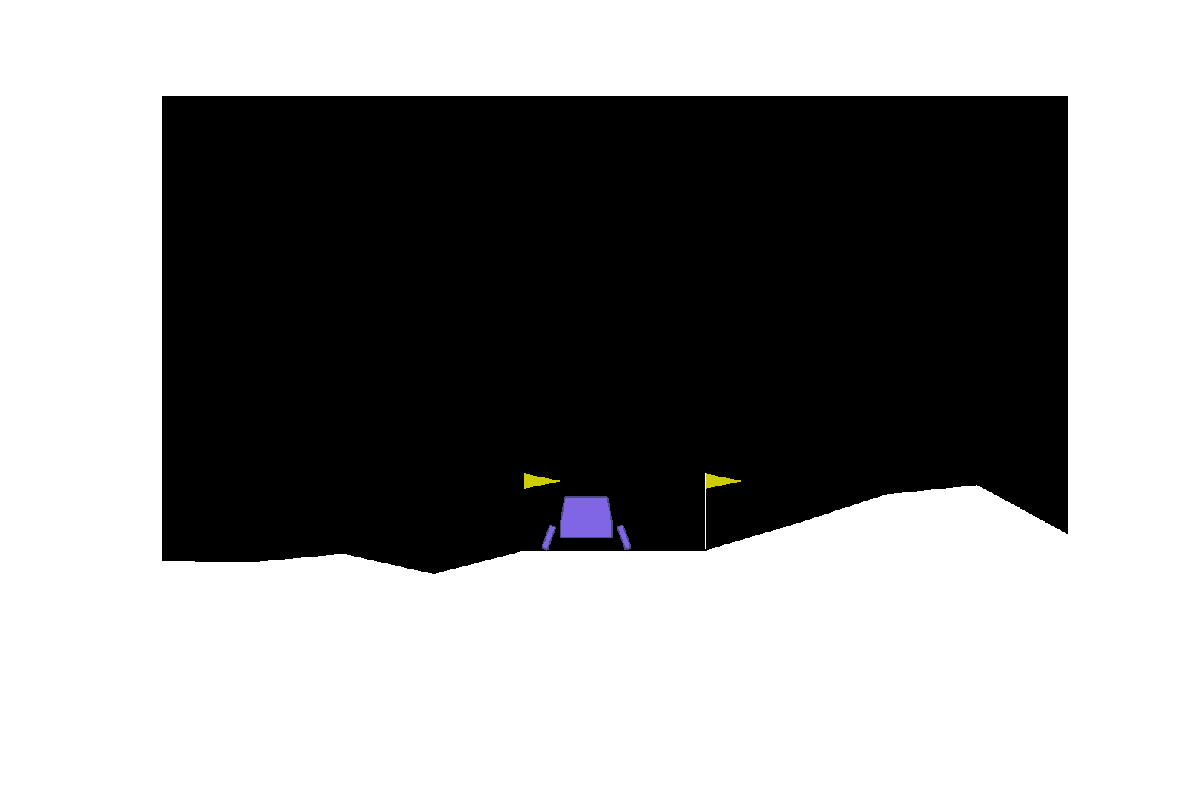
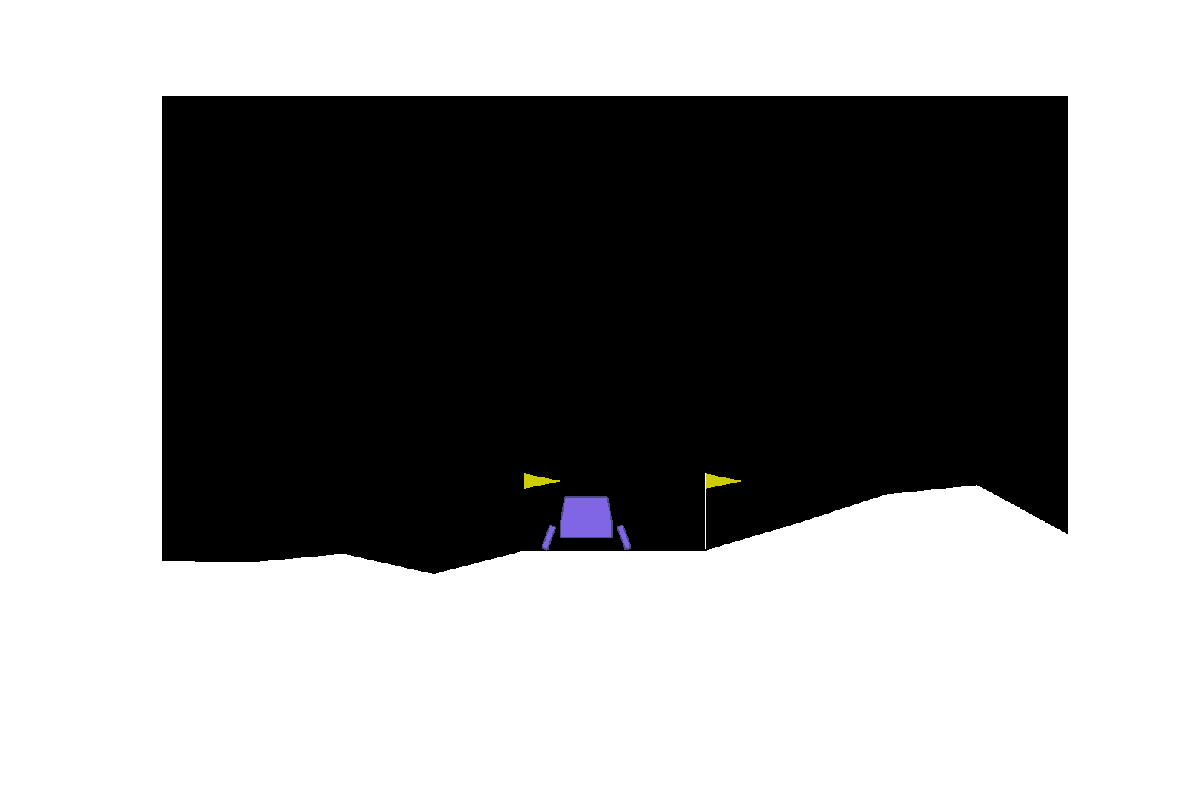
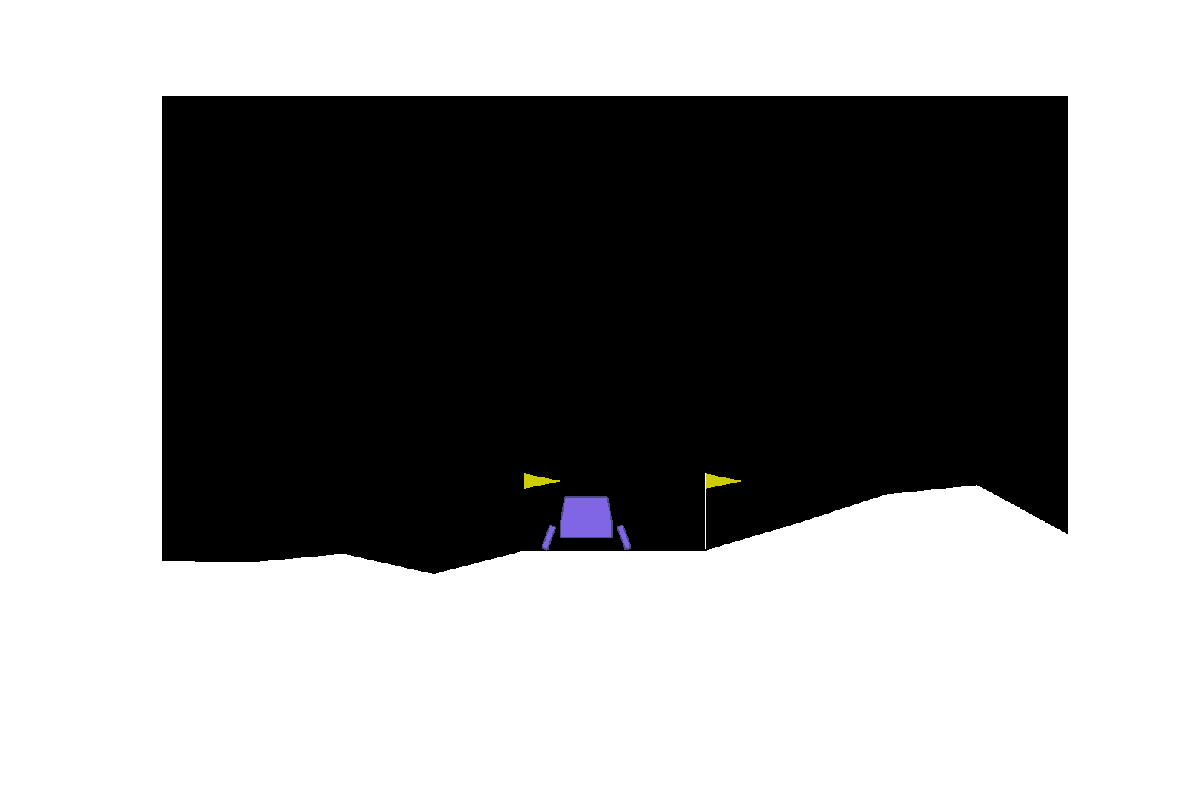
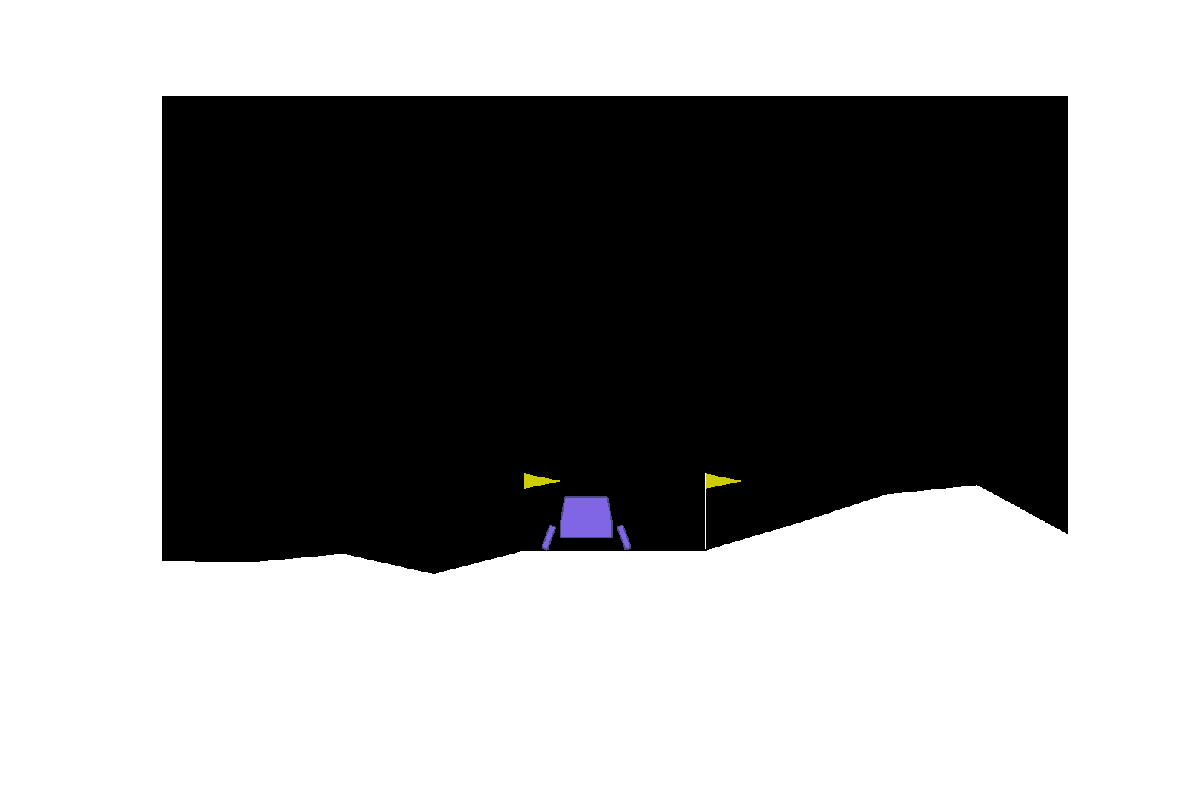
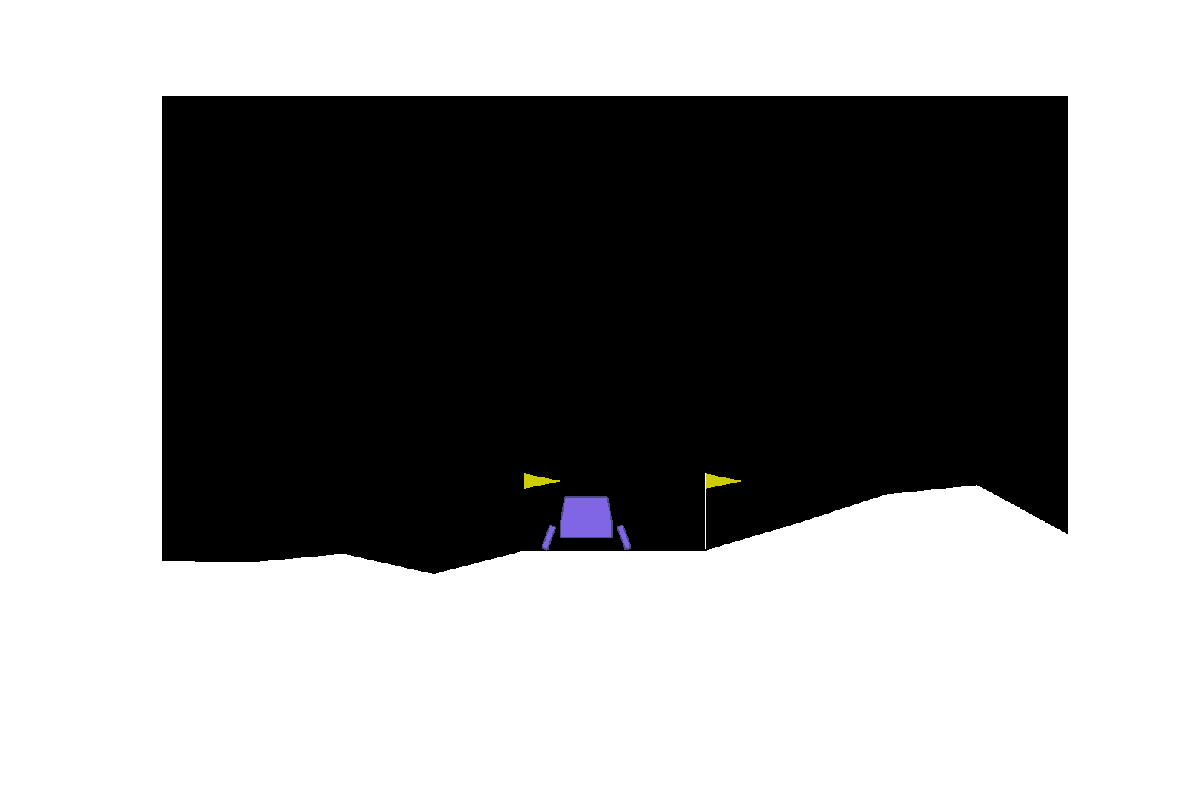
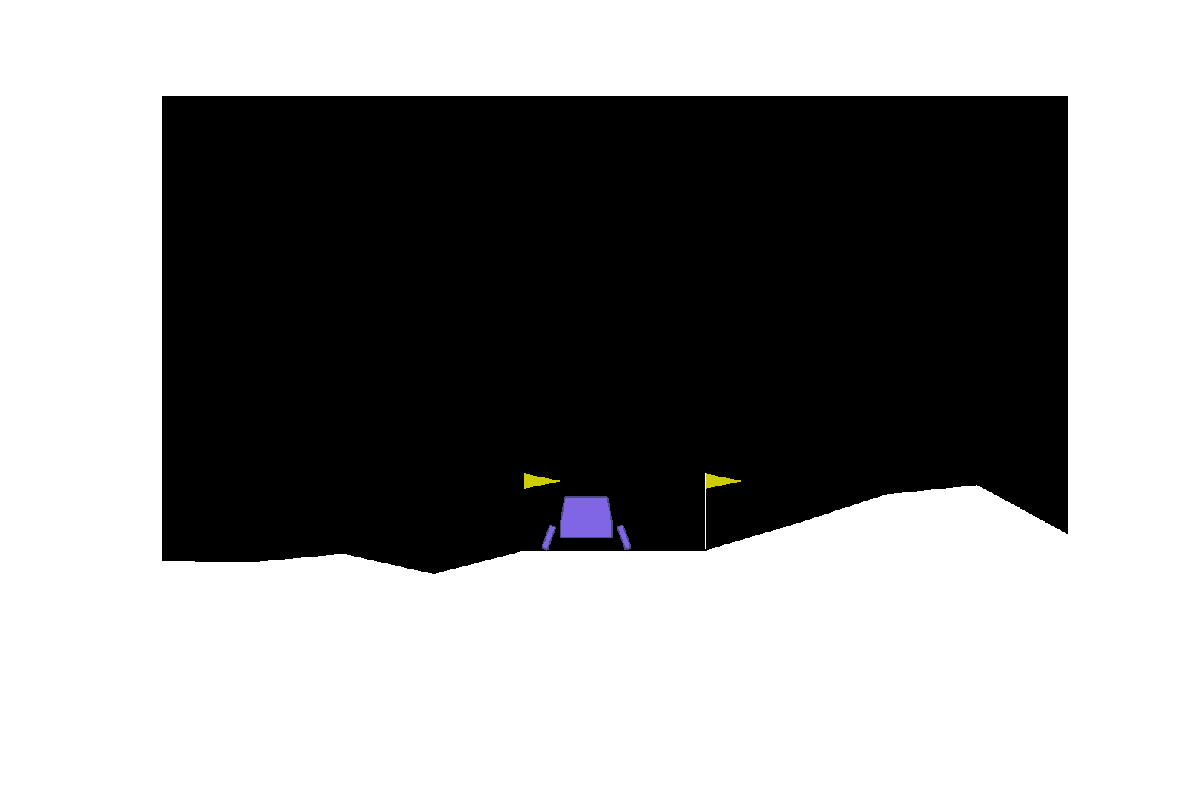
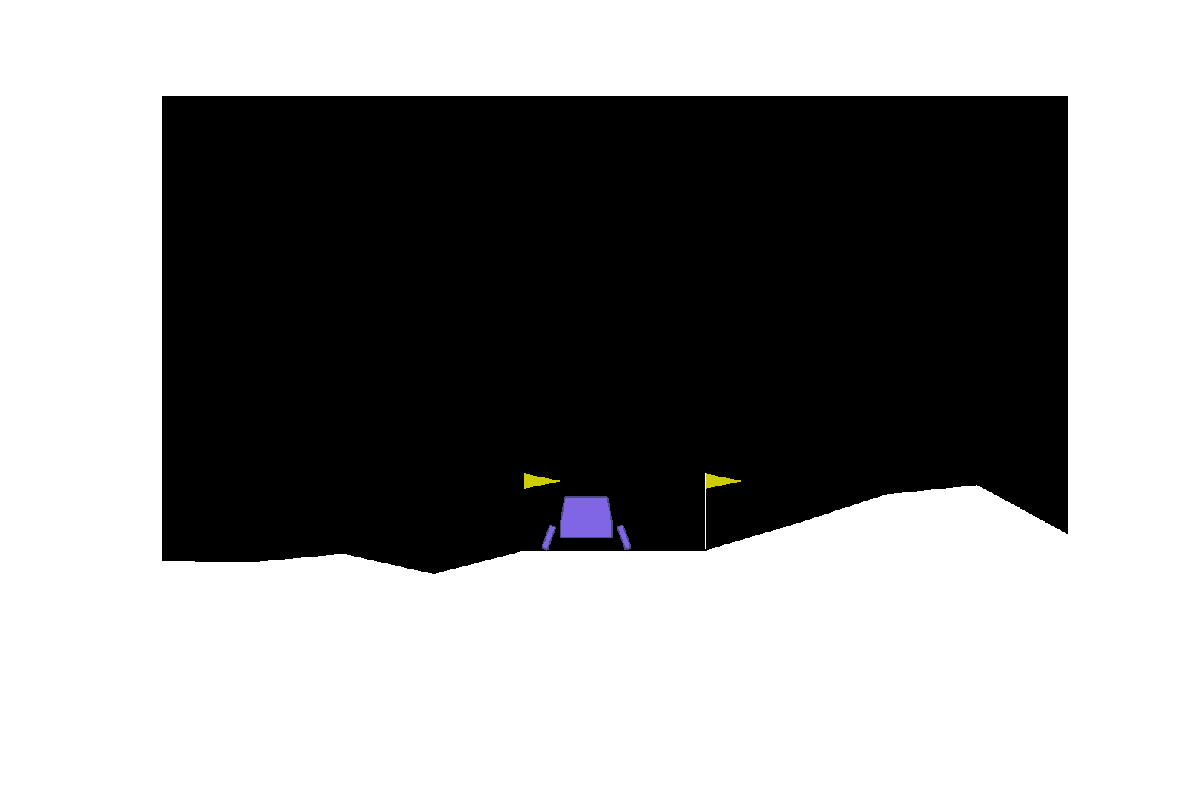
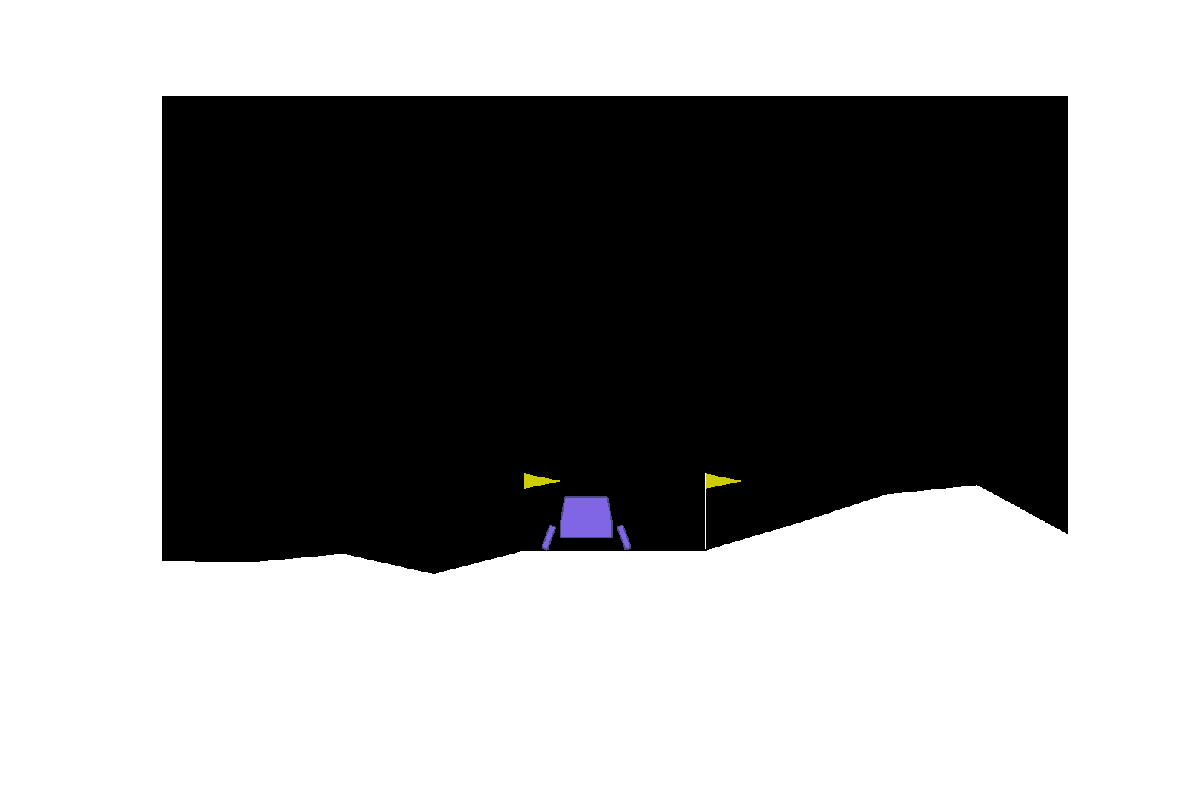
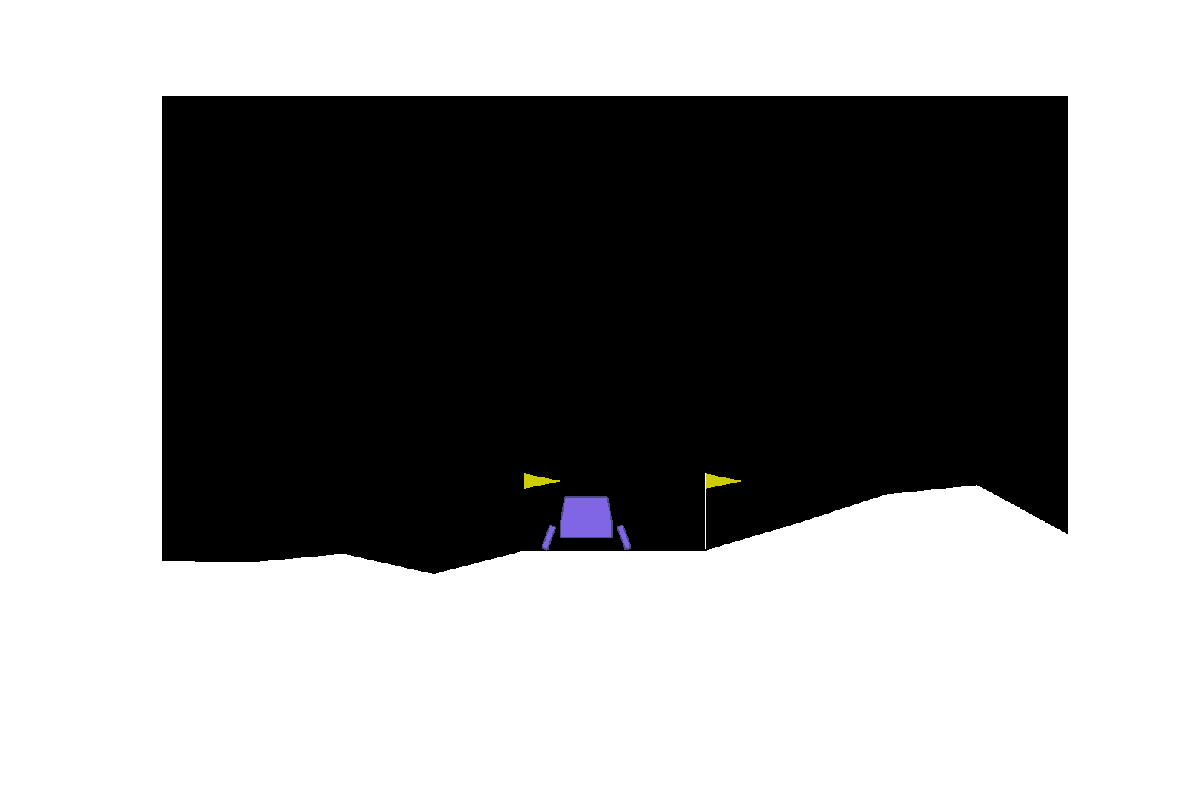
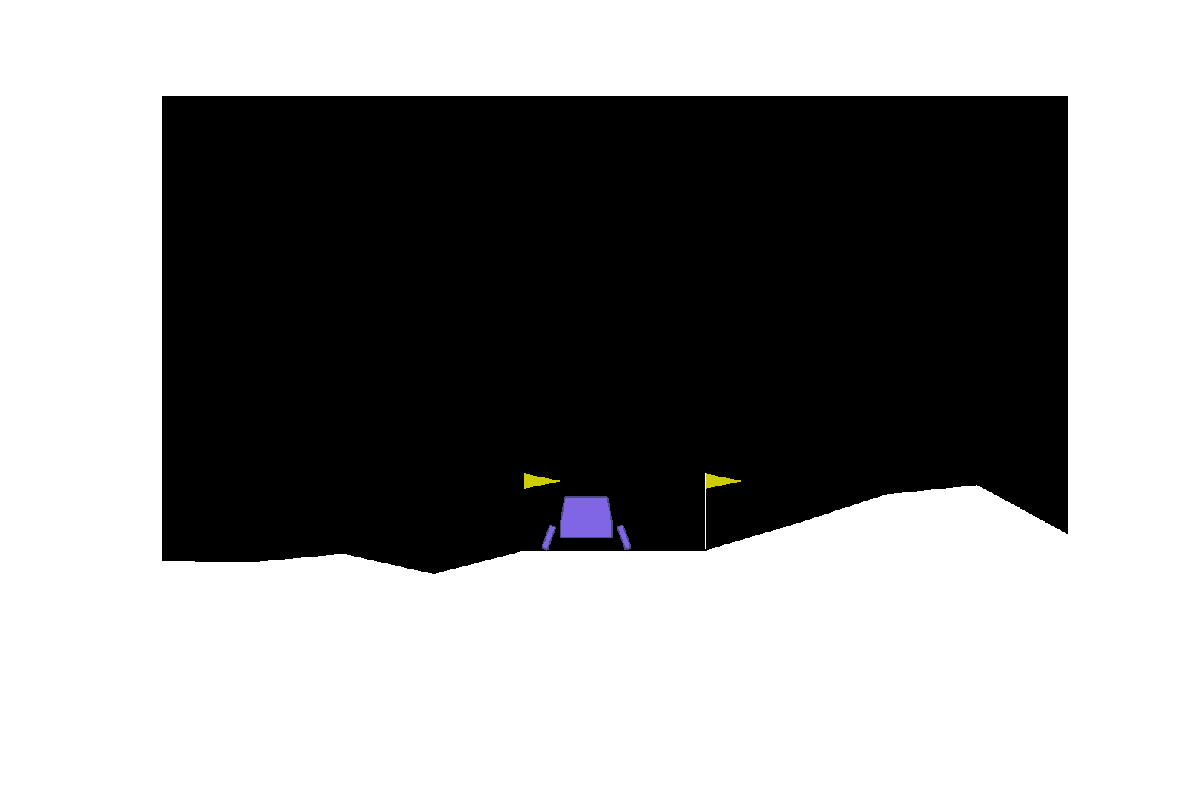

In [39]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

display_frames_as_gif(frames)